# Optimize

run and compare optimization frameworks
- scipy.optimize (L-BFGS-B)
- Dlib
- Pptuna
- Hyperopt
- Platypus
- Nevergrad
- Ax


In [1]:
from datetime import datetime
from functools import partial
# import pandas_datareader as pdr
from concurrent import futures

import pytest
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

# optimizers
from scipy import optimize
import dlib     # http://dlib.net/
import optuna   # https://optuna.org/
import hyperopt # http://hyperopt.github.io/hyperopt/
from hyperopt import fmin, tpe, hp
import platypus    # https://github.com/Project-Platypus/Platypus
from platypus import MOEAD, Problem, Real
import nevergrad as ng  # https://facebookresearch.github.io/nevergrad/optimization.html
import ax  # https://ax.dev/

from SWRsimulation import SWRsimulation

# TODO:
# 1) smoother 
# init_withdrawal -> set previous to None, smoothing_factor per config
# withdrawal -> compute desired withdrawal based on previous
# min (desired, previous + (desired-previous)/smoothing_factor )

# 2) montecarlo - initialize array of trials at start and reuse it

# 3) take strategies for 0 and 1 and double check the CE values because it seems off. check strat 1 at CE 0 and strat 0 at CE1
# redo history several times without reinitializing with different parameters
# simulates take override simulation args
# init creates a list of samples, n_trials by n_ret_years
# for history , simulate creates a generator from samples and returns them

# 4) add chart of all spending paths

# chart of all optimizers, do with plotly, hover shows gamma, value, optimizer, elapsed time

# 4) do with deathrate

# multithreading, optimize for speed

print("%s %s" % ('numpy', np.__version__))
print("%s %s" % ('pandas', pd.__version__))
print("%s %s" % ('scipy', scipy.__version__))
print("%s %s" % ("dlib", dlib.__version__))
print("%s %s" % ('optuna', optuna.__version__))
print("%s %s" % ('hyperopt', hyperopt.__version__))
print("%s %s" % ("platypus", platypus.__version__))
print("%s %s" % ("nevergrad", ng.__version__))
print("%s %s" % ("ax", ax.__version__))


numpy 1.19.5
pandas 1.2.1
scipy 1.6.0
dlib 19.21.1
optuna 2.5.0
hyperopt 0.2.5
platypus 1.0.4
nevergrad 0.4.3
ax 0.1.19


In [2]:
N_TRIALS = 1000

In [3]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


### Load data

Data via Aswath Damodaran (thanks professor!)

http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html 

In [4]:
# load Damodaran data from pickle

RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

stocks     bonds       cpi
Year                              
1928  0.438112  0.032196 -0.011522
1929 -0.082979  0.030179  0.000000
1930 -0.251236  0.005398 -0.026712
1931 -0.438375 -0.156808 -0.089321
1932 -0.086424  0.235896 -0.103014
...        ...       ...       ...
2016  0.117731  0.103651  0.012616
2017  0.216055  0.097239  0.021301
2018 -0.042269 -0.027626  0.024426
2019  0.312117  0.153295  0.022900
2020  0.180139  0.104115  0.012000

[93 rows x 3 columns]

In [5]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns]

### Function to optimize 

In [6]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
N_RET_YEARS = 30

def ce_experiment(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        alloc_stocks = params['alloc_stocks']
        n_ret_years = N_RET_YEARS
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, alloc_stocks = params     
        n_ret_years = N_RET_YEARS
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, alloc_stocks = params.tolist()
        n_ret_years = N_RET_YEARS
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    if alloc_stocks > 1.0:
        return 0
    if alloc_stocks < 0.0:
        return 0
    
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulation.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
#                        'montecarlo': N_TRIALS,
#                        'montecarlo_replacement': False,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend,
                       'smoothing_factor': 1.0,
                      },
        'evaluation': {'gamma': gamma},
        'visualization': {}    
    })
    s.simulate()
    return -SWRsimulation.crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with partial
ce_experiment_1 = partial(ce_experiment, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))



-9352.440807153926
-9352.440807153926
-9352.440807153926
-9352.440807153926


### scipy.optimize (L-BFGS-B)

In [7]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# quasi-Newton method

results_dict = {}
timings_dict = {}

# initial guess
x0 = np.array([0.5, 5.0, 1.0])
method = 'L-BFGS-B'
optimizer = "scipy.optimize (%s)" % method

MAX_ITER = N_TRIALS

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
    start_time = datetime.now()
    
    sobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    fixed_max = 5
    variable_max = 10
    alloc_max = 1

    result = optimize.minimize(sobjective, x0=x0, method=method,
                               options={'maxiter': MAX_ITER},
                               bounds=((0, fixed_max), (0, variable_max), (0, alloc_max))
                              )
    study_params.append(result.x)
    study_values.append(result.fun)

    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)

    print("%s Finishing optimizer %s, gamma %d, %d iterations in %s" % (datestr(), optimizer, gamma, result.nit, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), result.fun, result.x))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %d trials in %s" % (opt_end_time, result.nit, time_elapsed))

2021-02-11 23:47:02 Starting scipy.optimize (L-BFGS-B), gamma 0, 1000 iterations max
2021-02-11 23:47:05 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 0, 5 iterations in 0:00:03.421659
2021-02-11 23:47:05 best value -15532.416056, best params [0.         6.20410477 1.        ]
2021-02-11 23:47:05 Starting scipy.optimize (L-BFGS-B), gamma 1, 1000 iterations max
2021-02-11 23:47:12 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 1, 11 iterations in 0:00:06.396718
2021-02-11 23:47:12 best value -13517.859788, best params [0.29529652 6.23943231 1.        ]
2021-02-11 23:47:12 Starting scipy.optimize (L-BFGS-B), gamma 2, 1000 iterations max
2021-02-11 23:48:12 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 2, 14 iterations in 0:01:00.480826
2021-02-11 23:48:12 best value -12036.308515, best params [2.06403558 4.39369665 1.        ]
2021-02-11 23:48:12 Starting scipy.optimize (L-BFGS-B), gamma 4, 1000 iterations max
2021-02-11 23:50:33 Finishing optimizer scipy.optimize (L-

In [8]:
results = pd.DataFrame(study_params, columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['value'] = study_values
results['timing'] = study_timings
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      1.000000     0.000000     0.000000        6.204105   
1      1      1.000000     0.000000     0.295297        6.239432   
2      2      1.000000     0.000000     2.064036        4.393697   
3      4      0.890329     0.109671     2.615586        3.199853   
4      6      0.816224     0.183776     3.000151        2.265994   
5      8      0.785915     0.214085     3.188369        1.833849   
6     10      0.770464     0.229536     3.322693        1.534553   
7     12      0.902841     0.097159     2.662793        3.077798   
8     14      0.753637     0.246363     3.498058        1.154462   
9     16      0.754680     0.245320     3.556900        1.029995   

          value                 timing  
0 -15532.416056 0 days 00:00:03.421659  
1 -13517.859788 0 days 00:00:06.396718  
2 -12036.308515 0 days 00:01:00.480826  
3 -10318.960483 0 days 00:02:21.209830  
4  -9574.406303 0 days 00:00:39.308328  
5  -9163.997255 0 days 00:00:52.053411  
6  -8906.921628 0 days 00:01:02.392996  
7  -7980.752323 0 days 00:00:45.902194  
8  -8603.485064 0 days 00:01:17.927281  
9  -8506.558108 0 days 00:00:38.263479

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f016eb37190>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.5568999701583297,
 'fixed_pct': 3.5568999701583293,
 'variable': 0.01029994504412624,
 'variable_pct': 1.029994504412624}
mean annual spending over all cohorts 4.94
0.00% of portfolios exhausted by final year


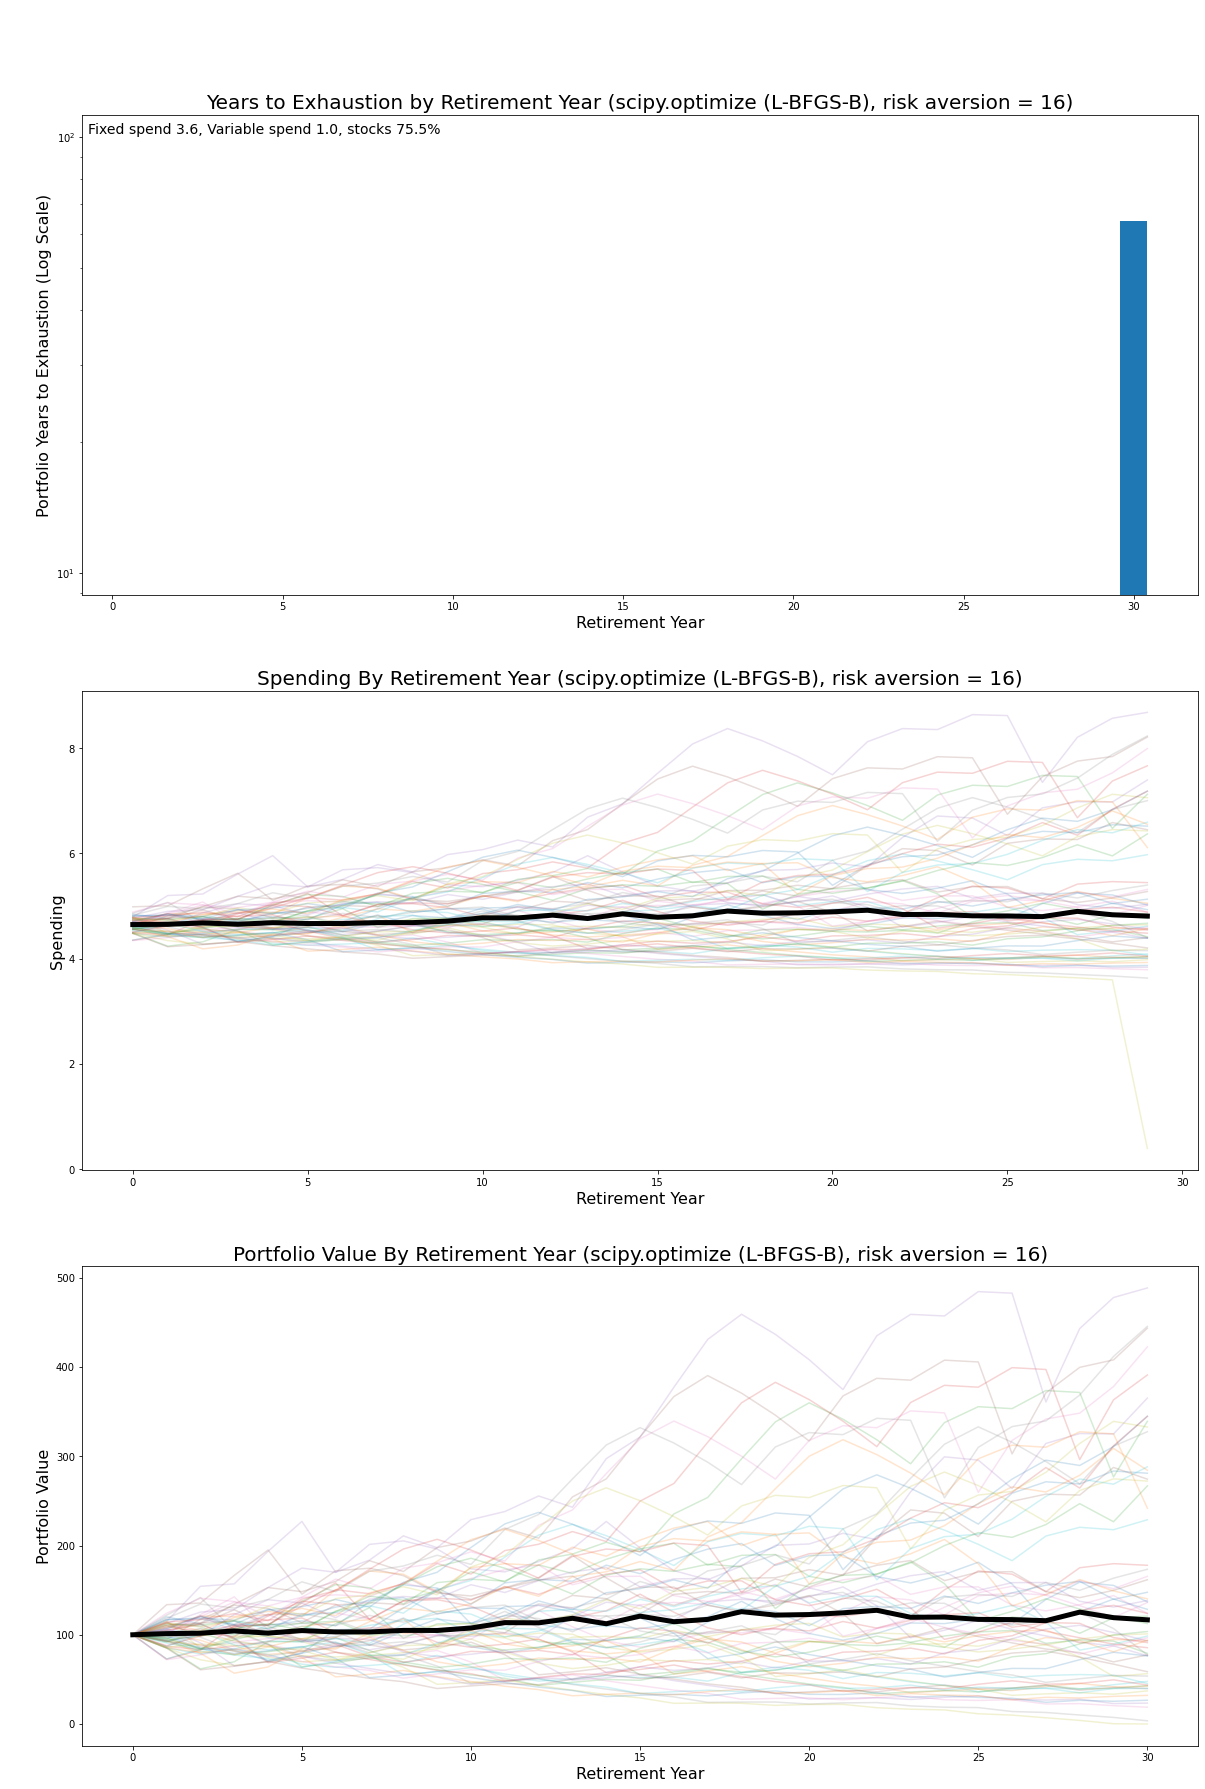

In [9]:
def run_strategy(resultsrow, verbose=True):

    FIXED_SPEND = resultsrow.fixed_spend
    VARIABLE_SPEND = resultsrow.variable_spend
    ALLOC_STOCKS = resultsrow.alloc_stocks
    ALLOC_BONDS = 1 - ALLOC_STOCKS
    GAMMA = resultsrow.gamma
    N_RET_YEARS = 30

    s = SWRsimulation.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': N_RET_YEARS,
                      },
        'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
        'withdrawal': {'fixed_pct': FIXED_SPEND,
                       'variable_pct': VARIABLE_SPEND},
        'evaluation': {'gamma': GAMMA},
        'visualization': {'histogram': True, 
                          'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                       'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (FIXED_SPEND, 
                                                                                                               VARIABLE_SPEND, 
                                                                                                               100 * ALLOC_STOCKS)
                                      },
                          'chart_2' : {'title': 'Spending By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                      },
                          'chart_3' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                      },
                         }    
    })
    
    if verbose:
        print(s)

    s.simulate()

    return s
    

run_strategy(results.iloc[-1]).visualize()


### Dlib

http://blog.dlib.net/2017/12/a-global-optimization-algorithm-worth.html?m=1


In [10]:
print("%s %s" % ("dlib", dlib.__version__))

n_trials = N_TRIALS
optimizer = "dlib"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

def objective_factory(N_RET_YEARS, gamma):
    # partial doesn't work for dlib i.e. objective = partial(ce_experiment, N_RET_YEARS, gamma)
    def objective(fixed_spend, variable_spend, alloc_stocks):
        return ce_experiment(N_RET_YEARS, gamma, fixed_spend, variable_spend, alloc_stocks)
    return objective
    
opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 

    objective = objective_factory(N_RET_YEARS, gamma)

    best = dlib.find_min_global(f=objective, 
                                bound1=[0., 0., 0.],   # lower bounds
                                bound2=[5., 10., 1.],  # variable_spend
                                num_function_calls=n_trials)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)

    study_params.append((best[1], 
                         best[0], 
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %s params %s" % (datestr(), best[1], best[0]))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


dlib 19.21.1
2021-02-11 23:55:50 Starting dlib, gamma 0, 1000 trials
2021-02-11 23:57:59 Finishing optimizer dlib, gamma 0, 1000 trials in 0:02:09.047058
2021-02-11 23:57:59 best value -15532.416056206732 params [0.0, 6.204087381548146, 1.0]
2021-02-11 23:57:59 Starting dlib, gamma 1, 1000 trials
2021-02-12 00:00:06 Finishing optimizer dlib, gamma 1, 1000 trials in 0:02:06.209761
2021-02-12 00:00:06 best value -13517.859787594858 params [0.29529193138131904, 6.239438620291712, 1.0]
2021-02-12 00:00:06 Starting dlib, gamma 2, 1000 trials
2021-02-12 00:02:14 Finishing optimizer dlib, gamma 2, 1000 trials in 0:02:08.678938
2021-02-12 00:02:14 best value -12028.65375869075 params [2.12458281920887, 4.193592549455626, 1.0]
2021-02-12 00:02:14 Starting dlib, gamma 4, 1000 trials
2021-02-12 00:04:29 Finishing optimizer dlib, gamma 4, 1000 trials in 0:02:14.685331
2021-02-12 00:04:29 best value -10315.396638679955 params [2.597496419261401, 3.2471789534082665, 0.8834139687575733]
2021-02-12 00

In [11]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      1.000000     0.000000     0.000000        6.204087   
1      1      1.000000     0.000000     0.295292        6.239439   
2      2      1.000000     0.000000     2.124583        4.193593   
3      4      0.883414     0.116586     2.597496        3.247179   
4      6      0.885044     0.114956     2.949184        2.327530   
5      8      0.737879     0.262121     2.886348        2.530720   
6     10      0.843963     0.156037     3.328163        1.521404   
7     12      0.631437     0.368563     3.255910        1.654755   
8     14      0.771177     0.228823     3.498851        1.153955   
9     16      0.782015     0.217985     3.146965        1.927315   

          value                 timing  
0 -15532.416056 0 days 00:02:09.047058  
1 -13517.859788 0 days 00:02:06.209761  
2 -12028.653759 0 days 00:02:08.678938  
3 -10315.396639 0 days 00:02:14.685331  
4  -9534.421992 0 days 00:02:25.969774  
5  -9057.062333 0 days 00:02:27.527783  
6  -8888.863970 0 days 00:02:26.562907  
7  -8659.229463 0 days 00:02:25.719601  
8  -8602.716036 0 days 00:02:24.800444  
9  -8278.872648 0 days 00:02:25.181663

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f016682c0b0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.146965316345454,
 'fixed_pct': 3.1469653163454545,
 'variable': 0.019273154394929225,
 'variable_pct': 1.9273154394929224}
mean annual spending over all cohorts 5.45
0.00% of portfolios exhausted by final year


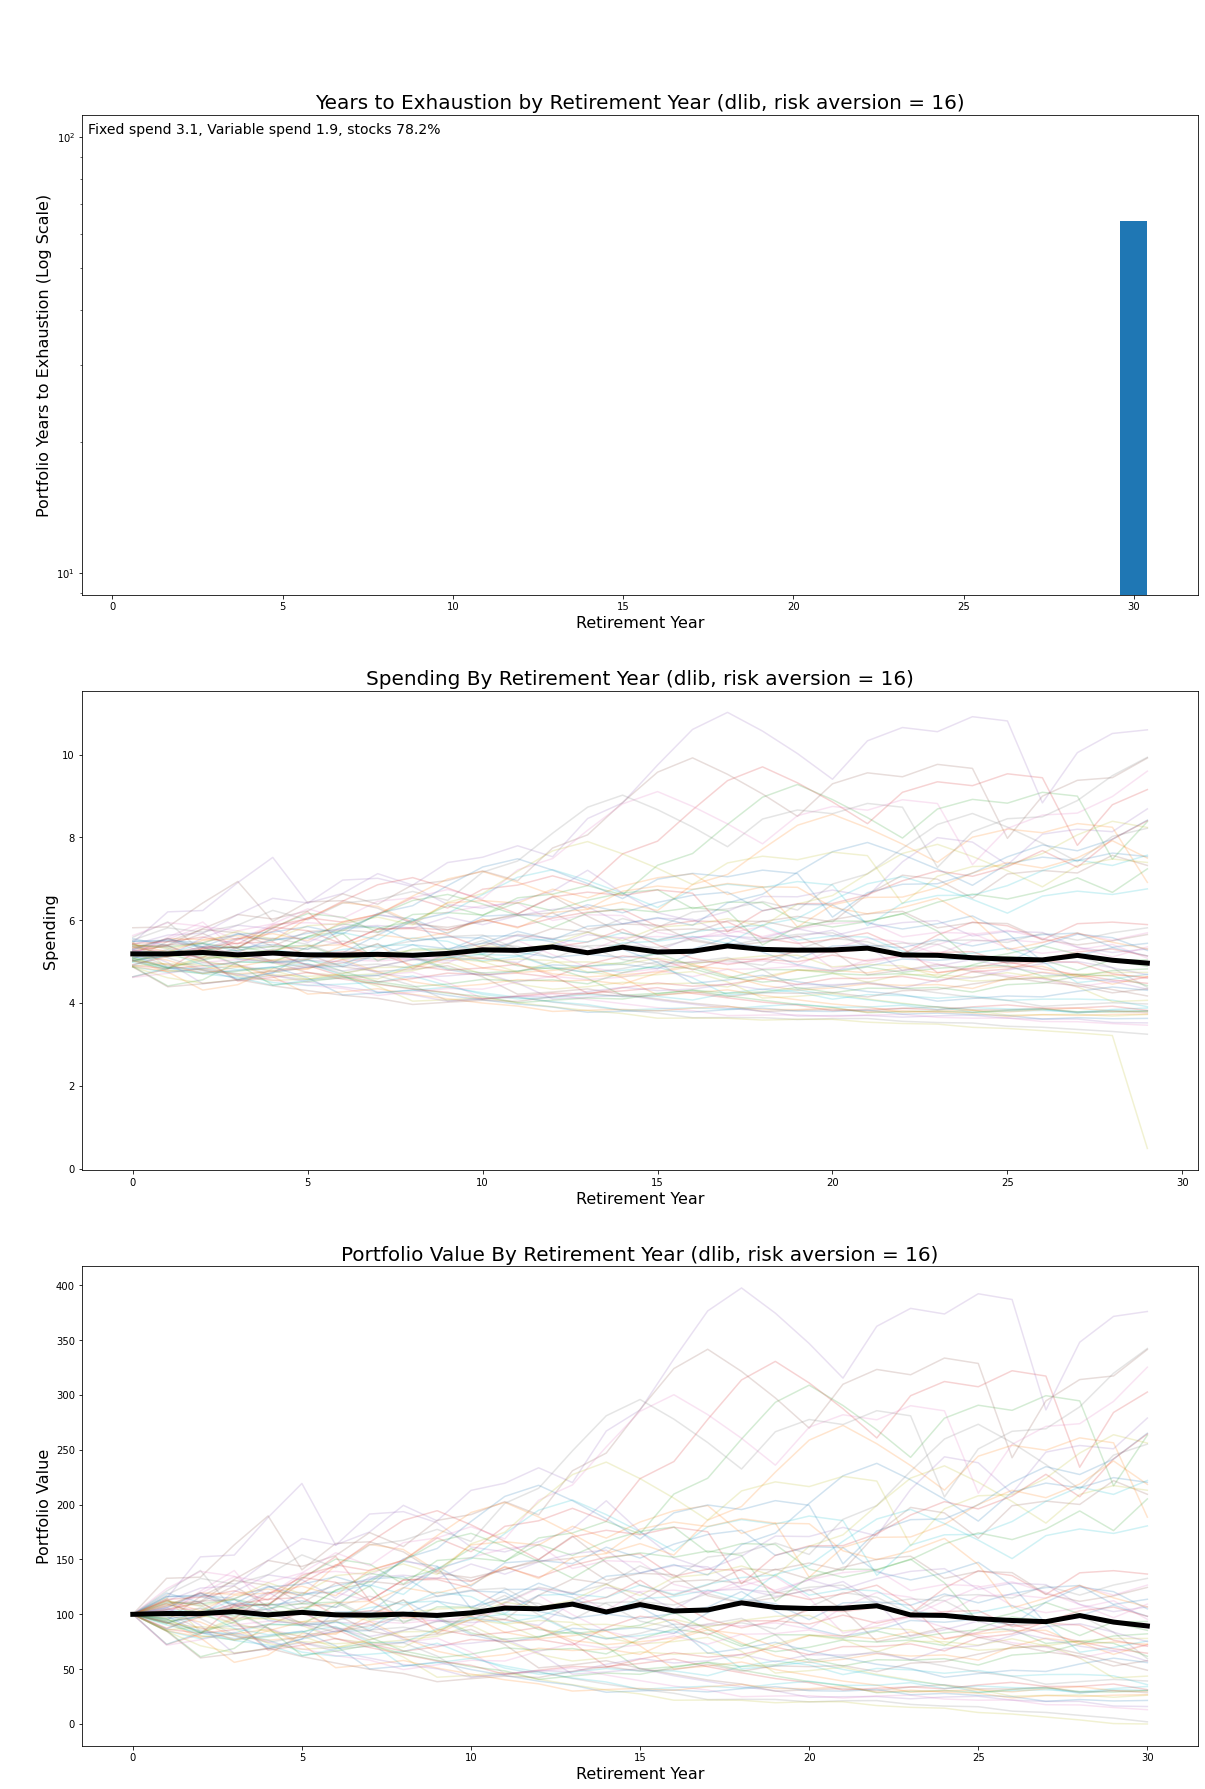

In [12]:
run_strategy(results.iloc[-1]).visualize()


### Optuna

https://optuna.org/


In [13]:
print("%s %s" % ('optuna', optuna.__version__))
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(gamma, trial):
    fixed_spend = trial.suggest_uniform('fixed_spend', 0, 5)
    variable_spend = trial.suggest_uniform('variable_spend', 0, 10)
    alloc_stocks = trial.suggest_uniform('alloc_stocks', 0, 1)
    oobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    return oobjective([fixed_spend, variable_spend, alloc_stocks])

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

n_trials = N_TRIALS
optimizer = "Optuna"

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    study = optuna.create_study()
    study.optimize(partial(objective, gamma), n_trials=n_trials)
    study_params.append(study.best_params)
    study_values.append(study.best_value)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)
    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), study.best_value, study.best_params))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))
    

optuna 2.5.0
2021-02-12 00:19:06 Starting Optuna, gamma 0, 1000 trials
2021-02-12 00:21:16 Finishing optimizer Optuna, gamma 0, 1000 trials in 0:02:10.468040
2021-02-12 00:21:16 best value -15531.614424, best params {'fixed_spend': 0.0007847157178841671, 'variable_spend': 6.224663506031119, 'alloc_stocks': 0.9999480085688115}
2021-02-12 00:21:16 Starting Optuna, gamma 1, 1000 trials
2021-02-12 00:23:23 Finishing optimizer Optuna, gamma 1, 1000 trials in 0:02:07.182655
2021-02-12 00:23:23 best value -13517.502674, best params {'fixed_spend': 0.19336183563154646, 'variable_spend': 6.337500581263833, 'alloc_stocks': 0.9999805220164146}
2021-02-12 00:23:23 Starting Optuna, gamma 2, 1000 trials
2021-02-12 00:25:36 Finishing optimizer Optuna, gamma 2, 1000 trials in 0:02:12.299667
2021-02-12 00:25:36 best value -12033.549468, best params {'fixed_spend': 2.0383136475126613, 'variable_spend': 4.462147095937732, 'alloc_stocks': 0.9986987539462265}
2021-02-12 00:25:36 Starting Optuna, gamma 4, 1

In [14]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['value'] = study_values
results['timing'] = study_timings
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      0.999948     0.000052     0.000785        6.224664   
1      1      0.999981     0.000019     0.193362        6.337501   
2      2      0.998699     0.001301     2.038314        4.462147   
3      4      0.884566     0.115434     2.712828        2.962875   
4      6      0.817395     0.182605     3.010754        2.227662   
5      8      0.795589     0.204411     3.213458        1.781980   
6     10      0.773896     0.226104     3.340696        1.502841   
7     12      0.765280     0.234720     3.397728        1.366525   
8     14      0.766260     0.233740     3.517131        1.111027   
9     16      0.723266     0.276734     3.545993        1.044357   

          value                 timing  
0 -15531.614424 0 days 00:02:10.468040  
1 -13517.502674 0 days 00:02:07.182655  
2 -12033.549468 0 days 00:02:12.299667  
3 -10325.221414 0 days 00:02:19.161642  
4  -9568.636217 0 days 00:02:32.512140  
5  -9161.764855 0 days 00:02:32.663212  
6  -8901.230326 0 days 00:02:33.169590  
7  -8727.895684 0 days 00:02:32.920029  
8  -8600.116941 0 days 00:02:32.960414  
9  -8501.420652 0 days 00:02:33.122752

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f016ea45c10>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.545992865441293,
 'fixed_pct': 3.545992865441293,
 'variable': 0.010443574721704187,
 'variable_pct': 1.0443574721704187}
mean annual spending over all cohorts 4.94
0.00% of portfolios exhausted by final year


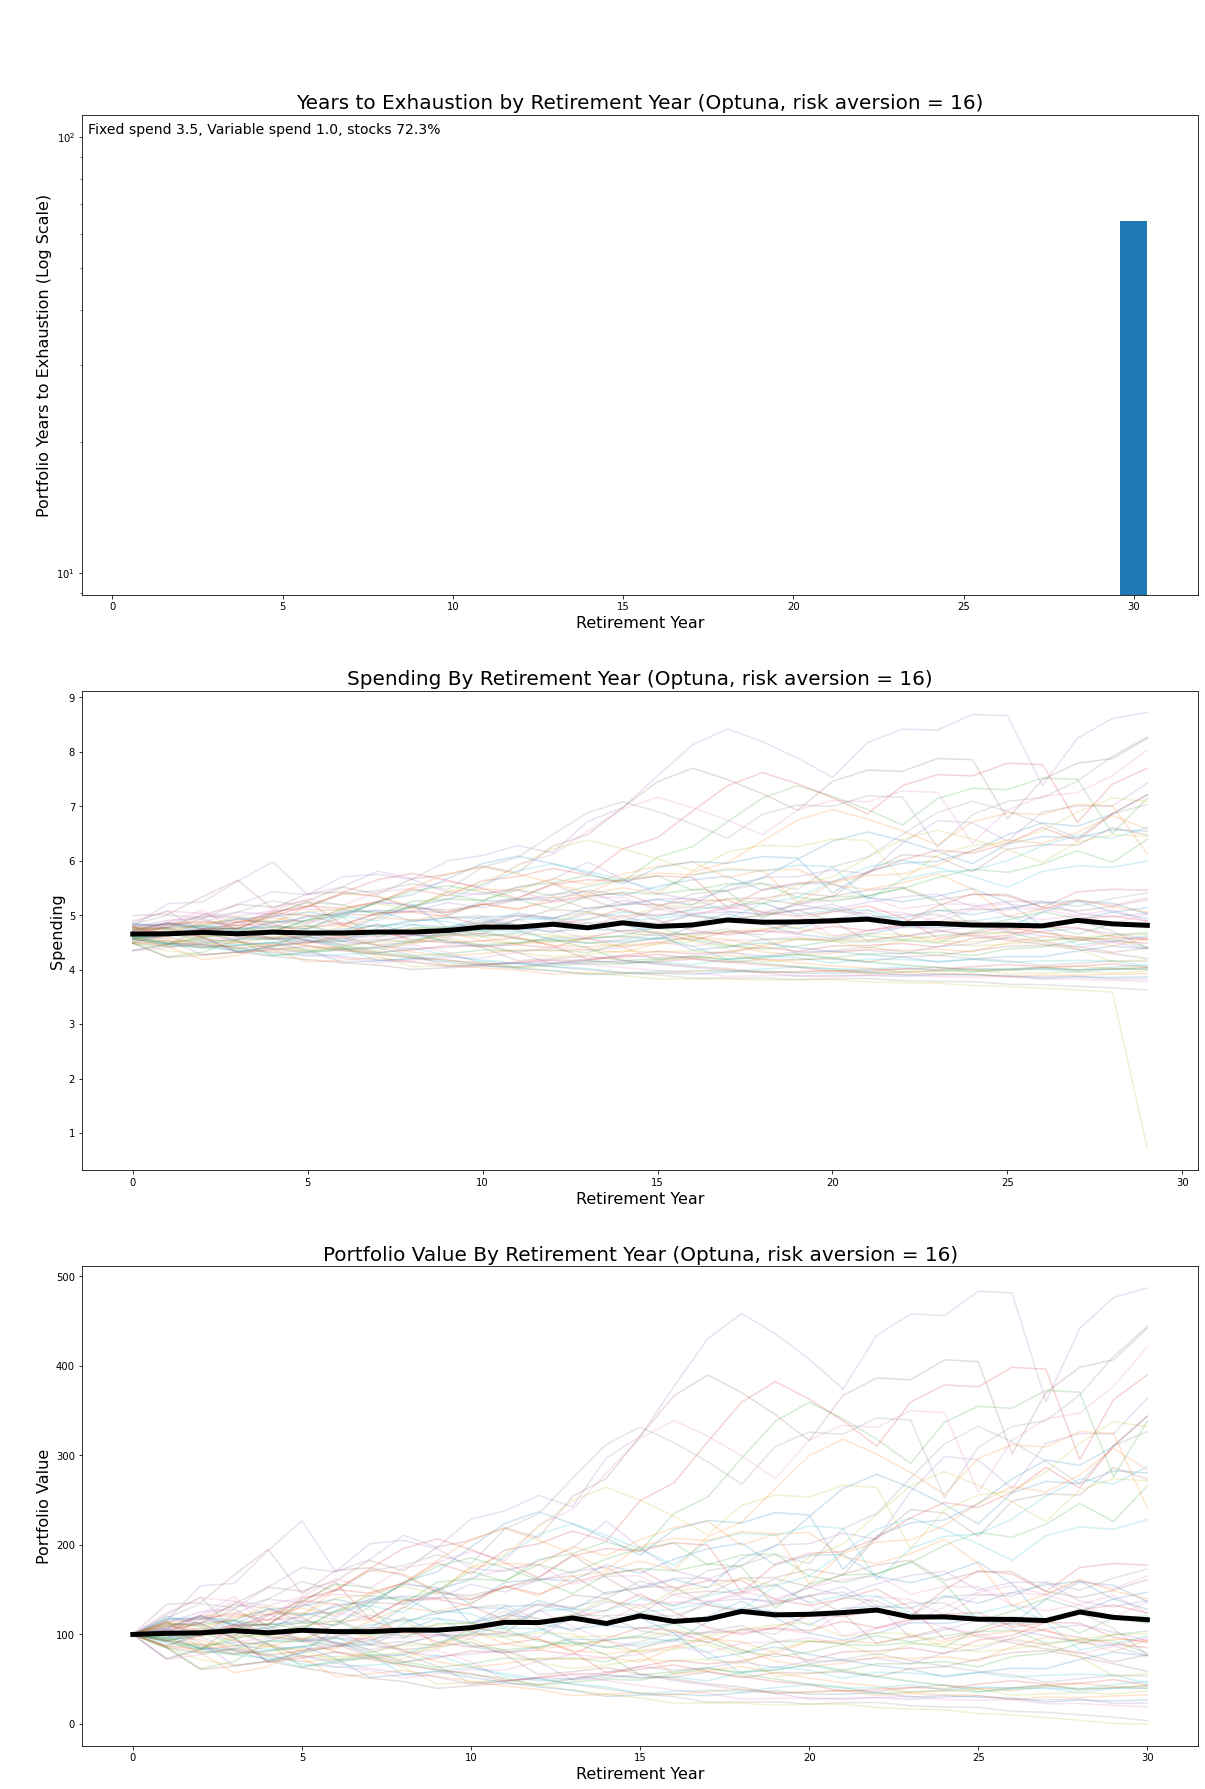

In [15]:
run_strategy(results.iloc[-1]).visualize()


### Hyperopt
http://hyperopt.github.io/hyperopt/

In [16]:
print("%s %s" % ('hyperopt', hyperopt.__version__))

n_trials = N_TRIALS
optimizer = "Hyperopt"

study_params = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    hobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    best = fmin(fn=hobjective,
                space={'fixed_spend': hp.uniform('fixed_spend', 0, 5),
                       'variable_spend': hp.uniform('variable_spend', 0, 10),
                       'alloc_stocks': hp.uniform('alloc_stocks', 0, 1),
                      },
                algo=tpe.suggest,
                max_evals=n_trials)
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), study_params[-1]))
        
opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


hyperopt 0.2.5
2021-02-12 00:43:13 Starting Hyperopt, gamma 0, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000779 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:10,  7.67trial/s, best loss: -10347.714488881807]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -10347.714489


  0%|          | 2/1000 [00:00<02:04,  8.00trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -14929.740741


  0%|          | 3/1000 [00:00<02:03,  8.08trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -14929.740741


  0%|          | 4/1000 [00:00<02:02,  8.15trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000751 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -14929.740741


  0%|          | 5/1000 [00:00<02:02,  8.15trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -14929.740741


  1%|          | 6/1000 [00:00<02:01,  8.19trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000815 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -14929.740741


  1%|          | 7/1000 [00:00<02:01,  8.16trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000767 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -14929.740741


  1%|          | 8/1000 [00:00<02:01,  8.16trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000798 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -14929.740741


  1%|          | 9/1000 [00:01<02:01,  8.16trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000844 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -14929.740741


  1%|          | 10/1000 [00:01<02:01,  8.18trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000800 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -14929.740741


  1%|          | 11/1000 [00:01<02:00,  8.18trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000854 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -14929.740741


  1%|          | 12/1000 [00:01<02:00,  8.19trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000797 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -14929.740741


  1%|▏         | 13/1000 [00:01<02:00,  8.19trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -14929.740741


  1%|▏         | 14/1000 [00:01<02:01,  8.14trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000716 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -14929.740741


  2%|▏         | 15/1000 [00:01<02:00,  8.14trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000517 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -14929.740741


  2%|▏         | 16/1000 [00:01<02:01,  8.12trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000821 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -14929.740741


  2%|▏         | 17/1000 [00:02<02:00,  8.14trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000794 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -14929.740741


  2%|▏         | 18/1000 [00:02<02:00,  8.15trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000839 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -14929.740741


  2%|▏         | 19/1000 [00:02<02:00,  8.13trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000710 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -14929.740741


  2%|▏         | 20/1000 [00:02<02:01,  8.09trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000516 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -14929.740741


  2%|▏         | 21/1000 [00:02<02:02,  7.96trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -14929.740741


  2%|▏         | 22/1000 [00:02<02:04,  7.88trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -14929.740741


  2%|▏         | 23/1000 [00:02<02:04,  7.83trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -14929.740741


  2%|▏         | 24/1000 [00:02<02:05,  7.79trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -14929.740741


  2%|▎         | 25/1000 [00:03<02:05,  7.77trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -14929.740741


  3%|▎         | 26/1000 [00:03<02:03,  7.86trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000515 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -14929.740741


  3%|▎         | 27/1000 [00:03<02:32,  6.37trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -14929.740741


  3%|▎         | 28/1000 [00:03<02:24,  6.73trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -14929.740741


  3%|▎         | 29/1000 [00:03<02:18,  6.99trial/s, best loss: -14929.740741339594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -14929.740741


  3%|▎         | 30/1000 [00:03<02:14,  7.19trial/s, best loss: -14977.5436094256]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -14977.543609


  3%|▎         | 31/1000 [00:03<02:12,  7.33trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -14977.543609


  3%|▎         | 32/1000 [00:04<02:10,  7.42trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -14977.543609


  3%|▎         | 33/1000 [00:04<02:09,  7.48trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -14977.543609


  3%|▎         | 34/1000 [00:04<02:07,  7.60trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -14977.543609


  4%|▎         | 35/1000 [00:04<02:06,  7.60trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -14977.543609


  4%|▎         | 36/1000 [00:04<02:06,  7.60trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -14977.543609


  4%|▎         | 37/1000 [00:04<02:06,  7.59trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -14977.543609


  4%|▍         | 38/1000 [00:04<02:06,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -14977.543609


  4%|▍         | 39/1000 [00:05<02:07,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -14977.543609


  4%|▍         | 40/1000 [00:05<02:07,  7.55trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -14977.543609


  4%|▍         | 41/1000 [00:05<02:06,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -14977.543609


  4%|▍         | 42/1000 [00:05<02:06,  7.59trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -14977.543609


  4%|▍         | 43/1000 [00:05<02:05,  7.60trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -14977.543609


  4%|▍         | 44/1000 [00:05<02:05,  7.60trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -14977.543609


  4%|▍         | 45/1000 [00:05<02:05,  7.60trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -14977.543609


  5%|▍         | 46/1000 [00:05<02:05,  7.59trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -14977.543609


  5%|▍         | 47/1000 [00:06<02:04,  7.66trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -14977.543609


  5%|▍         | 48/1000 [00:06<02:06,  7.55trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -14977.543609


  5%|▍         | 49/1000 [00:06<02:06,  7.54trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -14977.543609


  5%|▌         | 50/1000 [00:06<02:06,  7.52trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -14977.543609


  5%|▌         | 51/1000 [00:06<02:06,  7.51trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -14977.543609


  5%|▌         | 52/1000 [00:06<02:05,  7.53trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -14977.543609


  5%|▌         | 53/1000 [00:06<02:05,  7.55trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -14977.543609


  5%|▌         | 54/1000 [00:07<02:05,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -14977.543609


  6%|▌         | 55/1000 [00:07<02:05,  7.54trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -14977.543609


  6%|▌         | 56/1000 [00:07<02:05,  7.55trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -14977.543609


  6%|▌         | 57/1000 [00:07<02:04,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -14977.543609


  6%|▌         | 58/1000 [00:07<02:04,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -14977.543609


  6%|▌         | 59/1000 [00:07<02:02,  7.66trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -14977.543609


  6%|▌         | 60/1000 [00:07<02:02,  7.66trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -14977.543609


  6%|▌         | 61/1000 [00:07<02:02,  7.65trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -14977.543609


  6%|▌         | 62/1000 [00:08<02:02,  7.67trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -14977.543609


  6%|▋         | 63/1000 [00:08<02:03,  7.59trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -14977.543609


  6%|▋         | 64/1000 [00:08<02:03,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -14977.543609


  6%|▋         | 65/1000 [00:08<02:03,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -14977.543609


  7%|▋         | 66/1000 [00:08<02:03,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -14977.543609


  7%|▋         | 67/1000 [00:08<02:03,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -14977.543609


  7%|▋         | 68/1000 [00:08<02:02,  7.59trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -14977.543609


  7%|▋         | 69/1000 [00:08<02:03,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -14977.543609


  7%|▋         | 70/1000 [00:09<02:02,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -14977.543609


  7%|▋         | 71/1000 [00:09<02:02,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -14977.543609


  7%|▋         | 72/1000 [00:09<02:02,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -14977.543609


  7%|▋         | 73/1000 [00:09<02:02,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -14977.543609


  7%|▋         | 74/1000 [00:09<02:02,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -14977.543609


  8%|▊         | 75/1000 [00:09<02:02,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -14977.543609


  8%|▊         | 76/1000 [00:09<02:02,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -14977.543609


  8%|▊         | 77/1000 [00:10<02:02,  7.55trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -14977.543609


  8%|▊         | 78/1000 [00:10<02:01,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -14977.543609


  8%|▊         | 79/1000 [00:10<02:01,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -14977.543609


  8%|▊         | 80/1000 [00:10<02:01,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -14977.543609


  8%|▊         | 81/1000 [00:10<02:01,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -14977.543609


  8%|▊         | 82/1000 [00:10<02:01,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -14977.543609


  8%|▊         | 83/1000 [00:10<02:01,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -14977.543609


  8%|▊         | 84/1000 [00:10<02:00,  7.59trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -14977.543609


  8%|▊         | 85/1000 [00:11<02:00,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -14977.543609


  9%|▊         | 86/1000 [00:11<02:00,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -14977.543609


  9%|▊         | 87/1000 [00:11<02:00,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -14977.543609


  9%|▉         | 88/1000 [00:11<02:00,  7.56trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -14977.543609


  9%|▉         | 89/1000 [00:11<02:00,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -14977.543609


  9%|▉         | 90/1000 [00:11<02:00,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -14977.543609


  9%|▉         | 91/1000 [00:11<01:59,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -14977.543609


  9%|▉         | 92/1000 [00:12<01:59,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -14977.543609


  9%|▉         | 93/1000 [00:12<01:59,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -14977.543609


  9%|▉         | 94/1000 [00:12<01:59,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -14977.543609


 10%|▉         | 95/1000 [00:12<02:00,  7.53trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -14977.543609


 10%|▉         | 96/1000 [00:12<01:59,  7.55trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -14977.543609


 10%|▉         | 97/1000 [00:12<01:59,  7.57trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -14977.543609


 10%|▉         | 98/1000 [00:12<01:58,  7.58trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -14977.543609


 10%|▉         | 99/1000 [00:12<01:58,  7.60trial/s, best loss: -14977.5436094256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -14977.543609


 10%|█         | 100/1000 [00:13<01:58,  7.59trial/s, best loss: -15135.830698115878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -15135.830698


 10%|█         | 101/1000 [00:13<01:58,  7.58trial/s, best loss: -15135.830698115878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -15135.830698


 10%|█         | 102/1000 [00:13<01:58,  7.58trial/s, best loss: -15135.830698115878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -15135.830698


 10%|█         | 103/1000 [00:13<01:58,  7.56trial/s, best loss: -15226.9132075116]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -15226.913208


 10%|█         | 104/1000 [00:13<01:58,  7.55trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -15226.913208


 10%|█         | 105/1000 [00:13<01:58,  7.54trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -15226.913208


 11%|█         | 106/1000 [00:13<01:58,  7.53trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -15226.913208


 11%|█         | 107/1000 [00:14<01:58,  7.53trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -15226.913208


 11%|█         | 108/1000 [00:14<01:58,  7.54trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -15226.913208


 11%|█         | 109/1000 [00:14<01:58,  7.53trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -15226.913208


 11%|█         | 110/1000 [00:14<01:57,  7.56trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -15226.913208


 11%|█         | 111/1000 [00:14<01:57,  7.55trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -15226.913208


 11%|█         | 112/1000 [00:14<01:58,  7.53trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -15226.913208


 11%|█▏        | 113/1000 [00:14<02:22,  6.21trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -15226.913208


 11%|█▏        | 114/1000 [00:15<02:15,  6.56trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -15226.913208


 12%|█▏        | 115/1000 [00:15<02:09,  6.85trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -15226.913208


 12%|█▏        | 116/1000 [00:15<02:05,  7.04trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -15226.913208


 12%|█▏        | 117/1000 [00:15<02:03,  7.16trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -15226.913208


 12%|█▏        | 118/1000 [00:15<02:01,  7.28trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -15226.913208


 12%|█▏        | 119/1000 [00:15<01:59,  7.37trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -15226.913208


 12%|█▏        | 120/1000 [00:15<01:59,  7.36trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -15226.913208


 12%|█▏        | 121/1000 [00:15<01:58,  7.44trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -15226.913208


 12%|█▏        | 122/1000 [00:16<01:57,  7.48trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -15226.913208


 12%|█▏        | 123/1000 [00:16<01:56,  7.52trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -15226.913208


 12%|█▏        | 124/1000 [00:16<01:56,  7.54trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -15226.913208


 12%|█▎        | 125/1000 [00:16<01:55,  7.56trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -15226.913208


 13%|█▎        | 126/1000 [00:16<01:55,  7.55trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -15226.913208


 13%|█▎        | 127/1000 [00:16<01:55,  7.55trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -15226.913208


 13%|█▎        | 128/1000 [00:16<01:55,  7.55trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -15226.913208


 13%|█▎        | 129/1000 [00:17<01:55,  7.57trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -15226.913208


 13%|█▎        | 130/1000 [00:17<01:54,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -15226.913208


 13%|█▎        | 131/1000 [00:17<01:54,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -15226.913208


 13%|█▎        | 132/1000 [00:17<01:54,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -15226.913208


 13%|█▎        | 133/1000 [00:17<01:54,  7.59trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -15226.913208


 13%|█▎        | 134/1000 [00:17<01:54,  7.56trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -15226.913208


 14%|█▎        | 135/1000 [00:17<01:54,  7.57trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -15226.913208


 14%|█▎        | 136/1000 [00:17<01:54,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -15226.913208


 14%|█▎        | 137/1000 [00:18<01:53,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -15226.913208


 14%|█▍        | 138/1000 [00:18<01:53,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -15226.913208


 14%|█▍        | 139/1000 [00:18<01:53,  7.59trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -15226.913208


 14%|█▍        | 140/1000 [00:18<01:53,  7.59trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -15226.913208


 14%|█▍        | 141/1000 [00:18<01:53,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -15226.913208


 14%|█▍        | 142/1000 [00:18<01:53,  7.57trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -15226.913208


 14%|█▍        | 143/1000 [00:18<01:53,  7.56trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -15226.913208


 14%|█▍        | 144/1000 [00:18<01:53,  7.57trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -15226.913208


 14%|█▍        | 145/1000 [00:19<01:52,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -15226.913208


 15%|█▍        | 146/1000 [00:19<01:52,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -15226.913208


 15%|█▍        | 147/1000 [00:19<01:52,  7.58trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -15226.913208


 15%|█▍        | 148/1000 [00:19<01:52,  7.59trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -15226.913208


 15%|█▍        | 149/1000 [00:19<01:52,  7.59trial/s, best loss: -15226.9132075116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -15226.913208


 15%|█▌        | 150/1000 [00:19<01:52,  7.56trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -15385.869559


 15%|█▌        | 151/1000 [00:19<01:52,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -15385.869559


 15%|█▌        | 152/1000 [00:20<01:52,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -15385.869559


 15%|█▌        | 153/1000 [00:20<01:51,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -15385.869559


 15%|█▌        | 154/1000 [00:20<01:51,  7.56trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -15385.869559


 16%|█▌        | 155/1000 [00:20<01:51,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -15385.869559


 16%|█▌        | 156/1000 [00:20<01:51,  7.58trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -15385.869559


 16%|█▌        | 157/1000 [00:20<01:51,  7.58trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -15385.869559


 16%|█▌        | 158/1000 [00:20<01:51,  7.56trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -15385.869559


 16%|█▌        | 159/1000 [00:20<01:51,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -15385.869559


 16%|█▌        | 160/1000 [00:21<01:50,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -15385.869559


 16%|█▌        | 161/1000 [00:21<01:50,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -15385.869559


 16%|█▌        | 162/1000 [00:21<01:49,  7.65trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -15385.869559


 16%|█▋        | 163/1000 [00:21<01:49,  7.63trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -15385.869559


 16%|█▋        | 164/1000 [00:21<01:49,  7.61trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -15385.869559


 16%|█▋        | 165/1000 [00:21<01:49,  7.60trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -15385.869559


 17%|█▋        | 166/1000 [00:21<01:50,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -15385.869559


 17%|█▋        | 167/1000 [00:22<01:50,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -15385.869559


 17%|█▋        | 168/1000 [00:22<01:50,  7.56trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -15385.869559


 17%|█▋        | 169/1000 [00:22<01:49,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -15385.869559


 17%|█▋        | 170/1000 [00:22<01:49,  7.58trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -15385.869559


 17%|█▋        | 171/1000 [00:22<01:49,  7.58trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -15385.869559


 17%|█▋        | 172/1000 [00:22<01:49,  7.58trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -15385.869559


 17%|█▋        | 173/1000 [00:22<01:49,  7.58trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -15385.869559


 17%|█▋        | 174/1000 [00:22<01:49,  7.56trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -15385.869559


 18%|█▊        | 175/1000 [00:23<01:49,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -15385.869559


 18%|█▊        | 176/1000 [00:23<01:49,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -15385.869559


 18%|█▊        | 177/1000 [00:23<01:48,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -15385.869559


 18%|█▊        | 178/1000 [00:23<01:48,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -15385.869559


 18%|█▊        | 179/1000 [00:23<01:48,  7.56trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -15385.869559


 18%|█▊        | 180/1000 [00:23<01:48,  7.56trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -15385.869559


 18%|█▊        | 181/1000 [00:23<01:48,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -15385.869559


 18%|█▊        | 182/1000 [00:24<01:48,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -15385.869559


 18%|█▊        | 183/1000 [00:24<01:48,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -15385.869559


 18%|█▊        | 184/1000 [00:24<01:48,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -15385.869559


 18%|█▊        | 185/1000 [00:24<01:48,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -15385.869559


 19%|█▊        | 186/1000 [00:24<01:48,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -15385.869559


 19%|█▊        | 187/1000 [00:24<01:47,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -15385.869559


 19%|█▉        | 188/1000 [00:24<01:47,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -15385.869559


 19%|█▉        | 189/1000 [00:24<01:47,  7.56trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -15385.869559


 19%|█▉        | 190/1000 [00:25<02:09,  6.28trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -15385.869559


 19%|█▉        | 191/1000 [00:25<02:02,  6.63trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -15385.869559


 19%|█▉        | 192/1000 [00:25<01:57,  6.88trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -15385.869559


 19%|█▉        | 193/1000 [00:25<01:54,  7.07trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -15385.869559


 19%|█▉        | 194/1000 [00:25<01:51,  7.21trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -15385.869559


 20%|█▉        | 195/1000 [00:25<01:50,  7.31trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -15385.869559


 20%|█▉        | 196/1000 [00:25<01:49,  7.37trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -15385.869559


 20%|█▉        | 197/1000 [00:26<01:48,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -15385.869559


 20%|█▉        | 198/1000 [00:26<01:47,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -15385.869559


 20%|█▉        | 199/1000 [00:26<01:46,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -15385.869559


 20%|██        | 200/1000 [00:26<01:46,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -15385.869559


 20%|██        | 201/1000 [00:26<01:46,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -15385.869559


 20%|██        | 202/1000 [00:26<01:46,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -15385.869559


 20%|██        | 203/1000 [00:26<01:46,  7.51trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -15385.869559


 20%|██        | 204/1000 [00:27<01:46,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -15385.869559


 20%|██        | 205/1000 [00:27<01:45,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -15385.869559


 21%|██        | 206/1000 [00:27<01:45,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -15385.869559


 21%|██        | 207/1000 [00:27<01:45,  7.51trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -15385.869559


 21%|██        | 208/1000 [00:27<01:45,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001704 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -15385.869559


 21%|██        | 209/1000 [00:27<01:46,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -15385.869559


 21%|██        | 210/1000 [00:27<01:45,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -15385.869559


 21%|██        | 211/1000 [00:27<01:45,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -15385.869559


 21%|██        | 212/1000 [00:28<01:45,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -15385.869559


 21%|██▏       | 213/1000 [00:28<01:45,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -15385.869559


 21%|██▏       | 214/1000 [00:28<01:45,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -15385.869559


 22%|██▏       | 215/1000 [00:28<01:45,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -15385.869559


 22%|██▏       | 216/1000 [00:28<01:44,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -15385.869559


 22%|██▏       | 217/1000 [00:28<01:44,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -15385.869559


 22%|██▏       | 218/1000 [00:28<01:43,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -15385.869559


 22%|██▏       | 219/1000 [00:29<01:43,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -15385.869559


 22%|██▏       | 220/1000 [00:29<01:43,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -15385.869559


 22%|██▏       | 221/1000 [00:29<01:43,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -15385.869559


 22%|██▏       | 222/1000 [00:29<01:43,  7.51trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -15385.869559


 22%|██▏       | 223/1000 [00:29<01:43,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -15385.869559


 22%|██▏       | 224/1000 [00:29<01:41,  7.65trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -15385.869559


 22%|██▎       | 225/1000 [00:29<01:41,  7.61trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -15385.869559


 23%|██▎       | 226/1000 [00:29<01:42,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -15385.869559


 23%|██▎       | 227/1000 [00:30<01:42,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -15385.869559


 23%|██▎       | 228/1000 [00:30<01:42,  7.56trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -15385.869559


 23%|██▎       | 229/1000 [00:30<01:41,  7.57trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -15385.869559


 23%|██▎       | 230/1000 [00:30<01:42,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -15385.869559


 23%|██▎       | 231/1000 [00:30<01:42,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -15385.869559


 23%|██▎       | 232/1000 [00:30<01:42,  7.51trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -15385.869559


 23%|██▎       | 233/1000 [00:30<01:41,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -15385.869559


 23%|██▎       | 234/1000 [00:31<01:41,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -15385.869559


 24%|██▎       | 235/1000 [00:31<01:41,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -15385.869559


 24%|██▎       | 236/1000 [00:31<01:41,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -15385.869559


 24%|██▎       | 237/1000 [00:31<01:41,  7.55trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -15385.869559


 24%|██▍       | 238/1000 [00:31<01:41,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -15385.869559


 24%|██▍       | 239/1000 [00:31<01:40,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -15385.869559


 24%|██▍       | 240/1000 [00:31<01:40,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -15385.869559


 24%|██▍       | 241/1000 [00:31<01:40,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -15385.869559


 24%|██▍       | 242/1000 [00:32<01:40,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -15385.869559


 24%|██▍       | 243/1000 [00:32<01:40,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -15385.869559


 24%|██▍       | 244/1000 [00:32<01:40,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -15385.869559


 24%|██▍       | 245/1000 [00:32<01:40,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -15385.869559


 25%|██▍       | 246/1000 [00:32<01:40,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -15385.869559


 25%|██▍       | 247/1000 [00:32<01:40,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -15385.869559


 25%|██▍       | 248/1000 [00:32<01:40,  7.51trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -15385.869559


 25%|██▍       | 249/1000 [00:33<01:39,  7.51trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -15385.869559


 25%|██▌       | 250/1000 [00:33<01:39,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -15385.869559


 25%|██▌       | 251/1000 [00:33<01:39,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -15385.869559


 25%|██▌       | 252/1000 [00:33<01:39,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -15385.869559


 25%|██▌       | 253/1000 [00:33<01:39,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -15385.869559


 25%|██▌       | 254/1000 [00:33<01:40,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -15385.869559


 26%|██▌       | 255/1000 [00:33<01:40,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -15385.869559


 26%|██▌       | 256/1000 [00:33<01:39,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -15385.869559


 26%|██▌       | 257/1000 [00:34<01:39,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -15385.869559


 26%|██▌       | 258/1000 [00:34<01:38,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -15385.869559


 26%|██▌       | 259/1000 [00:34<01:38,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -15385.869559


 26%|██▌       | 260/1000 [00:34<01:38,  7.51trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -15385.869559


 26%|██▌       | 261/1000 [00:34<01:38,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -15385.869559


 26%|██▌       | 262/1000 [00:34<01:38,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -15385.869559


 26%|██▋       | 263/1000 [00:34<01:37,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -15385.869559


 26%|██▋       | 264/1000 [00:34<01:37,  7.54trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -15385.869559


 26%|██▋       | 265/1000 [00:35<01:37,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -15385.869559


 27%|██▋       | 266/1000 [00:35<01:37,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -15385.869559


 27%|██▋       | 267/1000 [00:35<01:37,  7.51trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -15385.869559


 27%|██▋       | 268/1000 [00:35<01:37,  7.51trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -15385.869559


 27%|██▋       | 269/1000 [00:35<01:57,  6.24trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -15385.869559


 27%|██▋       | 270/1000 [00:35<01:50,  6.60trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -15385.869559


 27%|██▋       | 271/1000 [00:36<01:46,  6.86trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -15385.869559


 27%|██▋       | 272/1000 [00:36<01:43,  7.07trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -15385.869559


 27%|██▋       | 273/1000 [00:36<01:40,  7.23trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -15385.869559


 27%|██▋       | 274/1000 [00:36<01:39,  7.33trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -15385.869559


 28%|██▊       | 275/1000 [00:36<01:38,  7.40trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -15385.869559


 28%|██▊       | 276/1000 [00:36<01:37,  7.40trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -15385.869559


 28%|██▊       | 277/1000 [00:36<01:37,  7.40trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -15385.869559


 28%|██▊       | 278/1000 [00:36<01:37,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -15385.869559


 28%|██▊       | 279/1000 [00:37<01:36,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -15385.869559


 28%|██▊       | 280/1000 [00:37<01:36,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -15385.869559


 28%|██▊       | 281/1000 [00:37<01:36,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -15385.869559


 28%|██▊       | 282/1000 [00:37<01:36,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -15385.869559


 28%|██▊       | 283/1000 [00:37<01:35,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -15385.869559


 28%|██▊       | 284/1000 [00:37<01:35,  7.49trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -15385.869559


 28%|██▊       | 285/1000 [00:37<01:35,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -15385.869559


 29%|██▊       | 286/1000 [00:38<01:35,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -15385.869559


 29%|██▊       | 287/1000 [00:38<01:35,  7.49trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -15385.869559


 29%|██▉       | 288/1000 [00:38<01:34,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -15385.869559


 29%|██▉       | 289/1000 [00:38<01:34,  7.52trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -15385.869559


 29%|██▉       | 290/1000 [00:38<01:34,  7.53trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -15385.869559


 29%|██▉       | 291/1000 [00:38<01:34,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -15385.869559


 29%|██▉       | 292/1000 [00:38<01:34,  7.49trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -15385.869559


 29%|██▉       | 293/1000 [00:38<01:34,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -15385.869559


 29%|██▉       | 294/1000 [00:39<01:34,  7.49trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -15385.869559


 30%|██▉       | 295/1000 [00:39<01:34,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -15385.869559


 30%|██▉       | 296/1000 [00:39<01:34,  7.49trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -15385.869559


 30%|██▉       | 297/1000 [00:39<01:34,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -15385.869559


 30%|██▉       | 298/1000 [00:39<01:34,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -15385.869559


 30%|██▉       | 299/1000 [00:39<01:34,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -15385.869559


 30%|███       | 300/1000 [00:39<01:33,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -15385.869559


 30%|███       | 301/1000 [00:40<01:33,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -15385.869559


 30%|███       | 302/1000 [00:40<01:34,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -15385.869559


 30%|███       | 303/1000 [00:40<01:33,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -15385.869559


 30%|███       | 304/1000 [00:40<01:33,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -15385.869559


 30%|███       | 305/1000 [00:40<01:33,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -15385.869559


 31%|███       | 306/1000 [00:40<01:32,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -15385.869559


 31%|███       | 307/1000 [00:40<01:32,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -15385.869559


 31%|███       | 308/1000 [00:40<01:32,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -15385.869559


 31%|███       | 309/1000 [00:41<01:32,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -15385.869559


 31%|███       | 310/1000 [00:41<01:32,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -15385.869559


 31%|███       | 311/1000 [00:41<01:32,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -15385.869559


 31%|███       | 312/1000 [00:41<01:32,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -15385.869559


 31%|███▏      | 313/1000 [00:41<01:31,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -15385.869559


 31%|███▏      | 314/1000 [00:41<01:32,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -15385.869559


 32%|███▏      | 315/1000 [00:41<01:31,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -15385.869559


 32%|███▏      | 316/1000 [00:42<01:31,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -15385.869559


 32%|███▏      | 317/1000 [00:42<01:31,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -15385.869559


 32%|███▏      | 318/1000 [00:42<01:31,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -15385.869559


 32%|███▏      | 319/1000 [00:42<01:31,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -15385.869559


 32%|███▏      | 320/1000 [00:42<01:31,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -15385.869559


 32%|███▏      | 321/1000 [00:42<01:30,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -15385.869559


 32%|███▏      | 322/1000 [00:42<01:30,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -15385.869559


 32%|███▏      | 323/1000 [00:42<01:30,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -15385.869559


 32%|███▏      | 324/1000 [00:43<01:30,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -15385.869559


 32%|███▎      | 325/1000 [00:43<01:30,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -15385.869559


 33%|███▎      | 326/1000 [00:43<01:30,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -15385.869559


 33%|███▎      | 327/1000 [00:43<01:30,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -15385.869559


 33%|███▎      | 328/1000 [00:43<01:30,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -15385.869559


 33%|███▎      | 329/1000 [00:43<01:30,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -15385.869559


 33%|███▎      | 330/1000 [00:43<01:29,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -15385.869559


 33%|███▎      | 331/1000 [00:44<01:29,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -15385.869559


 33%|███▎      | 332/1000 [00:44<01:29,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -15385.869559


 33%|███▎      | 333/1000 [00:44<01:29,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -15385.869559


 33%|███▎      | 334/1000 [00:44<01:29,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -15385.869559


 34%|███▎      | 335/1000 [00:44<01:29,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -15385.869559


 34%|███▎      | 336/1000 [00:44<01:29,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -15385.869559


 34%|███▎      | 337/1000 [00:44<01:28,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -15385.869559


 34%|███▍      | 338/1000 [00:44<01:28,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -15385.869559


 34%|███▍      | 339/1000 [00:45<01:28,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -15385.869559


 34%|███▍      | 340/1000 [00:45<01:28,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -15385.869559


 34%|███▍      | 341/1000 [00:45<01:28,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -15385.869559


 34%|███▍      | 342/1000 [00:45<01:27,  7.49trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -15385.869559


 34%|███▍      | 343/1000 [00:45<01:27,  7.49trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -15385.869559


 34%|███▍      | 344/1000 [00:45<01:27,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -15385.869559


 34%|███▍      | 345/1000 [00:45<01:27,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -15385.869559


 35%|███▍      | 346/1000 [00:46<01:27,  7.48trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -15385.869559


 35%|███▍      | 347/1000 [00:46<01:27,  7.50trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -15385.869559


 35%|███▍      | 348/1000 [00:46<01:44,  6.24trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -15385.869559


 35%|███▍      | 349/1000 [00:46<01:38,  6.59trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -15385.869559


 35%|███▌      | 350/1000 [00:46<01:35,  6.82trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -15385.869559


 35%|███▌      | 351/1000 [00:46<01:32,  6.99trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -15385.869559


 35%|███▌      | 352/1000 [00:46<01:30,  7.13trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -15385.869559


 35%|███▌      | 353/1000 [00:47<01:29,  7.21trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -15385.869559


 35%|███▌      | 354/1000 [00:47<01:28,  7.30trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -15385.869559


 36%|███▌      | 355/1000 [00:47<01:27,  7.36trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -15385.869559


 36%|███▌      | 356/1000 [00:47<01:27,  7.40trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -15385.869559


 36%|███▌      | 357/1000 [00:47<01:26,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -15385.869559


 36%|███▌      | 358/1000 [00:47<01:26,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -15385.869559


 36%|███▌      | 359/1000 [00:47<01:26,  7.41trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -15385.869559


 36%|███▌      | 360/1000 [00:48<01:26,  7.41trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -15385.869559


 36%|███▌      | 361/1000 [00:48<01:25,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -15385.869559


 36%|███▌      | 362/1000 [00:48<01:25,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -15385.869559


 36%|███▋      | 363/1000 [00:48<01:25,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -15385.869559


 36%|███▋      | 364/1000 [00:48<01:25,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -15385.869559


 36%|███▋      | 365/1000 [00:48<01:25,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -15385.869559


 37%|███▋      | 366/1000 [00:48<01:25,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -15385.869559


 37%|███▋      | 367/1000 [00:48<01:25,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -15385.869559


 37%|███▋      | 368/1000 [00:49<01:25,  7.41trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -15385.869559


 37%|███▋      | 369/1000 [00:49<01:25,  7.40trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -15385.869559


 37%|███▋      | 370/1000 [00:49<01:24,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -15385.869559


 37%|███▋      | 371/1000 [00:49<01:24,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -15385.869559


 37%|███▋      | 372/1000 [00:49<01:24,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -15385.869559


 37%|███▋      | 373/1000 [00:49<01:24,  7.42trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -15385.869559


 37%|███▋      | 374/1000 [00:49<01:24,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -15385.869559


 38%|███▊      | 375/1000 [00:50<01:23,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -15385.869559


 38%|███▊      | 376/1000 [00:50<01:23,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -15385.869559


 38%|███▊      | 377/1000 [00:50<01:23,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -15385.869559


 38%|███▊      | 378/1000 [00:50<01:23,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -15385.869559


 38%|███▊      | 379/1000 [00:50<01:23,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -15385.869559


 38%|███▊      | 380/1000 [00:50<01:23,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -15385.869559


 38%|███▊      | 381/1000 [00:50<01:23,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -15385.869559


 38%|███▊      | 382/1000 [00:50<01:22,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -15385.869559


 38%|███▊      | 383/1000 [00:51<01:22,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -15385.869559


 38%|███▊      | 384/1000 [00:51<01:22,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -15385.869559


 38%|███▊      | 385/1000 [00:51<01:22,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -15385.869559


 39%|███▊      | 386/1000 [00:51<01:22,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -15385.869559


 39%|███▊      | 387/1000 [00:51<01:22,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -15385.869559


 39%|███▉      | 388/1000 [00:51<01:22,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -15385.869559


 39%|███▉      | 389/1000 [00:51<01:22,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -15385.869559


 39%|███▉      | 390/1000 [00:52<01:22,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -15385.869559


 39%|███▉      | 391/1000 [00:52<01:21,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -15385.869559


 39%|███▉      | 392/1000 [00:52<01:21,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -15385.869559


 39%|███▉      | 393/1000 [00:52<01:21,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -15385.869559


 39%|███▉      | 394/1000 [00:52<01:21,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -15385.869559


 40%|███▉      | 395/1000 [00:52<01:21,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -15385.869559


 40%|███▉      | 396/1000 [00:52<01:20,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -15385.869559


 40%|███▉      | 397/1000 [00:52<01:20,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -15385.869559


 40%|███▉      | 398/1000 [00:53<01:20,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -15385.869559


 40%|███▉      | 399/1000 [00:53<01:20,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -15385.869559


 40%|████      | 400/1000 [00:53<01:20,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -15385.869559


 40%|████      | 401/1000 [00:53<01:20,  7.47trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -15385.869559


 40%|████      | 402/1000 [00:53<01:20,  7.46trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -15385.869559


 40%|████      | 403/1000 [00:53<01:20,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -15385.869559


 40%|████      | 404/1000 [00:53<01:20,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -15385.869559


 40%|████      | 405/1000 [00:54<01:20,  7.41trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -15385.869559


 41%|████      | 406/1000 [00:54<01:19,  7.43trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -15385.869559


 41%|████      | 407/1000 [00:54<01:19,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -15385.869559


 41%|████      | 408/1000 [00:54<01:19,  7.44trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -15385.869559


 41%|████      | 409/1000 [00:54<01:19,  7.45trial/s, best loss: -15385.869559040626]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -15385.869559


 41%|████      | 410/1000 [00:54<01:19,  7.47trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -15454.084798


 41%|████      | 411/1000 [00:54<01:19,  7.44trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -15454.084798


 41%|████      | 412/1000 [00:55<01:18,  7.45trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -15454.084798


 41%|████▏     | 413/1000 [00:55<01:18,  7.44trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -15454.084798


 41%|████▏     | 414/1000 [00:55<01:18,  7.43trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -15454.084798


 42%|████▏     | 415/1000 [00:55<01:18,  7.41trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -15454.084798


 42%|████▏     | 416/1000 [00:55<01:18,  7.43trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -15454.084798


 42%|████▏     | 417/1000 [00:55<01:18,  7.44trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -15454.084798


 42%|████▏     | 418/1000 [00:55<01:18,  7.45trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -15454.084798


 42%|████▏     | 419/1000 [00:55<01:18,  7.41trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -15454.084798


 42%|████▏     | 420/1000 [00:56<01:18,  7.41trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -15454.084798


 42%|████▏     | 421/1000 [00:56<01:17,  7.43trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -15454.084798


 42%|████▏     | 422/1000 [00:56<01:17,  7.42trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -15454.084798


 42%|████▏     | 423/1000 [00:56<01:18,  7.31trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -15454.084798


 42%|████▏     | 424/1000 [00:56<01:18,  7.35trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -15454.084798


 42%|████▎     | 425/1000 [00:56<01:17,  7.38trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -15454.084798


 43%|████▎     | 426/1000 [00:56<01:33,  6.16trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -15454.084798


 43%|████▎     | 427/1000 [00:57<01:28,  6.49trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -15454.084798


 43%|████▎     | 428/1000 [00:57<01:24,  6.73trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -15454.084798


 43%|████▎     | 429/1000 [00:57<01:22,  6.93trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -15454.084798


 43%|████▎     | 430/1000 [00:57<01:20,  7.08trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -15454.084798


 43%|████▎     | 431/1000 [00:57<01:19,  7.19trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -15454.084798


 43%|████▎     | 432/1000 [00:57<01:18,  7.26trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -15454.084798


 43%|████▎     | 433/1000 [00:57<01:17,  7.33trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -15454.084798


 43%|████▎     | 434/1000 [00:58<01:17,  7.33trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -15454.084798


 44%|████▎     | 435/1000 [00:58<01:16,  7.38trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -15454.084798


 44%|████▎     | 436/1000 [00:58<01:16,  7.40trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -15454.084798


 44%|████▎     | 437/1000 [00:58<01:15,  7.42trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -15454.084798


 44%|████▍     | 438/1000 [00:58<01:15,  7.40trial/s, best loss: -15454.084798468564]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -15454.084798


 44%|████▍     | 439/1000 [00:58<01:15,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -15459.984596


 44%|████▍     | 440/1000 [00:58<01:15,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -15459.984596


 44%|████▍     | 441/1000 [00:59<01:15,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -15459.984596


 44%|████▍     | 442/1000 [00:59<01:15,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -15459.984596


 44%|████▍     | 443/1000 [00:59<01:15,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -15459.984596


 44%|████▍     | 444/1000 [00:59<01:15,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -15459.984596


 44%|████▍     | 445/1000 [00:59<01:14,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -15459.984596


 45%|████▍     | 446/1000 [00:59<01:14,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -15459.984596


 45%|████▍     | 447/1000 [00:59<01:14,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -15459.984596


 45%|████▍     | 448/1000 [00:59<01:14,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -15459.984596


 45%|████▍     | 449/1000 [01:00<01:14,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -15459.984596


 45%|████▌     | 450/1000 [01:00<01:14,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -15459.984596


 45%|████▌     | 451/1000 [01:00<01:13,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -15459.984596


 45%|████▌     | 452/1000 [01:00<01:13,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -15459.984596


 45%|████▌     | 453/1000 [01:00<01:13,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -15459.984596


 45%|████▌     | 454/1000 [01:00<01:13,  7.45trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -15459.984596


 46%|████▌     | 455/1000 [01:00<01:13,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -15459.984596


 46%|████▌     | 456/1000 [01:01<01:13,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -15459.984596


 46%|████▌     | 457/1000 [01:01<01:12,  7.52trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -15459.984596


 46%|████▌     | 458/1000 [01:01<01:12,  7.45trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -15459.984596


 46%|████▌     | 459/1000 [01:01<01:12,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -15459.984596


 46%|████▌     | 460/1000 [01:01<01:12,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -15459.984596


 46%|████▌     | 461/1000 [01:01<01:12,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -15459.984596


 46%|████▌     | 462/1000 [01:01<01:12,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -15459.984596


 46%|████▋     | 463/1000 [01:01<01:12,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -15459.984596


 46%|████▋     | 464/1000 [01:02<01:12,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -15459.984596


 46%|████▋     | 465/1000 [01:02<01:11,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -15459.984596


 47%|████▋     | 466/1000 [01:02<01:12,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -15459.984596


 47%|████▋     | 467/1000 [01:02<01:11,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -15459.984596


 47%|████▋     | 468/1000 [01:02<01:11,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -15459.984596


 47%|████▋     | 469/1000 [01:02<01:11,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -15459.984596


 47%|████▋     | 470/1000 [01:02<01:10,  7.50trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -15459.984596


 47%|████▋     | 471/1000 [01:03<01:10,  7.53trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -15459.984596


 47%|████▋     | 472/1000 [01:03<01:09,  7.60trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -15459.984596


 47%|████▋     | 473/1000 [01:03<01:09,  7.55trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -15459.984596


 47%|████▋     | 474/1000 [01:03<01:09,  7.54trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -15459.984596


 48%|████▊     | 475/1000 [01:03<01:09,  7.56trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -15459.984596


 48%|████▊     | 476/1000 [01:03<01:08,  7.62trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -15459.984596


 48%|████▊     | 477/1000 [01:03<01:09,  7.56trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -15459.984596


 48%|████▊     | 478/1000 [01:03<01:08,  7.61trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -15459.984596


 48%|████▊     | 479/1000 [01:04<01:07,  7.66trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -15459.984596


 48%|████▊     | 480/1000 [01:04<01:08,  7.59trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -15459.984596


 48%|████▊     | 481/1000 [01:04<01:08,  7.53trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -15459.984596


 48%|████▊     | 482/1000 [01:04<01:09,  7.46trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -15459.984596


 48%|████▊     | 483/1000 [01:04<01:09,  7.45trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -15459.984596


 48%|████▊     | 484/1000 [01:04<01:09,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -15459.984596


 48%|████▊     | 485/1000 [01:04<01:09,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -15459.984596


 49%|████▊     | 486/1000 [01:05<01:08,  7.54trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -15459.984596


 49%|████▊     | 487/1000 [01:05<01:08,  7.52trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -15459.984596


 49%|████▉     | 488/1000 [01:05<01:08,  7.50trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -15459.984596


 49%|████▉     | 489/1000 [01:05<01:08,  7.45trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -15459.984596


 49%|████▉     | 490/1000 [01:05<01:08,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -15459.984596


 49%|████▉     | 491/1000 [01:05<01:07,  7.50trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -15459.984596


 49%|████▉     | 492/1000 [01:05<01:07,  7.57trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -15459.984596


 49%|████▉     | 493/1000 [01:05<01:06,  7.62trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -15459.984596


 49%|████▉     | 494/1000 [01:06<01:06,  7.66trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -15459.984596


 50%|████▉     | 495/1000 [01:06<01:05,  7.67trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -15459.984596


 50%|████▉     | 496/1000 [01:06<01:05,  7.69trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -15459.984596


 50%|████▉     | 497/1000 [01:06<01:05,  7.62trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -15459.984596


 50%|████▉     | 498/1000 [01:06<01:05,  7.62trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -15459.984596


 50%|████▉     | 499/1000 [01:06<01:05,  7.63trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -15459.984596


 50%|█████     | 500/1000 [01:06<01:05,  7.64trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -15459.984596


 50%|█████     | 501/1000 [01:07<01:05,  7.56trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -15459.984596


 50%|█████     | 502/1000 [01:07<01:06,  7.50trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -15459.984596


 50%|█████     | 503/1000 [01:07<01:19,  6.26trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -15459.984596


 50%|█████     | 504/1000 [01:07<01:14,  6.63trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -15459.984596


 50%|█████     | 505/1000 [01:07<01:12,  6.81trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -15459.984596


 51%|█████     | 506/1000 [01:07<01:11,  6.96trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -15459.984596


 51%|█████     | 507/1000 [01:07<01:09,  7.10trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -15459.984596


 51%|█████     | 508/1000 [01:08<01:08,  7.18trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -15459.984596


 51%|█████     | 509/1000 [01:08<01:07,  7.23trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -15459.984596


 51%|█████     | 510/1000 [01:08<01:07,  7.27trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -15459.984596


 51%|█████     | 511/1000 [01:08<01:06,  7.32trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -15459.984596


 51%|█████     | 512/1000 [01:08<01:06,  7.36trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -15459.984596


 51%|█████▏    | 513/1000 [01:08<01:06,  7.34trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -15459.984596


 51%|█████▏    | 514/1000 [01:08<01:06,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -15459.984596


 52%|█████▏    | 515/1000 [01:08<01:06,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -15459.984596


 52%|█████▏    | 516/1000 [01:09<01:05,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -15459.984596


 52%|█████▏    | 517/1000 [01:09<01:05,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -15459.984596


 52%|█████▏    | 518/1000 [01:09<01:04,  7.50trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -15459.984596


 52%|█████▏    | 519/1000 [01:09<01:03,  7.55trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -15459.984596


 52%|█████▏    | 520/1000 [01:09<01:03,  7.50trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -15459.984596


 52%|█████▏    | 521/1000 [01:09<01:03,  7.51trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -15459.984596


 52%|█████▏    | 522/1000 [01:09<01:04,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -15459.984596


 52%|█████▏    | 523/1000 [01:10<01:04,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -15459.984596


 52%|█████▏    | 524/1000 [01:10<01:04,  7.38trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -15459.984596


 52%|█████▎    | 525/1000 [01:10<01:04,  7.38trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -15459.984596


 53%|█████▎    | 526/1000 [01:10<01:04,  7.37trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -15459.984596


 53%|█████▎    | 527/1000 [01:10<01:04,  7.37trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -15459.984596


 53%|█████▎    | 528/1000 [01:10<01:04,  7.34trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -15459.984596


 53%|█████▎    | 529/1000 [01:10<01:04,  7.33trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -15459.984596


 53%|█████▎    | 530/1000 [01:11<01:04,  7.33trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -15459.984596


 53%|█████▎    | 531/1000 [01:11<01:03,  7.34trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -15459.984596


 53%|█████▎    | 532/1000 [01:11<01:03,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -15459.984596


 53%|█████▎    | 533/1000 [01:11<01:03,  7.36trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -15459.984596


 53%|█████▎    | 534/1000 [01:11<01:02,  7.48trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -15459.984596


 54%|█████▎    | 535/1000 [01:11<01:02,  7.47trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -15459.984596


 54%|█████▎    | 536/1000 [01:11<01:01,  7.55trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -15459.984596


 54%|█████▎    | 537/1000 [01:11<01:01,  7.56trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001582 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -15459.984596


 54%|█████▍    | 538/1000 [01:12<01:01,  7.51trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -15459.984596


 54%|█████▍    | 539/1000 [01:12<01:01,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -15459.984596


 54%|█████▍    | 540/1000 [01:12<01:01,  7.49trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -15459.984596


 54%|█████▍    | 541/1000 [01:12<01:01,  7.52trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -15459.984596


 54%|█████▍    | 542/1000 [01:12<01:01,  7.46trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -15459.984596


 54%|█████▍    | 543/1000 [01:12<01:01,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -15459.984596


 54%|█████▍    | 544/1000 [01:12<01:01,  7.39trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -15459.984596


 55%|█████▍    | 545/1000 [01:13<01:01,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -15459.984596


 55%|█████▍    | 546/1000 [01:13<01:01,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -15459.984596


 55%|█████▍    | 547/1000 [01:13<01:01,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -15459.984596


 55%|█████▍    | 548/1000 [01:13<01:00,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -15459.984596


 55%|█████▍    | 549/1000 [01:13<01:00,  7.42trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -15459.984596


 55%|█████▌    | 550/1000 [01:13<01:00,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -15459.984596


 55%|█████▌    | 551/1000 [01:13<01:00,  7.38trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -15459.984596


 55%|█████▌    | 552/1000 [01:13<01:00,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -15459.984596


 55%|█████▌    | 553/1000 [01:14<01:00,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -15459.984596


 55%|█████▌    | 554/1000 [01:14<00:59,  7.46trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -15459.984596


 56%|█████▌    | 555/1000 [01:14<00:59,  7.51trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -15459.984596


 56%|█████▌    | 556/1000 [01:14<00:58,  7.55trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -15459.984596


 56%|█████▌    | 557/1000 [01:14<00:59,  7.49trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -15459.984596


 56%|█████▌    | 558/1000 [01:14<00:58,  7.56trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -15459.984596


 56%|█████▌    | 559/1000 [01:14<00:57,  7.62trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -15459.984596


 56%|█████▌    | 560/1000 [01:15<00:57,  7.62trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -15459.984596


 56%|█████▌    | 561/1000 [01:15<00:57,  7.61trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -15459.984596


 56%|█████▌    | 562/1000 [01:15<00:57,  7.62trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -15459.984596


 56%|█████▋    | 563/1000 [01:15<00:57,  7.62trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -15459.984596


 56%|█████▋    | 564/1000 [01:15<00:57,  7.56trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -15459.984596


 56%|█████▋    | 565/1000 [01:15<00:57,  7.58trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -15459.984596


 57%|█████▋    | 566/1000 [01:15<00:57,  7.51trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -15459.984596


 57%|█████▋    | 567/1000 [01:15<00:58,  7.46trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -15459.984596


 57%|█████▋    | 568/1000 [01:16<00:58,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -15459.984596


 57%|█████▋    | 569/1000 [01:16<00:58,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -15459.984596


 57%|█████▋    | 570/1000 [01:16<00:58,  7.33trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -15459.984596


 57%|█████▋    | 571/1000 [01:16<00:58,  7.34trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -15459.984596


 57%|█████▋    | 572/1000 [01:16<00:58,  7.34trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -15459.984596


 57%|█████▋    | 573/1000 [01:16<00:58,  7.33trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -15459.984596


 57%|█████▋    | 574/1000 [01:16<00:58,  7.34trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -15459.984596


 57%|█████▊    | 575/1000 [01:17<00:57,  7.33trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -15459.984596


 58%|█████▊    | 576/1000 [01:17<00:57,  7.36trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -15459.984596


 58%|█████▊    | 577/1000 [01:17<00:57,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -15459.984596


 58%|█████▊    | 578/1000 [01:17<01:08,  6.20trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -15459.984596


 58%|█████▊    | 579/1000 [01:17<01:04,  6.51trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -15459.984596


 58%|█████▊    | 580/1000 [01:17<01:01,  6.81trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -15459.984596


 58%|█████▊    | 581/1000 [01:17<00:59,  7.03trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -15459.984596


 58%|█████▊    | 582/1000 [01:18<00:58,  7.14trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -15459.984596


 58%|█████▊    | 583/1000 [01:18<00:57,  7.27trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -15459.984596


 58%|█████▊    | 584/1000 [01:18<00:57,  7.29trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -15459.984596


 58%|█████▊    | 585/1000 [01:18<00:56,  7.39trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -15459.984596


 59%|█████▊    | 586/1000 [01:18<00:56,  7.38trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -15459.984596


 59%|█████▊    | 587/1000 [01:18<00:56,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -15459.984596


 59%|█████▉    | 588/1000 [01:18<00:55,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -15459.984596


 59%|█████▉    | 589/1000 [01:19<00:55,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -15459.984596


 59%|█████▉    | 590/1000 [01:19<00:55,  7.38trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -15459.984596


 59%|█████▉    | 591/1000 [01:19<00:55,  7.41trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -15459.984596


 59%|█████▉    | 592/1000 [01:19<00:55,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -15459.984596


 59%|█████▉    | 593/1000 [01:19<00:54,  7.46trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -15459.984596


 59%|█████▉    | 594/1000 [01:19<00:54,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -15459.984596


 60%|█████▉    | 595/1000 [01:19<00:54,  7.43trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -15459.984596


 60%|█████▉    | 596/1000 [01:19<00:54,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -15459.984596


 60%|█████▉    | 597/1000 [01:20<00:54,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -15459.984596


 60%|█████▉    | 598/1000 [01:20<00:54,  7.38trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -15459.984596


 60%|█████▉    | 599/1000 [01:20<00:54,  7.38trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -15459.984596


 60%|██████    | 600/1000 [01:20<00:54,  7.34trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -15459.984596


 60%|██████    | 601/1000 [01:20<00:54,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -15459.984596


 60%|██████    | 602/1000 [01:20<00:53,  7.38trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -15459.984596


 60%|██████    | 603/1000 [01:20<00:53,  7.37trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -15459.984596


 60%|██████    | 604/1000 [01:21<00:53,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -15459.984596


 60%|██████    | 605/1000 [01:21<00:53,  7.33trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -15459.984596


 61%|██████    | 606/1000 [01:21<00:53,  7.33trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -15459.984596


 61%|██████    | 607/1000 [01:21<00:53,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -15459.984596


 61%|██████    | 608/1000 [01:21<00:53,  7.32trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -15459.984596


 61%|██████    | 609/1000 [01:21<00:53,  7.33trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -15459.984596


 61%|██████    | 610/1000 [01:21<00:52,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -15459.984596


 61%|██████    | 611/1000 [01:21<00:51,  7.49trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -15459.984596


 61%|██████    | 612/1000 [01:22<00:52,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -15459.984596


 61%|██████▏   | 613/1000 [01:22<00:52,  7.44trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -15459.984596


 61%|██████▏   | 614/1000 [01:22<00:52,  7.40trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -15459.984596


 62%|██████▏   | 615/1000 [01:22<00:52,  7.39trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -15459.984596


 62%|██████▏   | 616/1000 [01:22<00:52,  7.37trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -15459.984596


 62%|██████▏   | 617/1000 [01:22<00:52,  7.35trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -15459.984596


 62%|██████▏   | 618/1000 [01:22<00:52,  7.32trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -15459.984596


 62%|██████▏   | 619/1000 [01:23<00:52,  7.31trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -15459.984596


 62%|██████▏   | 620/1000 [01:23<00:51,  7.33trial/s, best loss: -15459.984595933183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -15459.984596


 62%|██████▏   | 621/1000 [01:23<00:51,  7.36trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -15503.173268


 62%|██████▏   | 622/1000 [01:23<00:51,  7.35trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -15503.173268


 62%|██████▏   | 623/1000 [01:23<00:51,  7.34trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -15503.173268


 62%|██████▏   | 624/1000 [01:23<00:51,  7.34trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -15503.173268


 62%|██████▎   | 625/1000 [01:23<00:50,  7.35trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -15503.173268


 63%|██████▎   | 626/1000 [01:24<00:50,  7.34trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -15503.173268


 63%|██████▎   | 627/1000 [01:24<00:49,  7.46trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -15503.173268


 63%|██████▎   | 628/1000 [01:24<00:50,  7.44trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -15503.173268


 63%|██████▎   | 629/1000 [01:24<00:50,  7.40trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -15503.173268


 63%|██████▎   | 630/1000 [01:24<00:50,  7.38trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -15503.173268


 63%|██████▎   | 631/1000 [01:24<00:50,  7.35trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -15503.173268


 63%|██████▎   | 632/1000 [01:24<00:50,  7.34trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -15503.173268


 63%|██████▎   | 633/1000 [01:24<00:49,  7.34trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -15503.173268


 63%|██████▎   | 634/1000 [01:25<00:49,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -15503.173268


 64%|██████▎   | 635/1000 [01:25<00:50,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -15503.173268


 64%|██████▎   | 636/1000 [01:25<00:49,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -15503.173268


 64%|██████▎   | 637/1000 [01:25<00:49,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -15503.173268


 64%|██████▍   | 638/1000 [01:25<00:49,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -15503.173268


 64%|██████▍   | 639/1000 [01:25<00:49,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -15503.173268


 64%|██████▍   | 640/1000 [01:25<00:49,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -15503.173268


 64%|██████▍   | 641/1000 [01:26<00:49,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -15503.173268


 64%|██████▍   | 642/1000 [01:26<00:49,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -15503.173268


 64%|██████▍   | 643/1000 [01:26<00:49,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -15503.173268


 64%|██████▍   | 644/1000 [01:26<00:48,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -15503.173268


 64%|██████▍   | 645/1000 [01:26<00:48,  7.34trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -15503.173268


 65%|██████▍   | 646/1000 [01:26<00:48,  7.33trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -15503.173268


 65%|██████▍   | 647/1000 [01:26<00:48,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -15503.173268


 65%|██████▍   | 648/1000 [01:27<00:48,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -15503.173268


 65%|██████▍   | 649/1000 [01:27<00:48,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -15503.173268


 65%|██████▌   | 650/1000 [01:27<00:47,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -15503.173268


 65%|██████▌   | 651/1000 [01:27<00:47,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -15503.173268


 65%|██████▌   | 652/1000 [01:27<00:47,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -15503.173268


 65%|██████▌   | 653/1000 [01:27<00:47,  7.33trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -15503.173268


 65%|██████▌   | 654/1000 [01:27<00:47,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -15503.173268


 66%|██████▌   | 655/1000 [01:28<00:56,  6.08trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -15503.173268


 66%|██████▌   | 656/1000 [01:28<00:53,  6.42trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -15503.173268


 66%|██████▌   | 657/1000 [01:28<00:51,  6.66trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -15503.173268


 66%|██████▌   | 658/1000 [01:28<00:50,  6.84trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -15503.173268


 66%|██████▌   | 659/1000 [01:28<00:48,  6.98trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -15503.173268


 66%|██████▌   | 660/1000 [01:28<00:48,  7.07trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -15503.173268


 66%|██████▌   | 661/1000 [01:28<00:47,  7.12trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -15503.173268


 66%|██████▌   | 662/1000 [01:29<00:47,  7.17trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -15503.173268


 66%|██████▋   | 663/1000 [01:29<00:46,  7.19trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -15503.173268


 66%|██████▋   | 664/1000 [01:29<00:46,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -15503.173268


 66%|██████▋   | 665/1000 [01:29<00:46,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -15503.173268


 67%|██████▋   | 666/1000 [01:29<00:46,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -15503.173268


 67%|██████▋   | 667/1000 [01:29<00:45,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -15503.173268


 67%|██████▋   | 668/1000 [01:29<00:45,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -15503.173268


 67%|██████▋   | 669/1000 [01:30<00:45,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -15503.173268


 67%|██████▋   | 670/1000 [01:30<00:45,  7.33trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -15503.173268


 67%|██████▋   | 671/1000 [01:30<00:44,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -15503.173268


 67%|██████▋   | 672/1000 [01:30<00:44,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -15503.173268


 67%|██████▋   | 673/1000 [01:30<00:44,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -15503.173268


 67%|██████▋   | 674/1000 [01:30<00:44,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -15503.173268


 68%|██████▊   | 675/1000 [01:30<00:44,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -15503.173268


 68%|██████▊   | 676/1000 [01:30<00:44,  7.35trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -15503.173268


 68%|██████▊   | 677/1000 [01:31<00:44,  7.33trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -15503.173268


 68%|██████▊   | 678/1000 [01:31<00:43,  7.33trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -15503.173268


 68%|██████▊   | 679/1000 [01:31<00:44,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -15503.173268


 68%|██████▊   | 680/1000 [01:31<00:43,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -15503.173268


 68%|██████▊   | 681/1000 [01:31<00:43,  7.33trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -15503.173268


 68%|██████▊   | 682/1000 [01:31<00:43,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -15503.173268


 68%|██████▊   | 683/1000 [01:31<00:43,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -15503.173268


 68%|██████▊   | 684/1000 [01:32<00:43,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -15503.173268


 68%|██████▊   | 685/1000 [01:32<00:43,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -15503.173268


 69%|██████▊   | 686/1000 [01:32<00:43,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -15503.173268


 69%|██████▊   | 687/1000 [01:32<00:43,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -15503.173268


 69%|██████▉   | 688/1000 [01:32<00:42,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -15503.173268


 69%|██████▉   | 689/1000 [01:32<00:42,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -15503.173268


 69%|██████▉   | 690/1000 [01:32<00:42,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -15503.173268


 69%|██████▉   | 691/1000 [01:33<00:42,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -15503.173268


 69%|██████▉   | 692/1000 [01:33<00:42,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -15503.173268


 69%|██████▉   | 693/1000 [01:33<00:42,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -15503.173268


 69%|██████▉   | 694/1000 [01:33<00:41,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -15503.173268


 70%|██████▉   | 695/1000 [01:33<00:41,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -15503.173268


 70%|██████▉   | 696/1000 [01:33<00:41,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -15503.173268


 70%|██████▉   | 697/1000 [01:33<00:41,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -15503.173268


 70%|██████▉   | 698/1000 [01:33<00:41,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -15503.173268


 70%|██████▉   | 699/1000 [01:34<00:41,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -15503.173268


 70%|███████   | 700/1000 [01:34<00:41,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -15503.173268


 70%|███████   | 701/1000 [01:34<00:41,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -15503.173268


 70%|███████   | 702/1000 [01:34<00:41,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -15503.173268


 70%|███████   | 703/1000 [01:34<00:41,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -15503.173268


 70%|███████   | 704/1000 [01:34<00:40,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -15503.173268


 70%|███████   | 705/1000 [01:34<00:40,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -15503.173268


 71%|███████   | 706/1000 [01:35<00:40,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -15503.173268


 71%|███████   | 707/1000 [01:35<00:40,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -15503.173268


 71%|███████   | 708/1000 [01:35<00:40,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -15503.173268


 71%|███████   | 709/1000 [01:35<00:39,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -15503.173268


 71%|███████   | 710/1000 [01:35<00:39,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -15503.173268


 71%|███████   | 711/1000 [01:35<00:39,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -15503.173268


 71%|███████   | 712/1000 [01:35<00:39,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -15503.173268


 71%|███████▏  | 713/1000 [01:36<00:39,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -15503.173268


 71%|███████▏  | 714/1000 [01:36<00:39,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -15503.173268


 72%|███████▏  | 715/1000 [01:36<00:39,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -15503.173268


 72%|███████▏  | 716/1000 [01:36<00:39,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -15503.173268


 72%|███████▏  | 717/1000 [01:36<00:39,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -15503.173268


 72%|███████▏  | 718/1000 [01:36<00:38,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -15503.173268


 72%|███████▏  | 719/1000 [01:36<00:38,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -15503.173268


 72%|███████▏  | 720/1000 [01:37<00:38,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -15503.173268


 72%|███████▏  | 721/1000 [01:37<00:38,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -15503.173268


 72%|███████▏  | 722/1000 [01:37<00:38,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -15503.173268


 72%|███████▏  | 723/1000 [01:37<00:38,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -15503.173268


 72%|███████▏  | 724/1000 [01:37<00:38,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -15503.173268


 72%|███████▎  | 725/1000 [01:37<00:38,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -15503.173268


 73%|███████▎  | 726/1000 [01:37<00:37,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -15503.173268


 73%|███████▎  | 727/1000 [01:37<00:37,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -15503.173268


 73%|███████▎  | 728/1000 [01:38<00:37,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -15503.173268


 73%|███████▎  | 729/1000 [01:38<00:37,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -15503.173268


 73%|███████▎  | 730/1000 [01:38<00:37,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -15503.173268


 73%|███████▎  | 731/1000 [01:38<00:36,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -15503.173268


 73%|███████▎  | 732/1000 [01:38<00:36,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -15503.173268


 73%|███████▎  | 733/1000 [01:38<00:43,  6.08trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -15503.173268


 73%|███████▎  | 734/1000 [01:39<00:41,  6.39trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -15503.173268


 74%|███████▎  | 735/1000 [01:39<00:39,  6.63trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -15503.173268


 74%|███████▎  | 736/1000 [01:39<00:38,  6.80trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -15503.173268


 74%|███████▎  | 737/1000 [01:39<00:37,  6.95trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -15503.173268


 74%|███████▍  | 738/1000 [01:39<00:37,  7.06trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -15503.173268


 74%|███████▍  | 739/1000 [01:39<00:36,  7.14trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -15503.173268


 74%|███████▍  | 740/1000 [01:39<00:36,  7.20trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -15503.173268


 74%|███████▍  | 741/1000 [01:39<00:35,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -15503.173268


 74%|███████▍  | 742/1000 [01:40<00:35,  7.20trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -15503.173268


 74%|███████▍  | 743/1000 [01:40<00:35,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -15503.173268


 74%|███████▍  | 744/1000 [01:40<00:35,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -15503.173268


 74%|███████▍  | 745/1000 [01:40<00:35,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -15503.173268


 75%|███████▍  | 746/1000 [01:40<00:35,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -15503.173268


 75%|███████▍  | 747/1000 [01:40<00:35,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -15503.173268


 75%|███████▍  | 748/1000 [01:40<00:35,  7.15trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -15503.173268


 75%|███████▍  | 749/1000 [01:41<00:34,  7.18trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -15503.173268


 75%|███████▌  | 750/1000 [01:41<00:34,  7.17trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -15503.173268


 75%|███████▌  | 751/1000 [01:41<00:34,  7.19trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -15503.173268


 75%|███████▌  | 752/1000 [01:41<00:34,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -15503.173268


 75%|███████▌  | 753/1000 [01:41<00:34,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -15503.173268


 75%|███████▌  | 754/1000 [01:41<00:34,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -15503.173268


 76%|███████▌  | 755/1000 [01:41<00:33,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -15503.173268


 76%|███████▌  | 756/1000 [01:42<00:33,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -15503.173268


 76%|███████▌  | 757/1000 [01:42<00:33,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -15503.173268


 76%|███████▌  | 758/1000 [01:42<00:33,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -15503.173268


 76%|███████▌  | 759/1000 [01:42<00:33,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -15503.173268


 76%|███████▌  | 760/1000 [01:42<00:33,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -15503.173268


 76%|███████▌  | 761/1000 [01:42<00:32,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -15503.173268


 76%|███████▌  | 762/1000 [01:42<00:32,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -15503.173268


 76%|███████▋  | 763/1000 [01:43<00:32,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -15503.173268


 76%|███████▋  | 764/1000 [01:43<00:32,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -15503.173268


 76%|███████▋  | 765/1000 [01:43<00:32,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -15503.173268


 77%|███████▋  | 766/1000 [01:43<00:32,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -15503.173268


 77%|███████▋  | 767/1000 [01:43<00:32,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -15503.173268


 77%|███████▋  | 768/1000 [01:43<00:31,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -15503.173268


 77%|███████▋  | 769/1000 [01:43<00:31,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -15503.173268


 77%|███████▋  | 770/1000 [01:43<00:31,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -15503.173268


 77%|███████▋  | 771/1000 [01:44<00:31,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -15503.173268


 77%|███████▋  | 772/1000 [01:44<00:31,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -15503.173268


 77%|███████▋  | 773/1000 [01:44<00:31,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -15503.173268


 77%|███████▋  | 774/1000 [01:44<00:30,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -15503.173268


 78%|███████▊  | 775/1000 [01:44<00:30,  7.33trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -15503.173268


 78%|███████▊  | 776/1000 [01:44<00:30,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -15503.173268


 78%|███████▊  | 777/1000 [01:44<00:30,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -15503.173268


 78%|███████▊  | 778/1000 [01:45<00:30,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -15503.173268


 78%|███████▊  | 779/1000 [01:45<00:30,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -15503.173268


 78%|███████▊  | 780/1000 [01:45<00:30,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -15503.173268


 78%|███████▊  | 781/1000 [01:45<00:30,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -15503.173268


 78%|███████▊  | 782/1000 [01:45<00:29,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -15503.173268


 78%|███████▊  | 783/1000 [01:45<00:29,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -15503.173268


 78%|███████▊  | 784/1000 [01:45<00:29,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -15503.173268


 78%|███████▊  | 785/1000 [01:46<00:29,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -15503.173268


 79%|███████▊  | 786/1000 [01:46<00:29,  7.34trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -15503.173268


 79%|███████▊  | 787/1000 [01:46<00:29,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -15503.173268


 79%|███████▉  | 788/1000 [01:46<00:28,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -15503.173268


 79%|███████▉  | 789/1000 [01:46<00:28,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -15503.173268


 79%|███████▉  | 790/1000 [01:46<00:28,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -15503.173268


 79%|███████▉  | 791/1000 [01:46<00:28,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -15503.173268


 79%|███████▉  | 792/1000 [01:47<00:28,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -15503.173268


 79%|███████▉  | 793/1000 [01:47<00:28,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -15503.173268


 79%|███████▉  | 794/1000 [01:47<00:28,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000691 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -15503.173268


 80%|███████▉  | 795/1000 [01:47<00:27,  7.33trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -15503.173268


 80%|███████▉  | 796/1000 [01:47<00:27,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -15503.173268


 80%|███████▉  | 797/1000 [01:47<00:27,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -15503.173268


 80%|███████▉  | 798/1000 [01:47<00:27,  7.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -15503.173268


 80%|███████▉  | 799/1000 [01:47<00:27,  7.30trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -15503.173268


 80%|████████  | 800/1000 [01:48<00:27,  7.35trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -15503.173268


 80%|████████  | 801/1000 [01:48<00:27,  7.33trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -15503.173268


 80%|████████  | 802/1000 [01:48<00:27,  7.32trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -15503.173268


 80%|████████  | 803/1000 [01:48<00:27,  7.29trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -15503.173268


 80%|████████  | 804/1000 [01:48<00:26,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -15503.173268


 80%|████████  | 805/1000 [01:48<00:26,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -15503.173268


 81%|████████  | 806/1000 [01:48<00:26,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -15503.173268


 81%|████████  | 807/1000 [01:49<00:26,  7.28trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -15503.173268


 81%|████████  | 808/1000 [01:49<00:26,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -15503.173268


 81%|████████  | 809/1000 [01:49<00:26,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -15503.173268


 81%|████████  | 810/1000 [01:49<00:31,  6.12trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -15503.173268


 81%|████████  | 811/1000 [01:49<00:29,  6.43trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -15503.173268


 81%|████████  | 812/1000 [01:49<00:28,  6.66trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -15503.173268


 81%|████████▏ | 813/1000 [01:49<00:27,  6.82trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -15503.173268


 81%|████████▏ | 814/1000 [01:50<00:26,  6.95trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000666 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -15503.173268


 82%|████████▏ | 815/1000 [01:50<00:26,  7.03trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -15503.173268


 82%|████████▏ | 816/1000 [01:50<00:25,  7.08trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -15503.173268


 82%|████████▏ | 817/1000 [01:50<00:25,  7.16trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -15503.173268


 82%|████████▏ | 818/1000 [01:50<00:25,  7.19trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -15503.173268


 82%|████████▏ | 819/1000 [01:50<00:25,  7.18trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -15503.173268


 82%|████████▏ | 820/1000 [01:50<00:24,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -15503.173268


 82%|████████▏ | 821/1000 [01:51<00:24,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -15503.173268


 82%|████████▏ | 822/1000 [01:51<00:24,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -15503.173268


 82%|████████▏ | 823/1000 [01:51<00:24,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -15503.173268


 82%|████████▏ | 824/1000 [01:51<00:24,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -15503.173268


 82%|████████▎ | 825/1000 [01:51<00:24,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -15503.173268


 83%|████████▎ | 826/1000 [01:51<00:23,  7.27trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -15503.173268


 83%|████████▎ | 827/1000 [01:51<00:23,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -15503.173268


 83%|████████▎ | 828/1000 [01:52<00:23,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -15503.173268


 83%|████████▎ | 829/1000 [01:52<00:23,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -15503.173268


 83%|████████▎ | 830/1000 [01:52<00:23,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -15503.173268


 83%|████████▎ | 831/1000 [01:52<00:23,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -15503.173268


 83%|████████▎ | 832/1000 [01:52<00:23,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -15503.173268


 83%|████████▎ | 833/1000 [01:52<00:23,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -15503.173268


 83%|████████▎ | 834/1000 [01:52<00:22,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -15503.173268


 84%|████████▎ | 835/1000 [01:53<00:22,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -15503.173268


 84%|████████▎ | 836/1000 [01:53<00:22,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -15503.173268


 84%|████████▎ | 837/1000 [01:53<00:22,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -15503.173268


 84%|████████▍ | 838/1000 [01:53<00:22,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -15503.173268


 84%|████████▍ | 839/1000 [01:53<00:22,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -15503.173268


 84%|████████▍ | 840/1000 [01:53<00:22,  7.17trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -15503.173268


 84%|████████▍ | 841/1000 [01:53<00:22,  7.19trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -15503.173268


 84%|████████▍ | 842/1000 [01:53<00:21,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -15503.173268


 84%|████████▍ | 843/1000 [01:54<00:21,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -15503.173268


 84%|████████▍ | 844/1000 [01:54<00:21,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -15503.173268


 84%|████████▍ | 845/1000 [01:54<00:21,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -15503.173268


 85%|████████▍ | 846/1000 [01:54<00:21,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -15503.173268


 85%|████████▍ | 847/1000 [01:54<00:21,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -15503.173268


 85%|████████▍ | 848/1000 [01:54<00:21,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -15503.173268


 85%|████████▍ | 849/1000 [01:54<00:20,  7.20trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -15503.173268


 85%|████████▌ | 850/1000 [01:55<00:20,  7.20trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -15503.173268


 85%|████████▌ | 851/1000 [01:55<00:20,  7.19trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -15503.173268


 85%|████████▌ | 852/1000 [01:55<00:20,  7.19trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -15503.173268


 85%|████████▌ | 853/1000 [01:55<00:20,  7.20trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -15503.173268


 85%|████████▌ | 854/1000 [01:55<00:20,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -15503.173268


 86%|████████▌ | 855/1000 [01:55<00:20,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -15503.173268


 86%|████████▌ | 856/1000 [01:55<00:19,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -15503.173268


 86%|████████▌ | 857/1000 [01:56<00:19,  7.20trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -15503.173268


 86%|████████▌ | 858/1000 [01:56<00:19,  7.22trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -15503.173268


 86%|████████▌ | 859/1000 [01:56<00:19,  7.23trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -15503.173268


 86%|████████▌ | 860/1000 [01:56<00:19,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -15503.173268


 86%|████████▌ | 861/1000 [01:56<00:19,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -15503.173268


 86%|████████▌ | 862/1000 [01:56<00:19,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -15503.173268


 86%|████████▋ | 863/1000 [01:56<00:18,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -15503.173268


 86%|████████▋ | 864/1000 [01:57<00:18,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -15503.173268


 86%|████████▋ | 865/1000 [01:57<00:18,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -15503.173268


 87%|████████▋ | 866/1000 [01:57<00:18,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -15503.173268


 87%|████████▋ | 867/1000 [01:57<00:18,  7.25trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -15503.173268


 87%|████████▋ | 868/1000 [01:57<00:18,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -15503.173268


 87%|████████▋ | 869/1000 [01:57<00:18,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -15503.173268


 87%|████████▋ | 870/1000 [01:57<00:17,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -15503.173268


 87%|████████▋ | 871/1000 [01:57<00:17,  7.24trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -15503.173268


 87%|████████▋ | 872/1000 [01:58<00:17,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -15503.173268


 87%|████████▋ | 873/1000 [01:58<00:17,  7.21trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -15503.173268


 87%|████████▋ | 874/1000 [01:58<00:17,  7.19trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -15503.173268


 88%|████████▊ | 875/1000 [01:58<00:17,  7.20trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -15503.173268


 88%|████████▊ | 876/1000 [01:58<00:17,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -15503.173268


 88%|████████▊ | 877/1000 [01:58<00:16,  7.26trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -15503.173268


 88%|████████▊ | 878/1000 [01:58<00:17,  7.14trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -15503.173268


 88%|████████▊ | 879/1000 [01:59<00:20,  6.00trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -15503.173268


 88%|████████▊ | 880/1000 [01:59<00:19,  6.31trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -15503.173268


 88%|████████▊ | 881/1000 [01:59<00:17,  6.64trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -15503.173268


 88%|████████▊ | 882/1000 [01:59<00:17,  6.81trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -15503.173268


 88%|████████▊ | 883/1000 [01:59<00:16,  6.93trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -15503.173268


 88%|████████▊ | 884/1000 [01:59<00:16,  6.99trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -15503.173268


 88%|████████▊ | 885/1000 [02:00<00:16,  7.07trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -15503.173268


 89%|████████▊ | 886/1000 [02:00<00:16,  7.10trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -15503.173268


 89%|████████▊ | 887/1000 [02:00<00:15,  7.13trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -15503.173268


 89%|████████▉ | 888/1000 [02:00<00:15,  7.14trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -15503.173268


 89%|████████▉ | 889/1000 [02:00<00:15,  7.12trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -15503.173268


 89%|████████▉ | 890/1000 [02:00<00:15,  7.15trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -15503.173268


 89%|████████▉ | 891/1000 [02:00<00:15,  7.18trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -15503.173268


 89%|████████▉ | 892/1000 [02:00<00:15,  7.19trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -15503.173268


 89%|████████▉ | 893/1000 [02:01<00:14,  7.20trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -15503.173268


 89%|████████▉ | 894/1000 [02:01<00:14,  7.17trial/s, best loss: -15503.173267553317]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001662 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -15503.173268


 90%|████████▉ | 895/1000 [02:01<00:14,  7.01trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -15517.511906


 90%|████████▉ | 896/1000 [02:01<00:14,  7.03trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -15517.511906


 90%|████████▉ | 897/1000 [02:01<00:14,  7.08trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -15517.511906


 90%|████████▉ | 898/1000 [02:01<00:14,  7.10trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -15517.511906


 90%|████████▉ | 899/1000 [02:01<00:14,  7.14trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -15517.511906


 90%|█████████ | 900/1000 [02:02<00:14,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -15517.511906


 90%|█████████ | 901/1000 [02:02<00:13,  7.07trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -15517.511906


 90%|█████████ | 902/1000 [02:02<00:13,  7.06trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -15517.511906


 90%|█████████ | 903/1000 [02:02<00:13,  7.05trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -15517.511906


 90%|█████████ | 904/1000 [02:02<00:13,  7.08trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -15517.511906


 90%|█████████ | 905/1000 [02:02<00:13,  7.09trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -15517.511906


 91%|█████████ | 906/1000 [02:02<00:13,  7.11trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -15517.511906


 91%|█████████ | 907/1000 [02:03<00:13,  7.11trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -15517.511906


 91%|█████████ | 908/1000 [02:03<00:12,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -15517.511906


 91%|█████████ | 909/1000 [02:03<00:12,  7.10trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -15517.511906


 91%|█████████ | 910/1000 [02:03<00:12,  7.10trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -15517.511906


 91%|█████████ | 911/1000 [02:03<00:12,  7.11trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -15517.511906


 91%|█████████ | 912/1000 [02:03<00:12,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -15517.511906


 91%|█████████▏| 913/1000 [02:03<00:12,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -15517.511906


 91%|█████████▏| 914/1000 [02:04<00:12,  7.11trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -15517.511906


 92%|█████████▏| 915/1000 [02:04<00:11,  7.11trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -15517.511906


 92%|█████████▏| 916/1000 [02:04<00:11,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -15517.511906


 92%|█████████▏| 917/1000 [02:04<00:11,  7.08trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -15517.511906


 92%|█████████▏| 918/1000 [02:04<00:11,  7.10trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -15517.511906


 92%|█████████▏| 919/1000 [02:04<00:11,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -15517.511906


 92%|█████████▏| 920/1000 [02:04<00:11,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001724 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -15517.511906


 92%|█████████▏| 921/1000 [02:05<00:11,  7.03trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -15517.511906


 92%|█████████▏| 922/1000 [02:05<00:11,  7.03trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -15517.511906


 92%|█████████▏| 923/1000 [02:05<00:10,  7.04trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -15517.511906


 92%|█████████▏| 924/1000 [02:05<00:10,  7.05trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -15517.511906


 92%|█████████▎| 925/1000 [02:05<00:10,  7.06trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -15517.511906


 93%|█████████▎| 926/1000 [02:05<00:10,  7.07trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -15517.511906


 93%|█████████▎| 927/1000 [02:05<00:10,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -15517.511906


 93%|█████████▎| 928/1000 [02:06<00:10,  7.14trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -15517.511906


 93%|█████████▎| 929/1000 [02:06<00:09,  7.17trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -15517.511906


 93%|█████████▎| 930/1000 [02:06<00:09,  7.19trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -15517.511906


 93%|█████████▎| 931/1000 [02:06<00:09,  7.20trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -15517.511906


 93%|█████████▎| 932/1000 [02:06<00:09,  7.18trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -15517.511906


 93%|█████████▎| 933/1000 [02:06<00:09,  7.18trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -15517.511906


 93%|█████████▎| 934/1000 [02:06<00:09,  7.16trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -15517.511906


 94%|█████████▎| 935/1000 [02:07<00:09,  7.16trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -15517.511906


 94%|█████████▎| 936/1000 [02:07<00:08,  7.16trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -15517.511906


 94%|█████████▎| 937/1000 [02:07<00:08,  7.16trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -15517.511906


 94%|█████████▍| 938/1000 [02:07<00:08,  7.17trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -15517.511906


 94%|█████████▍| 939/1000 [02:07<00:08,  7.16trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -15517.511906


 94%|█████████▍| 940/1000 [02:07<00:08,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -15517.511906


 94%|█████████▍| 941/1000 [02:07<00:08,  7.14trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -15517.511906


 94%|█████████▍| 942/1000 [02:08<00:08,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -15517.511906


 94%|█████████▍| 943/1000 [02:08<00:07,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -15517.511906


 94%|█████████▍| 944/1000 [02:08<00:07,  7.17trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -15517.511906


 94%|█████████▍| 945/1000 [02:08<00:07,  7.16trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -15517.511906


 95%|█████████▍| 946/1000 [02:08<00:07,  7.18trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -15517.511906


 95%|█████████▍| 947/1000 [02:08<00:07,  7.19trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000674 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -15517.511906


 95%|█████████▍| 948/1000 [02:08<00:08,  6.00trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -15517.511906


 95%|█████████▍| 949/1000 [02:09<00:08,  6.31trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -15517.511906


 95%|█████████▌| 950/1000 [02:09<00:07,  6.53trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -15517.511906


 95%|█████████▌| 951/1000 [02:09<00:07,  6.72trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -15517.511906


 95%|█████████▌| 952/1000 [02:09<00:07,  6.84trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -15517.511906


 95%|█████████▌| 953/1000 [02:09<00:06,  6.93trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -15517.511906


 95%|█████████▌| 954/1000 [02:09<00:06,  6.99trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -15517.511906


 96%|█████████▌| 955/1000 [02:09<00:06,  7.00trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -15517.511906


 96%|█████████▌| 956/1000 [02:10<00:06,  7.06trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -15517.511906


 96%|█████████▌| 957/1000 [02:10<00:06,  7.09trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -15517.511906


 96%|█████████▌| 958/1000 [02:10<00:05,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -15517.511906


 96%|█████████▌| 959/1000 [02:10<00:05,  7.11trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -15517.511906


 96%|█████████▌| 960/1000 [02:10<00:05,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -15517.511906


 96%|█████████▌| 961/1000 [02:10<00:05,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -15517.511906


 96%|█████████▌| 962/1000 [02:10<00:05,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -15517.511906


 96%|█████████▋| 963/1000 [02:11<00:05,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -15517.511906


 96%|█████████▋| 964/1000 [02:11<00:05,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -15517.511906


 96%|█████████▋| 965/1000 [02:11<00:04,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -15517.511906


 97%|█████████▋| 966/1000 [02:11<00:04,  7.14trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -15517.511906


 97%|█████████▋| 967/1000 [02:11<00:04,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -15517.511906


 97%|█████████▋| 968/1000 [02:11<00:04,  7.16trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -15517.511906


 97%|█████████▋| 969/1000 [02:11<00:04,  7.18trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -15517.511906


 97%|█████████▋| 970/1000 [02:12<00:04,  7.17trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -15517.511906


 97%|█████████▋| 971/1000 [02:12<00:04,  7.16trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -15517.511906


 97%|█████████▋| 972/1000 [02:12<00:03,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -15517.511906


 97%|█████████▋| 973/1000 [02:12<00:03,  7.26trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -15517.511906


 97%|█████████▋| 974/1000 [02:12<00:03,  7.25trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -15517.511906


 98%|█████████▊| 975/1000 [02:12<00:03,  7.23trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -15517.511906


 98%|█████████▊| 976/1000 [02:12<00:03,  7.22trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -15517.511906


 98%|█████████▊| 977/1000 [02:12<00:03,  7.18trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -15517.511906


 98%|█████████▊| 978/1000 [02:13<00:03,  7.16trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -15517.511906


 98%|█████████▊| 979/1000 [02:13<00:02,  7.14trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -15517.511906


 98%|█████████▊| 980/1000 [02:13<00:02,  7.17trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -15517.511906


 98%|█████████▊| 981/1000 [02:13<00:02,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -15517.511906


 98%|█████████▊| 982/1000 [02:13<00:02,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -15517.511906


 98%|█████████▊| 983/1000 [02:13<00:02,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -15517.511906


 98%|█████████▊| 984/1000 [02:13<00:02,  7.14trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -15517.511906


 98%|█████████▊| 985/1000 [02:14<00:02,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -15517.511906


 99%|█████████▊| 986/1000 [02:14<00:01,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -15517.511906


 99%|█████████▊| 987/1000 [02:14<00:01,  7.11trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -15517.511906


 99%|█████████▉| 988/1000 [02:14<00:01,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -15517.511906


 99%|█████████▉| 989/1000 [02:14<00:01,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -15517.511906


 99%|█████████▉| 990/1000 [02:14<00:01,  7.12trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -15517.511906


 99%|█████████▉| 991/1000 [02:14<00:01,  7.14trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -15517.511906


 99%|█████████▉| 992/1000 [02:15<00:01,  7.15trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -15517.511906


 99%|█████████▉| 993/1000 [02:15<00:00,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -15517.511906


 99%|█████████▉| 994/1000 [02:15<00:00,  7.14trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -15517.511906


100%|█████████▉| 995/1000 [02:15<00:00,  7.11trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -15517.511906


100%|█████████▉| 996/1000 [02:15<00:00,  7.10trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -15517.511906


100%|█████████▉| 997/1000 [02:15<00:00,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -15517.511906


100%|█████████▉| 998/1000 [02:15<00:00,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -15517.511906


100%|█████████▉| 999/1000 [02:16<00:00,  7.13trial/s, best loss: -15517.511906347878]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -15517.511906


100%|██████████| 1000/1000 [02:16<00:00,  7.34trial/s, best loss: -15517.511906347878]
2021-02-12 00:45:29 Finishing optimizer Hyperopt, gamma 0, 1000 trials in 0:02:16.232906
2021-02-12 00:45:29 best params {'alloc_stocks': 0.9986636393217773, 'fixed_spend': 0.0036235300269479437, 'variable_spend': 6.2577749389058575}
2021-02-12 00:45:29 Starting Hyperopt, gamma 1, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<01:59,  8.35trial/s, best loss: -7410.0855248592325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -7410.085525


  0%|          | 2/1000 [00:00<01:56,  8.53trial/s, best loss: -7410.0855248592325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -7410.085525


  0%|          | 3/1000 [00:00<01:59,  8.36trial/s, best loss: -7410.0855248592325]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -7410.085525


  0%|          | 4/1000 [00:00<01:59,  8.32trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -12573.414870


  0%|          | 5/1000 [00:00<01:59,  8.32trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -12573.414870


  1%|          | 6/1000 [00:00<01:57,  8.49trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -12573.414870


  1%|          | 7/1000 [00:00<01:57,  8.42trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -12573.414870


  1%|          | 8/1000 [00:00<01:59,  8.29trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -12573.414870


  1%|          | 9/1000 [00:01<02:00,  8.24trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -12573.414870


  1%|          | 10/1000 [00:01<01:57,  8.42trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -12573.414870


  1%|          | 11/1000 [00:01<01:58,  8.35trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -12573.414870


  1%|          | 12/1000 [00:01<01:57,  8.43trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -12573.414870


  1%|▏         | 13/1000 [00:01<01:58,  8.34trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -12573.414870


  1%|▏         | 14/1000 [00:01<01:58,  8.30trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -12573.414870


  2%|▏         | 15/1000 [00:01<01:58,  8.31trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -12573.414870


  2%|▏         | 16/1000 [00:01<01:57,  8.39trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -12573.414870


  2%|▏         | 17/1000 [00:02<01:58,  8.32trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -12573.414870


  2%|▏         | 18/1000 [00:02<01:56,  8.45trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -12573.414870


  2%|▏         | 19/1000 [00:02<01:56,  8.43trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -12573.414870


  2%|▏         | 20/1000 [00:02<01:57,  8.36trial/s, best loss: -12573.414870044202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -12573.414870


  2%|▏         | 21/1000 [00:02<02:00,  8.11trial/s, best loss: -12751.047454194819]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -12751.047454


  2%|▏         | 22/1000 [00:02<02:02,  8.00trial/s, best loss: -12751.047454194819]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -12751.047454


  2%|▏         | 23/1000 [00:02<02:04,  7.87trial/s, best loss: -12751.047454194819]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -12751.047454


  2%|▏         | 24/1000 [00:02<02:05,  7.78trial/s, best loss: -12751.047454194819]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -12751.047454


  2%|▎         | 25/1000 [00:03<02:31,  6.44trial/s, best loss: -12985.520712497722]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -12985.520712


  3%|▎         | 26/1000 [00:03<02:23,  6.78trial/s, best loss: -12985.520712497722]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -12985.520712


  3%|▎         | 27/1000 [00:03<02:19,  6.99trial/s, best loss: -12985.520712497722]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -12985.520712


  3%|▎         | 28/1000 [00:03<02:14,  7.22trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -13278.206013


  3%|▎         | 29/1000 [00:03<02:12,  7.34trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -13278.206013


  3%|▎         | 30/1000 [00:03<02:10,  7.42trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -13278.206013


  3%|▎         | 31/1000 [00:03<02:08,  7.56trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -13278.206013


  3%|▎         | 32/1000 [00:04<02:08,  7.55trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -13278.206013


  3%|▎         | 33/1000 [00:04<02:06,  7.66trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -13278.206013


  3%|▎         | 34/1000 [00:04<02:05,  7.72trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -13278.206013


  4%|▎         | 35/1000 [00:04<02:06,  7.64trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -13278.206013


  4%|▎         | 36/1000 [00:04<02:05,  7.67trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -13278.206013


  4%|▎         | 37/1000 [00:04<02:05,  7.66trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -13278.206013


  4%|▍         | 38/1000 [00:04<02:06,  7.62trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -13278.206013


  4%|▍         | 39/1000 [00:04<02:06,  7.61trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -13278.206013


  4%|▍         | 40/1000 [00:05<02:05,  7.66trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -13278.206013


  4%|▍         | 41/1000 [00:05<02:05,  7.62trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -13278.206013


  4%|▍         | 42/1000 [00:05<02:04,  7.68trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -13278.206013


  4%|▍         | 43/1000 [00:05<02:02,  7.80trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -13278.206013


  4%|▍         | 44/1000 [00:05<02:03,  7.75trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -13278.206013


  4%|▍         | 45/1000 [00:05<02:03,  7.71trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -13278.206013


  5%|▍         | 46/1000 [00:05<02:04,  7.69trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -13278.206013


  5%|▍         | 47/1000 [00:05<02:04,  7.65trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -13278.206013


  5%|▍         | 48/1000 [00:06<02:04,  7.62trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -13278.206013


  5%|▍         | 49/1000 [00:06<02:04,  7.61trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -13278.206013


  5%|▌         | 50/1000 [00:06<02:04,  7.66trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -13278.206013


  5%|▌         | 51/1000 [00:06<02:03,  7.67trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -13278.206013


  5%|▌         | 52/1000 [00:06<02:03,  7.70trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -13278.206013


  5%|▌         | 53/1000 [00:06<02:04,  7.63trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -13278.206013


  5%|▌         | 54/1000 [00:06<02:04,  7.62trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -13278.206013


  6%|▌         | 55/1000 [00:07<02:01,  7.77trial/s, best loss: -13278.206013283869]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -13278.206013


  6%|▌         | 56/1000 [00:07<02:02,  7.71trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -13353.590564


  6%|▌         | 57/1000 [00:07<02:02,  7.68trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -13353.590564


  6%|▌         | 58/1000 [00:07<02:02,  7.72trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -13353.590564


  6%|▌         | 59/1000 [00:07<02:00,  7.80trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -13353.590564


  6%|▌         | 60/1000 [00:07<02:00,  7.77trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -13353.590564


  6%|▌         | 61/1000 [00:07<02:01,  7.73trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001717 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -13353.590564


  6%|▌         | 62/1000 [00:07<02:03,  7.62trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -13353.590564


  6%|▋         | 63/1000 [00:08<02:00,  7.76trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -13353.590564


  6%|▋         | 64/1000 [00:08<02:02,  7.67trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -13353.590564


  6%|▋         | 65/1000 [00:08<02:01,  7.68trial/s, best loss: -13353.590563501915]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -13353.590564


  7%|▋         | 66/1000 [00:08<02:01,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -13504.666174


  7%|▋         | 67/1000 [00:08<02:01,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -13504.666174


  7%|▋         | 68/1000 [00:08<02:02,  7.62trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -13504.666174


  7%|▋         | 69/1000 [00:08<02:01,  7.64trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -13504.666174


  7%|▋         | 70/1000 [00:08<02:01,  7.65trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -13504.666174


  7%|▋         | 71/1000 [00:09<02:01,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -13504.666174


  7%|▋         | 72/1000 [00:09<02:01,  7.63trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -13504.666174


  7%|▋         | 73/1000 [00:09<02:01,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -13504.666174


  7%|▋         | 74/1000 [00:09<02:00,  7.70trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -13504.666174


  8%|▊         | 75/1000 [00:09<01:59,  7.71trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -13504.666174


  8%|▊         | 76/1000 [00:09<02:00,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -13504.666174


  8%|▊         | 77/1000 [00:09<02:00,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -13504.666174


  8%|▊         | 78/1000 [00:10<02:00,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -13504.666174


  8%|▊         | 79/1000 [00:10<01:59,  7.70trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -13504.666174


  8%|▊         | 80/1000 [00:10<01:59,  7.69trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -13504.666174


  8%|▊         | 81/1000 [00:10<01:59,  7.69trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -13504.666174


  8%|▊         | 82/1000 [00:10<01:59,  7.69trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -13504.666174


  8%|▊         | 83/1000 [00:10<01:59,  7.69trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -13504.666174


  8%|▊         | 84/1000 [00:10<01:59,  7.65trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -13504.666174


  8%|▊         | 85/1000 [00:10<01:59,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -13504.666174


  9%|▊         | 86/1000 [00:11<01:58,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -13504.666174


  9%|▊         | 87/1000 [00:11<01:58,  7.73trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -13504.666174


  9%|▉         | 88/1000 [00:11<01:57,  7.79trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -13504.666174


  9%|▉         | 89/1000 [00:11<01:56,  7.80trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -13504.666174


  9%|▉         | 90/1000 [00:11<01:56,  7.78trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -13504.666174


  9%|▉         | 91/1000 [00:11<01:57,  7.75trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -13504.666174


  9%|▉         | 92/1000 [00:11<01:57,  7.74trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -13504.666174


  9%|▉         | 93/1000 [00:11<01:57,  7.73trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -13504.666174


  9%|▉         | 94/1000 [00:12<01:57,  7.71trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -13504.666174


 10%|▉         | 95/1000 [00:12<01:57,  7.73trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -13504.666174


 10%|▉         | 96/1000 [00:12<01:57,  7.71trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -13504.666174


 10%|▉         | 97/1000 [00:12<01:57,  7.70trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -13504.666174


 10%|▉         | 98/1000 [00:12<01:56,  7.76trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -13504.666174


 10%|▉         | 99/1000 [00:12<01:56,  7.73trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -13504.666174


 10%|█         | 100/1000 [00:12<02:20,  6.40trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -13504.666174


 10%|█         | 101/1000 [00:13<02:13,  6.76trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -13504.666174


 10%|█         | 102/1000 [00:13<02:08,  7.01trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -13504.666174


 10%|█         | 103/1000 [00:13<02:03,  7.25trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -13504.666174


 10%|█         | 104/1000 [00:13<02:01,  7.38trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -13504.666174


 10%|█         | 105/1000 [00:13<01:58,  7.53trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -13504.666174


 11%|█         | 106/1000 [00:13<01:57,  7.58trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -13504.666174


 11%|█         | 107/1000 [00:13<01:57,  7.58trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -13504.666174


 11%|█         | 108/1000 [00:14<01:57,  7.58trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -13504.666174


 11%|█         | 109/1000 [00:14<01:56,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -13504.666174


 11%|█         | 110/1000 [00:14<01:54,  7.76trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -13504.666174


 11%|█         | 111/1000 [00:14<01:55,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -13504.666174


 11%|█         | 112/1000 [00:14<01:55,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -13504.666174


 11%|█▏        | 113/1000 [00:14<01:53,  7.78trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -13504.666174


 11%|█▏        | 114/1000 [00:14<01:54,  7.75trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -13504.666174


 12%|█▏        | 115/1000 [00:14<01:54,  7.71trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -13504.666174


 12%|█▏        | 116/1000 [00:15<01:53,  7.81trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -13504.666174


 12%|█▏        | 117/1000 [00:15<01:54,  7.74trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -13504.666174


 12%|█▏        | 118/1000 [00:15<01:54,  7.72trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -13504.666174


 12%|█▏        | 119/1000 [00:15<01:54,  7.69trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -13504.666174


 12%|█▏        | 120/1000 [00:15<01:54,  7.70trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -13504.666174


 12%|█▏        | 121/1000 [00:15<01:54,  7.69trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -13504.666174


 12%|█▏        | 122/1000 [00:15<01:53,  7.73trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -13504.666174


 12%|█▏        | 123/1000 [00:15<01:53,  7.71trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -13504.666174


 12%|█▏        | 124/1000 [00:16<01:54,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -13504.666174


 12%|█▎        | 125/1000 [00:16<01:54,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -13504.666174


 13%|█▎        | 126/1000 [00:16<01:52,  7.79trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -13504.666174


 13%|█▎        | 127/1000 [00:16<01:52,  7.75trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -13504.666174


 13%|█▎        | 128/1000 [00:16<01:52,  7.73trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -13504.666174


 13%|█▎        | 129/1000 [00:16<01:52,  7.76trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -13504.666174


 13%|█▎        | 130/1000 [00:16<01:52,  7.74trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -13504.666174


 13%|█▎        | 131/1000 [00:16<01:52,  7.73trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -13504.666174


 13%|█▎        | 132/1000 [00:17<01:53,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -13504.666174


 13%|█▎        | 133/1000 [00:17<01:52,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -13504.666174


 13%|█▎        | 134/1000 [00:17<01:52,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -13504.666174


 14%|█▎        | 135/1000 [00:17<01:51,  7.74trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000696 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -13504.666174


 14%|█▎        | 136/1000 [00:17<01:52,  7.69trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -13504.666174


 14%|█▎        | 137/1000 [00:17<01:52,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -13504.666174


 14%|█▍        | 138/1000 [00:17<01:51,  7.70trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -13504.666174


 14%|█▍        | 139/1000 [00:18<01:52,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -13504.666174


 14%|█▍        | 140/1000 [00:18<01:51,  7.70trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -13504.666174


 14%|█▍        | 141/1000 [00:18<01:51,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -13504.666174


 14%|█▍        | 142/1000 [00:18<01:51,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -13504.666174


 14%|█▍        | 143/1000 [00:18<01:51,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -13504.666174


 14%|█▍        | 144/1000 [00:18<01:51,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -13504.666174


 14%|█▍        | 145/1000 [00:18<01:52,  7.63trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001729 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -13504.666174


 15%|█▍        | 146/1000 [00:18<01:53,  7.50trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -13504.666174


 15%|█▍        | 147/1000 [00:19<01:53,  7.54trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -13504.666174


 15%|█▍        | 148/1000 [00:19<01:53,  7.52trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -13504.666174


 15%|█▍        | 149/1000 [00:19<01:52,  7.53trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -13504.666174


 15%|█▌        | 150/1000 [00:19<01:52,  7.54trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -13504.666174


 15%|█▌        | 151/1000 [00:19<01:52,  7.56trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -13504.666174


 15%|█▌        | 152/1000 [00:19<01:51,  7.60trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -13504.666174


 15%|█▌        | 153/1000 [00:19<01:51,  7.63trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -13504.666174


 15%|█▌        | 154/1000 [00:19<01:50,  7.65trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -13504.666174


 16%|█▌        | 155/1000 [00:20<01:50,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -13504.666174


 16%|█▌        | 156/1000 [00:20<01:50,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -13504.666174


 16%|█▌        | 157/1000 [00:20<01:50,  7.64trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -13504.666174


 16%|█▌        | 158/1000 [00:20<01:50,  7.65trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -13504.666174


 16%|█▌        | 159/1000 [00:20<01:49,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -13504.666174


 16%|█▌        | 160/1000 [00:20<01:49,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -13504.666174


 16%|█▌        | 161/1000 [00:20<01:49,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -13504.666174


 16%|█▌        | 162/1000 [00:21<01:49,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -13504.666174


 16%|█▋        | 163/1000 [00:21<01:49,  7.64trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -13504.666174


 16%|█▋        | 164/1000 [00:21<01:49,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -13504.666174


 16%|█▋        | 165/1000 [00:21<01:48,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -13504.666174


 17%|█▋        | 166/1000 [00:21<01:48,  7.68trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -13504.666174


 17%|█▋        | 167/1000 [00:21<01:48,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -13504.666174


 17%|█▋        | 168/1000 [00:21<01:48,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -13504.666174


 17%|█▋        | 169/1000 [00:21<01:48,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -13504.666174


 17%|█▋        | 170/1000 [00:22<01:48,  7.65trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -13504.666174


 17%|█▋        | 171/1000 [00:22<01:48,  7.64trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -13504.666174


 17%|█▋        | 172/1000 [00:22<01:48,  7.61trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -13504.666174


 17%|█▋        | 173/1000 [00:22<01:48,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -13504.666174


 17%|█▋        | 174/1000 [00:22<01:47,  7.71trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -13504.666174


 18%|█▊        | 175/1000 [00:22<02:09,  6.38trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -13504.666174


 18%|█▊        | 176/1000 [00:22<02:02,  6.72trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -13504.666174


 18%|█▊        | 177/1000 [00:23<01:57,  6.98trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -13504.666174


 18%|█▊        | 178/1000 [00:23<01:54,  7.16trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -13504.666174


 18%|█▊        | 179/1000 [00:23<01:52,  7.30trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -13504.666174


 18%|█▊        | 180/1000 [00:23<01:51,  7.37trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -13504.666174


 18%|█▊        | 181/1000 [00:23<01:49,  7.45trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -13504.666174


 18%|█▊        | 182/1000 [00:23<01:46,  7.65trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -13504.666174


 18%|█▊        | 183/1000 [00:23<01:46,  7.65trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -13504.666174


 18%|█▊        | 184/1000 [00:23<01:46,  7.65trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -13504.666174


 18%|█▊        | 185/1000 [00:24<01:46,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -13504.666174


 19%|█▊        | 186/1000 [00:24<01:46,  7.64trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -13504.666174


 19%|█▊        | 187/1000 [00:24<01:46,  7.62trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -13504.666174


 19%|█▉        | 188/1000 [00:24<01:46,  7.60trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -13504.666174


 19%|█▉        | 189/1000 [00:24<01:46,  7.60trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -13504.666174


 19%|█▉        | 190/1000 [00:24<01:46,  7.61trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -13504.666174


 19%|█▉        | 191/1000 [00:24<01:46,  7.60trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -13504.666174


 19%|█▉        | 192/1000 [00:25<01:46,  7.58trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -13504.666174


 19%|█▉        | 193/1000 [00:25<01:44,  7.76trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -13504.666174


 19%|█▉        | 194/1000 [00:25<01:44,  7.73trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -13504.666174


 20%|█▉        | 195/1000 [00:25<01:44,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -13504.666174


 20%|█▉        | 196/1000 [00:25<01:45,  7.66trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -13504.666174


 20%|█▉        | 197/1000 [00:25<01:45,  7.62trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -13504.666174


 20%|█▉        | 198/1000 [00:25<01:45,  7.61trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -13504.666174


 20%|█▉        | 199/1000 [00:25<01:45,  7.61trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -13504.666174


 20%|██        | 200/1000 [00:26<01:43,  7.70trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -13504.666174


 20%|██        | 201/1000 [00:26<01:44,  7.67trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -13504.666174


 20%|██        | 202/1000 [00:26<01:44,  7.65trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -13504.666174


 20%|██        | 203/1000 [00:26<01:44,  7.62trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -13504.666174


 20%|██        | 204/1000 [00:26<01:44,  7.62trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -13504.666174


 20%|██        | 205/1000 [00:26<01:44,  7.62trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -13504.666174


 21%|██        | 206/1000 [00:26<01:42,  7.74trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -13504.666174


 21%|██        | 207/1000 [00:26<01:40,  7.88trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -13504.666174


 21%|██        | 208/1000 [00:27<01:42,  7.76trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -13504.666174


 21%|██        | 209/1000 [00:27<01:41,  7.82trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -13504.666174


 21%|██        | 210/1000 [00:27<01:41,  7.76trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -13504.666174


 21%|██        | 211/1000 [00:27<01:41,  7.78trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001667 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -13504.666174


 21%|██        | 212/1000 [00:27<01:43,  7.58trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -13504.666174


 21%|██▏       | 213/1000 [00:27<01:44,  7.54trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -13504.666174


 21%|██▏       | 214/1000 [00:27<01:43,  7.58trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -13504.666174


 22%|██▏       | 215/1000 [00:28<01:44,  7.54trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -13504.666174


 22%|██▏       | 216/1000 [00:28<01:44,  7.51trial/s, best loss: -13504.666174086942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -13504.666174


 22%|██▏       | 217/1000 [00:28<01:44,  7.52trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -13506.840731


 22%|██▏       | 218/1000 [00:28<01:43,  7.52trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -13506.840731


 22%|██▏       | 219/1000 [00:28<01:43,  7.51trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -13506.840731


 22%|██▏       | 220/1000 [00:28<01:43,  7.52trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -13506.840731


 22%|██▏       | 221/1000 [00:28<01:43,  7.53trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -13506.840731


 22%|██▏       | 222/1000 [00:28<01:43,  7.53trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -13506.840731


 22%|██▏       | 223/1000 [00:29<01:43,  7.52trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -13506.840731


 22%|██▏       | 224/1000 [00:29<01:41,  7.63trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -13506.840731


 22%|██▎       | 225/1000 [00:29<01:39,  7.78trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -13506.840731


 23%|██▎       | 226/1000 [00:29<01:40,  7.72trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -13506.840731


 23%|██▎       | 227/1000 [00:29<01:40,  7.66trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -13506.840731


 23%|██▎       | 228/1000 [00:29<01:41,  7.60trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -13506.840731


 23%|██▎       | 229/1000 [00:29<01:40,  7.67trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -13506.840731


 23%|██▎       | 230/1000 [00:30<01:40,  7.63trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -13506.840731


 23%|██▎       | 231/1000 [00:30<01:41,  7.61trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -13506.840731


 23%|██▎       | 232/1000 [00:30<01:41,  7.58trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -13506.840731


 23%|██▎       | 233/1000 [00:30<01:40,  7.64trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -13506.840731


 23%|██▎       | 234/1000 [00:30<01:40,  7.61trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -13506.840731


 24%|██▎       | 235/1000 [00:30<01:40,  7.58trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -13506.840731


 24%|██▎       | 236/1000 [00:30<01:41,  7.52trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -13506.840731


 24%|██▎       | 237/1000 [00:30<01:40,  7.58trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -13506.840731


 24%|██▍       | 238/1000 [00:31<01:39,  7.65trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -13506.840731


 24%|██▍       | 239/1000 [00:31<01:38,  7.73trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -13506.840731


 24%|██▍       | 240/1000 [00:31<01:40,  7.54trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -13506.840731


 24%|██▍       | 241/1000 [00:31<01:39,  7.63trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -13506.840731


 24%|██▍       | 242/1000 [00:31<01:39,  7.62trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -13506.840731


 24%|██▍       | 243/1000 [00:31<01:39,  7.62trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -13506.840731


 24%|██▍       | 244/1000 [00:31<01:39,  7.63trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -13506.840731


 24%|██▍       | 245/1000 [00:31<01:39,  7.63trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -13506.840731


 25%|██▍       | 246/1000 [00:32<01:38,  7.64trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -13506.840731


 25%|██▍       | 247/1000 [00:32<01:38,  7.67trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -13506.840731


 25%|██▍       | 248/1000 [00:32<01:38,  7.65trial/s, best loss: -13506.840730686741]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -13506.840731


 25%|██▍       | 249/1000 [00:32<01:38,  7.62trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -13512.856444


 25%|██▌       | 250/1000 [00:32<01:58,  6.30trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -13512.856444


 25%|██▌       | 251/1000 [00:32<01:52,  6.63trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -13512.856444


 25%|██▌       | 252/1000 [00:32<01:48,  6.87trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -13512.856444


 25%|██▌       | 253/1000 [00:33<01:44,  7.13trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -13512.856444


 25%|██▌       | 254/1000 [00:33<01:42,  7.26trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -13512.856444


 26%|██▌       | 255/1000 [00:33<01:41,  7.34trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -13512.856444


 26%|██▌       | 256/1000 [00:33<01:39,  7.45trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -13512.856444


 26%|██▌       | 257/1000 [00:33<01:37,  7.64trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -13512.856444


 26%|██▌       | 258/1000 [00:33<01:37,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -13512.856444


 26%|██▌       | 259/1000 [00:33<01:37,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -13512.856444


 26%|██▌       | 260/1000 [00:34<01:38,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -13512.856444


 26%|██▌       | 261/1000 [00:34<01:37,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -13512.856444


 26%|██▌       | 262/1000 [00:34<01:36,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -13512.856444


 26%|██▋       | 263/1000 [00:34<01:36,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -13512.856444


 26%|██▋       | 264/1000 [00:34<01:37,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -13512.856444


 26%|██▋       | 265/1000 [00:34<01:37,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -13512.856444


 27%|██▋       | 266/1000 [00:34<01:37,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -13512.856444


 27%|██▋       | 267/1000 [00:34<01:37,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -13512.856444


 27%|██▋       | 268/1000 [00:35<01:36,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -13512.856444


 27%|██▋       | 269/1000 [00:35<01:36,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -13512.856444


 27%|██▋       | 270/1000 [00:35<01:36,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -13512.856444


 27%|██▋       | 271/1000 [00:35<01:35,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -13512.856444


 27%|██▋       | 272/1000 [00:35<01:35,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -13512.856444


 27%|██▋       | 273/1000 [00:35<01:35,  7.59trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -13512.856444


 27%|██▋       | 274/1000 [00:35<01:35,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -13512.856444


 28%|██▊       | 275/1000 [00:36<01:35,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -13512.856444


 28%|██▊       | 276/1000 [00:36<01:35,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000774 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -13512.856444


 28%|██▊       | 277/1000 [00:36<01:35,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -13512.856444


 28%|██▊       | 278/1000 [00:36<01:35,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -13512.856444


 28%|██▊       | 279/1000 [00:36<01:35,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -13512.856444


 28%|██▊       | 280/1000 [00:36<01:35,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -13512.856444


 28%|██▊       | 281/1000 [00:36<01:34,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -13512.856444


 28%|██▊       | 282/1000 [00:36<01:35,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -13512.856444


 28%|██▊       | 283/1000 [00:37<01:34,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -13512.856444


 28%|██▊       | 284/1000 [00:37<01:34,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -13512.856444


 28%|██▊       | 285/1000 [00:37<01:34,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -13512.856444


 29%|██▊       | 286/1000 [00:37<01:34,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -13512.856444


 29%|██▊       | 287/1000 [00:37<01:34,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -13512.856444


 29%|██▉       | 288/1000 [00:37<01:32,  7.66trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -13512.856444


 29%|██▉       | 289/1000 [00:37<01:33,  7.64trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -13512.856444


 29%|██▉       | 290/1000 [00:38<01:33,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001436 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -13512.856444


 29%|██▉       | 291/1000 [00:38<01:35,  7.45trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -13512.856444


 29%|██▉       | 292/1000 [00:38<01:34,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -13512.856444


 29%|██▉       | 293/1000 [00:38<01:34,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -13512.856444


 29%|██▉       | 294/1000 [00:38<01:33,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -13512.856444


 30%|██▉       | 295/1000 [00:38<01:33,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -13512.856444


 30%|██▉       | 296/1000 [00:38<01:33,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -13512.856444


 30%|██▉       | 297/1000 [00:38<01:33,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -13512.856444


 30%|██▉       | 298/1000 [00:39<01:33,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -13512.856444


 30%|██▉       | 299/1000 [00:39<01:33,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -13512.856444


 30%|███       | 300/1000 [00:39<01:32,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -13512.856444


 30%|███       | 301/1000 [00:39<01:32,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -13512.856444


 30%|███       | 302/1000 [00:39<01:31,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -13512.856444


 30%|███       | 303/1000 [00:39<01:31,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -13512.856444


 30%|███       | 304/1000 [00:39<01:31,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -13512.856444


 30%|███       | 305/1000 [00:39<01:31,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -13512.856444


 31%|███       | 306/1000 [00:40<01:31,  7.62trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -13512.856444


 31%|███       | 307/1000 [00:40<01:31,  7.59trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -13512.856444


 31%|███       | 308/1000 [00:40<01:31,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -13512.856444


 31%|███       | 309/1000 [00:40<01:31,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -13512.856444


 31%|███       | 310/1000 [00:40<01:30,  7.59trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -13512.856444


 31%|███       | 311/1000 [00:40<01:30,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -13512.856444


 31%|███       | 312/1000 [00:40<01:30,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -13512.856444


 31%|███▏      | 313/1000 [00:41<01:30,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -13512.856444


 31%|███▏      | 314/1000 [00:41<01:30,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -13512.856444


 32%|███▏      | 315/1000 [00:41<01:30,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -13512.856444


 32%|███▏      | 316/1000 [00:41<01:31,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -13512.856444


 32%|███▏      | 317/1000 [00:41<01:30,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -13512.856444


 32%|███▏      | 318/1000 [00:41<01:30,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -13512.856444


 32%|███▏      | 319/1000 [00:41<01:30,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -13512.856444


 32%|███▏      | 320/1000 [00:41<01:30,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -13512.856444


 32%|███▏      | 321/1000 [00:42<01:29,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -13512.856444


 32%|███▏      | 322/1000 [00:42<01:29,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -13512.856444


 32%|███▏      | 323/1000 [00:42<01:29,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -13512.856444


 32%|███▏      | 324/1000 [00:42<01:29,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -13512.856444


 32%|███▎      | 325/1000 [00:42<01:47,  6.27trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -13512.856444


 33%|███▎      | 326/1000 [00:42<01:41,  6.65trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -13512.856444


 33%|███▎      | 327/1000 [00:42<01:37,  6.89trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -13512.856444


 33%|███▎      | 328/1000 [00:43<01:34,  7.13trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -13512.856444


 33%|███▎      | 329/1000 [00:43<01:32,  7.26trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -13512.856444


 33%|███▎      | 330/1000 [00:43<01:31,  7.36trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -13512.856444


 33%|███▎      | 331/1000 [00:43<01:30,  7.43trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -13512.856444


 33%|███▎      | 332/1000 [00:43<01:29,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -13512.856444


 33%|███▎      | 333/1000 [00:43<01:28,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -13512.856444


 33%|███▎      | 334/1000 [00:43<01:28,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -13512.856444


 34%|███▎      | 335/1000 [00:44<01:28,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -13512.856444


 34%|███▎      | 336/1000 [00:44<01:28,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -13512.856444


 34%|███▎      | 337/1000 [00:44<01:28,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -13512.856444


 34%|███▍      | 338/1000 [00:44<01:27,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -13512.856444


 34%|███▍      | 339/1000 [00:44<01:27,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -13512.856444


 34%|███▍      | 340/1000 [00:44<01:27,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -13512.856444


 34%|███▍      | 341/1000 [00:44<01:27,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -13512.856444


 34%|███▍      | 342/1000 [00:44<01:26,  7.59trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001511 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -13512.856444


 34%|███▍      | 343/1000 [00:45<01:27,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -13512.856444


 34%|███▍      | 344/1000 [00:45<01:27,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -13512.856444


 34%|███▍      | 345/1000 [00:45<01:27,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -13512.856444


 35%|███▍      | 346/1000 [00:45<01:27,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -13512.856444


 35%|███▍      | 347/1000 [00:45<01:27,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -13512.856444


 35%|███▍      | 348/1000 [00:45<01:27,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -13512.856444


 35%|███▍      | 349/1000 [00:45<01:25,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -13512.856444


 35%|███▌      | 350/1000 [00:46<01:25,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -13512.856444


 35%|███▌      | 351/1000 [00:46<01:24,  7.68trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -13512.856444


 35%|███▌      | 352/1000 [00:46<01:25,  7.62trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -13512.856444


 35%|███▌      | 353/1000 [00:46<01:25,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -13512.856444


 35%|███▌      | 354/1000 [00:46<01:25,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -13512.856444


 36%|███▌      | 355/1000 [00:46<01:25,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -13512.856444


 36%|███▌      | 356/1000 [00:46<01:25,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -13512.856444


 36%|███▌      | 357/1000 [00:46<01:25,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -13512.856444


 36%|███▌      | 358/1000 [00:47<01:24,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -13512.856444


 36%|███▌      | 359/1000 [00:47<01:24,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -13512.856444


 36%|███▌      | 360/1000 [00:47<01:24,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -13512.856444


 36%|███▌      | 361/1000 [00:47<01:24,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -13512.856444


 36%|███▌      | 362/1000 [00:47<01:24,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -13512.856444


 36%|███▋      | 363/1000 [00:47<01:25,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -13512.856444


 36%|███▋      | 364/1000 [00:47<01:24,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -13512.856444


 36%|███▋      | 365/1000 [00:48<01:24,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -13512.856444


 37%|███▋      | 366/1000 [00:48<01:24,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -13512.856444


 37%|███▋      | 367/1000 [00:48<01:24,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -13512.856444


 37%|███▋      | 368/1000 [00:48<01:23,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -13512.856444


 37%|███▋      | 369/1000 [00:48<01:23,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -13512.856444


 37%|███▋      | 370/1000 [00:48<01:23,  7.59trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -13512.856444


 37%|███▋      | 371/1000 [00:48<01:23,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -13512.856444


 37%|███▋      | 372/1000 [00:48<01:22,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -13512.856444


 37%|███▋      | 373/1000 [00:49<01:21,  7.65trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -13512.856444


 37%|███▋      | 374/1000 [00:49<01:20,  7.77trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -13512.856444


 38%|███▊      | 375/1000 [00:49<01:21,  7.71trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -13512.856444


 38%|███▊      | 376/1000 [00:49<01:21,  7.64trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -13512.856444


 38%|███▊      | 377/1000 [00:49<01:22,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -13512.856444


 38%|███▊      | 378/1000 [00:49<01:22,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -13512.856444


 38%|███▊      | 379/1000 [00:49<01:22,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -13512.856444


 38%|███▊      | 380/1000 [00:49<01:22,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -13512.856444


 38%|███▊      | 381/1000 [00:50<01:22,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -13512.856444


 38%|███▊      | 382/1000 [00:50<01:21,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -13512.856444


 38%|███▊      | 383/1000 [00:50<01:21,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -13512.856444


 38%|███▊      | 384/1000 [00:50<01:21,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -13512.856444


 38%|███▊      | 385/1000 [00:50<01:21,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -13512.856444


 39%|███▊      | 386/1000 [00:50<01:21,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -13512.856444


 39%|███▊      | 387/1000 [00:50<01:21,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -13512.856444


 39%|███▉      | 388/1000 [00:51<01:21,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -13512.856444


 39%|███▉      | 389/1000 [00:51<01:20,  7.63trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -13512.856444


 39%|███▉      | 390/1000 [00:51<01:20,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -13512.856444


 39%|███▉      | 391/1000 [00:51<01:20,  7.59trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -13512.856444


 39%|███▉      | 392/1000 [00:51<01:20,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -13512.856444


 39%|███▉      | 393/1000 [00:51<01:20,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -13512.856444


 39%|███▉      | 394/1000 [00:51<01:20,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -13512.856444


 40%|███▉      | 395/1000 [00:51<01:20,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -13512.856444


 40%|███▉      | 396/1000 [00:52<01:19,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -13512.856444


 40%|███▉      | 397/1000 [00:52<01:19,  7.59trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -13512.856444


 40%|███▉      | 398/1000 [00:52<01:18,  7.67trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -13512.856444


 40%|███▉      | 399/1000 [00:52<01:18,  7.64trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -13512.856444


 40%|████      | 400/1000 [00:52<01:18,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -13512.856444


 40%|████      | 401/1000 [00:52<01:35,  6.30trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -13512.856444


 40%|████      | 402/1000 [00:52<01:30,  6.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -13512.856444


 40%|████      | 403/1000 [00:53<01:27,  6.83trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -13512.856444


 40%|████      | 404/1000 [00:53<01:24,  7.03trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -13512.856444


 40%|████      | 405/1000 [00:53<01:23,  7.15trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -13512.856444


 41%|████      | 406/1000 [00:53<01:21,  7.26trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -13512.856444


 41%|████      | 407/1000 [00:53<01:20,  7.34trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -13512.856444


 41%|████      | 408/1000 [00:53<01:20,  7.38trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -13512.856444


 41%|████      | 409/1000 [00:53<01:19,  7.41trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -13512.856444


 41%|████      | 410/1000 [00:54<01:20,  7.31trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -13512.856444


 41%|████      | 411/1000 [00:54<01:20,  7.33trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -13512.856444


 41%|████      | 412/1000 [00:54<01:19,  7.37trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -13512.856444


 41%|████▏     | 413/1000 [00:54<01:19,  7.42trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -13512.856444


 41%|████▏     | 414/1000 [00:54<01:18,  7.43trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -13512.856444


 42%|████▏     | 415/1000 [00:54<01:18,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -13512.856444


 42%|████▏     | 416/1000 [00:54<01:18,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -13512.856444


 42%|████▏     | 417/1000 [00:55<01:17,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -13512.856444


 42%|████▏     | 418/1000 [00:55<01:17,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -13512.856444


 42%|████▏     | 419/1000 [00:55<01:17,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -13512.856444


 42%|████▏     | 420/1000 [00:55<01:17,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -13512.856444


 42%|████▏     | 421/1000 [00:55<01:17,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -13512.856444


 42%|████▏     | 422/1000 [00:55<01:17,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -13512.856444


 42%|████▏     | 423/1000 [00:55<01:17,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -13512.856444


 42%|████▏     | 424/1000 [00:55<01:16,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -13512.856444


 42%|████▎     | 425/1000 [00:56<01:16,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -13512.856444


 43%|████▎     | 426/1000 [00:56<01:16,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -13512.856444


 43%|████▎     | 427/1000 [00:56<01:16,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -13512.856444


 43%|████▎     | 428/1000 [00:56<01:16,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -13512.856444


 43%|████▎     | 429/1000 [00:56<01:16,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -13512.856444


 43%|████▎     | 430/1000 [00:56<01:16,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -13512.856444


 43%|████▎     | 431/1000 [00:56<01:16,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -13512.856444


 43%|████▎     | 432/1000 [00:57<01:16,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -13512.856444


 43%|████▎     | 433/1000 [00:57<01:15,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -13512.856444


 43%|████▎     | 434/1000 [00:57<01:15,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -13512.856444


 44%|████▎     | 435/1000 [00:57<01:15,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -13512.856444


 44%|████▎     | 436/1000 [00:57<01:15,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -13512.856444


 44%|████▎     | 437/1000 [00:57<01:15,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -13512.856444


 44%|████▍     | 438/1000 [00:57<01:15,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -13512.856444


 44%|████▍     | 439/1000 [00:57<01:15,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -13512.856444


 44%|████▍     | 440/1000 [00:58<01:15,  7.45trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -13512.856444


 44%|████▍     | 441/1000 [00:58<01:14,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -13512.856444


 44%|████▍     | 442/1000 [00:58<01:14,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -13512.856444


 44%|████▍     | 443/1000 [00:58<01:14,  7.45trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -13512.856444


 44%|████▍     | 444/1000 [00:58<01:14,  7.45trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -13512.856444


 44%|████▍     | 445/1000 [00:58<01:14,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -13512.856444


 45%|████▍     | 446/1000 [00:58<01:14,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -13512.856444


 45%|████▍     | 447/1000 [00:59<01:13,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -13512.856444


 45%|████▍     | 448/1000 [00:59<01:13,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -13512.856444


 45%|████▍     | 449/1000 [00:59<01:13,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -13512.856444


 45%|████▌     | 450/1000 [00:59<01:13,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -13512.856444


 45%|████▌     | 451/1000 [00:59<01:13,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -13512.856444


 45%|████▌     | 452/1000 [00:59<01:13,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -13512.856444


 45%|████▌     | 453/1000 [00:59<01:13,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -13512.856444


 45%|████▌     | 454/1000 [00:59<01:13,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -13512.856444


 46%|████▌     | 455/1000 [01:00<01:12,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -13512.856444


 46%|████▌     | 456/1000 [01:00<01:12,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -13512.856444


 46%|████▌     | 457/1000 [01:00<01:12,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -13512.856444


 46%|████▌     | 458/1000 [01:00<01:12,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -13512.856444


 46%|████▌     | 459/1000 [01:00<01:10,  7.64trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -13512.856444


 46%|████▌     | 460/1000 [01:00<01:10,  7.65trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -13512.856444


 46%|████▌     | 461/1000 [01:00<01:10,  7.59trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -13512.856444


 46%|████▌     | 462/1000 [01:01<01:11,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -13512.856444


 46%|████▋     | 463/1000 [01:01<01:11,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -13512.856444


 46%|████▋     | 464/1000 [01:01<01:10,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -13512.856444


 46%|████▋     | 465/1000 [01:01<01:10,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -13512.856444


 47%|████▋     | 466/1000 [01:01<01:10,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -13512.856444


 47%|████▋     | 467/1000 [01:01<01:10,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -13512.856444


 47%|████▋     | 468/1000 [01:01<01:10,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -13512.856444


 47%|████▋     | 469/1000 [01:01<01:10,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -13512.856444


 47%|████▋     | 470/1000 [01:02<01:10,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -13512.856444


 47%|████▋     | 471/1000 [01:02<01:09,  7.62trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -13512.856444


 47%|████▋     | 472/1000 [01:02<01:09,  7.57trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -13512.856444


 47%|████▋     | 473/1000 [01:02<01:09,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -13512.856444


 47%|████▋     | 474/1000 [01:02<01:23,  6.28trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -13512.856444


 48%|████▊     | 475/1000 [01:02<01:18,  6.67trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -13512.856444


 48%|████▊     | 476/1000 [01:02<01:16,  6.89trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -13512.856444


 48%|████▊     | 477/1000 [01:03<01:13,  7.13trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -13512.856444


 48%|████▊     | 478/1000 [01:03<01:12,  7.24trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -13512.856444


 48%|████▊     | 479/1000 [01:03<01:11,  7.30trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -13512.856444


 48%|████▊     | 480/1000 [01:03<01:09,  7.44trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -13512.856444


 48%|████▊     | 481/1000 [01:03<01:08,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -13512.856444


 48%|████▊     | 482/1000 [01:03<01:08,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -13512.856444


 48%|████▊     | 483/1000 [01:03<01:08,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -13512.856444


 48%|████▊     | 484/1000 [01:03<01:07,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -13512.856444


 48%|████▊     | 485/1000 [01:04<01:07,  7.62trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -13512.856444


 49%|████▊     | 486/1000 [01:04<01:07,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -13512.856444


 49%|████▊     | 487/1000 [01:04<01:08,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -13512.856444


 49%|████▉     | 488/1000 [01:04<01:08,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -13512.856444


 49%|████▉     | 489/1000 [01:04<01:08,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -13512.856444


 49%|████▉     | 490/1000 [01:04<01:08,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -13512.856444


 49%|████▉     | 491/1000 [01:04<01:07,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -13512.856444


 49%|████▉     | 492/1000 [01:05<01:07,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -13512.856444


 49%|████▉     | 493/1000 [01:05<01:07,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -13512.856444


 49%|████▉     | 494/1000 [01:05<01:06,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -13512.856444


 50%|████▉     | 495/1000 [01:05<01:06,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -13512.856444


 50%|████▉     | 496/1000 [01:05<01:06,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -13512.856444


 50%|████▉     | 497/1000 [01:05<01:05,  7.63trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -13512.856444


 50%|████▉     | 498/1000 [01:05<01:06,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -13512.856444


 50%|████▉     | 499/1000 [01:05<01:06,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -13512.856444


 50%|█████     | 500/1000 [01:06<01:06,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -13512.856444


 50%|█████     | 501/1000 [01:06<01:05,  7.59trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -13512.856444


 50%|█████     | 502/1000 [01:06<01:05,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -13512.856444


 50%|█████     | 503/1000 [01:06<01:06,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -13512.856444


 50%|█████     | 504/1000 [01:06<01:06,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -13512.856444


 50%|█████     | 505/1000 [01:06<01:06,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -13512.856444


 51%|█████     | 506/1000 [01:06<01:05,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -13512.856444


 51%|█████     | 507/1000 [01:07<01:05,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -13512.856444


 51%|█████     | 508/1000 [01:07<01:05,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -13512.856444


 51%|█████     | 509/1000 [01:07<01:05,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -13512.856444


 51%|█████     | 510/1000 [01:07<01:05,  7.45trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -13512.856444


 51%|█████     | 511/1000 [01:07<01:05,  7.42trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -13512.856444


 51%|█████     | 512/1000 [01:07<01:05,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -13512.856444


 51%|█████▏    | 513/1000 [01:07<01:04,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -13512.856444


 51%|█████▏    | 514/1000 [01:07<01:04,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -13512.856444


 52%|█████▏    | 515/1000 [01:08<01:04,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -13512.856444


 52%|█████▏    | 516/1000 [01:08<01:03,  7.58trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -13512.856444


 52%|█████▏    | 517/1000 [01:08<01:03,  7.66trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -13512.856444


 52%|█████▏    | 518/1000 [01:08<01:03,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -13512.856444


 52%|█████▏    | 519/1000 [01:08<01:03,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -13512.856444


 52%|█████▏    | 520/1000 [01:08<01:03,  7.51trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -13512.856444


 52%|█████▏    | 521/1000 [01:08<01:03,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -13512.856444


 52%|█████▏    | 522/1000 [01:09<01:03,  7.50trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -13512.856444


 52%|█████▏    | 523/1000 [01:09<01:03,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -13512.856444


 52%|█████▏    | 524/1000 [01:09<01:03,  7.55trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -13512.856444


 52%|█████▎    | 525/1000 [01:09<01:03,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -13512.856444


 53%|█████▎    | 526/1000 [01:09<01:03,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -13512.856444


 53%|█████▎    | 527/1000 [01:09<01:03,  7.42trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -13512.856444


 53%|█████▎    | 528/1000 [01:09<01:03,  7.42trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -13512.856444


 53%|█████▎    | 529/1000 [01:09<01:03,  7.40trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -13512.856444


 53%|█████▎    | 530/1000 [01:10<01:03,  7.41trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -13512.856444


 53%|█████▎    | 531/1000 [01:10<01:03,  7.44trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -13512.856444


 53%|█████▎    | 532/1000 [01:10<01:02,  7.43trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -13512.856444


 53%|█████▎    | 533/1000 [01:10<01:02,  7.45trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -13512.856444


 53%|█████▎    | 534/1000 [01:10<01:02,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -13512.856444


 54%|█████▎    | 535/1000 [01:10<01:02,  7.44trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -13512.856444


 54%|█████▎    | 536/1000 [01:10<01:01,  7.53trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -13512.856444


 54%|█████▎    | 537/1000 [01:11<01:00,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -13512.856444


 54%|█████▍    | 538/1000 [01:11<01:01,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -13512.856444


 54%|█████▍    | 539/1000 [01:11<01:00,  7.67trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -13512.856444


 54%|█████▍    | 540/1000 [01:11<00:59,  7.69trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -13512.856444


 54%|█████▍    | 541/1000 [01:11<01:00,  7.62trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -13512.856444


 54%|█████▍    | 542/1000 [01:11<00:58,  7.79trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -13512.856444


 54%|█████▍    | 543/1000 [01:11<00:59,  7.68trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -13512.856444


 54%|█████▍    | 544/1000 [01:11<00:59,  7.61trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -13512.856444


 55%|█████▍    | 545/1000 [01:12<00:59,  7.62trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -13512.856444


 55%|█████▍    | 546/1000 [01:12<00:59,  7.64trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -13512.856444


 55%|█████▍    | 547/1000 [01:12<00:59,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -13512.856444


 55%|█████▍    | 548/1000 [01:12<01:12,  6.27trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -13512.856444


 55%|█████▍    | 549/1000 [01:12<01:08,  6.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -13512.856444


 55%|█████▌    | 550/1000 [01:12<01:06,  6.80trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -13512.856444


 55%|█████▌    | 551/1000 [01:12<01:04,  6.96trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -13512.856444


 55%|█████▌    | 552/1000 [01:13<01:03,  7.10trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -13512.856444


 55%|█████▌    | 553/1000 [01:13<01:01,  7.23trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -13512.856444


 55%|█████▌    | 554/1000 [01:13<01:00,  7.41trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -13512.856444


 56%|█████▌    | 555/1000 [01:13<00:59,  7.45trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -13512.856444


 56%|█████▌    | 556/1000 [01:13<00:59,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -13512.856444


 56%|█████▌    | 557/1000 [01:13<00:58,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -13512.856444


 56%|█████▌    | 558/1000 [01:13<00:59,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -13512.856444


 56%|█████▌    | 559/1000 [01:14<00:58,  7.54trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -13512.856444


 56%|█████▌    | 560/1000 [01:14<00:57,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -13512.856444


 56%|█████▌    | 561/1000 [01:14<00:57,  7.65trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -13512.856444


 56%|█████▌    | 562/1000 [01:14<00:57,  7.56trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -13512.856444


 56%|█████▋    | 563/1000 [01:14<00:58,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -13512.856444


 56%|█████▋    | 564/1000 [01:14<00:58,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -13512.856444


 56%|█████▋    | 565/1000 [01:14<00:58,  7.46trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -13512.856444


 57%|█████▋    | 566/1000 [01:14<00:58,  7.45trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -13512.856444


 57%|█████▋    | 567/1000 [01:15<00:58,  7.44trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -13512.856444


 57%|█████▋    | 568/1000 [01:15<00:58,  7.44trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -13512.856444


 57%|█████▋    | 569/1000 [01:15<00:57,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -13512.856444


 57%|█████▋    | 570/1000 [01:15<00:57,  7.49trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -13512.856444


 57%|█████▋    | 571/1000 [01:15<00:56,  7.60trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -13512.856444


 57%|█████▋    | 572/1000 [01:15<00:56,  7.52trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -13512.856444


 57%|█████▋    | 573/1000 [01:15<00:57,  7.47trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001590 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -13512.856444


 57%|█████▋    | 574/1000 [01:16<00:58,  7.31trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -13512.856444


 57%|█████▊    | 575/1000 [01:16<00:58,  7.23trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -13512.856444


 58%|█████▊    | 576/1000 [01:16<00:57,  7.37trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -13512.856444


 58%|█████▊    | 577/1000 [01:16<00:56,  7.48trial/s, best loss: -13512.856443899804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -13512.856444


 58%|█████▊    | 578/1000 [01:16<00:55,  7.56trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -13514.865775


 58%|█████▊    | 579/1000 [01:16<00:56,  7.50trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -13514.865775


 58%|█████▊    | 580/1000 [01:16<00:56,  7.47trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -13514.865775


 58%|█████▊    | 581/1000 [01:16<00:56,  7.45trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -13514.865775


 58%|█████▊    | 582/1000 [01:17<00:55,  7.53trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -13514.865775


 58%|█████▊    | 583/1000 [01:17<00:55,  7.50trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -13514.865775


 58%|█████▊    | 584/1000 [01:17<00:55,  7.49trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -13514.865775


 58%|█████▊    | 585/1000 [01:17<00:55,  7.43trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -13514.865775


 59%|█████▊    | 586/1000 [01:17<00:54,  7.61trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -13514.865775


 59%|█████▊    | 587/1000 [01:17<00:54,  7.56trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -13514.865775


 59%|█████▉    | 588/1000 [01:17<00:54,  7.53trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -13514.865775


 59%|█████▉    | 589/1000 [01:18<00:54,  7.50trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -13514.865775


 59%|█████▉    | 590/1000 [01:18<00:55,  7.44trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -13514.865775


 59%|█████▉    | 591/1000 [01:18<00:54,  7.44trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -13514.865775


 59%|█████▉    | 592/1000 [01:18<00:54,  7.53trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -13514.865775


 59%|█████▉    | 593/1000 [01:18<00:54,  7.48trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -13514.865775


 59%|█████▉    | 594/1000 [01:18<00:54,  7.44trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -13514.865775


 60%|█████▉    | 595/1000 [01:18<00:54,  7.44trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -13514.865775


 60%|█████▉    | 596/1000 [01:18<00:54,  7.44trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -13514.865775


 60%|█████▉    | 597/1000 [01:19<00:54,  7.44trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -13514.865775


 60%|█████▉    | 598/1000 [01:19<00:53,  7.53trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -13514.865775


 60%|█████▉    | 599/1000 [01:19<00:52,  7.60trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -13514.865775


 60%|██████    | 600/1000 [01:19<00:52,  7.55trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -13514.865775


 60%|██████    | 601/1000 [01:19<00:53,  7.51trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -13514.865775


 60%|██████    | 602/1000 [01:19<00:53,  7.49trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -13514.865775


 60%|██████    | 603/1000 [01:19<00:53,  7.48trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -13514.865775


 60%|██████    | 604/1000 [01:20<00:52,  7.47trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -13514.865775


 60%|██████    | 605/1000 [01:20<00:52,  7.46trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -13514.865775


 61%|██████    | 606/1000 [01:20<00:52,  7.45trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -13514.865775


 61%|██████    | 607/1000 [01:20<00:52,  7.46trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000695 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -13514.865775


 61%|██████    | 608/1000 [01:20<00:52,  7.43trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -13514.865775


 61%|██████    | 609/1000 [01:20<00:52,  7.43trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -13514.865775


 61%|██████    | 610/1000 [01:20<00:51,  7.52trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -13514.865775


 61%|██████    | 611/1000 [01:20<00:51,  7.50trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -13514.865775


 61%|██████    | 612/1000 [01:21<00:52,  7.44trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -13514.865775


 61%|██████▏   | 613/1000 [01:21<00:52,  7.40trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -13514.865775


 61%|██████▏   | 614/1000 [01:21<00:52,  7.40trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -13514.865775


 62%|██████▏   | 615/1000 [01:21<00:52,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -13514.865775


 62%|██████▏   | 616/1000 [01:21<00:52,  7.37trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -13514.865775


 62%|██████▏   | 617/1000 [01:21<00:51,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -13514.865775


 62%|██████▏   | 618/1000 [01:21<00:51,  7.40trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -13514.865775


 62%|██████▏   | 619/1000 [01:22<01:01,  6.16trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -13514.865775


 62%|██████▏   | 620/1000 [01:22<00:58,  6.49trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -13514.865775


 62%|██████▏   | 621/1000 [01:22<00:56,  6.75trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -13514.865775


 62%|██████▏   | 622/1000 [01:22<00:53,  7.03trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -13514.865775


 62%|██████▏   | 623/1000 [01:22<00:52,  7.14trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -13514.865775


 62%|██████▏   | 624/1000 [01:22<00:52,  7.20trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -13514.865775


 62%|██████▎   | 625/1000 [01:22<00:51,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -13514.865775


 63%|██████▎   | 626/1000 [01:23<00:51,  7.31trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -13514.865775


 63%|██████▎   | 627/1000 [01:23<00:50,  7.34trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -13514.865775


 63%|██████▎   | 628/1000 [01:23<00:50,  7.35trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -13514.865775


 63%|██████▎   | 629/1000 [01:23<00:50,  7.37trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -13514.865775


 63%|██████▎   | 630/1000 [01:23<00:50,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -13514.865775


 63%|██████▎   | 631/1000 [01:23<00:49,  7.51trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -13514.865775


 63%|██████▎   | 632/1000 [01:23<00:49,  7.49trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -13514.865775


 63%|██████▎   | 633/1000 [01:24<00:49,  7.46trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -13514.865775


 63%|██████▎   | 634/1000 [01:24<00:49,  7.41trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -13514.865775


 64%|██████▎   | 635/1000 [01:24<00:49,  7.41trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -13514.865775


 64%|██████▎   | 636/1000 [01:24<00:49,  7.38trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -13514.865775


 64%|██████▎   | 637/1000 [01:24<00:48,  7.41trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -13514.865775


 64%|██████▍   | 638/1000 [01:24<00:48,  7.54trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -13514.865775


 64%|██████▍   | 639/1000 [01:24<00:48,  7.51trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -13514.865775


 64%|██████▍   | 640/1000 [01:24<00:48,  7.49trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -13514.865775


 64%|██████▍   | 641/1000 [01:25<00:48,  7.47trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -13514.865775


 64%|██████▍   | 642/1000 [01:25<00:48,  7.45trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -13514.865775


 64%|██████▍   | 643/1000 [01:25<00:47,  7.44trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -13514.865775


 64%|██████▍   | 644/1000 [01:25<00:48,  7.41trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -13514.865775


 64%|██████▍   | 645/1000 [01:25<00:47,  7.42trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -13514.865775


 65%|██████▍   | 646/1000 [01:25<00:47,  7.40trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -13514.865775


 65%|██████▍   | 647/1000 [01:25<00:47,  7.42trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -13514.865775


 65%|██████▍   | 648/1000 [01:26<00:47,  7.43trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -13514.865775


 65%|██████▍   | 649/1000 [01:26<00:47,  7.41trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -13514.865775


 65%|██████▌   | 650/1000 [01:26<00:47,  7.42trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -13514.865775


 65%|██████▌   | 651/1000 [01:26<00:47,  7.40trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -13514.865775


 65%|██████▌   | 652/1000 [01:26<00:47,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -13514.865775


 65%|██████▌   | 653/1000 [01:26<00:46,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -13514.865775


 65%|██████▌   | 654/1000 [01:26<00:46,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -13514.865775


 66%|██████▌   | 655/1000 [01:26<00:46,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -13514.865775


 66%|██████▌   | 656/1000 [01:27<00:46,  7.37trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -13514.865775


 66%|██████▌   | 657/1000 [01:27<00:46,  7.38trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -13514.865775


 66%|██████▌   | 658/1000 [01:27<00:46,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -13514.865775


 66%|██████▌   | 659/1000 [01:27<00:46,  7.36trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -13514.865775


 66%|██████▌   | 660/1000 [01:27<00:46,  7.35trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -13514.865775


 66%|██████▌   | 661/1000 [01:27<00:46,  7.36trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -13514.865775


 66%|██████▌   | 662/1000 [01:27<00:46,  7.34trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -13514.865775


 66%|██████▋   | 663/1000 [01:28<00:45,  7.36trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -13514.865775


 66%|██████▋   | 664/1000 [01:28<00:45,  7.37trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -13514.865775


 66%|██████▋   | 665/1000 [01:28<00:45,  7.36trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -13514.865775


 67%|██████▋   | 666/1000 [01:28<00:45,  7.36trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -13514.865775


 67%|██████▋   | 667/1000 [01:28<00:45,  7.37trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -13514.865775


 67%|██████▋   | 668/1000 [01:28<00:45,  7.33trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -13514.865775


 67%|██████▋   | 669/1000 [01:28<00:45,  7.34trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -13514.865775


 67%|██████▋   | 670/1000 [01:29<00:44,  7.36trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -13514.865775


 67%|██████▋   | 671/1000 [01:29<00:44,  7.38trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -13514.865775


 67%|██████▋   | 672/1000 [01:29<00:44,  7.40trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -13514.865775


 67%|██████▋   | 673/1000 [01:29<00:44,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -13514.865775


 67%|██████▋   | 674/1000 [01:29<00:43,  7.51trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -13514.865775


 68%|██████▊   | 675/1000 [01:29<00:43,  7.48trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -13514.865775


 68%|██████▊   | 676/1000 [01:29<00:43,  7.42trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -13514.865775


 68%|██████▊   | 677/1000 [01:29<00:43,  7.40trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -13514.865775


 68%|██████▊   | 678/1000 [01:30<00:43,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -13514.865775


 68%|██████▊   | 679/1000 [01:30<00:43,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000674 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -13514.865775


 68%|██████▊   | 680/1000 [01:30<00:43,  7.37trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -13514.865775


 68%|██████▊   | 681/1000 [01:30<00:43,  7.37trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -13514.865775


 68%|██████▊   | 682/1000 [01:30<00:43,  7.36trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -13514.865775


 68%|██████▊   | 683/1000 [01:30<00:43,  7.35trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -13514.865775


 68%|██████▊   | 684/1000 [01:30<00:43,  7.32trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -13514.865775


 68%|██████▊   | 685/1000 [01:31<00:43,  7.21trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -13514.865775


 69%|██████▊   | 686/1000 [01:31<00:43,  7.25trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -13514.865775


 69%|██████▊   | 687/1000 [01:31<00:43,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -13514.865775


 69%|██████▉   | 688/1000 [01:31<00:42,  7.28trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -13514.865775


 69%|██████▉   | 689/1000 [01:31<00:42,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -13514.865775


 69%|██████▉   | 690/1000 [01:31<00:42,  7.31trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -13514.865775


 69%|██████▉   | 691/1000 [01:31<00:42,  7.33trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -13514.865775


 69%|██████▉   | 692/1000 [01:32<00:42,  7.28trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -13514.865775


 69%|██████▉   | 693/1000 [01:32<00:50,  6.03trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -13514.865775


 69%|██████▉   | 694/1000 [01:32<00:48,  6.35trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -13514.865775


 70%|██████▉   | 695/1000 [01:32<00:46,  6.60trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -13514.865775


 70%|██████▉   | 696/1000 [01:32<00:44,  6.80trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -13514.865775


 70%|██████▉   | 697/1000 [01:32<00:43,  6.94trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -13514.865775


 70%|██████▉   | 698/1000 [01:32<00:42,  7.04trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -13514.865775


 70%|██████▉   | 699/1000 [01:33<00:42,  7.11trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -13514.865775


 70%|███████   | 700/1000 [01:33<00:41,  7.21trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -13514.865775


 70%|███████   | 701/1000 [01:33<00:41,  7.21trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -13514.865775


 70%|███████   | 702/1000 [01:33<00:41,  7.24trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -13514.865775


 70%|███████   | 703/1000 [01:33<00:40,  7.25trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -13514.865775


 70%|███████   | 704/1000 [01:33<00:40,  7.31trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -13514.865775


 70%|███████   | 705/1000 [01:33<00:40,  7.30trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -13514.865775


 71%|███████   | 706/1000 [01:34<00:40,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -13514.865775


 71%|███████   | 707/1000 [01:34<00:40,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -13514.865775


 71%|███████   | 708/1000 [01:34<00:40,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -13514.865775


 71%|███████   | 709/1000 [01:34<00:39,  7.30trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -13514.865775


 71%|███████   | 710/1000 [01:34<00:39,  7.25trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -13514.865775


 71%|███████   | 711/1000 [01:34<00:39,  7.24trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -13514.865775


 71%|███████   | 712/1000 [01:34<00:39,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -13514.865775


 71%|███████▏  | 713/1000 [01:35<00:39,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -13514.865775


 71%|███████▏  | 714/1000 [01:35<00:39,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -13514.865775


 72%|███████▏  | 715/1000 [01:35<00:39,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -13514.865775


 72%|███████▏  | 716/1000 [01:35<00:38,  7.28trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -13514.865775


 72%|███████▏  | 717/1000 [01:35<00:38,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -13514.865775


 72%|███████▏  | 718/1000 [01:35<00:38,  7.25trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -13514.865775


 72%|███████▏  | 719/1000 [01:35<00:38,  7.25trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -13514.865775


 72%|███████▏  | 720/1000 [01:35<00:37,  7.37trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -13514.865775


 72%|███████▏  | 721/1000 [01:36<00:38,  7.34trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -13514.865775


 72%|███████▏  | 722/1000 [01:36<00:38,  7.30trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -13514.865775


 72%|███████▏  | 723/1000 [01:36<00:37,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -13514.865775


 72%|███████▏  | 724/1000 [01:36<00:37,  7.30trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -13514.865775


 72%|███████▎  | 725/1000 [01:36<00:37,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -13514.865775


 73%|███████▎  | 726/1000 [01:36<00:37,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -13514.865775


 73%|███████▎  | 727/1000 [01:36<00:37,  7.34trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -13514.865775


 73%|███████▎  | 728/1000 [01:37<00:37,  7.32trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -13514.865775


 73%|███████▎  | 729/1000 [01:37<00:36,  7.33trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -13514.865775


 73%|███████▎  | 730/1000 [01:37<00:36,  7.32trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -13514.865775


 73%|███████▎  | 731/1000 [01:37<00:36,  7.30trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -13514.865775


 73%|███████▎  | 732/1000 [01:37<00:36,  7.30trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -13514.865775


 73%|███████▎  | 733/1000 [01:37<00:36,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -13514.865775


 73%|███████▎  | 734/1000 [01:37<00:36,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -13514.865775


 74%|███████▎  | 735/1000 [01:38<00:36,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -13514.865775


 74%|███████▎  | 736/1000 [01:38<00:36,  7.24trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -13514.865775


 74%|███████▎  | 737/1000 [01:38<00:36,  7.24trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -13514.865775


 74%|███████▍  | 738/1000 [01:38<00:36,  7.22trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -13514.865775


 74%|███████▍  | 739/1000 [01:38<00:36,  7.16trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -13514.865775


 74%|███████▍  | 740/1000 [01:38<00:36,  7.19trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -13514.865775


 74%|███████▍  | 741/1000 [01:38<00:35,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -13514.865775


 74%|███████▍  | 742/1000 [01:38<00:35,  7.31trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -13514.865775


 74%|███████▍  | 743/1000 [01:39<00:35,  7.32trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -13514.865775


 74%|███████▍  | 744/1000 [01:39<00:35,  7.28trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001380 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -13514.865775


 74%|███████▍  | 745/1000 [01:39<00:35,  7.19trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -13514.865775


 75%|███████▍  | 746/1000 [01:39<00:35,  7.21trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -13514.865775


 75%|███████▍  | 747/1000 [01:39<00:34,  7.23trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -13514.865775


 75%|███████▍  | 748/1000 [01:39<00:34,  7.24trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -13514.865775


 75%|███████▍  | 749/1000 [01:39<00:34,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -13514.865775


 75%|███████▌  | 750/1000 [01:40<00:34,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -13514.865775


 75%|███████▌  | 751/1000 [01:40<00:34,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -13514.865775


 75%|███████▌  | 752/1000 [01:40<00:34,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -13514.865775


 75%|███████▌  | 753/1000 [01:40<00:34,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -13514.865775


 75%|███████▌  | 754/1000 [01:40<00:33,  7.24trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -13514.865775


 76%|███████▌  | 755/1000 [01:40<00:33,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -13514.865775


 76%|███████▌  | 756/1000 [01:40<00:33,  7.28trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -13514.865775


 76%|███████▌  | 757/1000 [01:41<00:33,  7.30trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -13514.865775


 76%|███████▌  | 758/1000 [01:41<00:33,  7.29trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -13514.865775


 76%|███████▌  | 759/1000 [01:41<00:33,  7.28trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -13514.865775


 76%|███████▌  | 760/1000 [01:41<00:33,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -13514.865775


 76%|███████▌  | 761/1000 [01:41<00:32,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -13514.865775


 76%|███████▌  | 762/1000 [01:41<00:32,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -13514.865775


 76%|███████▋  | 763/1000 [01:41<00:32,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -13514.865775


 76%|███████▋  | 764/1000 [01:42<00:38,  6.07trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -13514.865775


 76%|███████▋  | 765/1000 [01:42<00:36,  6.42trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -13514.865775


 77%|███████▋  | 766/1000 [01:42<00:35,  6.66trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -13514.865775


 77%|███████▋  | 767/1000 [01:42<00:34,  6.84trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -13514.865775


 77%|███████▋  | 768/1000 [01:42<00:33,  6.99trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -13514.865775


 77%|███████▋  | 769/1000 [01:42<00:32,  7.10trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -13514.865775


 77%|███████▋  | 770/1000 [01:42<00:31,  7.20trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -13514.865775


 77%|███████▋  | 771/1000 [01:43<00:31,  7.24trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -13514.865775


 77%|███████▋  | 772/1000 [01:43<00:31,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -13514.865775


 77%|███████▋  | 773/1000 [01:43<00:31,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -13514.865775


 77%|███████▋  | 774/1000 [01:43<00:31,  7.27trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -13514.865775


 78%|███████▊  | 775/1000 [01:43<00:30,  7.31trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -13514.865775


 78%|███████▊  | 776/1000 [01:43<00:30,  7.23trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -13514.865775


 78%|███████▊  | 777/1000 [01:43<00:30,  7.23trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -13514.865775


 78%|███████▊  | 778/1000 [01:44<00:30,  7.23trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -13514.865775


 78%|███████▊  | 779/1000 [01:44<00:30,  7.25trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -13514.865775


 78%|███████▊  | 780/1000 [01:44<00:29,  7.34trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -13514.865775


 78%|███████▊  | 781/1000 [01:44<00:29,  7.42trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -13514.865775


 78%|███████▊  | 782/1000 [01:44<00:29,  7.39trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -13514.865775


 78%|███████▊  | 783/1000 [01:44<00:29,  7.33trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001683 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -13514.865775


 78%|███████▊  | 784/1000 [01:44<00:29,  7.20trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -13514.865775


 78%|███████▊  | 785/1000 [01:44<00:29,  7.28trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -13514.865775


 79%|███████▊  | 786/1000 [01:45<00:29,  7.26trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -13514.865775


 79%|███████▊  | 787/1000 [01:45<00:29,  7.22trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -13514.865775


 79%|███████▉  | 788/1000 [01:45<00:29,  7.19trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -13514.865775


 79%|███████▉  | 789/1000 [01:45<00:29,  7.17trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -13514.865775


 79%|███████▉  | 790/1000 [01:45<00:29,  7.17trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -13514.865775


 79%|███████▉  | 791/1000 [01:45<00:29,  7.15trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -13514.865775


 79%|███████▉  | 792/1000 [01:45<00:29,  7.16trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -13514.865775


 79%|███████▉  | 793/1000 [01:46<00:28,  7.17trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -13514.865775


 79%|███████▉  | 794/1000 [01:46<00:28,  7.20trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -13514.865775


 80%|███████▉  | 795/1000 [01:46<00:28,  7.22trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -13514.865775


 80%|███████▉  | 796/1000 [01:46<00:28,  7.23trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -13514.865775


 80%|███████▉  | 797/1000 [01:46<00:28,  7.23trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -13514.865775


 80%|███████▉  | 798/1000 [01:46<00:28,  7.12trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -13514.865775


 80%|███████▉  | 799/1000 [01:46<00:28,  7.16trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -13514.865775


 80%|████████  | 800/1000 [01:47<00:27,  7.19trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -13514.865775


 80%|████████  | 801/1000 [01:47<00:27,  7.20trial/s, best loss: -13514.865774839529]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -13514.865775


 80%|████████  | 802/1000 [01:47<00:27,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -13515.500008


 80%|████████  | 803/1000 [01:47<00:26,  7.35trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -13515.500008


 80%|████████  | 804/1000 [01:47<00:26,  7.43trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -13515.500008


 80%|████████  | 805/1000 [01:47<00:26,  7.36trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -13515.500008


 81%|████████  | 806/1000 [01:47<00:26,  7.33trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -13515.500008


 81%|████████  | 807/1000 [01:48<00:26,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -13515.500008


 81%|████████  | 808/1000 [01:48<00:26,  7.30trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -13515.500008


 81%|████████  | 809/1000 [01:48<00:26,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -13515.500008


 81%|████████  | 810/1000 [01:48<00:25,  7.32trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -13515.500008


 81%|████████  | 811/1000 [01:48<00:25,  7.32trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -13515.500008


 81%|████████  | 812/1000 [01:48<00:25,  7.33trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -13515.500008


 81%|████████▏ | 813/1000 [01:48<00:25,  7.32trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -13515.500008


 81%|████████▏ | 814/1000 [01:48<00:25,  7.32trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -13515.500008


 82%|████████▏ | 815/1000 [01:49<00:25,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -13515.500008


 82%|████████▏ | 816/1000 [01:49<00:25,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -13515.500008


 82%|████████▏ | 817/1000 [01:49<00:25,  7.27trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -13515.500008


 82%|████████▏ | 818/1000 [01:49<00:24,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -13515.500008


 82%|████████▏ | 819/1000 [01:49<00:24,  7.30trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -13515.500008


 82%|████████▏ | 820/1000 [01:49<00:24,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -13515.500008


 82%|████████▏ | 821/1000 [01:49<00:24,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -13515.500008


 82%|████████▏ | 822/1000 [01:50<00:24,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -13515.500008


 82%|████████▏ | 823/1000 [01:50<00:24,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -13515.500008


 82%|████████▏ | 824/1000 [01:50<00:24,  7.27trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -13515.500008


 82%|████████▎ | 825/1000 [01:50<00:24,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -13515.500008


 83%|████████▎ | 826/1000 [01:50<00:23,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -13515.500008


 83%|████████▎ | 827/1000 [01:50<00:23,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -13515.500008


 83%|████████▎ | 828/1000 [01:50<00:23,  7.26trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -13515.500008


 83%|████████▎ | 829/1000 [01:51<00:23,  7.26trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -13515.500008


 83%|████████▎ | 830/1000 [01:51<00:23,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -13515.500008


 83%|████████▎ | 831/1000 [01:51<00:23,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -13515.500008


 83%|████████▎ | 832/1000 [01:51<00:23,  7.30trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -13515.500008


 83%|████████▎ | 833/1000 [01:51<00:22,  7.31trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -13515.500008


 83%|████████▎ | 834/1000 [01:51<00:22,  7.31trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -13515.500008


 84%|████████▎ | 835/1000 [01:51<00:22,  7.30trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -13515.500008


 84%|████████▎ | 836/1000 [01:52<00:22,  7.26trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -13515.500008


 84%|████████▎ | 837/1000 [01:52<00:22,  7.36trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -13515.500008


 84%|████████▍ | 838/1000 [01:52<00:22,  7.35trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -13515.500008


 84%|████████▍ | 839/1000 [01:52<00:26,  6.10trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -13515.500008


 84%|████████▍ | 840/1000 [01:52<00:24,  6.41trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -13515.500008


 84%|████████▍ | 841/1000 [01:52<00:23,  6.66trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -13515.500008


 84%|████████▍ | 842/1000 [01:52<00:23,  6.86trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -13515.500008


 84%|████████▍ | 843/1000 [01:53<00:22,  6.97trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -13515.500008


 84%|████████▍ | 844/1000 [01:53<00:22,  7.05trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -13515.500008


 84%|████████▍ | 845/1000 [01:53<00:21,  7.12trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -13515.500008


 85%|████████▍ | 846/1000 [01:53<00:21,  7.17trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -13515.500008


 85%|████████▍ | 847/1000 [01:53<00:21,  7.19trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -13515.500008


 85%|████████▍ | 848/1000 [01:53<00:21,  7.22trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -13515.500008


 85%|████████▍ | 849/1000 [01:53<00:20,  7.33trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -13515.500008


 85%|████████▌ | 850/1000 [01:54<00:20,  7.32trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -13515.500008


 85%|████████▌ | 851/1000 [01:54<00:20,  7.36trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -13515.500008


 85%|████████▌ | 852/1000 [01:54<00:20,  7.34trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -13515.500008


 85%|████████▌ | 853/1000 [01:54<00:20,  7.32trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -13515.500008


 85%|████████▌ | 854/1000 [01:54<00:19,  7.31trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -13515.500008


 86%|████████▌ | 855/1000 [01:54<00:19,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -13515.500008


 86%|████████▌ | 856/1000 [01:54<00:19,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -13515.500008


 86%|████████▌ | 857/1000 [01:54<00:19,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -13515.500008


 86%|████████▌ | 858/1000 [01:55<00:19,  7.33trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -13515.500008


 86%|████████▌ | 859/1000 [01:55<00:19,  7.30trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -13515.500008


 86%|████████▌ | 860/1000 [01:55<00:19,  7.30trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -13515.500008


 86%|████████▌ | 861/1000 [01:55<00:19,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -13515.500008


 86%|████████▌ | 862/1000 [01:55<00:18,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -13515.500008


 86%|████████▋ | 863/1000 [01:55<00:18,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -13515.500008


 86%|████████▋ | 864/1000 [01:55<00:18,  7.27trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -13515.500008


 86%|████████▋ | 865/1000 [01:56<00:18,  7.13trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -13515.500008


 87%|████████▋ | 866/1000 [01:56<00:18,  7.16trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -13515.500008


 87%|████████▋ | 867/1000 [01:56<00:18,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -13515.500008


 87%|████████▋ | 868/1000 [01:56<00:18,  7.26trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -13515.500008


 87%|████████▋ | 869/1000 [01:56<00:18,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -13515.500008


 87%|████████▋ | 870/1000 [01:56<00:17,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -13515.500008


 87%|████████▋ | 871/1000 [01:56<00:17,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -13515.500008


 87%|████████▋ | 872/1000 [01:57<00:17,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -13515.500008


 87%|████████▋ | 873/1000 [01:57<00:17,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -13515.500008


 87%|████████▋ | 874/1000 [01:57<00:17,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -13515.500008


 88%|████████▊ | 875/1000 [01:57<00:17,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -13515.500008


 88%|████████▊ | 876/1000 [01:57<00:17,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -13515.500008


 88%|████████▊ | 877/1000 [01:57<00:16,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -13515.500008


 88%|████████▊ | 878/1000 [01:57<00:16,  7.30trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001672 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -13515.500008


 88%|████████▊ | 879/1000 [01:58<00:16,  7.18trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -13515.500008


 88%|████████▊ | 880/1000 [01:58<00:16,  7.20trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -13515.500008


 88%|████████▊ | 881/1000 [01:58<00:16,  7.19trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -13515.500008


 88%|████████▊ | 882/1000 [01:58<00:16,  7.14trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -13515.500008


 88%|████████▊ | 883/1000 [01:58<00:16,  7.19trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -13515.500008


 88%|████████▊ | 884/1000 [01:58<00:16,  7.21trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -13515.500008


 88%|████████▊ | 885/1000 [01:58<00:15,  7.22trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -13515.500008


 89%|████████▊ | 886/1000 [01:58<00:15,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -13515.500008


 89%|████████▊ | 887/1000 [01:59<00:15,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -13515.500008


 89%|████████▉ | 888/1000 [01:59<00:15,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -13515.500008


 89%|████████▉ | 889/1000 [01:59<00:15,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -13515.500008


 89%|████████▉ | 890/1000 [01:59<00:15,  7.22trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -13515.500008


 89%|████████▉ | 891/1000 [01:59<00:15,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -13515.500008


 89%|████████▉ | 892/1000 [01:59<00:14,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -13515.500008


 89%|████████▉ | 893/1000 [01:59<00:14,  7.26trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -13515.500008


 89%|████████▉ | 894/1000 [02:00<00:14,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -13515.500008


 90%|████████▉ | 895/1000 [02:00<00:14,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -13515.500008


 90%|████████▉ | 896/1000 [02:00<00:17,  6.06trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -13515.500008


 90%|████████▉ | 897/1000 [02:00<00:16,  6.36trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -13515.500008


 90%|████████▉ | 898/1000 [02:00<00:15,  6.61trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -13515.500008


 90%|████████▉ | 899/1000 [02:00<00:14,  6.78trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -13515.500008


 90%|█████████ | 900/1000 [02:00<00:14,  6.92trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -13515.500008


 90%|█████████ | 901/1000 [02:01<00:14,  7.02trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -13515.500008


 90%|█████████ | 902/1000 [02:01<00:13,  7.09trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -13515.500008


 90%|█████████ | 903/1000 [02:01<00:13,  7.14trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -13515.500008


 90%|█████████ | 904/1000 [02:01<00:13,  7.16trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -13515.500008


 90%|█████████ | 905/1000 [02:01<00:13,  7.19trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -13515.500008


 91%|█████████ | 906/1000 [02:01<00:12,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -13515.500008


 91%|█████████ | 907/1000 [02:01<00:12,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -13515.500008


 91%|█████████ | 908/1000 [02:02<00:12,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -13515.500008


 91%|█████████ | 909/1000 [02:02<00:12,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -13515.500008


 91%|█████████ | 910/1000 [02:02<00:12,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -13515.500008


 91%|█████████ | 911/1000 [02:02<00:12,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -13515.500008


 91%|█████████ | 912/1000 [02:02<00:12,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -13515.500008


 91%|█████████▏| 913/1000 [02:02<00:12,  7.20trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -13515.500008


 91%|█████████▏| 914/1000 [02:02<00:11,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -13515.500008


 92%|█████████▏| 915/1000 [02:03<00:11,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -13515.500008


 92%|█████████▏| 916/1000 [02:03<00:11,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -13515.500008


 92%|█████████▏| 917/1000 [02:03<00:11,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -13515.500008


 92%|█████████▏| 918/1000 [02:03<00:11,  7.35trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -13515.500008


 92%|█████████▏| 919/1000 [02:03<00:10,  7.38trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -13515.500008


 92%|█████████▏| 920/1000 [02:03<00:10,  7.32trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -13515.500008


 92%|█████████▏| 921/1000 [02:03<00:10,  7.30trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -13515.500008


 92%|█████████▏| 922/1000 [02:04<00:10,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -13515.500008


 92%|█████████▏| 923/1000 [02:04<00:10,  7.36trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -13515.500008


 92%|█████████▏| 924/1000 [02:04<00:10,  7.34trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -13515.500008


 92%|█████████▎| 925/1000 [02:04<00:10,  7.32trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -13515.500008


 93%|█████████▎| 926/1000 [02:04<00:10,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -13515.500008


 93%|█████████▎| 927/1000 [02:04<00:10,  7.27trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -13515.500008


 93%|█████████▎| 928/1000 [02:04<00:09,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -13515.500008


 93%|█████████▎| 929/1000 [02:04<00:09,  7.22trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -13515.500008


 93%|█████████▎| 930/1000 [02:05<00:09,  7.21trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -13515.500008


 93%|█████████▎| 931/1000 [02:05<00:09,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -13515.500008


 93%|█████████▎| 932/1000 [02:05<00:09,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -13515.500008


 93%|█████████▎| 933/1000 [02:05<00:09,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -13515.500008


 93%|█████████▎| 934/1000 [02:05<00:09,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -13515.500008


 94%|█████████▎| 935/1000 [02:05<00:09,  7.21trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -13515.500008


 94%|█████████▎| 936/1000 [02:05<00:08,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -13515.500008


 94%|█████████▎| 937/1000 [02:06<00:08,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -13515.500008


 94%|█████████▍| 938/1000 [02:06<00:08,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -13515.500008


 94%|█████████▍| 939/1000 [02:06<00:08,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -13515.500008


 94%|█████████▍| 940/1000 [02:06<00:08,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -13515.500008


 94%|█████████▍| 941/1000 [02:06<00:08,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -13515.500008


 94%|█████████▍| 942/1000 [02:06<00:08,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -13515.500008


 94%|█████████▍| 943/1000 [02:06<00:07,  7.19trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -13515.500008


 94%|█████████▍| 944/1000 [02:07<00:07,  7.19trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -13515.500008


 94%|█████████▍| 945/1000 [02:07<00:07,  7.19trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -13515.500008


 95%|█████████▍| 946/1000 [02:07<00:07,  7.19trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -13515.500008


 95%|█████████▍| 947/1000 [02:07<00:07,  7.22trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -13515.500008


 95%|█████████▍| 948/1000 [02:07<00:07,  7.26trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -13515.500008


 95%|█████████▍| 949/1000 [02:07<00:07,  7.26trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -13515.500008


 95%|█████████▌| 950/1000 [02:07<00:06,  7.27trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -13515.500008


 95%|█████████▌| 951/1000 [02:08<00:06,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -13515.500008


 95%|█████████▌| 952/1000 [02:08<00:06,  7.21trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001457 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -13515.500008


 95%|█████████▌| 953/1000 [02:08<00:06,  7.10trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -13515.500008


 95%|█████████▌| 954/1000 [02:08<00:06,  7.12trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -13515.500008


 96%|█████████▌| 955/1000 [02:08<00:06,  7.11trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -13515.500008


 96%|█████████▌| 956/1000 [02:08<00:06,  7.11trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000705 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -13515.500008


 96%|█████████▌| 957/1000 [02:08<00:06,  7.10trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -13515.500008


 96%|█████████▌| 958/1000 [02:09<00:05,  7.12trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -13515.500008


 96%|█████████▌| 959/1000 [02:09<00:05,  7.10trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -13515.500008


 96%|█████████▌| 960/1000 [02:09<00:05,  7.14trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -13515.500008


 96%|█████████▌| 961/1000 [02:09<00:05,  7.18trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -13515.500008


 96%|█████████▌| 962/1000 [02:09<00:05,  7.19trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -13515.500008


 96%|█████████▋| 963/1000 [02:09<00:05,  7.30trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -13515.500008


 96%|█████████▋| 964/1000 [02:09<00:04,  7.29trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -13515.500008


 96%|█████████▋| 965/1000 [02:09<00:04,  7.28trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -13515.500008


 97%|█████████▋| 966/1000 [02:10<00:04,  7.27trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -13515.500008


 97%|█████████▋| 967/1000 [02:10<00:05,  6.00trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -13515.500008


 97%|█████████▋| 968/1000 [02:10<00:05,  6.35trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -13515.500008


 97%|█████████▋| 969/1000 [02:10<00:04,  6.62trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -13515.500008


 97%|█████████▋| 970/1000 [02:10<00:04,  6.78trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -13515.500008


 97%|█████████▋| 971/1000 [02:10<00:04,  6.91trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -13515.500008


 97%|█████████▋| 972/1000 [02:11<00:03,  7.01trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -13515.500008


 97%|█████████▋| 973/1000 [02:11<00:03,  7.08trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -13515.500008


 97%|█████████▋| 974/1000 [02:11<00:03,  7.13trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -13515.500008


 98%|█████████▊| 975/1000 [02:11<00:03,  7.04trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -13515.500008


 98%|█████████▊| 976/1000 [02:11<00:03,  7.08trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -13515.500008


 98%|█████████▊| 977/1000 [02:11<00:03,  7.08trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -13515.500008


 98%|█████████▊| 978/1000 [02:11<00:03,  7.10trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -13515.500008


 98%|█████████▊| 979/1000 [02:12<00:02,  7.10trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -13515.500008


 98%|█████████▊| 980/1000 [02:12<00:02,  7.10trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -13515.500008


 98%|█████████▊| 981/1000 [02:12<00:02,  7.11trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -13515.500008


 98%|█████████▊| 982/1000 [02:12<00:02,  7.15trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -13515.500008


 98%|█████████▊| 983/1000 [02:12<00:02,  7.14trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -13515.500008


 98%|█████████▊| 984/1000 [02:12<00:02,  7.17trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -13515.500008


 98%|█████████▊| 985/1000 [02:12<00:02,  7.18trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -13515.500008


 99%|█████████▊| 986/1000 [02:12<00:01,  7.20trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -13515.500008


 99%|█████████▊| 987/1000 [02:13<00:01,  7.20trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -13515.500008


 99%|█████████▉| 988/1000 [02:13<00:01,  7.22trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -13515.500008


 99%|█████████▉| 989/1000 [02:13<00:01,  7.22trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -13515.500008


 99%|█████████▉| 990/1000 [02:13<00:01,  7.17trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -13515.500008


 99%|█████████▉| 991/1000 [02:13<00:01,  7.16trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -13515.500008


 99%|█████████▉| 992/1000 [02:13<00:01,  7.18trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -13515.500008


 99%|█████████▉| 993/1000 [02:13<00:00,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -13515.500008


 99%|█████████▉| 994/1000 [02:14<00:00,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -13515.500008


100%|█████████▉| 995/1000 [02:14<00:00,  7.24trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -13515.500008


100%|█████████▉| 996/1000 [02:14<00:00,  7.23trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -13515.500008


100%|█████████▉| 997/1000 [02:14<00:00,  7.25trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -13515.500008


100%|█████████▉| 998/1000 [02:14<00:00,  7.22trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -13515.500008


100%|█████████▉| 999/1000 [02:14<00:00,  7.20trial/s, best loss: -13515.500007710714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -13515.500008


100%|██████████| 1000/1000 [02:14<00:00,  7.41trial/s, best loss: -13515.500007710714]
2021-02-12 00:47:44 Finishing optimizer Hyperopt, gamma 1, 1000 trials in 0:02:14.947635
2021-02-12 00:47:44 best params {'alloc_stocks': 0.9999719343458495, 'fixed_spend': 0.18947912191447208, 'variable_spend': 6.423797067922405}
2021-02-12 00:47:44 Starting Hyperopt, gamma 2, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000767 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:04,  8.00trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -10924.223031


  0%|          | 2/1000 [00:00<02:04,  8.02trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -10924.223031


  0%|          | 3/1000 [00:00<02:02,  8.17trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000519 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -10924.223031


  0%|          | 4/1000 [00:00<01:58,  8.40trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -10924.223031


  0%|          | 5/1000 [00:00<01:57,  8.50trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -10924.223031


  1%|          | 6/1000 [00:00<01:56,  8.51trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -10924.223031


  1%|          | 7/1000 [00:00<01:56,  8.54trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -10924.223031


  1%|          | 8/1000 [00:00<01:57,  8.42trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -10924.223031


  1%|          | 9/1000 [00:01<01:57,  8.47trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -10924.223031


  1%|          | 10/1000 [00:01<01:59,  8.27trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -10924.223031


  1%|          | 11/1000 [00:01<01:58,  8.36trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000519 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -10924.223031


  1%|          | 12/1000 [00:01<01:59,  8.24trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -10924.223031


  1%|▏         | 13/1000 [00:01<02:00,  8.18trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -10924.223031


  1%|▏         | 14/1000 [00:01<02:01,  8.12trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -10924.223031


  2%|▏         | 15/1000 [00:01<02:01,  8.09trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -10924.223031


  2%|▏         | 16/1000 [00:01<02:01,  8.10trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -10924.223031


  2%|▏         | 17/1000 [00:02<01:59,  8.20trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -10924.223031


  2%|▏         | 18/1000 [00:02<01:57,  8.37trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000515 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -10924.223031


  2%|▏         | 19/1000 [00:02<01:57,  8.36trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000519 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -10924.223031


  2%|▏         | 20/1000 [00:02<01:58,  8.27trial/s, best loss: -10924.223031157475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -10924.223031


  2%|▏         | 21/1000 [00:02<02:01,  8.03trial/s, best loss: -11170.262843021816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -11170.262843


  2%|▏         | 22/1000 [00:02<02:04,  7.87trial/s, best loss: -11170.262843021816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -11170.262843


  2%|▏         | 23/1000 [00:02<02:04,  7.82trial/s, best loss: -11223.778137872005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000519 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -11223.778138


  2%|▏         | 24/1000 [00:02<02:05,  7.77trial/s, best loss: -11223.778137872005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -11223.778138


  2%|▎         | 25/1000 [00:03<02:07,  7.63trial/s, best loss: -11223.778137872005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -11223.778138


  3%|▎         | 26/1000 [00:03<02:06,  7.68trial/s, best loss: -11695.479034849073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -11695.479035


  3%|▎         | 27/1000 [00:03<02:08,  7.55trial/s, best loss: -11695.479034849073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -11695.479035


  3%|▎         | 28/1000 [00:03<02:08,  7.54trial/s, best loss: -11695.479034849073]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -11695.479035


  3%|▎         | 29/1000 [00:03<02:09,  7.50trial/s, best loss: -11706.19111280224] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -11706.191113


  3%|▎         | 30/1000 [00:03<02:09,  7.49trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -11706.191113


  3%|▎         | 31/1000 [00:03<02:09,  7.48trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -11706.191113


  3%|▎         | 32/1000 [00:04<02:10,  7.43trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -11706.191113


  3%|▎         | 33/1000 [00:04<02:10,  7.44trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -11706.191113


  3%|▎         | 34/1000 [00:04<02:09,  7.44trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -11706.191113


  4%|▎         | 35/1000 [00:04<02:09,  7.44trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -11706.191113


  4%|▎         | 36/1000 [00:04<02:07,  7.56trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -11706.191113


  4%|▎         | 37/1000 [00:04<02:06,  7.61trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -11706.191113


  4%|▍         | 38/1000 [00:04<02:05,  7.65trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -11706.191113


  4%|▍         | 39/1000 [00:04<02:07,  7.53trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -11706.191113


  4%|▍         | 40/1000 [00:05<02:08,  7.50trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -11706.191113


  4%|▍         | 41/1000 [00:05<02:04,  7.71trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -11706.191113


  4%|▍         | 42/1000 [00:05<02:04,  7.70trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -11706.191113


  4%|▍         | 43/1000 [00:05<02:05,  7.63trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -11706.191113


  4%|▍         | 44/1000 [00:05<02:07,  7.52trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -11706.191113


  4%|▍         | 45/1000 [00:05<02:07,  7.47trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -11706.191113


  5%|▍         | 46/1000 [00:05<02:32,  6.26trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -11706.191113


  5%|▍         | 47/1000 [00:06<02:21,  6.72trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -11706.191113


  5%|▍         | 48/1000 [00:06<02:17,  6.92trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -11706.191113


  5%|▍         | 49/1000 [00:06<02:14,  7.08trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -11706.191113


  5%|▌         | 50/1000 [00:06<02:12,  7.19trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -11706.191113


  5%|▌         | 51/1000 [00:06<02:07,  7.46trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -11706.191113


  5%|▌         | 52/1000 [00:06<02:06,  7.49trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -11706.191113


  5%|▌         | 53/1000 [00:06<02:06,  7.50trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -11706.191113


  5%|▌         | 54/1000 [00:07<02:06,  7.49trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -11706.191113


  6%|▌         | 55/1000 [00:07<02:03,  7.63trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -11706.191113


  6%|▌         | 56/1000 [00:07<02:04,  7.57trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -11706.191113


  6%|▌         | 57/1000 [00:07<02:04,  7.55trial/s, best loss: -11706.19111280224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -11706.191113


  6%|▌         | 58/1000 [00:07<02:05,  7.52trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -11783.769734


  6%|▌         | 59/1000 [00:07<02:05,  7.50trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -11783.769734


  6%|▌         | 60/1000 [00:07<02:05,  7.48trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -11783.769734


  6%|▌         | 61/1000 [00:07<02:04,  7.54trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -11783.769734


  6%|▌         | 62/1000 [00:08<02:04,  7.52trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -11783.769734


  6%|▋         | 63/1000 [00:08<02:05,  7.48trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -11783.769734


  6%|▋         | 64/1000 [00:08<02:06,  7.40trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -11783.769734


  6%|▋         | 65/1000 [00:08<02:04,  7.51trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -11783.769734


  7%|▋         | 66/1000 [00:08<02:04,  7.50trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -11783.769734


  7%|▋         | 67/1000 [00:08<02:04,  7.48trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -11783.769734


  7%|▋         | 68/1000 [00:08<02:04,  7.47trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -11783.769734


  7%|▋         | 69/1000 [00:09<02:04,  7.46trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -11783.769734


  7%|▋         | 70/1000 [00:09<02:04,  7.45trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -11783.769734


  7%|▋         | 71/1000 [00:09<02:04,  7.44trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -11783.769734


  7%|▋         | 72/1000 [00:09<02:04,  7.43trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -11783.769734


  7%|▋         | 73/1000 [00:09<02:04,  7.44trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -11783.769734


  7%|▋         | 74/1000 [00:09<02:04,  7.43trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -11783.769734


  8%|▊         | 75/1000 [00:09<02:04,  7.45trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -11783.769734


  8%|▊         | 76/1000 [00:09<02:03,  7.49trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -11783.769734


  8%|▊         | 77/1000 [00:10<02:00,  7.68trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -11783.769734


  8%|▊         | 78/1000 [00:10<02:01,  7.59trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -11783.769734


  8%|▊         | 79/1000 [00:10<02:04,  7.37trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -11783.769734


  8%|▊         | 80/1000 [00:10<02:04,  7.37trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -11783.769734


  8%|▊         | 81/1000 [00:10<02:04,  7.38trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -11783.769734


  8%|▊         | 82/1000 [00:10<02:04,  7.39trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -11783.769734


  8%|▊         | 83/1000 [00:10<02:04,  7.39trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -11783.769734


  8%|▊         | 84/1000 [00:11<02:03,  7.41trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -11783.769734


  8%|▊         | 85/1000 [00:11<02:03,  7.43trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -11783.769734


  9%|▊         | 86/1000 [00:11<02:00,  7.58trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -11783.769734


  9%|▊         | 87/1000 [00:11<02:01,  7.53trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -11783.769734


  9%|▉         | 88/1000 [00:11<02:00,  7.59trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -11783.769734


  9%|▉         | 89/1000 [00:11<01:57,  7.77trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -11783.769734


  9%|▉         | 90/1000 [00:11<01:57,  7.72trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -11783.769734


  9%|▉         | 91/1000 [00:11<01:57,  7.77trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -11783.769734


  9%|▉         | 92/1000 [00:12<01:58,  7.66trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -11783.769734


  9%|▉         | 93/1000 [00:12<01:59,  7.59trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -11783.769734


  9%|▉         | 94/1000 [00:12<02:00,  7.54trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -11783.769734


 10%|▉         | 95/1000 [00:12<01:58,  7.64trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -11783.769734


 10%|▉         | 96/1000 [00:12<01:59,  7.57trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -11783.769734


 10%|▉         | 97/1000 [00:12<01:59,  7.54trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -11783.769734


 10%|▉         | 98/1000 [00:12<02:00,  7.51trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -11783.769734


 10%|▉         | 99/1000 [00:12<02:00,  7.50trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -11783.769734


 10%|█         | 100/1000 [00:13<02:00,  7.47trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -11783.769734


 10%|█         | 101/1000 [00:13<02:00,  7.46trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -11783.769734


 10%|█         | 102/1000 [00:13<02:00,  7.43trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -11783.769734


 10%|█         | 103/1000 [00:13<02:00,  7.41trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -11783.769734


 10%|█         | 104/1000 [00:13<02:00,  7.41trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -11783.769734


 10%|█         | 105/1000 [00:13<02:00,  7.41trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -11783.769734


 11%|█         | 106/1000 [00:13<02:00,  7.41trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -11783.769734


 11%|█         | 107/1000 [00:14<02:00,  7.38trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -11783.769734


 11%|█         | 108/1000 [00:14<02:00,  7.40trial/s, best loss: -11783.769734274909]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -11783.769734


 11%|█         | 109/1000 [00:14<02:00,  7.40trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -11826.548397


 11%|█         | 110/1000 [00:14<01:59,  7.42trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -11826.548397


 11%|█         | 111/1000 [00:14<02:00,  7.36trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -11826.548397


 11%|█         | 112/1000 [00:14<02:00,  7.38trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -11826.548397


 11%|█▏        | 113/1000 [00:14<02:00,  7.38trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -11826.548397


 11%|█▏        | 114/1000 [00:15<01:59,  7.40trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -11826.548397


 12%|█▏        | 115/1000 [00:15<01:59,  7.40trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -11826.548397


 12%|█▏        | 116/1000 [00:15<01:57,  7.51trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -11826.548397


 12%|█▏        | 117/1000 [00:15<02:21,  6.24trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -11826.548397


 12%|█▏        | 118/1000 [00:15<02:14,  6.58trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -11826.548397


 12%|█▏        | 119/1000 [00:15<02:09,  6.82trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -11826.548397


 12%|█▏        | 120/1000 [00:15<02:05,  7.01trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -11826.548397


 12%|█▏        | 121/1000 [00:16<02:01,  7.24trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -11826.548397


 12%|█▏        | 122/1000 [00:16<02:00,  7.30trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -11826.548397


 12%|█▏        | 123/1000 [00:16<01:58,  7.37trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -11826.548397


 12%|█▏        | 124/1000 [00:16<01:56,  7.53trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -11826.548397


 12%|█▎        | 125/1000 [00:16<01:53,  7.68trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -11826.548397


 13%|█▎        | 126/1000 [00:16<01:55,  7.56trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -11826.548397


 13%|█▎        | 127/1000 [00:16<01:53,  7.72trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -11826.548397


 13%|█▎        | 128/1000 [00:16<01:54,  7.63trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -11826.548397


 13%|█▎        | 129/1000 [00:17<01:55,  7.57trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -11826.548397


 13%|█▎        | 130/1000 [00:17<01:55,  7.50trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -11826.548397


 13%|█▎        | 131/1000 [00:17<01:52,  7.69trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -11826.548397


 13%|█▎        | 132/1000 [00:17<01:54,  7.61trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -11826.548397


 13%|█▎        | 133/1000 [00:17<01:54,  7.54trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -11826.548397


 13%|█▎        | 134/1000 [00:17<01:55,  7.50trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -11826.548397


 14%|█▎        | 135/1000 [00:17<01:55,  7.47trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -11826.548397


 14%|█▎        | 136/1000 [00:18<01:55,  7.49trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -11826.548397


 14%|█▎        | 137/1000 [00:18<01:54,  7.53trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -11826.548397


 14%|█▍        | 138/1000 [00:18<01:54,  7.50trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -11826.548397


 14%|█▍        | 139/1000 [00:18<01:55,  7.46trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -11826.548397


 14%|█▍        | 140/1000 [00:18<01:55,  7.47trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -11826.548397


 14%|█▍        | 141/1000 [00:18<01:55,  7.45trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -11826.548397


 14%|█▍        | 142/1000 [00:18<01:55,  7.45trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -11826.548397


 14%|█▍        | 143/1000 [00:18<01:52,  7.60trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -11826.548397


 14%|█▍        | 144/1000 [00:19<01:52,  7.64trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -11826.548397


 14%|█▍        | 145/1000 [00:19<01:50,  7.72trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -11826.548397


 15%|█▍        | 146/1000 [00:19<01:52,  7.62trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -11826.548397


 15%|█▍        | 147/1000 [00:19<01:52,  7.56trial/s, best loss: -11826.548396783475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -11826.548397


 15%|█▍        | 148/1000 [00:19<01:53,  7.50trial/s, best loss: -11879.730200067637]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -11879.730200


 15%|█▍        | 149/1000 [00:19<01:53,  7.47trial/s, best loss: -11879.730200067637]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -11879.730200


 15%|█▌        | 150/1000 [00:19<01:54,  7.43trial/s, best loss: -11880.106083375435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -11880.106083


 15%|█▌        | 151/1000 [00:20<01:54,  7.43trial/s, best loss: -11880.106083375435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -11880.106083


 15%|█▌        | 152/1000 [00:20<01:54,  7.41trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001440 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -11904.544337


 15%|█▌        | 153/1000 [00:20<01:55,  7.32trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -11904.544337


 15%|█▌        | 154/1000 [00:20<01:55,  7.31trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -11904.544337


 16%|█▌        | 155/1000 [00:20<01:55,  7.32trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -11904.544337


 16%|█▌        | 156/1000 [00:20<01:55,  7.31trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -11904.544337


 16%|█▌        | 157/1000 [00:20<01:55,  7.32trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -11904.544337


 16%|█▌        | 158/1000 [00:20<01:55,  7.31trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -11904.544337


 16%|█▌        | 159/1000 [00:21<01:54,  7.32trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -11904.544337


 16%|█▌        | 160/1000 [00:21<01:54,  7.31trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -11904.544337


 16%|█▌        | 161/1000 [00:21<01:55,  7.29trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -11904.544337


 16%|█▌        | 162/1000 [00:21<01:54,  7.30trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -11904.544337


 16%|█▋        | 163/1000 [00:21<01:54,  7.31trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -11904.544337


 16%|█▋        | 164/1000 [00:21<01:52,  7.45trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -11904.544337


 16%|█▋        | 165/1000 [00:21<01:52,  7.44trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -11904.544337


 17%|█▋        | 166/1000 [00:22<01:52,  7.42trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -11904.544337


 17%|█▋        | 167/1000 [00:22<01:52,  7.40trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -11904.544337


 17%|█▋        | 168/1000 [00:22<01:52,  7.37trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -11904.544337


 17%|█▋        | 169/1000 [00:22<01:52,  7.36trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -11904.544337


 17%|█▋        | 170/1000 [00:22<01:52,  7.35trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -11904.544337


 17%|█▋        | 171/1000 [00:22<01:51,  7.45trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -11904.544337


 17%|█▋        | 172/1000 [00:22<01:51,  7.42trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -11904.544337


 17%|█▋        | 173/1000 [00:22<01:50,  7.45trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -11904.544337


 17%|█▋        | 174/1000 [00:23<01:51,  7.42trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -11904.544337


 18%|█▊        | 175/1000 [00:23<01:51,  7.38trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -11904.544337


 18%|█▊        | 176/1000 [00:23<01:51,  7.37trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -11904.544337


 18%|█▊        | 177/1000 [00:23<01:51,  7.36trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -11904.544337


 18%|█▊        | 178/1000 [00:23<01:52,  7.34trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -11904.544337


 18%|█▊        | 179/1000 [00:23<01:50,  7.45trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -11904.544337


 18%|█▊        | 180/1000 [00:23<01:51,  7.37trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -11904.544337


 18%|█▊        | 181/1000 [00:24<01:51,  7.33trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -11904.544337


 18%|█▊        | 182/1000 [00:24<01:51,  7.34trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -11904.544337


 18%|█▊        | 183/1000 [00:24<01:51,  7.35trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -11904.544337


 18%|█▊        | 184/1000 [00:24<01:51,  7.35trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -11904.544337


 18%|█▊        | 185/1000 [00:24<01:51,  7.31trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -11904.544337


 19%|█▊        | 186/1000 [00:24<01:51,  7.32trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -11904.544337


 19%|█▊        | 187/1000 [00:24<01:51,  7.31trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -11904.544337


 19%|█▉        | 188/1000 [00:25<01:50,  7.37trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -11904.544337


 19%|█▉        | 189/1000 [00:25<01:50,  7.32trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001746 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -11904.544337


 19%|█▉        | 190/1000 [00:25<01:52,  7.22trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -11904.544337


 19%|█▉        | 191/1000 [00:25<02:13,  6.08trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -11904.544337


 19%|█▉        | 192/1000 [00:25<02:06,  6.41trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -11904.544337


 19%|█▉        | 193/1000 [00:25<02:01,  6.66trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -11904.544337


 19%|█▉        | 194/1000 [00:25<01:57,  6.86trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -11904.544337


 20%|█▉        | 195/1000 [00:26<01:52,  7.16trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000665 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -11904.544337


 20%|█▉        | 196/1000 [00:26<01:51,  7.22trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -11904.544337


 20%|█▉        | 197/1000 [00:26<01:49,  7.32trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -11904.544337


 20%|█▉        | 198/1000 [00:26<01:49,  7.35trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -11904.544337


 20%|█▉        | 199/1000 [00:26<01:48,  7.35trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -11904.544337


 20%|██        | 200/1000 [00:26<01:49,  7.34trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -11904.544337


 20%|██        | 201/1000 [00:26<01:48,  7.35trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -11904.544337


 20%|██        | 202/1000 [00:27<01:46,  7.47trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -11904.544337


 20%|██        | 203/1000 [00:27<01:46,  7.48trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -11904.544337


 20%|██        | 204/1000 [00:27<01:47,  7.40trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -11904.544337


 20%|██        | 205/1000 [00:27<01:47,  7.41trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -11904.544337


 21%|██        | 206/1000 [00:27<01:45,  7.55trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -11904.544337


 21%|██        | 207/1000 [00:27<01:46,  7.48trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -11904.544337


 21%|██        | 208/1000 [00:27<01:46,  7.44trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -11904.544337


 21%|██        | 209/1000 [00:27<01:46,  7.42trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -11904.544337


 21%|██        | 210/1000 [00:28<01:47,  7.38trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -11904.544337


 21%|██        | 211/1000 [00:28<01:46,  7.38trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -11904.544337


 21%|██        | 212/1000 [00:28<01:47,  7.34trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -11904.544337


 21%|██▏       | 213/1000 [00:28<01:47,  7.33trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -11904.544337


 21%|██▏       | 214/1000 [00:28<01:45,  7.45trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -11904.544337


 22%|██▏       | 215/1000 [00:28<01:45,  7.43trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -11904.544337


 22%|██▏       | 216/1000 [00:28<01:45,  7.42trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -11904.544337


 22%|██▏       | 217/1000 [00:29<01:44,  7.48trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -11904.544337


 22%|██▏       | 218/1000 [00:29<01:45,  7.44trial/s, best loss: -11904.544337286276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -11904.544337


 22%|██▏       | 219/1000 [00:29<01:45,  7.39trial/s, best loss: -11937.033905758879]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -11937.033906


 22%|██▏       | 220/1000 [00:29<01:46,  7.33trial/s, best loss: -11937.033905758879]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -11937.033906


 22%|██▏       | 221/1000 [00:29<01:44,  7.46trial/s, best loss: -11937.033905758879]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -11937.033906


 22%|██▏       | 222/1000 [00:29<01:44,  7.44trial/s, best loss: -11937.033905758879]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -11937.033906


 22%|██▏       | 223/1000 [00:29<01:44,  7.41trial/s, best loss: -11937.033905758879]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -11937.033906


 22%|██▏       | 224/1000 [00:29<01:44,  7.40trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -11974.235124


 22%|██▎       | 225/1000 [00:30<01:44,  7.39trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -11974.235124


 23%|██▎       | 226/1000 [00:30<01:45,  7.33trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -11974.235124


 23%|██▎       | 227/1000 [00:30<01:45,  7.32trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -11974.235124


 23%|██▎       | 228/1000 [00:30<01:45,  7.31trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -11974.235124


 23%|██▎       | 229/1000 [00:30<01:45,  7.31trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -11974.235124


 23%|██▎       | 230/1000 [00:30<01:44,  7.34trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -11974.235124


 23%|██▎       | 231/1000 [00:30<01:43,  7.42trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -11974.235124


 23%|██▎       | 232/1000 [00:31<01:43,  7.41trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -11974.235124


 23%|██▎       | 233/1000 [00:31<01:43,  7.39trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -11974.235124


 23%|██▎       | 234/1000 [00:31<01:43,  7.39trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -11974.235124


 24%|██▎       | 235/1000 [00:31<01:43,  7.37trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -11974.235124


 24%|██▎       | 236/1000 [00:31<01:44,  7.34trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -11974.235124


 24%|██▎       | 237/1000 [00:31<01:41,  7.53trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -11974.235124


 24%|██▍       | 238/1000 [00:31<01:42,  7.47trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -11974.235124


 24%|██▍       | 239/1000 [00:32<01:41,  7.48trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -11974.235124


 24%|██▍       | 240/1000 [00:32<01:42,  7.44trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -11974.235124


 24%|██▍       | 241/1000 [00:32<01:42,  7.39trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -11974.235124


 24%|██▍       | 242/1000 [00:32<01:42,  7.38trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -11974.235124


 24%|██▍       | 243/1000 [00:32<01:42,  7.37trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -11974.235124


 24%|██▍       | 244/1000 [00:32<01:42,  7.36trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -11974.235124


 24%|██▍       | 245/1000 [00:32<01:42,  7.35trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -11974.235124


 25%|██▍       | 246/1000 [00:32<01:43,  7.32trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -11974.235124


 25%|██▍       | 247/1000 [00:33<01:42,  7.33trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -11974.235124


 25%|██▍       | 248/1000 [00:33<01:42,  7.32trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -11974.235124


 25%|██▍       | 249/1000 [00:33<01:40,  7.44trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -11974.235124


 25%|██▌       | 250/1000 [00:33<01:38,  7.64trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -11974.235124


 25%|██▌       | 251/1000 [00:33<01:39,  7.54trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -11974.235124


 25%|██▌       | 252/1000 [00:33<01:39,  7.49trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -11974.235124


 25%|██▌       | 253/1000 [00:33<01:40,  7.44trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -11974.235124


 25%|██▌       | 254/1000 [00:34<01:40,  7.41trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -11974.235124


 26%|██▌       | 255/1000 [00:34<01:40,  7.39trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -11974.235124


 26%|██▌       | 256/1000 [00:34<01:39,  7.50trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -11974.235124


 26%|██▌       | 257/1000 [00:34<01:39,  7.46trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -11974.235124


 26%|██▌       | 258/1000 [00:34<01:40,  7.41trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -11974.235124


 26%|██▌       | 259/1000 [00:34<01:40,  7.37trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -11974.235124


 26%|██▌       | 260/1000 [00:34<01:40,  7.37trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -11974.235124


 26%|██▌       | 261/1000 [00:34<01:40,  7.37trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -11974.235124


 26%|██▌       | 262/1000 [00:35<02:00,  6.14trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -11974.235124


 26%|██▋       | 263/1000 [00:35<01:53,  6.47trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -11974.235124


 26%|██▋       | 264/1000 [00:35<01:49,  6.71trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -11974.235124


 26%|██▋       | 265/1000 [00:35<01:46,  6.89trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -11974.235124


 27%|██▋       | 266/1000 [00:35<01:44,  7.01trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -11974.235124


 27%|██▋       | 267/1000 [00:35<01:43,  7.10trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -11974.235124


 27%|██▋       | 268/1000 [00:36<01:42,  7.14trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -11974.235124


 27%|██▋       | 269/1000 [00:36<01:41,  7.20trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -11974.235124


 27%|██▋       | 270/1000 [00:36<01:40,  7.25trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -11974.235124


 27%|██▋       | 271/1000 [00:36<01:40,  7.27trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -11974.235124


 27%|██▋       | 272/1000 [00:36<01:39,  7.30trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -11974.235124


 27%|██▋       | 273/1000 [00:36<01:39,  7.32trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -11974.235124


 27%|██▋       | 274/1000 [00:36<01:39,  7.30trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -11974.235124


 28%|██▊       | 275/1000 [00:36<01:39,  7.32trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -11974.235124


 28%|██▊       | 276/1000 [00:37<01:39,  7.30trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -11974.235124


 28%|██▊       | 277/1000 [00:37<01:39,  7.30trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -11974.235124


 28%|██▊       | 278/1000 [00:37<01:38,  7.34trial/s, best loss: -11974.235123932112]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -11974.235124


 28%|██▊       | 279/1000 [00:37<01:38,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -12001.577444


 28%|██▊       | 280/1000 [00:37<01:38,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -12001.577444


 28%|██▊       | 281/1000 [00:37<01:37,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -12001.577444


 28%|██▊       | 282/1000 [00:37<01:37,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -12001.577444


 28%|██▊       | 283/1000 [00:38<01:37,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -12001.577444


 28%|██▊       | 284/1000 [00:38<01:37,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -12001.577444


 28%|██▊       | 285/1000 [00:38<01:37,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -12001.577444


 29%|██▊       | 286/1000 [00:38<01:37,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -12001.577444


 29%|██▊       | 287/1000 [00:38<01:36,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -12001.577444


 29%|██▉       | 288/1000 [00:38<01:36,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -12001.577444


 29%|██▉       | 289/1000 [00:38<01:36,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -12001.577444


 29%|██▉       | 290/1000 [00:39<01:36,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -12001.577444


 29%|██▉       | 291/1000 [00:39<01:36,  7.37trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -12001.577444


 29%|██▉       | 292/1000 [00:39<01:35,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -12001.577444


 29%|██▉       | 293/1000 [00:39<01:36,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -12001.577444


 29%|██▉       | 294/1000 [00:39<01:36,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -12001.577444


 30%|██▉       | 295/1000 [00:39<01:35,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -12001.577444


 30%|██▉       | 296/1000 [00:39<01:35,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -12001.577444


 30%|██▉       | 297/1000 [00:39<01:35,  7.40trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -12001.577444


 30%|██▉       | 298/1000 [00:40<01:34,  7.42trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -12001.577444


 30%|██▉       | 299/1000 [00:40<01:34,  7.40trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -12001.577444


 30%|███       | 300/1000 [00:40<01:34,  7.40trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -12001.577444


 30%|███       | 301/1000 [00:40<01:35,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -12001.577444


 30%|███       | 302/1000 [00:40<01:34,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -12001.577444


 30%|███       | 303/1000 [00:40<01:34,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -12001.577444


 30%|███       | 304/1000 [00:40<01:34,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -12001.577444


 30%|███       | 305/1000 [00:41<01:34,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -12001.577444


 31%|███       | 306/1000 [00:41<01:35,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -12001.577444


 31%|███       | 307/1000 [00:41<01:35,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -12001.577444


 31%|███       | 308/1000 [00:41<01:34,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -12001.577444


 31%|███       | 309/1000 [00:41<01:33,  7.37trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -12001.577444


 31%|███       | 310/1000 [00:41<01:33,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -12001.577444


 31%|███       | 311/1000 [00:41<01:33,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -12001.577444


 31%|███       | 312/1000 [00:42<01:33,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -12001.577444


 31%|███▏      | 313/1000 [00:42<01:33,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -12001.577444


 31%|███▏      | 314/1000 [00:42<01:31,  7.48trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -12001.577444


 32%|███▏      | 315/1000 [00:42<01:32,  7.43trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -12001.577444


 32%|███▏      | 316/1000 [00:42<01:32,  7.42trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -12001.577444


 32%|███▏      | 317/1000 [00:42<01:32,  7.40trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -12001.577444


 32%|███▏      | 318/1000 [00:42<01:32,  7.40trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -12001.577444


 32%|███▏      | 319/1000 [00:42<01:32,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -12001.577444


 32%|███▏      | 320/1000 [00:43<01:31,  7.41trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -12001.577444


 32%|███▏      | 321/1000 [00:43<01:31,  7.44trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -12001.577444


 32%|███▏      | 322/1000 [00:43<01:31,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -12001.577444


 32%|███▏      | 323/1000 [00:43<01:32,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -12001.577444


 32%|███▏      | 324/1000 [00:43<01:31,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -12001.577444


 32%|███▎      | 325/1000 [00:43<01:31,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -12001.577444


 33%|███▎      | 326/1000 [00:43<01:31,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -12001.577444


 33%|███▎      | 327/1000 [00:44<01:31,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -12001.577444


 33%|███▎      | 328/1000 [00:44<01:31,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -12001.577444


 33%|███▎      | 329/1000 [00:44<01:31,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -12001.577444


 33%|███▎      | 330/1000 [00:44<01:31,  7.32trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -12001.577444


 33%|███▎      | 331/1000 [00:44<01:30,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -12001.577444


 33%|███▎      | 332/1000 [00:44<01:30,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -12001.577444


 33%|███▎      | 333/1000 [00:44<01:30,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -12001.577444


 33%|███▎      | 334/1000 [00:45<01:49,  6.09trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -12001.577444


 34%|███▎      | 335/1000 [00:45<01:43,  6.43trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -12001.577444


 34%|███▎      | 336/1000 [00:45<01:39,  6.67trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -12001.577444


 34%|███▎      | 337/1000 [00:45<01:36,  6.87trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -12001.577444


 34%|███▍      | 338/1000 [00:45<01:34,  7.02trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -12001.577444


 34%|███▍      | 339/1000 [00:45<01:33,  7.10trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -12001.577444


 34%|███▍      | 340/1000 [00:45<01:32,  7.17trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000676 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -12001.577444


 34%|███▍      | 341/1000 [00:46<01:30,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -12001.577444


 34%|███▍      | 342/1000 [00:46<01:29,  7.32trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -12001.577444


 34%|███▍      | 343/1000 [00:46<01:29,  7.32trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -12001.577444


 34%|███▍      | 344/1000 [00:46<01:29,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -12001.577444


 34%|███▍      | 345/1000 [00:46<01:29,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -12001.577444


 35%|███▍      | 346/1000 [00:46<01:29,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -12001.577444


 35%|███▍      | 347/1000 [00:46<01:29,  7.29trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -12001.577444


 35%|███▍      | 348/1000 [00:47<01:28,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -12001.577444


 35%|███▍      | 349/1000 [00:47<01:28,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -12001.577444


 35%|███▌      | 350/1000 [00:47<01:29,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -12001.577444


 35%|███▌      | 351/1000 [00:47<01:27,  7.41trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -12001.577444


 35%|███▌      | 352/1000 [00:47<01:27,  7.42trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -12001.577444


 35%|███▌      | 353/1000 [00:47<01:27,  7.39trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001662 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -12001.577444


 35%|███▌      | 354/1000 [00:47<01:29,  7.23trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -12001.577444


 36%|███▌      | 355/1000 [00:47<01:29,  7.20trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -12001.577444


 36%|███▌      | 356/1000 [00:48<01:28,  7.26trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -12001.577444


 36%|███▌      | 357/1000 [00:48<01:28,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -12001.577444


 36%|███▌      | 358/1000 [00:48<01:28,  7.26trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -12001.577444


 36%|███▌      | 359/1000 [00:48<01:28,  7.22trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -12001.577444


 36%|███▌      | 360/1000 [00:48<01:28,  7.22trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -12001.577444


 36%|███▌      | 361/1000 [00:48<01:28,  7.19trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -12001.577444


 36%|███▌      | 362/1000 [00:48<01:28,  7.17trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -12001.577444


 36%|███▋      | 363/1000 [00:49<01:28,  7.19trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -12001.577444


 36%|███▋      | 364/1000 [00:49<01:28,  7.20trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -12001.577444


 36%|███▋      | 365/1000 [00:49<01:28,  7.20trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -12001.577444


 37%|███▋      | 366/1000 [00:49<01:28,  7.20trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -12001.577444


 37%|███▋      | 367/1000 [00:49<01:26,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -12001.577444


 37%|███▋      | 368/1000 [00:49<01:26,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -12001.577444


 37%|███▋      | 369/1000 [00:49<01:26,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -12001.577444


 37%|███▋      | 370/1000 [00:50<01:26,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -12001.577444


 37%|███▋      | 371/1000 [00:50<01:24,  7.45trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -12001.577444


 37%|███▋      | 372/1000 [00:50<01:24,  7.47trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -12001.577444


 37%|███▋      | 373/1000 [00:50<01:24,  7.41trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -12001.577444


 37%|███▋      | 374/1000 [00:50<01:24,  7.37trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -12001.577444


 38%|███▊      | 375/1000 [00:50<01:25,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -12001.577444


 38%|███▊      | 376/1000 [00:50<01:25,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -12001.577444


 38%|███▊      | 377/1000 [00:50<01:26,  7.23trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -12001.577444


 38%|███▊      | 378/1000 [00:51<01:26,  7.22trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -12001.577444


 38%|███▊      | 379/1000 [00:51<01:25,  7.25trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -12001.577444


 38%|███▊      | 380/1000 [00:51<01:25,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -12001.577444


 38%|███▊      | 381/1000 [00:51<01:24,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -12001.577444


 38%|███▊      | 382/1000 [00:51<01:24,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -12001.577444


 38%|███▊      | 383/1000 [00:51<01:24,  7.29trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -12001.577444


 38%|███▊      | 384/1000 [00:51<01:24,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -12001.577444


 38%|███▊      | 385/1000 [00:52<01:25,  7.23trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -12001.577444


 39%|███▊      | 386/1000 [00:52<01:24,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -12001.577444


 39%|███▊      | 387/1000 [00:52<01:24,  7.26trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -12001.577444


 39%|███▉      | 388/1000 [00:52<01:24,  7.26trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -12001.577444


 39%|███▉      | 389/1000 [00:52<01:23,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -12001.577444


 39%|███▉      | 390/1000 [00:52<01:23,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -12001.577444


 39%|███▉      | 391/1000 [00:52<01:23,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -12001.577444


 39%|███▉      | 392/1000 [00:53<01:23,  7.29trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -12001.577444


 39%|███▉      | 393/1000 [00:53<01:23,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -12001.577444


 39%|███▉      | 394/1000 [00:53<01:23,  7.25trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -12001.577444


 40%|███▉      | 395/1000 [00:53<01:23,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -12001.577444


 40%|███▉      | 396/1000 [00:53<01:23,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -12001.577444


 40%|███▉      | 397/1000 [00:53<01:23,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -12001.577444


 40%|███▉      | 398/1000 [00:53<01:23,  7.25trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -12001.577444


 40%|███▉      | 399/1000 [00:54<01:22,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -12001.577444


 40%|████      | 400/1000 [00:54<01:22,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -12001.577444


 40%|████      | 401/1000 [00:54<01:22,  7.26trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -12001.577444


 40%|████      | 402/1000 [00:54<01:22,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -12001.577444


 40%|████      | 403/1000 [00:54<01:22,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -12001.577444


 40%|████      | 404/1000 [00:54<01:22,  7.23trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -12001.577444


 40%|████      | 405/1000 [00:54<01:22,  7.23trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -12001.577444


 41%|████      | 406/1000 [00:54<01:22,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -12001.577444


 41%|████      | 407/1000 [00:55<01:21,  7.25trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -12001.577444


 41%|████      | 408/1000 [00:55<01:37,  6.08trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -12001.577444


 41%|████      | 409/1000 [00:55<01:32,  6.39trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -12001.577444


 41%|████      | 410/1000 [00:55<01:28,  6.64trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -12001.577444


 41%|████      | 411/1000 [00:55<01:26,  6.79trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -12001.577444


 41%|████      | 412/1000 [00:55<01:24,  6.94trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -12001.577444


 41%|████▏     | 413/1000 [00:56<01:23,  7.04trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -12001.577444


 41%|████▏     | 414/1000 [00:56<01:22,  7.08trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -12001.577444


 42%|████▏     | 415/1000 [00:56<01:22,  7.09trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -12001.577444


 42%|████▏     | 416/1000 [00:56<01:21,  7.15trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -12001.577444


 42%|████▏     | 417/1000 [00:56<01:21,  7.18trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -12001.577444


 42%|████▏     | 418/1000 [00:56<01:20,  7.20trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -12001.577444


 42%|████▏     | 419/1000 [00:56<01:20,  7.19trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -12001.577444


 42%|████▏     | 420/1000 [00:56<01:19,  7.25trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -12001.577444


 42%|████▏     | 421/1000 [00:57<01:19,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -12001.577444


 42%|████▏     | 422/1000 [00:57<01:19,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -12001.577444


 42%|████▏     | 423/1000 [00:57<01:19,  7.22trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -12001.577444


 42%|████▏     | 424/1000 [00:57<01:19,  7.21trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -12001.577444


 42%|████▎     | 425/1000 [00:57<01:19,  7.26trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -12001.577444


 43%|████▎     | 426/1000 [00:57<01:19,  7.20trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -12001.577444


 43%|████▎     | 427/1000 [00:57<01:19,  7.21trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -12001.577444


 43%|████▎     | 428/1000 [00:58<01:19,  7.21trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -12001.577444


 43%|████▎     | 429/1000 [00:58<01:19,  7.21trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -12001.577444


 43%|████▎     | 430/1000 [00:58<01:19,  7.22trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001676 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -12001.577444


 43%|████▎     | 431/1000 [00:58<01:20,  7.11trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -12001.577444


 43%|████▎     | 432/1000 [00:58<01:19,  7.13trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -12001.577444


 43%|████▎     | 433/1000 [00:58<01:19,  7.16trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -12001.577444


 43%|████▎     | 434/1000 [00:58<01:18,  7.19trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -12001.577444


 44%|████▎     | 435/1000 [00:59<01:18,  7.18trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -12001.577444


 44%|████▎     | 436/1000 [00:59<01:18,  7.20trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -12001.577444


 44%|████▎     | 437/1000 [00:59<01:17,  7.25trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -12001.577444


 44%|████▍     | 438/1000 [00:59<01:17,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -12001.577444


 44%|████▍     | 439/1000 [00:59<01:17,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -12001.577444


 44%|████▍     | 440/1000 [00:59<01:16,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -12001.577444


 44%|████▍     | 441/1000 [00:59<01:16,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -12001.577444


 44%|████▍     | 442/1000 [01:00<01:16,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -12001.577444


 44%|████▍     | 443/1000 [01:00<01:16,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -12001.577444


 44%|████▍     | 444/1000 [01:00<01:16,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -12001.577444


 44%|████▍     | 445/1000 [01:00<01:16,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -12001.577444


 45%|████▍     | 446/1000 [01:00<01:16,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -12001.577444


 45%|████▍     | 447/1000 [01:00<01:16,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -12001.577444


 45%|████▍     | 448/1000 [01:00<01:15,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -12001.577444


 45%|████▍     | 449/1000 [01:01<01:15,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -12001.577444


 45%|████▌     | 450/1000 [01:01<01:15,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -12001.577444


 45%|████▌     | 451/1000 [01:01<01:14,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -12001.577444


 45%|████▌     | 452/1000 [01:01<01:14,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -12001.577444


 45%|████▌     | 453/1000 [01:01<01:14,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -12001.577444


 45%|████▌     | 454/1000 [01:01<01:14,  7.32trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -12001.577444


 46%|████▌     | 455/1000 [01:01<01:13,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -12001.577444


 46%|████▌     | 456/1000 [01:01<01:13,  7.40trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -12001.577444


 46%|████▌     | 457/1000 [01:02<01:12,  7.51trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -12001.577444


 46%|████▌     | 458/1000 [01:02<01:11,  7.59trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -12001.577444


 46%|████▌     | 459/1000 [01:02<01:12,  7.51trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -12001.577444


 46%|████▌     | 460/1000 [01:02<01:12,  7.44trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -12001.577444


 46%|████▌     | 461/1000 [01:02<01:13,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -12001.577444


 46%|████▌     | 462/1000 [01:02<01:13,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -12001.577444


 46%|████▋     | 463/1000 [01:02<01:13,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -12001.577444


 46%|████▋     | 464/1000 [01:03<01:13,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -12001.577444


 46%|████▋     | 465/1000 [01:03<01:13,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -12001.577444


 47%|████▋     | 466/1000 [01:03<01:13,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -12001.577444


 47%|████▋     | 467/1000 [01:03<01:13,  7.29trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -12001.577444


 47%|████▋     | 468/1000 [01:03<01:12,  7.37trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -12001.577444


 47%|████▋     | 469/1000 [01:03<01:12,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -12001.577444


 47%|████▋     | 470/1000 [01:03<01:12,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -12001.577444


 47%|████▋     | 471/1000 [01:03<01:11,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -12001.577444


 47%|████▋     | 472/1000 [01:04<01:10,  7.44trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -12001.577444


 47%|████▋     | 473/1000 [01:04<01:10,  7.47trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -12001.577444


 47%|████▋     | 474/1000 [01:04<01:09,  7.60trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -12001.577444


 48%|████▊     | 475/1000 [01:04<01:09,  7.50trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -12001.577444


 48%|████▊     | 476/1000 [01:04<01:09,  7.50trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -12001.577444


 48%|████▊     | 477/1000 [01:04<01:10,  7.44trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -12001.577444


 48%|████▊     | 478/1000 [01:04<01:09,  7.49trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -12001.577444


 48%|████▊     | 479/1000 [01:05<01:23,  6.22trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -12001.577444


 48%|████▊     | 480/1000 [01:05<01:18,  6.59trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -12001.577444


 48%|████▊     | 481/1000 [01:05<01:16,  6.78trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -12001.577444


 48%|████▊     | 482/1000 [01:05<01:14,  6.92trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -12001.577444


 48%|████▊     | 483/1000 [01:05<01:13,  7.03trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -12001.577444


 48%|████▊     | 484/1000 [01:05<01:11,  7.18trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -12001.577444


 48%|████▊     | 485/1000 [01:05<01:11,  7.23trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -12001.577444


 49%|████▊     | 486/1000 [01:06<01:11,  7.19trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -12001.577444


 49%|████▊     | 487/1000 [01:06<01:10,  7.26trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -12001.577444


 49%|████▉     | 488/1000 [01:06<01:10,  7.27trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -12001.577444


 49%|████▉     | 489/1000 [01:06<01:09,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -12001.577444


 49%|████▉     | 490/1000 [01:06<01:09,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -12001.577444


 49%|████▉     | 491/1000 [01:06<01:09,  7.37trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -12001.577444


 49%|████▉     | 492/1000 [01:06<01:09,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -12001.577444


 49%|████▉     | 493/1000 [01:07<01:09,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -12001.577444


 49%|████▉     | 494/1000 [01:07<01:08,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -12001.577444


 50%|████▉     | 495/1000 [01:07<01:09,  7.32trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -12001.577444


 50%|████▉     | 496/1000 [01:07<01:08,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -12001.577444


 50%|████▉     | 497/1000 [01:07<01:07,  7.43trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -12001.577444


 50%|████▉     | 498/1000 [01:07<01:07,  7.46trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -12001.577444


 50%|████▉     | 499/1000 [01:07<01:07,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -12001.577444


 50%|█████     | 500/1000 [01:07<01:07,  7.42trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -12001.577444


 50%|█████     | 501/1000 [01:08<01:06,  7.48trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -12001.577444


 50%|█████     | 502/1000 [01:08<01:07,  7.39trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -12001.577444


 50%|█████     | 503/1000 [01:08<01:08,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001677 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -12001.577444


 50%|█████     | 504/1000 [01:08<01:08,  7.21trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -12001.577444


 50%|█████     | 505/1000 [01:08<01:08,  7.18trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -12001.577444


 51%|█████     | 506/1000 [01:08<01:08,  7.22trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -12001.577444


 51%|█████     | 507/1000 [01:08<01:08,  7.22trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -12001.577444


 51%|█████     | 508/1000 [01:09<01:08,  7.21trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -12001.577444


 51%|█████     | 509/1000 [01:09<01:08,  7.22trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -12001.577444


 51%|█████     | 510/1000 [01:09<01:07,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -12001.577444


 51%|█████     | 511/1000 [01:09<01:07,  7.21trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001682 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -12001.577444


 51%|█████     | 512/1000 [01:09<01:07,  7.25trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -12001.577444


 51%|█████▏    | 513/1000 [01:09<01:06,  7.37trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -12001.577444


 51%|█████▏    | 514/1000 [01:09<01:05,  7.40trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -12001.577444


 52%|█████▏    | 515/1000 [01:10<01:05,  7.44trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -12001.577444


 52%|█████▏    | 516/1000 [01:10<01:04,  7.47trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -12001.577444


 52%|█████▏    | 517/1000 [01:10<01:04,  7.46trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -12001.577444


 52%|█████▏    | 518/1000 [01:10<01:04,  7.42trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -12001.577444


 52%|█████▏    | 519/1000 [01:10<01:04,  7.41trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -12001.577444


 52%|█████▏    | 520/1000 [01:10<01:04,  7.39trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -12001.577444


 52%|█████▏    | 521/1000 [01:10<01:04,  7.46trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -12001.577444


 52%|█████▏    | 522/1000 [01:10<01:04,  7.43trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -12001.577444


 52%|█████▏    | 523/1000 [01:11<01:03,  7.48trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -12001.577444


 52%|█████▏    | 524/1000 [01:11<01:04,  7.42trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -12001.577444


 52%|█████▎    | 525/1000 [01:11<01:04,  7.37trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -12001.577444


 53%|█████▎    | 526/1000 [01:11<01:04,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -12001.577444


 53%|█████▎    | 527/1000 [01:11<01:04,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -12001.577444


 53%|█████▎    | 528/1000 [01:11<01:05,  7.25trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -12001.577444


 53%|█████▎    | 529/1000 [01:11<01:04,  7.26trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -12001.577444


 53%|█████▎    | 530/1000 [01:12<01:04,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -12001.577444


 53%|█████▎    | 531/1000 [01:12<01:03,  7.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -12001.577444


 53%|█████▎    | 532/1000 [01:12<01:03,  7.34trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -12001.577444


 53%|█████▎    | 533/1000 [01:12<01:03,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -12001.577444


 53%|█████▎    | 534/1000 [01:12<01:03,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -12001.577444


 54%|█████▎    | 535/1000 [01:12<01:02,  7.40trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -12001.577444


 54%|█████▎    | 536/1000 [01:12<01:02,  7.39trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -12001.577444


 54%|█████▎    | 537/1000 [01:13<01:02,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -12001.577444


 54%|█████▍    | 538/1000 [01:13<01:03,  7.32trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -12001.577444


 54%|█████▍    | 539/1000 [01:13<01:02,  7.42trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -12001.577444


 54%|█████▍    | 540/1000 [01:13<01:01,  7.48trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -12001.577444


 54%|█████▍    | 541/1000 [01:13<01:01,  7.47trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -12001.577444


 54%|█████▍    | 542/1000 [01:13<01:01,  7.43trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -12001.577444


 54%|█████▍    | 543/1000 [01:13<01:02,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -12001.577444


 54%|█████▍    | 544/1000 [01:13<01:01,  7.42trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -12001.577444


 55%|█████▍    | 545/1000 [01:14<01:01,  7.40trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -12001.577444


 55%|█████▍    | 546/1000 [01:14<01:01,  7.35trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -12001.577444


 55%|█████▍    | 547/1000 [01:14<01:02,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -12001.577444


 55%|█████▍    | 548/1000 [01:14<01:02,  7.29trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -12001.577444


 55%|█████▍    | 549/1000 [01:14<01:02,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -12001.577444


 55%|█████▌    | 550/1000 [01:14<01:02,  7.19trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -12001.577444


 55%|█████▌    | 551/1000 [01:15<01:13,  6.07trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -12001.577444


 55%|█████▌    | 552/1000 [01:15<01:10,  6.38trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -12001.577444


 55%|█████▌    | 553/1000 [01:15<01:07,  6.61trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -12001.577444


 55%|█████▌    | 554/1000 [01:15<01:05,  6.80trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -12001.577444


 56%|█████▌    | 555/1000 [01:15<01:04,  6.91trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -12001.577444


 56%|█████▌    | 556/1000 [01:15<01:03,  6.97trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -12001.577444


 56%|█████▌    | 557/1000 [01:15<01:02,  7.11trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -12001.577444


 56%|█████▌    | 558/1000 [01:15<01:01,  7.14trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -12001.577444


 56%|█████▌    | 559/1000 [01:16<01:00,  7.24trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -12001.577444


 56%|█████▌    | 560/1000 [01:16<01:00,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -12001.577444


 56%|█████▌    | 561/1000 [01:16<00:59,  7.37trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -12001.577444


 56%|█████▌    | 562/1000 [01:16<00:59,  7.39trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -12001.577444


 56%|█████▋    | 563/1000 [01:16<00:57,  7.55trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -12001.577444


 56%|█████▋    | 564/1000 [01:16<00:57,  7.54trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -12001.577444


 56%|█████▋    | 565/1000 [01:16<00:58,  7.45trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -12001.577444


 57%|█████▋    | 566/1000 [01:17<00:58,  7.41trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -12001.577444


 57%|█████▋    | 567/1000 [01:17<00:58,  7.36trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -12001.577444


 57%|█████▋    | 568/1000 [01:17<00:59,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -12001.577444


 57%|█████▋    | 569/1000 [01:17<00:59,  7.29trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -12001.577444


 57%|█████▋    | 570/1000 [01:17<00:58,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -12001.577444


 57%|█████▋    | 571/1000 [01:17<00:58,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -12001.577444


 57%|█████▋    | 572/1000 [01:17<00:58,  7.31trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -12001.577444


 57%|█████▋    | 573/1000 [01:18<00:58,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -12001.577444


 57%|█████▋    | 574/1000 [01:18<00:58,  7.28trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -12001.577444


 57%|█████▊    | 575/1000 [01:18<00:58,  7.30trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -12001.577444


 58%|█████▊    | 576/1000 [01:18<00:57,  7.43trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -12001.577444


 58%|█████▊    | 577/1000 [01:18<00:56,  7.43trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -12001.577444


 58%|█████▊    | 578/1000 [01:18<00:57,  7.33trial/s, best loss: -12001.577444237511]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -12001.577444


 58%|█████▊    | 579/1000 [01:18<00:57,  7.30trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -12002.918316


 58%|█████▊    | 580/1000 [01:18<00:57,  7.31trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -12002.918316


 58%|█████▊    | 581/1000 [01:19<00:57,  7.28trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -12002.918316


 58%|█████▊    | 582/1000 [01:19<00:57,  7.24trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -12002.918316


 58%|█████▊    | 583/1000 [01:19<00:57,  7.32trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -12002.918316


 58%|█████▊    | 584/1000 [01:19<00:56,  7.38trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -12002.918316


 58%|█████▊    | 585/1000 [01:19<00:56,  7.33trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -12002.918316


 59%|█████▊    | 586/1000 [01:19<00:56,  7.30trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -12002.918316


 59%|█████▊    | 587/1000 [01:19<00:55,  7.38trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -12002.918316


 59%|█████▉    | 588/1000 [01:20<00:55,  7.41trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -12002.918316


 59%|█████▉    | 589/1000 [01:20<00:56,  7.33trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -12002.918316


 59%|█████▉    | 590/1000 [01:20<00:56,  7.28trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -12002.918316


 59%|█████▉    | 591/1000 [01:20<00:56,  7.26trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -12002.918316


 59%|█████▉    | 592/1000 [01:20<00:56,  7.26trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -12002.918316


 59%|█████▉    | 593/1000 [01:20<00:56,  7.23trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -12002.918316


 59%|█████▉    | 594/1000 [01:20<00:55,  7.30trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -12002.918316


 60%|█████▉    | 595/1000 [01:21<00:55,  7.27trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -12002.918316


 60%|█████▉    | 596/1000 [01:21<00:55,  7.30trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001752 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -12002.918316


 60%|█████▉    | 597/1000 [01:21<00:56,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -12002.918316


 60%|█████▉    | 598/1000 [01:21<00:56,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -12002.918316


 60%|█████▉    | 599/1000 [01:21<00:56,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000690 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -12002.918316


 60%|██████    | 600/1000 [01:21<00:56,  7.05trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -12002.918316


 60%|██████    | 601/1000 [01:21<00:56,  7.04trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -12002.918316


 60%|██████    | 602/1000 [01:22<00:56,  7.04trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -12002.918316


 60%|██████    | 603/1000 [01:22<00:56,  7.05trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -12002.918316


 60%|██████    | 604/1000 [01:22<00:56,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -12002.918316


 60%|██████    | 605/1000 [01:22<00:55,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -12002.918316


 61%|██████    | 606/1000 [01:22<00:55,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -12002.918316


 61%|██████    | 607/1000 [01:22<00:55,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -12002.918316


 61%|██████    | 608/1000 [01:22<00:54,  7.19trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -12002.918316


 61%|██████    | 609/1000 [01:23<00:54,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -12002.918316


 61%|██████    | 610/1000 [01:23<00:54,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -12002.918316


 61%|██████    | 611/1000 [01:23<00:54,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -12002.918316


 61%|██████    | 612/1000 [01:23<00:54,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -12002.918316


 61%|██████▏   | 613/1000 [01:23<00:54,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -12002.918316


 61%|██████▏   | 614/1000 [01:23<00:54,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -12002.918316


 62%|██████▏   | 615/1000 [01:23<00:53,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -12002.918316


 62%|██████▏   | 616/1000 [01:23<00:53,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -12002.918316


 62%|██████▏   | 617/1000 [01:24<00:53,  7.22trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -12002.918316


 62%|██████▏   | 618/1000 [01:24<00:53,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -12002.918316


 62%|██████▏   | 619/1000 [01:24<00:53,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -12002.918316


 62%|██████▏   | 620/1000 [01:24<00:53,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -12002.918316


 62%|██████▏   | 621/1000 [01:24<00:53,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -12002.918316


 62%|██████▏   | 622/1000 [01:24<00:52,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -12002.918316


 62%|██████▏   | 623/1000 [01:25<01:02,  6.00trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -12002.918316


 62%|██████▏   | 624/1000 [01:25<00:59,  6.33trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -12002.918316


 62%|██████▎   | 625/1000 [01:25<00:57,  6.54trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -12002.918316


 63%|██████▎   | 626/1000 [01:25<00:55,  6.76trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -12002.918316


 63%|██████▎   | 627/1000 [01:25<00:54,  6.88trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -12002.918316


 63%|██████▎   | 628/1000 [01:25<00:53,  6.94trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -12002.918316


 63%|██████▎   | 629/1000 [01:25<00:53,  7.00trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -12002.918316


 63%|██████▎   | 630/1000 [01:26<00:52,  7.07trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -12002.918316


 63%|██████▎   | 631/1000 [01:26<00:52,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -12002.918316


 63%|██████▎   | 632/1000 [01:26<00:51,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -12002.918316


 63%|██████▎   | 633/1000 [01:26<00:51,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -12002.918316


 63%|██████▎   | 634/1000 [01:26<00:51,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -12002.918316


 64%|██████▎   | 635/1000 [01:26<00:50,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -12002.918316


 64%|██████▎   | 636/1000 [01:26<00:50,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -12002.918316


 64%|██████▎   | 637/1000 [01:27<00:50,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -12002.918316


 64%|██████▍   | 638/1000 [01:27<00:50,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -12002.918316


 64%|██████▍   | 639/1000 [01:27<00:50,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -12002.918316


 64%|██████▍   | 640/1000 [01:27<00:50,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -12002.918316


 64%|██████▍   | 641/1000 [01:27<00:50,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -12002.918316


 64%|██████▍   | 642/1000 [01:27<00:50,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -12002.918316


 64%|██████▍   | 643/1000 [01:27<00:50,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -12002.918316


 64%|██████▍   | 644/1000 [01:27<00:49,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -12002.918316


 64%|██████▍   | 645/1000 [01:28<00:49,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -12002.918316


 65%|██████▍   | 646/1000 [01:28<00:49,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -12002.918316


 65%|██████▍   | 647/1000 [01:28<00:49,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -12002.918316


 65%|██████▍   | 648/1000 [01:28<00:49,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -12002.918316


 65%|██████▍   | 649/1000 [01:28<00:49,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -12002.918316


 65%|██████▌   | 650/1000 [01:28<00:49,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -12002.918316


 65%|██████▌   | 651/1000 [01:28<00:49,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -12002.918316


 65%|██████▌   | 652/1000 [01:29<00:48,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -12002.918316


 65%|██████▌   | 653/1000 [01:29<00:48,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -12002.918316


 65%|██████▌   | 654/1000 [01:29<00:48,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -12002.918316


 66%|██████▌   | 655/1000 [01:29<00:48,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -12002.918316


 66%|██████▌   | 656/1000 [01:29<00:48,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -12002.918316


 66%|██████▌   | 657/1000 [01:29<00:47,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -12002.918316


 66%|██████▌   | 658/1000 [01:29<00:47,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -12002.918316


 66%|██████▌   | 659/1000 [01:30<00:47,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -12002.918316


 66%|██████▌   | 660/1000 [01:30<00:47,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -12002.918316


 66%|██████▌   | 661/1000 [01:30<00:47,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -12002.918316


 66%|██████▌   | 662/1000 [01:30<00:47,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -12002.918316


 66%|██████▋   | 663/1000 [01:30<00:47,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000805 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -12002.918316


 66%|██████▋   | 664/1000 [01:30<00:47,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000885 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -12002.918316


 66%|██████▋   | 665/1000 [01:30<00:47,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -12002.918316


 67%|██████▋   | 666/1000 [01:31<00:47,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000754 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -12002.918316


 67%|██████▋   | 667/1000 [01:31<00:46,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -12002.918316


 67%|██████▋   | 668/1000 [01:31<00:46,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -12002.918316


 67%|██████▋   | 669/1000 [01:31<00:46,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -12002.918316


 67%|██████▋   | 670/1000 [01:31<00:45,  7.25trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -12002.918316


 67%|██████▋   | 671/1000 [01:31<00:45,  7.24trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -12002.918316


 67%|██████▋   | 672/1000 [01:31<00:45,  7.23trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -12002.918316


 67%|██████▋   | 673/1000 [01:32<00:45,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -12002.918316


 67%|██████▋   | 674/1000 [01:32<00:45,  7.19trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -12002.918316


 68%|██████▊   | 675/1000 [01:32<00:45,  7.21trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -12002.918316


 68%|██████▊   | 676/1000 [01:32<00:44,  7.21trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -12002.918316


 68%|██████▊   | 677/1000 [01:32<00:44,  7.19trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -12002.918316


 68%|██████▊   | 678/1000 [01:32<00:44,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -12002.918316


 68%|██████▊   | 679/1000 [01:32<00:45,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -12002.918316


 68%|██████▊   | 680/1000 [01:33<00:44,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -12002.918316


 68%|██████▊   | 681/1000 [01:33<00:44,  7.19trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -12002.918316


 68%|██████▊   | 682/1000 [01:33<00:44,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -12002.918316


 68%|██████▊   | 683/1000 [01:33<00:43,  7.23trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -12002.918316


 68%|██████▊   | 684/1000 [01:33<00:43,  7.21trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -12002.918316


 68%|██████▊   | 685/1000 [01:33<00:43,  7.19trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -12002.918316


 69%|██████▊   | 686/1000 [01:33<00:43,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -12002.918316


 69%|██████▊   | 687/1000 [01:33<00:43,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -12002.918316


 69%|██████▉   | 688/1000 [01:34<00:43,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -12002.918316


 69%|██████▉   | 689/1000 [01:34<00:43,  7.20trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -12002.918316


 69%|██████▉   | 690/1000 [01:34<00:43,  7.19trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -12002.918316


 69%|██████▉   | 691/1000 [01:34<00:43,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -12002.918316


 69%|██████▉   | 692/1000 [01:34<00:43,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -12002.918316


 69%|██████▉   | 693/1000 [01:34<00:51,  5.98trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -12002.918316


 69%|██████▉   | 694/1000 [01:35<00:48,  6.31trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -12002.918316


 70%|██████▉   | 695/1000 [01:35<00:46,  6.52trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -12002.918316


 70%|██████▉   | 696/1000 [01:35<00:45,  6.75trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -12002.918316


 70%|██████▉   | 697/1000 [01:35<00:44,  6.86trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -12002.918316


 70%|██████▉   | 698/1000 [01:35<00:43,  6.94trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -12002.918316


 70%|██████▉   | 699/1000 [01:35<00:43,  7.00trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -12002.918316


 70%|███████   | 700/1000 [01:35<00:42,  7.04trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -12002.918316


 70%|███████   | 701/1000 [01:36<00:42,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -12002.918316


 70%|███████   | 702/1000 [01:36<00:42,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -12002.918316


 70%|███████   | 703/1000 [01:36<00:42,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -12002.918316


 70%|███████   | 704/1000 [01:36<00:41,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -12002.918316


 70%|███████   | 705/1000 [01:36<00:41,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -12002.918316


 71%|███████   | 706/1000 [01:36<00:41,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -12002.918316


 71%|███████   | 707/1000 [01:36<00:41,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -12002.918316


 71%|███████   | 708/1000 [01:37<00:41,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -12002.918316


 71%|███████   | 709/1000 [01:37<00:40,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -12002.918316


 71%|███████   | 710/1000 [01:37<00:40,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -12002.918316


 71%|███████   | 711/1000 [01:37<00:41,  7.04trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -12002.918316


 71%|███████   | 712/1000 [01:37<00:40,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -12002.918316


 71%|███████▏  | 713/1000 [01:37<00:40,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -12002.918316


 71%|███████▏  | 714/1000 [01:37<00:40,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -12002.918316


 72%|███████▏  | 715/1000 [01:38<00:39,  7.19trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -12002.918316


 72%|███████▏  | 716/1000 [01:38<00:39,  7.20trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -12002.918316


 72%|███████▏  | 717/1000 [01:38<00:39,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -12002.918316


 72%|███████▏  | 718/1000 [01:38<00:39,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -12002.918316


 72%|███████▏  | 719/1000 [01:38<00:39,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -12002.918316


 72%|███████▏  | 720/1000 [01:38<00:39,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -12002.918316


 72%|███████▏  | 721/1000 [01:38<00:39,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -12002.918316


 72%|███████▏  | 722/1000 [01:38<00:39,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -12002.918316


 72%|███████▏  | 723/1000 [01:39<00:39,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -12002.918316


 72%|███████▏  | 724/1000 [01:39<00:38,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -12002.918316


 72%|███████▎  | 725/1000 [01:39<00:38,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -12002.918316


 73%|███████▎  | 726/1000 [01:39<00:38,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -12002.918316


 73%|███████▎  | 727/1000 [01:39<00:38,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -12002.918316


 73%|███████▎  | 728/1000 [01:39<00:38,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -12002.918316


 73%|███████▎  | 729/1000 [01:39<00:37,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -12002.918316


 73%|███████▎  | 730/1000 [01:40<00:37,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -12002.918316


 73%|███████▎  | 731/1000 [01:40<00:37,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -12002.918316


 73%|███████▎  | 732/1000 [01:40<00:37,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -12002.918316


 73%|███████▎  | 733/1000 [01:40<00:37,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -12002.918316


 73%|███████▎  | 734/1000 [01:40<00:37,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001451 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -12002.918316


 74%|███████▎  | 735/1000 [01:40<00:37,  7.01trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -12002.918316


 74%|███████▎  | 736/1000 [01:40<00:37,  6.98trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -12002.918316


 74%|███████▎  | 737/1000 [01:41<00:37,  6.99trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -12002.918316


 74%|███████▍  | 738/1000 [01:41<00:37,  6.97trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -12002.918316


 74%|███████▍  | 739/1000 [01:41<00:37,  7.04trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -12002.918316


 74%|███████▍  | 740/1000 [01:41<00:37,  7.02trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -12002.918316


 74%|███████▍  | 741/1000 [01:41<00:36,  7.01trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -12002.918316


 74%|███████▍  | 742/1000 [01:41<00:36,  7.02trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -12002.918316


 74%|███████▍  | 743/1000 [01:41<00:36,  7.03trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -12002.918316


 74%|███████▍  | 744/1000 [01:42<00:36,  7.05trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -12002.918316


 74%|███████▍  | 745/1000 [01:42<00:36,  7.04trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -12002.918316


 75%|███████▍  | 746/1000 [01:42<00:35,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -12002.918316


 75%|███████▍  | 747/1000 [01:42<00:35,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -12002.918316


 75%|███████▍  | 748/1000 [01:42<00:35,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -12002.918316


 75%|███████▍  | 749/1000 [01:42<00:35,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -12002.918316


 75%|███████▌  | 750/1000 [01:42<00:35,  7.05trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -12002.918316


 75%|███████▌  | 751/1000 [01:43<00:35,  7.05trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -12002.918316


 75%|███████▌  | 752/1000 [01:43<00:34,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -12002.918316


 75%|███████▌  | 753/1000 [01:43<00:34,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001740 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -12002.918316


 75%|███████▌  | 754/1000 [01:43<00:34,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -12002.918316


 76%|███████▌  | 755/1000 [01:43<00:34,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -12002.918316


 76%|███████▌  | 756/1000 [01:43<00:34,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -12002.918316


 76%|███████▌  | 757/1000 [01:43<00:33,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -12002.918316


 76%|███████▌  | 758/1000 [01:44<00:33,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -12002.918316


 76%|███████▌  | 759/1000 [01:44<00:33,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -12002.918316


 76%|███████▌  | 760/1000 [01:44<00:33,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -12002.918316


 76%|███████▌  | 761/1000 [01:44<00:33,  7.18trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -12002.918316


 76%|███████▌  | 762/1000 [01:44<00:33,  7.17trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -12002.918316


 76%|███████▋  | 763/1000 [01:44<00:32,  7.19trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -12002.918316


 76%|███████▋  | 764/1000 [01:44<00:33,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -12002.918316


 76%|███████▋  | 765/1000 [01:45<00:39,  5.97trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -12002.918316


 77%|███████▋  | 766/1000 [01:45<00:36,  6.37trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -12002.918316


 77%|███████▋  | 767/1000 [01:45<00:35,  6.57trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -12002.918316


 77%|███████▋  | 768/1000 [01:45<00:34,  6.73trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -12002.918316


 77%|███████▋  | 769/1000 [01:45<00:33,  6.85trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -12002.918316


 77%|███████▋  | 770/1000 [01:45<00:33,  6.92trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -12002.918316


 77%|███████▋  | 771/1000 [01:45<00:32,  7.00trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -12002.918316


 77%|███████▋  | 772/1000 [01:46<00:32,  7.03trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -12002.918316


 77%|███████▋  | 773/1000 [01:46<00:32,  7.04trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -12002.918316


 77%|███████▋  | 774/1000 [01:46<00:31,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -12002.918316


 78%|███████▊  | 775/1000 [01:46<00:31,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -12002.918316


 78%|███████▊  | 776/1000 [01:46<00:31,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -12002.918316


 78%|███████▊  | 777/1000 [01:46<00:31,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -12002.918316


 78%|███████▊  | 778/1000 [01:46<00:31,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -12002.918316


 78%|███████▊  | 779/1000 [01:47<00:31,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -12002.918316


 78%|███████▊  | 780/1000 [01:47<00:30,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -12002.918316


 78%|███████▊  | 781/1000 [01:47<00:30,  7.15trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -12002.918316


 78%|███████▊  | 782/1000 [01:47<00:30,  7.20trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -12002.918316


 78%|███████▊  | 783/1000 [01:47<00:30,  7.19trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -12002.918316


 78%|███████▊  | 784/1000 [01:47<00:30,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -12002.918316


 78%|███████▊  | 785/1000 [01:47<00:30,  7.16trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -12002.918316


 79%|███████▊  | 786/1000 [01:48<00:29,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -12002.918316


 79%|███████▊  | 787/1000 [01:48<00:29,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -12002.918316


 79%|███████▉  | 788/1000 [01:48<00:29,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -12002.918316


 79%|███████▉  | 789/1000 [01:48<00:29,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -12002.918316


 79%|███████▉  | 790/1000 [01:48<00:29,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -12002.918316


 79%|███████▉  | 791/1000 [01:48<00:29,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -12002.918316


 79%|███████▉  | 792/1000 [01:48<00:29,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -12002.918316


 79%|███████▉  | 793/1000 [01:49<00:29,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -12002.918316


 79%|███████▉  | 794/1000 [01:49<00:28,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -12002.918316


 80%|███████▉  | 795/1000 [01:49<00:28,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -12002.918316


 80%|███████▉  | 796/1000 [01:49<00:28,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -12002.918316


 80%|███████▉  | 797/1000 [01:49<00:28,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -12002.918316


 80%|███████▉  | 798/1000 [01:49<00:28,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -12002.918316


 80%|███████▉  | 799/1000 [01:49<00:28,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -12002.918316


 80%|████████  | 800/1000 [01:50<00:28,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -12002.918316


 80%|████████  | 801/1000 [01:50<00:27,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -12002.918316


 80%|████████  | 802/1000 [01:50<00:27,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -12002.918316


 80%|████████  | 803/1000 [01:50<00:27,  7.04trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -12002.918316


 80%|████████  | 804/1000 [01:50<00:27,  7.05trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -12002.918316


 80%|████████  | 805/1000 [01:50<00:27,  7.05trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -12002.918316


 81%|████████  | 806/1000 [01:50<00:27,  7.07trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -12002.918316


 81%|████████  | 807/1000 [01:51<00:27,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -12002.918316


 81%|████████  | 808/1000 [01:51<00:27,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -12002.918316


 81%|████████  | 809/1000 [01:51<00:27,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -12002.918316


 81%|████████  | 810/1000 [01:51<00:26,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -12002.918316


 81%|████████  | 811/1000 [01:51<00:26,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -12002.918316


 81%|████████  | 812/1000 [01:51<00:26,  7.09trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -12002.918316


 81%|████████▏ | 813/1000 [01:51<00:26,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -12002.918316


 81%|████████▏ | 814/1000 [01:52<00:26,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -12002.918316


 82%|████████▏ | 815/1000 [01:52<00:25,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -12002.918316


 82%|████████▏ | 816/1000 [01:52<00:25,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -12002.918316


 82%|████████▏ | 817/1000 [01:52<00:25,  7.14trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -12002.918316


 82%|████████▏ | 818/1000 [01:52<00:25,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -12002.918316


 82%|████████▏ | 819/1000 [01:52<00:25,  7.03trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -12002.918316


 82%|████████▏ | 820/1000 [01:52<00:25,  7.04trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -12002.918316


 82%|████████▏ | 821/1000 [01:53<00:25,  6.98trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -12002.918316


 82%|████████▏ | 822/1000 [01:53<00:25,  7.02trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -12002.918316


 82%|████████▏ | 823/1000 [01:53<00:25,  7.03trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -12002.918316


 82%|████████▏ | 824/1000 [01:53<00:24,  7.06trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -12002.918316


 82%|████████▎ | 825/1000 [01:53<00:24,  7.08trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -12002.918316


 83%|████████▎ | 826/1000 [01:53<00:24,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -12002.918316


 83%|████████▎ | 827/1000 [01:53<00:24,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -12002.918316


 83%|████████▎ | 828/1000 [01:54<00:24,  7.10trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -12002.918316


 83%|████████▎ | 829/1000 [01:54<00:24,  7.11trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -12002.918316


 83%|████████▎ | 830/1000 [01:54<00:23,  7.13trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -12002.918316


 83%|████████▎ | 831/1000 [01:54<00:23,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -12002.918316


 83%|████████▎ | 832/1000 [01:54<00:23,  7.12trial/s, best loss: -12002.918315669824]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -12002.918316


 83%|████████▎ | 833/1000 [01:54<00:23,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -12030.162681


 83%|████████▎ | 834/1000 [01:54<00:28,  5.92trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -12030.162681


 84%|████████▎ | 835/1000 [01:55<00:26,  6.25trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -12030.162681


 84%|████████▎ | 836/1000 [01:55<00:25,  6.47trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -12030.162681


 84%|████████▎ | 837/1000 [01:55<00:24,  6.67trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -12030.162681


 84%|████████▍ | 838/1000 [01:55<00:23,  6.79trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -12030.162681


 84%|████████▍ | 839/1000 [01:55<00:23,  6.88trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -12030.162681


 84%|████████▍ | 840/1000 [01:55<00:23,  6.89trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -12030.162681


 84%|████████▍ | 841/1000 [01:55<00:22,  6.93trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -12030.162681


 84%|████████▍ | 842/1000 [01:56<00:22,  7.00trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -12030.162681


 84%|████████▍ | 843/1000 [01:56<00:22,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -12030.162681


 84%|████████▍ | 844/1000 [01:56<00:22,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -12030.162681


 84%|████████▍ | 845/1000 [01:56<00:21,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -12030.162681


 85%|████████▍ | 846/1000 [01:56<00:21,  7.13trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -12030.162681


 85%|████████▍ | 847/1000 [01:56<00:21,  7.14trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -12030.162681


 85%|████████▍ | 848/1000 [01:56<00:21,  7.09trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -12030.162681


 85%|████████▍ | 849/1000 [01:57<00:21,  7.09trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -12030.162681


 85%|████████▌ | 850/1000 [01:57<00:21,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -12030.162681


 85%|████████▌ | 851/1000 [01:57<00:21,  6.99trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -12030.162681


 85%|████████▌ | 852/1000 [01:57<00:21,  7.00trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -12030.162681


 85%|████████▌ | 853/1000 [01:57<00:21,  6.99trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -12030.162681


 85%|████████▌ | 854/1000 [01:57<00:20,  7.01trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -12030.162681


 86%|████████▌ | 855/1000 [01:57<00:20,  7.02trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -12030.162681


 86%|████████▌ | 856/1000 [01:58<00:20,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -12030.162681


 86%|████████▌ | 857/1000 [01:58<00:20,  7.11trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -12030.162681


 86%|████████▌ | 858/1000 [01:58<00:20,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -12030.162681


 86%|████████▌ | 859/1000 [01:58<00:19,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -12030.162681


 86%|████████▌ | 860/1000 [01:58<00:19,  7.09trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -12030.162681


 86%|████████▌ | 861/1000 [01:58<00:19,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -12030.162681


 86%|████████▌ | 862/1000 [01:58<00:19,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -12030.162681


 86%|████████▋ | 863/1000 [01:59<00:19,  7.02trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -12030.162681


 86%|████████▋ | 864/1000 [01:59<00:19,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -12030.162681


 86%|████████▋ | 865/1000 [01:59<00:19,  7.02trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -12030.162681


 87%|████████▋ | 866/1000 [01:59<00:19,  7.04trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -12030.162681


 87%|████████▋ | 867/1000 [01:59<00:18,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -12030.162681


 87%|████████▋ | 868/1000 [01:59<00:18,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -12030.162681


 87%|████████▋ | 869/1000 [01:59<00:18,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -12030.162681


 87%|████████▋ | 870/1000 [02:00<00:18,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -12030.162681


 87%|████████▋ | 871/1000 [02:00<00:18,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -12030.162681


 87%|████████▋ | 872/1000 [02:00<00:18,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -12030.162681


 87%|████████▋ | 873/1000 [02:00<00:17,  7.11trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -12030.162681


 87%|████████▋ | 874/1000 [02:00<00:17,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -12030.162681


 88%|████████▊ | 875/1000 [02:00<00:17,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -12030.162681


 88%|████████▊ | 876/1000 [02:00<00:17,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000699 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -12030.162681


 88%|████████▊ | 877/1000 [02:01<00:17,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -12030.162681


 88%|████████▊ | 878/1000 [02:01<00:17,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -12030.162681


 88%|████████▊ | 879/1000 [02:01<00:16,  7.12trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -12030.162681


 88%|████████▊ | 880/1000 [02:01<00:16,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -12030.162681


 88%|████████▊ | 881/1000 [02:01<00:16,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -12030.162681


 88%|████████▊ | 882/1000 [02:01<00:16,  7.09trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -12030.162681


 88%|████████▊ | 883/1000 [02:01<00:16,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -12030.162681


 88%|████████▊ | 884/1000 [02:02<00:16,  7.12trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -12030.162681


 88%|████████▊ | 885/1000 [02:02<00:16,  7.14trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -12030.162681


 89%|████████▊ | 886/1000 [02:02<00:16,  7.12trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -12030.162681


 89%|████████▊ | 887/1000 [02:02<00:15,  7.16trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -12030.162681


 89%|████████▉ | 888/1000 [02:02<00:15,  7.13trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -12030.162681


 89%|████████▉ | 889/1000 [02:02<00:15,  7.12trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -12030.162681


 89%|████████▉ | 890/1000 [02:02<00:15,  7.09trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -12030.162681


 89%|████████▉ | 891/1000 [02:02<00:15,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -12030.162681


 89%|████████▉ | 892/1000 [02:03<00:15,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -12030.162681


 89%|████████▉ | 893/1000 [02:03<00:15,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -12030.162681


 89%|████████▉ | 894/1000 [02:03<00:15,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -12030.162681


 90%|████████▉ | 895/1000 [02:03<00:14,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -12030.162681


 90%|████████▉ | 896/1000 [02:03<00:14,  7.04trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -12030.162681


 90%|████████▉ | 897/1000 [02:03<00:14,  7.05trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -12030.162681


 90%|████████▉ | 898/1000 [02:03<00:14,  7.05trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -12030.162681


 90%|████████▉ | 899/1000 [02:04<00:14,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -12030.162681


 90%|█████████ | 900/1000 [02:04<00:14,  7.09trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -12030.162681


 90%|█████████ | 901/1000 [02:04<00:13,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -12030.162681


 90%|█████████ | 902/1000 [02:04<00:13,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -12030.162681


 90%|█████████ | 903/1000 [02:04<00:13,  7.04trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -12030.162681


 90%|█████████ | 904/1000 [02:04<00:13,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -12030.162681


 90%|█████████ | 905/1000 [02:04<00:13,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -12030.162681


 91%|█████████ | 906/1000 [02:05<00:15,  5.91trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -12030.162681


 91%|█████████ | 907/1000 [02:05<00:14,  6.23trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -12030.162681


 91%|█████████ | 908/1000 [02:05<00:14,  6.48trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -12030.162681


 91%|█████████ | 909/1000 [02:05<00:13,  6.76trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -12030.162681


 91%|█████████ | 910/1000 [02:05<00:13,  6.84trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -12030.162681


 91%|█████████ | 911/1000 [02:05<00:12,  6.89trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -12030.162681


 91%|█████████ | 912/1000 [02:06<00:12,  6.93trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -12030.162681


 91%|█████████▏| 913/1000 [02:06<00:12,  6.97trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -12030.162681


 91%|█████████▏| 914/1000 [02:06<00:12,  6.99trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -12030.162681


 92%|█████████▏| 915/1000 [02:06<00:12,  7.04trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -12030.162681


 92%|█████████▏| 916/1000 [02:06<00:11,  7.05trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -12030.162681


 92%|█████████▏| 917/1000 [02:06<00:11,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -12030.162681


 92%|█████████▏| 918/1000 [02:06<00:11,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -12030.162681


 92%|█████████▏| 919/1000 [02:07<00:11,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -12030.162681


 92%|█████████▏| 920/1000 [02:07<00:11,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -12030.162681


 92%|█████████▏| 921/1000 [02:07<00:11,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -12030.162681


 92%|█████████▏| 922/1000 [02:07<00:11,  7.09trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -12030.162681


 92%|█████████▏| 923/1000 [02:07<00:10,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -12030.162681


 92%|█████████▏| 924/1000 [02:07<00:10,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -12030.162681


 92%|█████████▎| 925/1000 [02:07<00:10,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -12030.162681


 93%|█████████▎| 926/1000 [02:08<00:10,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -12030.162681


 93%|█████████▎| 927/1000 [02:08<00:10,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -12030.162681


 93%|█████████▎| 928/1000 [02:08<00:10,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -12030.162681


 93%|█████████▎| 929/1000 [02:08<00:10,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -12030.162681


 93%|█████████▎| 930/1000 [02:08<00:09,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -12030.162681


 93%|█████████▎| 931/1000 [02:08<00:09,  7.04trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -12030.162681


 93%|█████████▎| 932/1000 [02:08<00:09,  7.02trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -12030.162681


 93%|█████████▎| 933/1000 [02:09<00:09,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -12030.162681


 93%|█████████▎| 934/1000 [02:09<00:09,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -12030.162681


 94%|█████████▎| 935/1000 [02:09<00:08,  7.25trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -12030.162681


 94%|█████████▎| 936/1000 [02:09<00:08,  7.18trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -12030.162681


 94%|█████████▎| 937/1000 [02:09<00:08,  7.15trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -12030.162681


 94%|█████████▍| 938/1000 [02:09<00:08,  7.12trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -12030.162681


 94%|█████████▍| 939/1000 [02:09<00:08,  7.13trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -12030.162681


 94%|█████████▍| 940/1000 [02:09<00:08,  7.13trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -12030.162681


 94%|█████████▍| 941/1000 [02:10<00:08,  7.14trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -12030.162681


 94%|█████████▍| 942/1000 [02:10<00:08,  7.15trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -12030.162681


 94%|█████████▍| 943/1000 [02:10<00:07,  7.13trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -12030.162681


 94%|█████████▍| 944/1000 [02:10<00:07,  7.14trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -12030.162681


 94%|█████████▍| 945/1000 [02:10<00:07,  7.21trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -12030.162681


 95%|█████████▍| 946/1000 [02:10<00:07,  7.13trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -12030.162681


 95%|█████████▍| 947/1000 [02:10<00:07,  7.12trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -12030.162681


 95%|█████████▍| 948/1000 [02:11<00:07,  7.11trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -12030.162681


 95%|█████████▍| 949/1000 [02:11<00:07,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -12030.162681


 95%|█████████▌| 950/1000 [02:11<00:07,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -12030.162681


 95%|█████████▌| 951/1000 [02:11<00:06,  7.04trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -12030.162681


 95%|█████████▌| 952/1000 [02:11<00:06,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -12030.162681


 95%|█████████▌| 953/1000 [02:11<00:06,  7.12trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -12030.162681


 95%|█████████▌| 954/1000 [02:12<00:07,  5.93trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -12030.162681


 96%|█████████▌| 955/1000 [02:12<00:07,  6.23trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -12030.162681


 96%|█████████▌| 956/1000 [02:12<00:06,  6.45trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -12030.162681


 96%|█████████▌| 957/1000 [02:12<00:06,  6.62trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -12030.162681


 96%|█████████▌| 958/1000 [02:12<00:06,  6.73trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -12030.162681


 96%|█████████▌| 959/1000 [02:12<00:06,  6.82trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -12030.162681


 96%|█████████▌| 960/1000 [02:12<00:05,  6.89trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -12030.162681


 96%|█████████▌| 961/1000 [02:13<00:05,  6.93trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -12030.162681


 96%|█████████▌| 962/1000 [02:13<00:05,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -12030.162681


 96%|█████████▋| 963/1000 [02:13<00:05,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -12030.162681


 96%|█████████▋| 964/1000 [02:13<00:05,  7.01trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -12030.162681


 96%|█████████▋| 965/1000 [02:13<00:04,  7.01trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -12030.162681


 97%|█████████▋| 966/1000 [02:13<00:04,  7.02trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -12030.162681


 97%|█████████▋| 967/1000 [02:13<00:04,  7.05trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -12030.162681


 97%|█████████▋| 968/1000 [02:14<00:04,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -12030.162681


 97%|█████████▋| 969/1000 [02:14<00:04,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -12030.162681


 97%|█████████▋| 970/1000 [02:14<00:04,  7.13trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -12030.162681


 97%|█████████▋| 971/1000 [02:14<00:04,  7.11trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -12030.162681


 97%|█████████▋| 972/1000 [02:14<00:03,  7.08trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -12030.162681


 97%|█████████▋| 973/1000 [02:14<00:03,  7.06trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -12030.162681


 97%|█████████▋| 974/1000 [02:14<00:03,  7.14trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -12030.162681


 98%|█████████▊| 975/1000 [02:15<00:03,  7.11trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -12030.162681


 98%|█████████▊| 976/1000 [02:15<00:03,  7.12trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -12030.162681


 98%|█████████▊| 977/1000 [02:15<00:03,  7.10trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -12030.162681


 98%|█████████▊| 978/1000 [02:15<00:03,  7.18trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -12030.162681


 98%|█████████▊| 979/1000 [02:15<00:02,  7.16trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -12030.162681


 98%|█████████▊| 980/1000 [02:15<00:02,  7.14trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001711 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -12030.162681


 98%|█████████▊| 981/1000 [02:15<00:02,  7.05trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -12030.162681


 98%|█████████▊| 982/1000 [02:16<00:02,  7.04trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -12030.162681


 98%|█████████▊| 983/1000 [02:16<00:02,  7.02trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -12030.162681


 98%|█████████▊| 984/1000 [02:16<00:02,  7.01trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -12030.162681


 98%|█████████▊| 985/1000 [02:16<00:02,  6.99trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -12030.162681


 99%|█████████▊| 986/1000 [02:16<00:01,  7.00trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -12030.162681


 99%|█████████▊| 987/1000 [02:16<00:01,  7.02trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -12030.162681


 99%|█████████▉| 988/1000 [02:16<00:01,  7.05trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -12030.162681


 99%|█████████▉| 989/1000 [02:17<00:01,  7.05trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -12030.162681


 99%|█████████▉| 990/1000 [02:17<00:01,  7.05trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -12030.162681


 99%|█████████▉| 991/1000 [02:17<00:01,  6.99trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001334 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -12030.162681


 99%|█████████▉| 992/1000 [02:17<00:01,  6.93trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -12030.162681


 99%|█████████▉| 993/1000 [02:17<00:01,  6.94trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -12030.162681


 99%|█████████▉| 994/1000 [02:17<00:00,  7.00trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -12030.162681


100%|█████████▉| 995/1000 [02:17<00:00,  6.99trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -12030.162681


100%|█████████▉| 996/1000 [02:18<00:00,  7.07trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -12030.162681


100%|█████████▉| 997/1000 [02:18<00:00,  7.04trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -12030.162681


100%|█████████▉| 998/1000 [02:18<00:00,  7.05trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -12030.162681


100%|█████████▉| 999/1000 [02:18<00:00,  7.03trial/s, best loss: -12030.162681026593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -12030.162681


100%|██████████| 1000/1000 [02:18<00:00,  7.22trial/s, best loss: -12030.162681026593]
2021-02-12 00:50:03 Finishing optimizer Hyperopt, gamma 2, 1000 trials in 0:02:18.586637
2021-02-12 00:50:03 best params {'alloc_stocks': 0.9993328699004488, 'fixed_spend': 1.996177668941429, 'variable_spend': 4.486208727752294}
2021-02-12 00:50:03 Starting Hyperopt, gamma 4, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000743 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:10,  7.66trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:03,  8.09trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.000000


  0%|          | 3/1000 [00:00<02:07,  7.81trial/s, best loss: -638.3015077795269]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000519 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -638.301508


  0%|          | 4/1000 [00:00<02:01,  8.18trial/s, best loss: -638.3015077795269]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -638.301508


  0%|          | 5/1000 [00:00<02:05,  7.96trial/s, best loss: -8821.834714137947]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -8821.834714


  1%|          | 6/1000 [00:00<02:05,  7.93trial/s, best loss: -8821.834714137947]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -8821.834714


  1%|          | 7/1000 [00:00<02:07,  7.77trial/s, best loss: -8821.834714137947]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000522 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -8821.834714


  1%|          | 8/1000 [00:01<02:34,  6.41trial/s, best loss: -8821.834714137947]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -8821.834714


  1%|          | 9/1000 [00:01<02:21,  6.99trial/s, best loss: -8821.834714137947]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -8821.834714


  1%|          | 10/1000 [00:01<02:18,  7.14trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -9707.549649


  1%|          | 11/1000 [00:01<02:16,  7.25trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -9707.549649


  1%|          | 12/1000 [00:01<02:15,  7.31trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -9707.549649


  1%|▏         | 13/1000 [00:01<02:13,  7.38trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -9707.549649


  1%|▏         | 14/1000 [00:01<02:14,  7.36trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -9707.549649


  2%|▏         | 15/1000 [00:02<02:12,  7.41trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -9707.549649


  2%|▏         | 16/1000 [00:02<02:12,  7.45trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -9707.549649


  2%|▏         | 17/1000 [00:02<02:08,  7.68trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -9707.549649


  2%|▏         | 18/1000 [00:02<02:09,  7.60trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -9707.549649


  2%|▏         | 19/1000 [00:02<02:10,  7.53trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -9707.549649


  2%|▏         | 20/1000 [00:02<02:07,  7.66trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -9707.549649


  2%|▏         | 21/1000 [00:02<02:10,  7.49trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -9707.549649


  2%|▏         | 22/1000 [00:02<02:11,  7.42trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -9707.549649


  2%|▏         | 23/1000 [00:03<02:13,  7.30trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -9707.549649


  2%|▏         | 24/1000 [00:03<02:13,  7.30trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -9707.549649


  2%|▎         | 25/1000 [00:03<02:13,  7.32trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -9707.549649


  3%|▎         | 26/1000 [00:03<02:13,  7.28trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -9707.549649


  3%|▎         | 27/1000 [00:03<02:13,  7.29trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -9707.549649


  3%|▎         | 28/1000 [00:03<02:14,  7.25trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -9707.549649


  3%|▎         | 29/1000 [00:03<02:14,  7.24trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -9707.549649


  3%|▎         | 30/1000 [00:04<02:15,  7.17trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -9707.549649


  3%|▎         | 31/1000 [00:04<02:14,  7.21trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -9707.549649


  3%|▎         | 32/1000 [00:04<02:11,  7.36trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -9707.549649


  3%|▎         | 33/1000 [00:04<02:11,  7.36trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -9707.549649


  3%|▎         | 34/1000 [00:04<02:13,  7.25trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -9707.549649


  4%|▎         | 35/1000 [00:04<02:08,  7.52trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -9707.549649


  4%|▎         | 36/1000 [00:04<02:09,  7.42trial/s, best loss: -9707.549648821367]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -9707.549649


  4%|▎         | 37/1000 [00:05<02:12,  7.30trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -10173.135911


  4%|▍         | 38/1000 [00:05<02:14,  7.17trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -10173.135911


  4%|▍         | 39/1000 [00:05<02:15,  7.09trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -10173.135911


  4%|▍         | 40/1000 [00:05<02:14,  7.14trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -10173.135911


  4%|▍         | 41/1000 [00:05<02:15,  7.10trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -10173.135911


  4%|▍         | 42/1000 [00:05<02:15,  7.06trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -10173.135911


  4%|▍         | 43/1000 [00:05<02:15,  7.04trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -10173.135911


  4%|▍         | 44/1000 [00:06<02:14,  7.11trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -10173.135911


  4%|▍         | 45/1000 [00:06<02:14,  7.09trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -10173.135911


  5%|▍         | 46/1000 [00:06<02:12,  7.19trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -10173.135911


  5%|▍         | 47/1000 [00:06<02:14,  7.09trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -10173.135911


  5%|▍         | 48/1000 [00:06<02:14,  7.07trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -10173.135911


  5%|▍         | 49/1000 [00:06<02:15,  7.00trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -10173.135911


  5%|▌         | 50/1000 [00:06<02:13,  7.12trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -10173.135911


  5%|▌         | 51/1000 [00:06<02:08,  7.38trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -10173.135911


  5%|▌         | 52/1000 [00:07<02:09,  7.32trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -10173.135911


  5%|▌         | 53/1000 [00:07<02:10,  7.23trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -10173.135911


  5%|▌         | 54/1000 [00:07<02:12,  7.13trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -10173.135911


  6%|▌         | 55/1000 [00:07<02:13,  7.08trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -10173.135911


  6%|▌         | 56/1000 [00:07<02:14,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -10173.135911


  6%|▌         | 57/1000 [00:07<02:12,  7.09trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -10173.135911


  6%|▌         | 58/1000 [00:07<02:09,  7.28trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -10173.135911


  6%|▌         | 59/1000 [00:08<02:10,  7.20trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -10173.135911


  6%|▌         | 60/1000 [00:08<02:11,  7.14trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -10173.135911


  6%|▌         | 61/1000 [00:08<02:12,  7.10trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -10173.135911


  6%|▌         | 62/1000 [00:08<02:12,  7.10trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -10173.135911


  6%|▋         | 63/1000 [00:08<02:12,  7.06trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -10173.135911


  6%|▋         | 64/1000 [00:08<02:13,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -10173.135911


  6%|▋         | 65/1000 [00:08<02:10,  7.14trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -10173.135911


  7%|▋         | 66/1000 [00:09<02:11,  7.10trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -10173.135911


  7%|▋         | 67/1000 [00:09<02:11,  7.08trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -10173.135911


  7%|▋         | 68/1000 [00:09<02:12,  7.05trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -10173.135911


  7%|▋         | 69/1000 [00:09<02:12,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -10173.135911


  7%|▋         | 70/1000 [00:09<02:12,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -10173.135911


  7%|▋         | 71/1000 [00:09<02:10,  7.10trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -10173.135911


  7%|▋         | 72/1000 [00:09<02:10,  7.09trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -10173.135911


  7%|▋         | 73/1000 [00:10<02:10,  7.10trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -10173.135911


  7%|▋         | 74/1000 [00:10<02:10,  7.07trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -10173.135911


  8%|▊         | 75/1000 [00:10<02:09,  7.17trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -10173.135911


  8%|▊         | 76/1000 [00:10<02:09,  7.11trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -10173.135911


  8%|▊         | 77/1000 [00:10<02:10,  7.06trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -10173.135911


  8%|▊         | 78/1000 [00:10<02:10,  7.06trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -10173.135911


  8%|▊         | 79/1000 [00:10<02:10,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -10173.135911


  8%|▊         | 80/1000 [00:11<02:10,  7.04trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -10173.135911


  8%|▊         | 81/1000 [00:11<02:08,  7.13trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -10173.135911


  8%|▊         | 82/1000 [00:11<02:06,  7.27trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -10173.135911


  8%|▊         | 83/1000 [00:11<02:07,  7.19trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -10173.135911


  8%|▊         | 84/1000 [00:11<02:32,  6.00trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -10173.135911


  8%|▊         | 85/1000 [00:11<02:25,  6.28trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -10173.135911


  9%|▊         | 86/1000 [00:11<02:16,  6.70trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -10173.135911


  9%|▊         | 87/1000 [00:12<02:12,  6.90trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -10173.135911


  9%|▉         | 88/1000 [00:12<02:11,  6.93trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -10173.135911


  9%|▉         | 89/1000 [00:12<02:06,  7.17trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -10173.135911


  9%|▉         | 90/1000 [00:12<02:08,  7.08trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -10173.135911


  9%|▉         | 91/1000 [00:12<02:09,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -10173.135911


  9%|▉         | 92/1000 [00:12<02:11,  6.88trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -10173.135911


  9%|▉         | 93/1000 [00:12<02:10,  6.94trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -10173.135911


  9%|▉         | 94/1000 [00:13<02:07,  7.13trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -10173.135911


 10%|▉         | 95/1000 [00:13<02:07,  7.09trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -10173.135911


 10%|▉         | 96/1000 [00:13<02:07,  7.12trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -10173.135911


 10%|▉         | 97/1000 [00:13<02:07,  7.08trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -10173.135911


 10%|▉         | 98/1000 [00:13<02:08,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -10173.135911


 10%|▉         | 99/1000 [00:13<02:08,  6.99trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -10173.135911


 10%|█         | 100/1000 [00:13<02:07,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -10173.135911


 10%|█         | 101/1000 [00:14<02:07,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -10173.135911


 10%|█         | 102/1000 [00:14<02:08,  7.01trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -10173.135911


 10%|█         | 103/1000 [00:14<02:06,  7.12trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -10173.135911


 10%|█         | 104/1000 [00:14<02:04,  7.18trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -10173.135911


 10%|█         | 105/1000 [00:14<02:06,  7.10trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -10173.135911


 11%|█         | 106/1000 [00:14<02:06,  7.06trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -10173.135911


 11%|█         | 107/1000 [00:14<02:07,  7.00trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -10173.135911


 11%|█         | 108/1000 [00:15<02:05,  7.09trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -10173.135911


 11%|█         | 109/1000 [00:15<02:02,  7.30trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -10173.135911


 11%|█         | 110/1000 [00:15<02:03,  7.18trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -10173.135911


 11%|█         | 111/1000 [00:15<02:02,  7.24trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -10173.135911


 11%|█         | 112/1000 [00:15<02:03,  7.16trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -10173.135911


 11%|█▏        | 113/1000 [00:15<02:04,  7.15trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -10173.135911


 11%|█▏        | 114/1000 [00:15<02:02,  7.25trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -10173.135911


 12%|█▏        | 115/1000 [00:16<02:01,  7.27trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -10173.135911


 12%|█▏        | 116/1000 [00:16<02:03,  7.18trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -10173.135911


 12%|█▏        | 117/1000 [00:16<02:03,  7.12trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -10173.135911


 12%|█▏        | 118/1000 [00:16<02:04,  7.07trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -10173.135911


 12%|█▏        | 119/1000 [00:16<02:05,  7.03trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -10173.135911


 12%|█▏        | 120/1000 [00:16<02:03,  7.14trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -10173.135911


 12%|█▏        | 121/1000 [00:16<02:03,  7.12trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -10173.135911


 12%|█▏        | 122/1000 [00:17<02:04,  7.07trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -10173.135911


 12%|█▏        | 123/1000 [00:17<02:01,  7.23trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -10173.135911


 12%|█▏        | 124/1000 [00:17<02:03,  7.12trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -10173.135911


 12%|█▎        | 125/1000 [00:17<02:03,  7.10trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -10173.135911


 13%|█▎        | 126/1000 [00:17<02:03,  7.07trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -10173.135911


 13%|█▎        | 127/1000 [00:17<01:59,  7.29trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -10173.135911


 13%|█▎        | 128/1000 [00:17<01:56,  7.50trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -10173.135911


 13%|█▎        | 129/1000 [00:17<01:59,  7.31trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -10173.135911


 13%|█▎        | 130/1000 [00:18<02:00,  7.21trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -10173.135911


 13%|█▎        | 131/1000 [00:18<02:00,  7.19trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -10173.135911


 13%|█▎        | 132/1000 [00:18<02:02,  7.11trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -10173.135911


 13%|█▎        | 133/1000 [00:18<02:02,  7.08trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -10173.135911


 13%|█▎        | 134/1000 [00:18<02:02,  7.04trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -10173.135911


 14%|█▎        | 135/1000 [00:18<02:01,  7.12trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -10173.135911


 14%|█▎        | 136/1000 [00:18<02:02,  7.06trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -10173.135911


 14%|█▎        | 137/1000 [00:19<02:02,  7.02trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -10173.135911


 14%|█▍        | 138/1000 [00:19<02:02,  7.06trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -10173.135911


 14%|█▍        | 139/1000 [00:19<02:01,  7.07trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -10173.135911


 14%|█▍        | 140/1000 [00:19<02:02,  7.05trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -10173.135911


 14%|█▍        | 141/1000 [00:19<02:02,  7.02trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -10173.135911


 14%|█▍        | 142/1000 [00:19<01:59,  7.16trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -10173.135911


 14%|█▍        | 143/1000 [00:19<02:00,  7.11trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -10173.135911


 14%|█▍        | 144/1000 [00:20<01:59,  7.17trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -10173.135911


 14%|█▍        | 145/1000 [00:20<02:00,  7.11trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -10173.135911


 15%|█▍        | 146/1000 [00:20<02:01,  7.04trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -10173.135911


 15%|█▍        | 147/1000 [00:20<02:01,  7.01trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -10173.135911


 15%|█▍        | 148/1000 [00:20<02:01,  7.00trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -10173.135911


 15%|█▍        | 149/1000 [00:20<02:01,  6.99trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -10173.135911


 15%|█▌        | 150/1000 [00:20<02:01,  7.01trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -10173.135911


 15%|█▌        | 151/1000 [00:21<02:01,  7.01trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -10173.135911


 15%|█▌        | 152/1000 [00:21<02:00,  7.01trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -10173.135911


 15%|█▌        | 153/1000 [00:21<02:01,  6.95trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -10173.135911


 15%|█▌        | 154/1000 [00:21<02:01,  6.96trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -10173.135911


 16%|█▌        | 155/1000 [00:21<02:23,  5.87trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -10173.135911


 16%|█▌        | 156/1000 [00:21<02:16,  6.18trial/s, best loss: -10173.135911379855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -10173.135911


 16%|█▌        | 157/1000 [00:22<02:11,  6.39trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -10242.415524


 16%|█▌        | 158/1000 [00:22<02:08,  6.55trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -10242.415524


 16%|█▌        | 159/1000 [00:22<02:06,  6.67trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -10242.415524


 16%|█▌        | 160/1000 [00:22<02:04,  6.75trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -10242.415524


 16%|█▌        | 161/1000 [00:22<02:03,  6.78trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -10242.415524


 16%|█▌        | 162/1000 [00:22<02:02,  6.86trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -10242.415524


 16%|█▋        | 163/1000 [00:22<02:01,  6.88trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -10242.415524


 16%|█▋        | 164/1000 [00:23<02:00,  6.91trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -10242.415524


 16%|█▋        | 165/1000 [00:23<02:00,  6.95trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -10242.415524


 17%|█▋        | 166/1000 [00:23<01:59,  6.96trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -10242.415524


 17%|█▋        | 167/1000 [00:23<01:59,  6.98trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -10242.415524


 17%|█▋        | 168/1000 [00:23<01:58,  7.00trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -10242.415524


 17%|█▋        | 169/1000 [00:23<01:58,  7.03trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -10242.415524


 17%|█▋        | 170/1000 [00:23<01:58,  7.01trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -10242.415524


 17%|█▋        | 171/1000 [00:24<01:58,  6.99trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -10242.415524


 17%|█▋        | 172/1000 [00:24<01:56,  7.08trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -10242.415524


 17%|█▋        | 173/1000 [00:24<01:57,  7.03trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -10242.415524


 17%|█▋        | 174/1000 [00:24<01:57,  7.02trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -10242.415524


 18%|█▊        | 175/1000 [00:24<01:59,  6.92trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -10242.415524


 18%|█▊        | 176/1000 [00:24<01:59,  6.91trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -10242.415524


 18%|█▊        | 177/1000 [00:24<01:59,  6.91trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -10242.415524


 18%|█▊        | 178/1000 [00:25<01:59,  6.89trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -10242.415524


 18%|█▊        | 179/1000 [00:25<01:59,  6.89trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -10242.415524


 18%|█▊        | 180/1000 [00:25<01:59,  6.86trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -10242.415524


 18%|█▊        | 181/1000 [00:25<01:58,  6.90trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -10242.415524


 18%|█▊        | 182/1000 [00:25<01:59,  6.87trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -10242.415524


 18%|█▊        | 183/1000 [00:25<01:58,  6.88trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -10242.415524


 18%|█▊        | 184/1000 [00:25<01:58,  6.88trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -10242.415524


 18%|█▊        | 185/1000 [00:26<01:56,  7.01trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -10242.415524


 19%|█▊        | 186/1000 [00:26<01:56,  7.01trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -10242.415524


 19%|█▊        | 187/1000 [00:26<01:55,  7.06trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -10242.415524


 19%|█▉        | 188/1000 [00:26<01:55,  7.01trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001436 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -10242.415524


 19%|█▉        | 189/1000 [00:26<01:53,  7.12trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -10242.415524


 19%|█▉        | 190/1000 [00:26<01:54,  7.08trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -10242.415524


 19%|█▉        | 191/1000 [00:26<01:55,  7.02trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -10242.415524


 19%|█▉        | 192/1000 [00:27<01:56,  6.95trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -10242.415524


 19%|█▉        | 193/1000 [00:27<01:56,  6.95trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -10242.415524


 19%|█▉        | 194/1000 [00:27<01:54,  7.06trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -10242.415524


 20%|█▉        | 195/1000 [00:27<01:54,  7.01trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -10242.415524


 20%|█▉        | 196/1000 [00:27<01:55,  6.97trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -10242.415524


 20%|█▉        | 197/1000 [00:27<01:55,  6.94trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -10242.415524


 20%|█▉        | 198/1000 [00:27<01:53,  7.05trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -10242.415524


 20%|█▉        | 199/1000 [00:28<01:52,  7.10trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -10242.415524


 20%|██        | 200/1000 [00:28<01:53,  7.04trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -10242.415524


 20%|██        | 201/1000 [00:28<01:51,  7.18trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -10242.415524


 20%|██        | 202/1000 [00:28<01:52,  7.09trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -10242.415524


 20%|██        | 203/1000 [00:28<01:53,  7.00trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -10242.415524


 20%|██        | 204/1000 [00:28<01:53,  7.02trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -10242.415524


 20%|██        | 205/1000 [00:28<01:53,  6.99trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -10242.415524


 21%|██        | 206/1000 [00:29<01:54,  6.93trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -10242.415524


 21%|██        | 207/1000 [00:29<01:54,  6.93trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -10242.415524


 21%|██        | 208/1000 [00:29<01:52,  7.01trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -10242.415524


 21%|██        | 209/1000 [00:29<01:53,  6.98trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -10242.415524


 21%|██        | 210/1000 [00:29<01:53,  6.95trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -10242.415524


 21%|██        | 211/1000 [00:29<01:54,  6.92trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -10242.415524


 21%|██        | 212/1000 [00:29<01:53,  6.91trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -10242.415524


 21%|██▏       | 213/1000 [00:30<01:53,  6.94trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -10242.415524


 21%|██▏       | 214/1000 [00:30<01:52,  6.96trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -10242.415524


 22%|██▏       | 215/1000 [00:30<01:53,  6.91trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -10242.415524


 22%|██▏       | 216/1000 [00:30<01:53,  6.90trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -10242.415524


 22%|██▏       | 217/1000 [00:30<01:49,  7.14trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -10242.415524


 22%|██▏       | 218/1000 [00:30<01:50,  7.06trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -10242.415524


 22%|██▏       | 219/1000 [00:30<01:51,  7.02trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -10242.415524


 22%|██▏       | 220/1000 [00:31<01:50,  7.03trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -10242.415524


 22%|██▏       | 221/1000 [00:31<01:51,  6.99trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -10242.415524


 22%|██▏       | 222/1000 [00:31<01:52,  6.94trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -10242.415524


 22%|██▏       | 223/1000 [00:31<01:49,  7.07trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -10242.415524


 22%|██▏       | 224/1000 [00:31<01:48,  7.17trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -10242.415524


 22%|██▎       | 225/1000 [00:31<01:49,  7.05trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -10242.415524


 23%|██▎       | 226/1000 [00:31<01:50,  7.00trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -10242.415524


 23%|██▎       | 227/1000 [00:32<01:51,  6.94trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -10242.415524


 23%|██▎       | 228/1000 [00:32<01:51,  6.95trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -10242.415524


 23%|██▎       | 229/1000 [00:32<02:11,  5.89trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -10242.415524


 23%|██▎       | 230/1000 [00:32<02:04,  6.17trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -10242.415524


 23%|██▎       | 231/1000 [00:32<02:01,  6.32trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -10242.415524


 23%|██▎       | 232/1000 [00:32<01:58,  6.47trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -10242.415524


 23%|██▎       | 233/1000 [00:33<01:55,  6.65trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -10242.415524


 23%|██▎       | 234/1000 [00:33<01:54,  6.69trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -10242.415524


 24%|██▎       | 235/1000 [00:33<01:53,  6.73trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -10242.415524


 24%|██▎       | 236/1000 [00:33<01:53,  6.70trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -10242.415524


 24%|██▎       | 237/1000 [00:33<01:53,  6.72trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001069 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -10242.415524


 24%|██▍       | 238/1000 [00:33<01:53,  6.72trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -10242.415524


 24%|██▍       | 239/1000 [00:33<01:51,  6.83trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000874 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -10242.415524


 24%|██▍       | 240/1000 [00:34<01:46,  7.14trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000813 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -10242.415524


 24%|██▍       | 241/1000 [00:34<01:47,  7.07trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -10242.415524


 24%|██▍       | 242/1000 [00:34<01:44,  7.23trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000777 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -10242.415524


 24%|██▍       | 243/1000 [00:34<01:46,  7.10trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000760 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -10242.415524


 24%|██▍       | 244/1000 [00:34<01:44,  7.23trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000783 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -10242.415524


 24%|██▍       | 245/1000 [00:34<01:45,  7.13trial/s, best loss: -10242.415523935193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -10242.415524


 25%|██▍       | 246/1000 [00:34<01:46,  7.07trial/s, best loss: -10316.99114354133] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000800 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -10316.991144


 25%|██▍       | 247/1000 [00:35<01:47,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000725 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -10316.991144


 25%|██▍       | 248/1000 [00:35<01:47,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000772 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -10316.991144


 25%|██▍       | 249/1000 [00:35<01:47,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -10316.991144


 25%|██▌       | 250/1000 [00:35<01:46,  7.05trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -10316.991144


 25%|██▌       | 251/1000 [00:35<01:46,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -10316.991144


 25%|██▌       | 252/1000 [00:35<01:46,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -10316.991144


 25%|██▌       | 253/1000 [00:35<01:46,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -10316.991144


 25%|██▌       | 254/1000 [00:36<01:45,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -10316.991144


 26%|██▌       | 255/1000 [00:36<01:45,  7.05trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -10316.991144


 26%|██▌       | 256/1000 [00:36<01:45,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -10316.991144


 26%|██▌       | 257/1000 [00:36<01:45,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -10316.991144


 26%|██▌       | 258/1000 [00:36<01:45,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -10316.991144


 26%|██▌       | 259/1000 [00:36<01:45,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -10316.991144


 26%|██▌       | 260/1000 [00:36<01:45,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -10316.991144


 26%|██▌       | 261/1000 [00:37<01:45,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -10316.991144


 26%|██▌       | 262/1000 [00:37<01:45,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -10316.991144


 26%|██▋       | 263/1000 [00:37<01:45,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -10316.991144


 26%|██▋       | 264/1000 [00:37<01:45,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -10316.991144


 26%|██▋       | 265/1000 [00:37<01:45,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -10316.991144


 27%|██▋       | 266/1000 [00:37<01:44,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -10316.991144


 27%|██▋       | 267/1000 [00:37<01:44,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -10316.991144


 27%|██▋       | 268/1000 [00:38<01:44,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -10316.991144


 27%|██▋       | 269/1000 [00:38<01:45,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -10316.991144


 27%|██▋       | 270/1000 [00:38<01:45,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -10316.991144


 27%|██▋       | 271/1000 [00:38<01:44,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -10316.991144


 27%|██▋       | 272/1000 [00:38<01:43,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -10316.991144


 27%|██▋       | 273/1000 [00:38<01:43,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -10316.991144


 27%|██▋       | 274/1000 [00:38<01:43,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -10316.991144


 28%|██▊       | 275/1000 [00:39<01:44,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -10316.991144


 28%|██▊       | 276/1000 [00:39<01:44,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -10316.991144


 28%|██▊       | 277/1000 [00:39<01:43,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -10316.991144


 28%|██▊       | 278/1000 [00:39<01:42,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -10316.991144


 28%|██▊       | 279/1000 [00:39<01:43,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -10316.991144


 28%|██▊       | 280/1000 [00:39<01:42,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -10316.991144


 28%|██▊       | 281/1000 [00:39<01:42,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -10316.991144


 28%|██▊       | 282/1000 [00:40<01:43,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -10316.991144


 28%|██▊       | 283/1000 [00:40<01:43,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -10316.991144


 28%|██▊       | 284/1000 [00:40<01:43,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -10316.991144


 28%|██▊       | 285/1000 [00:40<01:42,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -10316.991144


 29%|██▊       | 286/1000 [00:40<01:41,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -10316.991144


 29%|██▊       | 287/1000 [00:40<01:40,  7.11trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -10316.991144


 29%|██▉       | 288/1000 [00:40<01:40,  7.09trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -10316.991144


 29%|██▉       | 289/1000 [00:41<01:39,  7.14trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -10316.991144


 29%|██▉       | 290/1000 [00:41<01:40,  7.07trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -10316.991144


 29%|██▉       | 291/1000 [00:41<01:41,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -10316.991144


 29%|██▉       | 292/1000 [00:41<01:41,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -10316.991144


 29%|██▉       | 293/1000 [00:41<01:41,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -10316.991144


 29%|██▉       | 294/1000 [00:41<01:40,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -10316.991144


 30%|██▉       | 295/1000 [00:41<01:41,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -10316.991144


 30%|██▉       | 296/1000 [00:42<01:39,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -10316.991144


 30%|██▉       | 297/1000 [00:42<01:39,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -10316.991144


 30%|██▉       | 298/1000 [00:42<01:40,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -10316.991144


 30%|██▉       | 299/1000 [00:42<01:41,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -10316.991144


 30%|███       | 300/1000 [00:42<01:58,  5.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -10316.991144


 30%|███       | 301/1000 [00:42<01:53,  6.17trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -10316.991144


 30%|███       | 302/1000 [00:42<01:49,  6.36trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -10316.991144


 30%|███       | 303/1000 [00:43<01:45,  6.59trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -10316.991144


 30%|███       | 304/1000 [00:43<01:42,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -10316.991144


 30%|███       | 305/1000 [00:43<01:40,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -10316.991144


 31%|███       | 306/1000 [00:43<01:39,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -10316.991144


 31%|███       | 307/1000 [00:43<01:39,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -10316.991144


 31%|███       | 308/1000 [00:43<01:40,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -10316.991144


 31%|███       | 309/1000 [00:43<01:40,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -10316.991144


 31%|███       | 310/1000 [00:44<01:39,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -10316.991144


 31%|███       | 311/1000 [00:44<01:39,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -10316.991144


 31%|███       | 312/1000 [00:44<01:40,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -10316.991144


 31%|███▏      | 313/1000 [00:44<01:38,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -10316.991144


 31%|███▏      | 314/1000 [00:44<01:39,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -10316.991144


 32%|███▏      | 315/1000 [00:44<01:38,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -10316.991144


 32%|███▏      | 316/1000 [00:44<01:36,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -10316.991144


 32%|███▏      | 317/1000 [00:45<01:36,  7.11trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -10316.991144


 32%|███▏      | 318/1000 [00:45<01:36,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -10316.991144


 32%|███▏      | 319/1000 [00:45<01:37,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -10316.991144


 32%|███▏      | 320/1000 [00:45<01:38,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -10316.991144


 32%|███▏      | 321/1000 [00:45<01:37,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -10316.991144


 32%|███▏      | 322/1000 [00:45<01:34,  7.16trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -10316.991144


 32%|███▏      | 323/1000 [00:45<01:35,  7.09trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -10316.991144


 32%|███▏      | 324/1000 [00:46<01:36,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -10316.991144


 32%|███▎      | 325/1000 [00:46<01:35,  7.09trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -10316.991144


 33%|███▎      | 326/1000 [00:46<01:35,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -10316.991144


 33%|███▎      | 327/1000 [00:46<01:36,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -10316.991144


 33%|███▎      | 328/1000 [00:46<01:36,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -10316.991144


 33%|███▎      | 329/1000 [00:46<01:36,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -10316.991144


 33%|███▎      | 330/1000 [00:46<01:34,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -10316.991144


 33%|███▎      | 331/1000 [00:47<01:35,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -10316.991144


 33%|███▎      | 332/1000 [00:47<01:35,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -10316.991144


 33%|███▎      | 333/1000 [00:47<01:36,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -10316.991144


 33%|███▎      | 334/1000 [00:47<01:36,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -10316.991144


 34%|███▎      | 335/1000 [00:47<01:36,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -10316.991144


 34%|███▎      | 336/1000 [00:47<01:36,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -10316.991144


 34%|███▎      | 337/1000 [00:47<01:35,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -10316.991144


 34%|███▍      | 338/1000 [00:48<01:35,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -10316.991144


 34%|███▍      | 339/1000 [00:48<01:34,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -10316.991144


 34%|███▍      | 340/1000 [00:48<01:32,  7.12trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -10316.991144


 34%|███▍      | 341/1000 [00:48<01:32,  7.11trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -10316.991144


 34%|███▍      | 342/1000 [00:48<01:32,  7.09trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -10316.991144


 34%|███▍      | 343/1000 [00:48<01:33,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -10316.991144


 34%|███▍      | 344/1000 [00:48<01:32,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -10316.991144


 34%|███▍      | 345/1000 [00:49<01:33,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -10316.991144


 35%|███▍      | 346/1000 [00:49<01:32,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -10316.991144


 35%|███▍      | 347/1000 [00:49<01:33,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -10316.991144


 35%|███▍      | 348/1000 [00:49<01:32,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -10316.991144


 35%|███▍      | 349/1000 [00:49<01:33,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -10316.991144


 35%|███▌      | 350/1000 [00:49<01:33,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -10316.991144


 35%|███▌      | 351/1000 [00:49<01:33,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -10316.991144


 35%|███▌      | 352/1000 [00:50<01:33,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -10316.991144


 35%|███▌      | 353/1000 [00:50<01:33,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -10316.991144


 35%|███▌      | 354/1000 [00:50<01:33,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -10316.991144


 36%|███▌      | 355/1000 [00:50<01:33,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -10316.991144


 36%|███▌      | 356/1000 [00:50<01:32,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -10316.991144


 36%|███▌      | 357/1000 [00:50<01:32,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -10316.991144


 36%|███▌      | 358/1000 [00:50<01:33,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -10316.991144


 36%|███▌      | 359/1000 [00:51<01:32,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -10316.991144


 36%|███▌      | 360/1000 [00:51<01:33,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -10316.991144


 36%|███▌      | 361/1000 [00:51<01:32,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -10316.991144


 36%|███▌      | 362/1000 [00:51<01:32,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -10316.991144


 36%|███▋      | 363/1000 [00:51<01:32,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -10316.991144


 36%|███▋      | 364/1000 [00:51<01:29,  7.08trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -10316.991144


 36%|███▋      | 365/1000 [00:51<01:30,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -10316.991144


 37%|███▋      | 366/1000 [00:52<01:30,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -10316.991144


 37%|███▋      | 367/1000 [00:52<01:30,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -10316.991144


 37%|███▋      | 368/1000 [00:52<01:31,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -10316.991144


 37%|███▋      | 369/1000 [00:52<01:29,  7.05trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -10316.991144


 37%|███▋      | 370/1000 [00:52<01:29,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -10316.991144


 37%|███▋      | 371/1000 [00:52<01:30,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -10316.991144


 37%|███▋      | 372/1000 [00:53<01:44,  6.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -10316.991144


 37%|███▋      | 373/1000 [00:53<01:39,  6.28trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -10316.991144


 37%|███▋      | 374/1000 [00:53<01:37,  6.44trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -10316.991144


 38%|███▊      | 375/1000 [00:53<01:34,  6.61trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -10316.991144


 38%|███▊      | 376/1000 [00:53<01:31,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -10316.991144


 38%|███▊      | 377/1000 [00:53<01:31,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -10316.991144


 38%|███▊      | 378/1000 [00:53<01:31,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -10316.991144


 38%|███▊      | 379/1000 [00:54<01:31,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -10316.991144


 38%|███▊      | 380/1000 [00:54<01:30,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -10316.991144


 38%|███▊      | 381/1000 [00:54<01:30,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -10316.991144


 38%|███▊      | 382/1000 [00:54<01:30,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -10316.991144


 38%|███▊      | 383/1000 [00:54<01:30,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -10316.991144


 38%|███▊      | 384/1000 [00:54<01:29,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -10316.991144


 38%|███▊      | 385/1000 [00:54<01:28,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -10316.991144


 39%|███▊      | 386/1000 [00:55<01:28,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -10316.991144


 39%|███▊      | 387/1000 [00:55<01:25,  7.15trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -10316.991144


 39%|███▉      | 388/1000 [00:55<01:26,  7.08trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -10316.991144


 39%|███▉      | 389/1000 [00:55<01:25,  7.13trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -10316.991144


 39%|███▉      | 390/1000 [00:55<01:25,  7.16trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -10316.991144


 39%|███▉      | 391/1000 [00:55<01:25,  7.10trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -10316.991144


 39%|███▉      | 392/1000 [00:55<01:26,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -10316.991144


 39%|███▉      | 393/1000 [00:56<01:26,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -10316.991144


 39%|███▉      | 394/1000 [00:56<01:27,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -10316.991144


 40%|███▉      | 395/1000 [00:56<01:26,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -10316.991144


 40%|███▉      | 396/1000 [00:56<01:26,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -10316.991144


 40%|███▉      | 397/1000 [00:56<01:26,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -10316.991144


 40%|███▉      | 398/1000 [00:56<01:26,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -10316.991144


 40%|███▉      | 399/1000 [00:56<01:26,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -10316.991144


 40%|████      | 400/1000 [00:57<01:27,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -10316.991144


 40%|████      | 401/1000 [00:57<01:27,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -10316.991144


 40%|████      | 402/1000 [00:57<01:26,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -10316.991144


 40%|████      | 403/1000 [00:57<01:26,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -10316.991144


 40%|████      | 404/1000 [00:57<01:26,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -10316.991144


 40%|████      | 405/1000 [00:57<01:26,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -10316.991144


 41%|████      | 406/1000 [00:57<01:26,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -10316.991144


 41%|████      | 407/1000 [00:58<01:26,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -10316.991144


 41%|████      | 408/1000 [00:58<01:26,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -10316.991144


 41%|████      | 409/1000 [00:58<01:25,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -10316.991144


 41%|████      | 410/1000 [00:58<01:25,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -10316.991144


 41%|████      | 411/1000 [00:58<01:25,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -10316.991144


 41%|████      | 412/1000 [00:58<01:25,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -10316.991144


 41%|████▏     | 413/1000 [00:58<01:25,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -10316.991144


 41%|████▏     | 414/1000 [00:59<01:25,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -10316.991144


 42%|████▏     | 415/1000 [00:59<01:24,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -10316.991144


 42%|████▏     | 416/1000 [00:59<01:24,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -10316.991144


 42%|████▏     | 417/1000 [00:59<01:25,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -10316.991144


 42%|████▏     | 418/1000 [00:59<01:24,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -10316.991144


 42%|████▏     | 419/1000 [00:59<01:24,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -10316.991144


 42%|████▏     | 420/1000 [01:00<01:24,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -10316.991144


 42%|████▏     | 421/1000 [01:00<01:23,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -10316.991144


 42%|████▏     | 422/1000 [01:00<01:24,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -10316.991144


 42%|████▏     | 423/1000 [01:00<01:24,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000665 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -10316.991144


 42%|████▏     | 424/1000 [01:00<01:23,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -10316.991144


 42%|████▎     | 425/1000 [01:00<01:23,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -10316.991144


 43%|████▎     | 426/1000 [01:00<01:23,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -10316.991144


 43%|████▎     | 427/1000 [01:01<01:23,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -10316.991144


 43%|████▎     | 428/1000 [01:01<01:22,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -10316.991144


 43%|████▎     | 429/1000 [01:01<01:22,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -10316.991144


 43%|████▎     | 430/1000 [01:01<01:22,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -10316.991144


 43%|████▎     | 431/1000 [01:01<01:22,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -10316.991144


 43%|████▎     | 432/1000 [01:01<01:21,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -10316.991144


 43%|████▎     | 433/1000 [01:01<01:21,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -10316.991144


 43%|████▎     | 434/1000 [01:02<01:21,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -10316.991144


 44%|████▎     | 435/1000 [01:02<01:21,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -10316.991144


 44%|████▎     | 436/1000 [01:02<01:21,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -10316.991144


 44%|████▎     | 437/1000 [01:02<01:21,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -10316.991144


 44%|████▍     | 438/1000 [01:02<01:21,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -10316.991144


 44%|████▍     | 439/1000 [01:02<01:18,  7.13trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -10316.991144


 44%|████▍     | 440/1000 [01:02<01:19,  7.05trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -10316.991144


 44%|████▍     | 441/1000 [01:03<01:19,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -10316.991144


 44%|████▍     | 442/1000 [01:03<01:20,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -10316.991144


 44%|████▍     | 443/1000 [01:03<01:20,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -10316.991144


 44%|████▍     | 444/1000 [01:03<01:35,  5.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -10316.991144


 44%|████▍     | 445/1000 [01:03<01:29,  6.20trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -10316.991144


 45%|████▍     | 446/1000 [01:03<01:26,  6.40trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -10316.991144


 45%|████▍     | 447/1000 [01:03<01:24,  6.52trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -10316.991144


 45%|████▍     | 448/1000 [01:04<01:23,  6.61trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -10316.991144


 45%|████▍     | 449/1000 [01:04<01:22,  6.64trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -10316.991144


 45%|████▌     | 450/1000 [01:04<01:21,  6.72trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000672 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -10316.991144


 45%|████▌     | 451/1000 [01:04<01:21,  6.75trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -10316.991144


 45%|████▌     | 452/1000 [01:04<01:20,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -10316.991144


 45%|████▌     | 453/1000 [01:04<01:20,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -10316.991144


 45%|████▌     | 454/1000 [01:05<01:19,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -10316.991144


 46%|████▌     | 455/1000 [01:05<01:18,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -10316.991144


 46%|████▌     | 456/1000 [01:05<01:17,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -10316.991144


 46%|████▌     | 457/1000 [01:05<01:17,  7.05trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -10316.991144


 46%|████▌     | 458/1000 [01:05<01:16,  7.08trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -10316.991144


 46%|████▌     | 459/1000 [01:05<01:17,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -10316.991144


 46%|████▌     | 460/1000 [01:05<01:17,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -10316.991144


 46%|████▌     | 461/1000 [01:05<01:17,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -10316.991144


 46%|████▌     | 462/1000 [01:06<01:17,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -10316.991144


 46%|████▋     | 463/1000 [01:06<01:16,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -10316.991144


 46%|████▋     | 464/1000 [01:06<01:17,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -10316.991144


 46%|████▋     | 465/1000 [01:06<01:17,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -10316.991144


 47%|████▋     | 466/1000 [01:06<01:16,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -10316.991144


 47%|████▋     | 467/1000 [01:06<01:16,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -10316.991144


 47%|████▋     | 468/1000 [01:06<01:15,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -10316.991144


 47%|████▋     | 469/1000 [01:07<01:15,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -10316.991144


 47%|████▋     | 470/1000 [01:07<01:15,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -10316.991144


 47%|████▋     | 471/1000 [01:07<01:15,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -10316.991144


 47%|████▋     | 472/1000 [01:07<01:15,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -10316.991144


 47%|████▋     | 473/1000 [01:07<01:15,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -10316.991144


 47%|████▋     | 474/1000 [01:07<01:15,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -10316.991144


 48%|████▊     | 475/1000 [01:07<01:14,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -10316.991144


 48%|████▊     | 476/1000 [01:08<01:14,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -10316.991144


 48%|████▊     | 477/1000 [01:08<01:14,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -10316.991144


 48%|████▊     | 478/1000 [01:08<01:15,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -10316.991144


 48%|████▊     | 479/1000 [01:08<01:15,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -10316.991144


 48%|████▊     | 480/1000 [01:08<01:14,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -10316.991144


 48%|████▊     | 481/1000 [01:08<01:14,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -10316.991144


 48%|████▊     | 482/1000 [01:09<01:15,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -10316.991144


 48%|████▊     | 483/1000 [01:09<01:14,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -10316.991144


 48%|████▊     | 484/1000 [01:09<01:14,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -10316.991144


 48%|████▊     | 485/1000 [01:09<01:14,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -10316.991144


 49%|████▊     | 486/1000 [01:09<01:13,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -10316.991144


 49%|████▊     | 487/1000 [01:09<01:13,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -10316.991144


 49%|████▉     | 488/1000 [01:09<01:14,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -10316.991144


 49%|████▉     | 489/1000 [01:10<01:14,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -10316.991144


 49%|████▉     | 490/1000 [01:10<01:14,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -10316.991144


 49%|████▉     | 491/1000 [01:10<01:13,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -10316.991144


 49%|████▉     | 492/1000 [01:10<01:12,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -10316.991144


 49%|████▉     | 493/1000 [01:10<01:12,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -10316.991144


 49%|████▉     | 494/1000 [01:10<01:12,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -10316.991144


 50%|████▉     | 495/1000 [01:10<01:11,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -10316.991144


 50%|████▉     | 496/1000 [01:11<01:11,  7.09trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -10316.991144


 50%|████▉     | 497/1000 [01:11<01:11,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -10316.991144


 50%|████▉     | 498/1000 [01:11<01:10,  7.08trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -10316.991144


 50%|████▉     | 499/1000 [01:11<01:10,  7.10trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -10316.991144


 50%|█████     | 500/1000 [01:11<01:11,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -10316.991144


 50%|█████     | 501/1000 [01:11<01:11,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -10316.991144


 50%|█████     | 502/1000 [01:11<01:11,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -10316.991144


 50%|█████     | 503/1000 [01:12<01:11,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -10316.991144


 50%|█████     | 504/1000 [01:12<01:10,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -10316.991144


 50%|█████     | 505/1000 [01:12<01:08,  7.22trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -10316.991144


 51%|█████     | 506/1000 [01:12<01:09,  7.13trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -10316.991144


 51%|█████     | 507/1000 [01:12<01:10,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -10316.991144


 51%|█████     | 508/1000 [01:12<01:09,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -10316.991144


 51%|█████     | 509/1000 [01:12<01:09,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -10316.991144


 51%|█████     | 510/1000 [01:13<01:10,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -10316.991144


 51%|█████     | 511/1000 [01:13<01:10,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -10316.991144


 51%|█████     | 512/1000 [01:13<01:10,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -10316.991144


 51%|█████▏    | 513/1000 [01:13<01:10,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -10316.991144


 51%|█████▏    | 514/1000 [01:13<01:09,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -10316.991144


 52%|█████▏    | 515/1000 [01:13<01:10,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -10316.991144


 52%|█████▏    | 516/1000 [01:13<01:09,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -10316.991144


 52%|█████▏    | 517/1000 [01:14<01:09,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -10316.991144


 52%|█████▏    | 518/1000 [01:14<01:21,  5.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -10316.991144


 52%|█████▏    | 519/1000 [01:14<01:17,  6.23trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -10316.991144


 52%|█████▏    | 520/1000 [01:14<01:14,  6.41trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -10316.991144


 52%|█████▏    | 521/1000 [01:14<01:12,  6.63trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -10316.991144


 52%|█████▏    | 522/1000 [01:14<01:11,  6.68trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -10316.991144


 52%|█████▏    | 523/1000 [01:14<01:10,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -10316.991144


 52%|█████▏    | 524/1000 [01:15<01:09,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -10316.991144


 52%|█████▎    | 525/1000 [01:15<01:08,  6.97trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -10316.991144


 53%|█████▎    | 526/1000 [01:15<01:08,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -10316.991144


 53%|█████▎    | 527/1000 [01:15<01:09,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -10316.991144


 53%|█████▎    | 528/1000 [01:15<01:09,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -10316.991144


 53%|█████▎    | 529/1000 [01:15<01:08,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -10316.991144


 53%|█████▎    | 530/1000 [01:15<01:08,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -10316.991144


 53%|█████▎    | 531/1000 [01:16<01:06,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -10316.991144


 53%|█████▎    | 532/1000 [01:16<01:06,  7.00trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -10316.991144


 53%|█████▎    | 533/1000 [01:16<01:07,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -10316.991144


 53%|█████▎    | 534/1000 [01:16<01:07,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -10316.991144


 54%|█████▎    | 535/1000 [01:16<01:06,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -10316.991144


 54%|█████▎    | 536/1000 [01:16<01:06,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -10316.991144


 54%|█████▎    | 537/1000 [01:16<01:05,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -10316.991144


 54%|█████▍    | 538/1000 [01:17<01:04,  7.16trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -10316.991144


 54%|█████▍    | 539/1000 [01:17<01:05,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -10316.991144


 54%|█████▍    | 540/1000 [01:17<01:05,  7.04trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -10316.991144


 54%|█████▍    | 541/1000 [01:17<01:04,  7.08trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -10316.991144


 54%|█████▍    | 542/1000 [01:17<01:04,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -10316.991144


 54%|█████▍    | 543/1000 [01:17<01:04,  7.08trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -10316.991144


 54%|█████▍    | 544/1000 [01:17<01:04,  7.09trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -10316.991144


 55%|█████▍    | 545/1000 [01:18<01:04,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -10316.991144


 55%|█████▍    | 546/1000 [01:18<01:04,  7.05trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -10316.991144


 55%|█████▍    | 547/1000 [01:18<01:04,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -10316.991144


 55%|█████▍    | 548/1000 [01:18<01:05,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -10316.991144


 55%|█████▍    | 549/1000 [01:18<01:04,  6.98trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -10316.991144


 55%|█████▌    | 550/1000 [01:18<01:05,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -10316.991144


 55%|█████▌    | 551/1000 [01:18<01:04,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -10316.991144


 55%|█████▌    | 552/1000 [01:19<01:04,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -10316.991144


 55%|█████▌    | 553/1000 [01:19<01:04,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -10316.991144


 55%|█████▌    | 554/1000 [01:19<01:04,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -10316.991144


 56%|█████▌    | 555/1000 [01:19<01:01,  7.22trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -10316.991144


 56%|█████▌    | 556/1000 [01:19<01:02,  7.11trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -10316.991144


 56%|█████▌    | 557/1000 [01:19<01:02,  7.14trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -10316.991144


 56%|█████▌    | 558/1000 [01:19<01:02,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -10316.991144


 56%|█████▌    | 559/1000 [01:20<01:02,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -10316.991144


 56%|█████▌    | 560/1000 [01:20<01:02,  7.09trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -10316.991144


 56%|█████▌    | 561/1000 [01:20<01:01,  7.09trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -10316.991144


 56%|█████▌    | 562/1000 [01:20<01:01,  7.07trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -10316.991144


 56%|█████▋    | 563/1000 [01:20<01:02,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -10316.991144


 56%|█████▋    | 564/1000 [01:20<01:02,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -10316.991144


 56%|█████▋    | 565/1000 [01:20<01:01,  7.03trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -10316.991144


 57%|█████▋    | 566/1000 [01:21<01:02,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -10316.991144


 57%|█████▋    | 567/1000 [01:21<01:02,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -10316.991144


 57%|█████▋    | 568/1000 [01:21<01:01,  7.02trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -10316.991144


 57%|█████▋    | 569/1000 [01:21<01:00,  7.15trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -10316.991144


 57%|█████▋    | 570/1000 [01:21<01:00,  7.06trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -10316.991144


 57%|█████▋    | 571/1000 [01:21<01:00,  7.08trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -10316.991144


 57%|█████▋    | 572/1000 [01:21<01:01,  6.99trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -10316.991144


 57%|█████▋    | 573/1000 [01:22<01:01,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -10316.991144


 57%|█████▋    | 574/1000 [01:22<01:01,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -10316.991144


 57%|█████▊    | 575/1000 [01:22<01:01,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -10316.991144


 58%|█████▊    | 576/1000 [01:22<01:01,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -10316.991144


 58%|█████▊    | 577/1000 [01:22<01:01,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -10316.991144


 58%|█████▊    | 578/1000 [01:22<01:01,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -10316.991144


 58%|█████▊    | 579/1000 [01:22<01:01,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -10316.991144


 58%|█████▊    | 580/1000 [01:23<01:01,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -10316.991144


 58%|█████▊    | 581/1000 [01:23<01:01,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -10316.991144


 58%|█████▊    | 582/1000 [01:23<01:00,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -10316.991144


 58%|█████▊    | 583/1000 [01:23<01:00,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -10316.991144


 58%|█████▊    | 584/1000 [01:23<01:00,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -10316.991144


 58%|█████▊    | 585/1000 [01:23<01:00,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -10316.991144


 59%|█████▊    | 586/1000 [01:23<00:59,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -10316.991144


 59%|█████▊    | 587/1000 [01:24<00:59,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -10316.991144


 59%|█████▉    | 588/1000 [01:24<00:59,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -10316.991144


 59%|█████▉    | 589/1000 [01:24<01:10,  5.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -10316.991144


 59%|█████▉    | 590/1000 [01:24<01:07,  6.09trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -10316.991144


 59%|█████▉    | 591/1000 [01:24<01:04,  6.32trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -10316.991144


 59%|█████▉    | 592/1000 [01:24<01:03,  6.43trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -10316.991144


 59%|█████▉    | 593/1000 [01:25<01:02,  6.54trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -10316.991144


 59%|█████▉    | 594/1000 [01:25<01:00,  6.67trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -10316.991144


 60%|█████▉    | 595/1000 [01:25<01:00,  6.71trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -10316.991144


 60%|█████▉    | 596/1000 [01:25<00:59,  6.74trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -10316.991144


 60%|█████▉    | 597/1000 [01:25<00:59,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -10316.991144


 60%|█████▉    | 598/1000 [01:25<00:59,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -10316.991144


 60%|█████▉    | 599/1000 [01:25<00:58,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -10316.991144


 60%|██████    | 600/1000 [01:26<00:58,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -10316.991144


 60%|██████    | 601/1000 [01:26<00:58,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -10316.991144


 60%|██████    | 602/1000 [01:26<00:58,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -10316.991144


 60%|██████    | 603/1000 [01:26<00:58,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -10316.991144


 60%|██████    | 604/1000 [01:26<00:58,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -10316.991144


 60%|██████    | 605/1000 [01:26<00:57,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -10316.991144


 61%|██████    | 606/1000 [01:27<00:57,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -10316.991144


 61%|██████    | 607/1000 [01:27<00:57,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -10316.991144


 61%|██████    | 608/1000 [01:27<00:57,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -10316.991144


 61%|██████    | 609/1000 [01:27<00:57,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -10316.991144


 61%|██████    | 610/1000 [01:27<00:57,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -10316.991144


 61%|██████    | 611/1000 [01:27<00:57,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -10316.991144


 61%|██████    | 612/1000 [01:27<00:56,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -10316.991144


 61%|██████▏   | 613/1000 [01:28<00:56,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -10316.991144


 61%|██████▏   | 614/1000 [01:28<00:56,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -10316.991144


 62%|██████▏   | 615/1000 [01:28<00:56,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -10316.991144


 62%|██████▏   | 616/1000 [01:28<00:56,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -10316.991144


 62%|██████▏   | 617/1000 [01:28<00:56,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -10316.991144


 62%|██████▏   | 618/1000 [01:28<00:56,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -10316.991144


 62%|██████▏   | 619/1000 [01:28<00:55,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -10316.991144


 62%|██████▏   | 620/1000 [01:29<00:55,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -10316.991144


 62%|██████▏   | 621/1000 [01:29<00:55,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -10316.991144


 62%|██████▏   | 622/1000 [01:29<00:55,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -10316.991144


 62%|██████▏   | 623/1000 [01:29<00:55,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -10316.991144


 62%|██████▏   | 624/1000 [01:29<00:54,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -10316.991144


 62%|██████▎   | 625/1000 [01:29<00:54,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -10316.991144


 63%|██████▎   | 626/1000 [01:29<00:54,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -10316.991144


 63%|██████▎   | 627/1000 [01:30<00:54,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -10316.991144


 63%|██████▎   | 628/1000 [01:30<00:54,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -10316.991144


 63%|██████▎   | 629/1000 [01:30<00:53,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -10316.991144


 63%|██████▎   | 630/1000 [01:30<00:53,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -10316.991144


 63%|██████▎   | 631/1000 [01:30<00:53,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -10316.991144


 63%|██████▎   | 632/1000 [01:30<00:52,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -10316.991144


 63%|██████▎   | 633/1000 [01:30<00:53,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -10316.991144


 63%|██████▎   | 634/1000 [01:31<00:53,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -10316.991144


 64%|██████▎   | 635/1000 [01:31<00:53,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -10316.991144


 64%|██████▎   | 636/1000 [01:31<00:52,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -10316.991144


 64%|██████▎   | 637/1000 [01:31<00:52,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000675 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -10316.991144


 64%|██████▍   | 638/1000 [01:31<00:52,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -10316.991144


 64%|██████▍   | 639/1000 [01:31<00:52,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -10316.991144


 64%|██████▍   | 640/1000 [01:31<00:52,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -10316.991144


 64%|██████▍   | 641/1000 [01:32<00:52,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -10316.991144


 64%|██████▍   | 642/1000 [01:32<00:51,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -10316.991144


 64%|██████▍   | 643/1000 [01:32<00:51,  6.88trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -10316.991144


 64%|██████▍   | 644/1000 [01:32<00:51,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -10316.991144


 64%|██████▍   | 645/1000 [01:32<00:51,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -10316.991144


 65%|██████▍   | 646/1000 [01:32<00:51,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -10316.991144


 65%|██████▍   | 647/1000 [01:32<00:51,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -10316.991144


 65%|██████▍   | 648/1000 [01:33<00:51,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -10316.991144


 65%|██████▍   | 649/1000 [01:33<00:51,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -10316.991144


 65%|██████▌   | 650/1000 [01:33<00:51,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -10316.991144


 65%|██████▌   | 651/1000 [01:33<00:50,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -10316.991144


 65%|██████▌   | 652/1000 [01:33<00:50,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -10316.991144


 65%|██████▌   | 653/1000 [01:33<00:51,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -10316.991144


 65%|██████▌   | 654/1000 [01:34<00:50,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -10316.991144


 66%|██████▌   | 655/1000 [01:34<00:50,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -10316.991144


 66%|██████▌   | 656/1000 [01:34<00:50,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -10316.991144


 66%|██████▌   | 657/1000 [01:34<00:50,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -10316.991144


 66%|██████▌   | 658/1000 [01:34<00:50,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -10316.991144


 66%|██████▌   | 659/1000 [01:34<00:59,  5.76trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -10316.991144


 66%|██████▌   | 660/1000 [01:34<00:55,  6.08trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -10316.991144


 66%|██████▌   | 661/1000 [01:35<00:53,  6.31trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -10316.991144


 66%|██████▌   | 662/1000 [01:35<00:52,  6.41trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -10316.991144


 66%|██████▋   | 663/1000 [01:35<00:51,  6.50trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -10316.991144


 66%|██████▋   | 664/1000 [01:35<00:51,  6.55trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -10316.991144


 66%|██████▋   | 665/1000 [01:35<00:50,  6.62trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -10316.991144


 67%|██████▋   | 666/1000 [01:35<00:49,  6.74trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -10316.991144


 67%|██████▋   | 667/1000 [01:36<00:49,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000745 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -10316.991144


 67%|██████▋   | 668/1000 [01:36<00:48,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -10316.991144


 67%|██████▋   | 669/1000 [01:36<00:47,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -10316.991144


 67%|██████▋   | 670/1000 [01:36<00:48,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -10316.991144


 67%|██████▋   | 671/1000 [01:36<00:48,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -10316.991144


 67%|██████▋   | 672/1000 [01:36<00:47,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -10316.991144


 67%|██████▋   | 673/1000 [01:36<00:47,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -10316.991144


 67%|██████▋   | 674/1000 [01:37<00:47,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -10316.991144


 68%|██████▊   | 675/1000 [01:37<00:46,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -10316.991144


 68%|██████▊   | 676/1000 [01:37<00:46,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -10316.991144


 68%|██████▊   | 677/1000 [01:37<00:46,  7.01trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -10316.991144


 68%|██████▊   | 678/1000 [01:37<00:46,  6.93trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -10316.991144


 68%|██████▊   | 679/1000 [01:37<00:46,  6.95trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -10316.991144


 68%|██████▊   | 680/1000 [01:37<00:46,  6.94trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -10316.991144


 68%|██████▊   | 681/1000 [01:38<00:46,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -10316.991144


 68%|██████▊   | 682/1000 [01:38<00:46,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -10316.991144


 68%|██████▊   | 683/1000 [01:38<00:46,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -10316.991144


 68%|██████▊   | 684/1000 [01:38<00:46,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -10316.991144


 68%|██████▊   | 685/1000 [01:38<00:46,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -10316.991144


 69%|██████▊   | 686/1000 [01:38<00:46,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -10316.991144


 69%|██████▊   | 687/1000 [01:38<00:45,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -10316.991144


 69%|██████▉   | 688/1000 [01:39<00:45,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -10316.991144


 69%|██████▉   | 689/1000 [01:39<00:45,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -10316.991144


 69%|██████▉   | 690/1000 [01:39<00:45,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -10316.991144


 69%|██████▉   | 691/1000 [01:39<00:45,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -10316.991144


 69%|██████▉   | 692/1000 [01:39<00:45,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -10316.991144


 69%|██████▉   | 693/1000 [01:39<00:45,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -10316.991144


 69%|██████▉   | 694/1000 [01:39<00:45,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -10316.991144


 70%|██████▉   | 695/1000 [01:40<00:44,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -10316.991144


 70%|██████▉   | 696/1000 [01:40<00:44,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -10316.991144


 70%|██████▉   | 697/1000 [01:40<00:44,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -10316.991144


 70%|██████▉   | 698/1000 [01:40<00:44,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -10316.991144


 70%|██████▉   | 699/1000 [01:40<00:43,  6.96trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -10316.991144


 70%|███████   | 700/1000 [01:40<00:43,  6.90trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -10316.991144


 70%|███████   | 701/1000 [01:40<00:43,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -10316.991144


 70%|███████   | 702/1000 [01:41<00:43,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -10316.991144


 70%|███████   | 703/1000 [01:41<00:43,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -10316.991144


 70%|███████   | 704/1000 [01:41<00:43,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -10316.991144


 70%|███████   | 705/1000 [01:41<00:43,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -10316.991144


 71%|███████   | 706/1000 [01:41<00:43,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -10316.991144


 71%|███████   | 707/1000 [01:41<00:43,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -10316.991144


 71%|███████   | 708/1000 [01:41<00:43,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -10316.991144


 71%|███████   | 709/1000 [01:42<00:42,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -10316.991144


 71%|███████   | 710/1000 [01:42<00:42,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -10316.991144


 71%|███████   | 711/1000 [01:42<00:42,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -10316.991144


 71%|███████   | 712/1000 [01:42<00:42,  6.75trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -10316.991144


 71%|███████▏  | 713/1000 [01:42<00:42,  6.74trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -10316.991144


 71%|███████▏  | 714/1000 [01:42<00:42,  6.73trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -10316.991144


 72%|███████▏  | 715/1000 [01:43<00:42,  6.74trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -10316.991144


 72%|███████▏  | 716/1000 [01:43<00:42,  6.74trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -10316.991144


 72%|███████▏  | 717/1000 [01:43<00:41,  6.75trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -10316.991144


 72%|███████▏  | 718/1000 [01:43<00:41,  6.74trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -10316.991144


 72%|███████▏  | 719/1000 [01:43<00:41,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -10316.991144


 72%|███████▏  | 720/1000 [01:43<00:40,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -10316.991144


 72%|███████▏  | 721/1000 [01:43<00:40,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -10316.991144


 72%|███████▏  | 722/1000 [01:44<00:40,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -10316.991144


 72%|███████▏  | 723/1000 [01:44<00:40,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -10316.991144


 72%|███████▏  | 724/1000 [01:44<00:40,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -10316.991144


 72%|███████▎  | 725/1000 [01:44<00:40,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -10316.991144


 73%|███████▎  | 726/1000 [01:44<00:40,  6.76trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -10316.991144


 73%|███████▎  | 727/1000 [01:44<00:40,  6.76trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -10316.991144


 73%|███████▎  | 728/1000 [01:44<00:40,  6.75trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -10316.991144


 73%|███████▎  | 729/1000 [01:45<00:46,  5.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -10316.991144


 73%|███████▎  | 730/1000 [01:45<00:44,  6.11trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -10316.991144


 73%|███████▎  | 731/1000 [01:45<00:42,  6.34trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -10316.991144


 73%|███████▎  | 732/1000 [01:45<00:41,  6.44trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -10316.991144


 73%|███████▎  | 733/1000 [01:45<00:40,  6.52trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -10316.991144


 73%|███████▎  | 734/1000 [01:45<00:40,  6.60trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -10316.991144


 74%|███████▎  | 735/1000 [01:46<00:39,  6.65trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -10316.991144


 74%|███████▎  | 736/1000 [01:46<00:39,  6.66trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -10316.991144


 74%|███████▎  | 737/1000 [01:46<00:39,  6.72trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -10316.991144


 74%|███████▍  | 738/1000 [01:46<00:38,  6.73trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -10316.991144


 74%|███████▍  | 739/1000 [01:46<00:38,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -10316.991144


 74%|███████▍  | 740/1000 [01:46<00:38,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -10316.991144


 74%|███████▍  | 741/1000 [01:46<00:38,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -10316.991144


 74%|███████▍  | 742/1000 [01:47<00:37,  6.92trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -10316.991144


 74%|███████▍  | 743/1000 [01:47<00:37,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -10316.991144


 74%|███████▍  | 744/1000 [01:47<00:37,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -10316.991144


 74%|███████▍  | 745/1000 [01:47<00:37,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -10316.991144


 75%|███████▍  | 746/1000 [01:47<00:37,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -10316.991144


 75%|███████▍  | 747/1000 [01:47<00:37,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -10316.991144


 75%|███████▍  | 748/1000 [01:47<00:36,  6.91trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -10316.991144


 75%|███████▍  | 749/1000 [01:48<00:36,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -10316.991144


 75%|███████▌  | 750/1000 [01:48<00:36,  6.85trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -10316.991144


 75%|███████▌  | 751/1000 [01:48<00:36,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -10316.991144


 75%|███████▌  | 752/1000 [01:48<00:36,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -10316.991144


 75%|███████▌  | 753/1000 [01:48<00:36,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -10316.991144


 75%|███████▌  | 754/1000 [01:48<00:36,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -10316.991144


 76%|███████▌  | 755/1000 [01:48<00:35,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -10316.991144


 76%|███████▌  | 756/1000 [01:49<00:35,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -10316.991144


 76%|███████▌  | 757/1000 [01:49<00:35,  6.86trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -10316.991144


 76%|███████▌  | 758/1000 [01:49<00:35,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -10316.991144


 76%|███████▌  | 759/1000 [01:49<00:35,  6.81trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -10316.991144


 76%|███████▌  | 760/1000 [01:49<00:35,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -10316.991144


 76%|███████▌  | 761/1000 [01:49<00:34,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -10316.991144


 76%|███████▌  | 762/1000 [01:50<00:35,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -10316.991144


 76%|███████▋  | 763/1000 [01:50<00:34,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -10316.991144


 76%|███████▋  | 764/1000 [01:50<00:34,  6.78trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -10316.991144


 76%|███████▋  | 765/1000 [01:50<00:34,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -10316.991144


 77%|███████▋  | 766/1000 [01:50<00:34,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -10316.991144


 77%|███████▋  | 767/1000 [01:50<00:34,  6.75trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -10316.991144


 77%|███████▋  | 768/1000 [01:50<00:34,  6.74trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -10316.991144


 77%|███████▋  | 769/1000 [01:51<00:34,  6.74trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -10316.991144


 77%|███████▋  | 770/1000 [01:51<00:33,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -10316.991144


 77%|███████▋  | 771/1000 [01:51<00:33,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -10316.991144


 77%|███████▋  | 772/1000 [01:51<00:33,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -10316.991144


 77%|███████▋  | 773/1000 [01:51<00:32,  6.89trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -10316.991144


 77%|███████▋  | 774/1000 [01:51<00:32,  6.87trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -10316.991144


 78%|███████▊  | 775/1000 [01:51<00:32,  6.84trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -10316.991144


 78%|███████▊  | 776/1000 [01:52<00:33,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -10316.991144


 78%|███████▊  | 777/1000 [01:52<00:32,  6.82trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -10316.991144


 78%|███████▊  | 778/1000 [01:52<00:32,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -10316.991144


 78%|███████▊  | 779/1000 [01:52<00:32,  6.79trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -10316.991144


 78%|███████▊  | 780/1000 [01:52<00:32,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -10316.991144


 78%|███████▊  | 781/1000 [01:52<00:32,  6.75trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -10316.991144


 78%|███████▊  | 782/1000 [01:52<00:32,  6.76trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -10316.991144


 78%|███████▊  | 783/1000 [01:53<00:32,  6.77trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -10316.991144


 78%|███████▊  | 784/1000 [01:53<00:31,  6.83trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -10316.991144


 78%|███████▊  | 785/1000 [01:53<00:31,  6.80trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -10316.991144


 79%|███████▊  | 786/1000 [01:53<00:31,  6.76trial/s, best loss: -10316.99114354133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -10316.991144


 79%|███████▊  | 787/1000 [01:53<00:31,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -10317.153009


 79%|███████▉  | 788/1000 [01:53<00:31,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -10317.153009


 79%|███████▉  | 789/1000 [01:54<00:31,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -10317.153009


 79%|███████▉  | 790/1000 [01:54<00:31,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -10317.153009


 79%|███████▉  | 791/1000 [01:54<00:31,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -10317.153009


 79%|███████▉  | 792/1000 [01:54<00:30,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -10317.153009


 79%|███████▉  | 793/1000 [01:54<00:30,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -10317.153009


 79%|███████▉  | 794/1000 [01:54<00:30,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -10317.153009


 80%|███████▉  | 795/1000 [01:54<00:30,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -10317.153009


 80%|███████▉  | 796/1000 [01:55<00:30,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -10317.153009


 80%|███████▉  | 797/1000 [01:55<00:30,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -10317.153009


 80%|███████▉  | 798/1000 [01:55<00:29,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -10317.153009


 80%|███████▉  | 799/1000 [01:55<00:35,  5.67trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -10317.153009


 80%|████████  | 800/1000 [01:55<00:33,  5.98trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -10317.153009


 80%|████████  | 801/1000 [01:55<00:32,  6.19trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -10317.153009


 80%|████████  | 802/1000 [01:56<00:31,  6.33trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -10317.153009


 80%|████████  | 803/1000 [01:56<00:30,  6.49trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -10317.153009


 80%|████████  | 804/1000 [01:56<00:29,  6.59trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -10317.153009


 80%|████████  | 805/1000 [01:56<00:29,  6.64trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -10317.153009


 81%|████████  | 806/1000 [01:56<00:29,  6.68trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -10317.153009


 81%|████████  | 807/1000 [01:56<00:28,  6.68trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -10317.153009


 81%|████████  | 808/1000 [01:56<00:28,  6.69trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -10317.153009


 81%|████████  | 809/1000 [01:57<00:28,  6.69trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -10317.153009


 81%|████████  | 810/1000 [01:57<00:28,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -10317.153009


 81%|████████  | 811/1000 [01:57<00:28,  6.71trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -10317.153009


 81%|████████  | 812/1000 [01:57<00:27,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -10317.153009


 81%|████████▏ | 813/1000 [01:57<00:27,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -10317.153009


 81%|████████▏ | 814/1000 [01:57<00:27,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -10317.153009


 82%|████████▏ | 815/1000 [01:57<00:27,  6.81trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -10317.153009


 82%|████████▏ | 816/1000 [01:58<00:26,  6.84trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -10317.153009


 82%|████████▏ | 817/1000 [01:58<00:26,  6.82trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -10317.153009


 82%|████████▏ | 818/1000 [01:58<00:26,  6.79trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -10317.153009


 82%|████████▏ | 819/1000 [01:58<00:26,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -10317.153009


 82%|████████▏ | 820/1000 [01:58<00:26,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -10317.153009


 82%|████████▏ | 821/1000 [01:58<00:26,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -10317.153009


 82%|████████▏ | 822/1000 [01:58<00:26,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -10317.153009


 82%|████████▏ | 823/1000 [01:59<00:26,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -10317.153009


 82%|████████▏ | 824/1000 [01:59<00:26,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -10317.153009


 82%|████████▎ | 825/1000 [01:59<00:25,  6.99trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -10317.153009


 83%|████████▎ | 826/1000 [01:59<00:25,  6.92trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -10317.153009


 83%|████████▎ | 827/1000 [01:59<00:25,  6.86trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -10317.153009


 83%|████████▎ | 828/1000 [01:59<00:25,  6.81trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -10317.153009


 83%|████████▎ | 829/1000 [01:59<00:24,  6.86trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -10317.153009


 83%|████████▎ | 830/1000 [02:00<00:24,  6.80trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -10317.153009


 83%|████████▎ | 831/1000 [02:00<00:24,  6.81trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -10317.153009


 83%|████████▎ | 832/1000 [02:00<00:24,  6.82trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -10317.153009


 83%|████████▎ | 833/1000 [02:00<00:24,  6.78trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -10317.153009


 83%|████████▎ | 834/1000 [02:00<00:24,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -10317.153009


 84%|████████▎ | 835/1000 [02:00<00:24,  6.81trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -10317.153009


 84%|████████▎ | 836/1000 [02:01<00:24,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -10317.153009


 84%|████████▎ | 837/1000 [02:01<00:24,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -10317.153009


 84%|████████▍ | 838/1000 [02:01<00:24,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -10317.153009


 84%|████████▍ | 839/1000 [02:01<00:23,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -10317.153009


 84%|████████▍ | 840/1000 [02:01<00:23,  6.79trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -10317.153009


 84%|████████▍ | 841/1000 [02:01<00:23,  6.84trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -10317.153009


 84%|████████▍ | 842/1000 [02:01<00:23,  6.80trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -10317.153009


 84%|████████▍ | 843/1000 [02:02<00:23,  6.79trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -10317.153009


 84%|████████▍ | 844/1000 [02:02<00:23,  6.78trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -10317.153009


 84%|████████▍ | 845/1000 [02:02<00:22,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -10317.153009


 85%|████████▍ | 846/1000 [02:02<00:22,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -10317.153009


 85%|████████▍ | 847/1000 [02:02<00:22,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -10317.153009


 85%|████████▍ | 848/1000 [02:02<00:22,  6.71trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -10317.153009


 85%|████████▍ | 849/1000 [02:02<00:22,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -10317.153009


 85%|████████▌ | 850/1000 [02:03<00:22,  6.67trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -10317.153009


 85%|████████▌ | 851/1000 [02:03<00:22,  6.67trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -10317.153009


 85%|████████▌ | 852/1000 [02:03<00:22,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -10317.153009


 85%|████████▌ | 853/1000 [02:03<00:21,  6.79trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -10317.153009


 85%|████████▌ | 854/1000 [02:03<00:21,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -10317.153009


 86%|████████▌ | 855/1000 [02:03<00:21,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -10317.153009


 86%|████████▌ | 856/1000 [02:03<00:21,  6.84trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -10317.153009


 86%|████████▌ | 857/1000 [02:04<00:21,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -10317.153009


 86%|████████▌ | 858/1000 [02:04<00:21,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -10317.153009


 86%|████████▌ | 859/1000 [02:04<00:20,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -10317.153009


 86%|████████▌ | 860/1000 [02:04<00:20,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -10317.153009


 86%|████████▌ | 861/1000 [02:04<00:20,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -10317.153009


 86%|████████▌ | 862/1000 [02:04<00:24,  5.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -10317.153009


 86%|████████▋ | 863/1000 [02:05<00:22,  6.08trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -10317.153009


 86%|████████▋ | 864/1000 [02:05<00:21,  6.25trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -10317.153009


 86%|████████▋ | 865/1000 [02:05<00:21,  6.41trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -10317.153009


 87%|████████▋ | 866/1000 [02:05<00:20,  6.69trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -10317.153009


 87%|████████▋ | 867/1000 [02:05<00:19,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -10317.153009


 87%|████████▋ | 868/1000 [02:05<00:19,  6.81trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -10317.153009


 87%|████████▋ | 869/1000 [02:05<00:19,  6.81trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -10317.153009


 87%|████████▋ | 870/1000 [02:06<00:19,  6.79trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -10317.153009


 87%|████████▋ | 871/1000 [02:06<00:19,  6.78trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -10317.153009


 87%|████████▋ | 872/1000 [02:06<00:18,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -10317.153009


 87%|████████▋ | 873/1000 [02:06<00:18,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -10317.153009


 87%|████████▋ | 874/1000 [02:06<00:18,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -10317.153009


 88%|████████▊ | 875/1000 [02:06<00:18,  6.71trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -10317.153009


 88%|████████▊ | 876/1000 [02:07<00:18,  6.78trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -10317.153009


 88%|████████▊ | 877/1000 [02:07<00:17,  6.91trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -10317.153009


 88%|████████▊ | 878/1000 [02:07<00:17,  6.84trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -10317.153009


 88%|████████▊ | 879/1000 [02:07<00:17,  6.80trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -10317.153009


 88%|████████▊ | 880/1000 [02:07<00:17,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -10317.153009


 88%|████████▊ | 881/1000 [02:07<00:17,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -10317.153009


 88%|████████▊ | 882/1000 [02:07<00:17,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -10317.153009


 88%|████████▊ | 883/1000 [02:08<00:17,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -10317.153009


 88%|████████▊ | 884/1000 [02:08<00:17,  6.79trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -10317.153009


 88%|████████▊ | 885/1000 [02:08<00:17,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -10317.153009


 89%|████████▊ | 886/1000 [02:08<00:17,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -10317.153009


 89%|████████▊ | 887/1000 [02:08<00:16,  6.69trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -10317.153009


 89%|████████▉ | 888/1000 [02:08<00:16,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -10317.153009


 89%|████████▉ | 889/1000 [02:08<00:16,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -10317.153009


 89%|████████▉ | 890/1000 [02:09<00:16,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -10317.153009


 89%|████████▉ | 891/1000 [02:09<00:16,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -10317.153009


 89%|████████▉ | 892/1000 [02:09<00:16,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -10317.153009


 89%|████████▉ | 893/1000 [02:09<00:15,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -10317.153009


 89%|████████▉ | 894/1000 [02:09<00:15,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -10317.153009


 90%|████████▉ | 895/1000 [02:09<00:15,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -10317.153009


 90%|████████▉ | 896/1000 [02:09<00:15,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -10317.153009


 90%|████████▉ | 897/1000 [02:10<00:15,  6.87trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -10317.153009


 90%|████████▉ | 898/1000 [02:10<00:14,  6.84trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -10317.153009


 90%|████████▉ | 899/1000 [02:10<00:14,  6.95trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -10317.153009


 90%|█████████ | 900/1000 [02:10<00:14,  6.85trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -10317.153009


 90%|█████████ | 901/1000 [02:10<00:14,  6.89trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -10317.153009


 90%|█████████ | 902/1000 [02:10<00:14,  6.89trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -10317.153009


 90%|█████████ | 903/1000 [02:10<00:14,  6.83trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -10317.153009


 90%|█████████ | 904/1000 [02:11<00:13,  6.87trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -10317.153009


 90%|█████████ | 905/1000 [02:11<00:13,  6.83trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -10317.153009


 91%|█████████ | 906/1000 [02:11<00:13,  6.78trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -10317.153009


 91%|█████████ | 907/1000 [02:11<00:13,  6.75trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -10317.153009


 91%|█████████ | 908/1000 [02:11<00:13,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -10317.153009


 91%|█████████ | 909/1000 [02:11<00:13,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -10317.153009


 91%|█████████ | 910/1000 [02:12<00:13,  6.84trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -10317.153009


 91%|█████████ | 911/1000 [02:12<00:13,  6.79trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -10317.153009


 91%|█████████ | 912/1000 [02:12<00:13,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -10317.153009


 91%|█████████▏| 913/1000 [02:12<00:12,  6.81trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -10317.153009


 91%|█████████▏| 914/1000 [02:12<00:12,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -10317.153009


 92%|█████████▏| 915/1000 [02:12<00:12,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -10317.153009


 92%|█████████▏| 916/1000 [02:12<00:12,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -10317.153009


 92%|█████████▏| 917/1000 [02:13<00:12,  6.81trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -10317.153009


 92%|█████████▏| 918/1000 [02:13<00:12,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -10317.153009


 92%|█████████▏| 919/1000 [02:13<00:12,  6.68trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -10317.153009


 92%|█████████▏| 920/1000 [02:13<00:11,  6.69trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -10317.153009


 92%|█████████▏| 921/1000 [02:13<00:11,  6.69trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -10317.153009


 92%|█████████▏| 922/1000 [02:13<00:11,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -10317.153009


 92%|█████████▏| 923/1000 [02:13<00:11,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -10317.153009


 92%|█████████▏| 924/1000 [02:14<00:11,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -10317.153009


 92%|█████████▎| 925/1000 [02:14<00:11,  6.72trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -10317.153009


 93%|█████████▎| 926/1000 [02:14<00:11,  6.71trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -10317.153009


 93%|█████████▎| 927/1000 [02:14<00:10,  6.67trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -10317.153009


 93%|█████████▎| 928/1000 [02:14<00:10,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -10317.153009


 93%|█████████▎| 929/1000 [02:14<00:10,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -10317.153009


 93%|█████████▎| 930/1000 [02:14<00:10,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -10317.153009


 93%|█████████▎| 931/1000 [02:15<00:10,  6.89trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -10317.153009


 93%|█████████▎| 932/1000 [02:15<00:11,  5.78trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -10317.153009


 93%|█████████▎| 933/1000 [02:15<00:11,  6.03trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -10317.153009


 93%|█████████▎| 934/1000 [02:15<00:10,  6.26trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -10317.153009


 94%|█████████▎| 935/1000 [02:15<00:10,  6.40trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -10317.153009


 94%|█████████▎| 936/1000 [02:15<00:09,  6.59trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -10317.153009


 94%|█████████▎| 937/1000 [02:16<00:09,  6.61trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -10317.153009


 94%|█████████▍| 938/1000 [02:16<00:09,  6.61trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -10317.153009


 94%|█████████▍| 939/1000 [02:16<00:09,  6.69trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -10317.153009


 94%|█████████▍| 940/1000 [02:16<00:08,  6.67trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -10317.153009


 94%|█████████▍| 941/1000 [02:16<00:08,  6.64trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -10317.153009


 94%|█████████▍| 942/1000 [02:16<00:08,  6.65trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -10317.153009


 94%|█████████▍| 943/1000 [02:16<00:08,  6.82trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -10317.153009


 94%|█████████▍| 944/1000 [02:17<00:08,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -10317.153009


 94%|█████████▍| 945/1000 [02:17<00:08,  6.71trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -10317.153009


 95%|█████████▍| 946/1000 [02:17<00:08,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -10317.153009


 95%|█████████▍| 947/1000 [02:17<00:07,  6.76trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -10317.153009


 95%|█████████▍| 948/1000 [02:17<00:07,  6.71trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -10317.153009


 95%|█████████▍| 949/1000 [02:17<00:07,  6.68trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -10317.153009


 95%|█████████▌| 950/1000 [02:18<00:07,  6.67trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -10317.153009


 95%|█████████▌| 951/1000 [02:18<00:07,  6.65trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000676 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -10317.153009


 95%|█████████▌| 952/1000 [02:18<00:07,  6.66trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -10317.153009


 95%|█████████▌| 953/1000 [02:18<00:07,  6.65trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -10317.153009


 95%|█████████▌| 954/1000 [02:18<00:06,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -10317.153009


 96%|█████████▌| 955/1000 [02:18<00:06,  6.86trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -10317.153009


 96%|█████████▌| 956/1000 [02:18<00:06,  6.82trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -10317.153009


 96%|█████████▌| 957/1000 [02:19<00:06,  6.80trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -10317.153009


 96%|█████████▌| 958/1000 [02:19<00:06,  6.77trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -10317.153009


 96%|█████████▌| 959/1000 [02:19<00:06,  6.71trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -10317.153009


 96%|█████████▌| 960/1000 [02:19<00:05,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000703 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -10317.153009


 96%|█████████▌| 961/1000 [02:19<00:05,  6.74trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -10317.153009


 96%|█████████▌| 962/1000 [02:19<00:05,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -10317.153009


 96%|█████████▋| 963/1000 [02:19<00:05,  6.69trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -10317.153009


 96%|█████████▋| 964/1000 [02:20<00:05,  6.71trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -10317.153009


 96%|█████████▋| 965/1000 [02:20<00:05,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -10317.153009


 97%|█████████▋| 966/1000 [02:20<00:05,  6.67trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -10317.153009


 97%|█████████▋| 967/1000 [02:20<00:04,  6.66trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -10317.153009


 97%|█████████▋| 968/1000 [02:20<00:04,  6.66trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -10317.153009


 97%|█████████▋| 969/1000 [02:20<00:04,  6.66trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -10317.153009


 97%|█████████▋| 970/1000 [02:21<00:04,  6.64trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -10317.153009


 97%|█████████▋| 971/1000 [02:21<00:04,  6.64trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -10317.153009


 97%|█████████▋| 972/1000 [02:21<00:04,  6.64trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -10317.153009


 97%|█████████▋| 973/1000 [02:21<00:04,  6.68trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -10317.153009


 97%|█████████▋| 974/1000 [02:21<00:03,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -10317.153009


 98%|█████████▊| 975/1000 [02:21<00:03,  6.73trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -10317.153009


 98%|█████████▊| 976/1000 [02:21<00:03,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -10317.153009


 98%|█████████▊| 977/1000 [02:22<00:03,  6.68trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -10317.153009


 98%|█████████▊| 978/1000 [02:22<00:03,  6.66trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -10317.153009


 98%|█████████▊| 979/1000 [02:22<00:03,  6.64trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -10317.153009


 98%|█████████▊| 980/1000 [02:22<00:03,  5.61trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -10317.153009


 98%|█████████▊| 981/1000 [02:22<00:03,  5.89trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -10317.153009


 98%|█████████▊| 982/1000 [02:22<00:02,  6.16trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -10317.153009


 98%|█████████▊| 983/1000 [02:23<00:02,  6.30trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -10317.153009


 98%|█████████▊| 984/1000 [02:23<00:02,  6.38trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -10317.153009


 98%|█████████▊| 985/1000 [02:23<00:02,  6.49trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -10317.153009


 99%|█████████▊| 986/1000 [02:23<00:02,  6.55trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -10317.153009


 99%|█████████▊| 987/1000 [02:23<00:01,  6.56trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -10317.153009


 99%|█████████▉| 988/1000 [02:23<00:01,  6.57trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -10317.153009


 99%|█████████▉| 989/1000 [02:23<00:01,  6.57trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -10317.153009


 99%|█████████▉| 990/1000 [02:24<00:01,  6.58trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -10317.153009


 99%|█████████▉| 991/1000 [02:24<00:01,  6.61trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -10317.153009


 99%|█████████▉| 992/1000 [02:24<00:01,  6.60trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -10317.153009


 99%|█████████▉| 993/1000 [02:24<00:01,  6.60trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -10317.153009


 99%|█████████▉| 994/1000 [02:24<00:00,  6.62trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -10317.153009


100%|█████████▉| 995/1000 [02:24<00:00,  6.70trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -10317.153009


100%|█████████▉| 996/1000 [02:25<00:00,  6.68trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -10317.153009


100%|█████████▉| 997/1000 [02:25<00:00,  6.69trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -10317.153009


100%|█████████▉| 998/1000 [02:25<00:00,  6.68trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -10317.153009


100%|█████████▉| 999/1000 [02:25<00:00,  6.66trial/s, best loss: -10317.153009462792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -10317.153009


100%|██████████| 1000/1000 [02:25<00:00,  6.87trial/s, best loss: -10317.153009462792]
2021-02-12 00:52:28 Finishing optimizer Hyperopt, gamma 4, 1000 trials in 0:02:25.627942
2021-02-12 00:52:28 best params {'alloc_stocks': 0.8933011887340218, 'fixed_spend': 2.607709982447766, 'variable_spend': 3.2200066590474052}
2021-02-12 00:52:28 Starting Hyperopt, gamma 6, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000807 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:16,  7.34trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:22,  6.98trial/s, best loss: -8030.335788409338]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -8030.335788


  0%|          | 3/1000 [00:00<02:26,  6.81trial/s, best loss: -8030.335788409338]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -8030.335788


  0%|          | 4/1000 [00:00<02:19,  7.13trial/s, best loss: -8030.335788409338]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -8030.335788


  0%|          | 5/1000 [00:00<02:22,  6.98trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000520 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -8748.132594


  1%|          | 6/1000 [00:00<02:12,  7.51trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -8748.132594


  1%|          | 7/1000 [00:00<02:16,  7.27trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -8748.132594


  1%|          | 8/1000 [00:01<02:19,  7.09trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -8748.132594


  1%|          | 9/1000 [00:01<02:21,  6.99trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -8748.132594


  1%|          | 10/1000 [00:01<02:22,  6.96trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000522 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -8748.132594


  1%|          | 11/1000 [00:01<02:24,  6.87trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -8748.132594


  1%|          | 12/1000 [00:01<02:20,  7.02trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000522 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -8748.132594


  1%|▏         | 13/1000 [00:01<02:21,  6.96trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000520 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -8748.132594


  1%|▏         | 14/1000 [00:01<02:18,  7.12trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -8748.132594


  2%|▏         | 15/1000 [00:02<02:20,  7.02trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -8748.132594


  2%|▏         | 16/1000 [00:02<02:21,  6.96trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -8748.132594


  2%|▏         | 17/1000 [00:02<02:22,  6.91trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000522 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -8748.132594


  2%|▏         | 18/1000 [00:02<02:12,  7.41trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -8748.132594


  2%|▏         | 19/1000 [00:02<02:16,  7.19trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -8748.132594


  2%|▏         | 20/1000 [00:02<02:16,  7.16trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -8748.132594


  2%|▏         | 21/1000 [00:02<02:21,  6.91trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -8748.132594


  2%|▏         | 22/1000 [00:03<02:22,  6.84trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -8748.132594


  2%|▏         | 23/1000 [00:03<02:25,  6.74trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -8748.132594


  2%|▏         | 24/1000 [00:03<02:28,  6.56trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -8748.132594


  2%|▎         | 25/1000 [00:03<02:28,  6.56trial/s, best loss: -8748.132593682461]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -8748.132594


  3%|▎         | 26/1000 [00:03<02:29,  6.53trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -9245.297656


  3%|▎         | 27/1000 [00:03<02:28,  6.56trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -9245.297656


  3%|▎         | 28/1000 [00:04<02:30,  6.47trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -9245.297656


  3%|▎         | 29/1000 [00:04<02:29,  6.50trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -9245.297656


  3%|▎         | 30/1000 [00:04<02:30,  6.43trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -9245.297656


  3%|▎         | 31/1000 [00:04<02:29,  6.47trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -9245.297656


  3%|▎         | 32/1000 [00:04<02:26,  6.61trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -9245.297656


  3%|▎         | 33/1000 [00:04<02:28,  6.53trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -9245.297656


  3%|▎         | 34/1000 [00:04<02:25,  6.64trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -9245.297656


  4%|▎         | 35/1000 [00:05<02:21,  6.81trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -9245.297656


  4%|▎         | 36/1000 [00:05<02:24,  6.67trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -9245.297656


  4%|▎         | 37/1000 [00:05<02:26,  6.57trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -9245.297656


  4%|▍         | 38/1000 [00:05<02:25,  6.60trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -9245.297656


  4%|▍         | 39/1000 [00:05<02:27,  6.51trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -9245.297656


  4%|▍         | 40/1000 [00:05<02:29,  6.41trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -9245.297656


  4%|▍         | 41/1000 [00:06<02:31,  6.35trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -9245.297656


  4%|▍         | 42/1000 [00:06<02:31,  6.34trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -9245.297656


  4%|▍         | 43/1000 [00:06<02:26,  6.52trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -9245.297656


  4%|▍         | 44/1000 [00:06<02:26,  6.51trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -9245.297656


  4%|▍         | 45/1000 [00:06<02:28,  6.45trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -9245.297656


  5%|▍         | 46/1000 [00:06<02:25,  6.56trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -9245.297656


  5%|▍         | 47/1000 [00:06<02:21,  6.76trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -9245.297656


  5%|▍         | 48/1000 [00:07<02:19,  6.83trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -9245.297656


  5%|▍         | 49/1000 [00:07<02:22,  6.68trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -9245.297656


  5%|▌         | 50/1000 [00:07<02:24,  6.56trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -9245.297656


  5%|▌         | 51/1000 [00:07<02:24,  6.56trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -9245.297656


  5%|▌         | 52/1000 [00:07<02:50,  5.56trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -9245.297656


  5%|▌         | 53/1000 [00:07<02:37,  6.02trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -9245.297656


  5%|▌         | 54/1000 [00:08<02:34,  6.11trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -9245.297656


  6%|▌         | 55/1000 [00:08<02:31,  6.25trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -9245.297656


  6%|▌         | 56/1000 [00:08<02:25,  6.47trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -9245.297656


  6%|▌         | 57/1000 [00:08<02:20,  6.71trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -9245.297656


  6%|▌         | 58/1000 [00:08<02:22,  6.61trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -9245.297656


  6%|▌         | 59/1000 [00:08<02:22,  6.59trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -9245.297656


  6%|▌         | 60/1000 [00:08<02:24,  6.51trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000873 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -9245.297656


  6%|▌         | 61/1000 [00:09<02:19,  6.73trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -9245.297656


  6%|▌         | 62/1000 [00:09<02:21,  6.61trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -9245.297656


  6%|▋         | 63/1000 [00:09<02:23,  6.51trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -9245.297656


  6%|▋         | 64/1000 [00:09<02:23,  6.54trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -9245.297656


  6%|▋         | 65/1000 [00:09<02:24,  6.47trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -9245.297656


  7%|▋         | 66/1000 [00:09<02:23,  6.50trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -9245.297656


  7%|▋         | 67/1000 [00:10<02:22,  6.53trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -9245.297656


  7%|▋         | 68/1000 [00:10<02:24,  6.43trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -9245.297656


  7%|▋         | 69/1000 [00:10<02:25,  6.41trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -9245.297656


  7%|▋         | 70/1000 [00:10<02:25,  6.38trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -9245.297656


  7%|▋         | 71/1000 [00:10<02:25,  6.36trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -9245.297656


  7%|▋         | 72/1000 [00:10<02:26,  6.34trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -9245.297656


  7%|▋         | 73/1000 [00:11<02:22,  6.51trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -9245.297656


  7%|▋         | 74/1000 [00:11<02:23,  6.46trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -9245.297656


  8%|▊         | 75/1000 [00:11<02:24,  6.41trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -9245.297656


  8%|▊         | 76/1000 [00:11<02:25,  6.37trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -9245.297656


  8%|▊         | 77/1000 [00:11<02:25,  6.35trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -9245.297656


  8%|▊         | 78/1000 [00:11<02:25,  6.35trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -9245.297656


  8%|▊         | 79/1000 [00:11<02:22,  6.45trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -9245.297656


  8%|▊         | 80/1000 [00:12<02:23,  6.41trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -9245.297656


  8%|▊         | 81/1000 [00:12<02:19,  6.60trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -9245.297656


  8%|▊         | 82/1000 [00:12<02:21,  6.50trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -9245.297656


  8%|▊         | 83/1000 [00:12<02:21,  6.49trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -9245.297656


  8%|▊         | 84/1000 [00:12<02:18,  6.61trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -9245.297656


  8%|▊         | 85/1000 [00:12<02:20,  6.52trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -9245.297656


  9%|▊         | 86/1000 [00:13<02:17,  6.65trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -9245.297656


  9%|▊         | 87/1000 [00:13<02:20,  6.50trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -9245.297656


  9%|▉         | 88/1000 [00:13<02:21,  6.45trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -9245.297656


  9%|▉         | 89/1000 [00:13<02:20,  6.50trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -9245.297656


  9%|▉         | 90/1000 [00:13<02:16,  6.65trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -9245.297656


  9%|▉         | 91/1000 [00:13<02:14,  6.76trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -9245.297656


  9%|▉         | 92/1000 [00:13<02:15,  6.71trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -9245.297656


  9%|▉         | 93/1000 [00:14<02:17,  6.59trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -9245.297656


  9%|▉         | 94/1000 [00:14<02:14,  6.73trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -9245.297656


 10%|▉         | 95/1000 [00:14<02:16,  6.61trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -9245.297656


 10%|▉         | 96/1000 [00:14<02:18,  6.51trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -9245.297656


 10%|▉         | 97/1000 [00:14<02:19,  6.49trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -9245.297656


 10%|▉         | 98/1000 [00:14<02:17,  6.58trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -9245.297656


 10%|▉         | 99/1000 [00:14<02:13,  6.73trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -9245.297656


 10%|█         | 100/1000 [00:15<02:16,  6.61trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -9245.297656


 10%|█         | 101/1000 [00:15<02:08,  7.01trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -9245.297656


 10%|█         | 102/1000 [00:15<02:09,  6.91trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -9245.297656


 10%|█         | 103/1000 [00:15<02:08,  6.97trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -9245.297656


 10%|█         | 104/1000 [00:15<02:12,  6.77trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -9245.297656


 10%|█         | 105/1000 [00:15<02:14,  6.65trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -9245.297656


 11%|█         | 106/1000 [00:16<02:16,  6.54trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -9245.297656


 11%|█         | 107/1000 [00:16<02:11,  6.79trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -9245.297656


 11%|█         | 108/1000 [00:16<02:14,  6.64trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -9245.297656


 11%|█         | 109/1000 [00:16<02:15,  6.58trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -9245.297656


 11%|█         | 110/1000 [00:16<02:17,  6.48trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -9245.297656


 11%|█         | 111/1000 [00:16<02:18,  6.42trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -9245.297656


 11%|█         | 112/1000 [00:16<02:19,  6.38trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -9245.297656


 11%|█▏        | 113/1000 [00:17<02:19,  6.38trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -9245.297656


 11%|█▏        | 114/1000 [00:17<02:19,  6.35trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -9245.297656


 12%|█▏        | 115/1000 [00:17<02:09,  6.82trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -9245.297656


 12%|█▏        | 116/1000 [00:17<02:12,  6.68trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -9245.297656


 12%|█▏        | 117/1000 [00:17<02:14,  6.56trial/s, best loss: -9245.297655510914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -9245.297656


 12%|█▏        | 118/1000 [00:17<02:16,  6.47trial/s, best loss: -9386.979586022704]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -9386.979586


 12%|█▏        | 119/1000 [00:18<02:19,  6.31trial/s, best loss: -9386.979586022704]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -9386.979586


 12%|█▏        | 120/1000 [00:18<02:18,  6.37trial/s, best loss: -9386.979586022704]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -9386.979586


 12%|█▏        | 121/1000 [00:18<02:18,  6.33trial/s, best loss: -9386.979586022704]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -9386.979586


 12%|█▏        | 122/1000 [00:18<02:18,  6.33trial/s, best loss: -9543.04747078736] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -9543.047471


 12%|█▏        | 123/1000 [00:18<02:17,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -9543.047471


 12%|█▏        | 124/1000 [00:18<02:40,  5.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -9543.047471


 12%|█▎        | 125/1000 [00:19<02:31,  5.79trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -9543.047471


 13%|█▎        | 126/1000 [00:19<02:26,  5.97trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -9543.047471


 13%|█▎        | 127/1000 [00:19<02:24,  6.05trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -9543.047471


 13%|█▎        | 128/1000 [00:19<02:22,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -9543.047471


 13%|█▎        | 129/1000 [00:19<02:20,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -9543.047471


 13%|█▎        | 130/1000 [00:19<02:19,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -9543.047471


 13%|█▎        | 131/1000 [00:19<02:17,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -9543.047471


 13%|█▎        | 132/1000 [00:20<02:15,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -9543.047471


 13%|█▎        | 133/1000 [00:20<02:15,  6.41trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -9543.047471


 13%|█▎        | 134/1000 [00:20<02:16,  6.36trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -9543.047471


 14%|█▎        | 135/1000 [00:20<02:14,  6.45trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -9543.047471


 14%|█▎        | 136/1000 [00:20<02:12,  6.51trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -9543.047471


 14%|█▎        | 137/1000 [00:20<02:13,  6.45trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -9543.047471


 14%|█▍        | 138/1000 [00:21<02:10,  6.61trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -9543.047471


 14%|█▍        | 139/1000 [00:21<02:12,  6.50trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -9543.047471


 14%|█▍        | 140/1000 [00:21<02:13,  6.46trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -9543.047471


 14%|█▍        | 141/1000 [00:21<02:12,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -9543.047471


 14%|█▍        | 142/1000 [00:21<02:13,  6.45trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -9543.047471


 14%|█▍        | 143/1000 [00:21<02:14,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -9543.047471


 14%|█▍        | 144/1000 [00:21<02:12,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -9543.047471


 14%|█▍        | 145/1000 [00:22<02:07,  6.73trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -9543.047471


 15%|█▍        | 146/1000 [00:22<02:08,  6.65trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -9543.047471


 15%|█▍        | 147/1000 [00:22<02:10,  6.53trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -9543.047471


 15%|█▍        | 148/1000 [00:22<02:11,  6.46trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -9543.047471


 15%|█▍        | 149/1000 [00:22<02:12,  6.41trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -9543.047471


 15%|█▌        | 150/1000 [00:22<02:11,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -9543.047471


 15%|█▌        | 151/1000 [00:23<02:12,  6.41trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -9543.047471


 15%|█▌        | 152/1000 [00:23<02:13,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -9543.047471


 15%|█▌        | 153/1000 [00:23<02:14,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -9543.047471


 15%|█▌        | 154/1000 [00:23<02:14,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -9543.047471


 16%|█▌        | 155/1000 [00:23<02:12,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -9543.047471


 16%|█▌        | 156/1000 [00:23<02:12,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -9543.047471


 16%|█▌        | 157/1000 [00:24<02:14,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -9543.047471


 16%|█▌        | 158/1000 [00:24<02:11,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -9543.047471


 16%|█▌        | 159/1000 [00:24<02:12,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -9543.047471


 16%|█▌        | 160/1000 [00:24<02:12,  6.36trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -9543.047471


 16%|█▌        | 161/1000 [00:24<02:12,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -9543.047471


 16%|█▌        | 162/1000 [00:24<02:11,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -9543.047471


 16%|█▋        | 163/1000 [00:24<02:12,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -9543.047471


 16%|█▋        | 164/1000 [00:25<02:13,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -9543.047471


 16%|█▋        | 165/1000 [00:25<02:13,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -9543.047471


 17%|█▋        | 166/1000 [00:25<02:12,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -9543.047471


 17%|█▋        | 167/1000 [00:25<02:12,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -9543.047471


 17%|█▋        | 168/1000 [00:25<02:12,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -9543.047471


 17%|█▋        | 169/1000 [00:25<02:11,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -9543.047471


 17%|█▋        | 170/1000 [00:26<02:11,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -9543.047471


 17%|█▋        | 171/1000 [00:26<02:09,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -9543.047471


 17%|█▋        | 172/1000 [00:26<02:09,  6.38trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -9543.047471


 17%|█▋        | 173/1000 [00:26<02:10,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -9543.047471


 17%|█▋        | 174/1000 [00:26<02:10,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -9543.047471


 18%|█▊        | 175/1000 [00:26<02:10,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -9543.047471


 18%|█▊        | 176/1000 [00:27<02:11,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -9543.047471


 18%|█▊        | 177/1000 [00:27<02:10,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -9543.047471


 18%|█▊        | 178/1000 [00:27<02:09,  6.36trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -9543.047471


 18%|█▊        | 179/1000 [00:27<02:06,  6.48trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -9543.047471


 18%|█▊        | 180/1000 [00:27<02:06,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -9543.047471


 18%|█▊        | 181/1000 [00:27<02:07,  6.43trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -9543.047471


 18%|█▊        | 182/1000 [00:27<02:05,  6.50trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -9543.047471


 18%|█▊        | 183/1000 [00:28<02:00,  6.78trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -9543.047471


 18%|█▊        | 184/1000 [00:28<02:03,  6.62trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001447 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -9543.047471


 18%|█▊        | 185/1000 [00:28<02:04,  6.55trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -9543.047471


 19%|█▊        | 186/1000 [00:28<02:04,  6.55trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -9543.047471


 19%|█▊        | 187/1000 [00:28<02:04,  6.53trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -9543.047471


 19%|█▉        | 188/1000 [00:28<02:06,  6.44trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -9543.047471


 19%|█▉        | 189/1000 [00:29<02:04,  6.54trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -9543.047471


 19%|█▉        | 190/1000 [00:29<02:03,  6.56trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -9543.047471


 19%|█▉        | 191/1000 [00:29<02:05,  6.45trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -9543.047471


 19%|█▉        | 192/1000 [00:29<02:06,  6.38trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -9543.047471


 19%|█▉        | 193/1000 [00:29<02:06,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -9543.047471


 19%|█▉        | 194/1000 [00:29<02:07,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -9543.047471


 20%|█▉        | 195/1000 [00:30<02:27,  5.44trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -9543.047471


 20%|█▉        | 196/1000 [00:30<02:21,  5.68trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -9543.047471


 20%|█▉        | 197/1000 [00:30<02:17,  5.86trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -9543.047471


 20%|█▉        | 198/1000 [00:30<02:10,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -9543.047471


 20%|█▉        | 199/1000 [00:30<02:09,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -9543.047471


 20%|██        | 200/1000 [00:30<02:09,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -9543.047471


 20%|██        | 201/1000 [00:30<02:08,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -9543.047471


 20%|██        | 202/1000 [00:31<02:07,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -9543.047471


 20%|██        | 203/1000 [00:31<02:08,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -9543.047471


 20%|██        | 204/1000 [00:31<02:08,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -9543.047471


 20%|██        | 205/1000 [00:31<02:03,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -9543.047471


 21%|██        | 206/1000 [00:31<02:02,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -9543.047471


 21%|██        | 207/1000 [00:31<01:56,  6.80trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -9543.047471


 21%|██        | 208/1000 [00:32<01:56,  6.78trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -9543.047471


 21%|██        | 209/1000 [00:32<01:59,  6.59trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -9543.047471


 21%|██        | 210/1000 [00:32<02:01,  6.50trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -9543.047471


 21%|██        | 211/1000 [00:32<02:03,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -9543.047471


 21%|██        | 212/1000 [00:32<02:03,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -9543.047471


 21%|██▏       | 213/1000 [00:32<02:02,  6.44trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -9543.047471


 21%|██▏       | 214/1000 [00:32<02:00,  6.51trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -9543.047471


 22%|██▏       | 215/1000 [00:33<01:59,  6.59trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -9543.047471


 22%|██▏       | 216/1000 [00:33<02:01,  6.48trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -9543.047471


 22%|██▏       | 217/1000 [00:33<02:02,  6.41trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -9543.047471


 22%|██▏       | 218/1000 [00:33<02:00,  6.50trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -9543.047471


 22%|██▏       | 219/1000 [00:33<02:02,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -9543.047471


 22%|██▏       | 220/1000 [00:33<02:01,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -9543.047471


 22%|██▏       | 221/1000 [00:34<02:02,  6.36trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -9543.047471


 22%|██▏       | 222/1000 [00:34<02:03,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -9543.047471


 22%|██▏       | 223/1000 [00:34<02:03,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -9543.047471


 22%|██▏       | 224/1000 [00:34<02:03,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -9543.047471


 22%|██▎       | 225/1000 [00:34<02:04,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -9543.047471


 23%|██▎       | 226/1000 [00:34<02:04,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -9543.047471


 23%|██▎       | 227/1000 [00:35<02:04,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -9543.047471


 23%|██▎       | 228/1000 [00:35<02:04,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -9543.047471


 23%|██▎       | 229/1000 [00:35<02:05,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -9543.047471


 23%|██▎       | 230/1000 [00:35<02:04,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -9543.047471


 23%|██▎       | 231/1000 [00:35<02:03,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -9543.047471


 23%|██▎       | 232/1000 [00:35<02:02,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -9543.047471


 23%|██▎       | 233/1000 [00:35<01:58,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -9543.047471


 23%|██▎       | 234/1000 [00:36<01:59,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -9543.047471


 24%|██▎       | 235/1000 [00:36<01:54,  6.66trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -9543.047471


 24%|██▎       | 236/1000 [00:36<01:56,  6.53trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -9543.047471


 24%|██▎       | 237/1000 [00:36<01:57,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -9543.047471


 24%|██▍       | 238/1000 [00:36<01:59,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -9543.047471


 24%|██▍       | 239/1000 [00:36<01:58,  6.43trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -9543.047471


 24%|██▍       | 240/1000 [00:37<01:59,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -9543.047471


 24%|██▍       | 241/1000 [00:37<01:59,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -9543.047471


 24%|██▍       | 242/1000 [00:37<02:00,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -9543.047471


 24%|██▍       | 243/1000 [00:37<01:59,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -9543.047471


 24%|██▍       | 244/1000 [00:37<01:56,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -9543.047471


 24%|██▍       | 245/1000 [00:37<01:57,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -9543.047471


 25%|██▍       | 246/1000 [00:38<01:57,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -9543.047471


 25%|██▍       | 247/1000 [00:38<01:56,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -9543.047471


 25%|██▍       | 248/1000 [00:38<01:57,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -9543.047471


 25%|██▍       | 249/1000 [00:38<01:57,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -9543.047471


 25%|██▌       | 250/1000 [00:38<01:55,  6.48trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -9543.047471


 25%|██▌       | 251/1000 [00:38<01:52,  6.66trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -9543.047471


 25%|██▌       | 252/1000 [00:38<01:54,  6.53trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -9543.047471


 25%|██▌       | 253/1000 [00:39<01:54,  6.50trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -9543.047471


 25%|██▌       | 254/1000 [00:39<01:53,  6.60trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -9543.047471


 26%|██▌       | 255/1000 [00:39<01:54,  6.52trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -9543.047471


 26%|██▌       | 256/1000 [00:39<01:55,  6.45trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -9543.047471


 26%|██▌       | 257/1000 [00:39<01:56,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -9543.047471


 26%|██▌       | 258/1000 [00:39<01:56,  6.36trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -9543.047471


 26%|██▌       | 259/1000 [00:40<01:57,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -9543.047471


 26%|██▌       | 260/1000 [00:40<01:57,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -9543.047471


 26%|██▌       | 261/1000 [00:40<01:57,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -9543.047471


 26%|██▌       | 262/1000 [00:40<01:56,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -9543.047471


 26%|██▋       | 263/1000 [00:40<01:55,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -9543.047471


 26%|██▋       | 264/1000 [00:40<01:56,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -9543.047471


 26%|██▋       | 265/1000 [00:40<01:56,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -9543.047471


 27%|██▋       | 266/1000 [00:41<01:57,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -9543.047471


 27%|██▋       | 267/1000 [00:41<01:57,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -9543.047471


 27%|██▋       | 268/1000 [00:41<01:54,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -9543.047471


 27%|██▋       | 269/1000 [00:41<02:13,  5.49trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -9543.047471


 27%|██▋       | 270/1000 [00:41<02:07,  5.72trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -9543.047471


 27%|██▋       | 271/1000 [00:42<02:04,  5.88trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -9543.047471


 27%|██▋       | 272/1000 [00:42<02:01,  5.97trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -9543.047471


 27%|██▋       | 273/1000 [00:42<01:59,  6.10trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -9543.047471


 27%|██▋       | 274/1000 [00:42<01:56,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -9543.047471


 28%|██▊       | 275/1000 [00:42<01:56,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -9543.047471


 28%|██▊       | 276/1000 [00:42<01:54,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -9543.047471


 28%|██▊       | 277/1000 [00:42<01:54,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -9543.047471


 28%|██▊       | 278/1000 [00:43<01:54,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -9543.047471


 28%|██▊       | 279/1000 [00:43<01:54,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -9543.047471


 28%|██▊       | 280/1000 [00:43<01:54,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -9543.047471


 28%|██▊       | 281/1000 [00:43<01:54,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -9543.047471


 28%|██▊       | 282/1000 [00:43<01:54,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -9543.047471


 28%|██▊       | 283/1000 [00:43<01:54,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -9543.047471


 28%|██▊       | 284/1000 [00:44<01:53,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -9543.047471


 28%|██▊       | 285/1000 [00:44<01:53,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -9543.047471


 29%|██▊       | 286/1000 [00:44<01:52,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -9543.047471


 29%|██▊       | 287/1000 [00:44<01:51,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -9543.047471


 29%|██▉       | 288/1000 [00:44<01:51,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -9543.047471


 29%|██▉       | 289/1000 [00:44<01:51,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -9543.047471


 29%|██▉       | 290/1000 [00:45<01:52,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -9543.047471


 29%|██▉       | 291/1000 [00:45<01:51,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -9543.047471


 29%|██▉       | 292/1000 [00:45<01:52,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -9543.047471


 29%|██▉       | 293/1000 [00:45<01:52,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -9543.047471


 29%|██▉       | 294/1000 [00:45<01:52,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -9543.047471


 30%|██▉       | 295/1000 [00:45<01:52,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -9543.047471


 30%|██▉       | 296/1000 [00:45<01:45,  6.65trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -9543.047471


 30%|██▉       | 297/1000 [00:46<01:46,  6.62trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -9543.047471


 30%|██▉       | 298/1000 [00:46<01:45,  6.62trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -9543.047471


 30%|██▉       | 299/1000 [00:46<01:40,  7.00trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -9543.047471


 30%|███       | 300/1000 [00:46<01:36,  7.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -9543.047471


 30%|███       | 301/1000 [00:46<01:40,  6.92trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -9543.047471


 30%|███       | 302/1000 [00:46<01:43,  6.71trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -9543.047471


 30%|███       | 303/1000 [00:46<01:44,  6.65trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -9543.047471


 30%|███       | 304/1000 [00:47<01:46,  6.54trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -9543.047471


 30%|███       | 305/1000 [00:47<01:47,  6.45trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -9543.047471


 31%|███       | 306/1000 [00:47<01:46,  6.51trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -9543.047471


 31%|███       | 307/1000 [00:47<01:47,  6.46trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -9543.047471


 31%|███       | 308/1000 [00:47<01:48,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -9543.047471


 31%|███       | 309/1000 [00:47<01:48,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -9543.047471


 31%|███       | 310/1000 [00:48<01:45,  6.54trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -9543.047471


 31%|███       | 311/1000 [00:48<01:46,  6.44trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -9543.047471


 31%|███       | 312/1000 [00:48<01:47,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -9543.047471


 31%|███▏      | 313/1000 [00:48<01:48,  6.36trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -9543.047471


 31%|███▏      | 314/1000 [00:48<01:46,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -9543.047471


 32%|███▏      | 315/1000 [00:48<01:48,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -9543.047471


 32%|███▏      | 316/1000 [00:49<01:48,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -9543.047471


 32%|███▏      | 317/1000 [00:49<01:47,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -9543.047471


 32%|███▏      | 318/1000 [00:49<01:47,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -9543.047471


 32%|███▏      | 319/1000 [00:49<01:47,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -9543.047471


 32%|███▏      | 320/1000 [00:49<01:45,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -9543.047471


 32%|███▏      | 321/1000 [00:49<01:46,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -9543.047471


 32%|███▏      | 322/1000 [00:49<01:45,  6.45trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -9543.047471


 32%|███▏      | 323/1000 [00:50<01:46,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -9543.047471


 32%|███▏      | 324/1000 [00:50<01:46,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -9543.047471


 32%|███▎      | 325/1000 [00:50<01:46,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -9543.047471


 33%|███▎      | 326/1000 [00:50<01:46,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -9543.047471


 33%|███▎      | 327/1000 [00:50<01:41,  6.62trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -9543.047471


 33%|███▎      | 328/1000 [00:50<01:43,  6.48trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -9543.047471


 33%|███▎      | 329/1000 [00:51<01:42,  6.54trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002112 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -9543.047471


 33%|███▎      | 330/1000 [00:51<01:45,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -9543.047471


 33%|███▎      | 331/1000 [00:51<01:46,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -9543.047471


 33%|███▎      | 332/1000 [00:51<01:46,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000833 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -9543.047471


 33%|███▎      | 333/1000 [00:51<01:46,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -9543.047471


 33%|███▎      | 334/1000 [00:51<01:45,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -9543.047471


 34%|███▎      | 335/1000 [00:51<01:43,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -9543.047471


 34%|███▎      | 336/1000 [00:52<01:39,  6.70trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -9543.047471


 34%|███▎      | 337/1000 [00:52<01:40,  6.57trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -9543.047471


 34%|███▍      | 338/1000 [00:52<01:40,  6.59trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -9543.047471


 34%|███▍      | 339/1000 [00:52<01:42,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -9543.047471


 34%|███▍      | 340/1000 [00:52<02:02,  5.41trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -9543.047471


 34%|███▍      | 341/1000 [00:52<01:56,  5.64trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -9543.047471


 34%|███▍      | 342/1000 [00:53<01:53,  5.79trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -9543.047471


 34%|███▍      | 343/1000 [00:53<01:51,  5.89trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -9543.047471


 34%|███▍      | 344/1000 [00:53<01:49,  5.97trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -9543.047471


 34%|███▍      | 345/1000 [00:53<01:49,  6.01trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -9543.047471


 35%|███▍      | 346/1000 [00:53<01:46,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -9543.047471


 35%|███▍      | 347/1000 [00:53<01:47,  6.07trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -9543.047471


 35%|███▍      | 348/1000 [00:54<01:45,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -9543.047471


 35%|███▍      | 349/1000 [00:54<01:45,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -9543.047471


 35%|███▌      | 350/1000 [00:54<01:45,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -9543.047471


 35%|███▌      | 351/1000 [00:54<01:44,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -9543.047471


 35%|███▌      | 352/1000 [00:54<01:44,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -9543.047471


 35%|███▌      | 353/1000 [00:54<01:44,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -9543.047471


 35%|███▌      | 354/1000 [00:55<01:44,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -9543.047471


 36%|███▌      | 355/1000 [00:55<01:44,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -9543.047471


 36%|███▌      | 356/1000 [00:55<01:44,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -9543.047471


 36%|███▌      | 357/1000 [00:55<01:43,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -9543.047471


 36%|███▌      | 358/1000 [00:55<01:43,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -9543.047471


 36%|███▌      | 359/1000 [00:55<01:42,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -9543.047471


 36%|███▌      | 360/1000 [00:56<01:41,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -9543.047471


 36%|███▌      | 361/1000 [00:56<01:42,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -9543.047471


 36%|███▌      | 362/1000 [00:56<01:42,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001735 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -9543.047471


 36%|███▋      | 363/1000 [00:56<01:43,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -9543.047471


 36%|███▋      | 364/1000 [00:56<01:42,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -9543.047471


 36%|███▋      | 365/1000 [00:56<01:40,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -9543.047471


 37%|███▋      | 366/1000 [00:57<01:41,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -9543.047471


 37%|███▋      | 367/1000 [00:57<01:41,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -9543.047471


 37%|███▋      | 368/1000 [00:57<01:42,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -9543.047471


 37%|███▋      | 369/1000 [00:57<01:42,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -9543.047471


 37%|███▋      | 370/1000 [00:57<01:42,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -9543.047471


 37%|███▋      | 371/1000 [00:57<01:41,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -9543.047471


 37%|███▋      | 372/1000 [00:57<01:38,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -9543.047471


 37%|███▋      | 373/1000 [00:58<01:39,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -9543.047471


 37%|███▋      | 374/1000 [00:58<01:40,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -9543.047471


 38%|███▊      | 375/1000 [00:58<01:40,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -9543.047471


 38%|███▊      | 376/1000 [00:58<01:40,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -9543.047471


 38%|███▊      | 377/1000 [00:58<01:39,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -9543.047471


 38%|███▊      | 378/1000 [00:58<01:39,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -9543.047471


 38%|███▊      | 379/1000 [00:59<01:39,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -9543.047471


 38%|███▊      | 380/1000 [00:59<01:37,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -9543.047471


 38%|███▊      | 381/1000 [00:59<01:36,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -9543.047471


 38%|███▊      | 382/1000 [00:59<01:37,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -9543.047471


 38%|███▊      | 383/1000 [00:59<01:38,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -9543.047471


 38%|███▊      | 384/1000 [00:59<01:38,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -9543.047471


 38%|███▊      | 385/1000 [01:00<01:38,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -9543.047471


 39%|███▊      | 386/1000 [01:00<01:38,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -9543.047471


 39%|███▊      | 387/1000 [01:00<01:38,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -9543.047471


 39%|███▉      | 388/1000 [01:00<01:38,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -9543.047471


 39%|███▉      | 389/1000 [01:00<01:38,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -9543.047471


 39%|███▉      | 390/1000 [01:00<01:36,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -9543.047471


 39%|███▉      | 391/1000 [01:01<01:36,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -9543.047471


 39%|███▉      | 392/1000 [01:01<01:37,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -9543.047471


 39%|███▉      | 393/1000 [01:01<01:37,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -9543.047471


 39%|███▉      | 394/1000 [01:01<01:36,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -9543.047471


 40%|███▉      | 395/1000 [01:01<01:37,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -9543.047471


 40%|███▉      | 396/1000 [01:01<01:37,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -9543.047471


 40%|███▉      | 397/1000 [01:01<01:31,  6.56trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000676 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -9543.047471


 40%|███▉      | 398/1000 [01:02<01:33,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -9543.047471


 40%|███▉      | 399/1000 [01:02<01:34,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -9543.047471


 40%|████      | 400/1000 [01:02<01:31,  6.57trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -9543.047471


 40%|████      | 401/1000 [01:02<01:32,  6.44trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -9543.047471


 40%|████      | 402/1000 [01:02<01:34,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -9543.047471


 40%|████      | 403/1000 [01:02<01:35,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -9543.047471


 40%|████      | 404/1000 [01:03<01:35,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -9543.047471


 40%|████      | 405/1000 [01:03<01:35,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -9543.047471


 41%|████      | 406/1000 [01:03<01:36,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -9543.047471


 41%|████      | 407/1000 [01:03<01:31,  6.48trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -9543.047471


 41%|████      | 408/1000 [01:03<01:32,  6.38trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -9543.047471


 41%|████      | 409/1000 [01:03<01:33,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -9543.047471


 41%|████      | 410/1000 [01:04<01:33,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -9543.047471


 41%|████      | 411/1000 [01:04<01:33,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -9543.047471


 41%|████      | 412/1000 [01:04<01:49,  5.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -9543.047471


 41%|████▏     | 413/1000 [01:04<01:44,  5.60trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -9543.047471


 41%|████▏     | 414/1000 [01:04<01:41,  5.75trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -9543.047471


 42%|████▏     | 415/1000 [01:04<01:40,  5.84trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -9543.047471


 42%|████▏     | 416/1000 [01:05<01:38,  5.93trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -9543.047471


 42%|████▏     | 417/1000 [01:05<01:35,  6.08trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -9543.047471


 42%|████▏     | 418/1000 [01:05<01:35,  6.10trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -9543.047471


 42%|████▏     | 419/1000 [01:05<01:34,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -9543.047471


 42%|████▏     | 420/1000 [01:05<01:34,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -9543.047471


 42%|████▏     | 421/1000 [01:05<01:34,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -9543.047471


 42%|████▏     | 422/1000 [01:06<01:34,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -9543.047471


 42%|████▏     | 423/1000 [01:06<01:33,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -9543.047471


 42%|████▏     | 424/1000 [01:06<01:33,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -9543.047471


 42%|████▎     | 425/1000 [01:06<01:33,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -9543.047471


 43%|████▎     | 426/1000 [01:06<01:33,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -9543.047471


 43%|████▎     | 427/1000 [01:06<01:32,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -9543.047471


 43%|████▎     | 428/1000 [01:07<01:33,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -9543.047471


 43%|████▎     | 429/1000 [01:07<01:32,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -9543.047471


 43%|████▎     | 430/1000 [01:07<01:32,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -9543.047471


 43%|████▎     | 431/1000 [01:07<01:32,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -9543.047471


 43%|████▎     | 432/1000 [01:07<01:32,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -9543.047471


 43%|████▎     | 433/1000 [01:07<01:32,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -9543.047471


 43%|████▎     | 434/1000 [01:07<01:31,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -9543.047471


 44%|████▎     | 435/1000 [01:08<01:30,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -9543.047471


 44%|████▎     | 436/1000 [01:08<01:28,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -9543.047471


 44%|████▎     | 437/1000 [01:08<01:29,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -9543.047471


 44%|████▍     | 438/1000 [01:08<01:29,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -9543.047471


 44%|████▍     | 439/1000 [01:08<01:30,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -9543.047471


 44%|████▍     | 440/1000 [01:08<01:30,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -9543.047471


 44%|████▍     | 441/1000 [01:09<01:29,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -9543.047471


 44%|████▍     | 442/1000 [01:09<01:30,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -9543.047471


 44%|████▍     | 443/1000 [01:09<01:28,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -9543.047471


 44%|████▍     | 444/1000 [01:09<01:28,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000675 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -9543.047471


 44%|████▍     | 445/1000 [01:09<01:29,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -9543.047471


 45%|████▍     | 446/1000 [01:09<01:29,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -9543.047471


 45%|████▍     | 447/1000 [01:10<01:29,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -9543.047471


 45%|████▍     | 448/1000 [01:10<01:29,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -9543.047471


 45%|████▍     | 449/1000 [01:10<01:29,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -9543.047471


 45%|████▌     | 450/1000 [01:10<01:29,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -9543.047471


 45%|████▌     | 451/1000 [01:10<01:29,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -9543.047471


 45%|████▌     | 452/1000 [01:10<01:29,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -9543.047471


 45%|████▌     | 453/1000 [01:11<01:29,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -9543.047471


 45%|████▌     | 454/1000 [01:11<01:28,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -9543.047471


 46%|████▌     | 455/1000 [01:11<01:27,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -9543.047471


 46%|████▌     | 456/1000 [01:11<01:26,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -9543.047471


 46%|████▌     | 457/1000 [01:11<01:25,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -9543.047471


 46%|████▌     | 458/1000 [01:11<01:24,  6.45trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -9543.047471


 46%|████▌     | 459/1000 [01:11<01:25,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -9543.047471


 46%|████▌     | 460/1000 [01:12<01:24,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -9543.047471


 46%|████▌     | 461/1000 [01:12<01:22,  6.51trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -9543.047471


 46%|████▌     | 462/1000 [01:12<01:23,  6.41trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -9543.047471


 46%|████▋     | 463/1000 [01:12<01:25,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -9543.047471


 46%|████▋     | 464/1000 [01:12<01:24,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -9543.047471


 46%|████▋     | 465/1000 [01:12<01:24,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -9543.047471


 47%|████▋     | 466/1000 [01:13<01:25,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001750 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -9543.047471


 47%|████▋     | 467/1000 [01:13<01:26,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -9543.047471


 47%|████▋     | 468/1000 [01:13<01:25,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -9543.047471


 47%|████▋     | 469/1000 [01:13<01:25,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -9543.047471


 47%|████▋     | 470/1000 [01:13<01:25,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -9543.047471


 47%|████▋     | 471/1000 [01:13<01:26,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -9543.047471


 47%|████▋     | 472/1000 [01:14<01:26,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -9543.047471


 47%|████▋     | 473/1000 [01:14<01:23,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -9543.047471


 47%|████▋     | 474/1000 [01:14<01:22,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -9543.047471


 48%|████▊     | 475/1000 [01:14<01:22,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -9543.047471


 48%|████▊     | 476/1000 [01:14<01:22,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -9543.047471


 48%|████▊     | 477/1000 [01:14<01:21,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -9543.047471


 48%|████▊     | 478/1000 [01:15<01:22,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -9543.047471


 48%|████▊     | 479/1000 [01:15<01:23,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -9543.047471


 48%|████▊     | 480/1000 [01:15<01:22,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000674 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -9543.047471


 48%|████▊     | 481/1000 [01:15<01:22,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -9543.047471


 48%|████▊     | 482/1000 [01:15<01:23,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -9543.047471


 48%|████▊     | 483/1000 [01:15<01:23,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -9543.047471


 48%|████▊     | 484/1000 [01:15<01:22,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -9543.047471


 48%|████▊     | 485/1000 [01:16<01:22,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -9543.047471


 49%|████▊     | 486/1000 [01:16<01:35,  5.38trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -9543.047471


 49%|████▊     | 487/1000 [01:16<01:31,  5.61trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -9543.047471


 49%|████▉     | 488/1000 [01:16<01:28,  5.78trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -9543.047471


 49%|████▉     | 489/1000 [01:16<01:27,  5.87trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -9543.047471


 49%|████▉     | 490/1000 [01:17<01:25,  5.96trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -9543.047471


 49%|████▉     | 491/1000 [01:17<01:23,  6.10trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -9543.047471


 49%|████▉     | 492/1000 [01:17<01:22,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -9543.047471


 49%|████▉     | 493/1000 [01:17<01:21,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -9543.047471


 49%|████▉     | 494/1000 [01:17<01:21,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -9543.047471


 50%|████▉     | 495/1000 [01:17<01:20,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -9543.047471


 50%|████▉     | 496/1000 [01:17<01:18,  6.40trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -9543.047471


 50%|████▉     | 497/1000 [01:18<01:17,  6.46trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -9543.047471


 50%|████▉     | 498/1000 [01:18<01:19,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -9543.047471


 50%|████▉     | 499/1000 [01:18<01:19,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -9543.047471


 50%|█████     | 500/1000 [01:18<01:18,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -9543.047471


 50%|█████     | 501/1000 [01:18<01:17,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -9543.047471


 50%|█████     | 502/1000 [01:18<01:17,  6.44trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -9543.047471


 50%|█████     | 503/1000 [01:19<01:15,  6.55trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -9543.047471


 50%|█████     | 504/1000 [01:19<01:14,  6.62trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -9543.047471


 50%|█████     | 505/1000 [01:19<01:16,  6.50trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -9543.047471


 51%|█████     | 506/1000 [01:19<01:17,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -9543.047471


 51%|█████     | 507/1000 [01:19<01:18,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -9543.047471


 51%|█████     | 508/1000 [01:19<01:18,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -9543.047471


 51%|█████     | 509/1000 [01:20<01:18,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -9543.047471


 51%|█████     | 510/1000 [01:20<01:18,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -9543.047471


 51%|█████     | 511/1000 [01:20<01:17,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -9543.047471


 51%|█████     | 512/1000 [01:20<01:18,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -9543.047471


 51%|█████▏    | 513/1000 [01:20<01:18,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -9543.047471


 51%|█████▏    | 514/1000 [01:20<01:18,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -9543.047471


 52%|█████▏    | 515/1000 [01:20<01:18,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -9543.047471


 52%|█████▏    | 516/1000 [01:21<01:18,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -9543.047471


 52%|█████▏    | 517/1000 [01:21<01:15,  6.43trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -9543.047471


 52%|█████▏    | 518/1000 [01:21<01:15,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -9543.047471


 52%|█████▏    | 519/1000 [01:21<01:16,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -9543.047471


 52%|█████▏    | 520/1000 [01:21<01:16,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -9543.047471


 52%|█████▏    | 521/1000 [01:21<01:16,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -9543.047471


 52%|█████▏    | 522/1000 [01:22<01:16,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -9543.047471


 52%|█████▏    | 523/1000 [01:22<01:17,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -9543.047471


 52%|█████▏    | 524/1000 [01:22<01:15,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -9543.047471


 52%|█████▎    | 525/1000 [01:22<01:15,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -9543.047471


 53%|█████▎    | 526/1000 [01:22<01:16,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -9543.047471


 53%|█████▎    | 527/1000 [01:22<01:16,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -9543.047471


 53%|█████▎    | 528/1000 [01:23<01:16,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -9543.047471


 53%|█████▎    | 529/1000 [01:23<01:15,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -9543.047471


 53%|█████▎    | 530/1000 [01:23<01:15,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -9543.047471


 53%|█████▎    | 531/1000 [01:23<01:15,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -9543.047471


 53%|█████▎    | 532/1000 [01:23<01:15,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -9543.047471


 53%|█████▎    | 533/1000 [01:23<01:14,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -9543.047471


 53%|█████▎    | 534/1000 [01:24<01:14,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -9543.047471


 54%|█████▎    | 535/1000 [01:24<01:14,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -9543.047471


 54%|█████▎    | 536/1000 [01:24<01:15,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -9543.047471


 54%|█████▎    | 537/1000 [01:24<01:14,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -9543.047471


 54%|█████▍    | 538/1000 [01:24<01:13,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -9543.047471


 54%|█████▍    | 539/1000 [01:24<01:12,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -9543.047471


 54%|█████▍    | 540/1000 [01:24<01:13,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -9543.047471


 54%|█████▍    | 541/1000 [01:25<01:13,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -9543.047471


 54%|█████▍    | 542/1000 [01:25<01:13,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -9543.047471


 54%|█████▍    | 543/1000 [01:25<01:13,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -9543.047471


 54%|█████▍    | 544/1000 [01:25<01:10,  6.49trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -9543.047471


 55%|█████▍    | 545/1000 [01:25<01:09,  6.54trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -9543.047471


 55%|█████▍    | 546/1000 [01:25<01:10,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -9543.047471


 55%|█████▍    | 547/1000 [01:26<01:11,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -9543.047471


 55%|█████▍    | 548/1000 [01:26<01:10,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -9543.047471


 55%|█████▍    | 549/1000 [01:26<01:11,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -9543.047471


 55%|█████▌    | 550/1000 [01:26<01:12,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -9543.047471


 55%|█████▌    | 551/1000 [01:26<01:11,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -9543.047471


 55%|█████▌    | 552/1000 [01:26<01:12,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -9543.047471


 55%|█████▌    | 553/1000 [01:27<01:12,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -9543.047471


 55%|█████▌    | 554/1000 [01:27<01:11,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -9543.047471


 56%|█████▌    | 555/1000 [01:27<01:09,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -9543.047471


 56%|█████▌    | 556/1000 [01:27<01:08,  6.52trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -9543.047471


 56%|█████▌    | 557/1000 [01:27<01:21,  5.41trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -9543.047471


 56%|█████▌    | 558/1000 [01:27<01:17,  5.68trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -9543.047471


 56%|█████▌    | 559/1000 [01:28<01:14,  5.91trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -9543.047471


 56%|█████▌    | 560/1000 [01:28<01:12,  6.05trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -9543.047471


 56%|█████▌    | 561/1000 [01:28<01:11,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -9543.047471


 56%|█████▌    | 562/1000 [01:28<01:10,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -9543.047471


 56%|█████▋    | 563/1000 [01:28<01:10,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -9543.047471


 56%|█████▋    | 564/1000 [01:28<01:10,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -9543.047471


 56%|█████▋    | 565/1000 [01:29<01:10,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -9543.047471


 57%|█████▋    | 566/1000 [01:29<01:10,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -9543.047471


 57%|█████▋    | 567/1000 [01:29<01:10,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -9543.047471


 57%|█████▋    | 568/1000 [01:29<01:09,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -9543.047471


 57%|█████▋    | 569/1000 [01:29<01:09,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -9543.047471


 57%|█████▋    | 570/1000 [01:29<01:09,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -9543.047471


 57%|█████▋    | 571/1000 [01:29<01:09,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -9543.047471


 57%|█████▋    | 572/1000 [01:30<01:09,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -9543.047471


 57%|█████▋    | 573/1000 [01:30<01:04,  6.59trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -9543.047471


 57%|█████▋    | 574/1000 [01:30<01:05,  6.46trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -9543.047471


 57%|█████▊    | 575/1000 [01:30<01:06,  6.35trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -9543.047471


 58%|█████▊    | 576/1000 [01:30<01:07,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -9543.047471


 58%|█████▊    | 577/1000 [01:30<01:07,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -9543.047471


 58%|█████▊    | 578/1000 [01:31<01:07,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -9543.047471


 58%|█████▊    | 579/1000 [01:31<01:07,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -9543.047471


 58%|█████▊    | 580/1000 [01:31<01:06,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -9543.047471


 58%|█████▊    | 581/1000 [01:31<01:06,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -9543.047471


 58%|█████▊    | 582/1000 [01:31<01:06,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -9543.047471


 58%|█████▊    | 583/1000 [01:31<01:06,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -9543.047471


 58%|█████▊    | 584/1000 [01:32<01:05,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -9543.047471


 58%|█████▊    | 585/1000 [01:32<01:06,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -9543.047471


 59%|█████▊    | 586/1000 [01:32<01:06,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -9543.047471


 59%|█████▊    | 587/1000 [01:32<01:05,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -9543.047471


 59%|█████▉    | 588/1000 [01:32<01:05,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -9543.047471


 59%|█████▉    | 589/1000 [01:32<01:05,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -9543.047471


 59%|█████▉    | 590/1000 [01:32<01:05,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -9543.047471


 59%|█████▉    | 591/1000 [01:33<01:05,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -9543.047471


 59%|█████▉    | 592/1000 [01:33<01:05,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -9543.047471


 59%|█████▉    | 593/1000 [01:33<01:04,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -9543.047471


 59%|█████▉    | 594/1000 [01:33<01:04,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -9543.047471


 60%|█████▉    | 595/1000 [01:33<01:05,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -9543.047471


 60%|█████▉    | 596/1000 [01:33<01:05,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -9543.047471


 60%|█████▉    | 597/1000 [01:34<01:05,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -9543.047471


 60%|█████▉    | 598/1000 [01:34<01:04,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -9543.047471


 60%|█████▉    | 599/1000 [01:34<01:04,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -9543.047471


 60%|██████    | 600/1000 [01:34<01:04,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -9543.047471


 60%|██████    | 601/1000 [01:34<01:04,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -9543.047471


 60%|██████    | 602/1000 [01:34<01:04,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -9543.047471


 60%|██████    | 603/1000 [01:35<01:04,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -9543.047471


 60%|██████    | 604/1000 [01:35<01:04,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -9543.047471


 60%|██████    | 605/1000 [01:35<01:04,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -9543.047471


 61%|██████    | 606/1000 [01:35<01:04,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -9543.047471


 61%|██████    | 607/1000 [01:35<01:04,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -9543.047471


 61%|██████    | 608/1000 [01:35<01:04,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -9543.047471


 61%|██████    | 609/1000 [01:36<01:04,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -9543.047471


 61%|██████    | 610/1000 [01:36<01:03,  6.10trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -9543.047471


 61%|██████    | 611/1000 [01:36<01:03,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -9543.047471


 61%|██████    | 612/1000 [01:36<01:03,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -9543.047471


 61%|██████▏   | 613/1000 [01:36<01:02,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -9543.047471


 61%|██████▏   | 614/1000 [01:36<01:02,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000731 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -9543.047471


 62%|██████▏   | 615/1000 [01:37<01:02,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -9543.047471


 62%|██████▏   | 616/1000 [01:37<01:01,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -9543.047471


 62%|██████▏   | 617/1000 [01:37<01:02,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -9543.047471


 62%|██████▏   | 618/1000 [01:37<01:02,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -9543.047471


 62%|██████▏   | 619/1000 [01:37<01:02,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -9543.047471


 62%|██████▏   | 620/1000 [01:37<01:02,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -9543.047471


 62%|██████▏   | 621/1000 [01:38<01:02,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -9543.047471


 62%|██████▏   | 622/1000 [01:38<01:02,  6.09trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -9543.047471


 62%|██████▏   | 623/1000 [01:38<00:59,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -9543.047471


 62%|██████▏   | 624/1000 [01:38<01:00,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -9543.047471


 62%|██████▎   | 625/1000 [01:38<01:01,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -9543.047471


 63%|██████▎   | 626/1000 [01:38<01:00,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -9543.047471


 63%|██████▎   | 627/1000 [01:38<01:00,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -9543.047471


 63%|██████▎   | 628/1000 [01:39<01:00,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -9543.047471


 63%|██████▎   | 629/1000 [01:39<01:09,  5.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -9543.047471


 63%|██████▎   | 630/1000 [01:39<01:06,  5.56trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -9543.047471


 63%|██████▎   | 631/1000 [01:39<01:04,  5.72trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -9543.047471


 63%|██████▎   | 632/1000 [01:39<01:03,  5.83trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -9543.047471


 63%|██████▎   | 633/1000 [01:40<01:02,  5.92trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -9543.047471


 63%|██████▎   | 634/1000 [01:40<01:00,  6.01trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -9543.047471


 64%|██████▎   | 635/1000 [01:40<01:00,  6.04trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -9543.047471


 64%|██████▎   | 636/1000 [01:40<00:59,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -9543.047471


 64%|██████▎   | 637/1000 [01:40<00:59,  6.09trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -9543.047471


 64%|██████▍   | 638/1000 [01:40<00:58,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -9543.047471


 64%|██████▍   | 639/1000 [01:41<00:58,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -9543.047471


 64%|██████▍   | 640/1000 [01:41<00:54,  6.56trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -9543.047471


 64%|██████▍   | 641/1000 [01:41<00:55,  6.42trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -9543.047471


 64%|██████▍   | 642/1000 [01:41<00:56,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -9543.047471


 64%|██████▍   | 643/1000 [01:41<00:56,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -9543.047471


 64%|██████▍   | 644/1000 [01:41<00:57,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -9543.047471


 64%|██████▍   | 645/1000 [01:41<00:57,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -9543.047471


 65%|██████▍   | 646/1000 [01:42<00:57,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -9543.047471


 65%|██████▍   | 647/1000 [01:42<00:57,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -9543.047471


 65%|██████▍   | 648/1000 [01:42<00:57,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -9543.047471


 65%|██████▍   | 649/1000 [01:42<00:57,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -9543.047471


 65%|██████▌   | 650/1000 [01:42<00:57,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -9543.047471


 65%|██████▌   | 651/1000 [01:42<00:57,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -9543.047471


 65%|██████▌   | 652/1000 [01:43<00:56,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -9543.047471


 65%|██████▌   | 653/1000 [01:43<00:56,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -9543.047471


 65%|██████▌   | 654/1000 [01:43<00:54,  6.37trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -9543.047471


 66%|██████▌   | 655/1000 [01:43<00:54,  6.36trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -9543.047471


 66%|██████▌   | 656/1000 [01:43<00:54,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -9543.047471


 66%|██████▌   | 657/1000 [01:43<00:55,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -9543.047471


 66%|██████▌   | 658/1000 [01:44<00:55,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -9543.047471


 66%|██████▌   | 659/1000 [01:44<00:55,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -9543.047471


 66%|██████▌   | 660/1000 [01:44<00:55,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -9543.047471


 66%|██████▌   | 661/1000 [01:44<00:54,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -9543.047471


 66%|██████▌   | 662/1000 [01:44<00:54,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -9543.047471


 66%|██████▋   | 663/1000 [01:44<00:54,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -9543.047471


 66%|██████▋   | 664/1000 [01:45<00:53,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -9543.047471


 66%|██████▋   | 665/1000 [01:45<00:54,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -9543.047471


 67%|██████▋   | 666/1000 [01:45<00:54,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -9543.047471


 67%|██████▋   | 667/1000 [01:45<00:54,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -9543.047471


 67%|██████▋   | 668/1000 [01:45<00:54,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -9543.047471


 67%|██████▋   | 669/1000 [01:45<00:51,  6.47trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -9543.047471


 67%|██████▋   | 670/1000 [01:45<00:51,  6.36trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -9543.047471


 67%|██████▋   | 671/1000 [01:46<00:52,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -9543.047471


 67%|██████▋   | 672/1000 [01:46<00:51,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -9543.047471


 67%|██████▋   | 673/1000 [01:46<00:51,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -9543.047471


 67%|██████▋   | 674/1000 [01:46<00:51,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -9543.047471


 68%|██████▊   | 675/1000 [01:46<00:52,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -9543.047471


 68%|██████▊   | 676/1000 [01:46<00:52,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -9543.047471


 68%|██████▊   | 677/1000 [01:47<00:51,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -9543.047471


 68%|██████▊   | 678/1000 [01:47<00:52,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -9543.047471


 68%|██████▊   | 679/1000 [01:47<00:52,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -9543.047471


 68%|██████▊   | 680/1000 [01:47<00:52,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -9543.047471


 68%|██████▊   | 681/1000 [01:47<00:52,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -9543.047471


 68%|██████▊   | 682/1000 [01:47<00:51,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -9543.047471


 68%|██████▊   | 683/1000 [01:48<00:51,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -9543.047471


 68%|██████▊   | 684/1000 [01:48<00:50,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -9543.047471


 68%|██████▊   | 685/1000 [01:48<00:51,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -9543.047471


 69%|██████▊   | 686/1000 [01:48<00:51,  6.10trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -9543.047471


 69%|██████▊   | 687/1000 [01:48<00:51,  6.09trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -9543.047471


 69%|██████▉   | 688/1000 [01:48<00:51,  6.09trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -9543.047471


 69%|██████▉   | 689/1000 [01:49<00:50,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -9543.047471


 69%|██████▉   | 690/1000 [01:49<00:50,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -9543.047471


 69%|██████▉   | 691/1000 [01:49<00:50,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -9543.047471


 69%|██████▉   | 692/1000 [01:49<00:50,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -9543.047471


 69%|██████▉   | 693/1000 [01:49<00:49,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -9543.047471


 69%|██████▉   | 694/1000 [01:49<00:49,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -9543.047471


 70%|██████▉   | 695/1000 [01:50<00:49,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -9543.047471


 70%|██████▉   | 696/1000 [01:50<00:49,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -9543.047471


 70%|██████▉   | 697/1000 [01:50<00:49,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -9543.047471


 70%|██████▉   | 698/1000 [01:50<00:49,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -9543.047471


 70%|██████▉   | 699/1000 [01:50<00:57,  5.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -9543.047471


 70%|███████   | 700/1000 [01:50<00:54,  5.51trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -9543.047471


 70%|███████   | 701/1000 [01:51<00:52,  5.67trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -9543.047471


 70%|███████   | 702/1000 [01:51<00:51,  5.79trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -9543.047471


 70%|███████   | 703/1000 [01:51<00:50,  5.93trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -9543.047471


 70%|███████   | 704/1000 [01:51<00:49,  5.99trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -9543.047471


 70%|███████   | 705/1000 [01:51<00:49,  6.02trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -9543.047471


 71%|███████   | 706/1000 [01:51<00:48,  6.06trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -9543.047471


 71%|███████   | 707/1000 [01:52<00:47,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -9543.047471


 71%|███████   | 708/1000 [01:52<00:45,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -9543.047471


 71%|███████   | 709/1000 [01:52<00:46,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -9543.047471


 71%|███████   | 710/1000 [01:52<00:46,  6.24trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -9543.047471


 71%|███████   | 711/1000 [01:52<00:46,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -9543.047471


 71%|███████   | 712/1000 [01:52<00:46,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -9543.047471


 71%|███████▏  | 713/1000 [01:53<00:46,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -9543.047471


 71%|███████▏  | 714/1000 [01:53<00:45,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -9543.047471


 72%|███████▏  | 715/1000 [01:53<00:46,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -9543.047471


 72%|███████▏  | 716/1000 [01:53<00:46,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -9543.047471


 72%|███████▏  | 717/1000 [01:53<00:45,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -9543.047471


 72%|███████▏  | 718/1000 [01:53<00:45,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -9543.047471


 72%|███████▏  | 719/1000 [01:54<00:45,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -9543.047471


 72%|███████▏  | 720/1000 [01:54<00:45,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -9543.047471


 72%|███████▏  | 721/1000 [01:54<00:45,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -9543.047471


 72%|███████▏  | 722/1000 [01:54<00:45,  6.09trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -9543.047471


 72%|███████▏  | 723/1000 [01:54<00:45,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -9543.047471


 72%|███████▏  | 724/1000 [01:54<00:45,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -9543.047471


 72%|███████▎  | 725/1000 [01:54<00:45,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -9543.047471


 73%|███████▎  | 726/1000 [01:55<00:43,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -9543.047471


 73%|███████▎  | 727/1000 [01:55<00:43,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -9543.047471


 73%|███████▎  | 728/1000 [01:55<00:43,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -9543.047471


 73%|███████▎  | 729/1000 [01:55<00:43,  6.23trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -9543.047471


 73%|███████▎  | 730/1000 [01:55<00:43,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -9543.047471


 73%|███████▎  | 731/1000 [01:55<00:43,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -9543.047471


 73%|███████▎  | 732/1000 [01:56<00:43,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -9543.047471


 73%|███████▎  | 733/1000 [01:56<00:43,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -9543.047471


 73%|███████▎  | 734/1000 [01:56<00:42,  6.32trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -9543.047471


 74%|███████▎  | 735/1000 [01:56<00:41,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -9543.047471


 74%|███████▎  | 736/1000 [01:56<00:40,  6.48trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -9543.047471


 74%|███████▎  | 737/1000 [01:56<00:41,  6.39trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -9543.047471


 74%|███████▍  | 738/1000 [01:57<00:41,  6.34trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -9543.047471


 74%|███████▍  | 739/1000 [01:57<00:41,  6.33trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -9543.047471


 74%|███████▍  | 740/1000 [01:57<00:41,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -9543.047471


 74%|███████▍  | 741/1000 [01:57<00:41,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -9543.047471


 74%|███████▍  | 742/1000 [01:57<00:41,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -9543.047471


 74%|███████▍  | 743/1000 [01:57<00:40,  6.28trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -9543.047471


 74%|███████▍  | 744/1000 [01:58<00:40,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -9543.047471


 74%|███████▍  | 745/1000 [01:58<00:40,  6.26trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -9543.047471


 75%|███████▍  | 746/1000 [01:58<00:40,  6.30trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -9543.047471


 75%|███████▍  | 747/1000 [01:58<00:40,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -9543.047471


 75%|███████▍  | 748/1000 [01:58<00:40,  6.29trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -9543.047471


 75%|███████▍  | 749/1000 [01:58<00:40,  6.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -9543.047471


 75%|███████▌  | 750/1000 [01:58<00:39,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -9543.047471


 75%|███████▌  | 751/1000 [01:59<00:39,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -9543.047471


 75%|███████▌  | 752/1000 [01:59<00:39,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -9543.047471


 75%|███████▌  | 753/1000 [01:59<00:40,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -9543.047471


 75%|███████▌  | 754/1000 [01:59<00:40,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -9543.047471


 76%|███████▌  | 755/1000 [01:59<00:39,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -9543.047471


 76%|███████▌  | 756/1000 [01:59<00:39,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -9543.047471


 76%|███████▌  | 757/1000 [02:00<00:39,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -9543.047471


 76%|███████▌  | 758/1000 [02:00<00:39,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -9543.047471


 76%|███████▌  | 759/1000 [02:00<00:39,  6.10trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -9543.047471


 76%|███████▌  | 760/1000 [02:00<00:38,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -9543.047471


 76%|███████▌  | 761/1000 [02:00<00:38,  6.25trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -9543.047471


 76%|███████▌  | 762/1000 [02:00<00:38,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -9543.047471


 76%|███████▋  | 763/1000 [02:01<00:38,  6.20trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -9543.047471


 76%|███████▋  | 764/1000 [02:01<00:38,  6.17trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -9543.047471


 76%|███████▋  | 765/1000 [02:01<00:38,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -9543.047471


 77%|███████▋  | 766/1000 [02:01<00:37,  6.31trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -9543.047471


 77%|███████▋  | 767/1000 [02:01<00:37,  6.22trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -9543.047471


 77%|███████▋  | 768/1000 [02:01<00:37,  6.18trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -9543.047471


 77%|███████▋  | 769/1000 [02:02<00:37,  6.19trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -9543.047471


 77%|███████▋  | 770/1000 [02:02<00:37,  6.15trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -9543.047471


 77%|███████▋  | 771/1000 [02:02<00:43,  5.27trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -9543.047471


 77%|███████▋  | 772/1000 [02:02<00:41,  5.48trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -9543.047471


 77%|███████▋  | 773/1000 [02:02<00:40,  5.62trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -9543.047471


 77%|███████▋  | 774/1000 [02:02<00:39,  5.78trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -9543.047471


 78%|███████▊  | 775/1000 [02:03<00:38,  5.90trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -9543.047471


 78%|███████▊  | 776/1000 [02:03<00:37,  6.04trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -9543.047471


 78%|███████▊  | 777/1000 [02:03<00:36,  6.05trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -9543.047471


 78%|███████▊  | 778/1000 [02:03<00:36,  6.08trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -9543.047471


 78%|███████▊  | 779/1000 [02:03<00:36,  6.06trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -9543.047471


 78%|███████▊  | 780/1000 [02:03<00:36,  6.03trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -9543.047471


 78%|███████▊  | 781/1000 [02:04<00:35,  6.14trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -9543.047471


 78%|███████▊  | 782/1000 [02:04<00:35,  6.21trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -9543.047471


 78%|███████▊  | 783/1000 [02:04<00:35,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -9543.047471


 78%|███████▊  | 784/1000 [02:04<00:35,  6.16trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -9543.047471


 78%|███████▊  | 785/1000 [02:04<00:35,  6.09trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -9543.047471


 79%|███████▊  | 786/1000 [02:04<00:35,  6.08trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -9543.047471


 79%|███████▊  | 787/1000 [02:05<00:35,  6.06trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -9543.047471


 79%|███████▉  | 788/1000 [02:05<00:34,  6.08trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -9543.047471


 79%|███████▉  | 789/1000 [02:05<00:34,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -9543.047471


 79%|███████▉  | 790/1000 [02:05<00:34,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -9543.047471


 79%|███████▉  | 791/1000 [02:05<00:34,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -9543.047471


 79%|███████▉  | 792/1000 [02:05<00:33,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -9543.047471


 79%|███████▉  | 793/1000 [02:06<00:33,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -9543.047471


 79%|███████▉  | 794/1000 [02:06<00:33,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -9543.047471


 80%|███████▉  | 795/1000 [02:06<00:33,  6.12trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -9543.047471


 80%|███████▉  | 796/1000 [02:06<00:33,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -9543.047471


 80%|███████▉  | 797/1000 [02:06<00:33,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -9543.047471


 80%|███████▉  | 798/1000 [02:06<00:32,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -9543.047471


 80%|███████▉  | 799/1000 [02:07<00:32,  6.11trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -9543.047471


 80%|████████  | 800/1000 [02:07<00:32,  6.09trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -9543.047471


 80%|████████  | 801/1000 [02:07<00:32,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -9543.047471


 80%|████████  | 802/1000 [02:07<00:32,  6.13trial/s, best loss: -9543.04747078736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -9543.047471


 80%|████████  | 803/1000 [02:07<00:32,  6.11trial/s, best loss: -9557.966260464093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -9557.966260


 80%|████████  | 804/1000 [02:07<00:32,  6.11trial/s, best loss: -9557.966260464093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -9557.966260


 80%|████████  | 805/1000 [02:08<00:31,  6.10trial/s, best loss: -9557.966260464093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -9557.966260


 81%|████████  | 806/1000 [02:08<00:31,  6.10trial/s, best loss: -9557.966260464093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -9557.966260


 81%|████████  | 807/1000 [02:08<00:31,  6.12trial/s, best loss: -9557.966260464093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001350 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -9557.966260


 81%|████████  | 808/1000 [02:08<00:31,  6.05trial/s, best loss: -9557.966260464093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -9557.966260


 81%|████████  | 809/1000 [02:08<00:31,  6.05trial/s, best loss: -9557.966260464093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -9557.966260


 81%|████████  | 810/1000 [02:08<00:31,  6.05trial/s, best loss: -9557.966260464093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -9557.966260


 81%|████████  | 811/1000 [02:09<00:31,  6.07trial/s, best loss: -9557.966260464093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -9557.966260


 81%|████████  | 812/1000 [02:09<00:30,  6.06trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -9560.294111


 81%|████████▏ | 813/1000 [02:09<00:30,  6.08trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -9560.294111


 81%|████████▏ | 814/1000 [02:09<00:30,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -9560.294111


 82%|████████▏ | 815/1000 [02:09<00:30,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -9560.294111


 82%|████████▏ | 816/1000 [02:09<00:30,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -9560.294111


 82%|████████▏ | 817/1000 [02:09<00:29,  6.21trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -9560.294111


 82%|████████▏ | 818/1000 [02:10<00:29,  6.22trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -9560.294111


 82%|████████▏ | 819/1000 [02:10<00:29,  6.18trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -9560.294111


 82%|████████▏ | 820/1000 [02:10<00:29,  6.18trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -9560.294111


 82%|████████▏ | 821/1000 [02:10<00:29,  6.17trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -9560.294111


 82%|████████▏ | 822/1000 [02:10<00:28,  6.22trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -9560.294111


 82%|████████▏ | 823/1000 [02:10<00:28,  6.19trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -9560.294111


 82%|████████▏ | 824/1000 [02:11<00:28,  6.16trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -9560.294111


 82%|████████▎ | 825/1000 [02:11<00:27,  6.39trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -9560.294111


 83%|████████▎ | 826/1000 [02:11<00:27,  6.31trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -9560.294111


 83%|████████▎ | 827/1000 [02:11<00:27,  6.26trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -9560.294111


 83%|████████▎ | 828/1000 [02:11<00:27,  6.22trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -9560.294111


 83%|████████▎ | 829/1000 [02:11<00:27,  6.18trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -9560.294111


 83%|████████▎ | 830/1000 [02:12<00:27,  6.15trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -9560.294111


 83%|████████▎ | 831/1000 [02:12<00:27,  6.11trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -9560.294111


 83%|████████▎ | 832/1000 [02:12<00:27,  6.18trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -9560.294111


 83%|████████▎ | 833/1000 [02:12<00:27,  6.14trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -9560.294111


 83%|████████▎ | 834/1000 [02:12<00:27,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -9560.294111


 84%|████████▎ | 835/1000 [02:12<00:27,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -9560.294111


 84%|████████▎ | 836/1000 [02:13<00:26,  6.20trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -9560.294111


 84%|████████▎ | 837/1000 [02:13<00:26,  6.16trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -9560.294111


 84%|████████▍ | 838/1000 [02:13<00:26,  6.16trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -9560.294111


 84%|████████▍ | 839/1000 [02:13<00:26,  6.13trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -9560.294111


 84%|████████▍ | 840/1000 [02:13<00:30,  5.29trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -9560.294111


 84%|████████▍ | 841/1000 [02:13<00:28,  5.53trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -9560.294111


 84%|████████▍ | 842/1000 [02:14<00:27,  5.67trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -9560.294111


 84%|████████▍ | 843/1000 [02:14<00:27,  5.80trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -9560.294111


 84%|████████▍ | 844/1000 [02:14<00:26,  5.92trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -9560.294111


 84%|████████▍ | 845/1000 [02:14<00:25,  6.03trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -9560.294111


 85%|████████▍ | 846/1000 [02:14<00:25,  6.04trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -9560.294111


 85%|████████▍ | 847/1000 [02:14<00:25,  6.05trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -9560.294111


 85%|████████▍ | 848/1000 [02:15<00:25,  6.06trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -9560.294111


 85%|████████▍ | 849/1000 [02:15<00:24,  6.09trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -9560.294111


 85%|████████▌ | 850/1000 [02:15<00:24,  6.08trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -9560.294111


 85%|████████▌ | 851/1000 [02:15<00:24,  6.05trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -9560.294111


 85%|████████▌ | 852/1000 [02:15<00:24,  6.04trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -9560.294111


 85%|████████▌ | 853/1000 [02:15<00:24,  6.04trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -9560.294111


 85%|████████▌ | 854/1000 [02:16<00:24,  6.04trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -9560.294111


 86%|████████▌ | 855/1000 [02:16<00:23,  6.07trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -9560.294111


 86%|████████▌ | 856/1000 [02:16<00:23,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -9560.294111


 86%|████████▌ | 857/1000 [02:16<00:23,  6.08trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -9560.294111


 86%|████████▌ | 858/1000 [02:16<00:23,  6.04trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -9560.294111


 86%|████████▌ | 859/1000 [02:16<00:23,  6.03trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001673 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -9560.294111


 86%|████████▌ | 860/1000 [02:17<00:23,  6.07trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -9560.294111


 86%|████████▌ | 861/1000 [02:17<00:22,  6.06trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -9560.294111


 86%|████████▌ | 862/1000 [02:17<00:22,  6.05trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -9560.294111


 86%|████████▋ | 863/1000 [02:17<00:22,  6.05trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -9560.294111


 86%|████████▋ | 864/1000 [02:17<00:22,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -9560.294111


 86%|████████▋ | 865/1000 [02:17<00:22,  6.07trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -9560.294111


 87%|████████▋ | 866/1000 [02:18<00:22,  6.07trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -9560.294111


 87%|████████▋ | 867/1000 [02:18<00:21,  6.19trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -9560.294111


 87%|████████▋ | 868/1000 [02:18<00:21,  6.13trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -9560.294111


 87%|████████▋ | 869/1000 [02:18<00:21,  6.15trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -9560.294111


 87%|████████▋ | 870/1000 [02:18<00:21,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -9560.294111


 87%|████████▋ | 871/1000 [02:18<00:21,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -9560.294111


 87%|████████▋ | 872/1000 [02:19<00:21,  6.05trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -9560.294111


 87%|████████▋ | 873/1000 [02:19<00:20,  6.07trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -9560.294111


 87%|████████▋ | 874/1000 [02:19<00:20,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -9560.294111


 88%|████████▊ | 875/1000 [02:19<00:20,  6.07trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -9560.294111


 88%|████████▊ | 876/1000 [02:19<00:20,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -9560.294111


 88%|████████▊ | 877/1000 [02:19<00:20,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -9560.294111


 88%|████████▊ | 878/1000 [02:20<00:19,  6.11trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -9560.294111


 88%|████████▊ | 879/1000 [02:20<00:19,  6.07trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -9560.294111


 88%|████████▊ | 880/1000 [02:20<00:19,  6.06trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -9560.294111


 88%|████████▊ | 881/1000 [02:20<00:18,  6.47trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -9560.294111


 88%|████████▊ | 882/1000 [02:20<00:18,  6.37trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -9560.294111


 88%|████████▊ | 883/1000 [02:20<00:18,  6.27trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -9560.294111


 88%|████████▊ | 884/1000 [02:20<00:18,  6.20trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -9560.294111


 88%|████████▊ | 885/1000 [02:21<00:18,  6.15trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -9560.294111


 89%|████████▊ | 886/1000 [02:21<00:18,  6.13trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -9560.294111


 89%|████████▊ | 887/1000 [02:21<00:18,  6.26trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -9560.294111


 89%|████████▉ | 888/1000 [02:21<00:17,  6.28trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -9560.294111


 89%|████████▉ | 889/1000 [02:21<00:17,  6.37trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -9560.294111


 89%|████████▉ | 890/1000 [02:21<00:17,  6.30trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -9560.294111


 89%|████████▉ | 891/1000 [02:22<00:17,  6.25trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -9560.294111


 89%|████████▉ | 892/1000 [02:22<00:17,  6.17trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -9560.294111


 89%|████████▉ | 893/1000 [02:22<00:17,  6.18trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -9560.294111


 89%|████████▉ | 894/1000 [02:22<00:20,  5.26trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -9560.294111


 90%|████████▉ | 895/1000 [02:22<00:19,  5.47trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -9560.294111


 90%|████████▉ | 896/1000 [02:23<00:18,  5.68trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -9560.294111


 90%|████████▉ | 897/1000 [02:23<00:17,  5.81trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -9560.294111


 90%|████████▉ | 898/1000 [02:23<00:17,  5.89trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -9560.294111


 90%|████████▉ | 899/1000 [02:23<00:17,  5.93trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -9560.294111


 90%|█████████ | 900/1000 [02:23<00:16,  5.96trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -9560.294111


 90%|█████████ | 901/1000 [02:23<00:15,  6.27trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -9560.294111


 90%|█████████ | 902/1000 [02:23<00:15,  6.22trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -9560.294111


 90%|█████████ | 903/1000 [02:24<00:14,  6.62trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -9560.294111


 90%|█████████ | 904/1000 [02:24<00:14,  6.46trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -9560.294111


 90%|█████████ | 905/1000 [02:24<00:14,  6.46trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -9560.294111


 91%|█████████ | 906/1000 [02:24<00:14,  6.35trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -9560.294111


 91%|█████████ | 907/1000 [02:24<00:14,  6.26trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -9560.294111


 91%|█████████ | 908/1000 [02:24<00:14,  6.22trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -9560.294111


 91%|█████████ | 909/1000 [02:25<00:14,  6.17trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -9560.294111


 91%|█████████ | 910/1000 [02:25<00:14,  6.14trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -9560.294111


 91%|█████████ | 911/1000 [02:25<00:14,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -9560.294111


 91%|█████████ | 912/1000 [02:25<00:14,  6.09trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -9560.294111


 91%|█████████▏| 913/1000 [02:25<00:14,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -9560.294111


 91%|█████████▏| 914/1000 [02:25<00:14,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -9560.294111


 92%|█████████▏| 915/1000 [02:26<00:13,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -9560.294111


 92%|█████████▏| 916/1000 [02:26<00:13,  6.17trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -9560.294111


 92%|█████████▏| 917/1000 [02:26<00:13,  6.17trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -9560.294111


 92%|█████████▏| 918/1000 [02:26<00:13,  6.19trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -9560.294111


 92%|█████████▏| 919/1000 [02:26<00:13,  6.14trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -9560.294111


 92%|█████████▏| 920/1000 [02:26<00:13,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -9560.294111


 92%|█████████▏| 921/1000 [02:27<00:12,  6.22trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -9560.294111


 92%|█████████▏| 922/1000 [02:27<00:12,  6.16trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -9560.294111


 92%|█████████▏| 923/1000 [02:27<00:12,  6.26trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -9560.294111


 92%|█████████▏| 924/1000 [02:27<00:12,  6.20trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -9560.294111


 92%|█████████▎| 925/1000 [02:27<00:12,  6.16trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -9560.294111


 93%|█████████▎| 926/1000 [02:27<00:11,  6.19trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -9560.294111


 93%|█████████▎| 927/1000 [02:28<00:11,  6.16trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -9560.294111


 93%|█████████▎| 928/1000 [02:28<00:11,  6.18trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -9560.294111


 93%|█████████▎| 929/1000 [02:28<00:11,  6.20trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -9560.294111


 93%|█████████▎| 930/1000 [02:28<00:11,  6.19trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -9560.294111


 93%|█████████▎| 931/1000 [02:28<00:11,  6.13trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -9560.294111


 93%|█████████▎| 932/1000 [02:28<00:11,  6.11trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -9560.294111


 93%|█████████▎| 933/1000 [02:28<00:10,  6.25trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -9560.294111


 93%|█████████▎| 934/1000 [02:29<00:10,  6.20trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -9560.294111


 94%|█████████▎| 935/1000 [02:29<00:10,  6.18trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -9560.294111


 94%|█████████▎| 936/1000 [02:29<00:10,  6.14trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -9560.294111


 94%|█████████▎| 937/1000 [02:29<00:10,  6.15trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -9560.294111


 94%|█████████▍| 938/1000 [02:29<00:10,  6.13trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -9560.294111


 94%|█████████▍| 939/1000 [02:29<00:10,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -9560.294111


 94%|█████████▍| 940/1000 [02:30<00:09,  6.08trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -9560.294111


 94%|█████████▍| 941/1000 [02:30<00:09,  6.08trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -9560.294111


 94%|█████████▍| 942/1000 [02:30<00:09,  6.07trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000695 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -9560.294111


 94%|█████████▍| 943/1000 [02:30<00:09,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -9560.294111


 94%|█████████▍| 944/1000 [02:30<00:09,  6.16trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -9560.294111


 94%|█████████▍| 945/1000 [02:30<00:08,  6.19trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -9560.294111


 95%|█████████▍| 946/1000 [02:31<00:08,  6.13trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -9560.294111


 95%|█████████▍| 947/1000 [02:31<00:08,  6.07trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -9560.294111


 95%|█████████▍| 948/1000 [02:31<00:08,  6.06trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -9560.294111


 95%|█████████▍| 949/1000 [02:31<00:09,  5.42trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -9560.294111


 95%|█████████▌| 950/1000 [02:31<00:08,  5.62trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -9560.294111


 95%|█████████▌| 951/1000 [02:31<00:08,  5.90trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -9560.294111


 95%|█████████▌| 952/1000 [02:32<00:07,  6.08trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -9560.294111


 95%|█████████▌| 953/1000 [02:32<00:07,  6.17trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -9560.294111


 95%|█████████▌| 954/1000 [02:32<00:07,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -9560.294111


 96%|█████████▌| 955/1000 [02:32<00:07,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -9560.294111


 96%|█████████▌| 956/1000 [02:32<00:07,  6.11trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -9560.294111


 96%|█████████▌| 957/1000 [02:32<00:07,  6.11trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000686 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -9560.294111


 96%|█████████▌| 958/1000 [02:33<00:06,  6.17trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -9560.294111


 96%|█████████▌| 959/1000 [02:33<00:06,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -9560.294111


 96%|█████████▌| 960/1000 [02:33<00:06,  6.21trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -9560.294111


 96%|█████████▌| 961/1000 [02:33<00:06,  6.16trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -9560.294111


 96%|█████████▌| 962/1000 [02:33<00:06,  6.13trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -9560.294111


 96%|█████████▋| 963/1000 [02:33<00:06,  6.10trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -9560.294111


 96%|█████████▋| 964/1000 [02:34<00:05,  6.15trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -9560.294111


 96%|█████████▋| 965/1000 [02:34<00:05,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -9560.294111


 97%|█████████▋| 966/1000 [02:34<00:05,  6.12trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -9560.294111


 97%|█████████▋| 967/1000 [02:34<00:05,  6.08trial/s, best loss: -9560.294110867047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000932 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -9560.294111


 97%|█████████▋| 968/1000 [02:34<00:05,  6.05trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000746 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -9563.623534


 97%|█████████▋| 969/1000 [02:34<00:05,  6.05trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000835 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -9563.623534


 97%|█████████▋| 970/1000 [02:35<00:04,  6.03trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000748 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -9563.623534


 97%|█████████▋| 971/1000 [02:35<00:04,  6.02trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000870 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -9563.623534


 97%|█████████▋| 972/1000 [02:35<00:04,  6.01trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000764 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -9563.623534


 97%|█████████▋| 973/1000 [02:35<00:04,  6.23trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -9563.623534


 97%|█████████▋| 974/1000 [02:35<00:04,  6.16trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000723 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -9563.623534


 98%|█████████▊| 975/1000 [02:35<00:04,  6.13trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -9563.623534


 98%|█████████▊| 976/1000 [02:36<00:03,  6.11trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000708 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -9563.623534


 98%|█████████▊| 977/1000 [02:36<00:03,  6.27trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000862 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -9563.623534


 98%|█████████▊| 978/1000 [02:36<00:03,  6.22trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -9563.623534


 98%|█████████▊| 979/1000 [02:36<00:03,  6.18trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -9563.623534


 98%|█████████▊| 980/1000 [02:36<00:03,  6.19trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -9563.623534


 98%|█████████▊| 981/1000 [02:36<00:03,  6.23trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -9563.623534


 98%|█████████▊| 982/1000 [02:37<00:02,  6.19trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -9563.623534


 98%|█████████▊| 983/1000 [02:37<00:02,  6.29trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -9563.623534


 98%|█████████▊| 984/1000 [02:37<00:02,  6.32trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -9563.623534


 98%|█████████▊| 985/1000 [02:37<00:02,  6.26trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -9563.623534


 99%|█████████▊| 986/1000 [02:37<00:02,  6.21trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -9563.623534


 99%|█████████▊| 987/1000 [02:37<00:02,  6.17trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -9563.623534


 99%|█████████▉| 988/1000 [02:37<00:01,  6.20trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -9563.623534


 99%|█████████▉| 989/1000 [02:38<00:01,  6.24trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -9563.623534


 99%|█████████▉| 990/1000 [02:38<00:01,  6.20trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -9563.623534


 99%|█████████▉| 991/1000 [02:38<00:01,  6.23trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -9563.623534


 99%|█████████▉| 992/1000 [02:38<00:01,  6.18trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -9563.623534


 99%|█████████▉| 993/1000 [02:38<00:01,  6.09trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -9563.623534


 99%|█████████▉| 994/1000 [02:38<00:00,  6.04trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -9563.623534


100%|█████████▉| 995/1000 [02:39<00:00,  6.05trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -9563.623534


100%|█████████▉| 996/1000 [02:39<00:00,  6.03trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -9563.623534


100%|█████████▉| 997/1000 [02:39<00:00,  6.05trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -9563.623534


100%|█████████▉| 998/1000 [02:39<00:00,  6.04trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -9563.623534


100%|█████████▉| 999/1000 [02:39<00:00,  6.03trial/s, best loss: -9563.623533684065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -9563.623534


100%|██████████| 1000/1000 [02:39<00:00,  6.25trial/s, best loss: -9563.623533684065]
2021-02-12 00:55:08 Finishing optimizer Hyperopt, gamma 6, 1000 trials in 0:02:39.960498
2021-02-12 00:55:08 best params {'alloc_stocks': 0.8013887354723674, 'fixed_spend': 2.988751977044319, 'variable_spend': 2.2677840839272263}
2021-02-12 00:55:08 Starting Hyperopt, gamma 8, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000762 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<01:54,  8.69trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:14,  7.44trial/s, best loss: -2378.587264745333]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -2378.587265


  0%|          | 3/1000 [00:00<02:08,  7.76trial/s, best loss: -2378.587264745333]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -2378.587265


  0%|          | 4/1000 [00:00<02:15,  7.34trial/s, best loss: -5714.551729165962]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -5714.551729


  0%|          | 5/1000 [00:00<02:15,  7.34trial/s, best loss: -5714.551729165962]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000522 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -5714.551729


  1%|          | 6/1000 [00:00<02:11,  7.55trial/s, best loss: -5714.551729165962]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -5714.551729


  1%|          | 7/1000 [00:00<02:09,  7.68trial/s, best loss: -5714.551729165962]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000520 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -5714.551729


  1%|          | 8/1000 [00:01<02:14,  7.38trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -7795.689145


  1%|          | 9/1000 [00:01<02:15,  7.33trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000522 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -7795.689145


  1%|          | 10/1000 [00:01<02:07,  7.74trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -7795.689145


  1%|          | 11/1000 [00:01<02:03,  8.03trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000518 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -7795.689145


  1%|          | 12/1000 [00:01<02:10,  7.60trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -7795.689145


  1%|▏         | 13/1000 [00:01<02:10,  7.58trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -7795.689145


  1%|▏         | 14/1000 [00:01<02:41,  6.09trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -7795.689145


  2%|▏         | 15/1000 [00:02<02:33,  6.42trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -7795.689145


  2%|▏         | 16/1000 [00:02<02:31,  6.51trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -7795.689145


  2%|▏         | 17/1000 [00:02<02:29,  6.58trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -7795.689145


  2%|▏         | 18/1000 [00:02<02:28,  6.61trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -7795.689145


  2%|▏         | 19/1000 [00:02<02:17,  7.11trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -7795.689145


  2%|▏         | 20/1000 [00:02<02:12,  7.42trial/s, best loss: -7795.6891447532635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -7795.689145


  2%|▏         | 21/1000 [00:02<02:17,  7.14trial/s, best loss: -8183.302379139875] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -8183.302379


  2%|▏         | 22/1000 [00:03<02:21,  6.91trial/s, best loss: -8183.302379139875]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -8183.302379


  2%|▏         | 23/1000 [00:03<02:25,  6.70trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -8187.623456


  2%|▏         | 24/1000 [00:03<02:28,  6.57trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -8187.623456


  2%|▎         | 25/1000 [00:03<02:30,  6.50trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -8187.623456


  3%|▎         | 26/1000 [00:03<02:31,  6.43trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -8187.623456


  3%|▎         | 27/1000 [00:03<02:31,  6.41trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -8187.623456


  3%|▎         | 28/1000 [00:04<02:32,  6.37trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -8187.623456


  3%|▎         | 29/1000 [00:04<02:33,  6.33trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -8187.623456


  3%|▎         | 30/1000 [00:04<02:31,  6.41trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8187.623456


  3%|▎         | 31/1000 [00:04<02:28,  6.51trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -8187.623456


  3%|▎         | 32/1000 [00:04<02:29,  6.45trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -8187.623456


  3%|▎         | 33/1000 [00:04<02:30,  6.41trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -8187.623456


  3%|▎         | 34/1000 [00:04<02:30,  6.44trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -8187.623456


  4%|▎         | 35/1000 [00:05<02:30,  6.40trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -8187.623456


  4%|▎         | 36/1000 [00:05<02:30,  6.39trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -8187.623456


  4%|▎         | 37/1000 [00:05<02:26,  6.57trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -8187.623456


  4%|▍         | 38/1000 [00:05<02:25,  6.61trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -8187.623456


  4%|▍         | 39/1000 [00:05<02:24,  6.66trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -8187.623456


  4%|▍         | 40/1000 [00:05<02:26,  6.55trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -8187.623456


  4%|▍         | 41/1000 [00:06<02:27,  6.48trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -8187.623456


  4%|▍         | 42/1000 [00:06<02:29,  6.42trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8187.623456


  4%|▍         | 43/1000 [00:06<02:19,  6.87trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8187.623456


  4%|▍         | 44/1000 [00:06<02:22,  6.69trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8187.623456


  4%|▍         | 45/1000 [00:06<02:25,  6.57trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8187.623456


  5%|▍         | 46/1000 [00:06<02:19,  6.82trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8187.623456


  5%|▍         | 47/1000 [00:06<02:23,  6.66trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8187.623456


  5%|▍         | 48/1000 [00:07<02:25,  6.55trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8187.623456


  5%|▍         | 49/1000 [00:07<02:23,  6.64trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8187.623456


  5%|▌         | 50/1000 [00:07<02:17,  6.91trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000804 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8187.623456


  5%|▌         | 51/1000 [00:07<02:21,  6.71trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000798 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8187.623456


  5%|▌         | 52/1000 [00:07<02:23,  6.59trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000849 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8187.623456


  5%|▌         | 53/1000 [00:07<02:23,  6.62trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000826 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8187.623456


  5%|▌         | 54/1000 [00:07<02:25,  6.52trial/s, best loss: -8187.623455588698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8187.623456


  6%|▌         | 55/1000 [00:08<02:26,  6.46trial/s, best loss: -8320.16110707857] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8320.161107


  6%|▌         | 56/1000 [00:08<02:27,  6.42trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000871 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8320.161107


  6%|▌         | 57/1000 [00:08<02:23,  6.57trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000841 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8320.161107


  6%|▌         | 58/1000 [00:08<02:15,  6.97trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8320.161107


  6%|▌         | 59/1000 [00:08<02:19,  6.77trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000803 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8320.161107


  6%|▌         | 60/1000 [00:08<02:18,  6.80trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000801 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8320.161107


  6%|▌         | 61/1000 [00:09<02:21,  6.63trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000820 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8320.161107


  6%|▌         | 62/1000 [00:09<02:23,  6.52trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000792 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8320.161107


  6%|▋         | 63/1000 [00:09<02:21,  6.64trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000863 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8320.161107


  6%|▋         | 64/1000 [00:09<02:20,  6.65trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8320.161107


  6%|▋         | 65/1000 [00:09<02:21,  6.63trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000781 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8320.161107


  7%|▋         | 66/1000 [00:09<02:23,  6.53trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000806 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8320.161107


  7%|▋         | 67/1000 [00:09<02:24,  6.45trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000843 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8320.161107


  7%|▋         | 68/1000 [00:10<02:25,  6.41trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000842 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8320.161107


  7%|▋         | 69/1000 [00:10<02:27,  6.31trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8320.161107


  7%|▋         | 70/1000 [00:10<02:24,  6.43trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8320.161107


  7%|▋         | 71/1000 [00:10<02:24,  6.41trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8320.161107


  7%|▋         | 72/1000 [00:10<02:24,  6.44trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8320.161107


  7%|▋         | 73/1000 [00:10<02:22,  6.49trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8320.161107


  7%|▋         | 74/1000 [00:11<02:23,  6.44trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8320.161107


  8%|▊         | 75/1000 [00:11<02:20,  6.58trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8320.161107


  8%|▊         | 76/1000 [00:11<02:21,  6.52trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8320.161107


  8%|▊         | 77/1000 [00:11<02:23,  6.42trial/s, best loss: -8320.16110707857]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8320.161107


  8%|▊         | 78/1000 [00:11<02:24,  6.38trial/s, best loss: -8655.785934628348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8655.785935


  8%|▊         | 79/1000 [00:11<02:24,  6.39trial/s, best loss: -8655.785934628348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8655.785935


  8%|▊         | 80/1000 [00:11<02:24,  6.37trial/s, best loss: -8655.785934628348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8655.785935


  8%|▊         | 81/1000 [00:12<02:18,  6.61trial/s, best loss: -8655.785934628348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8655.785935


  8%|▊         | 82/1000 [00:12<02:20,  6.54trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8773.753902


  8%|▊         | 83/1000 [00:12<02:21,  6.48trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8773.753902


  8%|▊         | 84/1000 [00:12<02:21,  6.45trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8773.753902


  8%|▊         | 85/1000 [00:12<02:46,  5.49trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8773.753902


  9%|▊         | 86/1000 [00:12<02:39,  5.74trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8773.753902


  9%|▊         | 87/1000 [00:13<02:32,  5.99trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8773.753902


  9%|▉         | 88/1000 [00:13<02:28,  6.13trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8773.753902


  9%|▉         | 89/1000 [00:13<02:23,  6.37trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8773.753902


  9%|▉         | 90/1000 [00:13<02:23,  6.33trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8773.753902


  9%|▉         | 91/1000 [00:13<02:20,  6.47trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8773.753902


  9%|▉         | 92/1000 [00:13<02:21,  6.43trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8773.753902


  9%|▉         | 93/1000 [00:14<02:21,  6.41trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8773.753902


  9%|▉         | 94/1000 [00:14<02:21,  6.38trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8773.753902


 10%|▉         | 95/1000 [00:14<02:20,  6.43trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8773.753902


 10%|▉         | 96/1000 [00:14<02:20,  6.43trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8773.753902


 10%|▉         | 97/1000 [00:14<02:21,  6.39trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8773.753902


 10%|▉         | 98/1000 [00:14<02:21,  6.39trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8773.753902


 10%|▉         | 99/1000 [00:14<02:21,  6.37trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8773.753902


 10%|█         | 100/1000 [00:15<02:18,  6.48trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8773.753902


 10%|█         | 101/1000 [00:15<02:18,  6.48trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8773.753902


 10%|█         | 102/1000 [00:15<02:19,  6.43trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8773.753902


 10%|█         | 103/1000 [00:15<02:20,  6.38trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8773.753902


 10%|█         | 104/1000 [00:15<02:20,  6.37trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8773.753902


 10%|█         | 105/1000 [00:15<02:13,  6.70trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8773.753902


 11%|█         | 106/1000 [00:16<02:15,  6.59trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8773.753902


 11%|█         | 107/1000 [00:16<02:17,  6.48trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8773.753902


 11%|█         | 108/1000 [00:16<02:09,  6.91trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8773.753902


 11%|█         | 109/1000 [00:16<02:08,  6.91trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8773.753902


 11%|█         | 110/1000 [00:16<02:10,  6.84trial/s, best loss: -8773.753901523067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8773.753902


 11%|█         | 111/1000 [00:16<02:13,  6.66trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8983.259993


 11%|█         | 112/1000 [00:16<02:13,  6.68trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8983.259993


 11%|█▏        | 113/1000 [00:17<02:15,  6.57trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8983.259993


 11%|█▏        | 114/1000 [00:17<02:10,  6.79trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8983.259993


 12%|█▏        | 115/1000 [00:17<02:12,  6.66trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8983.259993


 12%|█▏        | 116/1000 [00:17<02:15,  6.54trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8983.259993


 12%|█▏        | 117/1000 [00:17<02:08,  6.88trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8983.259993


 12%|█▏        | 118/1000 [00:17<02:11,  6.72trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8983.259993


 12%|█▏        | 119/1000 [00:18<02:13,  6.61trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8983.259993


 12%|█▏        | 120/1000 [00:18<02:13,  6.58trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8983.259993


 12%|█▏        | 121/1000 [00:18<02:12,  6.62trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8983.259993


 12%|█▏        | 122/1000 [00:18<02:14,  6.52trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8983.259993


 12%|█▏        | 123/1000 [00:18<02:15,  6.47trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8983.259993


 12%|█▏        | 124/1000 [00:18<02:13,  6.54trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8983.259993


 12%|█▎        | 125/1000 [00:18<02:17,  6.38trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8983.259993


 13%|█▎        | 126/1000 [00:19<02:08,  6.79trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8983.259993


 13%|█▎        | 127/1000 [00:19<02:11,  6.62trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8983.259993


 13%|█▎        | 128/1000 [00:19<02:12,  6.56trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8983.259993


 13%|█▎        | 129/1000 [00:19<02:09,  6.71trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8983.259993


 13%|█▎        | 130/1000 [00:19<02:07,  6.84trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8983.259993


 13%|█▎        | 131/1000 [00:19<02:07,  6.83trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8983.259993


 13%|█▎        | 132/1000 [00:19<02:06,  6.86trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8983.259993


 13%|█▎        | 133/1000 [00:20<02:09,  6.67trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8983.259993


 13%|█▎        | 134/1000 [00:20<02:12,  6.55trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8983.259993


 14%|█▎        | 135/1000 [00:20<02:13,  6.50trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8983.259993


 14%|█▎        | 136/1000 [00:20<02:13,  6.47trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8983.259993


 14%|█▎        | 137/1000 [00:20<02:14,  6.41trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8983.259993


 14%|█▍        | 138/1000 [00:20<02:13,  6.45trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8983.259993


 14%|█▍        | 139/1000 [00:21<02:14,  6.39trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8983.259993


 14%|█▍        | 140/1000 [00:21<02:15,  6.36trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8983.259993


 14%|█▍        | 141/1000 [00:21<02:15,  6.35trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8983.259993


 14%|█▍        | 142/1000 [00:21<02:15,  6.32trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8983.259993


 14%|█▍        | 143/1000 [00:21<02:15,  6.33trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8983.259993


 14%|█▍        | 144/1000 [00:21<02:15,  6.30trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8983.259993


 14%|█▍        | 145/1000 [00:22<02:15,  6.30trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8983.259993


 15%|█▍        | 146/1000 [00:22<02:15,  6.29trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8983.259993


 15%|█▍        | 147/1000 [00:22<02:15,  6.28trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8983.259993


 15%|█▍        | 148/1000 [00:22<02:15,  6.29trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8983.259993


 15%|█▍        | 149/1000 [00:22<02:15,  6.27trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8983.259993


 15%|█▌        | 150/1000 [00:22<02:15,  6.25trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8983.259993


 15%|█▌        | 151/1000 [00:22<02:15,  6.25trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8983.259993


 15%|█▌        | 152/1000 [00:23<02:16,  6.23trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8983.259993


 15%|█▌        | 153/1000 [00:23<02:14,  6.28trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8983.259993


 15%|█▌        | 154/1000 [00:23<02:14,  6.27trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8983.259993


 16%|█▌        | 155/1000 [00:23<02:14,  6.27trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8983.259993


 16%|█▌        | 156/1000 [00:23<02:36,  5.38trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8983.259993


 16%|█▌        | 157/1000 [00:24<02:28,  5.67trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8983.259993


 16%|█▌        | 158/1000 [00:24<02:19,  6.04trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8983.259993


 16%|█▌        | 159/1000 [00:24<02:18,  6.09trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8983.259993


 16%|█▌        | 160/1000 [00:24<02:15,  6.19trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8983.259993


 16%|█▌        | 161/1000 [00:24<02:14,  6.24trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8983.259993


 16%|█▌        | 162/1000 [00:24<02:14,  6.25trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8983.259993


 16%|█▋        | 163/1000 [00:24<02:13,  6.27trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8983.259993


 16%|█▋        | 164/1000 [00:25<02:10,  6.39trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8983.259993


 16%|█▋        | 165/1000 [00:25<02:10,  6.38trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8983.259993


 17%|█▋        | 166/1000 [00:25<02:08,  6.47trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8983.259993


 17%|█▋        | 167/1000 [00:25<02:09,  6.43trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8983.259993


 17%|█▋        | 168/1000 [00:25<02:10,  6.38trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8983.259993


 17%|█▋        | 169/1000 [00:25<02:10,  6.38trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8983.259993


 17%|█▋        | 170/1000 [00:26<02:10,  6.38trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8983.259993


 17%|█▋        | 171/1000 [00:26<02:06,  6.57trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8983.259993


 17%|█▋        | 172/1000 [00:26<02:05,  6.58trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8983.259993


 17%|█▋        | 173/1000 [00:26<02:07,  6.49trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8983.259993


 17%|█▋        | 174/1000 [00:26<02:08,  6.43trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8983.259993


 18%|█▊        | 175/1000 [00:26<02:09,  6.39trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8983.259993


 18%|█▊        | 176/1000 [00:26<02:09,  6.34trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8983.259993


 18%|█▊        | 177/1000 [00:27<02:08,  6.42trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8983.259993


 18%|█▊        | 178/1000 [00:27<02:09,  6.36trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8983.259993


 18%|█▊        | 179/1000 [00:27<02:09,  6.34trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8983.259993


 18%|█▊        | 180/1000 [00:27<02:09,  6.34trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8983.259993


 18%|█▊        | 181/1000 [00:27<02:08,  6.37trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8983.259993


 18%|█▊        | 182/1000 [00:27<02:01,  6.74trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8983.259993


 18%|█▊        | 183/1000 [00:28<02:03,  6.60trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8983.259993


 18%|█▊        | 184/1000 [00:28<02:04,  6.55trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8983.259993


 18%|█▊        | 185/1000 [00:28<02:03,  6.58trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8983.259993


 19%|█▊        | 186/1000 [00:28<02:00,  6.73trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8983.259993


 19%|█▊        | 187/1000 [00:28<02:03,  6.60trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8983.259993


 19%|█▉        | 188/1000 [00:28<02:04,  6.51trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8983.259993


 19%|█▉        | 189/1000 [00:28<02:03,  6.58trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8983.259993


 19%|█▉        | 190/1000 [00:29<02:05,  6.47trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8983.259993


 19%|█▉        | 191/1000 [00:29<02:05,  6.42trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8983.259993


 19%|█▉        | 192/1000 [00:29<02:06,  6.41trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8983.259993


 19%|█▉        | 193/1000 [00:29<02:03,  6.51trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8983.259993


 19%|█▉        | 194/1000 [00:29<02:01,  6.64trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8983.259993


 20%|█▉        | 195/1000 [00:29<02:02,  6.56trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8983.259993


 20%|█▉        | 196/1000 [00:30<02:04,  6.47trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8983.259993


 20%|█▉        | 197/1000 [00:30<02:04,  6.43trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8983.259993


 20%|█▉        | 198/1000 [00:30<02:05,  6.40trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8983.259993


 20%|█▉        | 199/1000 [00:30<02:05,  6.36trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8983.259993


 20%|██        | 200/1000 [00:30<02:06,  6.34trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8983.259993


 20%|██        | 201/1000 [00:30<02:06,  6.32trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8983.259993


 20%|██        | 202/1000 [00:30<02:06,  6.32trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8983.259993


 20%|██        | 203/1000 [00:31<02:06,  6.31trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8983.259993


 20%|██        | 204/1000 [00:31<02:06,  6.29trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8983.259993


 20%|██        | 205/1000 [00:31<02:06,  6.29trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8983.259993


 21%|██        | 206/1000 [00:31<02:03,  6.41trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8983.259993


 21%|██        | 207/1000 [00:31<02:04,  6.38trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8983.259993


 21%|██        | 208/1000 [00:31<02:04,  6.34trial/s, best loss: -8983.259992868998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8983.259993


 21%|██        | 209/1000 [00:32<02:04,  6.33trial/s, best loss: -9086.87822902027] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -9086.878229


 21%|██        | 210/1000 [00:32<02:01,  6.52trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -9086.878229


 21%|██        | 211/1000 [00:32<02:01,  6.47trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -9086.878229


 21%|██        | 212/1000 [00:32<01:58,  6.62trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -9086.878229


 21%|██▏       | 213/1000 [00:32<02:00,  6.53trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -9086.878229


 21%|██▏       | 214/1000 [00:32<02:01,  6.48trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -9086.878229


 22%|██▏       | 215/1000 [00:32<01:59,  6.56trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -9086.878229


 22%|██▏       | 216/1000 [00:33<01:52,  6.95trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -9086.878229


 22%|██▏       | 217/1000 [00:33<01:54,  6.86trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -9086.878229


 22%|██▏       | 218/1000 [00:33<01:57,  6.67trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -9086.878229


 22%|██▏       | 219/1000 [00:33<02:00,  6.51trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -9086.878229


 22%|██▏       | 220/1000 [00:33<02:01,  6.43trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -9086.878229


 22%|██▏       | 221/1000 [00:33<01:56,  6.68trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -9086.878229


 22%|██▏       | 222/1000 [00:34<01:58,  6.56trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -9086.878229


 22%|██▏       | 223/1000 [00:34<01:57,  6.61trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001578 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -9086.878229


 22%|██▏       | 224/1000 [00:34<01:59,  6.48trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -9086.878229


 22%|██▎       | 225/1000 [00:34<02:01,  6.40trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -9086.878229


 23%|██▎       | 226/1000 [00:34<01:56,  6.66trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -9086.878229


 23%|██▎       | 227/1000 [00:34<01:57,  6.56trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -9086.878229


 23%|██▎       | 228/1000 [00:34<01:58,  6.50trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -9086.878229


 23%|██▎       | 229/1000 [00:35<01:59,  6.46trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -9086.878229


 23%|██▎       | 230/1000 [00:35<02:17,  5.62trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -9086.878229


 23%|██▎       | 231/1000 [00:35<02:12,  5.82trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -9086.878229


 23%|██▎       | 232/1000 [00:35<02:06,  6.08trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -9086.878229


 23%|██▎       | 233/1000 [00:35<02:02,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -9086.878229


 23%|██▎       | 234/1000 [00:35<02:00,  6.37trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -9086.878229


 24%|██▎       | 235/1000 [00:36<02:01,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -9086.878229


 24%|██▎       | 236/1000 [00:36<02:00,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -9086.878229


 24%|██▎       | 237/1000 [00:36<01:56,  6.55trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -9086.878229


 24%|██▍       | 238/1000 [00:36<01:57,  6.48trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -9086.878229


 24%|██▍       | 239/1000 [00:36<01:58,  6.44trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -9086.878229


 24%|██▍       | 240/1000 [00:36<01:57,  6.47trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -9086.878229


 24%|██▍       | 241/1000 [00:37<01:58,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001479 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -9086.878229


 24%|██▍       | 242/1000 [00:37<02:01,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -9086.878229


 24%|██▍       | 243/1000 [00:37<02:02,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -9086.878229


 24%|██▍       | 244/1000 [00:37<01:59,  6.33trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -9086.878229


 24%|██▍       | 245/1000 [00:37<01:59,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -9086.878229


 25%|██▍       | 246/1000 [00:37<01:59,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -9086.878229


 25%|██▍       | 247/1000 [00:37<01:56,  6.47trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -9086.878229


 25%|██▍       | 248/1000 [00:38<01:56,  6.46trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -9086.878229


 25%|██▍       | 249/1000 [00:38<01:57,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -9086.878229


 25%|██▌       | 250/1000 [00:38<01:57,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -9086.878229


 25%|██▌       | 251/1000 [00:38<01:58,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -9086.878229


 25%|██▌       | 252/1000 [00:38<01:58,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -9086.878229


 25%|██▌       | 253/1000 [00:38<01:58,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -9086.878229


 25%|██▌       | 254/1000 [00:39<02:00,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -9086.878229


 26%|██▌       | 255/1000 [00:39<02:00,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -9086.878229


 26%|██▌       | 256/1000 [00:39<01:59,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -9086.878229


 26%|██▌       | 257/1000 [00:39<01:59,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -9086.878229


 26%|██▌       | 258/1000 [00:39<01:59,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -9086.878229


 26%|██▌       | 259/1000 [00:39<01:58,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -9086.878229


 26%|██▌       | 260/1000 [00:40<01:59,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -9086.878229


 26%|██▌       | 261/1000 [00:40<01:59,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -9086.878229


 26%|██▌       | 262/1000 [00:40<01:58,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -9086.878229


 26%|██▋       | 263/1000 [00:40<01:58,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -9086.878229


 26%|██▋       | 264/1000 [00:40<01:57,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -9086.878229


 26%|██▋       | 265/1000 [00:40<01:57,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -9086.878229


 27%|██▋       | 266/1000 [00:41<01:57,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -9086.878229


 27%|██▋       | 267/1000 [00:41<01:57,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -9086.878229


 27%|██▋       | 268/1000 [00:41<01:56,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -9086.878229


 27%|██▋       | 269/1000 [00:41<01:56,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -9086.878229


 27%|██▋       | 270/1000 [00:41<01:57,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -9086.878229


 27%|██▋       | 271/1000 [00:41<01:57,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -9086.878229


 27%|██▋       | 272/1000 [00:41<01:57,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -9086.878229


 27%|██▋       | 273/1000 [00:42<01:53,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -9086.878229


 27%|██▋       | 274/1000 [00:42<01:54,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -9086.878229


 28%|██▊       | 275/1000 [00:42<01:54,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -9086.878229


 28%|██▊       | 276/1000 [00:42<01:55,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -9086.878229


 28%|██▊       | 277/1000 [00:42<01:56,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -9086.878229


 28%|██▊       | 278/1000 [00:42<01:55,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -9086.878229


 28%|██▊       | 279/1000 [00:43<01:50,  6.51trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -9086.878229


 28%|██▊       | 280/1000 [00:43<01:52,  6.43trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -9086.878229


 28%|██▊       | 281/1000 [00:43<01:52,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -9086.878229


 28%|██▊       | 282/1000 [00:43<01:51,  6.42trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -9086.878229


 28%|██▊       | 283/1000 [00:43<01:52,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -9086.878229


 28%|██▊       | 284/1000 [00:43<01:53,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -9086.878229


 28%|██▊       | 285/1000 [00:44<01:53,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -9086.878229


 29%|██▊       | 286/1000 [00:44<01:52,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -9086.878229


 29%|██▊       | 287/1000 [00:44<01:53,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -9086.878229


 29%|██▉       | 288/1000 [00:44<01:53,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -9086.878229


 29%|██▉       | 289/1000 [00:44<01:52,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -9086.878229


 29%|██▉       | 290/1000 [00:44<01:52,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -9086.878229


 29%|██▉       | 291/1000 [00:44<01:49,  6.49trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -9086.878229


 29%|██▉       | 292/1000 [00:45<01:50,  6.40trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -9086.878229


 29%|██▉       | 293/1000 [00:45<01:50,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -9086.878229


 29%|██▉       | 294/1000 [00:45<01:51,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -9086.878229


 30%|██▉       | 295/1000 [00:45<01:52,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -9086.878229


 30%|██▉       | 296/1000 [00:45<01:52,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -9086.878229


 30%|██▉       | 297/1000 [00:45<01:53,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -9086.878229


 30%|██▉       | 298/1000 [00:46<01:53,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -9086.878229


 30%|██▉       | 299/1000 [00:46<01:50,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -9086.878229


 30%|███       | 300/1000 [00:46<01:51,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -9086.878229


 30%|███       | 301/1000 [00:46<02:07,  5.48trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -9086.878229


 30%|███       | 302/1000 [00:46<02:02,  5.69trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -9086.878229


 30%|███       | 303/1000 [00:46<01:58,  5.90trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -9086.878229


 30%|███       | 304/1000 [00:47<01:55,  6.02trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -9086.878229


 30%|███       | 305/1000 [00:47<01:53,  6.10trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -9086.878229


 31%|███       | 306/1000 [00:47<01:51,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -9086.878229


 31%|███       | 307/1000 [00:47<01:51,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -9086.878229


 31%|███       | 308/1000 [00:47<01:51,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -9086.878229


 31%|███       | 309/1000 [00:47<01:48,  6.37trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -9086.878229


 31%|███       | 310/1000 [00:48<01:48,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -9086.878229


 31%|███       | 311/1000 [00:48<01:49,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -9086.878229


 31%|███       | 312/1000 [00:48<01:49,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -9086.878229


 31%|███▏      | 313/1000 [00:48<01:49,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -9086.878229


 31%|███▏      | 314/1000 [00:48<01:49,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -9086.878229


 32%|███▏      | 315/1000 [00:48<01:49,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -9086.878229


 32%|███▏      | 316/1000 [00:49<01:50,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -9086.878229


 32%|███▏      | 317/1000 [00:49<01:49,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -9086.878229


 32%|███▏      | 318/1000 [00:49<01:49,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -9086.878229


 32%|███▏      | 319/1000 [00:49<01:49,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -9086.878229


 32%|███▏      | 320/1000 [00:49<01:49,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -9086.878229


 32%|███▏      | 321/1000 [00:49<01:48,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -9086.878229


 32%|███▏      | 322/1000 [00:49<01:47,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -9086.878229


 32%|███▏      | 323/1000 [00:50<01:47,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -9086.878229


 32%|███▏      | 324/1000 [00:50<01:45,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -9086.878229


 32%|███▎      | 325/1000 [00:50<01:46,  6.33trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -9086.878229


 33%|███▎      | 326/1000 [00:50<01:46,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -9086.878229


 33%|███▎      | 327/1000 [00:50<01:47,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000759 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -9086.878229


 33%|███▎      | 328/1000 [00:50<01:47,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -9086.878229


 33%|███▎      | 329/1000 [00:51<01:47,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -9086.878229


 33%|███▎      | 330/1000 [00:51<01:46,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -9086.878229


 33%|███▎      | 331/1000 [00:51<01:45,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -9086.878229


 33%|███▎      | 332/1000 [00:51<01:39,  6.69trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -9086.878229


 33%|███▎      | 333/1000 [00:51<01:41,  6.54trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -9086.878229


 33%|███▎      | 334/1000 [00:51<01:43,  6.42trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -9086.878229


 34%|███▎      | 335/1000 [00:52<01:44,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -9086.878229


 34%|███▎      | 336/1000 [00:52<01:45,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -9086.878229


 34%|███▎      | 337/1000 [00:52<01:45,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -9086.878229


 34%|███▍      | 338/1000 [00:52<01:45,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -9086.878229


 34%|███▍      | 339/1000 [00:52<01:43,  6.37trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -9086.878229


 34%|███▍      | 340/1000 [00:52<01:39,  6.63trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -9086.878229


 34%|███▍      | 341/1000 [00:52<01:41,  6.51trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -9086.878229


 34%|███▍      | 342/1000 [00:53<01:41,  6.47trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -9086.878229


 34%|███▍      | 343/1000 [00:53<01:40,  6.55trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -9086.878229


 34%|███▍      | 344/1000 [00:53<01:41,  6.45trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -9086.878229


 34%|███▍      | 345/1000 [00:53<01:42,  6.37trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -9086.878229


 35%|███▍      | 346/1000 [00:53<01:43,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -9086.878229


 35%|███▍      | 347/1000 [00:53<01:43,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -9086.878229


 35%|███▍      | 348/1000 [00:54<01:44,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -9086.878229


 35%|███▍      | 349/1000 [00:54<01:44,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -9086.878229


 35%|███▌      | 350/1000 [00:54<01:42,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -9086.878229


 35%|███▌      | 351/1000 [00:54<01:43,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -9086.878229


 35%|███▌      | 352/1000 [00:54<01:42,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -9086.878229


 35%|███▌      | 353/1000 [00:54<01:42,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -9086.878229


 35%|███▌      | 354/1000 [00:55<01:43,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -9086.878229


 36%|███▌      | 355/1000 [00:55<01:39,  6.46trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -9086.878229


 36%|███▌      | 356/1000 [00:55<01:36,  6.71trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -9086.878229


 36%|███▌      | 357/1000 [00:55<01:38,  6.55trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -9086.878229


 36%|███▌      | 358/1000 [00:55<01:37,  6.59trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -9086.878229


 36%|███▌      | 359/1000 [00:55<01:36,  6.65trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -9086.878229


 36%|███▌      | 360/1000 [00:55<01:38,  6.49trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -9086.878229


 36%|███▌      | 361/1000 [00:56<01:39,  6.40trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -9086.878229


 36%|███▌      | 362/1000 [00:56<01:40,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -9086.878229


 36%|███▋      | 363/1000 [00:56<01:40,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -9086.878229


 36%|███▋      | 364/1000 [00:56<01:41,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -9086.878229


 36%|███▋      | 365/1000 [00:56<01:36,  6.61trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -9086.878229


 37%|███▋      | 366/1000 [00:56<01:37,  6.48trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -9086.878229


 37%|███▋      | 367/1000 [00:57<01:39,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -9086.878229


 37%|███▋      | 368/1000 [00:57<01:39,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -9086.878229


 37%|███▋      | 369/1000 [00:57<01:40,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -9086.878229


 37%|███▋      | 370/1000 [00:57<01:40,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -9086.878229


 37%|███▋      | 371/1000 [00:57<01:40,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -9086.878229


 37%|███▋      | 372/1000 [00:57<01:41,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -9086.878229


 37%|███▋      | 373/1000 [00:58<01:57,  5.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -9086.878229


 37%|███▋      | 374/1000 [00:58<01:52,  5.58trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -9086.878229


 38%|███▊      | 375/1000 [00:58<01:47,  5.82trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -9086.878229


 38%|███▊      | 376/1000 [00:58<01:45,  5.92trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -9086.878229


 38%|███▊      | 377/1000 [00:58<01:40,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -9086.878229


 38%|███▊      | 378/1000 [00:58<01:39,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -9086.878229


 38%|███▊      | 379/1000 [00:59<01:40,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -9086.878229


 38%|███▊      | 380/1000 [00:59<01:40,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -9086.878229


 38%|███▊      | 381/1000 [00:59<01:40,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -9086.878229


 38%|███▊      | 382/1000 [00:59<01:41,  6.08trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -9086.878229


 38%|███▊      | 383/1000 [00:59<01:41,  6.09trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -9086.878229


 38%|███▊      | 384/1000 [00:59<01:40,  6.12trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -9086.878229


 38%|███▊      | 385/1000 [01:00<01:40,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -9086.878229


 39%|███▊      | 386/1000 [01:00<01:37,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -9086.878229


 39%|███▊      | 387/1000 [01:00<01:38,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -9086.878229


 39%|███▉      | 388/1000 [01:00<01:38,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -9086.878229


 39%|███▉      | 389/1000 [01:00<01:38,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -9086.878229


 39%|███▉      | 390/1000 [01:00<01:38,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -9086.878229


 39%|███▉      | 391/1000 [01:00<01:31,  6.67trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -9086.878229


 39%|███▉      | 392/1000 [01:01<01:31,  6.63trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -9086.878229


 39%|███▉      | 393/1000 [01:01<01:33,  6.49trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -9086.878229


 39%|███▉      | 394/1000 [01:01<01:34,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -9086.878229


 40%|███▉      | 395/1000 [01:01<01:33,  6.44trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -9086.878229


 40%|███▉      | 396/1000 [01:01<01:34,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -9086.878229


 40%|███▉      | 397/1000 [01:01<01:35,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -9086.878229


 40%|███▉      | 398/1000 [01:02<01:35,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -9086.878229


 40%|███▉      | 399/1000 [01:02<01:35,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -9086.878229


 40%|████      | 400/1000 [01:02<01:29,  6.71trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -9086.878229


 40%|████      | 401/1000 [01:02<01:30,  6.64trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -9086.878229


 40%|████      | 402/1000 [01:02<01:32,  6.50trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -9086.878229


 40%|████      | 403/1000 [01:02<01:33,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -9086.878229


 40%|████      | 404/1000 [01:02<01:34,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -9086.878229


 40%|████      | 405/1000 [01:03<01:34,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -9086.878229


 41%|████      | 406/1000 [01:03<01:35,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -9086.878229


 41%|████      | 407/1000 [01:03<01:35,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -9086.878229


 41%|████      | 408/1000 [01:03<01:35,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -9086.878229


 41%|████      | 409/1000 [01:03<01:35,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -9086.878229


 41%|████      | 410/1000 [01:03<01:34,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -9086.878229


 41%|████      | 411/1000 [01:04<01:35,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -9086.878229


 41%|████      | 412/1000 [01:04<01:34,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -9086.878229


 41%|████▏     | 413/1000 [01:04<01:34,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -9086.878229


 41%|████▏     | 414/1000 [01:04<01:34,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -9086.878229


 42%|████▏     | 415/1000 [01:04<01:34,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -9086.878229


 42%|████▏     | 416/1000 [01:04<01:34,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -9086.878229


 42%|████▏     | 417/1000 [01:05<01:34,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -9086.878229


 42%|████▏     | 418/1000 [01:05<01:34,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -9086.878229


 42%|████▏     | 419/1000 [01:05<01:33,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -9086.878229


 42%|████▏     | 420/1000 [01:05<01:33,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -9086.878229


 42%|████▏     | 421/1000 [01:05<01:32,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -9086.878229


 42%|████▏     | 422/1000 [01:05<01:32,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -9086.878229


 42%|████▏     | 423/1000 [01:06<01:32,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -9086.878229


 42%|████▏     | 424/1000 [01:06<01:32,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -9086.878229


 42%|████▎     | 425/1000 [01:06<01:32,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -9086.878229


 43%|████▎     | 426/1000 [01:06<01:32,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -9086.878229


 43%|████▎     | 427/1000 [01:06<01:32,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -9086.878229


 43%|████▎     | 428/1000 [01:06<01:32,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -9086.878229


 43%|████▎     | 429/1000 [01:07<01:32,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -9086.878229


 43%|████▎     | 430/1000 [01:07<01:32,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -9086.878229


 43%|████▎     | 431/1000 [01:07<01:32,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -9086.878229


 43%|████▎     | 432/1000 [01:07<01:31,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -9086.878229


 43%|████▎     | 433/1000 [01:07<01:31,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -9086.878229


 43%|████▎     | 434/1000 [01:07<01:30,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -9086.878229


 44%|████▎     | 435/1000 [01:07<01:28,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -9086.878229


 44%|████▎     | 436/1000 [01:08<01:28,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -9086.878229


 44%|████▎     | 437/1000 [01:08<01:28,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -9086.878229


 44%|████▍     | 438/1000 [01:08<01:29,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -9086.878229


 44%|████▍     | 439/1000 [01:08<01:29,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -9086.878229


 44%|████▍     | 440/1000 [01:08<01:29,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -9086.878229


 44%|████▍     | 441/1000 [01:08<01:29,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -9086.878229


 44%|████▍     | 442/1000 [01:09<01:29,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -9086.878229


 44%|████▍     | 443/1000 [01:09<01:30,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -9086.878229


 44%|████▍     | 444/1000 [01:09<01:29,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -9086.878229


 44%|████▍     | 445/1000 [01:09<01:29,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -9086.878229


 45%|████▍     | 446/1000 [01:09<01:29,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -9086.878229


 45%|████▍     | 447/1000 [01:09<01:43,  5.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -9086.878229


 45%|████▍     | 448/1000 [01:10<01:37,  5.67trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -9086.878229


 45%|████▍     | 449/1000 [01:10<01:35,  5.79trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -9086.878229


 45%|████▌     | 450/1000 [01:10<01:31,  6.04trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -9086.878229


 45%|████▌     | 451/1000 [01:10<01:29,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -9086.878229


 45%|████▌     | 452/1000 [01:10<01:29,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -9086.878229


 45%|████▌     | 453/1000 [01:10<01:29,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -9086.878229


 45%|████▌     | 454/1000 [01:11<01:27,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -9086.878229


 46%|████▌     | 455/1000 [01:11<01:27,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -9086.878229


 46%|████▌     | 456/1000 [01:11<01:26,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -9086.878229


 46%|████▌     | 457/1000 [01:11<01:27,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -9086.878229


 46%|████▌     | 458/1000 [01:11<01:26,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -9086.878229


 46%|████▌     | 459/1000 [01:11<01:25,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -9086.878229


 46%|████▌     | 460/1000 [01:12<01:25,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -9086.878229


 46%|████▌     | 461/1000 [01:12<01:25,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -9086.878229


 46%|████▌     | 462/1000 [01:12<01:25,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -9086.878229


 46%|████▋     | 463/1000 [01:12<01:26,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -9086.878229


 46%|████▋     | 464/1000 [01:12<01:25,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -9086.878229


 46%|████▋     | 465/1000 [01:12<01:20,  6.63trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -9086.878229


 47%|████▋     | 466/1000 [01:12<01:22,  6.50trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -9086.878229


 47%|████▋     | 467/1000 [01:13<01:23,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -9086.878229


 47%|████▋     | 468/1000 [01:13<01:23,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -9086.878229


 47%|████▋     | 469/1000 [01:13<01:22,  6.46trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -9086.878229


 47%|████▋     | 470/1000 [01:13<01:22,  6.45trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -9086.878229


 47%|████▋     | 471/1000 [01:13<01:22,  6.40trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -9086.878229


 47%|████▋     | 472/1000 [01:13<01:22,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -9086.878229


 47%|████▋     | 473/1000 [01:14<01:21,  6.46trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -9086.878229


 47%|████▋     | 474/1000 [01:14<01:21,  6.42trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -9086.878229


 48%|████▊     | 475/1000 [01:14<01:22,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -9086.878229


 48%|████▊     | 476/1000 [01:14<01:22,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -9086.878229


 48%|████▊     | 477/1000 [01:14<01:22,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -9086.878229


 48%|████▊     | 478/1000 [01:14<01:22,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -9086.878229


 48%|████▊     | 479/1000 [01:15<01:23,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -9086.878229


 48%|████▊     | 480/1000 [01:15<01:21,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -9086.878229


 48%|████▊     | 481/1000 [01:15<01:21,  6.39trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -9086.878229


 48%|████▊     | 482/1000 [01:15<01:21,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -9086.878229


 48%|████▊     | 483/1000 [01:15<01:20,  6.44trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -9086.878229


 48%|████▊     | 484/1000 [01:15<01:21,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -9086.878229


 48%|████▊     | 485/1000 [01:15<01:21,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -9086.878229


 49%|████▊     | 486/1000 [01:16<01:19,  6.44trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -9086.878229


 49%|████▊     | 487/1000 [01:16<01:20,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -9086.878229


 49%|████▉     | 488/1000 [01:16<01:21,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -9086.878229


 49%|████▉     | 489/1000 [01:16<01:21,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -9086.878229


 49%|████▉     | 490/1000 [01:16<01:19,  6.44trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -9086.878229


 49%|████▉     | 491/1000 [01:16<01:20,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -9086.878229


 49%|████▉     | 492/1000 [01:17<01:18,  6.44trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -9086.878229


 49%|████▉     | 493/1000 [01:17<01:19,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -9086.878229


 49%|████▉     | 494/1000 [01:17<01:19,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -9086.878229


 50%|████▉     | 495/1000 [01:17<01:17,  6.50trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -9086.878229


 50%|████▉     | 496/1000 [01:17<01:17,  6.48trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -9086.878229


 50%|████▉     | 497/1000 [01:17<01:19,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -9086.878229


 50%|████▉     | 498/1000 [01:17<01:20,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -9086.878229


 50%|████▉     | 499/1000 [01:18<01:18,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -9086.878229


 50%|█████     | 500/1000 [01:18<01:19,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -9086.878229


 50%|█████     | 501/1000 [01:18<01:19,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -9086.878229


 50%|█████     | 502/1000 [01:18<01:19,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -9086.878229


 50%|█████     | 503/1000 [01:18<01:19,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -9086.878229


 50%|█████     | 504/1000 [01:18<01:18,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -9086.878229


 50%|█████     | 505/1000 [01:19<01:17,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -9086.878229


 51%|█████     | 506/1000 [01:19<01:16,  6.43trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -9086.878229


 51%|█████     | 507/1000 [01:19<01:17,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -9086.878229


 51%|█████     | 508/1000 [01:19<01:18,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -9086.878229


 51%|█████     | 509/1000 [01:19<01:18,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -9086.878229


 51%|█████     | 510/1000 [01:19<01:19,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -9086.878229


 51%|█████     | 511/1000 [01:20<01:18,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -9086.878229


 51%|█████     | 512/1000 [01:20<01:18,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -9086.878229


 51%|█████▏    | 513/1000 [01:20<01:18,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -9086.878229


 51%|█████▏    | 514/1000 [01:20<01:17,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -9086.878229


 52%|█████▏    | 515/1000 [01:20<01:16,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -9086.878229


 52%|█████▏    | 516/1000 [01:20<01:17,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -9086.878229


 52%|█████▏    | 517/1000 [01:21<01:16,  6.33trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -9086.878229


 52%|█████▏    | 518/1000 [01:21<01:29,  5.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -9086.878229


 52%|█████▏    | 519/1000 [01:21<01:24,  5.69trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -9086.878229


 52%|█████▏    | 520/1000 [01:21<01:21,  5.91trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -9086.878229


 52%|█████▏    | 521/1000 [01:21<01:19,  6.04trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -9086.878229


 52%|█████▏    | 522/1000 [01:21<01:18,  6.06trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -9086.878229


 52%|█████▏    | 523/1000 [01:22<01:17,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -9086.878229


 52%|█████▏    | 524/1000 [01:22<01:17,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -9086.878229


 52%|█████▎    | 525/1000 [01:22<01:16,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -9086.878229


 53%|█████▎    | 526/1000 [01:22<01:15,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -9086.878229


 53%|█████▎    | 527/1000 [01:22<01:16,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -9086.878229


 53%|█████▎    | 528/1000 [01:22<01:12,  6.53trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -9086.878229


 53%|█████▎    | 529/1000 [01:22<01:12,  6.46trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -9086.878229


 53%|█████▎    | 530/1000 [01:23<01:13,  6.41trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -9086.878229


 53%|█████▎    | 531/1000 [01:23<01:13,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -9086.878229


 53%|█████▎    | 532/1000 [01:23<01:14,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -9086.878229


 53%|█████▎    | 533/1000 [01:23<01:14,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -9086.878229


 53%|█████▎    | 534/1000 [01:23<01:13,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -9086.878229


 54%|█████▎    | 535/1000 [01:23<01:13,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -9086.878229


 54%|█████▎    | 536/1000 [01:24<01:13,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -9086.878229


 54%|█████▎    | 537/1000 [01:24<01:13,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -9086.878229


 54%|█████▍    | 538/1000 [01:24<01:13,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -9086.878229


 54%|█████▍    | 539/1000 [01:24<01:12,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -9086.878229


 54%|█████▍    | 540/1000 [01:24<01:11,  6.45trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -9086.878229


 54%|█████▍    | 541/1000 [01:24<01:12,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -9086.878229


 54%|█████▍    | 542/1000 [01:25<01:12,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -9086.878229


 54%|█████▍    | 543/1000 [01:25<01:10,  6.51trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -9086.878229


 54%|█████▍    | 544/1000 [01:25<01:10,  6.46trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -9086.878229


 55%|█████▍    | 545/1000 [01:25<01:09,  6.52trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -9086.878229


 55%|█████▍    | 546/1000 [01:25<01:10,  6.40trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -9086.878229


 55%|█████▍    | 547/1000 [01:25<01:11,  6.33trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -9086.878229


 55%|█████▍    | 548/1000 [01:25<01:10,  6.40trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -9086.878229


 55%|█████▍    | 549/1000 [01:26<01:11,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -9086.878229


 55%|█████▌    | 550/1000 [01:26<01:11,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -9086.878229


 55%|█████▌    | 551/1000 [01:26<01:12,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -9086.878229


 55%|█████▌    | 552/1000 [01:26<01:12,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -9086.878229


 55%|█████▌    | 553/1000 [01:26<01:11,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -9086.878229


 55%|█████▌    | 554/1000 [01:26<01:10,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -9086.878229


 56%|█████▌    | 555/1000 [01:27<01:11,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -9086.878229


 56%|█████▌    | 556/1000 [01:27<01:10,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -9086.878229


 56%|█████▌    | 557/1000 [01:27<01:10,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -9086.878229


 56%|█████▌    | 558/1000 [01:27<01:10,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -9086.878229


 56%|█████▌    | 559/1000 [01:27<01:11,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -9086.878229


 56%|█████▌    | 560/1000 [01:27<01:10,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -9086.878229


 56%|█████▌    | 561/1000 [01:28<01:10,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -9086.878229


 56%|█████▌    | 562/1000 [01:28<01:09,  6.33trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -9086.878229


 56%|█████▋    | 563/1000 [01:28<01:09,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -9086.878229


 56%|█████▋    | 564/1000 [01:28<01:08,  6.33trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -9086.878229


 56%|█████▋    | 565/1000 [01:28<01:08,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -9086.878229


 57%|█████▋    | 566/1000 [01:28<01:09,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001729 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -9086.878229


 57%|█████▋    | 567/1000 [01:28<01:08,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -9086.878229


 57%|█████▋    | 568/1000 [01:29<01:07,  6.37trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -9086.878229


 57%|█████▋    | 569/1000 [01:29<01:08,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -9086.878229


 57%|█████▋    | 570/1000 [01:29<01:08,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -9086.878229


 57%|█████▋    | 571/1000 [01:29<01:09,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -9086.878229


 57%|█████▋    | 572/1000 [01:29<01:08,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -9086.878229


 57%|█████▋    | 573/1000 [01:29<01:07,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -9086.878229


 57%|█████▋    | 574/1000 [01:30<01:07,  6.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -9086.878229


 57%|█████▊    | 575/1000 [01:30<01:07,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -9086.878229


 58%|█████▊    | 576/1000 [01:30<01:07,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -9086.878229


 58%|█████▊    | 577/1000 [01:30<01:05,  6.49trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -9086.878229


 58%|█████▊    | 578/1000 [01:30<01:05,  6.40trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -9086.878229


 58%|█████▊    | 579/1000 [01:30<01:05,  6.42trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -9086.878229


 58%|█████▊    | 580/1000 [01:31<01:06,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -9086.878229


 58%|█████▊    | 581/1000 [01:31<01:05,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -9086.878229


 58%|█████▊    | 582/1000 [01:31<01:05,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000675 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -9086.878229


 58%|█████▊    | 583/1000 [01:31<01:05,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -9086.878229


 58%|█████▊    | 584/1000 [01:31<01:05,  6.33trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -9086.878229


 58%|█████▊    | 585/1000 [01:31<01:05,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -9086.878229


 59%|█████▊    | 586/1000 [01:31<01:05,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -9086.878229


 59%|█████▊    | 587/1000 [01:32<01:04,  6.36trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -9086.878229


 59%|█████▉    | 588/1000 [01:32<01:05,  6.33trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -9086.878229


 59%|█████▉    | 589/1000 [01:32<01:05,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -9086.878229


 59%|█████▉    | 590/1000 [01:32<01:16,  5.37trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -9086.878229


 59%|█████▉    | 591/1000 [01:32<01:12,  5.60trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -9086.878229


 59%|█████▉    | 592/1000 [01:33<01:10,  5.77trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -9086.878229


 59%|█████▉    | 593/1000 [01:33<01:09,  5.88trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -9086.878229


 59%|█████▉    | 594/1000 [01:33<01:07,  5.98trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -9086.878229


 60%|█████▉    | 595/1000 [01:33<01:07,  6.04trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -9086.878229


 60%|█████▉    | 596/1000 [01:33<01:06,  6.08trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -9086.878229


 60%|█████▉    | 597/1000 [01:33<01:05,  6.13trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -9086.878229


 60%|█████▉    | 598/1000 [01:34<01:05,  6.13trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -9086.878229


 60%|█████▉    | 599/1000 [01:34<01:04,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -9086.878229


 60%|██████    | 600/1000 [01:34<01:04,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -9086.878229


 60%|██████    | 601/1000 [01:34<01:04,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -9086.878229


 60%|██████    | 602/1000 [01:34<01:04,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -9086.878229


 60%|██████    | 603/1000 [01:34<01:04,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -9086.878229


 60%|██████    | 604/1000 [01:34<01:04,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -9086.878229


 60%|██████    | 605/1000 [01:35<01:03,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -9086.878229


 61%|██████    | 606/1000 [01:35<01:03,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -9086.878229


 61%|██████    | 607/1000 [01:35<01:03,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -9086.878229


 61%|██████    | 608/1000 [01:35<01:02,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -9086.878229


 61%|██████    | 609/1000 [01:35<01:02,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -9086.878229


 61%|██████    | 610/1000 [01:35<01:03,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -9086.878229


 61%|██████    | 611/1000 [01:36<01:03,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -9086.878229


 61%|██████    | 612/1000 [01:36<01:02,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -9086.878229


 61%|██████▏   | 613/1000 [01:36<01:02,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -9086.878229


 61%|██████▏   | 614/1000 [01:36<01:02,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -9086.878229


 62%|██████▏   | 615/1000 [01:36<01:02,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -9086.878229


 62%|██████▏   | 616/1000 [01:36<01:01,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -9086.878229


 62%|██████▏   | 617/1000 [01:37<01:01,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -9086.878229


 62%|██████▏   | 618/1000 [01:37<01:01,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -9086.878229


 62%|██████▏   | 619/1000 [01:37<01:01,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -9086.878229


 62%|██████▏   | 620/1000 [01:37<00:59,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -9086.878229


 62%|██████▏   | 621/1000 [01:37<01:00,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -9086.878229


 62%|██████▏   | 622/1000 [01:37<01:00,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -9086.878229


 62%|██████▏   | 623/1000 [01:38<01:00,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -9086.878229


 62%|██████▏   | 624/1000 [01:38<00:58,  6.47trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -9086.878229


 62%|██████▎   | 625/1000 [01:38<00:58,  6.38trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -9086.878229


 63%|██████▎   | 626/1000 [01:38<00:59,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -9086.878229


 63%|██████▎   | 627/1000 [01:38<00:59,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -9086.878229


 63%|██████▎   | 628/1000 [01:38<00:59,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -9086.878229


 63%|██████▎   | 629/1000 [01:38<00:59,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -9086.878229


 63%|██████▎   | 630/1000 [01:39<00:58,  6.32trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -9086.878229


 63%|██████▎   | 631/1000 [01:39<00:58,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001697 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -9086.878229


 63%|██████▎   | 632/1000 [01:39<01:00,  6.13trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -9086.878229


 63%|██████▎   | 633/1000 [01:39<00:59,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -9086.878229


 63%|██████▎   | 634/1000 [01:39<00:59,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -9086.878229


 64%|██████▎   | 635/1000 [01:39<00:59,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -9086.878229


 64%|██████▎   | 636/1000 [01:40<00:59,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -9086.878229


 64%|██████▎   | 637/1000 [01:40<00:58,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -9086.878229


 64%|██████▍   | 638/1000 [01:40<00:58,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -9086.878229


 64%|██████▍   | 639/1000 [01:40<00:57,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -9086.878229


 64%|██████▍   | 640/1000 [01:40<00:57,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -9086.878229


 64%|██████▍   | 641/1000 [01:40<00:58,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -9086.878229


 64%|██████▍   | 642/1000 [01:41<00:58,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -9086.878229


 64%|██████▍   | 643/1000 [01:41<00:57,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -9086.878229


 64%|██████▍   | 644/1000 [01:41<00:57,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -9086.878229


 64%|██████▍   | 645/1000 [01:41<00:57,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -9086.878229


 65%|██████▍   | 646/1000 [01:41<00:57,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -9086.878229


 65%|██████▍   | 647/1000 [01:41<00:55,  6.31trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -9086.878229


 65%|██████▍   | 648/1000 [01:42<00:55,  6.34trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -9086.878229


 65%|██████▍   | 649/1000 [01:42<00:55,  6.33trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -9086.878229


 65%|██████▌   | 650/1000 [01:42<00:55,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -9086.878229


 65%|██████▌   | 651/1000 [01:42<00:55,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -9086.878229


 65%|██████▌   | 652/1000 [01:42<00:55,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -9086.878229


 65%|██████▌   | 653/1000 [01:42<00:55,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -9086.878229


 65%|██████▌   | 654/1000 [01:43<00:55,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -9086.878229


 66%|██████▌   | 655/1000 [01:43<00:55,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -9086.878229


 66%|██████▌   | 656/1000 [01:43<00:55,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -9086.878229


 66%|██████▌   | 657/1000 [01:43<00:55,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -9086.878229


 66%|██████▌   | 658/1000 [01:43<00:55,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -9086.878229


 66%|██████▌   | 659/1000 [01:43<00:55,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -9086.878229


 66%|██████▌   | 660/1000 [01:43<00:55,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -9086.878229


 66%|██████▌   | 661/1000 [01:44<00:55,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -9086.878229


 66%|██████▌   | 662/1000 [01:44<00:54,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -9086.878229


 66%|██████▋   | 663/1000 [01:44<00:54,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -9086.878229


 66%|██████▋   | 664/1000 [01:44<01:03,  5.28trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -9086.878229


 66%|██████▋   | 665/1000 [01:44<01:00,  5.51trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -9086.878229


 67%|██████▋   | 666/1000 [01:45<00:58,  5.67trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -9086.878229


 67%|██████▋   | 667/1000 [01:45<00:53,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -9086.878229


 67%|██████▋   | 668/1000 [01:45<00:53,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -9086.878229


 67%|██████▋   | 669/1000 [01:45<00:53,  6.13trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -9086.878229


 67%|██████▋   | 670/1000 [01:45<00:53,  6.13trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -9086.878229


 67%|██████▋   | 671/1000 [01:45<00:53,  6.13trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -9086.878229


 67%|██████▋   | 672/1000 [01:45<00:53,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -9086.878229


 67%|██████▋   | 673/1000 [01:46<00:53,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -9086.878229


 67%|██████▋   | 674/1000 [01:46<00:52,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -9086.878229


 68%|██████▊   | 675/1000 [01:46<00:52,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -9086.878229


 68%|██████▊   | 676/1000 [01:46<00:52,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -9086.878229


 68%|██████▊   | 677/1000 [01:46<00:52,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -9086.878229


 68%|██████▊   | 678/1000 [01:46<00:51,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -9086.878229


 68%|██████▊   | 679/1000 [01:47<00:51,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -9086.878229


 68%|██████▊   | 680/1000 [01:47<00:51,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -9086.878229


 68%|██████▊   | 681/1000 [01:47<00:51,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -9086.878229


 68%|██████▊   | 682/1000 [01:47<00:51,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -9086.878229


 68%|██████▊   | 683/1000 [01:47<00:51,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -9086.878229


 68%|██████▊   | 684/1000 [01:47<00:51,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -9086.878229


 68%|██████▊   | 685/1000 [01:48<00:50,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -9086.878229


 69%|██████▊   | 686/1000 [01:48<00:50,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -9086.878229


 69%|██████▊   | 687/1000 [01:48<00:50,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -9086.878229


 69%|██████▉   | 688/1000 [01:48<00:49,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -9086.878229


 69%|██████▉   | 689/1000 [01:48<00:49,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -9086.878229


 69%|██████▉   | 690/1000 [01:48<00:49,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -9086.878229


 69%|██████▉   | 691/1000 [01:49<00:49,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -9086.878229


 69%|██████▉   | 692/1000 [01:49<00:49,  6.21trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -9086.878229


 69%|██████▉   | 693/1000 [01:49<00:48,  6.30trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -9086.878229


 69%|██████▉   | 694/1000 [01:49<00:48,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -9086.878229


 70%|██████▉   | 695/1000 [01:49<00:49,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -9086.878229


 70%|██████▉   | 696/1000 [01:49<00:49,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -9086.878229


 70%|██████▉   | 697/1000 [01:50<00:49,  6.09trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -9086.878229


 70%|██████▉   | 698/1000 [01:50<00:49,  6.07trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -9086.878229


 70%|██████▉   | 699/1000 [01:50<00:49,  6.11trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -9086.878229


 70%|███████   | 700/1000 [01:50<00:48,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -9086.878229


 70%|███████   | 701/1000 [01:50<00:48,  6.19trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -9086.878229


 70%|███████   | 702/1000 [01:50<00:48,  6.15trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -9086.878229


 70%|███████   | 703/1000 [01:51<00:48,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -9086.878229


 70%|███████   | 704/1000 [01:51<00:48,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -9086.878229


 70%|███████   | 705/1000 [01:51<00:48,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001530 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -9086.878229


 71%|███████   | 706/1000 [01:51<00:48,  6.06trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -9086.878229


 71%|███████   | 707/1000 [01:51<00:47,  6.13trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -9086.878229


 71%|███████   | 708/1000 [01:51<00:47,  6.11trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -9086.878229


 71%|███████   | 709/1000 [01:51<00:47,  6.11trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -9086.878229


 71%|███████   | 710/1000 [01:52<00:47,  6.17trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -9086.878229


 71%|███████   | 711/1000 [01:52<00:47,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -9086.878229


 71%|███████   | 712/1000 [01:52<00:46,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -9086.878229


 71%|███████▏  | 713/1000 [01:52<00:46,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -9086.878229


 71%|███████▏  | 714/1000 [01:52<00:46,  6.14trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -9086.878229


 72%|███████▏  | 715/1000 [01:52<00:46,  6.12trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -9086.878229


 72%|███████▏  | 716/1000 [01:53<00:46,  6.16trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -9086.878229


 72%|███████▏  | 717/1000 [01:53<00:46,  6.08trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -9086.878229


 72%|███████▏  | 718/1000 [01:53<00:45,  6.13trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -9086.878229


 72%|███████▏  | 719/1000 [01:53<00:44,  6.26trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -9086.878229


 72%|███████▏  | 720/1000 [01:53<00:45,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -9086.878229


 72%|███████▏  | 721/1000 [01:53<00:44,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -9086.878229


 72%|███████▏  | 722/1000 [01:54<00:44,  6.23trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -9086.878229


 72%|███████▏  | 723/1000 [01:54<00:44,  6.20trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -9086.878229


 72%|███████▏  | 724/1000 [01:54<00:41,  6.60trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -9086.878229


 72%|███████▎  | 725/1000 [01:54<00:42,  6.47trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -9086.878229


 73%|███████▎  | 726/1000 [01:54<00:42,  6.40trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -9086.878229


 73%|███████▎  | 727/1000 [01:54<00:40,  6.73trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -9086.878229


 73%|███████▎  | 728/1000 [01:54<00:41,  6.55trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -9086.878229


 73%|███████▎  | 729/1000 [01:55<00:42,  6.45trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -9086.878229


 73%|███████▎  | 730/1000 [01:55<00:42,  6.35trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -9086.878229


 73%|███████▎  | 731/1000 [01:55<00:42,  6.29trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -9086.878229


 73%|███████▎  | 732/1000 [01:55<00:42,  6.25trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -9086.878229


 73%|███████▎  | 733/1000 [01:55<00:42,  6.24trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -9086.878229


 73%|███████▎  | 734/1000 [01:55<00:42,  6.22trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -9086.878229


 74%|███████▎  | 735/1000 [01:56<00:49,  5.40trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -9086.878229


 74%|███████▎  | 736/1000 [01:56<00:46,  5.62trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -9086.878229


 74%|███████▎  | 737/1000 [01:56<00:45,  5.76trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -9086.878229


 74%|███████▍  | 738/1000 [01:56<00:44,  5.86trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -9086.878229


 74%|███████▍  | 739/1000 [01:56<00:43,  5.96trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -9086.878229


 74%|███████▍  | 740/1000 [01:57<00:42,  6.06trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -9086.878229


 74%|███████▍  | 741/1000 [01:57<00:42,  6.08trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -9086.878229


 74%|███████▍  | 742/1000 [01:57<00:41,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -9086.878229


 74%|███████▍  | 743/1000 [01:57<00:41,  6.18trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -9086.878229


 74%|███████▍  | 744/1000 [01:57<00:40,  6.27trial/s, best loss: -9086.87822902027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -9086.878229


 74%|███████▍  | 745/1000 [01:57<00:41,  6.22trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -9130.573568


 75%|███████▍  | 746/1000 [01:57<00:41,  6.19trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -9130.573568


 75%|███████▍  | 747/1000 [01:58<00:41,  6.15trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -9130.573568


 75%|███████▍  | 748/1000 [01:58<00:38,  6.53trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -9130.573568


 75%|███████▍  | 749/1000 [01:58<00:39,  6.39trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -9130.573568


 75%|███████▌  | 750/1000 [01:58<00:39,  6.30trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -9130.573568


 75%|███████▌  | 751/1000 [01:58<00:39,  6.23trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -9130.573568


 75%|███████▌  | 752/1000 [01:58<00:39,  6.25trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -9130.573568


 75%|███████▌  | 753/1000 [01:59<00:39,  6.19trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -9130.573568


 75%|███████▌  | 754/1000 [01:59<00:39,  6.17trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -9130.573568


 76%|███████▌  | 755/1000 [01:59<00:38,  6.31trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -9130.573568


 76%|███████▌  | 756/1000 [01:59<00:39,  6.24trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -9130.573568


 76%|███████▌  | 757/1000 [01:59<00:39,  6.19trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -9130.573568


 76%|███████▌  | 758/1000 [01:59<00:39,  6.17trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -9130.573568


 76%|███████▌  | 759/1000 [02:00<00:39,  6.14trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -9130.573568


 76%|███████▌  | 760/1000 [02:00<00:38,  6.30trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -9130.573568


 76%|███████▌  | 761/1000 [02:00<00:38,  6.22trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -9130.573568


 76%|███████▌  | 762/1000 [02:00<00:38,  6.16trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -9130.573568


 76%|███████▋  | 763/1000 [02:00<00:38,  6.14trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -9130.573568


 76%|███████▋  | 764/1000 [02:00<00:37,  6.26trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -9130.573568


 76%|███████▋  | 765/1000 [02:01<00:37,  6.21trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -9130.573568


 77%|███████▋  | 766/1000 [02:01<00:37,  6.18trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -9130.573568


 77%|███████▋  | 767/1000 [02:01<00:37,  6.17trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -9130.573568


 77%|███████▋  | 768/1000 [02:01<00:37,  6.19trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -9130.573568


 77%|███████▋  | 769/1000 [02:01<00:37,  6.16trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -9130.573568


 77%|███████▋  | 770/1000 [02:01<00:37,  6.15trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -9130.573568


 77%|███████▋  | 771/1000 [02:01<00:35,  6.54trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -9130.573568


 77%|███████▋  | 772/1000 [02:02<00:35,  6.40trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -9130.573568


 77%|███████▋  | 773/1000 [02:02<00:34,  6.65trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -9130.573568


 77%|███████▋  | 774/1000 [02:02<00:34,  6.49trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -9130.573568


 78%|███████▊  | 775/1000 [02:02<00:35,  6.36trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -9130.573568


 78%|███████▊  | 776/1000 [02:02<00:34,  6.40trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -9130.573568


 78%|███████▊  | 777/1000 [02:02<00:34,  6.51trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -9130.573568


 78%|███████▊  | 778/1000 [02:03<00:34,  6.36trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -9130.573568


 78%|███████▊  | 779/1000 [02:03<00:35,  6.29trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -9130.573568


 78%|███████▊  | 780/1000 [02:03<00:35,  6.23trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -9130.573568


 78%|███████▊  | 781/1000 [02:03<00:35,  6.18trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -9130.573568


 78%|███████▊  | 782/1000 [02:03<00:35,  6.18trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -9130.573568


 78%|███████▊  | 783/1000 [02:03<00:34,  6.24trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -9130.573568


 78%|███████▊  | 784/1000 [02:04<00:33,  6.44trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -9130.573568


 78%|███████▊  | 785/1000 [02:04<00:33,  6.33trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -9130.573568


 79%|███████▊  | 786/1000 [02:04<00:34,  6.28trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -9130.573568


 79%|███████▊  | 787/1000 [02:04<00:34,  6.21trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -9130.573568


 79%|███████▉  | 788/1000 [02:04<00:34,  6.20trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -9130.573568


 79%|███████▉  | 789/1000 [02:04<00:34,  6.18trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -9130.573568


 79%|███████▉  | 790/1000 [02:04<00:34,  6.15trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -9130.573568


 79%|███████▉  | 791/1000 [02:05<00:34,  6.15trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -9130.573568


 79%|███████▉  | 792/1000 [02:05<00:33,  6.13trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -9130.573568


 79%|███████▉  | 793/1000 [02:05<00:33,  6.14trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -9130.573568


 79%|███████▉  | 794/1000 [02:05<00:33,  6.13trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -9130.573568


 80%|███████▉  | 795/1000 [02:05<00:33,  6.12trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -9130.573568


 80%|███████▉  | 796/1000 [02:05<00:33,  6.11trial/s, best loss: -9130.573567657411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -9130.573568


 80%|███████▉  | 797/1000 [02:06<00:33,  6.11trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -9136.801349


 80%|███████▉  | 798/1000 [02:06<00:33,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -9136.801349


 80%|███████▉  | 799/1000 [02:06<00:32,  6.12trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -9136.801349


 80%|████████  | 800/1000 [02:06<00:32,  6.11trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -9136.801349


 80%|████████  | 801/1000 [02:06<00:32,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -9136.801349


 80%|████████  | 802/1000 [02:06<00:32,  6.09trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -9136.801349


 80%|████████  | 803/1000 [02:07<00:32,  6.06trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -9136.801349


 80%|████████  | 804/1000 [02:07<00:32,  6.07trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -9136.801349


 80%|████████  | 805/1000 [02:07<00:37,  5.20trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -9136.801349


 81%|████████  | 806/1000 [02:07<00:35,  5.46trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -9136.801349


 81%|████████  | 807/1000 [02:07<00:34,  5.66trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -9136.801349


 81%|████████  | 808/1000 [02:08<00:33,  5.75trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -9136.801349


 81%|████████  | 809/1000 [02:08<00:32,  5.86trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -9136.801349


 81%|████████  | 810/1000 [02:08<00:32,  5.92trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -9136.801349


 81%|████████  | 811/1000 [02:08<00:31,  5.95trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -9136.801349


 81%|████████  | 812/1000 [02:08<00:31,  6.03trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -9136.801349


 81%|████████▏ | 813/1000 [02:08<00:30,  6.04trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -9136.801349


 81%|████████▏ | 814/1000 [02:09<00:30,  6.06trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -9136.801349


 82%|████████▏ | 815/1000 [02:09<00:30,  6.07trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -9136.801349


 82%|████████▏ | 816/1000 [02:09<00:30,  6.07trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -9136.801349


 82%|████████▏ | 817/1000 [02:09<00:30,  6.05trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -9136.801349


 82%|████████▏ | 818/1000 [02:09<00:29,  6.09trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -9136.801349


 82%|████████▏ | 819/1000 [02:09<00:29,  6.08trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -9136.801349


 82%|████████▏ | 820/1000 [02:10<00:29,  6.11trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -9136.801349


 82%|████████▏ | 821/1000 [02:10<00:29,  6.11trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -9136.801349


 82%|████████▏ | 822/1000 [02:10<00:29,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -9136.801349


 82%|████████▏ | 823/1000 [02:10<00:29,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -9136.801349


 82%|████████▏ | 824/1000 [02:10<00:28,  6.14trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -9136.801349


 82%|████████▎ | 825/1000 [02:10<00:28,  6.11trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -9136.801349


 83%|████████▎ | 826/1000 [02:10<00:28,  6.11trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -9136.801349


 83%|████████▎ | 827/1000 [02:11<00:28,  6.09trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -9136.801349


 83%|████████▎ | 828/1000 [02:11<00:28,  6.08trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -9136.801349


 83%|████████▎ | 829/1000 [02:11<00:27,  6.19trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -9136.801349


 83%|████████▎ | 830/1000 [02:11<00:27,  6.17trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -9136.801349


 83%|████████▎ | 831/1000 [02:11<00:27,  6.14trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -9136.801349


 83%|████████▎ | 832/1000 [02:11<00:27,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -9136.801349


 83%|████████▎ | 833/1000 [02:12<00:27,  6.12trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -9136.801349


 83%|████████▎ | 834/1000 [02:12<00:27,  6.12trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -9136.801349


 84%|████████▎ | 835/1000 [02:12<00:26,  6.13trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -9136.801349


 84%|████████▎ | 836/1000 [02:12<00:26,  6.27trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -9136.801349


 84%|████████▎ | 837/1000 [02:12<00:26,  6.24trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -9136.801349


 84%|████████▍ | 838/1000 [02:12<00:26,  6.22trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -9136.801349


 84%|████████▍ | 839/1000 [02:13<00:25,  6.23trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -9136.801349


 84%|████████▍ | 840/1000 [02:13<00:25,  6.20trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -9136.801349


 84%|████████▍ | 841/1000 [02:13<00:25,  6.21trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -9136.801349


 84%|████████▍ | 842/1000 [02:13<00:25,  6.18trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -9136.801349


 84%|████████▍ | 843/1000 [02:13<00:25,  6.18trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -9136.801349


 84%|████████▍ | 844/1000 [02:13<00:25,  6.16trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -9136.801349


 84%|████████▍ | 845/1000 [02:14<00:25,  6.13trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -9136.801349


 85%|████████▍ | 846/1000 [02:14<00:25,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -9136.801349


 85%|████████▍ | 847/1000 [02:14<00:25,  6.09trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -9136.801349


 85%|████████▍ | 848/1000 [02:14<00:24,  6.13trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -9136.801349


 85%|████████▍ | 849/1000 [02:14<00:24,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -9136.801349


 85%|████████▌ | 850/1000 [02:14<00:24,  6.08trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -9136.801349


 85%|████████▌ | 851/1000 [02:15<00:24,  6.08trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -9136.801349


 85%|████████▌ | 852/1000 [02:15<00:24,  6.11trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -9136.801349


 85%|████████▌ | 853/1000 [02:15<00:24,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -9136.801349


 85%|████████▌ | 854/1000 [02:15<00:23,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -9136.801349


 86%|████████▌ | 855/1000 [02:15<00:23,  6.14trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -9136.801349


 86%|████████▌ | 856/1000 [02:15<00:23,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -9136.801349


 86%|████████▌ | 857/1000 [02:16<00:23,  6.09trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -9136.801349


 86%|████████▌ | 858/1000 [02:16<00:23,  6.12trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -9136.801349


 86%|████████▌ | 859/1000 [02:16<00:23,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -9136.801349


 86%|████████▌ | 860/1000 [02:16<00:22,  6.16trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -9136.801349


 86%|████████▌ | 861/1000 [02:16<00:22,  6.13trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -9136.801349


 86%|████████▌ | 862/1000 [02:16<00:22,  6.15trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -9136.801349


 86%|████████▋ | 863/1000 [02:17<00:22,  6.10trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -9136.801349


 86%|████████▋ | 864/1000 [02:17<00:25,  5.27trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -9136.801349


 86%|████████▋ | 865/1000 [02:17<00:24,  5.51trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -9136.801349


 87%|████████▋ | 866/1000 [02:17<00:23,  5.66trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -9136.801349


 87%|████████▋ | 867/1000 [02:17<00:23,  5.78trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -9136.801349


 87%|████████▋ | 868/1000 [02:17<00:22,  5.90trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -9136.801349


 87%|████████▋ | 869/1000 [02:18<00:22,  5.95trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -9136.801349


 87%|████████▋ | 870/1000 [02:18<00:21,  6.04trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -9136.801349


 87%|████████▋ | 871/1000 [02:18<00:21,  6.04trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -9136.801349


 87%|████████▋ | 872/1000 [02:18<00:20,  6.12trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -9136.801349


 87%|████████▋ | 873/1000 [02:18<00:20,  6.15trial/s, best loss: -9136.801349366833]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -9136.801349


 87%|████████▋ | 874/1000 [02:18<00:20,  6.14trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -9137.865506


 88%|████████▊ | 875/1000 [02:19<00:20,  6.25trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -9137.865506


 88%|████████▊ | 876/1000 [02:19<00:20,  6.18trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -9137.865506


 88%|████████▊ | 877/1000 [02:19<00:19,  6.30trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -9137.865506


 88%|████████▊ | 878/1000 [02:19<00:19,  6.22trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -9137.865506


 88%|████████▊ | 879/1000 [02:19<00:19,  6.22trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -9137.865506


 88%|████████▊ | 880/1000 [02:19<00:19,  6.17trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -9137.865506


 88%|████████▊ | 881/1000 [02:20<00:19,  6.23trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -9137.865506


 88%|████████▊ | 882/1000 [02:20<00:18,  6.24trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -9137.865506


 88%|████████▊ | 883/1000 [02:20<00:18,  6.17trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -9137.865506


 88%|████████▊ | 884/1000 [02:20<00:18,  6.15trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -9137.865506


 88%|████████▊ | 885/1000 [02:20<00:18,  6.13trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -9137.865506


 89%|████████▊ | 886/1000 [02:20<00:18,  6.11trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -9137.865506


 89%|████████▊ | 887/1000 [02:20<00:18,  6.09trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -9137.865506


 89%|████████▉ | 888/1000 [02:21<00:18,  6.10trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -9137.865506


 89%|████████▉ | 889/1000 [02:21<00:18,  6.10trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -9137.865506


 89%|████████▉ | 890/1000 [02:21<00:18,  6.09trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -9137.865506


 89%|████████▉ | 891/1000 [02:21<00:17,  6.07trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000705 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -9137.865506


 89%|████████▉ | 892/1000 [02:21<00:17,  6.08trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000844 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -9137.865506


 89%|████████▉ | 893/1000 [02:21<00:17,  6.05trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -9137.865506


 89%|████████▉ | 894/1000 [02:22<00:17,  6.07trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000752 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -9137.865506


 90%|████████▉ | 895/1000 [02:22<00:17,  6.08trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000725 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -9137.865506


 90%|████████▉ | 896/1000 [02:22<00:17,  6.05trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -9137.865506


 90%|████████▉ | 897/1000 [02:22<00:16,  6.06trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000743 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -9137.865506


 90%|████████▉ | 898/1000 [02:22<00:16,  6.06trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -9137.865506


 90%|████████▉ | 899/1000 [02:22<00:16,  6.05trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000881 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -9137.865506


 90%|█████████ | 900/1000 [02:23<00:16,  6.07trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -9137.865506


 90%|█████████ | 901/1000 [02:23<00:16,  6.13trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000983 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -9137.865506


 90%|█████████ | 902/1000 [02:23<00:16,  6.11trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000732 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -9137.865506


 90%|█████████ | 903/1000 [02:23<00:15,  6.13trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -9137.865506


 90%|█████████ | 904/1000 [02:23<00:15,  6.10trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000868 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -9137.865506


 90%|█████████ | 905/1000 [02:23<00:15,  6.11trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -9137.865506


 91%|█████████ | 906/1000 [02:24<00:15,  6.09trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -9137.865506


 91%|█████████ | 907/1000 [02:24<00:14,  6.21trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -9137.865506


 91%|█████████ | 908/1000 [02:24<00:14,  6.17trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -9137.865506


 91%|█████████ | 909/1000 [02:24<00:14,  6.14trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001667 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -9137.865506


 91%|█████████ | 910/1000 [02:24<00:14,  6.07trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -9137.865506


 91%|█████████ | 911/1000 [02:24<00:14,  6.09trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -9137.865506


 91%|█████████ | 912/1000 [02:25<00:14,  6.10trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -9137.865506


 91%|█████████▏| 913/1000 [02:25<00:14,  6.12trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -9137.865506


 91%|█████████▏| 914/1000 [02:25<00:13,  6.16trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -9137.865506


 92%|█████████▏| 915/1000 [02:25<00:13,  6.16trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -9137.865506


 92%|█████████▏| 916/1000 [02:25<00:13,  6.10trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -9137.865506


 92%|█████████▏| 917/1000 [02:25<00:13,  6.08trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -9137.865506


 92%|█████████▏| 918/1000 [02:26<00:15,  5.29trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -9137.865506


 92%|█████████▏| 919/1000 [02:26<00:14,  5.52trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -9137.865506


 92%|█████████▏| 920/1000 [02:26<00:14,  5.68trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -9137.865506


 92%|█████████▏| 921/1000 [02:26<00:13,  5.85trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -9137.865506


 92%|█████████▏| 922/1000 [02:26<00:13,  5.91trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -9137.865506


 92%|█████████▏| 923/1000 [02:26<00:12,  5.93trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -9137.865506


 92%|█████████▏| 924/1000 [02:27<00:12,  5.97trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -9137.865506


 92%|█████████▎| 925/1000 [02:27<00:12,  6.08trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -9137.865506


 93%|█████████▎| 926/1000 [02:27<00:12,  6.17trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -9137.865506


 93%|█████████▎| 927/1000 [02:27<00:11,  6.12trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -9137.865506


 93%|█████████▎| 928/1000 [02:27<00:11,  6.12trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -9137.865506


 93%|█████████▎| 929/1000 [02:27<00:11,  6.23trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -9137.865506


 93%|█████████▎| 930/1000 [02:28<00:11,  6.18trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -9137.865506


 93%|█████████▎| 931/1000 [02:28<00:11,  6.14trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -9137.865506


 93%|█████████▎| 932/1000 [02:28<00:11,  6.14trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -9137.865506


 93%|█████████▎| 933/1000 [02:28<00:10,  6.55trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -9137.865506


 93%|█████████▎| 934/1000 [02:28<00:10,  6.41trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -9137.865506


 94%|█████████▎| 935/1000 [02:28<00:10,  6.33trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -9137.865506


 94%|█████████▎| 936/1000 [02:29<00:10,  6.24trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -9137.865506


 94%|█████████▎| 937/1000 [02:29<00:10,  6.17trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -9137.865506


 94%|█████████▍| 938/1000 [02:29<00:10,  6.19trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -9137.865506


 94%|█████████▍| 939/1000 [02:29<00:09,  6.27trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -9137.865506


 94%|█████████▍| 940/1000 [02:29<00:09,  6.26trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -9137.865506


 94%|█████████▍| 941/1000 [02:29<00:09,  6.23trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -9137.865506


 94%|█████████▍| 942/1000 [02:30<00:09,  6.18trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -9137.865506


 94%|█████████▍| 943/1000 [02:30<00:09,  6.12trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -9137.865506


 94%|█████████▍| 944/1000 [02:30<00:09,  6.10trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -9137.865506


 94%|█████████▍| 945/1000 [02:30<00:08,  6.13trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -9137.865506


 95%|█████████▍| 946/1000 [02:30<00:08,  6.11trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -9137.865506


 95%|█████████▍| 947/1000 [02:30<00:08,  6.08trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -9137.865506


 95%|█████████▍| 948/1000 [02:31<00:08,  6.13trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -9137.865506


 95%|█████████▍| 949/1000 [02:31<00:08,  6.12trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -9137.865506


 95%|█████████▌| 950/1000 [02:31<00:08,  6.10trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -9137.865506


 95%|█████████▌| 951/1000 [02:31<00:08,  6.12trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -9137.865506


 95%|█████████▌| 952/1000 [02:31<00:07,  6.42trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -9137.865506


 95%|█████████▌| 953/1000 [02:31<00:07,  6.31trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -9137.865506


 95%|█████████▌| 954/1000 [02:31<00:07,  6.27trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -9137.865506


 96%|█████████▌| 955/1000 [02:32<00:07,  6.26trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -9137.865506


 96%|█████████▌| 956/1000 [02:32<00:07,  6.21trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -9137.865506


 96%|█████████▌| 957/1000 [02:32<00:06,  6.20trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -9137.865506


 96%|█████████▌| 958/1000 [02:32<00:06,  6.22trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -9137.865506


 96%|█████████▌| 959/1000 [02:32<00:06,  6.16trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -9137.865506


 96%|█████████▌| 960/1000 [02:32<00:06,  6.12trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -9137.865506


 96%|█████████▌| 961/1000 [02:33<00:06,  6.12trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -9137.865506


 96%|█████████▌| 962/1000 [02:33<00:06,  6.09trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -9137.865506


 96%|█████████▋| 963/1000 [02:33<00:06,  6.08trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -9137.865506


 96%|█████████▋| 964/1000 [02:33<00:05,  6.04trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -9137.865506


 96%|█████████▋| 965/1000 [02:33<00:05,  6.06trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -9137.865506


 97%|█████████▋| 966/1000 [02:33<00:05,  6.06trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -9137.865506


 97%|█████████▋| 967/1000 [02:34<00:05,  6.10trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -9137.865506


 97%|█████████▋| 968/1000 [02:34<00:05,  6.09trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -9137.865506


 97%|█████████▋| 969/1000 [02:34<00:05,  6.08trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -9137.865506


 97%|█████████▋| 970/1000 [02:34<00:04,  6.07trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -9137.865506


 97%|█████████▋| 971/1000 [02:34<00:04,  6.05trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -9137.865506


 97%|█████████▋| 972/1000 [02:34<00:04,  6.06trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -9137.865506


 97%|█████████▋| 973/1000 [02:35<00:05,  5.22trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -9137.865506


 97%|█████████▋| 974/1000 [02:35<00:04,  5.49trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -9137.865506


 98%|█████████▊| 975/1000 [02:35<00:04,  5.64trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -9137.865506


 98%|█████████▊| 976/1000 [02:35<00:04,  5.84trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -9137.865506


 98%|█████████▊| 977/1000 [02:35<00:03,  5.90trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -9137.865506


 98%|█████████▊| 978/1000 [02:35<00:03,  5.93trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -9137.865506


 98%|█████████▊| 979/1000 [02:36<00:03,  5.96trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -9137.865506


 98%|█████████▊| 980/1000 [02:36<00:03,  5.99trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -9137.865506


 98%|█████████▊| 981/1000 [02:36<00:03,  6.06trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -9137.865506


 98%|█████████▊| 982/1000 [02:36<00:02,  6.07trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -9137.865506


 98%|█████████▊| 983/1000 [02:36<00:02,  6.07trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -9137.865506


 98%|█████████▊| 984/1000 [02:36<00:02,  6.07trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -9137.865506


 98%|█████████▊| 985/1000 [02:37<00:02,  6.08trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -9137.865506


 99%|█████████▊| 986/1000 [02:37<00:02,  6.08trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -9137.865506


 99%|█████████▊| 987/1000 [02:37<00:02,  6.05trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -9137.865506


 99%|█████████▉| 988/1000 [02:37<00:01,  6.25trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -9137.865506


 99%|█████████▉| 989/1000 [02:37<00:01,  6.25trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -9137.865506


 99%|█████████▉| 990/1000 [02:37<00:01,  6.15trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -9137.865506


 99%|█████████▉| 991/1000 [02:38<00:01,  6.53trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -9137.865506


 99%|█████████▉| 992/1000 [02:38<00:01,  6.37trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -9137.865506


 99%|█████████▉| 993/1000 [02:38<00:01,  6.33trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -9137.865506


 99%|█████████▉| 994/1000 [02:38<00:00,  6.22trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -9137.865506


100%|█████████▉| 995/1000 [02:38<00:00,  6.24trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -9137.865506


100%|█████████▉| 996/1000 [02:38<00:00,  6.25trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -9137.865506


100%|█████████▉| 997/1000 [02:39<00:00,  6.17trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -9137.865506


100%|█████████▉| 998/1000 [02:39<00:00,  6.15trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -9137.865506


100%|█████████▉| 999/1000 [02:39<00:00,  6.15trial/s, best loss: -9137.865506154976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -9137.865506


100%|██████████| 1000/1000 [02:39<00:00,  6.27trial/s, best loss: -9137.865506154976]
2021-02-12 00:57:48 Finishing optimizer Hyperopt, gamma 8, 1000 trials in 0:02:39.558596
2021-02-12 00:57:48 best params {'alloc_stocks': 0.8179175801195852, 'fixed_spend': 3.144539105040965, 'variable_spend': 1.9484813103766785}
2021-02-12 00:57:48 Starting Hyperopt, gamma 10, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000682 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:30,  6.65trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:28,  6.73trial/s, best loss: -5394.533635107358]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -5394.533635


  0%|          | 3/1000 [00:00<02:27,  6.76trial/s, best loss: -6566.891625617904]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -6566.891626


  0%|          | 4/1000 [00:00<02:30,  6.63trial/s, best loss: -6566.891625617904]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -6566.891626


  0%|          | 5/1000 [00:00<02:30,  6.59trial/s, best loss: -6566.891625617904]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -6566.891626


  1%|          | 6/1000 [00:00<02:18,  7.16trial/s, best loss: -6566.891625617904]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -6566.891626


  1%|          | 7/1000 [00:01<02:20,  7.09trial/s, best loss: -6566.891625617904]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -6566.891626


  1%|          | 8/1000 [00:01<02:22,  6.96trial/s, best loss: -8620.05794656334] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -8620.057947


  1%|          | 9/1000 [00:01<02:23,  6.92trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -8620.057947


  1%|          | 10/1000 [00:01<02:19,  7.08trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -8620.057947


  1%|          | 11/1000 [00:01<02:15,  7.28trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000520 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -8620.057947


  1%|          | 12/1000 [00:01<02:15,  7.27trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -8620.057947


  1%|▏         | 13/1000 [00:01<02:19,  7.07trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -8620.057947


  1%|▏         | 14/1000 [00:01<02:14,  7.30trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -8620.057947


  2%|▏         | 15/1000 [00:02<02:19,  7.09trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -8620.057947


  2%|▏         | 16/1000 [00:02<02:13,  7.35trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -8620.057947


  2%|▏         | 17/1000 [00:02<02:17,  7.17trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000519 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -8620.057947


  2%|▏         | 18/1000 [00:02<02:15,  7.23trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -8620.057947


  2%|▏         | 19/1000 [00:02<02:17,  7.16trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -8620.057947


  2%|▏         | 20/1000 [00:02<02:19,  7.03trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -8620.057947


  2%|▏         | 21/1000 [00:02<02:25,  6.73trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -8620.057947


  2%|▏         | 22/1000 [00:03<02:27,  6.61trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -8620.057947


  2%|▏         | 23/1000 [00:03<02:26,  6.67trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000520 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -8620.057947


  2%|▏         | 24/1000 [00:03<02:27,  6.63trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -8620.057947


  2%|▎         | 25/1000 [00:03<02:28,  6.56trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -8620.057947


  3%|▎         | 26/1000 [00:03<02:29,  6.52trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -8620.057947


  3%|▎         | 27/1000 [00:03<02:30,  6.48trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -8620.057947


  3%|▎         | 28/1000 [00:04<02:30,  6.45trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -8620.057947


  3%|▎         | 29/1000 [00:04<02:22,  6.80trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -8620.057947


  3%|▎         | 30/1000 [00:04<02:23,  6.76trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8620.057947


  3%|▎         | 31/1000 [00:04<02:22,  6.80trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -8620.057947


  3%|▎         | 32/1000 [00:04<02:22,  6.78trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -8620.057947


  3%|▎         | 33/1000 [00:04<02:23,  6.72trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -8620.057947


  3%|▎         | 34/1000 [00:04<02:26,  6.61trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -8620.057947


  4%|▎         | 35/1000 [00:05<02:52,  5.60trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -8620.057947


  4%|▎         | 36/1000 [00:05<02:34,  6.23trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -8620.057947


  4%|▎         | 37/1000 [00:05<02:31,  6.35trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -8620.057947


  4%|▍         | 38/1000 [00:05<02:19,  6.91trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -8620.057947


  4%|▍         | 39/1000 [00:05<02:20,  6.82trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -8620.057947


  4%|▍         | 40/1000 [00:05<02:19,  6.86trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -8620.057947


  4%|▍         | 41/1000 [00:06<02:20,  6.84trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -8620.057947


  4%|▍         | 42/1000 [00:06<02:23,  6.69trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8620.057947


  4%|▍         | 43/1000 [00:06<02:18,  6.90trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8620.057947


  4%|▍         | 44/1000 [00:06<02:21,  6.74trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8620.057947


  4%|▍         | 45/1000 [00:06<02:24,  6.62trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8620.057947


  5%|▍         | 46/1000 [00:06<02:22,  6.67trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8620.057947


  5%|▍         | 47/1000 [00:06<02:22,  6.67trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8620.057947


  5%|▍         | 48/1000 [00:07<02:24,  6.57trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8620.057947


  5%|▍         | 49/1000 [00:07<02:26,  6.48trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8620.057947


  5%|▌         | 50/1000 [00:07<02:28,  6.40trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8620.057947


  5%|▌         | 51/1000 [00:07<02:28,  6.37trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8620.057947


  5%|▌         | 52/1000 [00:07<02:29,  6.34trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8620.057947


  5%|▌         | 53/1000 [00:07<02:27,  6.41trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8620.057947


  5%|▌         | 54/1000 [00:08<02:20,  6.71trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8620.057947


  6%|▌         | 55/1000 [00:08<02:15,  6.96trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8620.057947


  6%|▌         | 56/1000 [00:08<02:18,  6.80trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8620.057947


  6%|▌         | 57/1000 [00:08<02:16,  6.93trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8620.057947


  6%|▌         | 58/1000 [00:08<02:19,  6.73trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8620.057947


  6%|▌         | 59/1000 [00:08<02:15,  6.96trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8620.057947


  6%|▌         | 60/1000 [00:08<02:15,  6.91trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8620.057947


  6%|▌         | 61/1000 [00:09<02:19,  6.71trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8620.057947


  6%|▌         | 62/1000 [00:09<02:15,  6.93trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8620.057947


  6%|▋         | 63/1000 [00:09<02:18,  6.75trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8620.057947


  6%|▋         | 64/1000 [00:09<02:21,  6.62trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8620.057947


  6%|▋         | 65/1000 [00:09<02:12,  7.04trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8620.057947


  7%|▋         | 66/1000 [00:09<02:16,  6.84trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8620.057947


  7%|▋         | 67/1000 [00:09<02:19,  6.68trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8620.057947


  7%|▋         | 68/1000 [00:10<02:22,  6.56trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8620.057947


  7%|▋         | 69/1000 [00:10<02:24,  6.46trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8620.057947


  7%|▋         | 70/1000 [00:10<02:25,  6.41trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8620.057947


  7%|▋         | 71/1000 [00:10<02:25,  6.39trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8620.057947


  7%|▋         | 72/1000 [00:10<02:25,  6.36trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8620.057947


  7%|▋         | 73/1000 [00:10<02:25,  6.35trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8620.057947


  7%|▋         | 74/1000 [00:11<02:26,  6.32trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8620.057947


  8%|▊         | 75/1000 [00:11<02:26,  6.30trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8620.057947


  8%|▊         | 76/1000 [00:11<02:26,  6.30trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8620.057947


  8%|▊         | 77/1000 [00:11<02:25,  6.34trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8620.057947


  8%|▊         | 78/1000 [00:11<02:22,  6.48trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8620.057947


  8%|▊         | 79/1000 [00:11<02:23,  6.42trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8620.057947


  8%|▊         | 80/1000 [00:11<02:24,  6.36trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8620.057947


  8%|▊         | 81/1000 [00:12<02:25,  6.31trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8620.057947


  8%|▊         | 82/1000 [00:12<02:25,  6.31trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8620.057947


  8%|▊         | 83/1000 [00:12<02:23,  6.37trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8620.057947


  8%|▊         | 84/1000 [00:12<02:18,  6.60trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8620.057947


  8%|▊         | 85/1000 [00:12<02:20,  6.53trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8620.057947


  9%|▊         | 86/1000 [00:12<02:21,  6.48trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8620.057947


  9%|▊         | 87/1000 [00:13<02:20,  6.49trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8620.057947


  9%|▉         | 88/1000 [00:13<02:22,  6.40trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8620.057947


  9%|▉         | 89/1000 [00:13<02:22,  6.37trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8620.057947


  9%|▉         | 90/1000 [00:13<02:23,  6.34trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8620.057947


  9%|▉         | 91/1000 [00:13<02:23,  6.32trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8620.057947


  9%|▉         | 92/1000 [00:13<02:23,  6.32trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8620.057947


  9%|▉         | 93/1000 [00:13<02:20,  6.44trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8620.057947


  9%|▉         | 94/1000 [00:14<02:21,  6.40trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8620.057947


 10%|▉         | 95/1000 [00:14<02:22,  6.35trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8620.057947


 10%|▉         | 96/1000 [00:14<02:22,  6.33trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8620.057947


 10%|▉         | 97/1000 [00:14<02:22,  6.33trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8620.057947


 10%|▉         | 98/1000 [00:14<02:22,  6.35trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8620.057947


 10%|▉         | 99/1000 [00:14<02:20,  6.42trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8620.057947


 10%|█         | 100/1000 [00:15<02:20,  6.39trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8620.057947


 10%|█         | 101/1000 [00:15<02:17,  6.52trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8620.057947


 10%|█         | 102/1000 [00:15<02:19,  6.43trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8620.057947


 10%|█         | 103/1000 [00:15<02:19,  6.44trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8620.057947


 10%|█         | 104/1000 [00:15<02:15,  6.59trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8620.057947


 10%|█         | 105/1000 [00:15<02:14,  6.65trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8620.057947


 11%|█         | 106/1000 [00:16<02:16,  6.54trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8620.057947


 11%|█         | 107/1000 [00:16<02:09,  6.91trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8620.057947


 11%|█         | 108/1000 [00:16<02:11,  6.78trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8620.057947


 11%|█         | 109/1000 [00:16<02:36,  5.68trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8620.057947


 11%|█         | 110/1000 [00:16<02:30,  5.91trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8620.057947


 11%|█         | 111/1000 [00:16<02:20,  6.34trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8620.057947


 11%|█         | 112/1000 [00:16<02:20,  6.32trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8620.057947


 11%|█▏        | 113/1000 [00:17<02:20,  6.32trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8620.057947


 11%|█▏        | 114/1000 [00:17<02:10,  6.78trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8620.057947


 12%|█▏        | 115/1000 [00:17<02:13,  6.65trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8620.057947


 12%|█▏        | 116/1000 [00:17<02:15,  6.55trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8620.057947


 12%|█▏        | 117/1000 [00:17<02:09,  6.82trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8620.057947


 12%|█▏        | 118/1000 [00:17<02:03,  7.17trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8620.057947


 12%|█▏        | 119/1000 [00:17<02:07,  6.89trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8620.057947


 12%|█▏        | 120/1000 [00:18<02:11,  6.68trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8620.057947


 12%|█▏        | 121/1000 [00:18<02:14,  6.55trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000689 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8620.057947


 12%|█▏        | 122/1000 [00:18<02:14,  6.51trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8620.057947


 12%|█▏        | 123/1000 [00:18<02:13,  6.55trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8620.057947


 12%|█▏        | 124/1000 [00:18<02:12,  6.61trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8620.057947


 12%|█▎        | 125/1000 [00:18<02:14,  6.49trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8620.057947


 13%|█▎        | 126/1000 [00:19<02:15,  6.45trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8620.057947


 13%|█▎        | 127/1000 [00:19<02:14,  6.47trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8620.057947


 13%|█▎        | 128/1000 [00:19<02:14,  6.47trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8620.057947


 13%|█▎        | 129/1000 [00:19<02:15,  6.43trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8620.057947


 13%|█▎        | 130/1000 [00:19<02:16,  6.36trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8620.057947


 13%|█▎        | 131/1000 [00:19<02:17,  6.33trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8620.057947


 13%|█▎        | 132/1000 [00:20<02:17,  6.32trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8620.057947


 13%|█▎        | 133/1000 [00:20<02:13,  6.48trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8620.057947


 13%|█▎        | 134/1000 [00:20<02:11,  6.56trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8620.057947


 14%|█▎        | 135/1000 [00:20<02:13,  6.49trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000735 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8620.057947


 14%|█▎        | 136/1000 [00:20<02:05,  6.90trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8620.057947


 14%|█▎        | 137/1000 [00:20<02:02,  7.05trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8620.057947


 14%|█▍        | 138/1000 [00:20<02:06,  6.83trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8620.057947


 14%|█▍        | 139/1000 [00:21<02:09,  6.65trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8620.057947


 14%|█▍        | 140/1000 [00:21<02:11,  6.54trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8620.057947


 14%|█▍        | 141/1000 [00:21<02:13,  6.45trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8620.057947


 14%|█▍        | 142/1000 [00:21<02:09,  6.64trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8620.057947


 14%|█▍        | 143/1000 [00:21<02:11,  6.54trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8620.057947


 14%|█▍        | 144/1000 [00:21<02:13,  6.41trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8620.057947


 14%|█▍        | 145/1000 [00:21<02:14,  6.34trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8620.057947


 15%|█▍        | 146/1000 [00:22<02:15,  6.31trial/s, best loss: -8620.05794656334]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8620.057947


 15%|█▍        | 147/1000 [00:22<02:15,  6.29trial/s, best loss: -8715.080215355505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8715.080215


 15%|█▍        | 148/1000 [00:22<02:16,  6.25trial/s, best loss: -8715.080215355505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8715.080215


 15%|█▍        | 149/1000 [00:22<02:16,  6.25trial/s, best loss: -8715.080215355505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8715.080215


 15%|█▌        | 150/1000 [00:22<02:15,  6.26trial/s, best loss: -8715.080215355505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8715.080215


 15%|█▌        | 151/1000 [00:22<02:15,  6.28trial/s, best loss: -8715.080215355505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8715.080215


 15%|█▌        | 152/1000 [00:23<02:12,  6.41trial/s, best loss: -8715.080215355505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8715.080215


 15%|█▌        | 153/1000 [00:23<02:13,  6.36trial/s, best loss: -8715.080215355505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8715.080215


 15%|█▌        | 154/1000 [00:23<02:13,  6.34trial/s, best loss: -8715.080215355505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8715.080215


 16%|█▌        | 155/1000 [00:23<02:11,  6.44trial/s, best loss: -8715.080215355505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8715.080215


 16%|█▌        | 156/1000 [00:23<02:12,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8822.138141


 16%|█▌        | 157/1000 [00:23<02:12,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000726 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8822.138141


 16%|█▌        | 158/1000 [00:24<02:10,  6.45trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8822.138141


 16%|█▌        | 159/1000 [00:24<02:11,  6.37trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8822.138141


 16%|█▌        | 160/1000 [00:24<02:12,  6.33trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8822.138141


 16%|█▌        | 161/1000 [00:24<02:11,  6.37trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8822.138141


 16%|█▌        | 162/1000 [00:24<02:12,  6.33trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8822.138141


 16%|█▋        | 163/1000 [00:24<02:13,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8822.138141


 16%|█▋        | 164/1000 [00:24<02:13,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8822.138141


 16%|█▋        | 165/1000 [00:25<02:12,  6.32trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8822.138141


 17%|█▋        | 166/1000 [00:25<02:12,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8822.138141


 17%|█▋        | 167/1000 [00:25<02:12,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8822.138141


 17%|█▋        | 168/1000 [00:25<02:12,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8822.138141


 17%|█▋        | 169/1000 [00:25<02:12,  6.28trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8822.138141


 17%|█▋        | 170/1000 [00:25<02:12,  6.26trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8822.138141


 17%|█▋        | 171/1000 [00:26<02:11,  6.32trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8822.138141


 17%|█▋        | 172/1000 [00:26<02:09,  6.41trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8822.138141


 17%|█▋        | 173/1000 [00:26<02:10,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8822.138141


 17%|█▋        | 174/1000 [00:26<02:11,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8822.138141


 18%|█▊        | 175/1000 [00:26<02:11,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8822.138141


 18%|█▊        | 176/1000 [00:26<02:12,  6.24trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8822.138141


 18%|█▊        | 177/1000 [00:27<02:08,  6.42trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8822.138141


 18%|█▊        | 178/1000 [00:27<02:09,  6.33trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8822.138141


 18%|█▊        | 179/1000 [00:27<02:09,  6.33trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8822.138141


 18%|█▊        | 180/1000 [00:27<02:30,  5.44trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8822.138141


 18%|█▊        | 181/1000 [00:27<02:23,  5.71trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8822.138141


 18%|█▊        | 182/1000 [00:27<02:19,  5.88trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8822.138141


 18%|█▊        | 183/1000 [00:28<02:08,  6.37trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8822.138141


 18%|█▊        | 184/1000 [00:28<02:06,  6.47trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8822.138141


 18%|█▊        | 185/1000 [00:28<02:07,  6.40trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8822.138141


 19%|█▊        | 186/1000 [00:28<02:09,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8822.138141


 19%|█▊        | 187/1000 [00:28<02:08,  6.32trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8822.138141


 19%|█▉        | 188/1000 [00:28<02:09,  6.28trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8822.138141


 19%|█▉        | 189/1000 [00:28<02:08,  6.32trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8822.138141


 19%|█▉        | 190/1000 [00:29<02:07,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8822.138141


 19%|█▉        | 191/1000 [00:29<02:08,  6.31trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8822.138141


 19%|█▉        | 192/1000 [00:29<02:05,  6.45trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8822.138141


 19%|█▉        | 193/1000 [00:29<02:07,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8822.138141


 19%|█▉        | 194/1000 [00:29<02:07,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8822.138141


 20%|█▉        | 195/1000 [00:29<02:08,  6.28trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8822.138141


 20%|█▉        | 196/1000 [00:30<02:06,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8822.138141


 20%|█▉        | 197/1000 [00:30<02:10,  6.17trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8822.138141


 20%|█▉        | 198/1000 [00:30<02:10,  6.16trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8822.138141


 20%|█▉        | 199/1000 [00:30<02:09,  6.17trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8822.138141


 20%|██        | 200/1000 [00:30<02:08,  6.25trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8822.138141


 20%|██        | 201/1000 [00:30<02:07,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8822.138141


 20%|██        | 202/1000 [00:31<02:07,  6.26trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8822.138141


 20%|██        | 203/1000 [00:31<02:05,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8822.138141


 20%|██        | 204/1000 [00:31<02:04,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8822.138141


 20%|██        | 205/1000 [00:31<02:03,  6.43trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8822.138141


 21%|██        | 206/1000 [00:31<02:04,  6.37trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8822.138141


 21%|██        | 207/1000 [00:31<02:04,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8822.138141


 21%|██        | 208/1000 [00:32<02:04,  6.37trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8822.138141


 21%|██        | 209/1000 [00:32<02:03,  6.39trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8822.138141


 21%|██        | 210/1000 [00:32<02:02,  6.45trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8822.138141


 21%|██        | 211/1000 [00:32<02:03,  6.39trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8822.138141


 21%|██        | 212/1000 [00:32<02:03,  6.40trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8822.138141


 21%|██▏       | 213/1000 [00:32<01:59,  6.61trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8822.138141


 21%|██▏       | 214/1000 [00:32<02:00,  6.50trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8822.138141


 22%|██▏       | 215/1000 [00:33<01:58,  6.64trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8822.138141


 22%|██▏       | 216/1000 [00:33<01:57,  6.70trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8822.138141


 22%|██▏       | 217/1000 [00:33<01:59,  6.54trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8822.138141


 22%|██▏       | 218/1000 [00:33<02:00,  6.51trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8822.138141


 22%|██▏       | 219/1000 [00:33<02:01,  6.45trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8822.138141


 22%|██▏       | 220/1000 [00:33<02:02,  6.39trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8822.138141


 22%|██▏       | 221/1000 [00:34<02:02,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8822.138141


 22%|██▏       | 222/1000 [00:34<02:02,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8822.138141


 22%|██▏       | 223/1000 [00:34<02:02,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8822.138141


 22%|██▏       | 224/1000 [00:34<02:02,  6.33trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8822.138141


 22%|██▎       | 225/1000 [00:34<02:02,  6.32trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8822.138141


 23%|██▎       | 226/1000 [00:34<01:59,  6.48trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8822.138141


 23%|██▎       | 227/1000 [00:34<01:56,  6.61trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8822.138141


 23%|██▎       | 228/1000 [00:35<01:56,  6.61trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8822.138141


 23%|██▎       | 229/1000 [00:35<01:58,  6.51trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8822.138141


 23%|██▎       | 230/1000 [00:35<01:59,  6.44trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8822.138141


 23%|██▎       | 231/1000 [00:35<01:59,  6.45trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8822.138141


 23%|██▎       | 232/1000 [00:35<01:58,  6.50trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8822.138141


 23%|██▎       | 233/1000 [00:35<01:56,  6.58trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8822.138141


 23%|██▎       | 234/1000 [00:36<01:57,  6.51trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8822.138141


 24%|██▎       | 235/1000 [00:36<01:58,  6.44trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8822.138141


 24%|██▎       | 236/1000 [00:36<01:59,  6.40trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8822.138141


 24%|██▎       | 237/1000 [00:36<01:56,  6.56trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8822.138141


 24%|██▍       | 238/1000 [00:36<01:57,  6.47trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8822.138141


 24%|██▍       | 239/1000 [00:36<01:58,  6.40trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8822.138141


 24%|██▍       | 240/1000 [00:36<01:59,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8822.138141


 24%|██▍       | 241/1000 [00:37<01:51,  6.80trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8822.138141


 24%|██▍       | 242/1000 [00:37<01:54,  6.63trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8822.138141


 24%|██▍       | 243/1000 [00:37<01:50,  6.83trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8822.138141


 24%|██▍       | 244/1000 [00:37<01:52,  6.70trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8822.138141


 24%|██▍       | 245/1000 [00:37<01:53,  6.67trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8822.138141


 25%|██▍       | 246/1000 [00:37<01:55,  6.52trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8822.138141


 25%|██▍       | 247/1000 [00:37<01:55,  6.51trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8822.138141


 25%|██▍       | 248/1000 [00:38<01:56,  6.47trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8822.138141


 25%|██▍       | 249/1000 [00:38<01:57,  6.40trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8822.138141


 25%|██▌       | 250/1000 [00:38<01:55,  6.48trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8822.138141


 25%|██▌       | 251/1000 [00:38<01:56,  6.43trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8822.138141


 25%|██▌       | 252/1000 [00:38<01:57,  6.37trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8822.138141


 25%|██▌       | 253/1000 [00:38<01:57,  6.33trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8822.138141


 25%|██▌       | 254/1000 [00:39<02:16,  5.45trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8822.138141


 26%|██▌       | 255/1000 [00:39<02:08,  5.80trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8822.138141


 26%|██▌       | 256/1000 [00:39<01:57,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8822.138141


 26%|██▌       | 257/1000 [00:39<01:53,  6.52trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8822.138141


 26%|██▌       | 258/1000 [00:39<01:55,  6.44trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000684 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8822.138141


 26%|██▌       | 259/1000 [00:39<01:56,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8822.138141


 26%|██▌       | 260/1000 [00:40<01:56,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8822.138141


 26%|██▌       | 261/1000 [00:40<01:56,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8822.138141


 26%|██▌       | 262/1000 [00:40<01:57,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8822.138141


 26%|██▋       | 263/1000 [00:40<01:57,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8822.138141


 26%|██▋       | 264/1000 [00:40<01:55,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8822.138141


 26%|██▋       | 265/1000 [00:40<01:56,  6.31trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8822.138141


 27%|██▋       | 266/1000 [00:41<01:56,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8822.138141


 27%|██▋       | 267/1000 [00:41<01:56,  6.28trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8822.138141


 27%|██▋       | 268/1000 [00:41<01:56,  6.26trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8822.138141


 27%|██▋       | 269/1000 [00:41<01:56,  6.26trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8822.138141


 27%|██▋       | 270/1000 [00:41<01:56,  6.26trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8822.138141


 27%|██▋       | 271/1000 [00:41<01:56,  6.25trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8822.138141


 27%|██▋       | 272/1000 [00:41<01:57,  6.22trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8822.138141


 27%|██▋       | 273/1000 [00:42<01:56,  6.23trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8822.138141


 27%|██▋       | 274/1000 [00:42<01:56,  6.26trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8822.138141


 28%|██▊       | 275/1000 [00:42<01:54,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8822.138141


 28%|██▊       | 276/1000 [00:42<01:52,  6.43trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8822.138141


 28%|██▊       | 277/1000 [00:42<01:53,  6.40trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8822.138141


 28%|██▊       | 278/1000 [00:42<01:53,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8822.138141


 28%|██▊       | 279/1000 [00:43<01:54,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8822.138141


 28%|██▊       | 280/1000 [00:43<01:52,  6.42trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8822.138141


 28%|██▊       | 281/1000 [00:43<01:53,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8822.138141


 28%|██▊       | 282/1000 [00:43<01:53,  6.31trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8822.138141


 28%|██▊       | 283/1000 [00:43<01:53,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8822.138141


 28%|██▊       | 284/1000 [00:43<01:53,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8822.138141


 28%|██▊       | 285/1000 [00:44<01:53,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8822.138141


 29%|██▊       | 286/1000 [00:44<01:53,  6.28trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8822.138141


 29%|██▊       | 287/1000 [00:44<01:53,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8822.138141


 29%|██▉       | 288/1000 [00:44<01:53,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8822.138141


 29%|██▉       | 289/1000 [00:44<01:53,  6.26trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8822.138141


 29%|██▉       | 290/1000 [00:44<01:52,  6.32trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8822.138141


 29%|██▉       | 291/1000 [00:44<01:51,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8822.138141


 29%|██▉       | 292/1000 [00:45<01:51,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8822.138141


 29%|██▉       | 293/1000 [00:45<01:50,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8822.138141


 29%|██▉       | 294/1000 [00:45<01:51,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8822.138141


 30%|██▉       | 295/1000 [00:45<01:49,  6.44trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8822.138141


 30%|██▉       | 296/1000 [00:45<01:50,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8822.138141


 30%|██▉       | 297/1000 [00:45<01:50,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8822.138141


 30%|██▉       | 298/1000 [00:46<01:51,  6.31trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8822.138141


 30%|██▉       | 299/1000 [00:46<01:50,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8822.138141


 30%|███       | 300/1000 [00:46<01:51,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8822.138141


 30%|███       | 301/1000 [00:46<01:50,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8822.138141


 30%|███       | 302/1000 [00:46<01:50,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8822.138141


 30%|███       | 303/1000 [00:46<01:50,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8822.138141


 30%|███       | 304/1000 [00:47<01:49,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8822.138141


 30%|███       | 305/1000 [00:47<01:49,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8822.138141


 31%|███       | 306/1000 [00:47<01:49,  6.31trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8822.138141


 31%|███       | 307/1000 [00:47<01:49,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8822.138141


 31%|███       | 308/1000 [00:47<01:49,  6.32trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8822.138141


 31%|███       | 309/1000 [00:47<01:50,  6.25trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8822.138141


 31%|███       | 310/1000 [00:48<01:50,  6.24trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8822.138141


 31%|███       | 311/1000 [00:48<01:50,  6.25trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8822.138141


 31%|███       | 312/1000 [00:48<01:50,  6.24trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8822.138141


 31%|███▏      | 313/1000 [00:48<01:50,  6.23trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8822.138141


 31%|███▏      | 314/1000 [00:48<01:49,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8822.138141


 32%|███▏      | 315/1000 [00:48<01:49,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8822.138141


 32%|███▏      | 316/1000 [00:48<01:48,  6.28trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8822.138141


 32%|███▏      | 317/1000 [00:49<01:48,  6.31trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8822.138141


 32%|███▏      | 318/1000 [00:49<01:44,  6.50trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8822.138141


 32%|███▏      | 319/1000 [00:49<01:43,  6.57trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8822.138141


 32%|███▏      | 320/1000 [00:49<01:45,  6.46trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8822.138141


 32%|███▏      | 321/1000 [00:49<01:46,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8822.138141


 32%|███▏      | 322/1000 [00:49<01:47,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8822.138141


 32%|███▏      | 323/1000 [00:50<01:47,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8822.138141


 32%|███▏      | 324/1000 [00:50<01:46,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8822.138141


 32%|███▎      | 325/1000 [00:50<02:05,  5.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8822.138141


 33%|███▎      | 326/1000 [00:50<01:59,  5.64trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8822.138141


 33%|███▎      | 327/1000 [00:50<01:55,  5.85trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8822.138141


 33%|███▎      | 328/1000 [00:50<01:48,  6.19trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8822.138141


 33%|███▎      | 329/1000 [00:51<01:45,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8822.138141


 33%|███▎      | 330/1000 [00:51<01:39,  6.70trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8822.138141


 33%|███▎      | 331/1000 [00:51<01:41,  6.56trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8822.138141


 33%|███▎      | 332/1000 [00:51<01:42,  6.49trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8822.138141


 33%|███▎      | 333/1000 [00:51<01:41,  6.55trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8822.138141


 33%|███▎      | 334/1000 [00:51<01:38,  6.74trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8822.138141


 34%|███▎      | 335/1000 [00:51<01:39,  6.70trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8822.138141


 34%|███▎      | 336/1000 [00:52<01:41,  6.57trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8822.138141


 34%|███▎      | 337/1000 [00:52<01:43,  6.43trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8822.138141


 34%|███▍      | 338/1000 [00:52<01:43,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8822.138141


 34%|███▍      | 339/1000 [00:52<01:44,  6.33trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8822.138141


 34%|███▍      | 340/1000 [00:52<01:44,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8822.138141


 34%|███▍      | 341/1000 [00:52<01:43,  6.35trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8822.138141


 34%|███▍      | 342/1000 [00:53<01:43,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8822.138141


 34%|███▍      | 343/1000 [00:53<01:44,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8822.138141


 34%|███▍      | 344/1000 [00:53<01:43,  6.33trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8822.138141


 34%|███▍      | 345/1000 [00:53<01:43,  6.31trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8822.138141


 35%|███▍      | 346/1000 [00:53<01:44,  6.28trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8822.138141


 35%|███▍      | 347/1000 [00:53<01:39,  6.58trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8822.138141


 35%|███▍      | 348/1000 [00:53<01:40,  6.50trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8822.138141


 35%|███▍      | 349/1000 [00:54<01:41,  6.40trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8822.138141


 35%|███▌      | 350/1000 [00:54<01:41,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8822.138141


 35%|███▌      | 351/1000 [00:54<01:42,  6.31trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8822.138141


 35%|███▌      | 352/1000 [00:54<01:42,  6.31trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8822.138141


 35%|███▌      | 353/1000 [00:54<01:43,  6.28trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8822.138141


 35%|███▌      | 354/1000 [00:54<01:43,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8822.138141


 36%|███▌      | 355/1000 [00:55<01:42,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8822.138141


 36%|███▌      | 356/1000 [00:55<01:38,  6.55trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8822.138141


 36%|███▌      | 357/1000 [00:55<01:37,  6.61trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8822.138141


 36%|███▌      | 358/1000 [00:55<01:38,  6.53trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8822.138141


 36%|███▌      | 359/1000 [00:55<01:39,  6.42trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8822.138141


 36%|███▌      | 360/1000 [00:55<01:40,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8822.138141


 36%|███▌      | 361/1000 [00:56<01:39,  6.44trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8822.138141


 36%|███▌      | 362/1000 [00:56<01:39,  6.39trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8822.138141


 36%|███▋      | 363/1000 [00:56<01:37,  6.53trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8822.138141


 36%|███▋      | 364/1000 [00:56<01:39,  6.41trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8822.138141


 36%|███▋      | 365/1000 [00:56<01:39,  6.41trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8822.138141


 37%|███▋      | 366/1000 [00:56<01:39,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8822.138141


 37%|███▋      | 367/1000 [00:56<01:38,  6.40trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8822.138141


 37%|███▋      | 368/1000 [00:57<01:33,  6.79trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8822.138141


 37%|███▋      | 369/1000 [00:57<01:35,  6.62trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8822.138141


 37%|███▋      | 370/1000 [00:57<01:37,  6.49trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8822.138141


 37%|███▋      | 371/1000 [00:57<01:37,  6.45trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8822.138141


 37%|███▋      | 372/1000 [00:57<01:38,  6.36trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8822.138141


 37%|███▋      | 373/1000 [00:57<01:39,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8822.138141


 37%|███▋      | 374/1000 [00:58<01:36,  6.49trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8822.138141


 38%|███▊      | 375/1000 [00:58<01:37,  6.41trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8822.138141


 38%|███▊      | 376/1000 [00:58<01:37,  6.38trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8822.138141


 38%|███▊      | 377/1000 [00:58<01:35,  6.51trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8822.138141


 38%|███▊      | 378/1000 [00:58<01:33,  6.67trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8822.138141


 38%|███▊      | 379/1000 [00:58<01:31,  6.76trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8822.138141


 38%|███▊      | 380/1000 [00:58<01:27,  7.08trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8822.138141


 38%|███▊      | 381/1000 [00:59<01:31,  6.80trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8822.138141


 38%|███▊      | 382/1000 [00:59<01:33,  6.61trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8822.138141


 38%|███▊      | 383/1000 [00:59<01:34,  6.51trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8822.138141


 38%|███▊      | 384/1000 [00:59<01:36,  6.41trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8822.138141


 38%|███▊      | 385/1000 [00:59<01:36,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8822.138141


 39%|███▊      | 386/1000 [00:59<01:37,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8822.138141


 39%|███▊      | 387/1000 [01:00<01:36,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8822.138141


 39%|███▉      | 388/1000 [01:00<01:37,  6.30trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8822.138141


 39%|███▉      | 389/1000 [01:00<01:37,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8822.138141


 39%|███▉      | 390/1000 [01:00<01:35,  6.40trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8822.138141


 39%|███▉      | 391/1000 [01:00<01:36,  6.33trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8822.138141


 39%|███▉      | 392/1000 [01:00<01:36,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8822.138141


 39%|███▉      | 393/1000 [01:00<01:37,  6.25trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8822.138141


 39%|███▉      | 394/1000 [01:01<01:37,  6.23trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8822.138141


 40%|███▉      | 395/1000 [01:01<01:37,  6.22trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8822.138141


 40%|███▉      | 396/1000 [01:01<01:37,  6.21trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8822.138141


 40%|███▉      | 397/1000 [01:01<01:51,  5.41trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8822.138141


 40%|███▉      | 398/1000 [01:01<01:43,  5.80trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8822.138141


 40%|███▉      | 399/1000 [01:02<01:41,  5.91trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8822.138141


 40%|████      | 400/1000 [01:02<01:39,  6.02trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8822.138141


 40%|████      | 401/1000 [01:02<01:38,  6.07trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8822.138141


 40%|████      | 402/1000 [01:02<01:38,  6.09trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8822.138141


 40%|████      | 403/1000 [01:02<01:37,  6.12trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8822.138141


 40%|████      | 404/1000 [01:02<01:37,  6.11trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8822.138141


 40%|████      | 405/1000 [01:02<01:37,  6.12trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8822.138141


 41%|████      | 406/1000 [01:03<01:36,  6.15trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8822.138141


 41%|████      | 407/1000 [01:03<01:35,  6.18trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8822.138141


 41%|████      | 408/1000 [01:03<01:35,  6.20trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8822.138141


 41%|████      | 409/1000 [01:03<01:35,  6.20trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8822.138141


 41%|████      | 410/1000 [01:03<01:34,  6.23trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8822.138141


 41%|████      | 411/1000 [01:03<01:34,  6.23trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8822.138141


 41%|████      | 412/1000 [01:04<01:34,  6.22trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8822.138141


 41%|████▏     | 413/1000 [01:04<01:33,  6.25trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8822.138141


 41%|████▏     | 414/1000 [01:04<01:34,  6.22trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8822.138141


 42%|████▏     | 415/1000 [01:04<01:33,  6.25trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8822.138141


 42%|████▏     | 416/1000 [01:04<01:33,  6.23trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8822.138141


 42%|████▏     | 417/1000 [01:04<01:34,  6.20trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8822.138141


 42%|████▏     | 418/1000 [01:05<01:34,  6.19trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8822.138141


 42%|████▏     | 419/1000 [01:05<01:32,  6.26trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8822.138141


 42%|████▏     | 420/1000 [01:05<01:32,  6.24trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8822.138141


 42%|████▏     | 421/1000 [01:05<01:33,  6.22trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8822.138141


 42%|████▏     | 422/1000 [01:05<01:33,  6.21trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8822.138141


 42%|████▏     | 423/1000 [01:05<01:32,  6.24trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8822.138141


 42%|████▏     | 424/1000 [01:06<01:32,  6.19trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8822.138141


 42%|████▎     | 425/1000 [01:06<01:31,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8822.138141


 43%|████▎     | 426/1000 [01:06<01:31,  6.29trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8822.138141


 43%|████▎     | 427/1000 [01:06<01:31,  6.27trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8822.138141


 43%|████▎     | 428/1000 [01:06<01:31,  6.24trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8822.138141


 43%|████▎     | 429/1000 [01:06<01:32,  6.20trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8822.138141


 43%|████▎     | 430/1000 [01:07<01:31,  6.20trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8822.138141


 43%|████▎     | 431/1000 [01:07<01:31,  6.21trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8822.138141


 43%|████▎     | 432/1000 [01:07<01:28,  6.39trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8822.138141


 43%|████▎     | 433/1000 [01:07<01:29,  6.34trial/s, best loss: -8822.138140624153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8822.138141


 43%|████▎     | 434/1000 [01:07<01:29,  6.30trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8856.543061


 44%|████▎     | 435/1000 [01:07<01:29,  6.30trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8856.543061


 44%|████▎     | 436/1000 [01:07<01:28,  6.34trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8856.543061


 44%|████▎     | 437/1000 [01:08<01:29,  6.29trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8856.543061


 44%|████▍     | 438/1000 [01:08<01:28,  6.38trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8856.543061


 44%|████▍     | 439/1000 [01:08<01:28,  6.32trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8856.543061


 44%|████▍     | 440/1000 [01:08<01:28,  6.31trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8856.543061


 44%|████▍     | 441/1000 [01:08<01:29,  6.25trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8856.543061


 44%|████▍     | 442/1000 [01:08<01:29,  6.22trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8856.543061


 44%|████▍     | 443/1000 [01:09<01:28,  6.33trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8856.543061


 44%|████▍     | 444/1000 [01:09<01:27,  6.32trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8856.543061


 44%|████▍     | 445/1000 [01:09<01:28,  6.29trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001436 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8856.543061


 45%|████▍     | 446/1000 [01:09<01:29,  6.20trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8856.543061


 45%|████▍     | 447/1000 [01:09<01:29,  6.17trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8856.543061


 45%|████▍     | 448/1000 [01:09<01:29,  6.19trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8856.543061


 45%|████▍     | 449/1000 [01:10<01:28,  6.24trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8856.543061


 45%|████▌     | 450/1000 [01:10<01:28,  6.23trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8856.543061


 45%|████▌     | 451/1000 [01:10<01:28,  6.20trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8856.543061


 45%|████▌     | 452/1000 [01:10<01:28,  6.20trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8856.543061


 45%|████▌     | 453/1000 [01:10<01:27,  6.24trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001665 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8856.543061


 45%|████▌     | 454/1000 [01:10<01:28,  6.14trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8856.543061


 46%|████▌     | 455/1000 [01:10<01:25,  6.37trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8856.543061


 46%|████▌     | 456/1000 [01:11<01:25,  6.38trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8856.543061


 46%|████▌     | 457/1000 [01:11<01:24,  6.42trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8856.543061


 46%|████▌     | 458/1000 [01:11<01:25,  6.34trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8856.543061


 46%|████▌     | 459/1000 [01:11<01:24,  6.38trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8856.543061


 46%|████▌     | 460/1000 [01:11<01:23,  6.45trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8856.543061


 46%|████▌     | 461/1000 [01:11<01:23,  6.44trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8856.543061


 46%|████▌     | 462/1000 [01:12<01:24,  6.37trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8856.543061


 46%|████▋     | 463/1000 [01:12<01:24,  6.33trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8856.543061


 46%|████▋     | 464/1000 [01:12<01:23,  6.42trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8856.543061


 46%|████▋     | 465/1000 [01:12<01:24,  6.36trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8856.543061


 47%|████▋     | 466/1000 [01:12<01:24,  6.34trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8856.543061


 47%|████▋     | 467/1000 [01:12<01:24,  6.30trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8856.543061


 47%|████▋     | 468/1000 [01:13<01:24,  6.27trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8856.543061


 47%|████▋     | 469/1000 [01:13<01:23,  6.35trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8856.543061


 47%|████▋     | 470/1000 [01:13<01:22,  6.39trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8856.543061


 47%|████▋     | 471/1000 [01:13<01:36,  5.47trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8856.543061


 47%|████▋     | 472/1000 [01:13<01:32,  5.68trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8856.543061


 47%|████▋     | 473/1000 [01:13<01:29,  5.87trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8856.543061


 47%|████▋     | 474/1000 [01:14<01:26,  6.08trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8856.543061


 48%|████▊     | 475/1000 [01:14<01:24,  6.19trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8856.543061


 48%|████▊     | 476/1000 [01:14<01:21,  6.46trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8856.543061


 48%|████▊     | 477/1000 [01:14<01:21,  6.45trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8856.543061


 48%|████▊     | 478/1000 [01:14<01:21,  6.43trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8856.543061


 48%|████▊     | 479/1000 [01:14<01:21,  6.38trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8856.543061


 48%|████▊     | 480/1000 [01:14<01:22,  6.32trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8856.543061


 48%|████▊     | 481/1000 [01:15<01:21,  6.38trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8856.543061


 48%|████▊     | 482/1000 [01:15<01:19,  6.48trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8856.543061


 48%|████▊     | 483/1000 [01:15<01:17,  6.64trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8856.543061


 48%|████▊     | 484/1000 [01:15<01:19,  6.48trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8856.543061


 48%|████▊     | 485/1000 [01:15<01:19,  6.45trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8856.543061


 49%|████▊     | 486/1000 [01:15<01:20,  6.35trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8856.543061


 49%|████▊     | 487/1000 [01:16<01:21,  6.29trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8856.543061


 49%|████▉     | 488/1000 [01:16<01:21,  6.26trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8856.543061


 49%|████▉     | 489/1000 [01:16<01:20,  6.37trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8856.543061


 49%|████▉     | 490/1000 [01:16<01:20,  6.31trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8856.543061


 49%|████▉     | 491/1000 [01:16<01:19,  6.43trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8856.543061


 49%|████▉     | 492/1000 [01:16<01:18,  6.44trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8856.543061


 49%|████▉     | 493/1000 [01:17<01:18,  6.42trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8856.543061


 49%|████▉     | 494/1000 [01:17<01:18,  6.42trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8856.543061


 50%|████▉     | 495/1000 [01:17<01:17,  6.50trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8856.543061


 50%|████▉     | 496/1000 [01:17<01:17,  6.49trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8856.543061


 50%|████▉     | 497/1000 [01:17<01:17,  6.48trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8856.543061


 50%|████▉     | 498/1000 [01:17<01:17,  6.47trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8856.543061


 50%|████▉     | 499/1000 [01:17<01:18,  6.38trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8856.543061


 50%|█████     | 500/1000 [01:18<01:19,  6.30trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8856.543061


 50%|█████     | 501/1000 [01:18<01:20,  6.24trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8856.543061


 50%|█████     | 502/1000 [01:18<01:20,  6.21trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8856.543061


 50%|█████     | 503/1000 [01:18<01:20,  6.19trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8856.543061


 50%|█████     | 504/1000 [01:18<01:20,  6.18trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8856.543061


 50%|█████     | 505/1000 [01:18<01:19,  6.27trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8856.543061


 51%|█████     | 506/1000 [01:19<01:19,  6.22trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8856.543061


 51%|█████     | 507/1000 [01:19<01:18,  6.31trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8856.543061


 51%|█████     | 508/1000 [01:19<01:17,  6.32trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8856.543061


 51%|█████     | 509/1000 [01:19<01:17,  6.30trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8856.543061


 51%|█████     | 510/1000 [01:19<01:18,  6.27trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8856.543061


 51%|█████     | 511/1000 [01:19<01:17,  6.34trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8856.543061


 51%|█████     | 512/1000 [01:19<01:12,  6.75trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8856.543061


 51%|█████▏    | 513/1000 [01:20<01:12,  6.76trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8856.543061


 51%|█████▏    | 514/1000 [01:20<01:13,  6.57trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8856.543061


 52%|█████▏    | 515/1000 [01:20<01:12,  6.65trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8856.543061


 52%|█████▏    | 516/1000 [01:20<01:14,  6.49trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8856.543061


 52%|█████▏    | 517/1000 [01:20<01:10,  6.82trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8856.543061


 52%|█████▏    | 518/1000 [01:20<01:11,  6.72trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8856.543061


 52%|█████▏    | 519/1000 [01:21<01:12,  6.63trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8856.543061


 52%|█████▏    | 520/1000 [01:21<01:12,  6.60trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8856.543061


 52%|█████▏    | 521/1000 [01:21<01:12,  6.63trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8856.543061


 52%|█████▏    | 522/1000 [01:21<01:12,  6.58trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8856.543061


 52%|█████▏    | 523/1000 [01:21<01:13,  6.47trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8856.543061


 52%|█████▏    | 524/1000 [01:21<01:14,  6.40trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8856.543061


 52%|█████▎    | 525/1000 [01:21<01:13,  6.47trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8856.543061


 53%|█████▎    | 526/1000 [01:22<01:14,  6.37trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001729 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8856.543061


 53%|█████▎    | 527/1000 [01:22<01:16,  6.22trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8856.543061


 53%|█████▎    | 528/1000 [01:22<01:14,  6.36trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8856.543061


 53%|█████▎    | 529/1000 [01:22<01:14,  6.29trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8856.543061


 53%|█████▎    | 530/1000 [01:22<01:13,  6.38trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8856.543061


 53%|█████▎    | 531/1000 [01:22<01:14,  6.30trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8856.543061


 53%|█████▎    | 532/1000 [01:23<01:14,  6.26trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8856.543061


 53%|█████▎    | 533/1000 [01:23<01:13,  6.34trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8856.543061


 53%|█████▎    | 534/1000 [01:23<01:12,  6.44trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8856.543061


 54%|█████▎    | 535/1000 [01:23<01:13,  6.36trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8856.543061


 54%|█████▎    | 536/1000 [01:23<01:12,  6.40trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8856.543061


 54%|█████▎    | 537/1000 [01:23<01:12,  6.40trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8856.543061


 54%|█████▍    | 538/1000 [01:24<01:13,  6.32trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8856.543061


 54%|█████▍    | 539/1000 [01:24<01:12,  6.34trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8856.543061


 54%|█████▍    | 540/1000 [01:24<01:12,  6.32trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8856.543061


 54%|█████▍    | 541/1000 [01:24<01:13,  6.26trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8856.543061


 54%|█████▍    | 542/1000 [01:24<01:26,  5.29trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8856.543061


 54%|█████▍    | 543/1000 [01:24<01:22,  5.52trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8856.543061


 54%|█████▍    | 544/1000 [01:25<01:15,  6.04trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8856.543061


 55%|█████▍    | 545/1000 [01:25<01:14,  6.07trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8856.543061


 55%|█████▍    | 546/1000 [01:25<01:14,  6.07trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8856.543061


 55%|█████▍    | 547/1000 [01:25<01:12,  6.21trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8856.543061


 55%|█████▍    | 548/1000 [01:25<01:12,  6.22trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8856.543061


 55%|█████▍    | 549/1000 [01:25<01:13,  6.17trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8856.543061


 55%|█████▌    | 550/1000 [01:26<01:13,  6.16trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8856.543061


 55%|█████▌    | 551/1000 [01:26<01:10,  6.33trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8856.543061


 55%|█████▌    | 552/1000 [01:26<01:10,  6.34trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8856.543061


 55%|█████▌    | 553/1000 [01:26<01:08,  6.56trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8856.543061


 55%|█████▌    | 554/1000 [01:26<01:08,  6.49trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8856.543061


 56%|█████▌    | 555/1000 [01:26<01:08,  6.45trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8856.543061


 56%|█████▌    | 556/1000 [01:26<01:08,  6.45trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8856.543061


 56%|█████▌    | 557/1000 [01:27<01:09,  6.34trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8856.543061


 56%|█████▌    | 558/1000 [01:27<01:10,  6.27trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8856.543061


 56%|█████▌    | 559/1000 [01:27<01:10,  6.29trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8856.543061


 56%|█████▌    | 560/1000 [01:27<01:10,  6.27trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8856.543061


 56%|█████▌    | 561/1000 [01:27<01:10,  6.23trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8856.543061


 56%|█████▌    | 562/1000 [01:27<01:09,  6.31trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8856.543061


 56%|█████▋    | 563/1000 [01:28<01:10,  6.23trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8856.543061


 56%|█████▋    | 564/1000 [01:28<01:10,  6.19trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8856.543061


 56%|█████▋    | 565/1000 [01:28<01:10,  6.17trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8856.543061


 57%|█████▋    | 566/1000 [01:28<01:09,  6.24trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8856.543061


 57%|█████▋    | 567/1000 [01:28<01:08,  6.32trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8856.543061


 57%|█████▋    | 568/1000 [01:28<01:04,  6.73trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8856.543061


 57%|█████▋    | 569/1000 [01:28<01:05,  6.63trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8856.543061


 57%|█████▋    | 570/1000 [01:29<01:06,  6.45trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8856.543061


 57%|█████▋    | 571/1000 [01:29<01:07,  6.35trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8856.543061


 57%|█████▋    | 572/1000 [01:29<01:07,  6.32trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8856.543061


 57%|█████▋    | 573/1000 [01:29<01:06,  6.44trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8856.543061


 57%|█████▋    | 574/1000 [01:29<01:07,  6.36trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8856.543061


 57%|█████▊    | 575/1000 [01:29<01:07,  6.28trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8856.543061


 58%|█████▊    | 576/1000 [01:30<01:07,  6.31trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8856.543061


 58%|█████▊    | 577/1000 [01:30<01:08,  6.20trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8856.543061


 58%|█████▊    | 578/1000 [01:30<01:08,  6.15trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8856.543061


 58%|█████▊    | 579/1000 [01:30<01:07,  6.21trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8856.543061


 58%|█████▊    | 580/1000 [01:30<01:08,  6.16trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8856.543061


 58%|█████▊    | 581/1000 [01:30<01:07,  6.22trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8856.543061


 58%|█████▊    | 582/1000 [01:31<01:07,  6.16trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8856.543061


 58%|█████▊    | 583/1000 [01:31<01:07,  6.14trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8856.543061


 58%|█████▊    | 584/1000 [01:31<01:08,  6.09trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8856.543061


 58%|█████▊    | 585/1000 [01:31<01:08,  6.09trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8856.543061


 59%|█████▊    | 586/1000 [01:31<01:07,  6.18trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8856.543061


 59%|█████▊    | 587/1000 [01:31<01:07,  6.14trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8856.543061


 59%|█████▉    | 588/1000 [01:32<01:07,  6.12trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8856.543061


 59%|█████▉    | 589/1000 [01:32<01:06,  6.21trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8856.543061


 59%|█████▉    | 590/1000 [01:32<01:05,  6.24trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8856.543061


 59%|█████▉    | 591/1000 [01:32<01:06,  6.17trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8856.543061


 59%|█████▉    | 592/1000 [01:32<01:06,  6.14trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8856.543061


 59%|█████▉    | 593/1000 [01:32<01:05,  6.22trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8856.543061


 59%|█████▉    | 594/1000 [01:33<01:05,  6.18trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8856.543061


 60%|█████▉    | 595/1000 [01:33<01:05,  6.17trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8856.543061


 60%|█████▉    | 596/1000 [01:33<01:05,  6.21trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8856.543061


 60%|█████▉    | 597/1000 [01:33<01:05,  6.18trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8856.543061


 60%|█████▉    | 598/1000 [01:33<01:05,  6.13trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8856.543061


 60%|█████▉    | 599/1000 [01:33<01:05,  6.15trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8856.543061


 60%|██████    | 600/1000 [01:34<01:05,  6.14trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8856.543061


 60%|██████    | 601/1000 [01:34<01:05,  6.13trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8856.543061


 60%|██████    | 602/1000 [01:34<01:04,  6.13trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8856.543061


 60%|██████    | 603/1000 [01:34<01:04,  6.12trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8856.543061


 60%|██████    | 604/1000 [01:34<01:04,  6.12trial/s, best loss: -8856.543060765442]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8856.543061


 60%|██████    | 605/1000 [01:34<01:04,  6.10trial/s, best loss: -8866.01080121382] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8866.010801


 61%|██████    | 606/1000 [01:34<01:04,  6.09trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8866.010801


 61%|██████    | 607/1000 [01:35<01:04,  6.10trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8866.010801


 61%|██████    | 608/1000 [01:35<01:03,  6.13trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8866.010801


 61%|██████    | 609/1000 [01:35<01:03,  6.19trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8866.010801


 61%|██████    | 610/1000 [01:35<01:03,  6.18trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8866.010801


 61%|██████    | 611/1000 [01:35<01:03,  6.14trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8866.010801


 61%|██████    | 612/1000 [01:36<01:09,  5.55trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8866.010801


 61%|██████▏   | 613/1000 [01:36<01:07,  5.72trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8866.010801


 61%|██████▏   | 614/1000 [01:36<01:06,  5.83trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8866.010801


 62%|██████▏   | 615/1000 [01:36<01:05,  5.90trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8866.010801


 62%|██████▏   | 616/1000 [01:36<01:04,  5.94trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8866.010801


 62%|██████▏   | 617/1000 [01:36<01:04,  5.98trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8866.010801


 62%|██████▏   | 618/1000 [01:36<01:02,  6.06trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8866.010801


 62%|██████▏   | 619/1000 [01:37<01:02,  6.08trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8866.010801


 62%|██████▏   | 620/1000 [01:37<01:02,  6.13trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8866.010801


 62%|██████▏   | 621/1000 [01:37<01:01,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8866.010801


 62%|██████▏   | 622/1000 [01:37<01:01,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8866.010801


 62%|██████▏   | 623/1000 [01:37<01:01,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8866.010801


 62%|██████▏   | 624/1000 [01:37<01:01,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8866.010801


 62%|██████▎   | 625/1000 [01:38<01:00,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8866.010801


 63%|██████▎   | 626/1000 [01:38<01:00,  6.19trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8866.010801


 63%|██████▎   | 627/1000 [01:38<01:00,  6.18trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8866.010801


 63%|██████▎   | 628/1000 [01:38<01:00,  6.17trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8866.010801


 63%|██████▎   | 629/1000 [01:38<01:00,  6.17trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8866.010801


 63%|██████▎   | 630/1000 [01:38<01:00,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8866.010801


 63%|██████▎   | 631/1000 [01:39<01:00,  6.14trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8866.010801


 63%|██████▎   | 632/1000 [01:39<00:59,  6.18trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8866.010801


 63%|██████▎   | 633/1000 [01:39<00:59,  6.19trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8866.010801


 63%|██████▎   | 634/1000 [01:39<00:59,  6.19trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8866.010801


 64%|██████▎   | 635/1000 [01:39<00:59,  6.17trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8866.010801


 64%|██████▎   | 636/1000 [01:39<00:58,  6.19trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8866.010801


 64%|██████▎   | 637/1000 [01:40<00:58,  6.17trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8866.010801


 64%|██████▍   | 638/1000 [01:40<00:58,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8866.010801


 64%|██████▍   | 639/1000 [01:40<00:58,  6.13trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8866.010801


 64%|██████▍   | 640/1000 [01:40<00:58,  6.18trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8866.010801


 64%|██████▍   | 641/1000 [01:40<00:58,  6.19trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8866.010801


 64%|██████▍   | 642/1000 [01:40<00:58,  6.17trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8866.010801


 64%|██████▍   | 643/1000 [01:41<00:58,  6.13trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8866.010801


 64%|██████▍   | 644/1000 [01:41<00:57,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8866.010801


 64%|██████▍   | 645/1000 [01:41<00:57,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8866.010801


 65%|██████▍   | 646/1000 [01:41<00:57,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8866.010801


 65%|██████▍   | 647/1000 [01:41<00:57,  6.19trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8866.010801


 65%|██████▍   | 648/1000 [01:41<00:57,  6.17trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8866.010801


 65%|██████▍   | 649/1000 [01:42<00:57,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8866.010801


 65%|██████▌   | 650/1000 [01:42<00:57,  6.14trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8866.010801


 65%|██████▌   | 651/1000 [01:42<00:56,  6.13trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8866.010801


 65%|██████▌   | 652/1000 [01:42<00:56,  6.12trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8866.010801


 65%|██████▌   | 653/1000 [01:42<00:55,  6.20trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8866.010801


 65%|██████▌   | 654/1000 [01:42<00:55,  6.19trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8866.010801


 66%|██████▌   | 655/1000 [01:42<00:55,  6.18trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8866.010801


 66%|██████▌   | 656/1000 [01:43<00:55,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8866.010801


 66%|██████▌   | 657/1000 [01:43<00:55,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8866.010801


 66%|██████▌   | 658/1000 [01:43<00:55,  6.14trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8866.010801


 66%|██████▌   | 659/1000 [01:43<00:55,  6.17trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8866.010801


 66%|██████▌   | 660/1000 [01:43<00:55,  6.18trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8866.010801


 66%|██████▌   | 661/1000 [01:43<00:54,  6.24trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8866.010801


 66%|██████▌   | 662/1000 [01:44<00:53,  6.30trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8866.010801


 66%|██████▋   | 663/1000 [01:44<00:53,  6.30trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8866.010801


 66%|██████▋   | 664/1000 [01:44<00:52,  6.40trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8866.010801


 66%|██████▋   | 665/1000 [01:44<00:52,  6.33trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8866.010801


 67%|██████▋   | 666/1000 [01:44<00:53,  6.30trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8866.010801


 67%|██████▋   | 667/1000 [01:44<00:53,  6.27trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8866.010801


 67%|██████▋   | 668/1000 [01:45<00:50,  6.64trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8866.010801


 67%|██████▋   | 669/1000 [01:45<00:50,  6.51trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8866.010801


 67%|██████▋   | 670/1000 [01:45<00:50,  6.48trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8866.010801


 67%|██████▋   | 671/1000 [01:45<00:51,  6.37trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8866.010801


 67%|██████▋   | 672/1000 [01:45<00:51,  6.35trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8866.010801


 67%|██████▋   | 673/1000 [01:45<00:52,  6.26trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8866.010801


 67%|██████▋   | 674/1000 [01:45<00:51,  6.31trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8866.010801


 68%|██████▊   | 675/1000 [01:46<00:51,  6.26trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8866.010801


 68%|██████▊   | 676/1000 [01:46<00:50,  6.44trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8866.010801


 68%|██████▊   | 677/1000 [01:46<00:49,  6.57trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8866.010801


 68%|██████▊   | 678/1000 [01:46<00:49,  6.52trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8866.010801


 68%|██████▊   | 679/1000 [01:46<00:50,  6.40trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8866.010801


 68%|██████▊   | 680/1000 [01:46<00:50,  6.33trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8866.010801


 68%|██████▊   | 681/1000 [01:47<00:50,  6.34trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8866.010801


 68%|██████▊   | 682/1000 [01:47<00:59,  5.35trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8866.010801


 68%|██████▊   | 683/1000 [01:47<00:56,  5.61trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8866.010801


 68%|██████▊   | 684/1000 [01:47<00:54,  5.75trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8866.010801


 68%|██████▊   | 685/1000 [01:47<00:53,  5.90trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8866.010801


 69%|██████▊   | 686/1000 [01:47<00:52,  5.99trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8866.010801


 69%|██████▊   | 687/1000 [01:48<00:51,  6.04trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8866.010801


 69%|██████▉   | 688/1000 [01:48<00:51,  6.07trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8866.010801


 69%|██████▉   | 689/1000 [01:48<00:51,  6.09trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8866.010801


 69%|██████▉   | 690/1000 [01:48<00:50,  6.11trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8866.010801


 69%|██████▉   | 691/1000 [01:48<00:49,  6.28trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8866.010801


 69%|██████▉   | 692/1000 [01:48<00:49,  6.23trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8866.010801


 69%|██████▉   | 693/1000 [01:49<00:49,  6.17trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8866.010801


 69%|██████▉   | 694/1000 [01:49<00:49,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8866.010801


 70%|██████▉   | 695/1000 [01:49<00:49,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8866.010801


 70%|██████▉   | 696/1000 [01:49<00:49,  6.19trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8866.010801


 70%|██████▉   | 697/1000 [01:49<00:49,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8866.010801


 70%|██████▉   | 698/1000 [01:49<00:49,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8866.010801


 70%|██████▉   | 699/1000 [01:50<00:49,  6.13trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8866.010801


 70%|███████   | 700/1000 [01:50<00:49,  6.10trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8866.010801


 70%|███████   | 701/1000 [01:50<00:49,  6.09trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8866.010801


 70%|███████   | 702/1000 [01:50<00:48,  6.08trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8866.010801


 70%|███████   | 703/1000 [01:50<00:48,  6.06trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8866.010801


 70%|███████   | 704/1000 [01:50<00:48,  6.09trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8866.010801


 70%|███████   | 705/1000 [01:51<00:47,  6.20trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8866.010801


 71%|███████   | 706/1000 [01:51<00:47,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8866.010801


 71%|███████   | 707/1000 [01:51<00:47,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8866.010801


 71%|███████   | 708/1000 [01:51<00:47,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8866.010801


 71%|███████   | 709/1000 [01:51<00:46,  6.27trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8866.010801


 71%|███████   | 710/1000 [01:51<00:46,  6.22trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8866.010801


 71%|███████   | 711/1000 [01:52<00:45,  6.33trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8866.010801


 71%|███████   | 712/1000 [01:52<00:45,  6.27trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8866.010801


 71%|███████▏  | 713/1000 [01:52<00:46,  6.21trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8866.010801


 71%|███████▏  | 714/1000 [01:52<00:46,  6.21trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8866.010801


 72%|███████▏  | 715/1000 [01:52<00:45,  6.26trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8866.010801


 72%|███████▏  | 716/1000 [01:52<00:45,  6.21trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8866.010801


 72%|███████▏  | 717/1000 [01:53<00:45,  6.20trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001346 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8866.010801


 72%|███████▏  | 718/1000 [01:53<00:46,  6.07trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8866.010801


 72%|███████▏  | 719/1000 [01:53<00:45,  6.13trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8866.010801


 72%|███████▏  | 720/1000 [01:53<00:45,  6.12trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8866.010801


 72%|███████▏  | 721/1000 [01:53<00:45,  6.10trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8866.010801


 72%|███████▏  | 722/1000 [01:53<00:45,  6.11trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8866.010801


 72%|███████▏  | 723/1000 [01:53<00:43,  6.36trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8866.010801


 72%|███████▏  | 724/1000 [01:54<00:43,  6.31trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8866.010801


 72%|███████▎  | 725/1000 [01:54<00:41,  6.58trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8866.010801


 73%|███████▎  | 726/1000 [01:54<00:42,  6.51trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8866.010801


 73%|███████▎  | 727/1000 [01:54<00:42,  6.39trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8866.010801


 73%|███████▎  | 728/1000 [01:54<00:43,  6.30trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8866.010801


 73%|███████▎  | 729/1000 [01:54<00:43,  6.25trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8866.010801


 73%|███████▎  | 730/1000 [01:55<00:42,  6.31trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8866.010801


 73%|███████▎  | 731/1000 [01:55<00:42,  6.26trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8866.010801


 73%|███████▎  | 732/1000 [01:55<00:43,  6.22trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8866.010801


 73%|███████▎  | 733/1000 [01:55<00:42,  6.21trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8866.010801


 73%|███████▎  | 734/1000 [01:55<00:43,  6.18trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8866.010801


 74%|███████▎  | 735/1000 [01:55<00:43,  6.16trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8866.010801


 74%|███████▎  | 736/1000 [01:56<00:42,  6.15trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8866.010801


 74%|███████▎  | 737/1000 [01:56<00:42,  6.24trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8866.010801


 74%|███████▍  | 738/1000 [01:56<00:42,  6.22trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8866.010801


 74%|███████▍  | 739/1000 [01:56<00:42,  6.20trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8866.010801


 74%|███████▍  | 740/1000 [01:56<00:41,  6.21trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8866.010801


 74%|███████▍  | 741/1000 [01:56<00:41,  6.17trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8866.010801


 74%|███████▍  | 742/1000 [01:56<00:39,  6.56trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8866.010801


 74%|███████▍  | 743/1000 [01:57<00:37,  6.89trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8866.010801


 74%|███████▍  | 744/1000 [01:57<00:38,  6.61trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8866.010801


 74%|███████▍  | 745/1000 [01:57<00:39,  6.45trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8866.010801


 75%|███████▍  | 746/1000 [01:57<00:39,  6.36trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8866.010801


 75%|███████▍  | 747/1000 [01:57<00:40,  6.24trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8866.010801


 75%|███████▍  | 748/1000 [01:57<00:40,  6.24trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8866.010801


 75%|███████▍  | 749/1000 [01:58<00:40,  6.25trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8866.010801


 75%|███████▌  | 750/1000 [01:58<00:39,  6.27trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8866.010801


 75%|███████▌  | 751/1000 [01:58<00:39,  6.36trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8866.010801


 75%|███████▌  | 752/1000 [01:58<00:44,  5.57trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8866.010801


 75%|███████▌  | 753/1000 [01:58<00:43,  5.74trial/s, best loss: -8866.01080121382]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8866.010801


 75%|███████▌  | 754/1000 [01:58<00:42,  5.85trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8873.283115


 76%|███████▌  | 755/1000 [01:59<00:41,  5.94trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8873.283115


 76%|███████▌  | 756/1000 [01:59<00:40,  5.99trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8873.283115


 76%|███████▌  | 757/1000 [01:59<00:40,  6.04trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8873.283115


 76%|███████▌  | 758/1000 [01:59<00:39,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8873.283115


 76%|███████▌  | 759/1000 [01:59<00:39,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8873.283115


 76%|███████▌  | 760/1000 [01:59<00:39,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8873.283115


 76%|███████▌  | 761/1000 [02:00<00:38,  6.21trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8873.283115


 76%|███████▌  | 762/1000 [02:00<00:38,  6.20trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8873.283115


 76%|███████▋  | 763/1000 [02:00<00:38,  6.21trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8873.283115


 76%|███████▋  | 764/1000 [02:00<00:38,  6.20trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8873.283115


 76%|███████▋  | 765/1000 [02:00<00:37,  6.21trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8873.283115


 77%|███████▋  | 766/1000 [02:00<00:37,  6.30trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001727 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8873.283115


 77%|███████▋  | 767/1000 [02:01<00:37,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8873.283115


 77%|███████▋  | 768/1000 [02:01<00:37,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8873.283115


 77%|███████▋  | 769/1000 [02:01<00:37,  6.21trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8873.283115


 77%|███████▋  | 770/1000 [02:01<00:37,  6.19trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8873.283115


 77%|███████▋  | 771/1000 [02:01<00:37,  6.19trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8873.283115


 77%|███████▋  | 772/1000 [02:01<00:36,  6.17trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8873.283115


 77%|███████▋  | 773/1000 [02:02<00:37,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8873.283115


 77%|███████▋  | 774/1000 [02:02<00:36,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8873.283115


 78%|███████▊  | 775/1000 [02:02<00:36,  6.19trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8873.283115


 78%|███████▊  | 776/1000 [02:02<00:36,  6.21trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8873.283115


 78%|███████▊  | 777/1000 [02:02<00:35,  6.21trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8873.283115


 78%|███████▊  | 778/1000 [02:02<00:35,  6.25trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8873.283115


 78%|███████▊  | 779/1000 [02:02<00:35,  6.22trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8873.283115


 78%|███████▊  | 780/1000 [02:03<00:35,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8873.283115


 78%|███████▊  | 781/1000 [02:03<00:35,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8873.283115


 78%|███████▊  | 782/1000 [02:03<00:35,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8873.283115


 78%|███████▊  | 783/1000 [02:03<00:34,  6.28trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8873.283115


 78%|███████▊  | 784/1000 [02:03<00:33,  6.38trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8873.283115


 78%|███████▊  | 785/1000 [02:03<00:34,  6.28trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8873.283115


 79%|███████▊  | 786/1000 [02:04<00:34,  6.22trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8873.283115


 79%|███████▊  | 787/1000 [02:04<00:34,  6.20trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8873.283115


 79%|███████▉  | 788/1000 [02:04<00:34,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8873.283115


 79%|███████▉  | 789/1000 [02:04<00:33,  6.29trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8873.283115


 79%|███████▉  | 790/1000 [02:04<00:33,  6.23trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8873.283115


 79%|███████▉  | 791/1000 [02:04<00:33,  6.17trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8873.283115


 79%|███████▉  | 792/1000 [02:05<00:33,  6.23trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8873.283115


 79%|███████▉  | 793/1000 [02:05<00:33,  6.23trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8873.283115


 79%|███████▉  | 794/1000 [02:05<00:33,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8873.283115


 80%|███████▉  | 795/1000 [02:05<00:33,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8873.283115


 80%|███████▉  | 796/1000 [02:05<00:33,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8873.283115


 80%|███████▉  | 797/1000 [02:05<00:33,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8873.283115


 80%|███████▉  | 798/1000 [02:06<00:32,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8873.283115


 80%|███████▉  | 799/1000 [02:06<00:32,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8873.283115


 80%|████████  | 800/1000 [02:06<00:32,  6.16trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8873.283115


 80%|████████  | 801/1000 [02:06<00:32,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8873.283115


 80%|████████  | 802/1000 [02:06<00:32,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8873.283115


 80%|████████  | 803/1000 [02:06<00:32,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8873.283115


 80%|████████  | 804/1000 [02:07<00:32,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8873.283115


 80%|████████  | 805/1000 [02:07<00:31,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8873.283115


 81%|████████  | 806/1000 [02:07<00:31,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8873.283115


 81%|████████  | 807/1000 [02:07<00:31,  6.07trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8873.283115


 81%|████████  | 808/1000 [02:07<00:31,  6.06trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8873.283115


 81%|████████  | 809/1000 [02:07<00:31,  6.07trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8873.283115


 81%|████████  | 810/1000 [02:08<00:31,  6.08trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8873.283115


 81%|████████  | 811/1000 [02:08<00:30,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8873.283115


 81%|████████  | 812/1000 [02:08<00:30,  6.20trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8873.283115


 81%|████████▏ | 813/1000 [02:08<00:30,  6.17trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8873.283115


 81%|████████▏ | 814/1000 [02:08<00:30,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8873.283115


 82%|████████▏ | 815/1000 [02:08<00:30,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8873.283115


 82%|████████▏ | 816/1000 [02:09<00:30,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8873.283115


 82%|████████▏ | 817/1000 [02:09<00:30,  6.09trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8873.283115


 82%|████████▏ | 818/1000 [02:09<00:29,  6.09trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8873.283115


 82%|████████▏ | 819/1000 [02:09<00:29,  6.08trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8873.283115


 82%|████████▏ | 820/1000 [02:09<00:29,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8873.283115


 82%|████████▏ | 821/1000 [02:09<00:29,  6.08trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8873.283115


 82%|████████▏ | 822/1000 [02:10<00:33,  5.24trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8873.283115


 82%|████████▏ | 823/1000 [02:10<00:32,  5.51trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8873.283115


 82%|████████▏ | 824/1000 [02:10<00:30,  5.74trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8873.283115


 82%|████████▎ | 825/1000 [02:10<00:30,  5.81trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8873.283115


 83%|████████▎ | 826/1000 [02:10<00:29,  5.88trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8873.283115


 83%|████████▎ | 827/1000 [02:10<00:28,  5.99trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8873.283115


 83%|████████▎ | 828/1000 [02:11<00:28,  6.02trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8873.283115


 83%|████████▎ | 829/1000 [02:11<00:28,  6.03trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8873.283115


 83%|████████▎ | 830/1000 [02:11<00:27,  6.09trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8873.283115


 83%|████████▎ | 831/1000 [02:11<00:27,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8873.283115


 83%|████████▎ | 832/1000 [02:11<00:27,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8873.283115


 83%|████████▎ | 833/1000 [02:11<00:27,  6.09trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8873.283115


 83%|████████▎ | 834/1000 [02:12<00:27,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8873.283115


 84%|████████▎ | 835/1000 [02:12<00:27,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8873.283115


 84%|████████▎ | 836/1000 [02:12<00:26,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8873.283115


 84%|████████▎ | 837/1000 [02:12<00:26,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8873.283115


 84%|████████▍ | 838/1000 [02:12<00:26,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8873.283115


 84%|████████▍ | 839/1000 [02:12<00:26,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8873.283115


 84%|████████▍ | 840/1000 [02:13<00:26,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8873.283115


 84%|████████▍ | 841/1000 [02:13<00:26,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8873.283115


 84%|████████▍ | 842/1000 [02:13<00:25,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8873.283115


 84%|████████▍ | 843/1000 [02:13<00:25,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8873.283115


 84%|████████▍ | 844/1000 [02:13<00:25,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8873.283115


 84%|████████▍ | 845/1000 [02:13<00:25,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8873.283115


 85%|████████▍ | 846/1000 [02:13<00:24,  6.24trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8873.283115


 85%|████████▍ | 847/1000 [02:14<00:24,  6.19trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8873.283115


 85%|████████▍ | 848/1000 [02:14<00:24,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8873.283115


 85%|████████▍ | 849/1000 [02:14<00:24,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8873.283115


 85%|████████▌ | 850/1000 [02:14<00:24,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8873.283115


 85%|████████▌ | 851/1000 [02:14<00:24,  6.09trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8873.283115


 85%|████████▌ | 852/1000 [02:14<00:24,  6.06trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8873.283115


 85%|████████▌ | 853/1000 [02:15<00:23,  6.22trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8873.283115


 85%|████████▌ | 854/1000 [02:15<00:23,  6.16trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8873.283115


 86%|████████▌ | 855/1000 [02:15<00:23,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8873.283115


 86%|████████▌ | 856/1000 [02:15<00:23,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8873.283115


 86%|████████▌ | 857/1000 [02:15<00:23,  6.08trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8873.283115


 86%|████████▌ | 858/1000 [02:15<00:22,  6.30trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8873.283115


 86%|████████▌ | 859/1000 [02:16<00:22,  6.22trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8873.283115


 86%|████████▌ | 860/1000 [02:16<00:22,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8873.283115


 86%|████████▌ | 861/1000 [02:16<00:22,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8873.283115


 86%|████████▌ | 862/1000 [02:16<00:22,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8873.283115


 86%|████████▋ | 863/1000 [02:16<00:22,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8873.283115


 86%|████████▋ | 864/1000 [02:16<00:22,  6.08trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8873.283115


 86%|████████▋ | 865/1000 [02:17<00:22,  6.07trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8873.283115


 87%|████████▋ | 866/1000 [02:17<00:21,  6.23trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8873.283115


 87%|████████▋ | 867/1000 [02:17<00:21,  6.19trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8873.283115


 87%|████████▋ | 868/1000 [02:17<00:21,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8873.283115


 87%|████████▋ | 869/1000 [02:17<00:21,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8873.283115


 87%|████████▋ | 870/1000 [02:17<00:21,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8873.283115


 87%|████████▋ | 871/1000 [02:18<00:20,  6.22trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8873.283115


 87%|████████▋ | 872/1000 [02:18<00:20,  6.23trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8873.283115


 87%|████████▋ | 873/1000 [02:18<00:20,  6.16trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8873.283115


 87%|████████▋ | 874/1000 [02:18<00:20,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8873.283115


 88%|████████▊ | 875/1000 [02:18<00:20,  6.08trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8873.283115


 88%|████████▊ | 876/1000 [02:18<00:20,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8873.283115


 88%|████████▊ | 877/1000 [02:19<00:20,  6.09trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8873.283115


 88%|████████▊ | 878/1000 [02:19<00:19,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8873.283115


 88%|████████▊ | 879/1000 [02:19<00:19,  6.07trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8873.283115


 88%|████████▊ | 880/1000 [02:19<00:19,  6.04trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8873.283115


 88%|████████▊ | 881/1000 [02:19<00:19,  6.04trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8873.283115


 88%|████████▊ | 882/1000 [02:19<00:19,  6.03trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8873.283115


 88%|████████▊ | 883/1000 [02:20<00:19,  6.02trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8873.283115


 88%|████████▊ | 884/1000 [02:20<00:19,  6.01trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8873.283115


 88%|████████▊ | 885/1000 [02:20<00:19,  6.01trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8873.283115


 89%|████████▊ | 886/1000 [02:20<00:18,  6.05trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8873.283115


 89%|████████▊ | 887/1000 [02:20<00:18,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8873.283115


 89%|████████▉ | 888/1000 [02:20<00:18,  6.17trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8873.283115


 89%|████████▉ | 889/1000 [02:21<00:18,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8873.283115


 89%|████████▉ | 890/1000 [02:21<00:21,  5.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8873.283115


 89%|████████▉ | 891/1000 [02:21<00:20,  5.40trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8873.283115


 89%|████████▉ | 892/1000 [02:21<00:19,  5.55trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8873.283115


 89%|████████▉ | 893/1000 [02:21<00:18,  5.81trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8873.283115


 89%|████████▉ | 894/1000 [02:21<00:17,  5.95trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8873.283115


 90%|████████▉ | 895/1000 [02:22<00:17,  5.97trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8873.283115


 90%|████████▉ | 896/1000 [02:22<00:17,  5.96trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8873.283115


 90%|████████▉ | 897/1000 [02:22<00:17,  5.92trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8873.283115


 90%|████████▉ | 898/1000 [02:22<00:17,  5.95trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8873.283115


 90%|████████▉ | 899/1000 [02:22<00:16,  6.04trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8873.283115


 90%|█████████ | 900/1000 [02:22<00:16,  6.05trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8873.283115


 90%|█████████ | 901/1000 [02:23<00:16,  6.04trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8873.283115


 90%|█████████ | 902/1000 [02:23<00:16,  5.99trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8873.283115


 90%|█████████ | 903/1000 [02:23<00:16,  6.01trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8873.283115


 90%|█████████ | 904/1000 [02:23<00:15,  6.04trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8873.283115


 90%|█████████ | 905/1000 [02:23<00:15,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8873.283115


 91%|█████████ | 906/1000 [02:23<00:15,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8873.283115


 91%|█████████ | 907/1000 [02:24<00:15,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8873.283115


 91%|█████████ | 908/1000 [02:24<00:14,  6.17trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8873.283115


 91%|█████████ | 909/1000 [02:24<00:14,  6.13trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8873.283115


 91%|█████████ | 910/1000 [02:24<00:14,  6.07trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8873.283115


 91%|█████████ | 911/1000 [02:24<00:14,  6.31trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8873.283115


 91%|█████████ | 912/1000 [02:24<00:14,  6.25trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8873.283115


 91%|█████████▏| 913/1000 [02:25<00:14,  6.21trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8873.283115


 91%|█████████▏| 914/1000 [02:25<00:13,  6.31trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8873.283115


 92%|█████████▏| 915/1000 [02:25<00:13,  6.25trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8873.283115


 92%|█████████▏| 916/1000 [02:25<00:13,  6.28trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8873.283115


 92%|█████████▏| 917/1000 [02:25<00:13,  6.22trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8873.283115


 92%|█████████▏| 918/1000 [02:25<00:13,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8873.283115


 92%|█████████▏| 919/1000 [02:25<00:13,  6.08trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8873.283115


 92%|█████████▏| 920/1000 [02:26<00:13,  6.07trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8873.283115


 92%|█████████▏| 921/1000 [02:26<00:12,  6.17trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8873.283115


 92%|█████████▏| 922/1000 [02:26<00:12,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8873.283115


 92%|█████████▏| 923/1000 [02:26<00:12,  6.23trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8873.283115


 92%|█████████▏| 924/1000 [02:26<00:12,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8873.283115


 92%|█████████▎| 925/1000 [02:26<00:12,  6.16trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8873.283115


 93%|█████████▎| 926/1000 [02:27<00:12,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8873.283115


 93%|█████████▎| 927/1000 [02:27<00:11,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8873.283115


 93%|█████████▎| 928/1000 [02:27<00:11,  6.54trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8873.283115


 93%|█████████▎| 929/1000 [02:27<00:11,  6.40trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8873.283115


 93%|█████████▎| 930/1000 [02:27<00:10,  6.37trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8873.283115


 93%|█████████▎| 931/1000 [02:27<00:10,  6.45trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8873.283115


 93%|█████████▎| 932/1000 [02:28<00:10,  6.34trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8873.283115


 93%|█████████▎| 933/1000 [02:28<00:10,  6.44trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8873.283115


 93%|█████████▎| 934/1000 [02:28<00:10,  6.32trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8873.283115


 94%|█████████▎| 935/1000 [02:28<00:10,  6.27trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8873.283115


 94%|█████████▎| 936/1000 [02:28<00:10,  6.23trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8873.283115


 94%|█████████▎| 937/1000 [02:28<00:10,  6.25trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8873.283115


 94%|█████████▍| 938/1000 [02:29<00:10,  6.19trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8873.283115


 94%|█████████▍| 939/1000 [02:29<00:09,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8873.283115


 94%|█████████▍| 940/1000 [02:29<00:09,  6.18trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8873.283115


 94%|█████████▍| 941/1000 [02:29<00:09,  6.17trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8873.283115


 94%|█████████▍| 942/1000 [02:29<00:09,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8873.283115


 94%|█████████▍| 943/1000 [02:29<00:09,  6.14trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8873.283115


 94%|█████████▍| 944/1000 [02:30<00:09,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8873.283115


 94%|█████████▍| 945/1000 [02:30<00:08,  6.21trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8873.283115


 95%|█████████▍| 946/1000 [02:30<00:08,  6.19trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8873.283115


 95%|█████████▍| 947/1000 [02:30<00:08,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8873.283115


 95%|█████████▍| 948/1000 [02:30<00:08,  6.12trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8873.283115


 95%|█████████▍| 949/1000 [02:30<00:08,  6.09trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8873.283115


 95%|█████████▌| 950/1000 [02:30<00:08,  6.08trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8873.283115


 95%|█████████▌| 951/1000 [02:31<00:08,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8873.283115


 95%|█████████▌| 952/1000 [02:31<00:07,  6.06trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8873.283115


 95%|█████████▌| 953/1000 [02:31<00:07,  5.94trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8873.283115


 95%|█████████▌| 954/1000 [02:31<00:07,  5.97trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8873.283115


 96%|█████████▌| 955/1000 [02:31<00:07,  5.95trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8873.283115


 96%|█████████▌| 956/1000 [02:32<00:08,  5.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8873.283115


 96%|█████████▌| 957/1000 [02:32<00:08,  5.33trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8873.283115


 96%|█████████▌| 958/1000 [02:32<00:07,  5.52trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8873.283115


 96%|█████████▌| 959/1000 [02:32<00:07,  5.76trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8873.283115


 96%|█████████▌| 960/1000 [02:32<00:06,  5.85trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8873.283115


 96%|█████████▌| 961/1000 [02:32<00:06,  5.87trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8873.283115


 96%|█████████▌| 962/1000 [02:33<00:06,  5.90trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8873.283115


 96%|█████████▋| 963/1000 [02:33<00:06,  5.92trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8873.283115


 96%|█████████▋| 964/1000 [02:33<00:06,  5.96trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8873.283115


 96%|█████████▋| 965/1000 [02:33<00:05,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8873.283115


 97%|█████████▋| 966/1000 [02:33<00:05,  6.11trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8873.283115


 97%|█████████▋| 967/1000 [02:33<00:05,  6.06trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8873.283115


 97%|█████████▋| 968/1000 [02:34<00:05,  6.03trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8873.283115


 97%|█████████▋| 969/1000 [02:34<00:05,  6.01trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8873.283115


 97%|█████████▋| 970/1000 [02:34<00:04,  6.00trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8873.283115


 97%|█████████▋| 971/1000 [02:34<00:04,  5.96trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8873.283115


 97%|█████████▋| 972/1000 [02:34<00:04,  6.00trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8873.283115


 97%|█████████▋| 973/1000 [02:34<00:04,  6.29trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8873.283115


 97%|█████████▋| 974/1000 [02:35<00:04,  6.15trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8873.283115


 98%|█████████▊| 975/1000 [02:35<00:04,  6.08trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8873.283115


 98%|█████████▊| 976/1000 [02:35<00:03,  6.05trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8873.283115


 98%|█████████▊| 977/1000 [02:35<00:03,  6.06trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8873.283115


 98%|█████████▊| 978/1000 [02:35<00:03,  6.09trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8873.283115


 98%|█████████▊| 979/1000 [02:35<00:03,  6.46trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8873.283115


 98%|█████████▊| 980/1000 [02:35<00:03,  6.44trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8873.283115


 98%|█████████▊| 981/1000 [02:36<00:03,  6.32trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8873.283115


 98%|█████████▊| 982/1000 [02:36<00:02,  6.26trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8873.283115


 98%|█████████▊| 983/1000 [02:36<00:02,  6.16trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8873.283115


 98%|█████████▊| 984/1000 [02:36<00:02,  6.10trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8873.283115


 98%|█████████▊| 985/1000 [02:36<00:02,  6.06trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8873.283115


 99%|█████████▊| 986/1000 [02:36<00:02,  6.03trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8873.283115


 99%|█████████▊| 987/1000 [02:37<00:02,  6.00trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8873.283115


 99%|█████████▉| 988/1000 [02:37<00:02,  5.98trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8873.283115


 99%|█████████▉| 989/1000 [02:37<00:01,  5.96trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8873.283115


 99%|█████████▉| 990/1000 [02:37<00:01,  5.98trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8873.283115


 99%|█████████▉| 991/1000 [02:37<00:01,  6.05trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8873.283115


 99%|█████████▉| 992/1000 [02:38<00:01,  6.01trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8873.283115


 99%|█████████▉| 993/1000 [02:38<00:01,  5.99trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8873.283115


 99%|█████████▉| 994/1000 [02:38<00:01,  5.97trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8873.283115


100%|█████████▉| 995/1000 [02:38<00:00,  6.05trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000695 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8873.283115


100%|█████████▉| 996/1000 [02:38<00:00,  6.06trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8873.283115


100%|█████████▉| 997/1000 [02:38<00:00,  6.05trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8873.283115


100%|█████████▉| 998/1000 [02:38<00:00,  6.02trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8873.283115


100%|█████████▉| 999/1000 [02:39<00:00,  5.95trial/s, best loss: -8873.283114952868]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8873.283115


100%|██████████| 1000/1000 [02:39<00:00,  6.28trial/s, best loss: -8873.283114952868]
2021-02-12 01:00:27 Finishing optimizer Hyperopt, gamma 10, 1000 trials in 0:02:39.340856
2021-02-12 01:00:27 best params {'alloc_stocks': 0.8587704751532625, 'fixed_spend': 3.3500436156154345, 'variable_spend': 1.457585389183305}
2021-02-12 01:00:27 Starting Hyperopt, gamma 12, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000783 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:15,  7.40trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:03,  8.10trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.000000


  0%|          | 3/1000 [00:00<01:59,  8.37trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.000000


  0%|          | 4/1000 [00:00<02:11,  7.60trial/s, best loss: -5328.586068736513]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -5328.586069


  0%|          | 5/1000 [00:00<02:12,  7.52trial/s, best loss: -5328.586068736513]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -5328.586069


  1%|          | 6/1000 [00:00<02:17,  7.21trial/s, best loss: -6666.065174428065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -6666.065174


  1%|          | 7/1000 [00:00<02:17,  7.24trial/s, best loss: -6666.065174428065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -6666.065174


  1%|          | 8/1000 [00:01<02:15,  7.32trial/s, best loss: -6666.065174428065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -6666.065174


  1%|          | 9/1000 [00:01<02:19,  7.11trial/s, best loss: -6699.527938452093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -6699.527938


  1%|          | 10/1000 [00:01<02:12,  7.46trial/s, best loss: -6699.527938452093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -6699.527938


  1%|          | 11/1000 [00:01<02:16,  7.27trial/s, best loss: -6699.527938452093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -6699.527938


  1%|          | 12/1000 [00:01<02:17,  7.18trial/s, best loss: -6699.527938452093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -6699.527938


  1%|▏         | 13/1000 [00:01<02:20,  7.00trial/s, best loss: -6699.527938452093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -6699.527938


  1%|▏         | 14/1000 [00:01<02:23,  6.86trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -6830.661164


  2%|▏         | 15/1000 [00:02<02:21,  6.95trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -6830.661164


  2%|▏         | 16/1000 [00:02<02:18,  7.11trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -6830.661164


  2%|▏         | 17/1000 [00:02<02:37,  6.25trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -6830.661164


  2%|▏         | 18/1000 [00:02<02:32,  6.44trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -6830.661164


  2%|▏         | 19/1000 [00:02<02:24,  6.80trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -6830.661164


  2%|▏         | 20/1000 [00:02<02:18,  7.10trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -6830.661164


  2%|▏         | 21/1000 [00:02<02:23,  6.83trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -6830.661164


  2%|▏         | 22/1000 [00:03<02:25,  6.72trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -6830.661164


  2%|▏         | 23/1000 [00:03<02:29,  6.55trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -6830.661164


  2%|▏         | 24/1000 [00:03<02:25,  6.69trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -6830.661164


  2%|▎         | 25/1000 [00:03<02:27,  6.62trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -6830.661164


  3%|▎         | 26/1000 [00:03<02:28,  6.58trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -6830.661164


  3%|▎         | 27/1000 [00:03<02:28,  6.56trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -6830.661164


  3%|▎         | 28/1000 [00:04<02:30,  6.45trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -6830.661164


  3%|▎         | 29/1000 [00:04<02:22,  6.80trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -6830.661164


  3%|▎         | 30/1000 [00:04<02:25,  6.68trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -6830.661164


  3%|▎         | 31/1000 [00:04<02:26,  6.60trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -6830.661164


  3%|▎         | 32/1000 [00:04<02:20,  6.87trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -6830.661164


  3%|▎         | 33/1000 [00:04<02:14,  7.18trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -6830.661164


  3%|▎         | 34/1000 [00:04<02:20,  6.88trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -6830.661164


  4%|▎         | 35/1000 [00:05<02:25,  6.64trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -6830.661164


  4%|▎         | 36/1000 [00:05<02:27,  6.52trial/s, best loss: -6830.661164153012]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -6830.661164


  4%|▎         | 37/1000 [00:05<02:27,  6.52trial/s, best loss: -7386.49560821082] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -7386.495608


  4%|▍         | 38/1000 [00:05<02:26,  6.58trial/s, best loss: -7386.49560821082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -7386.495608


  4%|▍         | 39/1000 [00:05<02:28,  6.48trial/s, best loss: -7386.49560821082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -7386.495608


  4%|▍         | 40/1000 [00:05<02:26,  6.54trial/s, best loss: -7386.49560821082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -7386.495608


  4%|▍         | 41/1000 [00:05<02:25,  6.58trial/s, best loss: -7386.49560821082]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -7386.495608


  4%|▍         | 42/1000 [00:06<02:28,  6.46trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8496.513968


  4%|▍         | 43/1000 [00:06<02:27,  6.49trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8496.513968


  4%|▍         | 44/1000 [00:06<02:29,  6.40trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8496.513968


  4%|▍         | 45/1000 [00:06<02:29,  6.38trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8496.513968


  5%|▍         | 46/1000 [00:06<02:29,  6.39trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8496.513968


  5%|▍         | 47/1000 [00:06<02:25,  6.56trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8496.513968


  5%|▍         | 48/1000 [00:07<02:25,  6.54trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8496.513968


  5%|▍         | 49/1000 [00:07<02:28,  6.42trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8496.513968


  5%|▌         | 50/1000 [00:07<02:29,  6.34trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8496.513968


  5%|▌         | 51/1000 [00:07<02:27,  6.42trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8496.513968


  5%|▌         | 52/1000 [00:07<02:29,  6.36trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8496.513968


  5%|▌         | 53/1000 [00:07<02:30,  6.31trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8496.513968


  5%|▌         | 54/1000 [00:08<02:29,  6.32trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8496.513968


  6%|▌         | 55/1000 [00:08<02:30,  6.30trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8496.513968


  6%|▌         | 56/1000 [00:08<02:30,  6.28trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8496.513968


  6%|▌         | 57/1000 [00:08<02:30,  6.28trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8496.513968


  6%|▌         | 58/1000 [00:08<02:23,  6.55trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8496.513968


  6%|▌         | 59/1000 [00:08<02:25,  6.47trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8496.513968


  6%|▌         | 60/1000 [00:08<02:23,  6.57trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8496.513968


  6%|▌         | 61/1000 [00:09<02:15,  6.91trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8496.513968


  6%|▌         | 62/1000 [00:09<02:11,  7.13trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8496.513968


  6%|▋         | 63/1000 [00:09<02:17,  6.83trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8496.513968


  6%|▋         | 64/1000 [00:09<02:21,  6.62trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8496.513968


  6%|▋         | 65/1000 [00:09<02:19,  6.69trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8496.513968


  7%|▋         | 66/1000 [00:09<02:22,  6.55trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8496.513968


  7%|▋         | 67/1000 [00:10<02:26,  6.38trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8496.513968


  7%|▋         | 68/1000 [00:10<02:27,  6.31trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8496.513968


  7%|▋         | 69/1000 [00:10<02:28,  6.28trial/s, best loss: -8496.513967740462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8496.513968


  7%|▋         | 70/1000 [00:10<02:28,  6.25trial/s, best loss: -8541.77684017661] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8541.776840


  7%|▋         | 71/1000 [00:10<02:28,  6.25trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8541.776840


  7%|▋         | 72/1000 [00:10<02:27,  6.29trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8541.776840


  7%|▋         | 73/1000 [00:10<02:27,  6.27trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8541.776840


  7%|▋         | 74/1000 [00:11<02:27,  6.26trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8541.776840


  8%|▊         | 75/1000 [00:11<02:24,  6.38trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8541.776840


  8%|▊         | 76/1000 [00:11<02:25,  6.36trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8541.776840


  8%|▊         | 77/1000 [00:11<02:25,  6.33trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8541.776840


  8%|▊         | 78/1000 [00:11<02:26,  6.30trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000674 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8541.776840


  8%|▊         | 79/1000 [00:11<02:27,  6.24trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8541.776840


  8%|▊         | 80/1000 [00:12<02:24,  6.37trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8541.776840


  8%|▊         | 81/1000 [00:12<02:18,  6.63trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8541.776840


  8%|▊         | 82/1000 [00:12<02:16,  6.72trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8541.776840


  8%|▊         | 83/1000 [00:12<02:17,  6.65trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8541.776840


  8%|▊         | 84/1000 [00:12<02:20,  6.50trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8541.776840


  8%|▊         | 85/1000 [00:12<02:17,  6.64trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8541.776840


  9%|▊         | 86/1000 [00:12<02:20,  6.53trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8541.776840


  9%|▊         | 87/1000 [00:13<02:22,  6.42trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8541.776840


  9%|▉         | 88/1000 [00:13<02:20,  6.50trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8541.776840


  9%|▉         | 89/1000 [00:13<02:12,  6.87trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8541.776840


  9%|▉         | 90/1000 [00:13<02:12,  6.86trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8541.776840


  9%|▉         | 91/1000 [00:13<02:41,  5.64trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8541.776840


  9%|▉         | 92/1000 [00:13<02:35,  5.83trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8541.776840


  9%|▉         | 93/1000 [00:14<02:32,  5.94trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8541.776840


  9%|▉         | 94/1000 [00:14<02:25,  6.25trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8541.776840


 10%|▉         | 95/1000 [00:14<02:25,  6.23trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8541.776840


 10%|▉         | 96/1000 [00:14<02:18,  6.55trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8541.776840


 10%|▉         | 97/1000 [00:14<02:18,  6.51trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8541.776840


 10%|▉         | 98/1000 [00:14<02:20,  6.40trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8541.776840


 10%|▉         | 99/1000 [00:15<02:21,  6.35trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8541.776840


 10%|█         | 100/1000 [00:15<02:22,  6.30trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8541.776840


 10%|█         | 101/1000 [00:15<02:23,  6.28trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8541.776840


 10%|█         | 102/1000 [00:15<02:21,  6.34trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8541.776840


 10%|█         | 103/1000 [00:15<02:12,  6.78trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8541.776840


 10%|█         | 104/1000 [00:15<02:14,  6.66trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8541.776840


 10%|█         | 105/1000 [00:15<02:08,  6.94trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8541.776840


 11%|█         | 106/1000 [00:16<02:12,  6.74trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8541.776840


 11%|█         | 107/1000 [00:16<02:07,  7.01trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8541.776840


 11%|█         | 108/1000 [00:16<02:11,  6.76trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8541.776840


 11%|█         | 109/1000 [00:16<02:10,  6.80trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8541.776840


 11%|█         | 110/1000 [00:16<02:10,  6.81trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8541.776840


 11%|█         | 111/1000 [00:16<02:09,  6.85trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8541.776840


 11%|█         | 112/1000 [00:16<02:13,  6.65trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8541.776840


 11%|█▏        | 113/1000 [00:17<02:16,  6.50trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8541.776840


 11%|█▏        | 114/1000 [00:17<02:16,  6.48trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8541.776840


 12%|█▏        | 115/1000 [00:17<02:14,  6.58trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8541.776840


 12%|█▏        | 116/1000 [00:17<02:16,  6.46trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8541.776840


 12%|█▏        | 117/1000 [00:17<02:12,  6.68trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8541.776840


 12%|█▏        | 118/1000 [00:17<02:14,  6.58trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8541.776840


 12%|█▏        | 119/1000 [00:18<02:17,  6.42trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8541.776840


 12%|█▏        | 120/1000 [00:18<02:18,  6.35trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8541.776840


 12%|█▏        | 121/1000 [00:18<02:19,  6.31trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8541.776840


 12%|█▏        | 122/1000 [00:18<02:16,  6.42trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8541.776840


 12%|█▏        | 123/1000 [00:18<02:18,  6.33trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8541.776840


 12%|█▏        | 124/1000 [00:18<02:15,  6.48trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8541.776840


 12%|█▎        | 125/1000 [00:18<02:16,  6.42trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000696 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8541.776840


 13%|█▎        | 126/1000 [00:19<02:18,  6.31trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8541.776840


 13%|█▎        | 127/1000 [00:19<02:18,  6.29trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8541.776840


 13%|█▎        | 128/1000 [00:19<02:19,  6.24trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8541.776840


 13%|█▎        | 129/1000 [00:19<02:19,  6.24trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8541.776840


 13%|█▎        | 130/1000 [00:19<02:20,  6.21trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8541.776840


 13%|█▎        | 131/1000 [00:19<02:17,  6.32trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8541.776840


 13%|█▎        | 132/1000 [00:20<02:11,  6.62trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8541.776840


 13%|█▎        | 133/1000 [00:20<02:10,  6.64trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8541.776840


 13%|█▎        | 134/1000 [00:20<02:13,  6.51trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8541.776840


 14%|█▎        | 135/1000 [00:20<02:14,  6.45trial/s, best loss: -8541.77684017661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8541.776840


 14%|█▎        | 136/1000 [00:20<02:15,  6.38trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8558.063255


 14%|█▎        | 137/1000 [00:20<02:15,  6.37trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8558.063255


 14%|█▍        | 138/1000 [00:21<02:12,  6.49trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8558.063255


 14%|█▍        | 139/1000 [00:21<02:13,  6.46trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8558.063255


 14%|█▍        | 140/1000 [00:21<02:13,  6.43trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8558.063255


 14%|█▍        | 141/1000 [00:21<02:13,  6.43trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8558.063255


 14%|█▍        | 142/1000 [00:21<02:14,  6.37trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8558.063255


 14%|█▍        | 143/1000 [00:21<02:13,  6.43trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8558.063255


 14%|█▍        | 144/1000 [00:21<02:14,  6.39trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8558.063255


 14%|█▍        | 145/1000 [00:22<02:10,  6.55trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8558.063255


 15%|█▍        | 146/1000 [00:22<02:12,  6.45trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8558.063255


 15%|█▍        | 147/1000 [00:22<02:13,  6.37trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8558.063255


 15%|█▍        | 148/1000 [00:22<02:15,  6.31trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8558.063255


 15%|█▍        | 149/1000 [00:22<02:14,  6.31trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8558.063255


 15%|█▌        | 150/1000 [00:22<02:14,  6.31trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8558.063255


 15%|█▌        | 151/1000 [00:23<02:15,  6.29trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8558.063255


 15%|█▌        | 152/1000 [00:23<02:15,  6.28trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8558.063255


 15%|█▌        | 153/1000 [00:23<02:15,  6.26trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8558.063255


 15%|█▌        | 154/1000 [00:23<02:15,  6.22trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8558.063255


 16%|█▌        | 155/1000 [00:23<02:15,  6.24trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8558.063255


 16%|█▌        | 156/1000 [00:23<02:15,  6.23trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8558.063255


 16%|█▌        | 157/1000 [00:24<02:14,  6.28trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8558.063255


 16%|█▌        | 158/1000 [00:24<02:14,  6.26trial/s, best loss: -8558.063255151264]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8558.063255


 16%|█▌        | 159/1000 [00:24<02:14,  6.25trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8559.510155


 16%|█▌        | 160/1000 [00:24<02:14,  6.24trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8559.510155


 16%|█▌        | 161/1000 [00:24<02:15,  6.20trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8559.510155


 16%|█▌        | 162/1000 [00:24<02:37,  5.32trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8559.510155


 16%|█▋        | 163/1000 [00:25<02:30,  5.57trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8559.510155


 16%|█▋        | 164/1000 [00:25<02:23,  5.84trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8559.510155


 16%|█▋        | 165/1000 [00:25<02:20,  5.95trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8559.510155


 17%|█▋        | 166/1000 [00:25<02:13,  6.23trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8559.510155


 17%|█▋        | 167/1000 [00:25<02:12,  6.27trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8559.510155


 17%|█▋        | 168/1000 [00:25<02:12,  6.27trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8559.510155


 17%|█▋        | 169/1000 [00:26<02:12,  6.29trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8559.510155


 17%|█▋        | 170/1000 [00:26<02:08,  6.44trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8559.510155


 17%|█▋        | 171/1000 [00:26<02:07,  6.51trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8559.510155


 17%|█▋        | 172/1000 [00:26<02:07,  6.49trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8559.510155


 17%|█▋        | 173/1000 [00:26<02:02,  6.74trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8559.510155


 17%|█▋        | 174/1000 [00:26<02:05,  6.57trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8559.510155


 18%|█▊        | 175/1000 [00:26<02:03,  6.69trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8559.510155


 18%|█▊        | 176/1000 [00:27<02:05,  6.54trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000674 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8559.510155


 18%|█▊        | 177/1000 [00:27<02:08,  6.42trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8559.510155


 18%|█▊        | 178/1000 [00:27<02:09,  6.36trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8559.510155


 18%|█▊        | 179/1000 [00:27<02:09,  6.35trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8559.510155


 18%|█▊        | 180/1000 [00:27<02:09,  6.31trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8559.510155


 18%|█▊        | 181/1000 [00:27<02:10,  6.26trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8559.510155


 18%|█▊        | 182/1000 [00:28<02:10,  6.26trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8559.510155


 18%|█▊        | 183/1000 [00:28<02:09,  6.30trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8559.510155


 18%|█▊        | 184/1000 [00:28<02:09,  6.28trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8559.510155


 18%|█▊        | 185/1000 [00:28<02:10,  6.26trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8559.510155


 19%|█▊        | 186/1000 [00:28<02:01,  6.67trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8559.510155


 19%|█▊        | 187/1000 [00:28<02:04,  6.53trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8559.510155


 19%|█▉        | 188/1000 [00:28<02:06,  6.41trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8559.510155


 19%|█▉        | 189/1000 [00:29<02:02,  6.62trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8559.510155


 19%|█▉        | 190/1000 [00:29<02:04,  6.49trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8559.510155


 19%|█▉        | 191/1000 [00:29<02:06,  6.41trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8559.510155


 19%|█▉        | 192/1000 [00:29<02:06,  6.38trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8559.510155


 19%|█▉        | 193/1000 [00:29<02:05,  6.42trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8559.510155


 19%|█▉        | 194/1000 [00:29<02:06,  6.35trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8559.510155


 20%|█▉        | 195/1000 [00:30<02:07,  6.29trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8559.510155


 20%|█▉        | 196/1000 [00:30<02:08,  6.27trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8559.510155


 20%|█▉        | 197/1000 [00:30<02:06,  6.34trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8559.510155


 20%|█▉        | 198/1000 [00:30<02:07,  6.31trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8559.510155


 20%|█▉        | 199/1000 [00:30<02:04,  6.44trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8559.510155


 20%|██        | 200/1000 [00:30<02:01,  6.60trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8559.510155


 20%|██        | 201/1000 [00:30<02:03,  6.49trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8559.510155


 20%|██        | 202/1000 [00:31<02:05,  6.38trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8559.510155


 20%|██        | 203/1000 [00:31<02:06,  6.31trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8559.510155


 20%|██        | 204/1000 [00:31<02:06,  6.30trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8559.510155


 20%|██        | 205/1000 [00:31<02:06,  6.27trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8559.510155


 21%|██        | 206/1000 [00:31<02:04,  6.37trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8559.510155


 21%|██        | 207/1000 [00:31<02:02,  6.47trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8559.510155


 21%|██        | 208/1000 [00:32<02:03,  6.41trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8559.510155


 21%|██        | 209/1000 [00:32<02:05,  6.32trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8559.510155


 21%|██        | 210/1000 [00:32<02:02,  6.43trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8559.510155


 21%|██        | 211/1000 [00:32<02:04,  6.36trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8559.510155


 21%|██        | 212/1000 [00:32<02:05,  6.27trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8559.510155


 21%|██▏       | 213/1000 [00:32<02:02,  6.42trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8559.510155


 21%|██▏       | 214/1000 [00:33<02:03,  6.36trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8559.510155


 22%|██▏       | 215/1000 [00:33<02:04,  6.32trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8559.510155


 22%|██▏       | 216/1000 [00:33<01:58,  6.64trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8559.510155


 22%|██▏       | 217/1000 [00:33<01:57,  6.69trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8559.510155


 22%|██▏       | 218/1000 [00:33<01:56,  6.70trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8559.510155


 22%|██▏       | 219/1000 [00:33<01:58,  6.57trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8559.510155


 22%|██▏       | 220/1000 [00:33<02:00,  6.49trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8559.510155


 22%|██▏       | 221/1000 [00:34<01:53,  6.84trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8559.510155


 22%|██▏       | 222/1000 [00:34<01:56,  6.66trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8559.510155


 22%|██▏       | 223/1000 [00:34<01:56,  6.70trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8559.510155


 22%|██▏       | 224/1000 [00:34<01:58,  6.57trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8559.510155


 22%|██▎       | 225/1000 [00:34<01:59,  6.46trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8559.510155


 23%|██▎       | 226/1000 [00:34<02:00,  6.44trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8559.510155


 23%|██▎       | 227/1000 [00:35<02:01,  6.38trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8559.510155


 23%|██▎       | 228/1000 [00:35<02:01,  6.37trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8559.510155


 23%|██▎       | 229/1000 [00:35<01:58,  6.49trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8559.510155


 23%|██▎       | 230/1000 [00:35<01:52,  6.86trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8559.510155


 23%|██▎       | 231/1000 [00:35<01:54,  6.70trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8559.510155


 23%|██▎       | 232/1000 [00:35<01:57,  6.55trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8559.510155


 23%|██▎       | 233/1000 [00:35<01:56,  6.58trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8559.510155


 23%|██▎       | 234/1000 [00:36<01:56,  6.59trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8559.510155


 24%|██▎       | 235/1000 [00:36<01:57,  6.49trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8559.510155


 24%|██▎       | 236/1000 [00:36<02:18,  5.52trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8559.510155


 24%|██▎       | 237/1000 [00:36<02:11,  5.81trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8559.510155


 24%|██▍       | 238/1000 [00:36<02:04,  6.11trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8559.510155


 24%|██▍       | 239/1000 [00:36<02:03,  6.16trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8559.510155


 24%|██▍       | 240/1000 [00:37<01:57,  6.46trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8559.510155


 24%|██▍       | 241/1000 [00:37<01:58,  6.40trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8559.510155


 24%|██▍       | 242/1000 [00:37<01:56,  6.49trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8559.510155


 24%|██▍       | 243/1000 [00:37<01:58,  6.41trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8559.510155


 24%|██▍       | 244/1000 [00:37<01:58,  6.36trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8559.510155


 24%|██▍       | 245/1000 [00:37<01:59,  6.30trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8559.510155


 25%|██▍       | 246/1000 [00:38<01:58,  6.34trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8559.510155


 25%|██▍       | 247/1000 [00:38<01:59,  6.31trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8559.510155


 25%|██▍       | 248/1000 [00:38<01:59,  6.28trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8559.510155


 25%|██▍       | 249/1000 [00:38<01:59,  6.27trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8559.510155


 25%|██▌       | 250/1000 [00:38<02:00,  6.24trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8559.510155


 25%|██▌       | 251/1000 [00:38<02:00,  6.22trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8559.510155


 25%|██▌       | 252/1000 [00:38<02:00,  6.22trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8559.510155


 25%|██▌       | 253/1000 [00:39<01:56,  6.39trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8559.510155


 25%|██▌       | 254/1000 [00:39<01:57,  6.36trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8559.510155


 26%|██▌       | 255/1000 [00:39<01:57,  6.32trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8559.510155


 26%|██▌       | 256/1000 [00:39<01:52,  6.61trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8559.510155


 26%|██▌       | 257/1000 [00:39<01:53,  6.55trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8559.510155


 26%|██▌       | 258/1000 [00:39<01:54,  6.50trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8559.510155


 26%|██▌       | 259/1000 [00:40<01:55,  6.41trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8559.510155


 26%|██▌       | 260/1000 [00:40<01:56,  6.35trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8559.510155


 26%|██▌       | 261/1000 [00:40<01:56,  6.35trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8559.510155


 26%|██▌       | 262/1000 [00:40<01:57,  6.31trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8559.510155


 26%|██▋       | 263/1000 [00:40<01:56,  6.31trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8559.510155


 26%|██▋       | 264/1000 [00:40<01:56,  6.32trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8559.510155


 26%|██▋       | 265/1000 [00:41<01:56,  6.29trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8559.510155


 27%|██▋       | 266/1000 [00:41<01:56,  6.28trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8559.510155


 27%|██▋       | 267/1000 [00:41<01:56,  6.27trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8559.510155


 27%|██▋       | 268/1000 [00:41<01:54,  6.39trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8559.510155


 27%|██▋       | 269/1000 [00:41<01:55,  6.35trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8559.510155


 27%|██▋       | 270/1000 [00:41<01:55,  6.31trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8559.510155


 27%|██▋       | 271/1000 [00:41<01:55,  6.29trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8559.510155


 27%|██▋       | 272/1000 [00:42<01:56,  6.27trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8559.510155


 27%|██▋       | 273/1000 [00:42<01:55,  6.28trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8559.510155


 27%|██▋       | 274/1000 [00:42<01:55,  6.28trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8559.510155


 28%|██▊       | 275/1000 [00:42<01:55,  6.28trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8559.510155


 28%|██▊       | 276/1000 [00:42<01:55,  6.29trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8559.510155


 28%|██▊       | 277/1000 [00:42<01:55,  6.24trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8559.510155


 28%|██▊       | 278/1000 [00:43<01:54,  6.33trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8559.510155


 28%|██▊       | 279/1000 [00:43<01:54,  6.28trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8559.510155


 28%|██▊       | 280/1000 [00:43<01:54,  6.26trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8559.510155


 28%|██▊       | 281/1000 [00:43<01:54,  6.26trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8559.510155


 28%|██▊       | 282/1000 [00:43<01:54,  6.28trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8559.510155


 28%|██▊       | 283/1000 [00:43<01:54,  6.26trial/s, best loss: -8559.510154868027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8559.510155


 28%|██▊       | 284/1000 [00:44<01:54,  6.24trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8628.355020


 28%|██▊       | 285/1000 [00:44<01:53,  6.28trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8628.355020


 29%|██▊       | 286/1000 [00:44<01:53,  6.28trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8628.355020


 29%|██▊       | 287/1000 [00:44<01:53,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8628.355020


 29%|██▉       | 288/1000 [00:44<01:53,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8628.355020


 29%|██▉       | 289/1000 [00:44<01:53,  6.26trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8628.355020


 29%|██▉       | 290/1000 [00:44<01:52,  6.30trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8628.355020


 29%|██▉       | 291/1000 [00:45<01:52,  6.30trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8628.355020


 29%|██▉       | 292/1000 [00:45<01:47,  6.57trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8628.355020


 29%|██▉       | 293/1000 [00:45<01:48,  6.50trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8628.355020


 29%|██▉       | 294/1000 [00:45<01:50,  6.41trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8628.355020


 30%|██▉       | 295/1000 [00:45<01:50,  6.36trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8628.355020


 30%|██▉       | 296/1000 [00:45<01:49,  6.42trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8628.355020


 30%|██▉       | 297/1000 [00:46<01:49,  6.44trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8628.355020


 30%|██▉       | 298/1000 [00:46<01:48,  6.49trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8628.355020


 30%|██▉       | 299/1000 [00:46<01:44,  6.74trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8628.355020


 30%|███       | 300/1000 [00:46<01:46,  6.58trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8628.355020


 30%|███       | 301/1000 [00:46<01:43,  6.74trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8628.355020


 30%|███       | 302/1000 [00:46<01:45,  6.61trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8628.355020


 30%|███       | 303/1000 [00:46<01:46,  6.52trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8628.355020


 30%|███       | 304/1000 [00:47<01:48,  6.44trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8628.355020


 30%|███       | 305/1000 [00:47<01:49,  6.37trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8628.355020


 31%|███       | 306/1000 [00:47<01:46,  6.51trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8628.355020


 31%|███       | 307/1000 [00:47<02:04,  5.55trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8628.355020


 31%|███       | 308/1000 [00:47<01:59,  5.77trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8628.355020


 31%|███       | 309/1000 [00:47<01:56,  5.91trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8628.355020


 31%|███       | 310/1000 [00:48<01:55,  6.00trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8628.355020


 31%|███       | 311/1000 [00:48<01:48,  6.33trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8628.355020


 31%|███       | 312/1000 [00:48<01:49,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8628.355020


 31%|███▏      | 313/1000 [00:48<01:49,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8628.355020


 31%|███▏      | 314/1000 [00:48<01:44,  6.56trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8628.355020


 32%|███▏      | 315/1000 [00:48<01:43,  6.60trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8628.355020


 32%|███▏      | 316/1000 [00:49<01:45,  6.46trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8628.355020


 32%|███▏      | 317/1000 [00:49<01:46,  6.40trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8628.355020


 32%|███▏      | 318/1000 [00:49<01:46,  6.41trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8628.355020


 32%|███▏      | 319/1000 [00:49<01:45,  6.47trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8628.355020


 32%|███▏      | 320/1000 [00:49<01:46,  6.41trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8628.355020


 32%|███▏      | 321/1000 [00:49<01:40,  6.78trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8628.355020


 32%|███▏      | 322/1000 [00:49<01:40,  6.72trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8628.355020


 32%|███▏      | 323/1000 [00:50<01:43,  6.54trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8628.355020


 32%|███▏      | 324/1000 [00:50<01:45,  6.43trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8628.355020


 32%|███▎      | 325/1000 [00:50<01:46,  6.34trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8628.355020


 33%|███▎      | 326/1000 [00:50<01:46,  6.32trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8628.355020


 33%|███▎      | 327/1000 [00:50<01:45,  6.38trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8628.355020


 33%|███▎      | 328/1000 [00:50<01:46,  6.32trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8628.355020


 33%|███▎      | 329/1000 [00:51<01:46,  6.31trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8628.355020


 33%|███▎      | 330/1000 [00:51<01:46,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8628.355020


 33%|███▎      | 331/1000 [00:51<01:46,  6.30trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8628.355020


 33%|███▎      | 332/1000 [00:51<01:43,  6.43trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8628.355020


 33%|███▎      | 333/1000 [00:51<01:45,  6.35trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8628.355020


 33%|███▎      | 334/1000 [00:51<01:45,  6.33trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8628.355020


 34%|███▎      | 335/1000 [00:52<01:43,  6.41trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8628.355020


 34%|███▎      | 336/1000 [00:52<01:44,  6.34trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8628.355020


 34%|███▎      | 337/1000 [00:52<01:45,  6.28trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8628.355020


 34%|███▍      | 338/1000 [00:52<01:44,  6.34trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8628.355020


 34%|███▍      | 339/1000 [00:52<01:45,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8628.355020


 34%|███▍      | 340/1000 [00:52<01:45,  6.25trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8628.355020


 34%|███▍      | 341/1000 [00:52<01:44,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8628.355020


 34%|███▍      | 342/1000 [00:53<01:44,  6.30trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8628.355020


 34%|███▍      | 343/1000 [00:53<01:44,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8628.355020


 34%|███▍      | 344/1000 [00:53<01:44,  6.30trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8628.355020


 34%|███▍      | 345/1000 [00:53<01:43,  6.31trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8628.355020


 35%|███▍      | 346/1000 [00:53<01:43,  6.31trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8628.355020


 35%|███▍      | 347/1000 [00:53<01:44,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8628.355020


 35%|███▍      | 348/1000 [00:54<01:43,  6.31trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8628.355020


 35%|███▍      | 349/1000 [00:54<01:43,  6.28trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8628.355020


 35%|███▌      | 350/1000 [00:54<01:43,  6.26trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8628.355020


 35%|███▌      | 351/1000 [00:54<01:43,  6.25trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8628.355020


 35%|███▌      | 352/1000 [00:54<01:41,  6.41trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8628.355020


 35%|███▌      | 353/1000 [00:54<01:42,  6.34trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8628.355020


 35%|███▌      | 354/1000 [00:55<01:36,  6.73trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8628.355020


 36%|███▌      | 355/1000 [00:55<01:38,  6.57trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8628.355020


 36%|███▌      | 356/1000 [00:55<01:39,  6.45trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8628.355020


 36%|███▌      | 357/1000 [00:55<01:35,  6.70trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8628.355020


 36%|███▌      | 358/1000 [00:55<01:37,  6.56trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8628.355020


 36%|███▌      | 359/1000 [00:55<01:37,  6.58trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8628.355020


 36%|███▌      | 360/1000 [00:55<01:37,  6.54trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8628.355020


 36%|███▌      | 361/1000 [00:56<01:39,  6.44trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8628.355020


 36%|███▌      | 362/1000 [00:56<01:40,  6.35trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8628.355020


 36%|███▋      | 363/1000 [00:56<01:38,  6.45trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8628.355020


 36%|███▋      | 364/1000 [00:56<01:38,  6.42trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8628.355020


 36%|███▋      | 365/1000 [00:56<01:37,  6.48trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8628.355020


 37%|███▋      | 366/1000 [00:56<01:39,  6.38trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8628.355020


 37%|███▋      | 367/1000 [00:57<01:32,  6.81trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8628.355020


 37%|███▋      | 368/1000 [00:57<01:34,  6.67trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8628.355020


 37%|███▋      | 369/1000 [00:57<01:34,  6.65trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8628.355020


 37%|███▋      | 370/1000 [00:57<01:35,  6.57trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8628.355020


 37%|███▋      | 371/1000 [00:57<01:37,  6.45trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8628.355020


 37%|███▋      | 372/1000 [00:57<01:38,  6.38trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8628.355020


 37%|███▋      | 373/1000 [00:57<01:39,  6.33trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001753 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8628.355020


 37%|███▋      | 374/1000 [00:58<01:39,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8628.355020


 38%|███▊      | 375/1000 [00:58<01:39,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8628.355020


 38%|███▊      | 376/1000 [00:58<01:37,  6.37trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8628.355020


 38%|███▊      | 377/1000 [00:58<01:38,  6.33trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8628.355020


 38%|███▊      | 378/1000 [00:58<01:34,  6.56trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8628.355020


 38%|███▊      | 379/1000 [00:58<01:52,  5.52trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8628.355020


 38%|███▊      | 380/1000 [00:59<01:47,  5.76trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8628.355020


 38%|███▊      | 381/1000 [00:59<01:45,  5.88trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8628.355020


 38%|███▊      | 382/1000 [00:59<01:43,  5.99trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8628.355020


 38%|███▊      | 383/1000 [00:59<01:42,  6.05trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8628.355020


 38%|███▊      | 384/1000 [00:59<01:40,  6.14trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8628.355020


 38%|███▊      | 385/1000 [00:59<01:39,  6.18trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8628.355020


 39%|███▊      | 386/1000 [01:00<01:39,  6.20trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8628.355020


 39%|███▊      | 387/1000 [01:00<01:37,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8628.355020


 39%|███▉      | 388/1000 [01:00<01:37,  6.31trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8628.355020


 39%|███▉      | 389/1000 [01:00<01:37,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8628.355020


 39%|███▉      | 390/1000 [01:00<01:30,  6.71trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8628.355020


 39%|███▉      | 391/1000 [01:00<01:32,  6.56trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8628.355020


 39%|███▉      | 392/1000 [01:01<01:34,  6.42trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8628.355020


 39%|███▉      | 393/1000 [01:01<01:35,  6.33trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8628.355020


 39%|███▉      | 394/1000 [01:01<01:35,  6.35trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8628.355020


 40%|███▉      | 395/1000 [01:01<01:36,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8628.355020


 40%|███▉      | 396/1000 [01:01<01:36,  6.26trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8628.355020


 40%|███▉      | 397/1000 [01:01<01:30,  6.64trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8628.355020


 40%|███▉      | 398/1000 [01:01<01:25,  7.00trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8628.355020


 40%|███▉      | 399/1000 [01:02<01:29,  6.75trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8628.355020


 40%|████      | 400/1000 [01:02<01:31,  6.57trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8628.355020


 40%|████      | 401/1000 [01:02<01:31,  6.54trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8628.355020


 40%|████      | 402/1000 [01:02<01:32,  6.44trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8628.355020


 40%|████      | 403/1000 [01:02<01:33,  6.37trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8628.355020


 40%|████      | 404/1000 [01:02<01:34,  6.33trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8628.355020


 40%|████      | 405/1000 [01:03<01:34,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8628.355020


 41%|████      | 406/1000 [01:03<01:34,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8628.355020


 41%|████      | 407/1000 [01:03<01:34,  6.25trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8628.355020


 41%|████      | 408/1000 [01:03<01:34,  6.23trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8628.355020


 41%|████      | 409/1000 [01:03<01:34,  6.23trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8628.355020


 41%|████      | 410/1000 [01:03<01:34,  6.22trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8628.355020


 41%|████      | 411/1000 [01:03<01:34,  6.26trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8628.355020


 41%|████      | 412/1000 [01:04<01:34,  6.24trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8628.355020


 41%|████▏     | 413/1000 [01:04<01:34,  6.21trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8628.355020


 41%|████▏     | 414/1000 [01:04<01:34,  6.21trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8628.355020


 42%|████▏     | 415/1000 [01:04<01:34,  6.20trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8628.355020


 42%|████▏     | 416/1000 [01:04<01:34,  6.20trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8628.355020


 42%|████▏     | 417/1000 [01:04<01:33,  6.24trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8628.355020


 42%|████▏     | 418/1000 [01:05<01:33,  6.22trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8628.355020


 42%|████▏     | 419/1000 [01:05<01:33,  6.21trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8628.355020


 42%|████▏     | 420/1000 [01:05<01:33,  6.22trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8628.355020


 42%|████▏     | 421/1000 [01:05<01:33,  6.22trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8628.355020


 42%|████▏     | 422/1000 [01:05<01:32,  6.26trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8628.355020


 42%|████▏     | 423/1000 [01:05<01:32,  6.26trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8628.355020


 42%|████▏     | 424/1000 [01:06<01:32,  6.24trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8628.355020


 42%|████▎     | 425/1000 [01:06<01:32,  6.20trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8628.355020


 43%|████▎     | 426/1000 [01:06<01:32,  6.22trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8628.355020


 43%|████▎     | 427/1000 [01:06<01:32,  6.20trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8628.355020


 43%|████▎     | 428/1000 [01:06<01:32,  6.21trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8628.355020


 43%|████▎     | 429/1000 [01:06<01:31,  6.24trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8628.355020


 43%|████▎     | 430/1000 [01:07<01:31,  6.26trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8628.355020


 43%|████▎     | 431/1000 [01:07<01:31,  6.23trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8628.355020


 43%|████▎     | 432/1000 [01:07<01:30,  6.25trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8628.355020


 43%|████▎     | 433/1000 [01:07<01:30,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8628.355020


 43%|████▎     | 434/1000 [01:07<01:31,  6.21trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8628.355020


 44%|████▎     | 435/1000 [01:07<01:31,  6.20trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8628.355020


 44%|████▎     | 436/1000 [01:07<01:29,  6.34trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8628.355020


 44%|████▎     | 437/1000 [01:08<01:29,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8628.355020


 44%|████▍     | 438/1000 [01:08<01:28,  6.32trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8628.355020


 44%|████▍     | 439/1000 [01:08<01:27,  6.43trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8628.355020


 44%|████▍     | 440/1000 [01:08<01:28,  6.36trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8628.355020


 44%|████▍     | 441/1000 [01:08<01:27,  6.40trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8628.355020


 44%|████▍     | 442/1000 [01:08<01:28,  6.32trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8628.355020


 44%|████▍     | 443/1000 [01:09<01:27,  6.39trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8628.355020


 44%|████▍     | 444/1000 [01:09<01:27,  6.34trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8628.355020


 44%|████▍     | 445/1000 [01:09<01:27,  6.37trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8628.355020


 45%|████▍     | 446/1000 [01:09<01:27,  6.31trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8628.355020


 45%|████▍     | 447/1000 [01:09<01:28,  6.28trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8628.355020


 45%|████▍     | 448/1000 [01:09<01:28,  6.23trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8628.355020


 45%|████▍     | 449/1000 [01:10<01:28,  6.25trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8628.355020


 45%|████▌     | 450/1000 [01:10<01:27,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8628.355020


 45%|████▌     | 451/1000 [01:10<01:28,  6.24trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8628.355020


 45%|████▌     | 452/1000 [01:10<01:28,  6.21trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8628.355020


 45%|████▌     | 453/1000 [01:10<01:41,  5.39trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8628.355020


 45%|████▌     | 454/1000 [01:10<01:37,  5.62trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8628.355020


 46%|████▌     | 455/1000 [01:11<01:33,  5.83trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8628.355020


 46%|████▌     | 456/1000 [01:11<01:30,  6.00trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8628.355020


 46%|████▌     | 457/1000 [01:11<01:28,  6.13trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8628.355020


 46%|████▌     | 458/1000 [01:11<01:28,  6.15trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8628.355020


 46%|████▌     | 459/1000 [01:11<01:27,  6.15trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8628.355020


 46%|████▌     | 460/1000 [01:11<01:26,  6.24trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8628.355020


 46%|████▌     | 461/1000 [01:12<01:25,  6.32trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8628.355020


 46%|████▌     | 462/1000 [01:12<01:25,  6.28trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8628.355020


 46%|████▋     | 463/1000 [01:12<01:26,  6.23trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8628.355020


 46%|████▋     | 464/1000 [01:12<01:26,  6.22trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8628.355020


 46%|████▋     | 465/1000 [01:12<01:25,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8628.355020


 47%|████▋     | 466/1000 [01:12<01:25,  6.27trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8628.355020


 47%|████▋     | 467/1000 [01:13<01:25,  6.24trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8628.355020


 47%|████▋     | 468/1000 [01:13<01:24,  6.26trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8628.355020


 47%|████▋     | 469/1000 [01:13<01:24,  6.30trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8628.355020


 47%|████▋     | 470/1000 [01:13<01:23,  6.33trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8628.355020


 47%|████▋     | 471/1000 [01:13<01:23,  6.37trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8628.355020


 47%|████▋     | 472/1000 [01:13<01:22,  6.42trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8628.355020


 47%|████▋     | 473/1000 [01:13<01:22,  6.42trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8628.355020


 47%|████▋     | 474/1000 [01:14<01:21,  6.45trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8628.355020


 48%|████▊     | 475/1000 [01:14<01:17,  6.77trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8628.355020


 48%|████▊     | 476/1000 [01:14<01:18,  6.68trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8628.355020


 48%|████▊     | 477/1000 [01:14<01:18,  6.62trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8628.355020


 48%|████▊     | 478/1000 [01:14<01:18,  6.68trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8628.355020


 48%|████▊     | 479/1000 [01:14<01:18,  6.61trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8628.355020


 48%|████▊     | 480/1000 [01:14<01:18,  6.61trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8628.355020


 48%|████▊     | 481/1000 [01:15<01:17,  6.70trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8628.355020


 48%|████▊     | 482/1000 [01:15<01:19,  6.51trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8628.355020


 48%|████▊     | 483/1000 [01:15<01:20,  6.41trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8628.355020


 48%|████▊     | 484/1000 [01:15<01:21,  6.34trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8628.355020


 48%|████▊     | 485/1000 [01:15<01:21,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8628.355020


 49%|████▊     | 486/1000 [01:15<01:22,  6.25trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8628.355020


 49%|████▊     | 487/1000 [01:16<01:22,  6.23trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8628.355020


 49%|████▉     | 488/1000 [01:16<01:20,  6.36trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8628.355020


 49%|████▉     | 489/1000 [01:16<01:20,  6.31trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8628.355020


 49%|████▉     | 490/1000 [01:16<01:16,  6.68trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8628.355020


 49%|████▉     | 491/1000 [01:16<01:18,  6.52trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8628.355020


 49%|████▉     | 492/1000 [01:16<01:17,  6.59trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8628.355020


 49%|████▉     | 493/1000 [01:17<01:18,  6.45trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8628.355020


 49%|████▉     | 494/1000 [01:17<01:18,  6.44trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8628.355020


 50%|████▉     | 495/1000 [01:17<01:17,  6.52trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8628.355020


 50%|████▉     | 496/1000 [01:17<01:18,  6.40trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8628.355020


 50%|████▉     | 497/1000 [01:17<01:17,  6.45trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8628.355020


 50%|████▉     | 498/1000 [01:17<01:18,  6.39trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8628.355020


 50%|████▉     | 499/1000 [01:17<01:19,  6.32trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8628.355020


 50%|█████     | 500/1000 [01:18<01:18,  6.35trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8628.355020


 50%|█████     | 501/1000 [01:18<01:18,  6.34trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8628.355020


 50%|█████     | 502/1000 [01:18<01:19,  6.29trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8628.355020


 50%|█████     | 503/1000 [01:18<01:18,  6.30trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8628.355020


 50%|█████     | 504/1000 [01:18<01:19,  6.26trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8628.355020


 50%|█████     | 505/1000 [01:18<01:19,  6.23trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8628.355020


 51%|█████     | 506/1000 [01:19<01:19,  6.22trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8628.355020


 51%|█████     | 507/1000 [01:19<01:19,  6.19trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8628.355020


 51%|█████     | 508/1000 [01:19<01:19,  6.19trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8628.355020


 51%|█████     | 509/1000 [01:19<01:19,  6.19trial/s, best loss: -8628.355020447352]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8628.355020


 51%|█████     | 510/1000 [01:19<01:19,  6.16trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8641.148396


 51%|█████     | 511/1000 [01:19<01:19,  6.19trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8641.148396


 51%|█████     | 512/1000 [01:20<01:18,  6.25trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8641.148396


 51%|█████▏    | 513/1000 [01:20<01:16,  6.35trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8641.148396


 51%|█████▏    | 514/1000 [01:20<01:16,  6.34trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8641.148396


 52%|█████▏    | 515/1000 [01:20<01:16,  6.37trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8641.148396


 52%|█████▏    | 516/1000 [01:20<01:16,  6.30trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8641.148396


 52%|█████▏    | 517/1000 [01:20<01:17,  6.24trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8641.148396


 52%|█████▏    | 518/1000 [01:20<01:15,  6.41trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8641.148396


 52%|█████▏    | 519/1000 [01:21<01:14,  6.49trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8641.148396


 52%|█████▏    | 520/1000 [01:21<01:14,  6.42trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8641.148396


 52%|█████▏    | 521/1000 [01:21<01:12,  6.65trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8641.148396


 52%|█████▏    | 522/1000 [01:21<01:13,  6.50trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8641.148396


 52%|█████▏    | 523/1000 [01:21<01:14,  6.45trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8641.148396


 52%|█████▏    | 524/1000 [01:22<01:27,  5.43trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8641.148396


 52%|█████▎    | 525/1000 [01:22<01:22,  5.75trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8641.148396


 53%|█████▎    | 526/1000 [01:22<01:21,  5.85trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8641.148396


 53%|█████▎    | 527/1000 [01:22<01:19,  5.95trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8641.148396


 53%|█████▎    | 528/1000 [01:22<01:13,  6.44trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8641.148396


 53%|█████▎    | 529/1000 [01:22<01:14,  6.34trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8641.148396


 53%|█████▎    | 530/1000 [01:22<01:10,  6.64trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8641.148396


 53%|█████▎    | 531/1000 [01:23<01:09,  6.71trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8641.148396


 53%|█████▎    | 532/1000 [01:23<01:11,  6.52trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8641.148396


 53%|█████▎    | 533/1000 [01:23<01:12,  6.48trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8641.148396


 53%|█████▎    | 534/1000 [01:23<01:12,  6.46trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8641.148396


 54%|█████▎    | 535/1000 [01:23<01:12,  6.40trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8641.148396


 54%|█████▎    | 536/1000 [01:23<01:12,  6.40trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8641.148396


 54%|█████▎    | 537/1000 [01:23<01:11,  6.46trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8641.148396


 54%|█████▍    | 538/1000 [01:24<01:12,  6.36trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8641.148396


 54%|█████▍    | 539/1000 [01:24<01:11,  6.41trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8641.148396


 54%|█████▍    | 540/1000 [01:24<01:12,  6.34trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8641.148396


 54%|█████▍    | 541/1000 [01:24<01:13,  6.29trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8641.148396


 54%|█████▍    | 542/1000 [01:24<01:12,  6.32trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8641.148396


 54%|█████▍    | 543/1000 [01:24<01:09,  6.59trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8641.148396


 54%|█████▍    | 544/1000 [01:25<01:10,  6.46trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8641.148396


 55%|█████▍    | 545/1000 [01:25<01:10,  6.41trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8641.148396


 55%|█████▍    | 546/1000 [01:25<01:10,  6.41trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8641.148396


 55%|█████▍    | 547/1000 [01:25<01:10,  6.46trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8641.148396


 55%|█████▍    | 548/1000 [01:25<01:10,  6.38trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8641.148396


 55%|█████▍    | 549/1000 [01:25<01:10,  6.37trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8641.148396


 55%|█████▌    | 550/1000 [01:26<01:11,  6.31trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8641.148396


 55%|█████▌    | 551/1000 [01:26<01:11,  6.27trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8641.148396


 55%|█████▌    | 552/1000 [01:26<01:11,  6.22trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8641.148396


 55%|█████▌    | 553/1000 [01:26<01:12,  6.20trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8641.148396


 55%|█████▌    | 554/1000 [01:26<01:11,  6.20trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8641.148396


 56%|█████▌    | 555/1000 [01:26<01:12,  6.18trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8641.148396


 56%|█████▌    | 556/1000 [01:26<01:09,  6.39trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8641.148396


 56%|█████▌    | 557/1000 [01:27<01:09,  6.41trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8641.148396


 56%|█████▌    | 558/1000 [01:27<01:07,  6.52trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8641.148396


 56%|█████▌    | 559/1000 [01:27<01:08,  6.39trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8641.148396


 56%|█████▌    | 560/1000 [01:27<01:08,  6.40trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8641.148396


 56%|█████▌    | 561/1000 [01:27<01:08,  6.38trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8641.148396


 56%|█████▌    | 562/1000 [01:27<01:08,  6.41trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8641.148396


 56%|█████▋    | 563/1000 [01:28<01:07,  6.43trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8641.148396


 56%|█████▋    | 564/1000 [01:28<01:06,  6.58trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8641.148396


 56%|█████▋    | 565/1000 [01:28<01:07,  6.45trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8641.148396


 57%|█████▋    | 566/1000 [01:28<01:07,  6.45trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8641.148396


 57%|█████▋    | 567/1000 [01:28<01:08,  6.36trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8641.148396


 57%|█████▋    | 568/1000 [01:28<01:07,  6.37trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8641.148396


 57%|█████▋    | 569/1000 [01:29<01:08,  6.31trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8641.148396


 57%|█████▋    | 570/1000 [01:29<01:08,  6.27trial/s, best loss: -8641.148396117109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8641.148396


 57%|█████▋    | 571/1000 [01:29<01:08,  6.24trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8667.537464


 57%|█████▋    | 572/1000 [01:29<01:08,  6.25trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8667.537464


 57%|█████▋    | 573/1000 [01:29<01:08,  6.21trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8667.537464


 57%|█████▋    | 574/1000 [01:29<01:08,  6.23trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8667.537464


 57%|█████▊    | 575/1000 [01:29<01:07,  6.26trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8667.537464


 58%|█████▊    | 576/1000 [01:30<01:06,  6.34trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8667.537464


 58%|█████▊    | 577/1000 [01:30<01:07,  6.30trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8667.537464


 58%|█████▊    | 578/1000 [01:30<01:06,  6.34trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8667.537464


 58%|█████▊    | 579/1000 [01:30<01:06,  6.29trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8667.537464


 58%|█████▊    | 580/1000 [01:30<01:06,  6.30trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8667.537464


 58%|█████▊    | 581/1000 [01:30<01:06,  6.34trial/s, best loss: -8667.537463569532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8667.537464


 58%|█████▊    | 582/1000 [01:31<01:05,  6.36trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8670.533217


 58%|█████▊    | 583/1000 [01:31<01:06,  6.30trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8670.533217


 58%|█████▊    | 584/1000 [01:31<01:05,  6.34trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8670.533217


 58%|█████▊    | 585/1000 [01:31<01:05,  6.31trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8670.533217


 59%|█████▊    | 586/1000 [01:31<01:05,  6.33trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8670.533217


 59%|█████▊    | 587/1000 [01:31<01:06,  6.24trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8670.533217


 59%|█████▉    | 588/1000 [01:32<01:06,  6.19trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8670.533217


 59%|█████▉    | 589/1000 [01:32<01:06,  6.21trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8670.533217


 59%|█████▉    | 590/1000 [01:32<01:06,  6.18trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8670.533217


 59%|█████▉    | 591/1000 [01:32<01:06,  6.16trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8670.533217


 59%|█████▉    | 592/1000 [01:32<01:05,  6.21trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8670.533217


 59%|█████▉    | 593/1000 [01:32<01:05,  6.20trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8670.533217


 59%|█████▉    | 594/1000 [01:33<01:06,  6.13trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8670.533217


 60%|█████▉    | 595/1000 [01:33<01:06,  6.12trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8670.533217


 60%|█████▉    | 596/1000 [01:33<01:16,  5.26trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8670.533217


 60%|█████▉    | 597/1000 [01:33<01:12,  5.52trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8670.533217


 60%|█████▉    | 598/1000 [01:33<01:10,  5.73trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8670.533217


 60%|█████▉    | 599/1000 [01:33<01:08,  5.85trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8670.533217


 60%|██████    | 600/1000 [01:34<01:07,  5.93trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8670.533217


 60%|██████    | 601/1000 [01:34<01:06,  5.99trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8670.533217


 60%|██████    | 602/1000 [01:34<01:06,  6.02trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8670.533217


 60%|██████    | 603/1000 [01:34<01:01,  6.50trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8670.533217


 60%|██████    | 604/1000 [01:34<01:01,  6.42trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8670.533217


 60%|██████    | 605/1000 [01:34<01:01,  6.39trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8670.533217


 61%|██████    | 606/1000 [01:35<01:02,  6.31trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8670.533217


 61%|██████    | 607/1000 [01:35<01:02,  6.25trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8670.533217


 61%|██████    | 608/1000 [01:35<01:02,  6.23trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8670.533217


 61%|██████    | 609/1000 [01:35<01:02,  6.21trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8670.533217


 61%|██████    | 610/1000 [01:35<01:03,  6.18trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8670.533217


 61%|██████    | 611/1000 [01:35<01:02,  6.19trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8670.533217


 61%|██████    | 612/1000 [01:35<01:02,  6.23trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8670.533217


 61%|██████▏   | 613/1000 [01:36<01:02,  6.23trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8670.533217


 61%|██████▏   | 614/1000 [01:36<01:02,  6.17trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8670.533217


 62%|██████▏   | 615/1000 [01:36<01:02,  6.20trial/s, best loss: -8670.533216921924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8670.533217


 62%|██████▏   | 616/1000 [01:36<01:02,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8674.478971


 62%|██████▏   | 617/1000 [01:36<01:01,  6.20trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8674.478971


 62%|██████▏   | 618/1000 [01:36<01:01,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8674.478971


 62%|██████▏   | 619/1000 [01:37<01:01,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8674.478971


 62%|██████▏   | 620/1000 [01:37<01:01,  6.20trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8674.478971


 62%|██████▏   | 621/1000 [01:37<01:01,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8674.478971


 62%|██████▏   | 622/1000 [01:37<01:01,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8674.478971


 62%|██████▏   | 623/1000 [01:37<01:01,  6.17trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8674.478971


 62%|██████▏   | 624/1000 [01:37<01:00,  6.25trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8674.478971


 62%|██████▎   | 625/1000 [01:38<01:00,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8674.478971


 63%|██████▎   | 626/1000 [01:38<01:00,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8674.478971


 63%|██████▎   | 627/1000 [01:38<00:59,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8674.478971


 63%|██████▎   | 628/1000 [01:38<00:59,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8674.478971


 63%|██████▎   | 629/1000 [01:38<01:00,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8674.478971


 63%|██████▎   | 630/1000 [01:38<00:59,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8674.478971


 63%|██████▎   | 631/1000 [01:39<00:59,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8674.478971


 63%|██████▎   | 632/1000 [01:39<00:59,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8674.478971


 63%|██████▎   | 633/1000 [01:39<00:59,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8674.478971


 63%|██████▎   | 634/1000 [01:39<00:58,  6.23trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8674.478971


 64%|██████▎   | 635/1000 [01:39<00:58,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8674.478971


 64%|██████▎   | 636/1000 [01:39<00:58,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8674.478971


 64%|██████▎   | 637/1000 [01:40<00:58,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8674.478971


 64%|██████▍   | 638/1000 [01:40<00:57,  6.25trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8674.478971


 64%|██████▍   | 639/1000 [01:40<00:57,  6.26trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8674.478971


 64%|██████▍   | 640/1000 [01:40<00:57,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8674.478971


 64%|██████▍   | 641/1000 [01:40<00:57,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8674.478971


 64%|██████▍   | 642/1000 [01:40<00:57,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8674.478971


 64%|██████▍   | 643/1000 [01:40<00:56,  6.33trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8674.478971


 64%|██████▍   | 644/1000 [01:41<00:56,  6.28trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000691 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8674.478971


 64%|██████▍   | 645/1000 [01:41<00:56,  6.26trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8674.478971


 65%|██████▍   | 646/1000 [01:41<00:55,  6.33trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8674.478971


 65%|██████▍   | 647/1000 [01:41<00:56,  6.29trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8674.478971


 65%|██████▍   | 648/1000 [01:41<00:56,  6.26trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8674.478971


 65%|██████▍   | 649/1000 [01:41<00:56,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8674.478971


 65%|██████▌   | 650/1000 [01:42<00:55,  6.26trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8674.478971


 65%|██████▌   | 651/1000 [01:42<00:56,  6.23trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8674.478971


 65%|██████▌   | 652/1000 [01:42<00:56,  6.20trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8674.478971


 65%|██████▌   | 653/1000 [01:42<00:56,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8674.478971


 65%|██████▌   | 654/1000 [01:42<00:55,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8674.478971


 66%|██████▌   | 655/1000 [01:42<00:55,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8674.478971


 66%|██████▌   | 656/1000 [01:43<00:55,  6.23trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8674.478971


 66%|██████▌   | 657/1000 [01:43<00:54,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8674.478971


 66%|██████▌   | 658/1000 [01:43<00:54,  6.29trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8674.478971


 66%|██████▌   | 659/1000 [01:43<00:54,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8674.478971


 66%|██████▌   | 660/1000 [01:43<00:54,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8674.478971


 66%|██████▌   | 661/1000 [01:43<00:53,  6.36trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8674.478971


 66%|██████▌   | 662/1000 [01:44<00:53,  6.27trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8674.478971


 66%|██████▋   | 663/1000 [01:44<00:53,  6.25trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8674.478971


 66%|██████▋   | 664/1000 [01:44<00:53,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8674.478971


 66%|██████▋   | 665/1000 [01:44<00:53,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8674.478971


 67%|██████▋   | 666/1000 [01:44<01:02,  5.32trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8674.478971


 67%|██████▋   | 667/1000 [01:44<00:58,  5.69trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8674.478971


 67%|██████▋   | 668/1000 [01:45<00:57,  5.81trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8674.478971


 67%|██████▋   | 669/1000 [01:45<00:55,  5.99trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8674.478971


 67%|██████▋   | 670/1000 [01:45<00:54,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8674.478971


 67%|██████▋   | 671/1000 [01:45<00:53,  6.17trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8674.478971


 67%|██████▋   | 672/1000 [01:45<00:52,  6.20trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8674.478971


 67%|██████▋   | 673/1000 [01:45<00:52,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8674.478971


 67%|██████▋   | 674/1000 [01:46<00:52,  6.17trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8674.478971


 68%|██████▊   | 675/1000 [01:46<00:52,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000726 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8674.478971


 68%|██████▊   | 676/1000 [01:46<00:52,  6.12trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000877 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8674.478971


 68%|██████▊   | 677/1000 [01:46<00:52,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000870 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8674.478971


 68%|██████▊   | 678/1000 [01:46<00:51,  6.29trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000750 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8674.478971


 68%|██████▊   | 679/1000 [01:46<00:50,  6.31trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000716 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8674.478971


 68%|██████▊   | 680/1000 [01:46<00:51,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000882 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8674.478971


 68%|██████▊   | 681/1000 [01:47<00:51,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8674.478971


 68%|██████▊   | 682/1000 [01:47<00:51,  6.17trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8674.478971


 68%|██████▊   | 683/1000 [01:47<00:51,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8674.478971


 68%|██████▊   | 684/1000 [01:47<00:51,  6.12trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8674.478971


 68%|██████▊   | 685/1000 [01:47<00:51,  6.10trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8674.478971


 69%|██████▊   | 686/1000 [01:47<00:51,  6.15trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8674.478971


 69%|██████▊   | 687/1000 [01:48<00:50,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8674.478971


 69%|██████▉   | 688/1000 [01:48<00:50,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8674.478971


 69%|██████▉   | 689/1000 [01:48<00:50,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8674.478971


 69%|██████▉   | 690/1000 [01:48<00:50,  6.12trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8674.478971


 69%|██████▉   | 691/1000 [01:48<00:50,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8674.478971


 69%|██████▉   | 692/1000 [01:48<00:49,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8674.478971


 69%|██████▉   | 693/1000 [01:49<00:49,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8674.478971


 69%|██████▉   | 694/1000 [01:49<00:49,  6.13trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8674.478971


 70%|██████▉   | 695/1000 [01:49<00:50,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8674.478971


 70%|██████▉   | 696/1000 [01:49<00:48,  6.23trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8674.478971


 70%|██████▉   | 697/1000 [01:49<00:48,  6.26trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8674.478971


 70%|██████▉   | 698/1000 [01:49<00:48,  6.28trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8674.478971


 70%|██████▉   | 699/1000 [01:50<00:48,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8674.478971


 70%|███████   | 700/1000 [01:50<00:48,  6.23trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8674.478971


 70%|███████   | 701/1000 [01:50<00:48,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8674.478971


 70%|███████   | 702/1000 [01:50<00:46,  6.44trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8674.478971


 70%|███████   | 703/1000 [01:50<00:46,  6.43trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8674.478971


 70%|███████   | 704/1000 [01:50<00:46,  6.33trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8674.478971


 70%|███████   | 705/1000 [01:50<00:45,  6.47trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8674.478971


 71%|███████   | 706/1000 [01:51<00:46,  6.36trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8674.478971


 71%|███████   | 707/1000 [01:51<00:46,  6.28trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8674.478971


 71%|███████   | 708/1000 [01:51<00:45,  6.40trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8674.478971


 71%|███████   | 709/1000 [01:51<00:45,  6.34trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8674.478971


 71%|███████   | 710/1000 [01:51<00:45,  6.41trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8674.478971


 71%|███████   | 711/1000 [01:51<00:45,  6.37trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8674.478971


 71%|███████   | 712/1000 [01:52<00:45,  6.30trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8674.478971


 71%|███████▏  | 713/1000 [01:52<00:46,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8674.478971


 71%|███████▏  | 714/1000 [01:52<00:46,  6.20trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8674.478971


 72%|███████▏  | 715/1000 [01:52<00:43,  6.48trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8674.478971


 72%|███████▏  | 716/1000 [01:52<00:43,  6.49trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8674.478971


 72%|███████▏  | 717/1000 [01:52<00:44,  6.40trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8674.478971


 72%|███████▏  | 718/1000 [01:53<00:43,  6.52trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8674.478971


 72%|███████▏  | 719/1000 [01:53<00:43,  6.39trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8674.478971


 72%|███████▏  | 720/1000 [01:53<00:44,  6.30trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8674.478971


 72%|███████▏  | 721/1000 [01:53<00:44,  6.32trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8674.478971


 72%|███████▏  | 722/1000 [01:53<00:44,  6.25trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8674.478971


 72%|███████▏  | 723/1000 [01:53<00:43,  6.34trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8674.478971


 72%|███████▏  | 724/1000 [01:53<00:43,  6.30trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8674.478971


 72%|███████▎  | 725/1000 [01:54<00:41,  6.64trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8674.478971


 73%|███████▎  | 726/1000 [01:54<00:42,  6.47trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8674.478971


 73%|███████▎  | 727/1000 [01:54<00:42,  6.36trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8674.478971


 73%|███████▎  | 728/1000 [01:54<00:43,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8674.478971


 73%|███████▎  | 729/1000 [01:54<00:43,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8674.478971


 73%|███████▎  | 730/1000 [01:54<00:42,  6.36trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8674.478971


 73%|███████▎  | 731/1000 [01:55<00:42,  6.26trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8674.478971


 73%|███████▎  | 732/1000 [01:55<00:43,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8674.478971


 73%|███████▎  | 733/1000 [01:55<00:42,  6.28trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8674.478971


 73%|███████▎  | 734/1000 [01:55<00:42,  6.30trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8674.478971


 74%|███████▎  | 735/1000 [01:55<00:42,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8674.478971


 74%|███████▎  | 736/1000 [01:55<00:42,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8674.478971


 74%|███████▎  | 737/1000 [01:56<00:42,  6.23trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8674.478971


 74%|███████▍  | 738/1000 [01:56<00:49,  5.27trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8674.478971


 74%|███████▍  | 739/1000 [01:56<00:47,  5.48trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8674.478971


 74%|███████▍  | 740/1000 [01:56<00:45,  5.67trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8674.478971


 74%|███████▍  | 741/1000 [01:56<00:44,  5.87trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8674.478971


 74%|███████▍  | 742/1000 [01:56<00:43,  5.91trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8674.478971


 74%|███████▍  | 743/1000 [01:57<00:43,  5.96trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8674.478971


 74%|███████▍  | 744/1000 [01:57<00:42,  5.99trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8674.478971


 74%|███████▍  | 745/1000 [01:57<00:42,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8674.478971


 75%|███████▍  | 746/1000 [01:57<00:41,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8674.478971


 75%|███████▍  | 747/1000 [01:57<00:41,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8674.478971


 75%|███████▍  | 748/1000 [01:57<00:41,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8674.478971


 75%|███████▍  | 749/1000 [01:58<00:41,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8674.478971


 75%|███████▌  | 750/1000 [01:58<00:41,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8674.478971


 75%|███████▌  | 751/1000 [01:58<00:41,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8674.478971


 75%|███████▌  | 752/1000 [01:58<00:39,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8674.478971


 75%|███████▌  | 753/1000 [01:58<00:39,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8674.478971


 75%|███████▌  | 754/1000 [01:58<00:38,  6.35trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8674.478971


 76%|███████▌  | 755/1000 [01:59<00:39,  6.26trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8674.478971


 76%|███████▌  | 756/1000 [01:59<00:38,  6.32trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8674.478971


 76%|███████▌  | 757/1000 [01:59<00:38,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8674.478971


 76%|███████▌  | 758/1000 [01:59<00:39,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8674.478971


 76%|███████▌  | 759/1000 [01:59<00:39,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8674.478971


 76%|███████▌  | 760/1000 [01:59<00:39,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8674.478971


 76%|███████▌  | 761/1000 [02:00<00:39,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8674.478971


 76%|███████▌  | 762/1000 [02:00<00:38,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8674.478971


 76%|███████▋  | 763/1000 [02:00<00:38,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8674.478971


 76%|███████▋  | 764/1000 [02:00<00:37,  6.27trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8674.478971


 76%|███████▋  | 765/1000 [02:00<00:37,  6.29trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8674.478971


 77%|███████▋  | 766/1000 [02:00<00:37,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8674.478971


 77%|███████▋  | 767/1000 [02:01<00:37,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8674.478971


 77%|███████▋  | 768/1000 [02:01<00:37,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8674.478971


 77%|███████▋  | 769/1000 [02:01<00:37,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8674.478971


 77%|███████▋  | 770/1000 [02:01<00:37,  6.09trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8674.478971


 77%|███████▋  | 771/1000 [02:01<00:37,  6.09trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8674.478971


 77%|███████▋  | 772/1000 [02:01<00:37,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8674.478971


 77%|███████▋  | 773/1000 [02:02<00:37,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8674.478971


 77%|███████▋  | 774/1000 [02:02<00:37,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8674.478971


 78%|███████▊  | 775/1000 [02:02<00:37,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8674.478971


 78%|███████▊  | 776/1000 [02:02<00:37,  6.00trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8674.478971


 78%|███████▊  | 777/1000 [02:02<00:37,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8674.478971


 78%|███████▊  | 778/1000 [02:02<00:36,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8674.478971


 78%|███████▊  | 779/1000 [02:03<00:36,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8674.478971


 78%|███████▊  | 780/1000 [02:03<00:36,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8674.478971


 78%|███████▊  | 781/1000 [02:03<00:36,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8674.478971


 78%|███████▊  | 782/1000 [02:03<00:35,  6.10trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8674.478971


 78%|███████▊  | 783/1000 [02:03<00:35,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8674.478971


 78%|███████▊  | 784/1000 [02:03<00:35,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8674.478971


 78%|███████▊  | 785/1000 [02:04<00:35,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8674.478971


 79%|███████▊  | 786/1000 [02:04<00:35,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8674.478971


 79%|███████▊  | 787/1000 [02:04<00:35,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8674.478971


 79%|███████▉  | 788/1000 [02:04<00:35,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8674.478971


 79%|███████▉  | 789/1000 [02:04<00:34,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8674.478971


 79%|███████▉  | 790/1000 [02:04<00:34,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8674.478971


 79%|███████▉  | 791/1000 [02:04<00:34,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8674.478971


 79%|███████▉  | 792/1000 [02:05<00:34,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8674.478971


 79%|███████▉  | 793/1000 [02:05<00:34,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8674.478971


 79%|███████▉  | 794/1000 [02:05<00:34,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8674.478971


 80%|███████▉  | 795/1000 [02:05<00:33,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8674.478971


 80%|███████▉  | 796/1000 [02:05<00:33,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8674.478971


 80%|███████▉  | 797/1000 [02:05<00:33,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8674.478971


 80%|███████▉  | 798/1000 [02:06<00:33,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8674.478971


 80%|███████▉  | 799/1000 [02:06<00:33,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8674.478971


 80%|████████  | 800/1000 [02:06<00:33,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8674.478971


 80%|████████  | 801/1000 [02:06<00:33,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8674.478971


 80%|████████  | 802/1000 [02:06<00:32,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8674.478971


 80%|████████  | 803/1000 [02:06<00:32,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8674.478971


 80%|████████  | 804/1000 [02:07<00:32,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8674.478971


 80%|████████  | 805/1000 [02:07<00:32,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8674.478971


 81%|████████  | 806/1000 [02:07<00:32,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8674.478971


 81%|████████  | 807/1000 [02:07<00:31,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8674.478971


 81%|████████  | 808/1000 [02:07<00:31,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8674.478971


 81%|████████  | 809/1000 [02:08<00:37,  5.15trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8674.478971


 81%|████████  | 810/1000 [02:08<00:35,  5.41trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8674.478971


 81%|████████  | 811/1000 [02:08<00:33,  5.56trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8674.478971


 81%|████████  | 812/1000 [02:08<00:32,  5.70trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8674.478971


 81%|████████▏ | 813/1000 [02:08<00:32,  5.77trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8674.478971


 81%|████████▏ | 814/1000 [02:08<00:31,  5.84trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8674.478971


 82%|████████▏ | 815/1000 [02:09<00:31,  5.90trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8674.478971


 82%|████████▏ | 816/1000 [02:09<00:30,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8674.478971


 82%|████████▏ | 817/1000 [02:09<00:29,  6.12trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8674.478971


 82%|████████▏ | 818/1000 [02:09<00:29,  6.09trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8674.478971


 82%|████████▏ | 819/1000 [02:09<00:29,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8674.478971


 82%|████████▏ | 820/1000 [02:09<00:29,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8674.478971


 82%|████████▏ | 821/1000 [02:10<00:29,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8674.478971


 82%|████████▏ | 822/1000 [02:10<00:29,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8674.478971


 82%|████████▏ | 823/1000 [02:10<00:29,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8674.478971


 82%|████████▏ | 824/1000 [02:10<00:29,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8674.478971


 82%|████████▎ | 825/1000 [02:10<00:29,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8674.478971


 83%|████████▎ | 826/1000 [02:10<00:28,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8674.478971


 83%|████████▎ | 827/1000 [02:11<00:28,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8674.478971


 83%|████████▎ | 828/1000 [02:11<00:26,  6.44trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8674.478971


 83%|████████▎ | 829/1000 [02:11<00:26,  6.36trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8674.478971


 83%|████████▎ | 830/1000 [02:11<00:26,  6.33trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8674.478971


 83%|████████▎ | 831/1000 [02:11<00:27,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8674.478971


 83%|████████▎ | 832/1000 [02:11<00:27,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8674.478971


 83%|████████▎ | 833/1000 [02:11<00:27,  6.09trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8674.478971


 83%|████████▎ | 834/1000 [02:12<00:27,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8674.478971


 84%|████████▎ | 835/1000 [02:12<00:27,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8674.478971


 84%|████████▎ | 836/1000 [02:12<00:27,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8674.478971


 84%|████████▎ | 837/1000 [02:12<00:26,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8674.478971


 84%|████████▍ | 838/1000 [02:12<00:26,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8674.478971


 84%|████████▍ | 839/1000 [02:12<00:26,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8674.478971


 84%|████████▍ | 840/1000 [02:13<00:26,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8674.478971


 84%|████████▍ | 841/1000 [02:13<00:26,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8674.478971


 84%|████████▍ | 842/1000 [02:13<00:26,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8674.478971


 84%|████████▍ | 843/1000 [02:13<00:25,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8674.478971


 84%|████████▍ | 844/1000 [02:13<00:25,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8674.478971


 84%|████████▍ | 845/1000 [02:13<00:25,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8674.478971


 85%|████████▍ | 846/1000 [02:14<00:25,  5.99trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8674.478971


 85%|████████▍ | 847/1000 [02:14<00:25,  5.99trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8674.478971


 85%|████████▍ | 848/1000 [02:14<00:25,  5.98trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8674.478971


 85%|████████▍ | 849/1000 [02:14<00:24,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8674.478971


 85%|████████▌ | 850/1000 [02:14<00:24,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8674.478971


 85%|████████▌ | 851/1000 [02:14<00:24,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8674.478971


 85%|████████▌ | 852/1000 [02:15<00:24,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8674.478971


 85%|████████▌ | 853/1000 [02:15<00:24,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8674.478971


 85%|████████▌ | 854/1000 [02:15<00:23,  6.09trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8674.478971


 86%|████████▌ | 855/1000 [02:15<00:23,  6.10trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8674.478971


 86%|████████▌ | 856/1000 [02:15<00:23,  6.19trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8674.478971


 86%|████████▌ | 857/1000 [02:15<00:23,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8674.478971


 86%|████████▌ | 858/1000 [02:16<00:23,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8674.478971


 86%|████████▌ | 859/1000 [02:16<00:22,  6.15trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8674.478971


 86%|████████▌ | 860/1000 [02:16<00:22,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8674.478971


 86%|████████▌ | 861/1000 [02:16<00:22,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8674.478971


 86%|████████▌ | 862/1000 [02:16<00:22,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8674.478971


 86%|████████▋ | 863/1000 [02:16<00:22,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8674.478971


 86%|████████▋ | 864/1000 [02:17<00:22,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8674.478971


 86%|████████▋ | 865/1000 [02:17<00:22,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8674.478971


 87%|████████▋ | 866/1000 [02:17<00:22,  6.09trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8674.478971


 87%|████████▋ | 867/1000 [02:17<00:21,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8674.478971


 87%|████████▋ | 868/1000 [02:17<00:21,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8674.478971


 87%|████████▋ | 869/1000 [02:17<00:21,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8674.478971


 87%|████████▋ | 870/1000 [02:18<00:21,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8674.478971


 87%|████████▋ | 871/1000 [02:18<00:21,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8674.478971


 87%|████████▋ | 872/1000 [02:18<00:21,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8674.478971


 87%|████████▋ | 873/1000 [02:18<00:21,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8674.478971


 87%|████████▋ | 874/1000 [02:18<00:20,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8674.478971


 88%|████████▊ | 875/1000 [02:18<00:20,  6.10trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8674.478971


 88%|████████▊ | 876/1000 [02:19<00:20,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8674.478971


 88%|████████▊ | 877/1000 [02:19<00:22,  5.46trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8674.478971


 88%|████████▊ | 878/1000 [02:19<00:21,  5.58trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8674.478971


 88%|████████▊ | 879/1000 [02:19<00:21,  5.70trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8674.478971


 88%|████████▊ | 880/1000 [02:19<00:20,  5.83trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8674.478971


 88%|████████▊ | 881/1000 [02:19<00:20,  5.88trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8674.478971


 88%|████████▊ | 882/1000 [02:20<00:19,  6.12trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8674.478971


 88%|████████▊ | 883/1000 [02:20<00:19,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8674.478971


 88%|████████▊ | 884/1000 [02:20<00:19,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8674.478971


 88%|████████▊ | 885/1000 [02:20<00:18,  6.13trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8674.478971


 89%|████████▊ | 886/1000 [02:20<00:18,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8674.478971


 89%|████████▊ | 887/1000 [02:20<00:18,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8674.478971


 89%|████████▉ | 888/1000 [02:21<00:18,  6.09trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8674.478971


 89%|████████▉ | 889/1000 [02:21<00:18,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8674.478971


 89%|████████▉ | 890/1000 [02:21<00:18,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8674.478971


 89%|████████▉ | 891/1000 [02:21<00:17,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8674.478971


 89%|████████▉ | 892/1000 [02:21<00:17,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8674.478971


 89%|████████▉ | 893/1000 [02:21<00:17,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8674.478971


 89%|████████▉ | 894/1000 [02:22<00:17,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8674.478971


 90%|████████▉ | 895/1000 [02:22<00:17,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8674.478971


 90%|████████▉ | 896/1000 [02:22<00:17,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8674.478971


 90%|████████▉ | 897/1000 [02:22<00:17,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8674.478971


 90%|████████▉ | 898/1000 [02:22<00:16,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8674.478971


 90%|████████▉ | 899/1000 [02:22<00:16,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8674.478971


 90%|█████████ | 900/1000 [02:23<00:15,  6.32trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8674.478971


 90%|█████████ | 901/1000 [02:23<00:15,  6.25trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8674.478971


 90%|█████████ | 902/1000 [02:23<00:15,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000679 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8674.478971


 90%|█████████ | 903/1000 [02:23<00:15,  6.13trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8674.478971


 90%|█████████ | 904/1000 [02:23<00:15,  6.17trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8674.478971


 90%|█████████ | 905/1000 [02:23<00:15,  6.12trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8674.478971


 91%|█████████ | 906/1000 [02:24<00:15,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8674.478971


 91%|█████████ | 907/1000 [02:24<00:15,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8674.478971


 91%|█████████ | 908/1000 [02:24<00:15,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8674.478971


 91%|█████████ | 909/1000 [02:24<00:15,  6.00trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8674.478971


 91%|█████████ | 910/1000 [02:24<00:14,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8674.478971


 91%|█████████ | 911/1000 [02:24<00:14,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8674.478971


 91%|█████████ | 912/1000 [02:25<00:14,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8674.478971


 91%|█████████▏| 913/1000 [02:25<00:14,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8674.478971


 91%|█████████▏| 914/1000 [02:25<00:13,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8674.478971


 92%|█████████▏| 915/1000 [02:25<00:12,  6.60trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8674.478971


 92%|█████████▏| 916/1000 [02:25<00:13,  6.45trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8674.478971


 92%|█████████▏| 917/1000 [02:25<00:13,  6.31trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8674.478971


 92%|█████████▏| 918/1000 [02:25<00:13,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8674.478971


 92%|█████████▏| 919/1000 [02:26<00:13,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8674.478971


 92%|█████████▏| 920/1000 [02:26<00:13,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8674.478971


 92%|█████████▏| 921/1000 [02:26<00:13,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8674.478971


 92%|█████████▏| 922/1000 [02:26<00:12,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8674.478971


 92%|█████████▏| 923/1000 [02:26<00:12,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8674.478971


 92%|█████████▏| 924/1000 [02:26<00:12,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8674.478971


 92%|█████████▎| 925/1000 [02:27<00:11,  6.46trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8674.478971


 93%|█████████▎| 926/1000 [02:27<00:11,  6.30trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8674.478971


 93%|█████████▎| 927/1000 [02:27<00:11,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8674.478971


 93%|█████████▎| 928/1000 [02:27<00:11,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8674.478971


 93%|█████████▎| 929/1000 [02:27<00:10,  6.55trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8674.478971


 93%|█████████▎| 930/1000 [02:27<00:10,  6.39trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8674.478971


 93%|█████████▎| 931/1000 [02:28<00:10,  6.28trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8674.478971


 93%|█████████▎| 932/1000 [02:28<00:12,  5.28trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8674.478971


 93%|█████████▎| 933/1000 [02:28<00:12,  5.50trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8674.478971


 93%|█████████▎| 934/1000 [02:28<00:11,  5.64trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8674.478971


 94%|█████████▎| 935/1000 [02:28<00:11,  5.74trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8674.478971


 94%|█████████▎| 936/1000 [02:29<00:11,  5.80trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8674.478971


 94%|█████████▎| 937/1000 [02:29<00:10,  5.90trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8674.478971


 94%|█████████▍| 938/1000 [02:29<00:10,  5.93trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8674.478971


 94%|█████████▍| 939/1000 [02:29<00:10,  5.95trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8674.478971


 94%|█████████▍| 940/1000 [02:29<00:10,  5.96trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8674.478971


 94%|█████████▍| 941/1000 [02:29<00:09,  5.96trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8674.478971


 94%|█████████▍| 942/1000 [02:30<00:09,  6.00trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8674.478971


 94%|█████████▍| 943/1000 [02:30<00:09,  5.98trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8674.478971


 94%|█████████▍| 944/1000 [02:30<00:09,  5.99trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8674.478971


 94%|█████████▍| 945/1000 [02:30<00:09,  5.97trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8674.478971


 95%|█████████▍| 946/1000 [02:30<00:08,  6.00trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8674.478971


 95%|█████████▍| 947/1000 [02:30<00:08,  6.14trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8674.478971


 95%|█████████▍| 948/1000 [02:30<00:08,  6.22trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8674.478971


 95%|█████████▍| 949/1000 [02:31<00:08,  6.34trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000712 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8674.478971


 95%|█████████▌| 950/1000 [02:31<00:07,  6.27trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8674.478971


 95%|█████████▌| 951/1000 [02:31<00:07,  6.16trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8674.478971


 95%|█████████▌| 952/1000 [02:31<00:07,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8674.478971


 95%|█████████▌| 953/1000 [02:31<00:07,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8674.478971


 95%|█████████▌| 954/1000 [02:31<00:07,  6.12trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8674.478971


 96%|█████████▌| 955/1000 [02:32<00:07,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8674.478971


 96%|█████████▌| 956/1000 [02:32<00:07,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8674.478971


 96%|█████████▌| 957/1000 [02:32<00:07,  6.03trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001726 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8674.478971


 96%|█████████▌| 958/1000 [02:32<00:07,  5.93trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8674.478971


 96%|█████████▌| 959/1000 [02:32<00:06,  5.95trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8674.478971


 96%|█████████▌| 960/1000 [02:32<00:06,  5.98trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8674.478971


 96%|█████████▌| 961/1000 [02:33<00:06,  6.00trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8674.478971


 96%|█████████▌| 962/1000 [02:33<00:06,  6.00trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8674.478971


 96%|█████████▋| 963/1000 [02:33<00:06,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8674.478971


 96%|█████████▋| 964/1000 [02:33<00:05,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8674.478971


 96%|█████████▋| 965/1000 [02:33<00:05,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8674.478971


 97%|█████████▋| 966/1000 [02:33<00:05,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8674.478971


 97%|█████████▋| 967/1000 [02:34<00:05,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8674.478971


 97%|█████████▋| 968/1000 [02:34<00:05,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8674.478971


 97%|█████████▋| 969/1000 [02:34<00:05,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8674.478971


 97%|█████████▋| 970/1000 [02:34<00:04,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8674.478971


 97%|█████████▋| 971/1000 [02:34<00:04,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8674.478971


 97%|█████████▋| 972/1000 [02:34<00:04,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8674.478971


 97%|█████████▋| 973/1000 [02:35<00:04,  6.02trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8674.478971


 97%|█████████▋| 974/1000 [02:35<00:04,  6.01trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8674.478971


 98%|█████████▊| 975/1000 [02:35<00:04,  6.11trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8674.478971


 98%|█████████▊| 976/1000 [02:35<00:03,  6.10trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8674.478971


 98%|█████████▊| 977/1000 [02:35<00:03,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8674.478971


 98%|█████████▊| 978/1000 [02:35<00:03,  6.13trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8674.478971


 98%|█████████▊| 979/1000 [02:36<00:03,  6.43trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8674.478971


 98%|█████████▊| 980/1000 [02:36<00:03,  6.32trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8674.478971


 98%|█████████▊| 981/1000 [02:36<00:03,  6.24trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8674.478971


 98%|█████████▊| 982/1000 [02:36<00:02,  6.17trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8674.478971


 98%|█████████▊| 983/1000 [02:36<00:02,  6.12trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8674.478971


 98%|█████████▊| 984/1000 [02:36<00:02,  6.48trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8674.478971


 98%|█████████▊| 985/1000 [02:37<00:02,  6.42trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8674.478971


 99%|█████████▊| 986/1000 [02:37<00:02,  6.30trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8674.478971


 99%|█████████▊| 987/1000 [02:37<00:02,  6.21trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8674.478971


 99%|█████████▉| 988/1000 [02:37<00:01,  6.25trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8674.478971


 99%|█████████▉| 989/1000 [02:37<00:01,  6.18trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8674.478971


 99%|█████████▉| 990/1000 [02:37<00:01,  6.13trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8674.478971


 99%|█████████▉| 991/1000 [02:38<00:01,  6.06trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8674.478971


 99%|█████████▉| 992/1000 [02:38<00:01,  6.04trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8674.478971


 99%|█████████▉| 993/1000 [02:38<00:01,  6.07trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8674.478971


 99%|█████████▉| 994/1000 [02:38<00:00,  6.12trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8674.478971


100%|█████████▉| 995/1000 [02:38<00:00,  6.09trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8674.478971


100%|█████████▉| 996/1000 [02:38<00:00,  6.09trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8674.478971


100%|█████████▉| 997/1000 [02:38<00:00,  6.13trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8674.478971


100%|█████████▉| 998/1000 [02:39<00:00,  6.08trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8674.478971


100%|█████████▉| 999/1000 [02:39<00:00,  6.05trial/s, best loss: -8674.478971028415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000680 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8674.478971


100%|██████████| 1000/1000 [02:39<00:00,  6.27trial/s, best loss: -8674.478971028415]
2021-02-12 01:03:07 Finishing optimizer Hyperopt, gamma 12, 1000 trials in 0:02:39.508766
2021-02-12 01:03:07 best params {'alloc_stocks': 0.8085514639512297, 'fixed_spend': 3.4666384018489556, 'variable_spend': 1.1554029000064787}
2021-02-12 01:03:07 Starting Hyperopt, gamma 14, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000745 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:07,  7.86trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:00,  8.27trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000517 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.000000


  0%|          | 3/1000 [00:00<02:50,  5.86trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.000000


  0%|          | 4/1000 [00:00<02:41,  6.18trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -6972.018475


  0%|          | 5/1000 [00:00<02:26,  6.79trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -6972.018475


  1%|          | 6/1000 [00:00<02:27,  6.76trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -6972.018475


  1%|          | 7/1000 [00:01<02:16,  7.29trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -6972.018475


  1%|          | 8/1000 [00:01<02:10,  7.59trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -6972.018475


  1%|          | 9/1000 [00:01<02:14,  7.39trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -6972.018475


  1%|          | 10/1000 [00:01<02:15,  7.31trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -6972.018475


  1%|          | 11/1000 [00:01<02:19,  7.11trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -6972.018475


  1%|          | 12/1000 [00:01<02:21,  6.99trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -6972.018475


  1%|▏         | 13/1000 [00:01<02:19,  7.10trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -6972.018475


  1%|▏         | 14/1000 [00:01<02:18,  7.12trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -6972.018475


  2%|▏         | 15/1000 [00:02<02:11,  7.52trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -6972.018475


  2%|▏         | 16/1000 [00:02<02:15,  7.26trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -6972.018475


  2%|▏         | 17/1000 [00:02<02:08,  7.65trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -6972.018475


  2%|▏         | 18/1000 [00:02<02:08,  7.66trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -6972.018475


  2%|▏         | 19/1000 [00:02<02:14,  7.27trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -6972.018475


  2%|▏         | 20/1000 [00:02<02:14,  7.30trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -6972.018475


  2%|▏         | 21/1000 [00:02<02:18,  7.05trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -6972.018475


  2%|▏         | 22/1000 [00:03<02:21,  6.90trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -6972.018475


  2%|▏         | 23/1000 [00:03<02:24,  6.75trial/s, best loss: -6972.018474951957]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -6972.018475


  2%|▏         | 24/1000 [00:03<02:29,  6.54trial/s, best loss: -7544.405090771131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -7544.405091


  2%|▎         | 25/1000 [00:03<02:30,  6.47trial/s, best loss: -7544.405090771131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -7544.405091


  3%|▎         | 26/1000 [00:03<02:31,  6.43trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -7554.613644


  3%|▎         | 27/1000 [00:03<02:32,  6.39trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -7554.613644


  3%|▎         | 28/1000 [00:04<02:29,  6.49trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -7554.613644


  3%|▎         | 29/1000 [00:04<02:29,  6.51trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -7554.613644


  3%|▎         | 30/1000 [00:04<02:28,  6.53trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -7554.613644


  3%|▎         | 31/1000 [00:04<02:27,  6.57trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -7554.613644


  3%|▎         | 32/1000 [00:04<02:27,  6.55trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -7554.613644


  3%|▎         | 33/1000 [00:04<02:27,  6.57trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -7554.613644


  3%|▎         | 34/1000 [00:04<02:28,  6.50trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -7554.613644


  4%|▎         | 35/1000 [00:05<02:30,  6.42trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -7554.613644


  4%|▎         | 36/1000 [00:05<02:29,  6.43trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -7554.613644


  4%|▎         | 37/1000 [00:05<02:28,  6.47trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -7554.613644


  4%|▍         | 38/1000 [00:05<02:28,  6.49trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -7554.613644


  4%|▍         | 39/1000 [00:05<02:29,  6.43trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -7554.613644


  4%|▍         | 40/1000 [00:05<02:29,  6.40trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -7554.613644


  4%|▍         | 41/1000 [00:06<02:29,  6.39trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -7554.613644


  4%|▍         | 42/1000 [00:06<02:26,  6.54trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -7554.613644


  4%|▍         | 43/1000 [00:06<02:27,  6.50trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -7554.613644


  4%|▍         | 44/1000 [00:06<02:28,  6.44trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -7554.613644


  4%|▍         | 45/1000 [00:06<02:29,  6.40trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -7554.613644


  5%|▍         | 46/1000 [00:06<02:27,  6.47trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -7554.613644


  5%|▍         | 47/1000 [00:06<02:28,  6.42trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -7554.613644


  5%|▍         | 48/1000 [00:07<02:26,  6.51trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -7554.613644


  5%|▍         | 49/1000 [00:07<02:27,  6.44trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -7554.613644


  5%|▌         | 50/1000 [00:07<02:28,  6.39trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -7554.613644


  5%|▌         | 51/1000 [00:07<02:29,  6.36trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -7554.613644


  5%|▌         | 52/1000 [00:07<02:25,  6.51trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -7554.613644


  5%|▌         | 53/1000 [00:07<02:17,  6.87trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -7554.613644


  5%|▌         | 54/1000 [00:08<02:21,  6.71trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -7554.613644


  6%|▌         | 55/1000 [00:08<02:16,  6.91trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -7554.613644


  6%|▌         | 56/1000 [00:08<02:20,  6.71trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -7554.613644


  6%|▌         | 57/1000 [00:08<02:12,  7.11trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -7554.613644


  6%|▌         | 58/1000 [00:08<02:15,  6.96trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -7554.613644


  6%|▌         | 59/1000 [00:08<02:19,  6.75trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -7554.613644


  6%|▌         | 60/1000 [00:08<02:20,  6.69trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -7554.613644


  6%|▌         | 61/1000 [00:09<02:20,  6.67trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -7554.613644


  6%|▌         | 62/1000 [00:09<02:16,  6.87trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -7554.613644


  6%|▋         | 63/1000 [00:09<02:20,  6.69trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -7554.613644


  6%|▋         | 64/1000 [00:09<02:22,  6.56trial/s, best loss: -7554.613644469029]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -7554.613644


  6%|▋         | 65/1000 [00:09<02:24,  6.48trial/s, best loss: -7724.651890902635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -7724.651891


  7%|▋         | 66/1000 [00:09<02:25,  6.40trial/s, best loss: -7724.651890902635]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -7724.651891


  7%|▋         | 67/1000 [00:09<02:26,  6.37trial/s, best loss: -7738.180306250231]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -7738.180306


  7%|▋         | 68/1000 [00:10<02:26,  6.34trial/s, best loss: -7738.180306250231]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -7738.180306


  7%|▋         | 69/1000 [00:10<02:51,  5.43trial/s, best loss: -8010.362015556908]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8010.362016


  7%|▋         | 70/1000 [00:10<02:43,  5.68trial/s, best loss: -8010.362015556908]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8010.362016


  7%|▋         | 71/1000 [00:10<02:39,  5.82trial/s, best loss: -8010.362015556908]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8010.362016


  7%|▋         | 72/1000 [00:10<02:35,  5.95trial/s, best loss: -8049.854925350465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8049.854925


  7%|▋         | 73/1000 [00:11<02:32,  6.07trial/s, best loss: -8049.854925350465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8049.854925


  7%|▋         | 74/1000 [00:11<02:30,  6.16trial/s, best loss: -8049.854925350465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8049.854925


  8%|▊         | 75/1000 [00:11<02:26,  6.32trial/s, best loss: -8049.854925350465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8049.854925


  8%|▊         | 76/1000 [00:11<02:26,  6.30trial/s, best loss: -8049.854925350465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8049.854925


  8%|▊         | 77/1000 [00:11<02:26,  6.28trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8367.885376


  8%|▊         | 78/1000 [00:11<02:26,  6.31trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8367.885376


  8%|▊         | 79/1000 [00:11<02:25,  6.31trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8367.885376


  8%|▊         | 80/1000 [00:12<02:25,  6.33trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8367.885376


  8%|▊         | 81/1000 [00:12<02:21,  6.50trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8367.885376


  8%|▊         | 82/1000 [00:12<02:19,  6.57trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8367.885376


  8%|▊         | 83/1000 [00:12<02:21,  6.49trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8367.885376


  8%|▊         | 84/1000 [00:12<02:22,  6.44trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8367.885376


  8%|▊         | 85/1000 [00:12<02:21,  6.46trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8367.885376


  9%|▊         | 86/1000 [00:13<02:21,  6.44trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8367.885376


  9%|▊         | 87/1000 [00:13<02:18,  6.57trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8367.885376


  9%|▉         | 88/1000 [00:13<02:16,  6.66trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8367.885376


  9%|▉         | 89/1000 [00:13<02:19,  6.52trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8367.885376


  9%|▉         | 90/1000 [00:13<02:18,  6.55trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8367.885376


  9%|▉         | 91/1000 [00:13<02:19,  6.52trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8367.885376


  9%|▉         | 92/1000 [00:13<02:20,  6.48trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8367.885376


  9%|▉         | 93/1000 [00:14<02:21,  6.42trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8367.885376


  9%|▉         | 94/1000 [00:14<02:21,  6.39trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8367.885376


 10%|▉         | 95/1000 [00:14<02:13,  6.78trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8367.885376


 10%|▉         | 96/1000 [00:14<02:13,  6.79trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8367.885376


 10%|▉         | 97/1000 [00:14<02:12,  6.81trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8367.885376


 10%|▉         | 98/1000 [00:14<02:11,  6.86trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8367.885376


 10%|▉         | 99/1000 [00:14<02:14,  6.69trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8367.885376


 10%|█         | 100/1000 [00:15<02:14,  6.70trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8367.885376


 10%|█         | 101/1000 [00:15<02:16,  6.60trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8367.885376


 10%|█         | 102/1000 [00:15<02:17,  6.51trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8367.885376


 10%|█         | 103/1000 [00:15<02:19,  6.43trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8367.885376


 10%|█         | 104/1000 [00:15<02:14,  6.66trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8367.885376


 10%|█         | 105/1000 [00:15<02:11,  6.81trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8367.885376


 11%|█         | 106/1000 [00:16<02:11,  6.79trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8367.885376


 11%|█         | 107/1000 [00:16<02:09,  6.91trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8367.885376


 11%|█         | 108/1000 [00:16<02:12,  6.71trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8367.885376


 11%|█         | 109/1000 [00:16<02:13,  6.66trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8367.885376


 11%|█         | 110/1000 [00:16<02:15,  6.56trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8367.885376


 11%|█         | 111/1000 [00:16<02:17,  6.47trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8367.885376


 11%|█         | 112/1000 [00:16<02:17,  6.44trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8367.885376


 11%|█▏        | 113/1000 [00:17<02:18,  6.39trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8367.885376


 11%|█▏        | 114/1000 [00:17<02:19,  6.37trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8367.885376


 12%|█▏        | 115/1000 [00:17<02:18,  6.37trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8367.885376


 12%|█▏        | 116/1000 [00:17<02:18,  6.39trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8367.885376


 12%|█▏        | 117/1000 [00:17<02:14,  6.56trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8367.885376


 12%|█▏        | 118/1000 [00:17<02:11,  6.69trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8367.885376


 12%|█▏        | 119/1000 [00:18<02:08,  6.84trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8367.885376


 12%|█▏        | 120/1000 [00:18<02:02,  7.16trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8367.885376


 12%|█▏        | 121/1000 [00:18<02:07,  6.88trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8367.885376


 12%|█▏        | 122/1000 [00:18<02:10,  6.72trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8367.885376


 12%|█▏        | 123/1000 [00:18<02:11,  6.67trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8367.885376


 12%|█▏        | 124/1000 [00:18<02:13,  6.54trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8367.885376


 12%|█▎        | 125/1000 [00:18<02:10,  6.70trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8367.885376


 13%|█▎        | 126/1000 [00:19<02:13,  6.54trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8367.885376


 13%|█▎        | 127/1000 [00:19<02:14,  6.51trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8367.885376


 13%|█▎        | 128/1000 [00:19<02:15,  6.43trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8367.885376


 13%|█▎        | 129/1000 [00:19<02:16,  6.39trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8367.885376


 13%|█▎        | 130/1000 [00:19<02:15,  6.44trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8367.885376


 13%|█▎        | 131/1000 [00:19<02:16,  6.38trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8367.885376


 13%|█▎        | 132/1000 [00:20<02:15,  6.42trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8367.885376


 13%|█▎        | 133/1000 [00:20<02:14,  6.43trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8367.885376


 13%|█▎        | 134/1000 [00:20<02:15,  6.39trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8367.885376


 14%|█▎        | 135/1000 [00:20<02:16,  6.35trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8367.885376


 14%|█▎        | 136/1000 [00:20<02:16,  6.33trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8367.885376


 14%|█▎        | 137/1000 [00:20<02:16,  6.32trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8367.885376


 14%|█▍        | 138/1000 [00:20<02:13,  6.46trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8367.885376


 14%|█▍        | 139/1000 [00:21<02:14,  6.42trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8367.885376


 14%|█▍        | 140/1000 [00:21<02:37,  5.44trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8367.885376


 14%|█▍        | 141/1000 [00:21<02:23,  5.99trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8367.885376


 14%|█▍        | 142/1000 [00:21<02:15,  6.33trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8367.885376


 14%|█▍        | 143/1000 [00:21<02:15,  6.33trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8367.885376


 14%|█▍        | 144/1000 [00:21<02:12,  6.48trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8367.885376


 14%|█▍        | 145/1000 [00:22<02:12,  6.44trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8367.885376


 15%|█▍        | 146/1000 [00:22<02:13,  6.39trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8367.885376


 15%|█▍        | 147/1000 [00:22<02:14,  6.36trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8367.885376


 15%|█▍        | 148/1000 [00:22<02:14,  6.33trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8367.885376


 15%|█▍        | 149/1000 [00:22<02:14,  6.31trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8367.885376


 15%|█▌        | 150/1000 [00:22<02:15,  6.28trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8367.885376


 15%|█▌        | 151/1000 [00:23<02:13,  6.34trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8367.885376


 15%|█▌        | 152/1000 [00:23<02:14,  6.30trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8367.885376


 15%|█▌        | 153/1000 [00:23<02:14,  6.31trial/s, best loss: -8367.885375996273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8367.885376


 15%|█▌        | 154/1000 [00:23<02:14,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8567.121067


 16%|█▌        | 155/1000 [00:23<02:14,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8567.121067


 16%|█▌        | 156/1000 [00:23<02:15,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8567.121067


 16%|█▌        | 157/1000 [00:24<02:15,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8567.121067


 16%|█▌        | 158/1000 [00:24<02:14,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8567.121067


 16%|█▌        | 159/1000 [00:24<02:12,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8567.121067


 16%|█▌        | 160/1000 [00:24<02:11,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8567.121067


 16%|█▌        | 161/1000 [00:24<02:11,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8567.121067


 16%|█▌        | 162/1000 [00:24<02:11,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8567.121067


 16%|█▋        | 163/1000 [00:24<02:11,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8567.121067


 16%|█▋        | 164/1000 [00:25<02:11,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8567.121067


 16%|█▋        | 165/1000 [00:25<02:10,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8567.121067


 17%|█▋        | 166/1000 [00:25<02:09,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8567.121067


 17%|█▋        | 167/1000 [00:25<02:10,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8567.121067


 17%|█▋        | 168/1000 [00:25<02:09,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8567.121067


 17%|█▋        | 169/1000 [00:25<02:02,  6.78trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8567.121067


 17%|█▋        | 170/1000 [00:26<02:04,  6.64trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8567.121067


 17%|█▋        | 171/1000 [00:26<02:07,  6.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8567.121067


 17%|█▋        | 172/1000 [00:26<02:07,  6.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8567.121067


 17%|█▋        | 173/1000 [00:26<02:08,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8567.121067


 17%|█▋        | 174/1000 [00:26<02:08,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8567.121067


 18%|█▊        | 175/1000 [00:26<02:08,  6.40trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8567.121067


 18%|█▊        | 176/1000 [00:26<02:00,  6.85trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8567.121067


 18%|█▊        | 177/1000 [00:27<02:03,  6.67trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8567.121067


 18%|█▊        | 178/1000 [00:27<01:56,  7.06trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8567.121067


 18%|█▊        | 179/1000 [00:27<02:00,  6.80trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8567.121067


 18%|█▊        | 180/1000 [00:27<02:02,  6.67trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8567.121067


 18%|█▊        | 181/1000 [00:27<02:05,  6.54trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8567.121067


 18%|█▊        | 182/1000 [00:27<02:06,  6.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8567.121067


 18%|█▊        | 183/1000 [00:27<02:07,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8567.121067


 18%|█▊        | 184/1000 [00:28<02:08,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8567.121067


 18%|█▊        | 185/1000 [00:28<02:06,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8567.121067


 19%|█▊        | 186/1000 [00:28<02:07,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8567.121067


 19%|█▊        | 187/1000 [00:28<02:07,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8567.121067


 19%|█▉        | 188/1000 [00:28<02:07,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001665 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8567.121067


 19%|█▉        | 189/1000 [00:28<02:09,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8567.121067


 19%|█▉        | 190/1000 [00:29<02:06,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8567.121067


 19%|█▉        | 191/1000 [00:29<02:04,  6.51trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8567.121067


 19%|█▉        | 192/1000 [00:29<02:05,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8567.121067


 19%|█▉        | 193/1000 [00:29<02:05,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8567.121067


 19%|█▉        | 194/1000 [00:29<02:05,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8567.121067


 20%|█▉        | 195/1000 [00:29<02:04,  6.47trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8567.121067


 20%|█▉        | 196/1000 [00:30<02:05,  6.40trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8567.121067


 20%|█▉        | 197/1000 [00:30<02:05,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8567.121067


 20%|█▉        | 198/1000 [00:30<02:05,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8567.121067


 20%|█▉        | 199/1000 [00:30<02:06,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8567.121067


 20%|██        | 200/1000 [00:30<02:07,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8567.121067


 20%|██        | 201/1000 [00:30<02:04,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8567.121067


 20%|██        | 202/1000 [00:30<02:04,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8567.121067


 20%|██        | 203/1000 [00:31<02:04,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8567.121067


 20%|██        | 204/1000 [00:31<02:04,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8567.121067


 20%|██        | 205/1000 [00:31<02:04,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8567.121067


 21%|██        | 206/1000 [00:31<02:05,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8567.121067


 21%|██        | 207/1000 [00:31<02:05,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8567.121067


 21%|██        | 208/1000 [00:31<02:05,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8567.121067


 21%|██        | 209/1000 [00:32<02:00,  6.58trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8567.121067


 21%|██        | 210/1000 [00:32<01:59,  6.62trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8567.121067


 21%|██        | 211/1000 [00:32<01:55,  6.81trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8567.121067


 21%|██        | 212/1000 [00:32<01:58,  6.64trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8567.121067


 21%|██▏       | 213/1000 [00:32<01:57,  6.72trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8567.121067


 21%|██▏       | 214/1000 [00:32<02:18,  5.66trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8567.121067


 22%|██▏       | 215/1000 [00:33<02:08,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8567.121067


 22%|██▏       | 216/1000 [00:33<02:07,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8567.121067


 22%|██▏       | 217/1000 [00:33<02:06,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8567.121067


 22%|██▏       | 218/1000 [00:33<02:00,  6.48trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001668 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8567.121067


 22%|██▏       | 219/1000 [00:33<02:03,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8567.121067


 22%|██▏       | 220/1000 [00:33<02:00,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8567.121067


 22%|██▏       | 221/1000 [00:33<02:01,  6.40trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8567.121067


 22%|██▏       | 222/1000 [00:34<02:02,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8567.121067


 22%|██▏       | 223/1000 [00:34<02:00,  6.47trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8567.121067


 22%|██▏       | 224/1000 [00:34<02:01,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8567.121067


 22%|██▎       | 225/1000 [00:34<01:58,  6.54trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8567.121067


 23%|██▎       | 226/1000 [00:34<01:58,  6.53trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8567.121067


 23%|██▎       | 227/1000 [00:34<01:59,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8567.121067


 23%|██▎       | 228/1000 [00:35<02:00,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8567.121067


 23%|██▎       | 229/1000 [00:35<02:01,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8567.121067


 23%|██▎       | 230/1000 [00:35<02:01,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8567.121067


 23%|██▎       | 231/1000 [00:35<01:56,  6.62trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8567.121067


 23%|██▎       | 232/1000 [00:35<01:58,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8567.121067


 23%|██▎       | 233/1000 [00:35<01:59,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8567.121067


 23%|██▎       | 234/1000 [00:35<02:00,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8567.121067


 24%|██▎       | 235/1000 [00:36<01:59,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8567.121067


 24%|██▎       | 236/1000 [00:36<01:58,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8567.121067


 24%|██▎       | 237/1000 [00:36<01:58,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8567.121067


 24%|██▍       | 238/1000 [00:36<01:57,  6.48trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8567.121067


 24%|██▍       | 239/1000 [00:36<01:57,  6.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8567.121067


 24%|██▍       | 240/1000 [00:36<01:57,  6.47trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8567.121067


 24%|██▍       | 241/1000 [00:37<01:59,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8567.121067


 24%|██▍       | 242/1000 [00:37<01:57,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8567.121067


 24%|██▍       | 243/1000 [00:37<01:54,  6.61trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8567.121067


 24%|██▍       | 244/1000 [00:37<01:55,  6.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8567.121067


 24%|██▍       | 245/1000 [00:37<01:57,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8567.121067


 25%|██▍       | 246/1000 [00:37<01:56,  6.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8567.121067


 25%|██▍       | 247/1000 [00:37<01:57,  6.40trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8567.121067


 25%|██▍       | 248/1000 [00:38<01:58,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8567.121067


 25%|██▍       | 249/1000 [00:38<01:58,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8567.121067


 25%|██▌       | 250/1000 [00:38<01:53,  6.63trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8567.121067


 25%|██▌       | 251/1000 [00:38<01:46,  7.02trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8567.121067


 25%|██▌       | 252/1000 [00:38<01:49,  6.82trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8567.121067


 25%|██▌       | 253/1000 [00:38<01:52,  6.64trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8567.121067


 25%|██▌       | 254/1000 [00:39<01:55,  6.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8567.121067


 26%|██▌       | 255/1000 [00:39<01:55,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8567.121067


 26%|██▌       | 256/1000 [00:39<01:57,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8567.121067


 26%|██▌       | 257/1000 [00:39<01:57,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8567.121067


 26%|██▌       | 258/1000 [00:39<01:57,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8567.121067


 26%|██▌       | 259/1000 [00:39<01:58,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8567.121067


 26%|██▌       | 260/1000 [00:39<01:58,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8567.121067


 26%|██▌       | 261/1000 [00:40<01:57,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8567.121067


 26%|██▌       | 262/1000 [00:40<01:57,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8567.121067


 26%|██▋       | 263/1000 [00:40<01:57,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8567.121067


 26%|██▋       | 264/1000 [00:40<01:57,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001421 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8567.121067


 26%|██▋       | 265/1000 [00:40<01:58,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8567.121067


 27%|██▋       | 266/1000 [00:40<01:58,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8567.121067


 27%|██▋       | 267/1000 [00:41<01:57,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8567.121067


 27%|██▋       | 268/1000 [00:41<01:57,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8567.121067


 27%|██▋       | 269/1000 [00:41<01:56,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8567.121067


 27%|██▋       | 270/1000 [00:41<01:55,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8567.121067


 27%|██▋       | 271/1000 [00:41<01:55,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8567.121067


 27%|██▋       | 272/1000 [00:41<01:54,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8567.121067


 27%|██▋       | 273/1000 [00:42<01:53,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8567.121067


 27%|██▋       | 274/1000 [00:42<01:51,  6.49trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8567.121067


 28%|██▊       | 275/1000 [00:42<01:52,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8567.121067


 28%|██▊       | 276/1000 [00:42<01:53,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8567.121067


 28%|██▊       | 277/1000 [00:42<01:54,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8567.121067


 28%|██▊       | 278/1000 [00:42<01:54,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8567.121067


 28%|██▊       | 279/1000 [00:43<01:52,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8567.121067


 28%|██▊       | 280/1000 [00:43<01:53,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8567.121067


 28%|██▊       | 281/1000 [00:43<01:53,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8567.121067


 28%|██▊       | 282/1000 [00:43<01:54,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8567.121067


 28%|██▊       | 283/1000 [00:43<01:55,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8567.121067


 28%|██▊       | 284/1000 [00:43<01:55,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8567.121067


 28%|██▊       | 285/1000 [00:44<02:08,  5.55trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8567.121067


 29%|██▊       | 286/1000 [00:44<02:04,  5.75trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8567.121067


 29%|██▊       | 287/1000 [00:44<02:00,  5.90trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8567.121067


 29%|██▉       | 288/1000 [00:44<01:58,  6.01trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8567.121067


 29%|██▉       | 289/1000 [00:44<01:56,  6.08trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8567.121067


 29%|██▉       | 290/1000 [00:44<01:55,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8567.121067


 29%|██▉       | 291/1000 [00:44<01:54,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8567.121067


 29%|██▉       | 292/1000 [00:45<01:54,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8567.121067


 29%|██▉       | 293/1000 [00:45<01:54,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8567.121067


 29%|██▉       | 294/1000 [00:45<01:53,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8567.121067


 30%|██▉       | 295/1000 [00:45<01:51,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8567.121067


 30%|██▉       | 296/1000 [00:45<01:51,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8567.121067


 30%|██▉       | 297/1000 [00:45<01:52,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8567.121067


 30%|██▉       | 298/1000 [00:46<01:50,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8567.121067


 30%|██▉       | 299/1000 [00:46<01:50,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8567.121067


 30%|███       | 300/1000 [00:46<01:50,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8567.121067


 30%|███       | 301/1000 [00:46<01:49,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8567.121067


 30%|███       | 302/1000 [00:46<01:50,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8567.121067


 30%|███       | 303/1000 [00:46<01:50,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8567.121067


 30%|███       | 304/1000 [00:47<01:46,  6.56trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8567.121067


 30%|███       | 305/1000 [00:47<01:47,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8567.121067


 31%|███       | 306/1000 [00:47<01:46,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8567.121067


 31%|███       | 307/1000 [00:47<01:46,  6.54trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8567.121067


 31%|███       | 308/1000 [00:47<01:47,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8567.121067


 31%|███       | 309/1000 [00:47<01:48,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8567.121067


 31%|███       | 310/1000 [00:47<01:48,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8567.121067


 31%|███       | 311/1000 [00:48<01:46,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8567.121067


 31%|███       | 312/1000 [00:48<01:45,  6.53trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8567.121067


 31%|███▏      | 313/1000 [00:48<01:46,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8567.121067


 31%|███▏      | 314/1000 [00:48<01:47,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8567.121067


 32%|███▏      | 315/1000 [00:48<01:46,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8567.121067


 32%|███▏      | 316/1000 [00:48<01:45,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8567.121067


 32%|███▏      | 317/1000 [00:49<01:46,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8567.121067


 32%|███▏      | 318/1000 [00:49<01:45,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8567.121067


 32%|███▏      | 319/1000 [00:49<01:46,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8567.121067


 32%|███▏      | 320/1000 [00:49<01:44,  6.51trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8567.121067


 32%|███▏      | 321/1000 [00:49<01:45,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8567.121067


 32%|███▏      | 322/1000 [00:49<01:44,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8567.121067


 32%|███▏      | 323/1000 [00:49<01:45,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8567.121067


 32%|███▏      | 324/1000 [00:50<01:44,  6.48trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8567.121067


 32%|███▎      | 325/1000 [00:50<01:45,  6.40trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8567.121067


 33%|███▎      | 326/1000 [00:50<01:40,  6.73trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8567.121067


 33%|███▎      | 327/1000 [00:50<01:35,  7.06trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8567.121067


 33%|███▎      | 328/1000 [00:50<01:38,  6.79trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8567.121067


 33%|███▎      | 329/1000 [00:50<01:41,  6.61trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8567.121067


 33%|███▎      | 330/1000 [00:51<01:42,  6.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8567.121067


 33%|███▎      | 331/1000 [00:51<01:44,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8567.121067


 33%|███▎      | 332/1000 [00:51<01:44,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8567.121067


 33%|███▎      | 333/1000 [00:51<01:43,  6.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8567.121067


 33%|███▎      | 334/1000 [00:51<01:44,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8567.121067


 34%|███▎      | 335/1000 [00:51<01:44,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8567.121067


 34%|███▎      | 336/1000 [00:51<01:42,  6.47trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8567.121067


 34%|███▎      | 337/1000 [00:52<01:43,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8567.121067


 34%|███▍      | 338/1000 [00:52<01:45,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8567.121067


 34%|███▍      | 339/1000 [00:52<01:45,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8567.121067


 34%|███▍      | 340/1000 [00:52<01:45,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8567.121067


 34%|███▍      | 341/1000 [00:52<01:44,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8567.121067


 34%|███▍      | 342/1000 [00:52<01:43,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8567.121067


 34%|███▍      | 343/1000 [00:53<01:44,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8567.121067


 34%|███▍      | 344/1000 [00:53<01:44,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8567.121067


 34%|███▍      | 345/1000 [00:53<01:44,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8567.121067


 35%|███▍      | 346/1000 [00:53<01:42,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8567.121067


 35%|███▍      | 347/1000 [00:53<01:43,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8567.121067


 35%|███▍      | 348/1000 [00:53<01:43,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8567.121067


 35%|███▍      | 349/1000 [00:54<01:44,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8567.121067


 35%|███▌      | 350/1000 [00:54<01:41,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8567.121067


 35%|███▌      | 351/1000 [00:54<01:42,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8567.121067


 35%|███▌      | 352/1000 [00:54<01:42,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8567.121067


 35%|███▌      | 353/1000 [00:54<01:41,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8567.121067


 35%|███▌      | 354/1000 [00:54<01:39,  6.51trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8567.121067


 36%|███▌      | 355/1000 [00:54<01:37,  6.64trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8567.121067


 36%|███▌      | 356/1000 [00:55<01:38,  6.51trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8567.121067


 36%|███▌      | 357/1000 [00:55<01:57,  5.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8567.121067


 36%|███▌      | 358/1000 [00:55<01:52,  5.72trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8567.121067


 36%|███▌      | 359/1000 [00:55<01:49,  5.86trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8567.121067


 36%|███▌      | 360/1000 [00:55<01:47,  5.96trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8567.121067


 36%|███▌      | 361/1000 [00:56<01:45,  6.03trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8567.121067


 36%|███▌      | 362/1000 [00:56<01:45,  6.05trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8567.121067


 36%|███▋      | 363/1000 [00:56<01:44,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8567.121067


 36%|███▋      | 364/1000 [00:56<01:44,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8567.121067


 36%|███▋      | 365/1000 [00:56<01:37,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8567.121067


 37%|███▋      | 366/1000 [00:56<01:37,  6.47trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8567.121067


 37%|███▋      | 367/1000 [00:56<01:32,  6.83trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8567.121067


 37%|███▋      | 368/1000 [00:57<01:35,  6.64trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001726 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8567.121067


 37%|███▋      | 369/1000 [00:57<01:35,  6.58trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8567.121067


 37%|███▋      | 370/1000 [00:57<01:36,  6.55trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8567.121067


 37%|███▋      | 371/1000 [00:57<01:37,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8567.121067


 37%|███▋      | 372/1000 [00:57<01:35,  6.54trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8567.121067


 37%|███▋      | 373/1000 [00:57<01:37,  6.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8567.121067


 37%|███▋      | 374/1000 [00:58<01:38,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8567.121067


 38%|███▊      | 375/1000 [00:58<01:38,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8567.121067


 38%|███▊      | 376/1000 [00:58<01:36,  6.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8567.121067


 38%|███▊      | 377/1000 [00:58<01:37,  6.40trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8567.121067


 38%|███▊      | 378/1000 [00:58<01:37,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8567.121067


 38%|███▊      | 379/1000 [00:58<01:35,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8567.121067


 38%|███▊      | 380/1000 [00:58<01:36,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8567.121067


 38%|███▊      | 381/1000 [00:59<01:37,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8567.121067


 38%|███▊      | 382/1000 [00:59<01:37,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8567.121067


 38%|███▊      | 383/1000 [00:59<01:38,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8567.121067


 38%|███▊      | 384/1000 [00:59<01:38,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8567.121067


 38%|███▊      | 385/1000 [00:59<01:38,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8567.121067


 39%|███▊      | 386/1000 [00:59<01:34,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8567.121067


 39%|███▊      | 387/1000 [01:00<01:33,  6.56trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8567.121067


 39%|███▉      | 388/1000 [01:00<01:34,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8567.121067


 39%|███▉      | 389/1000 [01:00<01:34,  6.47trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8567.121067


 39%|███▉      | 390/1000 [01:00<01:33,  6.53trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8567.121067


 39%|███▉      | 391/1000 [01:00<01:34,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8567.121067


 39%|███▉      | 392/1000 [01:00<01:35,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8567.121067


 39%|███▉      | 393/1000 [01:00<01:36,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8567.121067


 39%|███▉      | 394/1000 [01:01<01:34,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8567.121067


 40%|███▉      | 395/1000 [01:01<01:31,  6.60trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8567.121067


 40%|███▉      | 396/1000 [01:01<01:32,  6.53trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8567.121067


 40%|███▉      | 397/1000 [01:01<01:33,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8567.121067


 40%|███▉      | 398/1000 [01:01<01:32,  6.48trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8567.121067


 40%|███▉      | 399/1000 [01:01<01:33,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8567.121067


 40%|████      | 400/1000 [01:02<01:34,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8567.121067


 40%|████      | 401/1000 [01:02<01:34,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8567.121067


 40%|████      | 402/1000 [01:02<01:35,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8567.121067


 40%|████      | 403/1000 [01:02<01:35,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8567.121067


 40%|████      | 404/1000 [01:02<01:35,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8567.121067


 40%|████      | 405/1000 [01:02<01:35,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8567.121067


 41%|████      | 406/1000 [01:03<01:35,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8567.121067


 41%|████      | 407/1000 [01:03<01:35,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8567.121067


 41%|████      | 408/1000 [01:03<01:35,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8567.121067


 41%|████      | 409/1000 [01:03<01:34,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8567.121067


 41%|████      | 410/1000 [01:03<01:34,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8567.121067


 41%|████      | 411/1000 [01:03<01:34,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8567.121067


 41%|████      | 412/1000 [01:03<01:34,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8567.121067


 41%|████▏     | 413/1000 [01:04<01:34,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8567.121067


 41%|████▏     | 414/1000 [01:04<01:34,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8567.121067


 42%|████▏     | 415/1000 [01:04<01:34,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8567.121067


 42%|████▏     | 416/1000 [01:04<01:34,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8567.121067


 42%|████▏     | 417/1000 [01:04<01:33,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8567.121067


 42%|████▏     | 418/1000 [01:04<01:33,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8567.121067


 42%|████▏     | 419/1000 [01:05<01:33,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8567.121067


 42%|████▏     | 420/1000 [01:05<01:32,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8567.121067


 42%|████▏     | 421/1000 [01:05<01:32,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8567.121067


 42%|████▏     | 422/1000 [01:05<01:32,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8567.121067


 42%|████▏     | 423/1000 [01:05<01:33,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8567.121067


 42%|████▏     | 424/1000 [01:05<01:32,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8567.121067


 42%|████▎     | 425/1000 [01:06<01:31,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8567.121067


 43%|████▎     | 426/1000 [01:06<01:31,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8567.121067


 43%|████▎     | 427/1000 [01:06<01:32,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8567.121067


 43%|████▎     | 428/1000 [01:06<01:32,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8567.121067


 43%|████▎     | 429/1000 [01:06<01:31,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8567.121067


 43%|████▎     | 430/1000 [01:06<01:31,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8567.121067


 43%|████▎     | 431/1000 [01:07<01:44,  5.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8567.121067


 43%|████▎     | 432/1000 [01:07<01:39,  5.69trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8567.121067


 43%|████▎     | 433/1000 [01:07<01:37,  5.84trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8567.121067


 43%|████▎     | 434/1000 [01:07<01:29,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8567.121067


 44%|████▎     | 435/1000 [01:07<01:29,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8567.121067


 44%|████▎     | 436/1000 [01:07<01:29,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8567.121067


 44%|████▎     | 437/1000 [01:08<01:29,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8567.121067


 44%|████▍     | 438/1000 [01:08<01:29,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8567.121067


 44%|████▍     | 439/1000 [01:08<01:29,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8567.121067


 44%|████▍     | 440/1000 [01:08<01:29,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8567.121067


 44%|████▍     | 441/1000 [01:08<01:29,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8567.121067


 44%|████▍     | 442/1000 [01:08<01:29,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8567.121067


 44%|████▍     | 443/1000 [01:09<01:29,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8567.121067


 44%|████▍     | 444/1000 [01:09<01:23,  6.64trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8567.121067


 44%|████▍     | 445/1000 [01:09<01:24,  6.54trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8567.121067


 45%|████▍     | 446/1000 [01:09<01:26,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8567.121067


 45%|████▍     | 447/1000 [01:09<01:26,  6.40trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8567.121067


 45%|████▍     | 448/1000 [01:09<01:26,  6.40trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8567.121067


 45%|████▍     | 449/1000 [01:09<01:20,  6.81trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8567.121067


 45%|████▌     | 450/1000 [01:10<01:20,  6.86trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8567.121067


 45%|████▌     | 451/1000 [01:10<01:22,  6.66trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8567.121067


 45%|████▌     | 452/1000 [01:10<01:24,  6.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8567.121067


 45%|████▌     | 453/1000 [01:10<01:20,  6.82trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8567.121067


 45%|████▌     | 454/1000 [01:10<01:21,  6.69trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8567.121067


 46%|████▌     | 455/1000 [01:10<01:21,  6.66trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8567.121067


 46%|████▌     | 456/1000 [01:10<01:23,  6.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8567.121067


 46%|████▌     | 457/1000 [01:11<01:23,  6.54trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8567.121067


 46%|████▌     | 458/1000 [01:11<01:24,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8567.121067


 46%|████▌     | 459/1000 [01:11<01:23,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8567.121067


 46%|████▌     | 460/1000 [01:11<01:19,  6.77trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001728 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8567.121067


 46%|████▌     | 461/1000 [01:11<01:22,  6.54trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8567.121067


 46%|████▌     | 462/1000 [01:11<01:23,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8567.121067


 46%|████▋     | 463/1000 [01:12<01:24,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8567.121067


 46%|████▋     | 464/1000 [01:12<01:24,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8567.121067


 46%|████▋     | 465/1000 [01:12<01:24,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8567.121067


 47%|████▋     | 466/1000 [01:12<01:25,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8567.121067


 47%|████▋     | 467/1000 [01:12<01:24,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8567.121067


 47%|████▋     | 468/1000 [01:12<01:24,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8567.121067


 47%|████▋     | 469/1000 [01:13<01:24,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8567.121067


 47%|████▋     | 470/1000 [01:13<01:23,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8567.121067


 47%|████▋     | 471/1000 [01:13<01:23,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8567.121067


 47%|████▋     | 472/1000 [01:13<01:23,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8567.121067


 47%|████▋     | 473/1000 [01:13<01:22,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8567.121067


 47%|████▋     | 474/1000 [01:13<01:22,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8567.121067


 48%|████▊     | 475/1000 [01:13<01:22,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8567.121067


 48%|████▊     | 476/1000 [01:14<01:23,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8567.121067


 48%|████▊     | 477/1000 [01:14<01:22,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8567.121067


 48%|████▊     | 478/1000 [01:14<01:22,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8567.121067


 48%|████▊     | 479/1000 [01:14<01:23,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8567.121067


 48%|████▊     | 480/1000 [01:14<01:23,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8567.121067


 48%|████▊     | 481/1000 [01:14<01:22,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8567.121067


 48%|████▊     | 482/1000 [01:15<01:22,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8567.121067


 48%|████▊     | 483/1000 [01:15<01:22,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8567.121067


 48%|████▊     | 484/1000 [01:15<01:22,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8567.121067


 48%|████▊     | 485/1000 [01:15<01:21,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8567.121067


 49%|████▊     | 486/1000 [01:15<01:21,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8567.121067


 49%|████▊     | 487/1000 [01:15<01:22,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8567.121067


 49%|████▉     | 488/1000 [01:16<01:22,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8567.121067


 49%|████▉     | 489/1000 [01:16<01:22,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8567.121067


 49%|████▉     | 490/1000 [01:16<01:21,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8567.121067


 49%|████▉     | 491/1000 [01:16<01:21,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8567.121067


 49%|████▉     | 492/1000 [01:16<01:21,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8567.121067


 49%|████▉     | 493/1000 [01:16<01:19,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8567.121067


 49%|████▉     | 494/1000 [01:16<01:19,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8567.121067


 50%|████▉     | 495/1000 [01:17<01:19,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8567.121067


 50%|████▉     | 496/1000 [01:17<01:18,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8567.121067


 50%|████▉     | 497/1000 [01:17<01:18,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8567.121067


 50%|████▉     | 498/1000 [01:17<01:17,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8567.121067


 50%|████▉     | 499/1000 [01:17<01:14,  6.71trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8567.121067


 50%|█████     | 500/1000 [01:17<01:15,  6.64trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8567.121067


 50%|█████     | 501/1000 [01:18<01:15,  6.62trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8567.121067


 50%|█████     | 502/1000 [01:18<01:24,  5.90trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001676 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8567.121067


 50%|█████     | 503/1000 [01:18<01:24,  5.86trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8567.121067


 50%|█████     | 504/1000 [01:18<01:23,  5.92trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8567.121067


 50%|█████     | 505/1000 [01:18<01:22,  5.99trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8567.121067


 51%|█████     | 506/1000 [01:18<01:21,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8567.121067


 51%|█████     | 507/1000 [01:19<01:17,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8567.121067


 51%|█████     | 508/1000 [01:19<01:18,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8567.121067


 51%|█████     | 509/1000 [01:19<01:18,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8567.121067


 51%|█████     | 510/1000 [01:19<01:16,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8567.121067


 51%|█████     | 511/1000 [01:19<01:17,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8567.121067


 51%|█████     | 512/1000 [01:19<01:15,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8567.121067


 51%|█████▏    | 513/1000 [01:19<01:15,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8567.121067


 51%|█████▏    | 514/1000 [01:20<01:16,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8567.121067


 52%|█████▏    | 515/1000 [01:20<01:16,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8567.121067


 52%|█████▏    | 516/1000 [01:20<01:15,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8567.121067


 52%|█████▏    | 517/1000 [01:20<01:16,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8567.121067


 52%|█████▏    | 518/1000 [01:20<01:17,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8567.121067


 52%|█████▏    | 519/1000 [01:20<01:17,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8567.121067


 52%|█████▏    | 520/1000 [01:21<01:16,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8567.121067


 52%|█████▏    | 521/1000 [01:21<01:13,  6.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8567.121067


 52%|█████▏    | 522/1000 [01:21<01:09,  6.84trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8567.121067


 52%|█████▏    | 523/1000 [01:21<01:12,  6.62trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8567.121067


 52%|█████▏    | 524/1000 [01:21<01:13,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8567.121067


 52%|█████▎    | 525/1000 [01:21<01:13,  6.49trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8567.121067


 53%|█████▎    | 526/1000 [01:22<01:13,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8567.121067


 53%|█████▎    | 527/1000 [01:22<01:14,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8567.121067


 53%|█████▎    | 528/1000 [01:22<01:15,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8567.121067


 53%|█████▎    | 529/1000 [01:22<01:10,  6.66trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8567.121067


 53%|█████▎    | 530/1000 [01:22<01:10,  6.66trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8567.121067


 53%|█████▎    | 531/1000 [01:22<01:10,  6.67trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8567.121067


 53%|█████▎    | 532/1000 [01:22<01:11,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8567.121067


 53%|█████▎    | 533/1000 [01:23<01:13,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8567.121067


 53%|█████▎    | 534/1000 [01:23<01:13,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8567.121067


 54%|█████▎    | 535/1000 [01:23<01:11,  6.53trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8567.121067


 54%|█████▎    | 536/1000 [01:23<01:09,  6.63trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8567.121067


 54%|█████▎    | 537/1000 [01:23<01:10,  6.56trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8567.121067


 54%|█████▍    | 538/1000 [01:23<01:10,  6.54trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8567.121067


 54%|█████▍    | 539/1000 [01:24<01:11,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8567.121067


 54%|█████▍    | 540/1000 [01:24<01:11,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8567.121067


 54%|█████▍    | 541/1000 [01:24<01:11,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8567.121067


 54%|█████▍    | 542/1000 [01:24<01:11,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8567.121067


 54%|█████▍    | 543/1000 [01:24<01:11,  6.36trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8567.121067


 54%|█████▍    | 544/1000 [01:24<01:12,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8567.121067


 55%|█████▍    | 545/1000 [01:24<01:12,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8567.121067


 55%|█████▍    | 546/1000 [01:25<01:13,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001677 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8567.121067


 55%|█████▍    | 547/1000 [01:25<01:14,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8567.121067


 55%|█████▍    | 548/1000 [01:25<01:12,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8567.121067


 55%|█████▍    | 549/1000 [01:25<01:13,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8567.121067


 55%|█████▌    | 550/1000 [01:25<01:11,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8567.121067


 55%|█████▌    | 551/1000 [01:25<01:12,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8567.121067


 55%|█████▌    | 552/1000 [01:26<01:10,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8567.121067


 55%|█████▌    | 553/1000 [01:26<01:11,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8567.121067


 55%|█████▌    | 554/1000 [01:26<01:11,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8567.121067


 56%|█████▌    | 555/1000 [01:26<01:10,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8567.121067


 56%|█████▌    | 556/1000 [01:26<01:10,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8567.121067


 56%|█████▌    | 557/1000 [01:26<01:10,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8567.121067


 56%|█████▌    | 558/1000 [01:27<01:10,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8567.121067


 56%|█████▌    | 559/1000 [01:27<01:09,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8567.121067


 56%|█████▌    | 560/1000 [01:27<01:08,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8567.121067


 56%|█████▌    | 561/1000 [01:27<01:07,  6.51trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8567.121067


 56%|█████▌    | 562/1000 [01:27<01:06,  6.55trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8567.121067


 56%|█████▋    | 563/1000 [01:27<01:03,  6.84trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8567.121067


 56%|█████▋    | 564/1000 [01:27<01:04,  6.79trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8567.121067


 56%|█████▋    | 565/1000 [01:28<01:05,  6.66trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8567.121067


 57%|█████▋    | 566/1000 [01:28<01:05,  6.58trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8567.121067


 57%|█████▋    | 567/1000 [01:28<01:06,  6.48trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8567.121067


 57%|█████▋    | 568/1000 [01:28<01:06,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8567.121067


 57%|█████▋    | 569/1000 [01:28<01:07,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8567.121067


 57%|█████▋    | 570/1000 [01:28<01:06,  6.49trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8567.121067


 57%|█████▋    | 571/1000 [01:29<01:07,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8567.121067


 57%|█████▋    | 572/1000 [01:29<01:07,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8567.121067


 57%|█████▋    | 573/1000 [01:29<01:08,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8567.121067


 57%|█████▋    | 574/1000 [01:29<01:19,  5.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8567.121067


 57%|█████▊    | 575/1000 [01:29<01:16,  5.57trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8567.121067


 58%|█████▊    | 576/1000 [01:29<01:12,  5.82trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8567.121067


 58%|█████▊    | 577/1000 [01:30<01:09,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8567.121067


 58%|█████▊    | 578/1000 [01:30<01:08,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8567.121067


 58%|█████▊    | 579/1000 [01:30<01:08,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8567.121067


 58%|█████▊    | 580/1000 [01:30<01:08,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8567.121067


 58%|█████▊    | 581/1000 [01:30<01:07,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8567.121067


 58%|█████▊    | 582/1000 [01:30<01:07,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8567.121067


 58%|█████▊    | 583/1000 [01:31<01:06,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8567.121067


 58%|█████▊    | 584/1000 [01:31<01:05,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8567.121067


 58%|█████▊    | 585/1000 [01:31<01:06,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8567.121067


 59%|█████▊    | 586/1000 [01:31<01:06,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8567.121067


 59%|█████▊    | 587/1000 [01:31<01:06,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8567.121067


 59%|█████▉    | 588/1000 [01:31<01:06,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8567.121067


 59%|█████▉    | 589/1000 [01:31<01:06,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8567.121067


 59%|█████▉    | 590/1000 [01:32<01:06,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8567.121067


 59%|█████▉    | 591/1000 [01:32<01:05,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8567.121067


 59%|█████▉    | 592/1000 [01:32<01:05,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8567.121067


 59%|█████▉    | 593/1000 [01:32<01:05,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8567.121067


 59%|█████▉    | 594/1000 [01:32<01:05,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8567.121067


 60%|█████▉    | 595/1000 [01:32<01:05,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8567.121067


 60%|█████▉    | 596/1000 [01:33<01:05,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8567.121067


 60%|█████▉    | 597/1000 [01:33<01:05,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8567.121067


 60%|█████▉    | 598/1000 [01:33<01:04,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8567.121067


 60%|█████▉    | 599/1000 [01:33<01:03,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8567.121067


 60%|██████    | 600/1000 [01:33<01:03,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8567.121067


 60%|██████    | 601/1000 [01:33<01:04,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8567.121067


 60%|██████    | 602/1000 [01:34<01:04,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8567.121067


 60%|██████    | 603/1000 [01:34<01:04,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8567.121067


 60%|██████    | 604/1000 [01:34<01:04,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8567.121067


 60%|██████    | 605/1000 [01:34<01:03,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8567.121067


 61%|██████    | 606/1000 [01:34<01:04,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8567.121067


 61%|██████    | 607/1000 [01:34<01:04,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8567.121067


 61%|██████    | 608/1000 [01:35<01:03,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8567.121067


 61%|██████    | 609/1000 [01:35<01:03,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8567.121067


 61%|██████    | 610/1000 [01:35<01:02,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8567.121067


 61%|██████    | 611/1000 [01:35<01:01,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8567.121067


 61%|██████    | 612/1000 [01:35<01:02,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8567.121067


 61%|██████▏   | 613/1000 [01:35<01:02,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8567.121067


 61%|██████▏   | 614/1000 [01:36<01:02,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8567.121067


 62%|██████▏   | 615/1000 [01:36<01:02,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8567.121067


 62%|██████▏   | 616/1000 [01:36<01:01,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8567.121067


 62%|██████▏   | 617/1000 [01:36<01:01,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8567.121067


 62%|██████▏   | 618/1000 [01:36<01:01,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8567.121067


 62%|██████▏   | 619/1000 [01:36<01:01,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8567.121067


 62%|██████▏   | 620/1000 [01:36<01:02,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8567.121067


 62%|██████▏   | 621/1000 [01:37<01:00,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8567.121067


 62%|██████▏   | 622/1000 [01:37<01:00,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8567.121067


 62%|██████▏   | 623/1000 [01:37<01:00,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8567.121067


 62%|██████▏   | 624/1000 [01:37<01:00,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8567.121067


 62%|██████▎   | 625/1000 [01:37<01:00,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8567.121067


 63%|██████▎   | 626/1000 [01:37<00:59,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8567.121067


 63%|██████▎   | 627/1000 [01:38<01:00,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8567.121067


 63%|██████▎   | 628/1000 [01:38<01:00,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8567.121067


 63%|██████▎   | 629/1000 [01:38<00:59,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8567.121067


 63%|██████▎   | 630/1000 [01:38<00:59,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8567.121067


 63%|██████▎   | 631/1000 [01:38<00:59,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8567.121067


 63%|██████▎   | 632/1000 [01:38<00:59,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8567.121067


 63%|██████▎   | 633/1000 [01:39<00:59,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8567.121067


 63%|██████▎   | 634/1000 [01:39<00:59,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8567.121067


 64%|██████▎   | 635/1000 [01:39<00:59,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8567.121067


 64%|██████▎   | 636/1000 [01:39<00:59,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8567.121067


 64%|██████▎   | 637/1000 [01:39<00:59,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8567.121067


 64%|██████▍   | 638/1000 [01:39<00:56,  6.39trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8567.121067


 64%|██████▍   | 639/1000 [01:40<00:57,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8567.121067


 64%|██████▍   | 640/1000 [01:40<00:57,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8567.121067


 64%|██████▍   | 641/1000 [01:40<00:57,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8567.121067


 64%|██████▍   | 642/1000 [01:40<00:57,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8567.121067


 64%|██████▍   | 643/1000 [01:40<00:57,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8567.121067


 64%|██████▍   | 644/1000 [01:40<00:57,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8567.121067


 64%|██████▍   | 645/1000 [01:41<00:57,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8567.121067


 65%|██████▍   | 646/1000 [01:41<00:57,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8567.121067


 65%|██████▍   | 647/1000 [01:41<00:56,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8567.121067


 65%|██████▍   | 648/1000 [01:41<01:06,  5.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8567.121067


 65%|██████▍   | 649/1000 [01:41<01:03,  5.53trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8567.121067


 65%|██████▌   | 650/1000 [01:41<01:00,  5.75trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8567.121067


 65%|██████▌   | 651/1000 [01:42<00:59,  5.86trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8567.121067


 65%|██████▌   | 652/1000 [01:42<00:58,  5.92trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8567.121067


 65%|██████▌   | 653/1000 [01:42<00:58,  5.98trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8567.121067


 65%|██████▌   | 654/1000 [01:42<00:56,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8567.121067


 66%|██████▌   | 655/1000 [01:42<00:54,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8567.121067


 66%|██████▌   | 656/1000 [01:42<00:55,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8567.121067


 66%|██████▌   | 657/1000 [01:43<00:54,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8567.121067


 66%|██████▌   | 658/1000 [01:43<00:54,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8567.121067


 66%|██████▌   | 659/1000 [01:43<00:55,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8567.121067


 66%|██████▌   | 660/1000 [01:43<00:54,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8567.121067


 66%|██████▌   | 661/1000 [01:43<00:54,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8567.121067


 66%|██████▌   | 662/1000 [01:43<00:54,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8567.121067


 66%|██████▋   | 663/1000 [01:43<00:52,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8567.121067


 66%|██████▋   | 664/1000 [01:44<00:51,  6.47trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8567.121067


 66%|██████▋   | 665/1000 [01:44<00:52,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8567.121067


 67%|██████▋   | 666/1000 [01:44<00:53,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8567.121067


 67%|██████▋   | 667/1000 [01:44<00:51,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8567.121067


 67%|██████▋   | 668/1000 [01:44<00:51,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8567.121067


 67%|██████▋   | 669/1000 [01:44<00:52,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000682 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8567.121067


 67%|██████▋   | 670/1000 [01:45<00:52,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8567.121067


 67%|██████▋   | 671/1000 [01:45<00:52,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8567.121067


 67%|██████▋   | 672/1000 [01:45<00:52,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8567.121067


 67%|██████▋   | 673/1000 [01:45<00:52,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8567.121067


 67%|██████▋   | 674/1000 [01:45<00:52,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8567.121067


 68%|██████▊   | 675/1000 [01:45<00:52,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8567.121067


 68%|██████▊   | 676/1000 [01:46<00:52,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8567.121067


 68%|██████▊   | 677/1000 [01:46<00:52,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8567.121067


 68%|██████▊   | 678/1000 [01:46<00:50,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8567.121067


 68%|██████▊   | 679/1000 [01:46<00:51,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8567.121067


 68%|██████▊   | 680/1000 [01:46<00:51,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8567.121067


 68%|██████▊   | 681/1000 [01:46<00:51,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8567.121067


 68%|██████▊   | 682/1000 [01:47<00:51,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8567.121067


 68%|██████▊   | 683/1000 [01:47<00:50,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8567.121067


 68%|██████▊   | 684/1000 [01:47<00:51,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8567.121067


 68%|██████▊   | 685/1000 [01:47<00:51,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8567.121067


 69%|██████▊   | 686/1000 [01:47<00:47,  6.60trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8567.121067


 69%|██████▊   | 687/1000 [01:47<00:48,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8567.121067


 69%|██████▉   | 688/1000 [01:47<00:48,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8567.121067


 69%|██████▉   | 689/1000 [01:48<00:49,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8567.121067


 69%|██████▉   | 690/1000 [01:48<00:49,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8567.121067


 69%|██████▉   | 691/1000 [01:48<00:49,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8567.121067


 69%|██████▉   | 692/1000 [01:48<00:49,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8567.121067


 69%|██████▉   | 693/1000 [01:48<00:49,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8567.121067


 69%|██████▉   | 694/1000 [01:48<00:49,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8567.121067


 70%|██████▉   | 695/1000 [01:49<00:46,  6.59trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8567.121067


 70%|██████▉   | 696/1000 [01:49<00:47,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8567.121067


 70%|██████▉   | 697/1000 [01:49<00:47,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8567.121067


 70%|██████▉   | 698/1000 [01:49<00:44,  6.72trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8567.121067


 70%|██████▉   | 699/1000 [01:49<00:45,  6.63trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8567.121067


 70%|███████   | 700/1000 [01:49<00:46,  6.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8567.121067


 70%|███████   | 701/1000 [01:49<00:46,  6.41trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8567.121067


 70%|███████   | 702/1000 [01:50<00:46,  6.46trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8567.121067


 70%|███████   | 703/1000 [01:50<00:46,  6.34trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8567.121067


 70%|███████   | 704/1000 [01:50<00:47,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8567.121067


 70%|███████   | 705/1000 [01:50<00:47,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8567.121067


 71%|███████   | 706/1000 [01:50<00:46,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8567.121067


 71%|███████   | 707/1000 [01:50<00:46,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8567.121067


 71%|███████   | 708/1000 [01:51<00:44,  6.60trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8567.121067


 71%|███████   | 709/1000 [01:51<00:45,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8567.121067


 71%|███████   | 710/1000 [01:51<00:45,  6.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8567.121067


 71%|███████   | 711/1000 [01:51<00:46,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8567.121067


 71%|███████   | 712/1000 [01:51<00:45,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8567.121067


 71%|███████▏  | 713/1000 [01:51<00:46,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8567.121067


 71%|███████▏  | 714/1000 [01:52<00:46,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8567.121067


 72%|███████▏  | 715/1000 [01:52<00:46,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8567.121067


 72%|███████▏  | 716/1000 [01:52<00:46,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8567.121067


 72%|███████▏  | 717/1000 [01:52<00:45,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8567.121067


 72%|███████▏  | 718/1000 [01:52<00:45,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8567.121067


 72%|███████▏  | 719/1000 [01:52<00:53,  5.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8567.121067


 72%|███████▏  | 720/1000 [01:53<00:50,  5.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8567.121067


 72%|███████▏  | 721/1000 [01:53<00:49,  5.68trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8567.121067


 72%|███████▏  | 722/1000 [01:53<00:47,  5.80trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8567.121067


 72%|███████▏  | 723/1000 [01:53<00:47,  5.89trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8567.121067


 72%|███████▏  | 724/1000 [01:53<00:46,  5.94trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8567.121067


 72%|███████▎  | 725/1000 [01:53<00:45,  6.02trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8567.121067


 73%|███████▎  | 726/1000 [01:54<00:44,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8567.121067


 73%|███████▎  | 727/1000 [01:54<00:43,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8567.121067


 73%|███████▎  | 728/1000 [01:54<00:43,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8567.121067


 73%|███████▎  | 729/1000 [01:54<00:43,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8567.121067


 73%|███████▎  | 730/1000 [01:54<00:43,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8567.121067


 73%|███████▎  | 731/1000 [01:54<00:43,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8567.121067


 73%|███████▎  | 732/1000 [01:55<00:43,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8567.121067


 73%|███████▎  | 733/1000 [01:55<00:42,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8567.121067


 73%|███████▎  | 734/1000 [01:55<00:42,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8567.121067


 74%|███████▎  | 735/1000 [01:55<00:42,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8567.121067


 74%|███████▎  | 736/1000 [01:55<00:39,  6.63trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8567.121067


 74%|███████▎  | 737/1000 [01:55<00:40,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8567.121067


 74%|███████▍  | 738/1000 [01:55<00:40,  6.49trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8567.121067


 74%|███████▍  | 739/1000 [01:56<00:40,  6.40trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8567.121067


 74%|███████▍  | 740/1000 [01:56<00:39,  6.51trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8567.121067


 74%|███████▍  | 741/1000 [01:56<00:40,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8567.121067


 74%|███████▍  | 742/1000 [01:56<00:40,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8567.121067


 74%|███████▍  | 743/1000 [01:56<00:41,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8567.121067


 74%|███████▍  | 744/1000 [01:56<00:41,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8567.121067


 74%|███████▍  | 745/1000 [01:57<00:41,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8567.121067


 75%|███████▍  | 746/1000 [01:57<00:41,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8567.121067


 75%|███████▍  | 747/1000 [01:57<00:41,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8567.121067


 75%|███████▍  | 748/1000 [01:57<00:41,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8567.121067


 75%|███████▍  | 749/1000 [01:57<00:40,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8567.121067


 75%|███████▌  | 750/1000 [01:57<00:40,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8567.121067


 75%|███████▌  | 751/1000 [01:58<00:40,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8567.121067


 75%|███████▌  | 752/1000 [01:58<00:40,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8567.121067


 75%|███████▌  | 753/1000 [01:58<00:38,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8567.121067


 75%|███████▌  | 754/1000 [01:58<00:39,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8567.121067


 76%|███████▌  | 755/1000 [01:58<00:39,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8567.121067


 76%|███████▌  | 756/1000 [01:58<00:39,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8567.121067


 76%|███████▌  | 757/1000 [01:59<00:39,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8567.121067


 76%|███████▌  | 758/1000 [01:59<00:39,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8567.121067


 76%|███████▌  | 759/1000 [01:59<00:38,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8567.121067


 76%|███████▌  | 760/1000 [01:59<00:38,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8567.121067


 76%|███████▌  | 761/1000 [01:59<00:38,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8567.121067


 76%|███████▌  | 762/1000 [01:59<00:38,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8567.121067


 76%|███████▋  | 763/1000 [02:00<00:38,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8567.121067


 76%|███████▋  | 764/1000 [02:00<00:38,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8567.121067


 76%|███████▋  | 765/1000 [02:00<00:38,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8567.121067


 77%|███████▋  | 766/1000 [02:00<00:38,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8567.121067


 77%|███████▋  | 767/1000 [02:00<00:38,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8567.121067


 77%|███████▋  | 768/1000 [02:00<00:38,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8567.121067


 77%|███████▋  | 769/1000 [02:00<00:37,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8567.121067


 77%|███████▋  | 770/1000 [02:01<00:37,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8567.121067


 77%|███████▋  | 771/1000 [02:01<00:37,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8567.121067


 77%|███████▋  | 772/1000 [02:01<00:36,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8567.121067


 77%|███████▋  | 773/1000 [02:01<00:35,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8567.121067


 77%|███████▋  | 774/1000 [02:01<00:36,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8567.121067


 78%|███████▊  | 775/1000 [02:01<00:36,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8567.121067


 78%|███████▊  | 776/1000 [02:02<00:36,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8567.121067


 78%|███████▊  | 777/1000 [02:02<00:36,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8567.121067


 78%|███████▊  | 778/1000 [02:02<00:35,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8567.121067


 78%|███████▊  | 779/1000 [02:02<00:35,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8567.121067


 78%|███████▊  | 780/1000 [02:02<00:35,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8567.121067


 78%|███████▊  | 781/1000 [02:02<00:35,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8567.121067


 78%|███████▊  | 782/1000 [02:03<00:35,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8567.121067


 78%|███████▊  | 783/1000 [02:03<00:34,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8567.121067


 78%|███████▊  | 784/1000 [02:03<00:34,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8567.121067


 78%|███████▊  | 785/1000 [02:03<00:34,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8567.121067


 79%|███████▊  | 786/1000 [02:03<00:34,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8567.121067


 79%|███████▊  | 787/1000 [02:03<00:34,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8567.121067


 79%|███████▉  | 788/1000 [02:04<00:34,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8567.121067


 79%|███████▉  | 789/1000 [02:04<00:40,  5.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8567.121067


 79%|███████▉  | 790/1000 [02:04<00:38,  5.50trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8567.121067


 79%|███████▉  | 791/1000 [02:04<00:37,  5.64trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8567.121067


 79%|███████▉  | 792/1000 [02:04<00:36,  5.78trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8567.121067


 79%|███████▉  | 793/1000 [02:04<00:35,  5.90trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8567.121067


 79%|███████▉  | 794/1000 [02:05<00:34,  5.96trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8567.121067


 80%|███████▉  | 795/1000 [02:05<00:34,  6.01trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8567.121067


 80%|███████▉  | 796/1000 [02:05<00:33,  6.03trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8567.121067


 80%|███████▉  | 797/1000 [02:05<00:33,  6.05trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8567.121067


 80%|███████▉  | 798/1000 [02:05<00:33,  6.07trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8567.121067


 80%|███████▉  | 799/1000 [02:05<00:32,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8567.121067


 80%|████████  | 800/1000 [02:06<00:32,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8567.121067


 80%|████████  | 801/1000 [02:06<00:32,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8567.121067


 80%|████████  | 802/1000 [02:06<00:32,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8567.121067


 80%|████████  | 803/1000 [02:06<00:32,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8567.121067


 80%|████████  | 804/1000 [02:06<00:32,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8567.121067


 80%|████████  | 805/1000 [02:06<00:31,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8567.121067


 81%|████████  | 806/1000 [02:07<00:31,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8567.121067


 81%|████████  | 807/1000 [02:07<00:31,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8567.121067


 81%|████████  | 808/1000 [02:07<00:31,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8567.121067


 81%|████████  | 809/1000 [02:07<00:31,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8567.121067


 81%|████████  | 810/1000 [02:07<00:31,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8567.121067


 81%|████████  | 811/1000 [02:07<00:30,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8567.121067


 81%|████████  | 812/1000 [02:08<00:30,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8567.121067


 81%|████████▏ | 813/1000 [02:08<00:30,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8567.121067


 81%|████████▏ | 814/1000 [02:08<00:30,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8567.121067


 82%|████████▏ | 815/1000 [02:08<00:30,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8567.121067


 82%|████████▏ | 816/1000 [02:08<00:29,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8567.121067


 82%|████████▏ | 817/1000 [02:08<00:29,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8567.121067


 82%|████████▏ | 818/1000 [02:09<00:29,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8567.121067


 82%|████████▏ | 819/1000 [02:09<00:29,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8567.121067


 82%|████████▏ | 820/1000 [02:09<00:29,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8567.121067


 82%|████████▏ | 821/1000 [02:09<00:29,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8567.121067


 82%|████████▏ | 822/1000 [02:09<00:28,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8567.121067


 82%|████████▏ | 823/1000 [02:09<00:28,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8567.121067


 82%|████████▏ | 824/1000 [02:10<00:28,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8567.121067


 82%|████████▎ | 825/1000 [02:10<00:28,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8567.121067


 83%|████████▎ | 826/1000 [02:10<00:28,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8567.121067


 83%|████████▎ | 827/1000 [02:10<00:28,  6.07trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8567.121067


 83%|████████▎ | 828/1000 [02:10<00:28,  6.06trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8567.121067


 83%|████████▎ | 829/1000 [02:10<00:28,  6.08trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8567.121067


 83%|████████▎ | 830/1000 [02:11<00:27,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8567.121067


 83%|████████▎ | 831/1000 [02:11<00:27,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8567.121067


 83%|████████▎ | 832/1000 [02:11<00:27,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001348 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8567.121067


 83%|████████▎ | 833/1000 [02:11<00:27,  6.04trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8567.121067


 83%|████████▎ | 834/1000 [02:11<00:27,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8567.121067


 84%|████████▎ | 835/1000 [02:11<00:26,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8567.121067


 84%|████████▎ | 836/1000 [02:11<00:26,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8567.121067


 84%|████████▎ | 837/1000 [02:12<00:26,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8567.121067


 84%|████████▍ | 838/1000 [02:12<00:26,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8567.121067


 84%|████████▍ | 839/1000 [02:12<00:26,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8567.121067


 84%|████████▍ | 840/1000 [02:12<00:26,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8567.121067


 84%|████████▍ | 841/1000 [02:12<00:25,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8567.121067


 84%|████████▍ | 842/1000 [02:12<00:25,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8567.121067


 84%|████████▍ | 843/1000 [02:13<00:25,  6.08trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8567.121067


 84%|████████▍ | 844/1000 [02:13<00:25,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8567.121067


 84%|████████▍ | 845/1000 [02:13<00:25,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8567.121067


 85%|████████▍ | 846/1000 [02:13<00:25,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8567.121067


 85%|████████▍ | 847/1000 [02:13<00:24,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8567.121067


 85%|████████▍ | 848/1000 [02:13<00:24,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8567.121067


 85%|████████▍ | 849/1000 [02:14<00:23,  6.43trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8567.121067


 85%|████████▌ | 850/1000 [02:14<00:23,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8567.121067


 85%|████████▌ | 851/1000 [02:14<00:23,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8567.121067


 85%|████████▌ | 852/1000 [02:14<00:23,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8567.121067


 85%|████████▌ | 853/1000 [02:14<00:27,  5.33trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8567.121067


 85%|████████▌ | 854/1000 [02:14<00:26,  5.56trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8567.121067


 86%|████████▌ | 855/1000 [02:15<00:25,  5.71trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8567.121067


 86%|████████▌ | 856/1000 [02:15<00:24,  5.79trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8567.121067


 86%|████████▌ | 857/1000 [02:15<00:24,  5.90trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8567.121067


 86%|████████▌ | 858/1000 [02:15<00:23,  5.98trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8567.121067


 86%|████████▌ | 859/1000 [02:15<00:23,  6.03trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8567.121067


 86%|████████▌ | 860/1000 [02:15<00:23,  6.04trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8567.121067


 86%|████████▌ | 861/1000 [02:16<00:21,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8567.121067


 86%|████████▌ | 862/1000 [02:16<00:21,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8567.121067


 86%|████████▋ | 863/1000 [02:16<00:22,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8567.121067


 86%|████████▋ | 864/1000 [02:16<00:22,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8567.121067


 86%|████████▋ | 865/1000 [02:16<00:21,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8567.121067


 87%|████████▋ | 866/1000 [02:16<00:21,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8567.121067


 87%|████████▋ | 867/1000 [02:17<00:21,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8567.121067


 87%|████████▋ | 868/1000 [02:17<00:21,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8567.121067


 87%|████████▋ | 869/1000 [02:17<00:20,  6.27trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8567.121067


 87%|████████▋ | 870/1000 [02:17<00:20,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8567.121067


 87%|████████▋ | 871/1000 [02:17<00:20,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8567.121067


 87%|████████▋ | 872/1000 [02:17<00:20,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8567.121067


 87%|████████▋ | 873/1000 [02:18<00:20,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8567.121067


 87%|████████▋ | 874/1000 [02:18<00:20,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8567.121067


 88%|████████▊ | 875/1000 [02:18<00:20,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8567.121067


 88%|████████▊ | 876/1000 [02:18<00:20,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8567.121067


 88%|████████▊ | 877/1000 [02:18<00:20,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8567.121067


 88%|████████▊ | 878/1000 [02:18<00:20,  6.08trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8567.121067


 88%|████████▊ | 879/1000 [02:19<00:19,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8567.121067


 88%|████████▊ | 880/1000 [02:19<00:19,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8567.121067


 88%|████████▊ | 881/1000 [02:19<00:19,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8567.121067


 88%|████████▊ | 882/1000 [02:19<00:19,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8567.121067


 88%|████████▊ | 883/1000 [02:19<00:19,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8567.121067


 88%|████████▊ | 884/1000 [02:19<00:19,  6.06trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8567.121067


 88%|████████▊ | 885/1000 [02:20<00:18,  6.08trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8567.121067


 89%|████████▊ | 886/1000 [02:20<00:18,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8567.121067


 89%|████████▊ | 887/1000 [02:20<00:18,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8567.121067


 89%|████████▉ | 888/1000 [02:20<00:18,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8567.121067


 89%|████████▉ | 889/1000 [02:20<00:18,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8567.121067


 89%|████████▉ | 890/1000 [02:20<00:17,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8567.121067


 89%|████████▉ | 891/1000 [02:21<00:17,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8567.121067


 89%|████████▉ | 892/1000 [02:21<00:17,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8567.121067


 89%|████████▉ | 893/1000 [02:21<00:17,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8567.121067


 89%|████████▉ | 894/1000 [02:21<00:17,  6.07trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8567.121067


 90%|████████▉ | 895/1000 [02:21<00:17,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8567.121067


 90%|████████▉ | 896/1000 [02:21<00:16,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8567.121067


 90%|████████▉ | 897/1000 [02:21<00:15,  6.63trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8567.121067


 90%|████████▉ | 898/1000 [02:22<00:15,  6.42trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8567.121067


 90%|████████▉ | 899/1000 [02:22<00:16,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8567.121067


 90%|█████████ | 900/1000 [02:22<00:15,  6.28trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8567.121067


 90%|█████████ | 901/1000 [02:22<00:15,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8567.121067


 90%|█████████ | 902/1000 [02:22<00:15,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8567.121067


 90%|█████████ | 903/1000 [02:22<00:14,  6.49trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8567.121067


 90%|█████████ | 904/1000 [02:23<00:15,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8567.121067


 90%|█████████ | 905/1000 [02:23<00:14,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8567.121067


 91%|█████████ | 906/1000 [02:23<00:14,  6.29trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8567.121067


 91%|█████████ | 907/1000 [02:23<00:17,  5.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8567.121067


 91%|█████████ | 908/1000 [02:23<00:16,  5.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8567.121067


 91%|█████████ | 909/1000 [02:23<00:15,  5.89trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001735 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8567.121067


 91%|█████████ | 910/1000 [02:24<00:15,  5.92trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8567.121067


 91%|█████████ | 911/1000 [02:24<00:14,  5.97trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8567.121067


 91%|█████████ | 912/1000 [02:24<00:14,  5.99trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8567.121067


 91%|█████████▏| 913/1000 [02:24<00:14,  6.08trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8567.121067


 91%|█████████▏| 914/1000 [02:24<00:14,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8567.121067


 92%|█████████▏| 915/1000 [02:24<00:13,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8567.121067


 92%|█████████▏| 916/1000 [02:25<00:13,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8567.121067


 92%|█████████▏| 917/1000 [02:25<00:13,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8567.121067


 92%|█████████▏| 918/1000 [02:25<00:13,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8567.121067


 92%|█████████▏| 919/1000 [02:25<00:13,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8567.121067


 92%|█████████▏| 920/1000 [02:25<00:12,  6.26trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8567.121067


 92%|█████████▏| 921/1000 [02:25<00:12,  6.23trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8567.121067


 92%|█████████▏| 922/1000 [02:26<00:12,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8567.121067


 92%|█████████▏| 923/1000 [02:26<00:12,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8567.121067


 92%|█████████▏| 924/1000 [02:26<00:12,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8567.121067


 92%|█████████▎| 925/1000 [02:26<00:12,  6.17trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8567.121067


 93%|█████████▎| 926/1000 [02:26<00:11,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8567.121067


 93%|█████████▎| 927/1000 [02:26<00:11,  6.31trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8567.121067


 93%|█████████▎| 928/1000 [02:27<00:11,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8567.121067


 93%|█████████▎| 929/1000 [02:27<00:11,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8567.121067


 93%|█████████▎| 930/1000 [02:27<00:10,  6.58trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8567.121067


 93%|█████████▎| 931/1000 [02:27<00:10,  6.44trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8567.121067


 93%|█████████▎| 932/1000 [02:27<00:10,  6.32trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8567.121067


 93%|█████████▎| 933/1000 [02:27<00:10,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8567.121067


 93%|█████████▎| 934/1000 [02:27<00:10,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8567.121067


 94%|█████████▎| 935/1000 [02:28<00:10,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8567.121067


 94%|█████████▎| 936/1000 [02:28<00:10,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8567.121067


 94%|█████████▎| 937/1000 [02:28<00:10,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8567.121067


 94%|█████████▍| 938/1000 [02:28<00:09,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8567.121067


 94%|█████████▍| 939/1000 [02:28<00:09,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8567.121067


 94%|█████████▍| 940/1000 [02:28<00:09,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8567.121067


 94%|█████████▍| 941/1000 [02:29<00:09,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8567.121067


 94%|█████████▍| 942/1000 [02:29<00:09,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8567.121067


 94%|█████████▍| 943/1000 [02:29<00:09,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8567.121067


 94%|█████████▍| 944/1000 [02:29<00:09,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8567.121067


 94%|█████████▍| 945/1000 [02:29<00:08,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8567.121067


 95%|█████████▍| 946/1000 [02:29<00:08,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8567.121067


 95%|█████████▍| 947/1000 [02:30<00:08,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8567.121067


 95%|█████████▍| 948/1000 [02:30<00:08,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8567.121067


 95%|█████████▍| 949/1000 [02:30<00:08,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8567.121067


 95%|█████████▌| 950/1000 [02:30<00:08,  6.13trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8567.121067


 95%|█████████▌| 951/1000 [02:30<00:07,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8567.121067


 95%|█████████▌| 952/1000 [02:30<00:07,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8567.121067


 95%|█████████▌| 953/1000 [02:31<00:07,  6.15trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8567.121067


 95%|█████████▌| 954/1000 [02:31<00:06,  6.57trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8567.121067


 96%|█████████▌| 955/1000 [02:31<00:06,  6.45trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8567.121067


 96%|█████████▌| 956/1000 [02:31<00:06,  6.35trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8567.121067


 96%|█████████▌| 957/1000 [02:31<00:06,  6.38trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8567.121067


 96%|█████████▌| 958/1000 [02:31<00:06,  6.37trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8567.121067


 96%|█████████▌| 959/1000 [02:31<00:06,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8567.121067


 96%|█████████▌| 960/1000 [02:32<00:06,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8567.121067


 96%|█████████▌| 961/1000 [02:32<00:06,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8567.121067


 96%|█████████▌| 962/1000 [02:32<00:06,  5.52trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8567.121067


 96%|█████████▋| 963/1000 [02:32<00:06,  5.83trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8567.121067


 96%|█████████▋| 964/1000 [02:32<00:06,  5.92trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8567.121067


 96%|█████████▋| 965/1000 [02:33<00:05,  5.99trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8567.121067


 97%|█████████▋| 966/1000 [02:33<00:05,  6.04trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8567.121067


 97%|█████████▋| 967/1000 [02:33<00:05,  6.06trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8567.121067


 97%|█████████▋| 968/1000 [02:33<00:05,  6.06trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8567.121067


 97%|█████████▋| 969/1000 [02:33<00:05,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8567.121067


 97%|█████████▋| 970/1000 [02:33<00:04,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8567.121067


 97%|█████████▋| 971/1000 [02:33<00:04,  6.61trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8567.121067


 97%|█████████▋| 972/1000 [02:34<00:04,  6.47trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001729 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8567.121067


 97%|█████████▋| 973/1000 [02:34<00:04,  6.30trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8567.121067


 97%|█████████▋| 974/1000 [02:34<00:04,  6.19trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8567.121067


 98%|█████████▊| 975/1000 [02:34<00:04,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8567.121067


 98%|█████████▊| 976/1000 [02:34<00:03,  6.11trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8567.121067


 98%|█████████▊| 977/1000 [02:34<00:03,  6.07trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8567.121067


 98%|█████████▊| 978/1000 [02:35<00:03,  6.05trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8567.121067


 98%|█████████▊| 979/1000 [02:35<00:03,  6.03trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8567.121067


 98%|█████████▊| 980/1000 [02:35<00:03,  6.01trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8567.121067


 98%|█████████▊| 981/1000 [02:35<00:03,  6.09trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8567.121067


 98%|█████████▊| 982/1000 [02:35<00:02,  6.07trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8567.121067


 98%|█████████▊| 983/1000 [02:35<00:02,  6.22trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8567.121067


 98%|█████████▊| 984/1000 [02:36<00:02,  6.24trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8567.121067


 98%|█████████▊| 985/1000 [02:36<00:02,  6.18trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8567.121067


 99%|█████████▊| 986/1000 [02:36<00:02,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8567.121067


 99%|█████████▊| 987/1000 [02:36<00:02,  6.21trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8567.121067


 99%|█████████▉| 988/1000 [02:36<00:01,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8567.121067


 99%|█████████▉| 989/1000 [02:36<00:01,  6.20trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8567.121067


 99%|█████████▉| 990/1000 [02:37<00:01,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8567.121067


 99%|█████████▉| 991/1000 [02:37<00:01,  6.25trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8567.121067


 99%|█████████▉| 992/1000 [02:37<00:01,  6.16trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8567.121067


 99%|█████████▉| 993/1000 [02:37<00:01,  6.14trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8567.121067


 99%|█████████▉| 994/1000 [02:37<00:00,  6.12trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8567.121067


100%|█████████▉| 995/1000 [02:37<00:00,  6.10trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8567.121067


100%|█████████▉| 996/1000 [02:38<00:00,  6.07trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8567.121067


100%|█████████▉| 997/1000 [02:38<00:00,  6.06trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8567.121067


100%|█████████▉| 998/1000 [02:38<00:00,  6.05trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8567.121067


100%|█████████▉| 999/1000 [02:38<00:00,  6.07trial/s, best loss: -8567.121066515787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8567.121067


100%|██████████| 1000/1000 [02:38<00:00,  6.30trial/s, best loss: -8567.121066515787]
2021-02-12 01:05:45 Finishing optimizer Hyperopt, gamma 14, 1000 trials in 0:02:38.708735
2021-02-12 01:05:45 best params {'alloc_stocks': 0.833269512820562, 'fixed_spend': 3.4612125898248944, 'variable_spend': 1.205611183096508}
2021-02-12 01:05:45 Starting Hyperopt, gamma 16, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000786 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:26,  6.84trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:11,  7.58trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000518 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.000000


  0%|          | 3/1000 [00:00<02:19,  7.16trial/s, best loss: -3239.213141707037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -3239.213142


  0%|          | 4/1000 [00:00<02:13,  7.48trial/s, best loss: -3239.213141707037]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -3239.213142


  0%|          | 5/1000 [00:00<02:18,  7.21trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -7166.752894


  1%|          | 6/1000 [00:00<02:11,  7.53trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -7166.752894


  1%|          | 7/1000 [00:00<02:13,  7.43trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -7166.752894


  1%|          | 8/1000 [00:01<02:17,  7.21trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -7166.752894


  1%|          | 9/1000 [00:01<02:19,  7.09trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001706 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -7166.752894


  1%|          | 10/1000 [00:01<02:17,  7.19trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -7166.752894


  1%|          | 11/1000 [00:01<02:11,  7.55trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -7166.752894


  1%|          | 12/1000 [00:01<02:15,  7.29trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000522 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -7166.752894


  1%|▏         | 13/1000 [00:01<02:08,  7.65trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000523 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -7166.752894


  1%|▏         | 14/1000 [00:01<02:14,  7.33trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -7166.752894


  2%|▏         | 15/1000 [00:02<02:18,  7.11trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000522 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -7166.752894


  2%|▏         | 16/1000 [00:02<02:14,  7.32trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000516 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -7166.752894


  2%|▏         | 17/1000 [00:02<02:17,  7.14trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -7166.752894


  2%|▏         | 18/1000 [00:02<02:10,  7.50trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000521 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -7166.752894


  2%|▏         | 19/1000 [00:02<02:13,  7.32trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000527 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -7166.752894


  2%|▏         | 20/1000 [00:02<02:17,  7.13trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000524 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -7166.752894


  2%|▏         | 21/1000 [00:02<02:20,  6.98trial/s, best loss: -7166.752893574793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -7166.752894


  2%|▏         | 22/1000 [00:03<02:22,  6.84trial/s, best loss: -7517.673853718194]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -7517.673854


  2%|▏         | 23/1000 [00:03<02:26,  6.66trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -7519.813466


  2%|▏         | 24/1000 [00:03<02:28,  6.59trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -7519.813466


  2%|▎         | 25/1000 [00:03<02:25,  6.70trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000522 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -7519.813466


  3%|▎         | 26/1000 [00:03<02:27,  6.61trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -7519.813466


  3%|▎         | 27/1000 [00:03<02:25,  6.67trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -7519.813466


  3%|▎         | 28/1000 [00:03<02:29,  6.52trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000525 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -7519.813466


  3%|▎         | 29/1000 [00:04<02:31,  6.42trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -7519.813466


  3%|▎         | 30/1000 [00:04<02:30,  6.44trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000528 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -7519.813466


  3%|▎         | 31/1000 [00:04<02:30,  6.42trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -7519.813466


  3%|▎         | 32/1000 [00:04<02:29,  6.48trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -7519.813466


  3%|▎         | 33/1000 [00:04<02:30,  6.41trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -7519.813466


  3%|▎         | 34/1000 [00:04<02:32,  6.35trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -7519.813466


  4%|▎         | 35/1000 [00:05<02:30,  6.41trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -7519.813466


  4%|▎         | 36/1000 [00:05<02:26,  6.59trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -7519.813466


  4%|▎         | 37/1000 [00:05<02:20,  6.84trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000518 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -7519.813466


  4%|▍         | 38/1000 [00:05<02:23,  6.72trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000520 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -7519.813466


  4%|▍         | 39/1000 [00:05<02:26,  6.58trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -7519.813466


  4%|▍         | 40/1000 [00:05<02:27,  6.53trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -7519.813466


  4%|▍         | 41/1000 [00:06<02:55,  5.48trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -7519.813466


  4%|▍         | 42/1000 [00:06<02:44,  5.81trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -7519.813466


  4%|▍         | 43/1000 [00:06<02:41,  5.94trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -7519.813466


  4%|▍         | 44/1000 [00:06<02:37,  6.06trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -7519.813466


  4%|▍         | 45/1000 [00:06<02:30,  6.34trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -7519.813466


  5%|▍         | 46/1000 [00:06<02:29,  6.38trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -7519.813466


  5%|▍         | 47/1000 [00:06<02:31,  6.31trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -7519.813466


  5%|▍         | 48/1000 [00:07<02:32,  6.26trial/s, best loss: -7519.813466428262]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -7519.813466


  5%|▍         | 49/1000 [00:07<02:32,  6.25trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8252.117254


  5%|▌         | 50/1000 [00:07<02:26,  6.49trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8252.117254


  5%|▌         | 51/1000 [00:07<02:17,  6.90trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8252.117254


  5%|▌         | 52/1000 [00:07<02:21,  6.68trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8252.117254


  5%|▌         | 53/1000 [00:07<02:19,  6.78trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8252.117254


  5%|▌         | 54/1000 [00:08<02:17,  6.89trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8252.117254


  6%|▌         | 55/1000 [00:08<02:21,  6.68trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8252.117254


  6%|▌         | 56/1000 [00:08<02:23,  6.58trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8252.117254


  6%|▌         | 57/1000 [00:08<02:25,  6.48trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8252.117254


  6%|▌         | 58/1000 [00:08<02:16,  6.89trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8252.117254


  6%|▌         | 59/1000 [00:08<02:18,  6.80trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8252.117254


  6%|▌         | 60/1000 [00:08<02:18,  6.80trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8252.117254


  6%|▌         | 61/1000 [00:09<02:16,  6.86trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8252.117254


  6%|▌         | 62/1000 [00:09<02:19,  6.73trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8252.117254


  6%|▋         | 63/1000 [00:09<02:13,  7.00trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8252.117254


  6%|▋         | 64/1000 [00:09<02:16,  6.87trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8252.117254


  6%|▋         | 65/1000 [00:09<02:13,  7.01trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8252.117254


  7%|▋         | 66/1000 [00:09<02:17,  6.79trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8252.117254


  7%|▋         | 67/1000 [00:09<02:19,  6.71trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8252.117254


  7%|▋         | 68/1000 [00:10<02:22,  6.55trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8252.117254


  7%|▋         | 69/1000 [00:10<02:14,  6.93trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8252.117254


  7%|▋         | 70/1000 [00:10<02:18,  6.70trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8252.117254


  7%|▋         | 71/1000 [00:10<02:21,  6.57trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8252.117254


  7%|▋         | 72/1000 [00:10<02:21,  6.57trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8252.117254


  7%|▋         | 73/1000 [00:10<02:23,  6.46trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8252.117254


  7%|▋         | 74/1000 [00:11<02:22,  6.49trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8252.117254


  8%|▊         | 75/1000 [00:11<02:23,  6.42trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8252.117254


  8%|▊         | 76/1000 [00:11<02:16,  6.75trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8252.117254


  8%|▊         | 77/1000 [00:11<02:11,  7.02trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000665 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8252.117254


  8%|▊         | 78/1000 [00:11<02:10,  7.08trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8252.117254


  8%|▊         | 79/1000 [00:11<02:15,  6.81trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8252.117254


  8%|▊         | 80/1000 [00:11<02:18,  6.63trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8252.117254


  8%|▊         | 81/1000 [00:12<02:21,  6.50trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8252.117254


  8%|▊         | 82/1000 [00:12<02:23,  6.42trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8252.117254


  8%|▊         | 83/1000 [00:12<02:25,  6.32trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8252.117254


  8%|▊         | 84/1000 [00:12<02:25,  6.29trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8252.117254


  8%|▊         | 85/1000 [00:12<02:24,  6.32trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8252.117254


  9%|▊         | 86/1000 [00:12<02:25,  6.30trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8252.117254


  9%|▊         | 87/1000 [00:13<02:23,  6.35trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8252.117254


  9%|▉         | 88/1000 [00:13<02:21,  6.43trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8252.117254


  9%|▉         | 89/1000 [00:13<02:12,  6.88trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8252.117254


  9%|▉         | 90/1000 [00:13<02:15,  6.72trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8252.117254


  9%|▉         | 91/1000 [00:13<02:18,  6.56trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8252.117254


  9%|▉         | 92/1000 [00:13<02:20,  6.46trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8252.117254


  9%|▉         | 93/1000 [00:13<02:21,  6.39trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8252.117254


  9%|▉         | 94/1000 [00:14<02:22,  6.34trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8252.117254


 10%|▉         | 95/1000 [00:14<02:19,  6.50trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8252.117254


 10%|▉         | 96/1000 [00:14<02:19,  6.47trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8252.117254


 10%|▉         | 97/1000 [00:14<02:22,  6.36trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8252.117254


 10%|▉         | 98/1000 [00:14<02:20,  6.44trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8252.117254


 10%|▉         | 99/1000 [00:14<02:17,  6.57trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8252.117254


 10%|█         | 100/1000 [00:15<02:19,  6.45trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8252.117254


 10%|█         | 101/1000 [00:15<02:20,  6.38trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8252.117254


 10%|█         | 102/1000 [00:15<02:21,  6.35trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8252.117254


 10%|█         | 103/1000 [00:15<02:19,  6.44trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8252.117254


 10%|█         | 104/1000 [00:15<02:21,  6.34trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8252.117254


 10%|█         | 105/1000 [00:15<02:20,  6.37trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8252.117254


 11%|█         | 106/1000 [00:15<02:18,  6.44trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8252.117254


 11%|█         | 107/1000 [00:16<02:20,  6.36trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8252.117254


 11%|█         | 108/1000 [00:16<02:21,  6.32trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8252.117254


 11%|█         | 109/1000 [00:16<02:21,  6.29trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8252.117254


 11%|█         | 110/1000 [00:16<02:21,  6.28trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8252.117254


 11%|█         | 111/1000 [00:16<02:12,  6.73trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8252.117254


 11%|█         | 112/1000 [00:16<02:14,  6.58trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8252.117254


 11%|█▏        | 113/1000 [00:17<02:41,  5.50trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8252.117254


 11%|█▏        | 114/1000 [00:17<02:35,  5.70trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8252.117254


 12%|█▏        | 115/1000 [00:17<02:31,  5.86trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8252.117254


 12%|█▏        | 116/1000 [00:17<02:25,  6.06trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8252.117254


 12%|█▏        | 117/1000 [00:17<02:15,  6.52trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8252.117254


 12%|█▏        | 118/1000 [00:17<02:16,  6.47trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8252.117254


 12%|█▏        | 119/1000 [00:18<02:17,  6.41trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8252.117254


 12%|█▏        | 120/1000 [00:18<02:18,  6.36trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8252.117254


 12%|█▏        | 121/1000 [00:18<02:19,  6.31trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8252.117254


 12%|█▏        | 122/1000 [00:18<02:15,  6.48trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8252.117254


 12%|█▏        | 123/1000 [00:18<02:12,  6.60trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8252.117254


 12%|█▏        | 124/1000 [00:18<02:13,  6.55trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8252.117254


 12%|█▎        | 125/1000 [00:18<02:15,  6.46trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8252.117254


 13%|█▎        | 126/1000 [00:19<02:15,  6.46trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8252.117254


 13%|█▎        | 127/1000 [00:19<02:16,  6.38trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8252.117254


 13%|█▎        | 128/1000 [00:19<02:15,  6.42trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8252.117254


 13%|█▎        | 129/1000 [00:19<02:09,  6.71trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8252.117254


 13%|█▎        | 130/1000 [00:19<02:08,  6.75trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8252.117254


 13%|█▎        | 131/1000 [00:19<02:11,  6.59trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8252.117254


 13%|█▎        | 132/1000 [00:20<02:14,  6.47trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8252.117254


 13%|█▎        | 133/1000 [00:20<02:15,  6.41trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8252.117254


 13%|█▎        | 134/1000 [00:20<02:16,  6.36trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8252.117254


 14%|█▎        | 135/1000 [00:20<02:15,  6.36trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8252.117254


 14%|█▎        | 136/1000 [00:20<02:12,  6.50trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8252.117254


 14%|█▎        | 137/1000 [00:20<02:13,  6.46trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8252.117254


 14%|█▍        | 138/1000 [00:20<02:15,  6.38trial/s, best loss: -8252.117253871145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8252.117254


 14%|█▍        | 139/1000 [00:21<02:16,  6.32trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8279.957853


 14%|█▍        | 140/1000 [00:21<02:08,  6.71trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8279.957853


 14%|█▍        | 141/1000 [00:21<02:08,  6.71trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8279.957853


 14%|█▍        | 142/1000 [00:21<02:10,  6.56trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8279.957853


 14%|█▍        | 143/1000 [00:21<02:11,  6.50trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8279.957853


 14%|█▍        | 144/1000 [00:21<02:07,  6.69trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8279.957853


 14%|█▍        | 145/1000 [00:22<02:10,  6.55trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8279.957853


 15%|█▍        | 146/1000 [00:22<02:13,  6.40trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8279.957853


 15%|█▍        | 147/1000 [00:22<02:14,  6.36trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8279.957853


 15%|█▍        | 148/1000 [00:22<02:12,  6.43trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8279.957853


 15%|█▍        | 149/1000 [00:22<02:10,  6.50trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8279.957853


 15%|█▌        | 150/1000 [00:22<02:12,  6.42trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8279.957853


 15%|█▌        | 151/1000 [00:22<02:12,  6.41trial/s, best loss: -8279.957853299004]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8279.957853


 15%|█▌        | 152/1000 [00:23<02:13,  6.35trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8290.524273


 15%|█▌        | 153/1000 [00:23<02:13,  6.35trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8290.524273


 15%|█▌        | 154/1000 [00:23<02:13,  6.35trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8290.524273


 16%|█▌        | 155/1000 [00:23<02:07,  6.61trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8290.524273


 16%|█▌        | 156/1000 [00:23<02:09,  6.53trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8290.524273


 16%|█▌        | 157/1000 [00:23<02:10,  6.44trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8290.524273


 16%|█▌        | 158/1000 [00:24<02:12,  6.34trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8290.524273


 16%|█▌        | 159/1000 [00:24<02:09,  6.48trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8290.524273


 16%|█▌        | 160/1000 [00:24<02:10,  6.45trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8290.524273


 16%|█▌        | 161/1000 [00:24<02:10,  6.40trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8290.524273


 16%|█▌        | 162/1000 [00:24<02:11,  6.37trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8290.524273


 16%|█▋        | 163/1000 [00:24<02:12,  6.31trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8290.524273


 16%|█▋        | 164/1000 [00:25<02:12,  6.29trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8290.524273


 16%|█▋        | 165/1000 [00:25<02:06,  6.60trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8290.524273


 17%|█▋        | 166/1000 [00:25<02:07,  6.52trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8290.524273


 17%|█▋        | 167/1000 [00:25<02:05,  6.66trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8290.524273


 17%|█▋        | 168/1000 [00:25<02:06,  6.57trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8290.524273


 17%|█▋        | 169/1000 [00:25<02:05,  6.64trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8290.524273


 17%|█▋        | 170/1000 [00:25<02:05,  6.62trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8290.524273


 17%|█▋        | 171/1000 [00:26<02:06,  6.54trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8290.524273


 17%|█▋        | 172/1000 [00:26<02:08,  6.47trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8290.524273


 17%|█▋        | 173/1000 [00:26<02:06,  6.54trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8290.524273


 17%|█▋        | 174/1000 [00:26<02:05,  6.60trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8290.524273


 18%|█▊        | 175/1000 [00:26<02:06,  6.54trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8290.524273


 18%|█▊        | 176/1000 [00:26<01:59,  6.91trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8290.524273


 18%|█▊        | 177/1000 [00:26<01:52,  7.29trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8290.524273


 18%|█▊        | 178/1000 [00:27<01:56,  7.05trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8290.524273


 18%|█▊        | 179/1000 [00:27<02:00,  6.82trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8290.524273


 18%|█▊        | 180/1000 [00:27<02:00,  6.78trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8290.524273


 18%|█▊        | 181/1000 [00:27<02:03,  6.64trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8290.524273


 18%|█▊        | 182/1000 [00:27<01:57,  6.96trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8290.524273


 18%|█▊        | 183/1000 [00:27<01:53,  7.19trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8290.524273


 18%|█▊        | 184/1000 [00:27<01:57,  6.96trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8290.524273


 18%|█▊        | 185/1000 [00:28<01:59,  6.80trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8290.524273


 19%|█▊        | 186/1000 [00:28<02:02,  6.65trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8290.524273


 19%|█▊        | 187/1000 [00:28<02:23,  5.68trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8290.524273


 19%|█▉        | 188/1000 [00:28<02:10,  6.21trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8290.524273


 19%|█▉        | 189/1000 [00:28<02:10,  6.22trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8290.524273


 19%|█▉        | 190/1000 [00:28<02:09,  6.24trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8290.524273


 19%|█▉        | 191/1000 [00:29<02:08,  6.32trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8290.524273


 19%|█▉        | 192/1000 [00:29<02:04,  6.47trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8290.524273


 19%|█▉        | 193/1000 [00:29<02:04,  6.46trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8290.524273


 19%|█▉        | 194/1000 [00:29<02:06,  6.37trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001341 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8290.524273


 20%|█▉        | 195/1000 [00:29<02:09,  6.22trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8290.524273


 20%|█▉        | 196/1000 [00:29<02:06,  6.37trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8290.524273


 20%|█▉        | 197/1000 [00:30<02:06,  6.32trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8290.524273


 20%|█▉        | 198/1000 [00:30<02:04,  6.46trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8290.524273


 20%|█▉        | 199/1000 [00:30<01:56,  6.86trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8290.524273


 20%|██        | 200/1000 [00:30<02:00,  6.67trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8290.524273


 20%|██        | 201/1000 [00:30<01:56,  6.86trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8290.524273


 20%|██        | 202/1000 [00:30<01:59,  6.66trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8290.524273


 20%|██        | 203/1000 [00:30<02:02,  6.52trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8290.524273


 20%|██        | 204/1000 [00:31<02:03,  6.45trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8290.524273


 20%|██        | 205/1000 [00:31<02:04,  6.39trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8290.524273


 21%|██        | 206/1000 [00:31<02:03,  6.45trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8290.524273


 21%|██        | 207/1000 [00:31<02:03,  6.41trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8290.524273


 21%|██        | 208/1000 [00:31<02:04,  6.36trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8290.524273


 21%|██        | 209/1000 [00:31<02:01,  6.53trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8290.524273


 21%|██        | 210/1000 [00:32<02:01,  6.48trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8290.524273


 21%|██        | 211/1000 [00:32<02:02,  6.42trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8290.524273


 21%|██        | 212/1000 [00:32<02:00,  6.52trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8290.524273


 21%|██▏       | 213/1000 [00:32<02:02,  6.44trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8290.524273


 21%|██▏       | 214/1000 [00:32<01:58,  6.63trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8290.524273


 22%|██▏       | 215/1000 [00:32<02:00,  6.51trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8290.524273


 22%|██▏       | 216/1000 [00:32<01:55,  6.81trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8290.524273


 22%|██▏       | 217/1000 [00:33<01:57,  6.65trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8290.524273


 22%|██▏       | 218/1000 [00:33<01:56,  6.70trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8290.524273


 22%|██▏       | 219/1000 [00:33<01:56,  6.70trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8290.524273


 22%|██▏       | 220/1000 [00:33<01:55,  6.76trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8290.524273


 22%|██▏       | 221/1000 [00:33<01:53,  6.85trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8290.524273


 22%|██▏       | 222/1000 [00:33<01:56,  6.67trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8290.524273


 22%|██▏       | 223/1000 [00:33<01:57,  6.60trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8290.524273


 22%|██▏       | 224/1000 [00:34<01:52,  6.92trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8290.524273


 22%|██▎       | 225/1000 [00:34<01:55,  6.69trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8290.524273


 23%|██▎       | 226/1000 [00:34<01:58,  6.53trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8290.524273


 23%|██▎       | 227/1000 [00:34<01:53,  6.82trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8290.524273


 23%|██▎       | 228/1000 [00:34<01:56,  6.63trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8290.524273


 23%|██▎       | 229/1000 [00:34<01:56,  6.62trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8290.524273


 23%|██▎       | 230/1000 [00:35<01:58,  6.47trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8290.524273


 23%|██▎       | 231/1000 [00:35<02:00,  6.38trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8290.524273


 23%|██▎       | 232/1000 [00:35<02:01,  6.33trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8290.524273


 23%|██▎       | 233/1000 [00:35<02:00,  6.35trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8290.524273


 23%|██▎       | 234/1000 [00:35<01:56,  6.60trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8290.524273


 24%|██▎       | 235/1000 [00:35<01:58,  6.44trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8290.524273


 24%|██▎       | 236/1000 [00:35<02:00,  6.36trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001740 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8290.524273


 24%|██▎       | 237/1000 [00:36<01:59,  6.39trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8290.524273


 24%|██▍       | 238/1000 [00:36<01:59,  6.39trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8290.524273


 24%|██▍       | 239/1000 [00:36<01:59,  6.36trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8290.524273


 24%|██▍       | 240/1000 [00:36<01:56,  6.51trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8290.524273


 24%|██▍       | 241/1000 [00:36<01:58,  6.42trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8290.524273


 24%|██▍       | 242/1000 [00:36<01:53,  6.67trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8290.524273


 24%|██▍       | 243/1000 [00:37<01:56,  6.49trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8290.524273


 24%|██▍       | 244/1000 [00:37<01:57,  6.42trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8290.524273


 24%|██▍       | 245/1000 [00:37<01:52,  6.70trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8290.524273


 25%|██▍       | 246/1000 [00:37<01:54,  6.56trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8290.524273


 25%|██▍       | 247/1000 [00:37<01:56,  6.47trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8290.524273


 25%|██▍       | 248/1000 [00:37<01:54,  6.55trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8290.524273


 25%|██▍       | 249/1000 [00:37<01:56,  6.45trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8290.524273


 25%|██▌       | 250/1000 [00:38<01:57,  6.40trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8290.524273


 25%|██▌       | 251/1000 [00:38<01:57,  6.36trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8290.524273


 25%|██▌       | 252/1000 [00:38<01:57,  6.34trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8290.524273


 25%|██▌       | 253/1000 [00:38<01:53,  6.57trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8290.524273


 25%|██▌       | 254/1000 [00:38<01:52,  6.62trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8290.524273


 26%|██▌       | 255/1000 [00:38<01:50,  6.75trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8290.524273


 26%|██▌       | 256/1000 [00:39<01:50,  6.72trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8290.524273


 26%|██▌       | 257/1000 [00:39<01:52,  6.59trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8290.524273


 26%|██▌       | 258/1000 [00:39<02:14,  5.52trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8290.524273


 26%|██▌       | 259/1000 [00:39<02:09,  5.74trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8290.524273


 26%|██▌       | 260/1000 [00:39<02:05,  5.88trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8290.524273


 26%|██▌       | 261/1000 [00:39<02:03,  5.98trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8290.524273


 26%|██▌       | 262/1000 [00:40<02:01,  6.08trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8290.524273


 26%|██▋       | 263/1000 [00:40<02:00,  6.12trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8290.524273


 26%|██▋       | 264/1000 [00:40<01:59,  6.17trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8290.524273


 26%|██▋       | 265/1000 [00:40<01:58,  6.19trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8290.524273


 27%|██▋       | 266/1000 [00:40<01:57,  6.22trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8290.524273


 27%|██▋       | 267/1000 [00:40<01:56,  6.31trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8290.524273


 27%|██▋       | 268/1000 [00:41<01:55,  6.32trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8290.524273


 27%|██▋       | 269/1000 [00:41<01:56,  6.29trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8290.524273


 27%|██▋       | 270/1000 [00:41<01:56,  6.26trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8290.524273


 27%|██▋       | 271/1000 [00:41<01:56,  6.25trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8290.524273


 27%|██▋       | 272/1000 [00:41<01:56,  6.25trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8290.524273


 27%|██▋       | 273/1000 [00:41<01:53,  6.38trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8290.524273


 27%|██▋       | 274/1000 [00:41<01:54,  6.35trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8290.524273


 28%|██▊       | 275/1000 [00:42<01:53,  6.41trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8290.524273


 28%|██▊       | 276/1000 [00:42<01:53,  6.37trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8290.524273


 28%|██▊       | 277/1000 [00:42<01:54,  6.32trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8290.524273


 28%|██▊       | 278/1000 [00:42<01:54,  6.31trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8290.524273


 28%|██▊       | 279/1000 [00:42<01:54,  6.29trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8290.524273


 28%|██▊       | 280/1000 [00:42<01:54,  6.27trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8290.524273


 28%|██▊       | 281/1000 [00:43<01:54,  6.30trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8290.524273


 28%|██▊       | 282/1000 [00:43<01:53,  6.30trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8290.524273


 28%|██▊       | 283/1000 [00:43<01:54,  6.26trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8290.524273


 28%|██▊       | 284/1000 [00:43<01:54,  6.24trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8290.524273


 28%|██▊       | 285/1000 [00:43<01:54,  6.23trial/s, best loss: -8290.524272535005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8290.524273


 29%|██▊       | 286/1000 [00:43<01:54,  6.23trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8301.347105


 29%|██▊       | 287/1000 [00:44<01:54,  6.22trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8301.347105


 29%|██▉       | 288/1000 [00:44<01:54,  6.24trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8301.347105


 29%|██▉       | 289/1000 [00:44<01:52,  6.32trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8301.347105


 29%|██▉       | 290/1000 [00:44<01:51,  6.35trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8301.347105


 29%|██▉       | 291/1000 [00:44<01:51,  6.33trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8301.347105


 29%|██▉       | 292/1000 [00:44<01:52,  6.31trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8301.347105


 29%|██▉       | 293/1000 [00:44<01:50,  6.38trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8301.347105


 29%|██▉       | 294/1000 [00:45<01:46,  6.62trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8301.347105


 30%|██▉       | 295/1000 [00:45<01:48,  6.51trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8301.347105


 30%|██▉       | 296/1000 [00:45<01:47,  6.52trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8301.347105


 30%|██▉       | 297/1000 [00:45<01:43,  6.82trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8301.347105


 30%|██▉       | 298/1000 [00:45<01:45,  6.64trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8301.347105


 30%|██▉       | 299/1000 [00:45<01:48,  6.48trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8301.347105


 30%|███       | 300/1000 [00:46<01:49,  6.40trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8301.347105


 30%|███       | 301/1000 [00:46<01:50,  6.35trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8301.347105


 30%|███       | 302/1000 [00:46<01:50,  6.32trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8301.347105


 30%|███       | 303/1000 [00:46<01:50,  6.30trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8301.347105


 30%|███       | 304/1000 [00:46<01:48,  6.39trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8301.347105


 30%|███       | 305/1000 [00:46<01:49,  6.35trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8301.347105


 31%|███       | 306/1000 [00:46<01:50,  6.30trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8301.347105


 31%|███       | 307/1000 [00:47<01:48,  6.41trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8301.347105


 31%|███       | 308/1000 [00:47<01:46,  6.50trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8301.347105


 31%|███       | 309/1000 [00:47<01:45,  6.56trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8301.347105


 31%|███       | 310/1000 [00:47<01:46,  6.47trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8301.347105


 31%|███       | 311/1000 [00:47<01:48,  6.35trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8301.347105


 31%|███       | 312/1000 [00:47<01:44,  6.61trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8301.347105


 31%|███▏      | 313/1000 [00:48<01:45,  6.50trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8301.347105


 31%|███▏      | 314/1000 [00:48<01:43,  6.60trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8301.347105


 32%|███▏      | 315/1000 [00:48<01:45,  6.52trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8301.347105


 32%|███▏      | 316/1000 [00:48<01:46,  6.42trial/s, best loss: -8301.347104565575]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8301.347105


 32%|███▏      | 317/1000 [00:48<01:47,  6.36trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8391.337629


 32%|███▏      | 318/1000 [00:48<01:47,  6.37trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8391.337629


 32%|███▏      | 319/1000 [00:48<01:45,  6.45trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8391.337629


 32%|███▏      | 320/1000 [00:49<01:46,  6.41trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8391.337629


 32%|███▏      | 321/1000 [00:49<01:44,  6.48trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8391.337629


 32%|███▏      | 322/1000 [00:49<01:45,  6.41trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8391.337629


 32%|███▏      | 323/1000 [00:49<01:46,  6.36trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8391.337629


 32%|███▏      | 324/1000 [00:49<01:46,  6.34trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8391.337629


 32%|███▎      | 325/1000 [00:49<01:43,  6.52trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8391.337629


 33%|███▎      | 326/1000 [00:50<01:41,  6.62trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8391.337629


 33%|███▎      | 327/1000 [00:50<01:43,  6.49trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8391.337629


 33%|███▎      | 328/1000 [00:50<01:44,  6.44trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8391.337629


 33%|███▎      | 329/1000 [00:50<01:45,  6.37trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8391.337629


 33%|███▎      | 330/1000 [00:50<02:04,  5.40trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8391.337629


 33%|███▎      | 331/1000 [00:50<01:58,  5.64trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8391.337629


 33%|███▎      | 332/1000 [00:51<01:55,  5.78trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8391.337629


 33%|███▎      | 333/1000 [00:51<01:53,  5.90trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8391.337629


 33%|███▎      | 334/1000 [00:51<01:49,  6.07trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8391.337629


 34%|███▎      | 335/1000 [00:51<01:47,  6.17trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8391.337629


 34%|███▎      | 336/1000 [00:51<01:47,  6.16trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8391.337629


 34%|███▎      | 337/1000 [00:51<01:46,  6.20trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8391.337629


 34%|███▍      | 338/1000 [00:52<01:47,  6.18trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8391.337629


 34%|███▍      | 339/1000 [00:52<01:44,  6.32trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8391.337629


 34%|███▍      | 340/1000 [00:52<01:45,  6.28trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8391.337629


 34%|███▍      | 341/1000 [00:52<01:45,  6.26trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8391.337629


 34%|███▍      | 342/1000 [00:52<01:44,  6.30trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8391.337629


 34%|███▍      | 343/1000 [00:52<01:43,  6.37trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8391.337629


 34%|███▍      | 344/1000 [00:53<01:42,  6.40trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8391.337629


 34%|███▍      | 345/1000 [00:53<01:42,  6.40trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8391.337629


 35%|███▍      | 346/1000 [00:53<01:43,  6.34trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8391.337629


 35%|███▍      | 347/1000 [00:53<01:43,  6.29trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8391.337629


 35%|███▍      | 348/1000 [00:53<01:43,  6.27trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8391.337629


 35%|███▍      | 349/1000 [00:53<01:36,  6.71trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8391.337629


 35%|███▌      | 350/1000 [00:53<01:36,  6.76trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8391.337629


 35%|███▌      | 351/1000 [00:54<01:36,  6.76trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8391.337629


 35%|███▌      | 352/1000 [00:54<01:37,  6.62trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8391.337629


 35%|███▌      | 353/1000 [00:54<01:38,  6.54trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8391.337629


 35%|███▌      | 354/1000 [00:54<01:40,  6.46trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8391.337629


 36%|███▌      | 355/1000 [00:54<01:33,  6.87trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8391.337629


 36%|███▌      | 356/1000 [00:54<01:36,  6.69trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8391.337629


 36%|███▌      | 357/1000 [00:54<01:36,  6.64trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001747 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8391.337629


 36%|███▌      | 358/1000 [00:55<01:36,  6.64trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8391.337629


 36%|███▌      | 359/1000 [00:55<01:38,  6.49trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8391.337629


 36%|███▌      | 360/1000 [00:55<01:40,  6.37trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8391.337629


 36%|███▌      | 361/1000 [00:55<01:39,  6.41trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8391.337629


 36%|███▌      | 362/1000 [00:55<01:40,  6.34trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8391.337629


 36%|███▋      | 363/1000 [00:55<01:41,  6.27trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8391.337629


 36%|███▋      | 364/1000 [00:56<01:41,  6.25trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8391.337629


 36%|███▋      | 365/1000 [00:56<01:41,  6.24trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8391.337629


 37%|███▋      | 366/1000 [00:56<01:41,  6.24trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8391.337629


 37%|███▋      | 367/1000 [00:56<01:41,  6.22trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8391.337629


 37%|███▋      | 368/1000 [00:56<01:41,  6.22trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8391.337629


 37%|███▋      | 369/1000 [00:56<01:41,  6.23trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8391.337629


 37%|███▋      | 370/1000 [00:57<01:40,  6.28trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8391.337629


 37%|███▋      | 371/1000 [00:57<01:40,  6.26trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8391.337629


 37%|███▋      | 372/1000 [00:57<01:40,  6.24trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8391.337629


 37%|███▋      | 373/1000 [00:57<01:40,  6.25trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8391.337629


 37%|███▋      | 374/1000 [00:57<01:40,  6.23trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001438 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8391.337629


 38%|███▊      | 375/1000 [00:57<01:39,  6.26trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8391.337629


 38%|███▊      | 376/1000 [00:58<01:39,  6.29trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8391.337629


 38%|███▊      | 377/1000 [00:58<01:39,  6.28trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8391.337629


 38%|███▊      | 378/1000 [00:58<01:32,  6.69trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8391.337629


 38%|███▊      | 379/1000 [00:58<01:35,  6.50trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8391.337629


 38%|███▊      | 380/1000 [00:58<01:34,  6.56trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8391.337629


 38%|███▊      | 381/1000 [00:58<01:35,  6.47trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8391.337629


 38%|███▊      | 382/1000 [00:58<01:34,  6.53trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8391.337629


 38%|███▊      | 383/1000 [00:59<01:36,  6.39trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8391.337629


 38%|███▊      | 384/1000 [00:59<01:37,  6.34trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8391.337629


 38%|███▊      | 385/1000 [00:59<01:38,  6.26trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8391.337629


 39%|███▊      | 386/1000 [00:59<01:39,  6.18trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8391.337629


 39%|███▊      | 387/1000 [00:59<01:40,  6.09trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8391.337629


 39%|███▉      | 388/1000 [00:59<01:40,  6.11trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000689 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8391.337629


 39%|███▉      | 389/1000 [01:00<01:39,  6.12trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8391.337629


 39%|███▉      | 390/1000 [01:00<01:37,  6.26trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8391.337629


 39%|███▉      | 391/1000 [01:00<01:38,  6.21trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8391.337629


 39%|███▉      | 392/1000 [01:00<01:38,  6.18trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8391.337629


 39%|███▉      | 393/1000 [01:00<01:39,  6.11trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8391.337629


 39%|███▉      | 394/1000 [01:00<01:38,  6.13trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8391.337629


 40%|███▉      | 395/1000 [01:01<01:38,  6.13trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8391.337629


 40%|███▉      | 396/1000 [01:01<01:31,  6.57trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8391.337629


 40%|███▉      | 397/1000 [01:01<01:30,  6.64trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8391.337629


 40%|███▉      | 398/1000 [01:01<01:32,  6.50trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8391.337629


 40%|███▉      | 399/1000 [01:01<01:31,  6.54trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8391.337629


 40%|████      | 400/1000 [01:01<01:33,  6.45trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8391.337629


 40%|████      | 401/1000 [01:01<01:34,  6.33trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8391.337629


 40%|████      | 402/1000 [01:02<01:35,  6.27trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8391.337629


 40%|████      | 403/1000 [01:02<01:35,  6.24trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8391.337629


 40%|████      | 404/1000 [01:02<01:51,  5.35trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8391.337629


 40%|████      | 405/1000 [01:02<01:46,  5.58trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8391.337629


 41%|████      | 406/1000 [01:02<01:43,  5.73trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8391.337629


 41%|████      | 407/1000 [01:03<01:41,  5.83trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8391.337629


 41%|████      | 408/1000 [01:03<01:40,  5.92trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8391.337629


 41%|████      | 409/1000 [01:03<01:38,  5.98trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8391.337629


 41%|████      | 410/1000 [01:03<01:37,  6.06trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8391.337629


 41%|████      | 411/1000 [01:03<01:37,  6.07trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8391.337629


 41%|████      | 412/1000 [01:03<01:36,  6.09trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8391.337629


 41%|████▏     | 413/1000 [01:04<01:36,  6.08trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8391.337629


 41%|████▏     | 414/1000 [01:04<01:36,  6.09trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8391.337629


 42%|████▏     | 415/1000 [01:04<01:35,  6.12trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8391.337629


 42%|████▏     | 416/1000 [01:04<01:35,  6.12trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8391.337629


 42%|████▏     | 417/1000 [01:04<01:34,  6.17trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8391.337629


 42%|████▏     | 418/1000 [01:04<01:33,  6.23trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8391.337629


 42%|████▏     | 419/1000 [01:04<01:33,  6.19trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8391.337629


 42%|████▏     | 420/1000 [01:05<01:34,  6.15trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8391.337629


 42%|████▏     | 421/1000 [01:05<01:34,  6.14trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8391.337629


 42%|████▏     | 422/1000 [01:05<01:33,  6.16trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8391.337629


 42%|████▏     | 423/1000 [01:05<01:33,  6.16trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8391.337629


 42%|████▏     | 424/1000 [01:05<01:33,  6.13trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8391.337629


 42%|████▎     | 425/1000 [01:05<01:33,  6.14trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8391.337629


 43%|████▎     | 426/1000 [01:06<01:33,  6.13trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8391.337629


 43%|████▎     | 427/1000 [01:06<01:33,  6.12trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8391.337629


 43%|████▎     | 428/1000 [01:06<01:32,  6.16trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8391.337629


 43%|████▎     | 429/1000 [01:06<01:32,  6.14trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8391.337629


 43%|████▎     | 430/1000 [01:06<01:32,  6.14trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8391.337629


 43%|████▎     | 431/1000 [01:06<01:31,  6.24trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8391.337629


 43%|████▎     | 432/1000 [01:07<01:31,  6.20trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8391.337629


 43%|████▎     | 433/1000 [01:07<01:32,  6.16trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8391.337629


 43%|████▎     | 434/1000 [01:07<01:31,  6.17trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8391.337629


 44%|████▎     | 435/1000 [01:07<01:30,  6.21trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8391.337629


 44%|████▎     | 436/1000 [01:07<01:30,  6.23trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8391.337629


 44%|████▎     | 437/1000 [01:07<01:30,  6.21trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8391.337629


 44%|████▍     | 438/1000 [01:08<01:30,  6.22trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8391.337629


 44%|████▍     | 439/1000 [01:08<01:30,  6.20trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8391.337629


 44%|████▍     | 440/1000 [01:08<01:30,  6.22trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8391.337629


 44%|████▍     | 441/1000 [01:08<01:30,  6.16trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8391.337629


 44%|████▍     | 442/1000 [01:08<01:30,  6.19trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8391.337629


 44%|████▍     | 443/1000 [01:08<01:30,  6.18trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8391.337629


 44%|████▍     | 444/1000 [01:09<01:29,  6.19trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8391.337629


 44%|████▍     | 445/1000 [01:09<01:28,  6.27trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8391.337629


 45%|████▍     | 446/1000 [01:09<01:28,  6.23trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8391.337629


 45%|████▍     | 447/1000 [01:09<01:27,  6.31trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8391.337629


 45%|████▍     | 448/1000 [01:09<01:26,  6.37trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8391.337629


 45%|████▍     | 449/1000 [01:09<01:27,  6.32trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8391.337629


 45%|████▌     | 450/1000 [01:09<01:26,  6.39trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8391.337629


 45%|████▌     | 451/1000 [01:10<01:26,  6.32trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8391.337629


 45%|████▌     | 452/1000 [01:10<01:27,  6.29trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8391.337629


 45%|████▌     | 453/1000 [01:10<01:27,  6.27trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001395 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8391.337629


 45%|████▌     | 454/1000 [01:10<01:22,  6.64trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8391.337629


 46%|████▌     | 455/1000 [01:10<01:22,  6.64trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8391.337629


 46%|████▌     | 456/1000 [01:10<01:23,  6.51trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8391.337629


 46%|████▌     | 457/1000 [01:11<01:23,  6.47trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8391.337629


 46%|████▌     | 458/1000 [01:11<01:20,  6.71trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8391.337629


 46%|████▌     | 459/1000 [01:11<01:23,  6.51trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8391.337629


 46%|████▌     | 460/1000 [01:11<01:18,  6.85trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8391.337629


 46%|████▌     | 461/1000 [01:11<01:21,  6.64trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8391.337629


 46%|████▌     | 462/1000 [01:11<01:17,  6.92trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8391.337629


 46%|████▋     | 463/1000 [01:11<01:20,  6.69trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8391.337629


 46%|████▋     | 464/1000 [01:12<01:22,  6.51trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8391.337629


 46%|████▋     | 465/1000 [01:12<01:21,  6.53trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8391.337629


 47%|████▋     | 466/1000 [01:12<01:23,  6.42trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8391.337629


 47%|████▋     | 467/1000 [01:12<01:23,  6.38trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8391.337629


 47%|████▋     | 468/1000 [01:12<01:24,  6.33trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8391.337629


 47%|████▋     | 469/1000 [01:12<01:23,  6.36trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8391.337629


 47%|████▋     | 470/1000 [01:13<01:22,  6.40trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8391.337629


 47%|████▋     | 471/1000 [01:13<01:22,  6.42trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8391.337629


 47%|████▋     | 472/1000 [01:13<01:23,  6.33trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8391.337629


 47%|████▋     | 473/1000 [01:13<01:23,  6.29trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8391.337629


 47%|████▋     | 474/1000 [01:13<01:22,  6.34trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8391.337629


 48%|████▊     | 475/1000 [01:13<01:37,  5.37trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8391.337629


 48%|████▊     | 476/1000 [01:14<01:33,  5.60trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8391.337629


 48%|████▊     | 477/1000 [01:14<01:29,  5.86trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8391.337629


 48%|████▊     | 478/1000 [01:14<01:27,  5.95trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8391.337629


 48%|████▊     | 479/1000 [01:14<01:25,  6.09trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8391.337629


 48%|████▊     | 480/1000 [01:14<01:24,  6.13trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001732 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8391.337629


 48%|████▊     | 481/1000 [01:14<01:25,  6.05trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8391.337629


 48%|████▊     | 482/1000 [01:15<01:25,  6.06trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8391.337629


 48%|████▊     | 483/1000 [01:15<01:24,  6.14trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8391.337629


 48%|████▊     | 484/1000 [01:15<01:23,  6.17trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8391.337629


 48%|████▊     | 485/1000 [01:15<01:22,  6.22trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8391.337629


 49%|████▊     | 486/1000 [01:15<01:20,  6.39trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8391.337629


 49%|████▊     | 487/1000 [01:15<01:19,  6.43trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8391.337629


 49%|████▉     | 488/1000 [01:15<01:20,  6.37trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8391.337629


 49%|████▉     | 489/1000 [01:16<01:20,  6.32trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8391.337629


 49%|████▉     | 490/1000 [01:16<01:21,  6.28trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8391.337629


 49%|████▉     | 491/1000 [01:16<01:20,  6.35trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8391.337629


 49%|████▉     | 492/1000 [01:16<01:19,  6.38trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8391.337629


 49%|████▉     | 493/1000 [01:16<01:19,  6.40trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8391.337629


 49%|████▉     | 494/1000 [01:16<01:14,  6.77trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8391.337629


 50%|████▉     | 495/1000 [01:17<01:14,  6.74trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8391.337629


 50%|████▉     | 496/1000 [01:17<01:15,  6.65trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8391.337629


 50%|████▉     | 497/1000 [01:17<01:17,  6.50trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8391.337629


 50%|████▉     | 498/1000 [01:17<01:17,  6.46trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8391.337629


 50%|████▉     | 499/1000 [01:17<01:15,  6.65trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8391.337629


 50%|█████     | 500/1000 [01:17<01:13,  6.85trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8391.337629


 50%|█████     | 501/1000 [01:17<01:14,  6.70trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8391.337629


 50%|█████     | 502/1000 [01:18<01:15,  6.60trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8391.337629


 50%|█████     | 503/1000 [01:18<01:16,  6.47trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8391.337629


 50%|█████     | 504/1000 [01:18<01:17,  6.38trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8391.337629


 50%|█████     | 505/1000 [01:18<01:17,  6.40trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8391.337629


 51%|█████     | 506/1000 [01:18<01:12,  6.78trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8391.337629


 51%|█████     | 507/1000 [01:18<01:13,  6.74trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8391.337629


 51%|█████     | 508/1000 [01:19<01:14,  6.61trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8391.337629


 51%|█████     | 509/1000 [01:19<01:15,  6.53trial/s, best loss: -8391.337629174124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8391.337629


 51%|█████     | 510/1000 [01:19<01:16,  6.42trial/s, best loss: -8418.62050745977] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8418.620507


 51%|█████     | 511/1000 [01:19<01:16,  6.37trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8418.620507


 51%|█████     | 512/1000 [01:19<01:16,  6.36trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8418.620507


 51%|█████▏    | 513/1000 [01:19<01:16,  6.39trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8418.620507


 51%|█████▏    | 514/1000 [01:19<01:15,  6.46trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8418.620507


 52%|█████▏    | 515/1000 [01:20<01:14,  6.49trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8418.620507


 52%|█████▏    | 516/1000 [01:20<01:15,  6.38trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8418.620507


 52%|█████▏    | 517/1000 [01:20<01:16,  6.30trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001671 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8418.620507


 52%|█████▏    | 518/1000 [01:20<01:18,  6.15trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8418.620507


 52%|█████▏    | 519/1000 [01:20<01:16,  6.27trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8418.620507


 52%|█████▏    | 520/1000 [01:20<01:11,  6.72trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8418.620507


 52%|█████▏    | 521/1000 [01:21<01:12,  6.63trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8418.620507


 52%|█████▏    | 522/1000 [01:21<01:13,  6.52trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8418.620507


 52%|█████▏    | 523/1000 [01:21<01:13,  6.45trial/s, best loss: -8418.62050745977]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8418.620507


 52%|█████▏    | 524/1000 [01:21<01:14,  6.36trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8436.931801


 52%|█████▎    | 525/1000 [01:21<01:13,  6.44trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8436.931801


 53%|█████▎    | 526/1000 [01:21<01:12,  6.51trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8436.931801


 53%|█████▎    | 527/1000 [01:21<01:12,  6.50trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8436.931801


 53%|█████▎    | 528/1000 [01:22<01:13,  6.43trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8436.931801


 53%|█████▎    | 529/1000 [01:22<01:14,  6.36trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8436.931801


 53%|█████▎    | 530/1000 [01:22<01:14,  6.30trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8436.931801


 53%|█████▎    | 531/1000 [01:22<01:12,  6.47trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8436.931801


 53%|█████▎    | 532/1000 [01:22<01:12,  6.43trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8436.931801


 53%|█████▎    | 533/1000 [01:22<01:12,  6.44trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8436.931801


 53%|█████▎    | 534/1000 [01:23<01:12,  6.44trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8436.931801


 54%|█████▎    | 535/1000 [01:23<01:11,  6.54trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8436.931801


 54%|█████▎    | 536/1000 [01:23<01:11,  6.49trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8436.931801


 54%|█████▎    | 537/1000 [01:23<01:11,  6.50trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8436.931801


 54%|█████▍    | 538/1000 [01:23<01:11,  6.47trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8436.931801


 54%|█████▍    | 539/1000 [01:23<01:10,  6.53trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8436.931801


 54%|█████▍    | 540/1000 [01:23<01:11,  6.48trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8436.931801


 54%|█████▍    | 541/1000 [01:24<01:12,  6.37trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8436.931801


 54%|█████▍    | 542/1000 [01:24<01:11,  6.36trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8436.931801


 54%|█████▍    | 543/1000 [01:24<01:12,  6.33trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8436.931801


 54%|█████▍    | 544/1000 [01:24<01:12,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8436.931801


 55%|█████▍    | 545/1000 [01:24<01:12,  6.31trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8436.931801


 55%|█████▍    | 546/1000 [01:24<01:11,  6.33trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8436.931801


 55%|█████▍    | 547/1000 [01:25<01:24,  5.38trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8436.931801


 55%|█████▍    | 548/1000 [01:25<01:20,  5.64trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8436.931801


 55%|█████▍    | 549/1000 [01:25<01:17,  5.85trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8436.931801


 55%|█████▌    | 550/1000 [01:25<01:15,  5.94trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8436.931801


 55%|█████▌    | 551/1000 [01:25<01:13,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8436.931801


 55%|█████▌    | 552/1000 [01:25<01:12,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8436.931801


 55%|█████▌    | 553/1000 [01:26<01:11,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8436.931801


 55%|█████▌    | 554/1000 [01:26<01:11,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8436.931801


 56%|█████▌    | 555/1000 [01:26<01:11,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8436.931801


 56%|█████▌    | 556/1000 [01:26<01:08,  6.48trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8436.931801


 56%|█████▌    | 557/1000 [01:26<01:09,  6.38trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8436.931801


 56%|█████▌    | 558/1000 [01:26<01:09,  6.38trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8436.931801


 56%|█████▌    | 559/1000 [01:27<01:09,  6.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8436.931801


 56%|█████▌    | 560/1000 [01:27<01:09,  6.35trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8436.931801


 56%|█████▌    | 561/1000 [01:27<01:06,  6.62trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8436.931801


 56%|█████▌    | 562/1000 [01:27<01:06,  6.58trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8436.931801


 56%|█████▋    | 563/1000 [01:27<01:07,  6.48trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8436.931801


 56%|█████▋    | 564/1000 [01:27<01:07,  6.45trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8436.931801


 56%|█████▋    | 565/1000 [01:28<01:08,  6.36trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8436.931801


 57%|█████▋    | 566/1000 [01:28<01:08,  6.34trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8436.931801


 57%|█████▋    | 567/1000 [01:28<01:09,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8436.931801


 57%|█████▋    | 568/1000 [01:28<01:09,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8436.931801


 57%|█████▋    | 569/1000 [01:28<01:09,  6.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8436.931801


 57%|█████▋    | 570/1000 [01:28<01:09,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8436.931801


 57%|█████▋    | 571/1000 [01:28<01:09,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8436.931801


 57%|█████▋    | 572/1000 [01:29<01:07,  6.34trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8436.931801


 57%|█████▋    | 573/1000 [01:29<01:07,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8436.931801


 57%|█████▋    | 574/1000 [01:29<01:08,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8436.931801


 57%|█████▊    | 575/1000 [01:29<01:07,  6.31trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8436.931801


 58%|█████▊    | 576/1000 [01:29<01:06,  6.40trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8436.931801


 58%|█████▊    | 577/1000 [01:29<01:06,  6.40trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8436.931801


 58%|█████▊    | 578/1000 [01:30<01:06,  6.33trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8436.931801


 58%|█████▊    | 579/1000 [01:30<01:06,  6.35trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8436.931801


 58%|█████▊    | 580/1000 [01:30<01:05,  6.37trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8436.931801


 58%|█████▊    | 581/1000 [01:30<01:05,  6.38trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8436.931801


 58%|█████▊    | 582/1000 [01:30<01:05,  6.42trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8436.931801


 58%|█████▊    | 583/1000 [01:30<01:05,  6.40trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8436.931801


 58%|█████▊    | 584/1000 [01:31<01:04,  6.42trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8436.931801


 58%|█████▊    | 585/1000 [01:31<01:05,  6.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8436.931801


 59%|█████▊    | 586/1000 [01:31<01:04,  6.38trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8436.931801


 59%|█████▊    | 587/1000 [01:31<01:04,  6.38trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8436.931801


 59%|█████▉    | 588/1000 [01:31<01:04,  6.35trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8436.931801


 59%|█████▉    | 589/1000 [01:31<01:05,  6.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8436.931801


 59%|█████▉    | 590/1000 [01:31<01:05,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8436.931801


 59%|█████▉    | 591/1000 [01:32<01:06,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8436.931801


 59%|█████▉    | 592/1000 [01:32<01:06,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8436.931801


 59%|█████▉    | 593/1000 [01:32<01:05,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8436.931801


 59%|█████▉    | 594/1000 [01:32<01:05,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8436.931801


 60%|█████▉    | 595/1000 [01:32<01:05,  6.22trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8436.931801


 60%|█████▉    | 596/1000 [01:32<01:04,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8436.931801


 60%|█████▉    | 597/1000 [01:33<01:04,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8436.931801


 60%|█████▉    | 598/1000 [01:33<01:04,  6.27trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8436.931801


 60%|█████▉    | 599/1000 [01:33<01:03,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8436.931801


 60%|██████    | 600/1000 [01:33<01:04,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8436.931801


 60%|██████    | 601/1000 [01:33<01:04,  6.22trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8436.931801


 60%|██████    | 602/1000 [01:33<01:04,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8436.931801


 60%|██████    | 603/1000 [01:34<01:03,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8436.931801


 60%|██████    | 604/1000 [01:34<01:01,  6.43trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8436.931801


 60%|██████    | 605/1000 [01:34<01:02,  6.34trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8436.931801


 61%|██████    | 606/1000 [01:34<01:02,  6.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8436.931801


 61%|██████    | 607/1000 [01:34<01:02,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8436.931801


 61%|██████    | 608/1000 [01:34<01:02,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8436.931801


 61%|██████    | 609/1000 [01:35<01:02,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8436.931801


 61%|██████    | 610/1000 [01:35<01:02,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8436.931801


 61%|██████    | 611/1000 [01:35<01:02,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8436.931801


 61%|██████    | 612/1000 [01:35<01:02,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8436.931801


 61%|██████▏   | 613/1000 [01:35<01:02,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8436.931801


 61%|██████▏   | 614/1000 [01:35<01:02,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8436.931801


 62%|██████▏   | 615/1000 [01:35<01:02,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8436.931801


 62%|██████▏   | 616/1000 [01:36<01:02,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8436.931801


 62%|██████▏   | 617/1000 [01:36<01:02,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8436.931801


 62%|██████▏   | 618/1000 [01:36<01:01,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8436.931801


 62%|██████▏   | 619/1000 [01:36<01:01,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8436.931801


 62%|██████▏   | 620/1000 [01:36<01:00,  6.31trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8436.931801


 62%|██████▏   | 621/1000 [01:37<01:08,  5.50trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8436.931801


 62%|██████▏   | 622/1000 [01:37<01:06,  5.71trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8436.931801


 62%|██████▏   | 623/1000 [01:37<01:04,  5.83trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8436.931801


 62%|██████▏   | 624/1000 [01:37<01:03,  5.96trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8436.931801


 62%|██████▎   | 625/1000 [01:37<01:02,  5.99trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8436.931801


 63%|██████▎   | 626/1000 [01:37<01:02,  6.03trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8436.931801


 63%|██████▎   | 627/1000 [01:37<01:01,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8436.931801


 63%|██████▎   | 628/1000 [01:38<01:00,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8436.931801


 63%|██████▎   | 629/1000 [01:38<01:00,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8436.931801


 63%|██████▎   | 630/1000 [01:38<01:00,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8436.931801


 63%|██████▎   | 631/1000 [01:38<01:00,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8436.931801


 63%|██████▎   | 632/1000 [01:38<01:00,  6.05trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8436.931801


 63%|██████▎   | 633/1000 [01:38<01:00,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8436.931801


 63%|██████▎   | 634/1000 [01:39<00:59,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8436.931801


 64%|██████▎   | 635/1000 [01:39<00:58,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8436.931801


 64%|██████▎   | 636/1000 [01:39<00:58,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8436.931801


 64%|██████▎   | 637/1000 [01:39<00:58,  6.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8436.931801


 64%|██████▍   | 638/1000 [01:39<00:57,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8436.931801


 64%|██████▍   | 639/1000 [01:39<00:58,  6.22trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8436.931801


 64%|██████▍   | 640/1000 [01:40<00:58,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8436.931801


 64%|██████▍   | 641/1000 [01:40<00:58,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8436.931801


 64%|██████▍   | 642/1000 [01:40<00:57,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8436.931801


 64%|██████▍   | 643/1000 [01:40<00:57,  6.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8436.931801


 64%|██████▍   | 644/1000 [01:40<00:56,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8436.931801


 64%|██████▍   | 645/1000 [01:40<00:57,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8436.931801


 65%|██████▍   | 646/1000 [01:41<00:56,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8436.931801


 65%|██████▍   | 647/1000 [01:41<00:56,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000679 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8436.931801


 65%|██████▍   | 648/1000 [01:41<00:56,  6.28trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8436.931801


 65%|██████▍   | 649/1000 [01:41<00:56,  6.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8436.931801


 65%|██████▌   | 650/1000 [01:41<00:56,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8436.931801


 65%|██████▌   | 651/1000 [01:41<00:56,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8436.931801


 65%|██████▌   | 652/1000 [01:42<00:56,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8436.931801


 65%|██████▌   | 653/1000 [01:42<00:55,  6.30trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8436.931801


 65%|██████▌   | 654/1000 [01:42<00:55,  6.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8436.931801


 66%|██████▌   | 655/1000 [01:42<00:54,  6.36trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8436.931801


 66%|██████▌   | 656/1000 [01:42<00:54,  6.30trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8436.931801


 66%|██████▌   | 657/1000 [01:42<00:54,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8436.931801


 66%|██████▌   | 658/1000 [01:42<00:54,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001723 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8436.931801


 66%|██████▌   | 659/1000 [01:43<00:55,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8436.931801


 66%|██████▌   | 660/1000 [01:43<00:55,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8436.931801


 66%|██████▌   | 661/1000 [01:43<00:55,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8436.931801


 66%|██████▌   | 662/1000 [01:43<00:51,  6.54trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8436.931801


 66%|██████▋   | 663/1000 [01:43<00:51,  6.56trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8436.931801


 66%|██████▋   | 664/1000 [01:43<00:51,  6.46trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8436.931801


 66%|██████▋   | 665/1000 [01:44<00:52,  6.35trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8436.931801


 67%|██████▋   | 666/1000 [01:44<00:52,  6.35trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8436.931801


 67%|██████▋   | 667/1000 [01:44<00:53,  6.27trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8436.931801


 67%|██████▋   | 668/1000 [01:44<00:53,  6.22trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8436.931801


 67%|██████▋   | 669/1000 [01:44<00:53,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8436.931801


 67%|██████▋   | 670/1000 [01:44<00:53,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8436.931801


 67%|██████▋   | 671/1000 [01:45<00:52,  6.22trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000697 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8436.931801


 67%|██████▋   | 672/1000 [01:45<00:53,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8436.931801


 67%|██████▋   | 673/1000 [01:45<00:53,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8436.931801


 67%|██████▋   | 674/1000 [01:45<00:53,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8436.931801


 68%|██████▊   | 675/1000 [01:45<00:52,  6.22trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8436.931801


 68%|██████▊   | 676/1000 [01:45<00:52,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8436.931801


 68%|██████▊   | 677/1000 [01:46<00:51,  6.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8436.931801


 68%|██████▊   | 678/1000 [01:46<00:51,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8436.931801


 68%|██████▊   | 679/1000 [01:46<00:51,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8436.931801


 68%|██████▊   | 680/1000 [01:46<00:51,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8436.931801


 68%|██████▊   | 681/1000 [01:46<00:51,  6.22trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8436.931801


 68%|██████▊   | 682/1000 [01:46<00:51,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8436.931801


 68%|██████▊   | 683/1000 [01:46<00:51,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8436.931801


 68%|██████▊   | 684/1000 [01:47<00:50,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8436.931801


 68%|██████▊   | 685/1000 [01:47<00:51,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8436.931801


 69%|██████▊   | 686/1000 [01:47<00:51,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8436.931801


 69%|██████▊   | 687/1000 [01:47<00:50,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8436.931801


 69%|██████▉   | 688/1000 [01:47<00:47,  6.59trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8436.931801


 69%|██████▉   | 689/1000 [01:47<00:48,  6.46trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8436.931801


 69%|██████▉   | 690/1000 [01:48<00:48,  6.37trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8436.931801


 69%|██████▉   | 691/1000 [01:48<00:48,  6.40trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8436.931801


 69%|██████▉   | 692/1000 [01:48<00:57,  5.38trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8436.931801


 69%|██████▉   | 693/1000 [01:48<00:54,  5.59trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8436.931801


 69%|██████▉   | 694/1000 [01:48<00:52,  5.79trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8436.931801


 70%|██████▉   | 695/1000 [01:48<00:51,  5.88trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8436.931801


 70%|██████▉   | 696/1000 [01:49<00:50,  5.96trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8436.931801


 70%|██████▉   | 697/1000 [01:49<00:50,  6.01trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8436.931801


 70%|██████▉   | 698/1000 [01:49<00:50,  6.04trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8436.931801


 70%|██████▉   | 699/1000 [01:49<00:49,  6.04trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8436.931801


 70%|███████   | 700/1000 [01:49<00:48,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8436.931801


 70%|███████   | 701/1000 [01:49<00:48,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8436.931801


 70%|███████   | 702/1000 [01:50<00:48,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8436.931801


 70%|███████   | 703/1000 [01:50<00:48,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8436.931801


 70%|███████   | 704/1000 [01:50<00:47,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8436.931801


 70%|███████   | 705/1000 [01:50<00:47,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8436.931801


 71%|███████   | 706/1000 [01:50<00:47,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8436.931801


 71%|███████   | 707/1000 [01:50<00:47,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8436.931801


 71%|███████   | 708/1000 [01:51<00:47,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8436.931801


 71%|███████   | 709/1000 [01:51<00:46,  6.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8436.931801


 71%|███████   | 710/1000 [01:51<00:45,  6.35trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8436.931801


 71%|███████   | 711/1000 [01:51<00:46,  6.28trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8436.931801


 71%|███████   | 712/1000 [01:51<00:45,  6.27trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8436.931801


 71%|███████▏  | 713/1000 [01:51<00:44,  6.50trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8436.931801


 71%|███████▏  | 714/1000 [01:52<00:45,  6.34trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8436.931801


 72%|███████▏  | 715/1000 [01:52<00:45,  6.27trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8436.931801


 72%|███████▏  | 716/1000 [01:52<00:44,  6.36trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8436.931801


 72%|███████▏  | 717/1000 [01:52<00:43,  6.49trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8436.931801


 72%|███████▏  | 718/1000 [01:52<00:42,  6.63trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8436.931801


 72%|███████▏  | 719/1000 [01:52<00:43,  6.49trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8436.931801


 72%|███████▏  | 720/1000 [01:52<00:43,  6.40trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8436.931801


 72%|███████▏  | 721/1000 [01:53<00:44,  6.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8436.931801


 72%|███████▏  | 722/1000 [01:53<00:44,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8436.931801


 72%|███████▏  | 723/1000 [01:53<00:44,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8436.931801


 72%|███████▏  | 724/1000 [01:53<00:44,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8436.931801


 72%|███████▎  | 725/1000 [01:53<00:44,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8436.931801


 73%|███████▎  | 726/1000 [01:53<00:44,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001665 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8436.931801


 73%|███████▎  | 727/1000 [01:54<00:44,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8436.931801


 73%|███████▎  | 728/1000 [01:54<00:44,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8436.931801


 73%|███████▎  | 729/1000 [01:54<00:44,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8436.931801


 73%|███████▎  | 730/1000 [01:54<00:44,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8436.931801


 73%|███████▎  | 731/1000 [01:54<00:42,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8436.931801


 73%|███████▎  | 732/1000 [01:54<00:42,  6.28trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8436.931801


 73%|███████▎  | 733/1000 [01:55<00:42,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8436.931801


 73%|███████▎  | 734/1000 [01:55<00:42,  6.22trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8436.931801


 74%|███████▎  | 735/1000 [01:55<00:42,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8436.931801


 74%|███████▎  | 736/1000 [01:55<00:39,  6.63trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8436.931801


 74%|███████▎  | 737/1000 [01:55<00:40,  6.48trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001666 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8436.931801


 74%|███████▍  | 738/1000 [01:55<00:41,  6.28trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8436.931801


 74%|███████▍  | 739/1000 [01:55<00:39,  6.56trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8436.931801


 74%|███████▍  | 740/1000 [01:56<00:40,  6.39trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8436.931801


 74%|███████▍  | 741/1000 [01:56<00:41,  6.30trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8436.931801


 74%|███████▍  | 742/1000 [01:56<00:41,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8436.931801


 74%|███████▍  | 743/1000 [01:56<00:40,  6.38trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8436.931801


 74%|███████▍  | 744/1000 [01:56<00:40,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8436.931801


 74%|███████▍  | 745/1000 [01:56<00:40,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8436.931801


 75%|███████▍  | 746/1000 [01:57<00:40,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8436.931801


 75%|███████▍  | 747/1000 [01:57<00:39,  6.36trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8436.931801


 75%|███████▍  | 748/1000 [01:57<00:39,  6.31trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8436.931801


 75%|███████▍  | 749/1000 [01:57<00:40,  6.27trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8436.931801


 75%|███████▌  | 750/1000 [01:57<00:37,  6.62trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8436.931801


 75%|███████▌  | 751/1000 [01:57<00:38,  6.46trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8436.931801


 75%|███████▌  | 752/1000 [01:58<00:38,  6.47trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8436.931801


 75%|███████▌  | 753/1000 [01:58<00:38,  6.42trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8436.931801


 75%|███████▌  | 754/1000 [01:58<00:38,  6.40trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8436.931801


 76%|███████▌  | 755/1000 [01:58<00:38,  6.31trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8436.931801


 76%|███████▌  | 756/1000 [01:58<00:39,  6.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8436.931801


 76%|███████▌  | 757/1000 [01:58<00:39,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8436.931801


 76%|███████▌  | 758/1000 [01:59<00:39,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8436.931801


 76%|███████▌  | 759/1000 [01:59<00:38,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8436.931801


 76%|███████▌  | 760/1000 [01:59<00:39,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8436.931801


 76%|███████▌  | 761/1000 [01:59<00:37,  6.31trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8436.931801


 76%|███████▌  | 762/1000 [01:59<00:44,  5.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8436.931801


 76%|███████▋  | 763/1000 [01:59<00:42,  5.55trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8436.931801


 76%|███████▋  | 764/1000 [02:00<00:41,  5.74trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8436.931801


 76%|███████▋  | 765/1000 [02:00<00:40,  5.84trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8436.931801


 77%|███████▋  | 766/1000 [02:00<00:39,  5.94trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8436.931801


 77%|███████▋  | 767/1000 [02:00<00:38,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8436.931801


 77%|███████▋  | 768/1000 [02:00<00:38,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8436.931801


 77%|███████▋  | 769/1000 [02:00<00:37,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8436.931801


 77%|███████▋  | 770/1000 [02:01<00:37,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8436.931801


 77%|███████▋  | 771/1000 [02:01<00:37,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8436.931801


 77%|███████▋  | 772/1000 [02:01<00:36,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8436.931801


 77%|███████▋  | 773/1000 [02:01<00:36,  6.22trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8436.931801


 77%|███████▋  | 774/1000 [02:01<00:36,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8436.931801


 78%|███████▊  | 775/1000 [02:01<00:36,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8436.931801


 78%|███████▊  | 776/1000 [02:01<00:35,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8436.931801


 78%|███████▊  | 777/1000 [02:02<00:35,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8436.931801


 78%|███████▊  | 778/1000 [02:02<00:35,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8436.931801


 78%|███████▊  | 779/1000 [02:02<00:35,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8436.931801


 78%|███████▊  | 780/1000 [02:02<00:35,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8436.931801


 78%|███████▊  | 781/1000 [02:02<00:35,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8436.931801


 78%|███████▊  | 782/1000 [02:02<00:34,  6.29trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8436.931801


 78%|███████▊  | 783/1000 [02:03<00:34,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8436.931801


 78%|███████▊  | 784/1000 [02:03<00:34,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8436.931801


 78%|███████▊  | 785/1000 [02:03<00:34,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8436.931801


 79%|███████▊  | 786/1000 [02:03<00:35,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8436.931801


 79%|███████▊  | 787/1000 [02:03<00:34,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8436.931801


 79%|███████▉  | 788/1000 [02:03<00:34,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8436.931801


 79%|███████▉  | 789/1000 [02:04<00:34,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8436.931801


 79%|███████▉  | 790/1000 [02:04<00:34,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8436.931801


 79%|███████▉  | 791/1000 [02:04<00:34,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8436.931801


 79%|███████▉  | 792/1000 [02:04<00:33,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8436.931801


 79%|███████▉  | 793/1000 [02:04<00:33,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8436.931801


 79%|███████▉  | 794/1000 [02:04<00:33,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8436.931801


 80%|███████▉  | 795/1000 [02:05<00:33,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8436.931801


 80%|███████▉  | 796/1000 [02:05<00:33,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8436.931801


 80%|███████▉  | 797/1000 [02:05<00:33,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8436.931801


 80%|███████▉  | 798/1000 [02:05<00:32,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8436.931801


 80%|███████▉  | 799/1000 [02:05<00:32,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8436.931801


 80%|████████  | 800/1000 [02:05<00:32,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8436.931801


 80%|████████  | 801/1000 [02:06<00:32,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8436.931801


 80%|████████  | 802/1000 [02:06<00:32,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8436.931801


 80%|████████  | 803/1000 [02:06<00:31,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8436.931801


 80%|████████  | 804/1000 [02:06<00:31,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8436.931801


 80%|████████  | 805/1000 [02:06<00:31,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8436.931801


 81%|████████  | 806/1000 [02:06<00:31,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8436.931801


 81%|████████  | 807/1000 [02:07<00:31,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8436.931801


 81%|████████  | 808/1000 [02:07<00:32,  5.99trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8436.931801


 81%|████████  | 809/1000 [02:07<00:31,  6.01trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8436.931801


 81%|████████  | 810/1000 [02:07<00:31,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8436.931801


 81%|████████  | 811/1000 [02:07<00:31,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8436.931801


 81%|████████  | 812/1000 [02:07<00:30,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8436.931801


 81%|████████▏ | 813/1000 [02:08<00:30,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8436.931801


 81%|████████▏ | 814/1000 [02:08<00:30,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8436.931801


 82%|████████▏ | 815/1000 [02:08<00:30,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8436.931801


 82%|████████▏ | 816/1000 [02:08<00:30,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8436.931801


 82%|████████▏ | 817/1000 [02:08<00:29,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8436.931801


 82%|████████▏ | 818/1000 [02:08<00:29,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8436.931801


 82%|████████▏ | 819/1000 [02:09<00:29,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8436.931801


 82%|████████▏ | 820/1000 [02:09<00:29,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8436.931801


 82%|████████▏ | 821/1000 [02:09<00:29,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8436.931801


 82%|████████▏ | 822/1000 [02:09<00:29,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8436.931801


 82%|████████▏ | 823/1000 [02:09<00:28,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8436.931801


 82%|████████▏ | 824/1000 [02:09<00:28,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8436.931801


 82%|████████▎ | 825/1000 [02:09<00:28,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8436.931801


 83%|████████▎ | 826/1000 [02:10<00:28,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8436.931801


 83%|████████▎ | 827/1000 [02:10<00:28,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8436.931801


 83%|████████▎ | 828/1000 [02:10<00:28,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8436.931801


 83%|████████▎ | 829/1000 [02:10<00:27,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8436.931801


 83%|████████▎ | 830/1000 [02:10<00:27,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8436.931801


 83%|████████▎ | 831/1000 [02:10<00:27,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8436.931801


 83%|████████▎ | 832/1000 [02:11<00:32,  5.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8436.931801


 83%|████████▎ | 833/1000 [02:11<00:30,  5.44trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8436.931801


 83%|████████▎ | 834/1000 [02:11<00:29,  5.62trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8436.931801


 84%|████████▎ | 835/1000 [02:11<00:28,  5.75trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8436.931801


 84%|████████▎ | 836/1000 [02:11<00:27,  5.86trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8436.931801


 84%|████████▎ | 837/1000 [02:12<00:27,  5.98trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8436.931801


 84%|████████▍ | 838/1000 [02:12<00:26,  6.01trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8436.931801


 84%|████████▍ | 839/1000 [02:12<00:26,  6.02trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8436.931801


 84%|████████▍ | 840/1000 [02:12<00:26,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8436.931801


 84%|████████▍ | 841/1000 [02:12<00:26,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8436.931801


 84%|████████▍ | 842/1000 [02:12<00:26,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8436.931801


 84%|████████▍ | 843/1000 [02:13<00:25,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8436.931801


 84%|████████▍ | 844/1000 [02:13<00:25,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8436.931801


 84%|████████▍ | 845/1000 [02:13<00:25,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8436.931801


 85%|████████▍ | 846/1000 [02:13<00:25,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8436.931801


 85%|████████▍ | 847/1000 [02:13<00:25,  6.06trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8436.931801


 85%|████████▍ | 848/1000 [02:13<00:24,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8436.931801


 85%|████████▍ | 849/1000 [02:14<00:24,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8436.931801


 85%|████████▌ | 850/1000 [02:14<00:24,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8436.931801


 85%|████████▌ | 851/1000 [02:14<00:24,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8436.931801


 85%|████████▌ | 852/1000 [02:14<00:24,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8436.931801


 85%|████████▌ | 853/1000 [02:14<00:24,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8436.931801


 85%|████████▌ | 854/1000 [02:14<00:24,  6.06trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8436.931801


 86%|████████▌ | 855/1000 [02:15<00:23,  6.06trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8436.931801


 86%|████████▌ | 856/1000 [02:15<00:23,  6.05trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8436.931801


 86%|████████▌ | 857/1000 [02:15<00:23,  6.06trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8436.931801


 86%|████████▌ | 858/1000 [02:15<00:23,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8436.931801


 86%|████████▌ | 859/1000 [02:15<00:23,  6.06trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8436.931801


 86%|████████▌ | 860/1000 [02:15<00:22,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8436.931801


 86%|████████▌ | 861/1000 [02:15<00:22,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8436.931801


 86%|████████▌ | 862/1000 [02:16<00:22,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8436.931801


 86%|████████▋ | 863/1000 [02:16<00:22,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8436.931801


 86%|████████▋ | 864/1000 [02:16<00:22,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8436.931801


 86%|████████▋ | 865/1000 [02:16<00:22,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8436.931801


 87%|████████▋ | 866/1000 [02:16<00:22,  6.05trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8436.931801


 87%|████████▋ | 867/1000 [02:16<00:22,  6.03trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8436.931801


 87%|████████▋ | 868/1000 [02:17<00:21,  6.04trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8436.931801


 87%|████████▋ | 869/1000 [02:17<00:21,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8436.931801


 87%|████████▋ | 870/1000 [02:17<00:21,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8436.931801


 87%|████████▋ | 871/1000 [02:17<00:21,  6.04trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8436.931801


 87%|████████▋ | 872/1000 [02:17<00:20,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8436.931801


 87%|████████▋ | 873/1000 [02:17<00:20,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8436.931801


 87%|████████▋ | 874/1000 [02:18<00:20,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8436.931801


 88%|████████▊ | 875/1000 [02:18<00:20,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8436.931801


 88%|████████▊ | 876/1000 [02:18<00:20,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8436.931801


 88%|████████▊ | 877/1000 [02:18<00:20,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8436.931801


 88%|████████▊ | 878/1000 [02:18<00:20,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8436.931801


 88%|████████▊ | 879/1000 [02:18<00:19,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8436.931801


 88%|████████▊ | 880/1000 [02:19<00:18,  6.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8436.931801


 88%|████████▊ | 881/1000 [02:19<00:18,  6.28trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8436.931801


 88%|████████▊ | 882/1000 [02:19<00:18,  6.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8436.931801


 88%|████████▊ | 883/1000 [02:19<00:18,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8436.931801


 88%|████████▊ | 884/1000 [02:19<00:18,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8436.931801


 88%|████████▊ | 885/1000 [02:19<00:18,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8436.931801


 89%|████████▊ | 886/1000 [02:20<00:18,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8436.931801


 89%|████████▊ | 887/1000 [02:20<00:18,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8436.931801


 89%|████████▉ | 888/1000 [02:20<00:18,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8436.931801


 89%|████████▉ | 889/1000 [02:20<00:18,  6.05trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8436.931801


 89%|████████▉ | 890/1000 [02:20<00:18,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8436.931801


 89%|████████▉ | 891/1000 [02:20<00:17,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8436.931801


 89%|████████▉ | 892/1000 [02:21<00:17,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8436.931801


 89%|████████▉ | 893/1000 [02:21<00:17,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8436.931801


 89%|████████▉ | 894/1000 [02:21<00:17,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8436.931801


 90%|████████▉ | 895/1000 [02:21<00:17,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8436.931801


 90%|████████▉ | 896/1000 [02:21<00:17,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8436.931801


 90%|████████▉ | 897/1000 [02:21<00:19,  5.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8436.931801


 90%|████████▉ | 898/1000 [02:22<00:18,  5.45trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000708 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8436.931801


 90%|████████▉ | 899/1000 [02:22<00:18,  5.61trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8436.931801


 90%|█████████ | 900/1000 [02:22<00:17,  5.77trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8436.931801


 90%|█████████ | 901/1000 [02:22<00:16,  5.96trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8436.931801


 90%|█████████ | 902/1000 [02:22<00:16,  5.99trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8436.931801


 90%|█████████ | 903/1000 [02:22<00:16,  5.99trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8436.931801


 90%|█████████ | 904/1000 [02:23<00:16,  6.00trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8436.931801


 90%|█████████ | 905/1000 [02:23<00:15,  6.01trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8436.931801


 91%|█████████ | 906/1000 [02:23<00:15,  6.04trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8436.931801


 91%|█████████ | 907/1000 [02:23<00:15,  6.06trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8436.931801


 91%|█████████ | 908/1000 [02:23<00:15,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8436.931801


 91%|█████████ | 909/1000 [02:23<00:14,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8436.931801


 91%|█████████ | 910/1000 [02:24<00:14,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8436.931801


 91%|█████████ | 911/1000 [02:24<00:14,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8436.931801


 91%|█████████ | 912/1000 [02:24<00:14,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8436.931801


 91%|█████████▏| 913/1000 [02:24<00:14,  6.04trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8436.931801


 91%|█████████▏| 914/1000 [02:24<00:13,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8436.931801


 92%|█████████▏| 915/1000 [02:24<00:13,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8436.931801


 92%|█████████▏| 916/1000 [02:25<00:13,  6.33trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8436.931801


 92%|█████████▏| 917/1000 [02:25<00:13,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8436.931801


 92%|█████████▏| 918/1000 [02:25<00:13,  6.18trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8436.931801


 92%|█████████▏| 919/1000 [02:25<00:13,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8436.931801


 92%|█████████▏| 920/1000 [02:25<00:12,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8436.931801


 92%|█████████▏| 921/1000 [02:25<00:12,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8436.931801


 92%|█████████▏| 922/1000 [02:26<00:12,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8436.931801


 92%|█████████▏| 923/1000 [02:26<00:12,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8436.931801


 92%|█████████▏| 924/1000 [02:26<00:12,  6.30trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8436.931801


 92%|█████████▎| 925/1000 [02:26<00:12,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8436.931801


 93%|█████████▎| 926/1000 [02:26<00:12,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8436.931801


 93%|█████████▎| 927/1000 [02:26<00:12,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8436.931801


 93%|█████████▎| 928/1000 [02:27<00:11,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8436.931801


 93%|█████████▎| 929/1000 [02:27<00:11,  6.05trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8436.931801


 93%|█████████▎| 930/1000 [02:27<00:11,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8436.931801


 93%|█████████▎| 931/1000 [02:27<00:11,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8436.931801


 93%|█████████▎| 932/1000 [02:27<00:11,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8436.931801


 93%|█████████▎| 933/1000 [02:27<00:11,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8436.931801


 93%|█████████▎| 934/1000 [02:27<00:10,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8436.931801


 94%|█████████▎| 935/1000 [02:28<00:10,  6.08trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8436.931801


 94%|█████████▎| 936/1000 [02:28<00:10,  6.06trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8436.931801


 94%|█████████▎| 937/1000 [02:28<00:10,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8436.931801


 94%|█████████▍| 938/1000 [02:28<00:10,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8436.931801


 94%|█████████▍| 939/1000 [02:28<00:09,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8436.931801


 94%|█████████▍| 940/1000 [02:28<00:09,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8436.931801


 94%|█████████▍| 941/1000 [02:29<00:09,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8436.931801


 94%|█████████▍| 942/1000 [02:29<00:09,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8436.931801


 94%|█████████▍| 943/1000 [02:29<00:09,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8436.931801


 94%|█████████▍| 944/1000 [02:29<00:09,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8436.931801


 94%|█████████▍| 945/1000 [02:29<00:09,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8436.931801


 95%|█████████▍| 946/1000 [02:29<00:08,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8436.931801


 95%|█████████▍| 947/1000 [02:30<00:08,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8436.931801


 95%|█████████▍| 948/1000 [02:30<00:08,  6.06trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8436.931801


 95%|█████████▍| 949/1000 [02:30<00:08,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8436.931801


 95%|█████████▌| 950/1000 [02:30<00:08,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8436.931801


 95%|█████████▌| 951/1000 [02:30<00:08,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8436.931801


 95%|█████████▌| 952/1000 [02:30<00:07,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8436.931801


 95%|█████████▌| 953/1000 [02:31<00:07,  6.33trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8436.931801


 95%|█████████▌| 954/1000 [02:31<00:07,  6.19trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8436.931801


 96%|█████████▌| 955/1000 [02:31<00:07,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8436.931801


 96%|█████████▌| 956/1000 [02:31<00:07,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8436.931801


 96%|█████████▌| 957/1000 [02:31<00:06,  6.15trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8436.931801


 96%|█████████▌| 958/1000 [02:31<00:06,  6.10trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8436.931801


 96%|█████████▌| 959/1000 [02:32<00:06,  6.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8436.931801


 96%|█████████▌| 960/1000 [02:32<00:06,  6.23trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8436.931801


 96%|█████████▌| 961/1000 [02:32<00:06,  6.16trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8436.931801


 96%|█████████▌| 962/1000 [02:32<00:06,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8436.931801


 96%|█████████▋| 963/1000 [02:32<00:07,  5.27trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8436.931801


 96%|█████████▋| 964/1000 [02:32<00:06,  5.47trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8436.931801


 96%|█████████▋| 965/1000 [02:33<00:06,  5.72trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8436.931801


 97%|█████████▋| 966/1000 [02:33<00:05,  5.92trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8436.931801


 97%|█████████▋| 967/1000 [02:33<00:05,  5.93trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8436.931801


 97%|█████████▋| 968/1000 [02:33<00:05,  5.96trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8436.931801


 97%|█████████▋| 969/1000 [02:33<00:05,  5.97trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8436.931801


 97%|█████████▋| 970/1000 [02:33<00:05,  6.00trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8436.931801


 97%|█████████▋| 971/1000 [02:34<00:04,  6.02trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8436.931801


 97%|█████████▋| 972/1000 [02:34<00:04,  6.01trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8436.931801


 97%|█████████▋| 973/1000 [02:34<00:04,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8436.931801


 97%|█████████▋| 974/1000 [02:34<00:04,  6.12trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8436.931801


 98%|█████████▊| 975/1000 [02:34<00:03,  6.49trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8436.931801


 98%|█████████▊| 976/1000 [02:34<00:03,  6.36trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8436.931801


 98%|█████████▊| 977/1000 [02:35<00:03,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8436.931801


 98%|█████████▊| 978/1000 [02:35<00:03,  6.24trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8436.931801


 98%|█████████▊| 979/1000 [02:35<00:03,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8436.931801


 98%|█████████▊| 980/1000 [02:35<00:03,  6.13trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8436.931801


 98%|█████████▊| 981/1000 [02:35<00:03,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8436.931801


 98%|█████████▊| 982/1000 [02:35<00:02,  6.20trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8436.931801


 98%|█████████▊| 983/1000 [02:36<00:02,  6.07trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8436.931801


 98%|█████████▊| 984/1000 [02:36<00:02,  6.04trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8436.931801


 98%|█████████▊| 985/1000 [02:36<00:02,  6.01trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8436.931801


 99%|█████████▊| 986/1000 [02:36<00:02,  6.01trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8436.931801


 99%|█████████▊| 987/1000 [02:36<00:02,  6.14trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8436.931801


 99%|█████████▉| 988/1000 [02:36<00:01,  6.11trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8436.931801


 99%|█████████▉| 989/1000 [02:37<00:01,  6.09trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8436.931801


 99%|█████████▉| 990/1000 [02:37<00:01,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8436.931801


 99%|█████████▉| 991/1000 [02:37<00:01,  6.39trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8436.931801


 99%|█████████▉| 992/1000 [02:37<00:01,  6.53trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8436.931801


 99%|█████████▉| 993/1000 [02:37<00:01,  6.36trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8436.931801


 99%|█████████▉| 994/1000 [02:37<00:00,  6.25trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8436.931801


100%|█████████▉| 995/1000 [02:37<00:00,  6.17trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8436.931801


100%|█████████▉| 996/1000 [02:38<00:00,  6.26trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8436.931801


100%|█████████▉| 997/1000 [02:38<00:00,  6.32trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8436.931801


100%|█████████▉| 998/1000 [02:38<00:00,  6.28trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8436.931801


100%|█████████▉| 999/1000 [02:38<00:00,  6.21trial/s, best loss: -8436.931801176686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8436.931801


100%|██████████| 1000/1000 [02:38<00:00,  6.30trial/s, best loss: -8436.931801176686]
2021-02-12 01:08:24 Finishing optimizer Hyperopt, gamma 16, 1000 trials in 0:02:38.789101
2021-02-12 01:08:24 best params {'alloc_stocks': 0.7546147971837847, 'fixed_spend': 3.3543811331481295, 'variable_spend': 1.4232506078738747}
2021-02-12 01:08:24.630165 Finished Hyperopt in 0:25:11.262910


In [17]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
study_values = []

for t in results.itertuples():
    hobjective = partial(ce_experiment, N_RET_YEARS, t.gamma)
    study_values.append(hobjective({'fixed_spend': t.fixed_spend, 
                                    'variable_spend': t.variable_spend, 
                                    'alloc_stocks': t.alloc_stocks, 
                                   }))
results['value'] = study_values
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      0.998664     0.001336     0.003624        6.257775   
1      1      0.999972     0.000028     0.189479        6.423797   
2      2      0.999333     0.000667     1.996178        4.486209   
3      4      0.893301     0.106699     2.607710        3.220007   
4      6      0.801389     0.198611     2.988752        2.267784   
5      8      0.817918     0.182082     3.144539        1.948481   
6     10      0.858770     0.141230     3.350044        1.457585   
7     12      0.808551     0.191449     3.466638        1.155403   
8     14      0.833270     0.166730     3.461213        1.205611   
9     16      0.754615     0.245385     3.354381        1.423251   

          value                 timing  
0 -15517.511906 0 days 00:02:16.232906  
1 -13515.500008 0 days 00:02:14.947635  
2 -12030.162681 0 days 00:02:18.586637  
3 -10317.153009 0 days 00:02:25.627942  
4  -9563.623534 0 days 00:02:39.960498  
5  -9137.865506 0 days 00:02:39.558596  
6  -8873.283115 0 days 00:02:39.340856  
7  -8674.478971 0 days 00:02:39.508766  
8  -8567.121067 0 days 00:02:38.708735  
9  -8436.931801 0 days 00:02:38.789101

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f0166760cf0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.3543811331481295,
 'fixed_pct': 3.3543811331481295,
 'variable': 0.014232506078738747,
 'variable_pct': 1.4232506078738747}
mean annual spending over all cohorts 5.17
0.00% of portfolios exhausted by final year


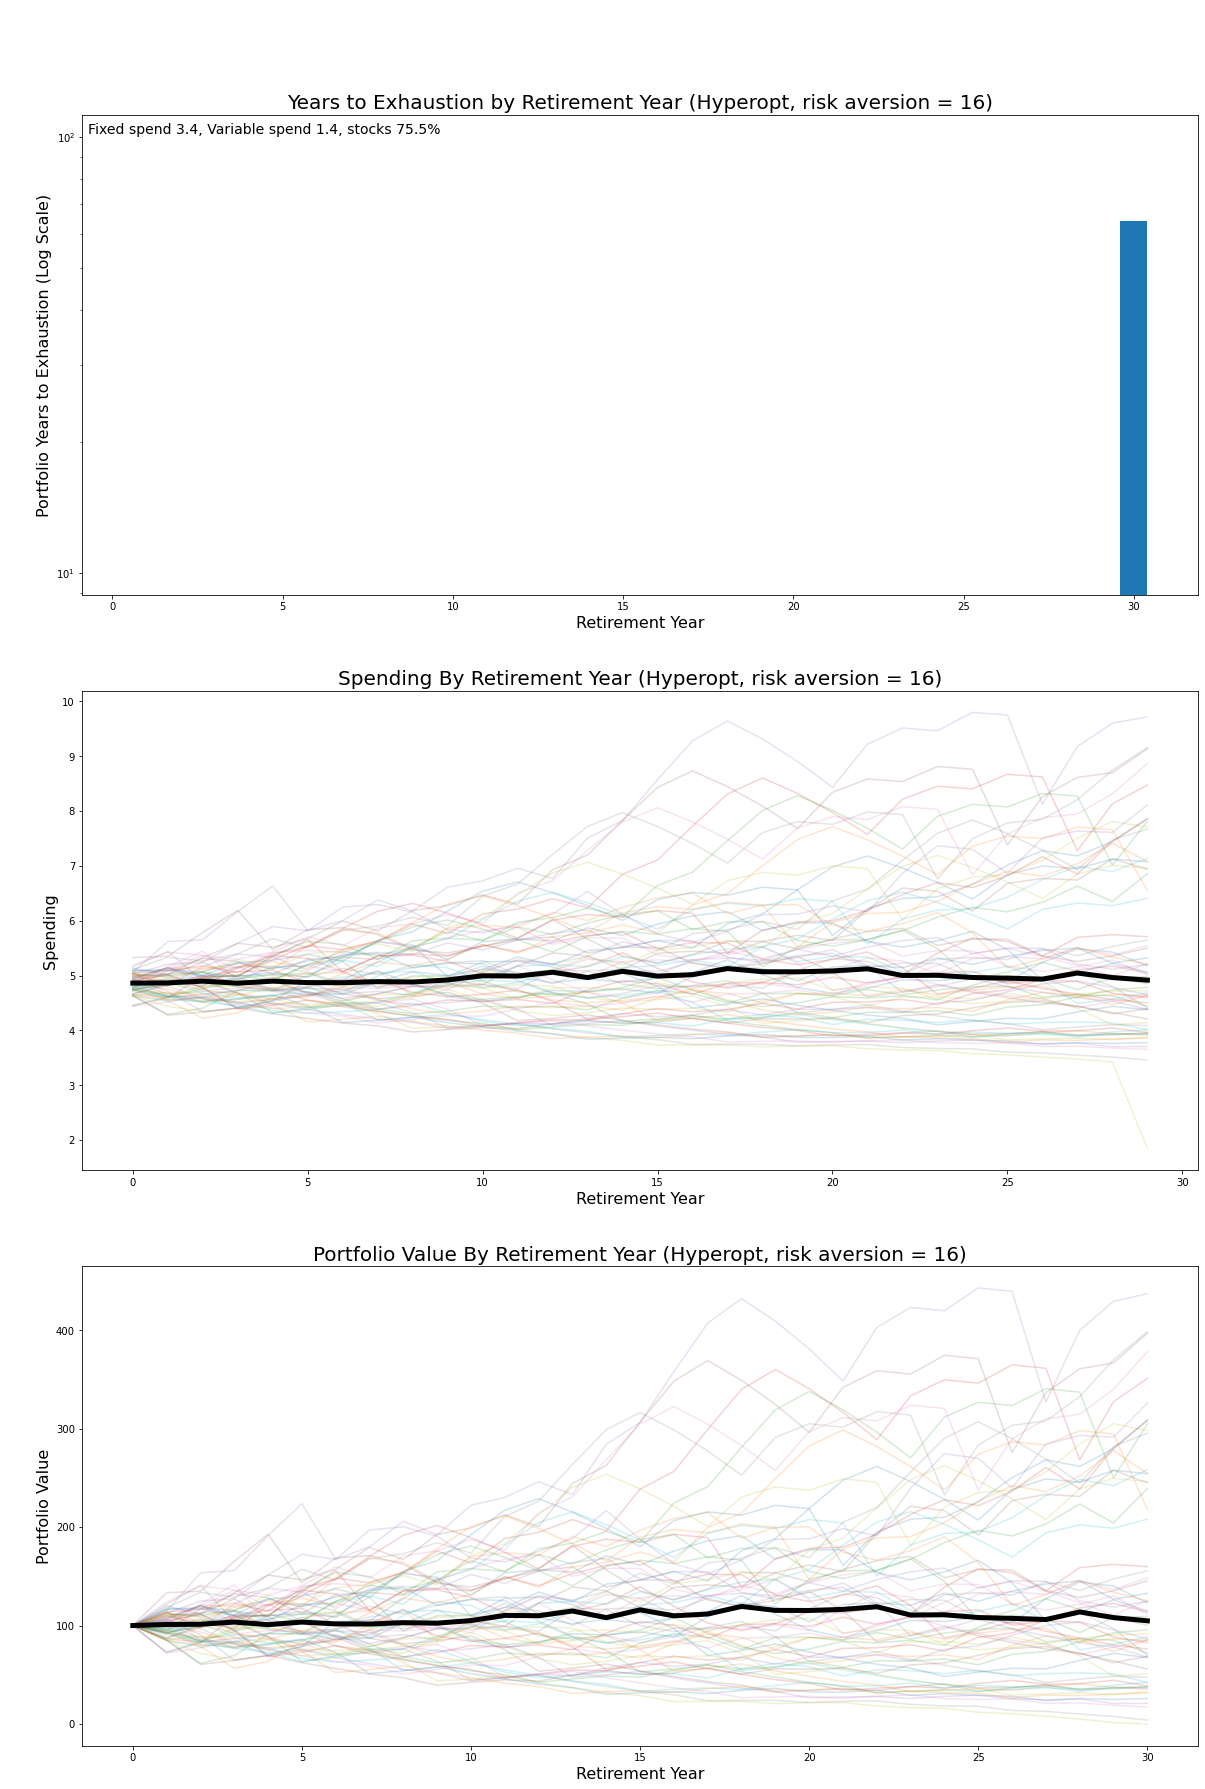

In [18]:
run_strategy(results.iloc[-1]).visualize()


### Platypus
https://github.com/Project-Platypus/Platypus

In [19]:
print("%s %s" % ("platypus", platypus.__version__))
n_trials = N_TRIALS
optimizer = "Platypus (MOEAD)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    # number inputs, outputs
    problem = Problem(3, 1)
    # ranges
    problem.types[0] = Real(0, 5)   # fixed_spend
    problem.types[1] = Real(0, 10)  # variable_spend
    problem.types[2] = Real(0, 1)   # alloc_stocks

    # platypus wants a numpy array return because it's a multi-objective algo
    f = partial(ce_experiment, N_RET_YEARS, gamma)
    def pobjective(params):
        return np.array([f(params)])

    problem.function = pobjective
    algorithm = MOEAD(problem)
    algorithm.run(n_trials)
    best = sorted([(s.objectives[0], s.variables) for s in algorithm.result if s.feasible])[0]
    # tuple of best objective value, best params
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), best))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


INFO:Platypus:MOEAD starting


platypus 1.0.4
2021-02-12 01:08:26 Starting Platypus (MOEAD), gamma 0, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1071, Elapsed Time: 0:02:20.706529
INFO:Platypus:MOEAD starting


2021-02-12 01:10:47 Finishing optimizer Platypus (MOEAD), gamma 0, 1000 trials in 0:02:20.708490
2021-02-12 01:10:47 best params (-15532.30329845972, [5.8338986218875455e-05, 6.190665697414493, 0.9999931170745227])
2021-02-12 01:10:47 Starting Platypus (MOEAD), gamma 1, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1068, Elapsed Time: 0:02:18.568024
INFO:Platypus:MOEAD starting


2021-02-12 01:13:06 Finishing optimizer Platypus (MOEAD), gamma 1, 1000 trials in 0:02:18.569349
2021-02-12 01:13:06 best params (-13514.465392779945, [0.7507025046220908, 5.90815352587995, 0.999878218886639])
2021-02-12 01:13:06 Starting Platypus (MOEAD), gamma 2, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1062, Elapsed Time: 0:02:21.471276
INFO:Platypus:MOEAD starting


2021-02-12 01:15:27 Finishing optimizer Platypus (MOEAD), gamma 2, 1000 trials in 0:02:21.472609
2021-02-12 01:15:27 best params (-11995.938147468873, [2.0565432653799127, 4.369516890042462, 0.9758714694315875])
2021-02-12 01:15:27 Starting Platypus (MOEAD), gamma 4, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1063, Elapsed Time: 0:02:28.874091
INFO:Platypus:MOEAD starting


2021-02-12 01:17:56 Finishing optimizer Platypus (MOEAD), gamma 4, 1000 trials in 0:02:28.875911
2021-02-12 01:17:56 best params (-10301.605155426209, [2.6785492344410287, 3.0786722676717355, 0.8745282183343004])
2021-02-12 01:17:56 Starting Platypus (MOEAD), gamma 6, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1065, Elapsed Time: 0:02:41.770515
INFO:Platypus:MOEAD starting


2021-02-12 01:20:38 Finishing optimizer Platypus (MOEAD), gamma 6, 1000 trials in 0:02:41.772187
2021-02-12 01:20:38 best params (-9564.460942473674, [3.0909381930364095, 2.060144657487667, 0.8304761695288556])
2021-02-12 01:20:38 Starting Platypus (MOEAD), gamma 8, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1073, Elapsed Time: 0:02:43.310156
INFO:Platypus:MOEAD starting


2021-02-12 01:23:21 Finishing optimizer Platypus (MOEAD), gamma 8, 1000 trials in 0:02:43.311778
2021-02-12 01:23:21 best params (-9154.056680165177, [3.2822597274709535, 1.6256251409076807, 0.7957437044909024])
2021-02-12 01:23:21 Starting Platypus (MOEAD), gamma 10, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1049, Elapsed Time: 0:02:40.902255
INFO:Platypus:MOEAD starting


2021-02-12 01:26:02 Finishing optimizer Platypus (MOEAD), gamma 10, 1000 trials in 0:02:40.903949
2021-02-12 01:26:02 best params (-8891.90823184426, [3.4296635963595463, 1.306616923505903, 0.7671182130941049])
2021-02-12 01:26:02 Starting Platypus (MOEAD), gamma 12, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1054, Elapsed Time: 0:02:42.842609
INFO:Platypus:MOEAD starting


2021-02-12 01:28:45 Finishing optimizer Platypus (MOEAD), gamma 12, 1000 trials in 0:02:42.844123
2021-02-12 01:28:45 best params (-8679.446823812686, [3.22300061193795, 1.7436480572816515, 0.7420496730831445])
2021-02-12 01:28:45 Starting Platypus (MOEAD), gamma 14, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1064, Elapsed Time: 0:02:43.133399
INFO:Platypus:MOEAD starting


2021-02-12 01:31:28 Finishing optimizer Platypus (MOEAD), gamma 14, 1000 trials in 0:02:43.135026
2021-02-12 01:31:28 best params (-8592.546416721421, [3.423868719321414, 1.30644806125699, 0.752092234007893])
2021-02-12 01:31:28 Starting Platypus (MOEAD), gamma 16, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1067, Elapsed Time: 0:02:43.207014


2021-02-12 01:34:11 Finishing optimizer Platypus (MOEAD), gamma 16, 1000 trials in 0:02:43.208630
2021-02-12 01:34:11 best params (-8476.849579450978, [3.4931450429926336, 1.1224638020864344, 0.7465402043864859])
2021-02-12 01:34:11.704262 Finished Platypus (MOEAD) in 0:25:44.804019


In [20]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results

gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      0.999993     0.000007     0.000058        6.190666   
1      1      0.999878     0.000122     0.750703        5.908154   
2      2      0.975871     0.024129     2.056543        4.369517   
3      4      0.874528     0.125472     2.678549        3.078672   
4      6      0.830476     0.169524     3.090938        2.060145   
5      8      0.795744     0.204256     3.282260        1.625625   
6     10      0.767118     0.232882     3.429664        1.306617   
7     12      0.742050     0.257950     3.223001        1.743648   
8     14      0.752092     0.247908     3.423869        1.306448   
9     16      0.746540     0.253460     3.493145        1.122464   

          value                 timing  
0 -15532.303298 0 days 00:02:20.708490  
1 -13514.465393 0 days 00:02:18.569349  
2 -11995.938147 0 days 00:02:21.472609  
3 -10301.605155 0 days 00:02:28.875911  
4  -9564.460942 0 days 00:02:41.772187  
5  -9154.056680 0 days 00:02:43.311778  
6  -8891.908232 0 days 00:02:40.903949  
7  -8679.446824 0 days 00:02:42.844123  
8  -8592.546417 0 days 00:02:43.135026  
9  -8476.849579 0 days 00:02:43.208630

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f01669115f0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.493145042992633,
 'fixed_pct': 3.4931450429926336,
 'variable': 0.011224638020864344,
 'variable_pct': 1.1224638020864344}
mean annual spending over all cohorts 4.99
0.00% of portfolios exhausted by final year


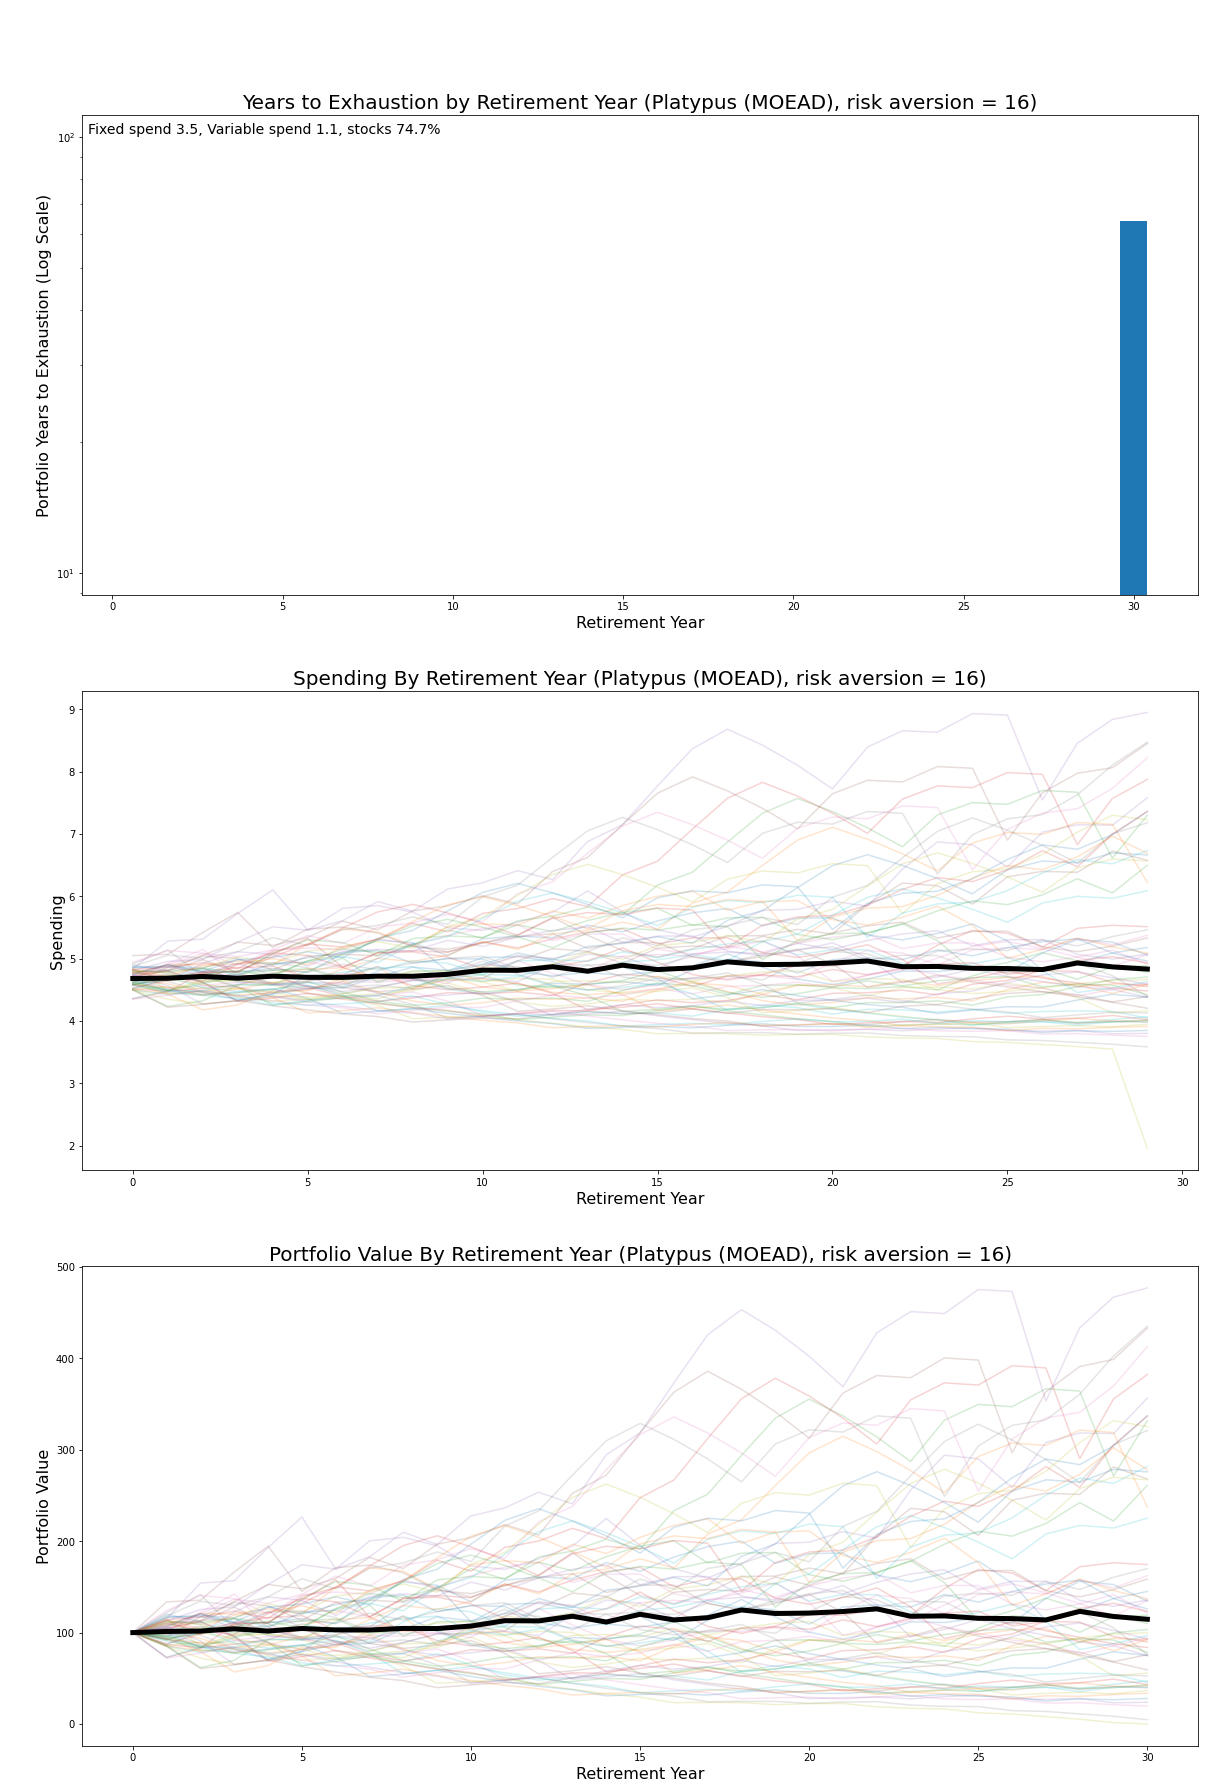

In [21]:
run_strategy(results.iloc[-1]).visualize()


### Nevergrad
https://facebookresearch.github.io/nevergrad/optimization.html

In [22]:
print("%s %s" % ("nevergrad", ng.__version__))

n_trials = N_TRIALS
optimizer = "Nevergrad (OnePlusOne)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    nobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    opt = ng.optimizers.OnePlusOne(parametrization=3, budget=n_trials, num_workers=10)

    opt.parametrization.register_cheap_constraint(lambda x: x[0] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[0] <= 5)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] <= 10)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] <= 1)
    with futures.ThreadPoolExecutor(max_workers=opt.num_workers) as executor:
        recommendation = opt.minimize(nobjective, executor=executor, batch_mode=False)
    
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)    
    study_params.append((recommendation.loss, recommendation.value.tolist()))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %f" % (datestr(), recommendation.value, recommendation.loss))
        
opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


nevergrad 0.4.3
2021-02-12 01:34:12 Starting Nevergrad (OnePlusOne), gamma 0, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-12 01:37:44 Finishing optimizer Nevergrad (OnePlusOne), gamma 0, 1000 trials in 0:03:31.727865
2021-02-12 01:37:44 best params [4.18485539 2.49729596 0.99999731] value -13688.184426
2021-02-12 01:37:44 Starting Nevergrad (OnePlusOne), gamma 1, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.



2021-02-12 01:41:12 Finishing optimizer Nevergrad (OnePlusOne), gamma 1, 1000 trials in 0:03:27.780323
2021-02-12 01:41:12 best params [1.08490248 6.06001934 1.        ] value -13479.129148
2021-02-12 01:41:12 Starting Nevergrad (OnePlusOne), gamma 2, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-12 01:44:32 Finishing optimizer Nevergrad (OnePlusOne), gamma 2, 1000 trials in 0:03:20.482969
2021-02-12 01:44:32 best params [2.09738425 4.19484527 1.        ] value -12022.667916
2021-02-12 01:44:32 Starting Nevergrad (OnePlusOne), gamma 4, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.



2021-02-12 01:48:23 Finishing optimizer Nevergrad (OnePlusOne), gamma 4, 1000 trials in 0:03:50.577676
2021-02-12 01:48:23 best params [2.78465178 2.77784537 0.87815354] value -10318.196583
2021-02-12 01:48:23 Starting Nevergrad (OnePlusOne), gamma 6, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-12 01:52:31 Finishing optimizer Nevergrad (OnePlusOne), gamma 6, 1000 trials in 0:04:07.825998
2021-02-12 01:52:31 best params [2.91708428 2.46176728 0.78810558] value -9564.914804
2021-02-12 01:52:31 Starting Nevergrad (OnePlusOne), gamma 8, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-12 01:56:40 Finishing optimizer Nevergrad (OnePlusOne), gamma 8, 1000 trials in 0:04:09.850153
2021-02-12 01:56:40 best params [3.05175581 2.12934324 0.6743314 ] value -9105.551267
2021-02-12 01:56:40 Starting Nevergrad (OnePlusOne), gamma 10, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.



2021-02-12 02:00:52 Finishing optimizer Nevergrad (OnePlusOne), gamma 10, 1000 trials in 0:04:11.402516
2021-02-12 02:00:52 best params [3.7981138  0.54308965 0.74047355] value -8578.340317
2021-02-12 02:00:52 Starting Nevergrad (OnePlusOne), gamma 12, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-12 02:04:54 Finishing optimizer Nevergrad (OnePlusOne), gamma 12, 1000 trials in 0:04:02.652002
2021-02-12 02:04:54 best params [3.0717643  2.09499401 0.73446448] value -8581.744630
2021-02-12 02:04:54 Starting Nevergrad (OnePlusOne), gamma 14, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-12 02:09:07 Finishing optimizer Nevergrad (OnePlusOne), gamma 14, 1000 trials in 0:04:12.765979
2021-02-12 02:09:07 best params [2.72743528 2.57415903 0.78277607] value -8107.499005
2021-02-12 02:09:07 Starting Nevergrad (OnePlusOne), gamma 16, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.



2021-02-12 02:13:16 Finishing optimizer Nevergrad (OnePlusOne), gamma 16, 1000 trials in 0:04:09.022675
2021-02-12 02:13:16 best params [3.20894781 1.78678122 0.76875834] value -8340.461299
2021-02-12 02:13:16.722548 Finished Nevergrad (OnePlusOne) in 0:39:04.093734


In [23]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks   alloc_bonds  fixed_spend  variable_spend  \
0      0      0.999997  2.691607e-06     4.184855        2.497296   
1      1      1.000000  1.554312e-15     1.084902        6.060019   
2      2      1.000000  1.201828e-11     2.097384        4.194845   
3      4      0.878154  1.218465e-01     2.784652        2.777845   
4      6      0.788106  2.118944e-01     2.917084        2.461767   
5      8      0.674331  3.256686e-01     3.051756        2.129343   
6     10      0.740474  2.595265e-01     3.798114        0.543090   
7     12      0.734464  2.655355e-01     3.071764        2.094994   
8     14      0.782776  2.172239e-01     2.727435        2.574159   
9     16      0.768758  2.312417e-01     3.208948        1.786781   

          value                 timing  
0 -13688.184426 0 days 00:03:31.727865  
1 -13479.129148 0 days 00:03:27.780323  
2 -12022.667916 0 days 00:03:20.482969  
3 -10318.196583 0 days 00:03:50.577676  
4  -9564.914804 0 days 00:04:07.825998  
5  -9105.551267 0 days 00:04:09.850153  
6  -8578.340317 0 days 00:04:11.402516  
7  -8581.744630 0 days 00:04:02.652002  
8  -8107.499005 0 days 00:04:12.765979  
9  -8340.461299 0 days 00:04:09.022675

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f016668f7b0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.2089478103393714,
 'fixed_pct': 3.2089478103393714,
 'variable': 0.017867812228222327,
 'variable_pct': 1.7867812228222328}
mean annual spending over all cohorts 5.38
0.00% of portfolios exhausted by final year


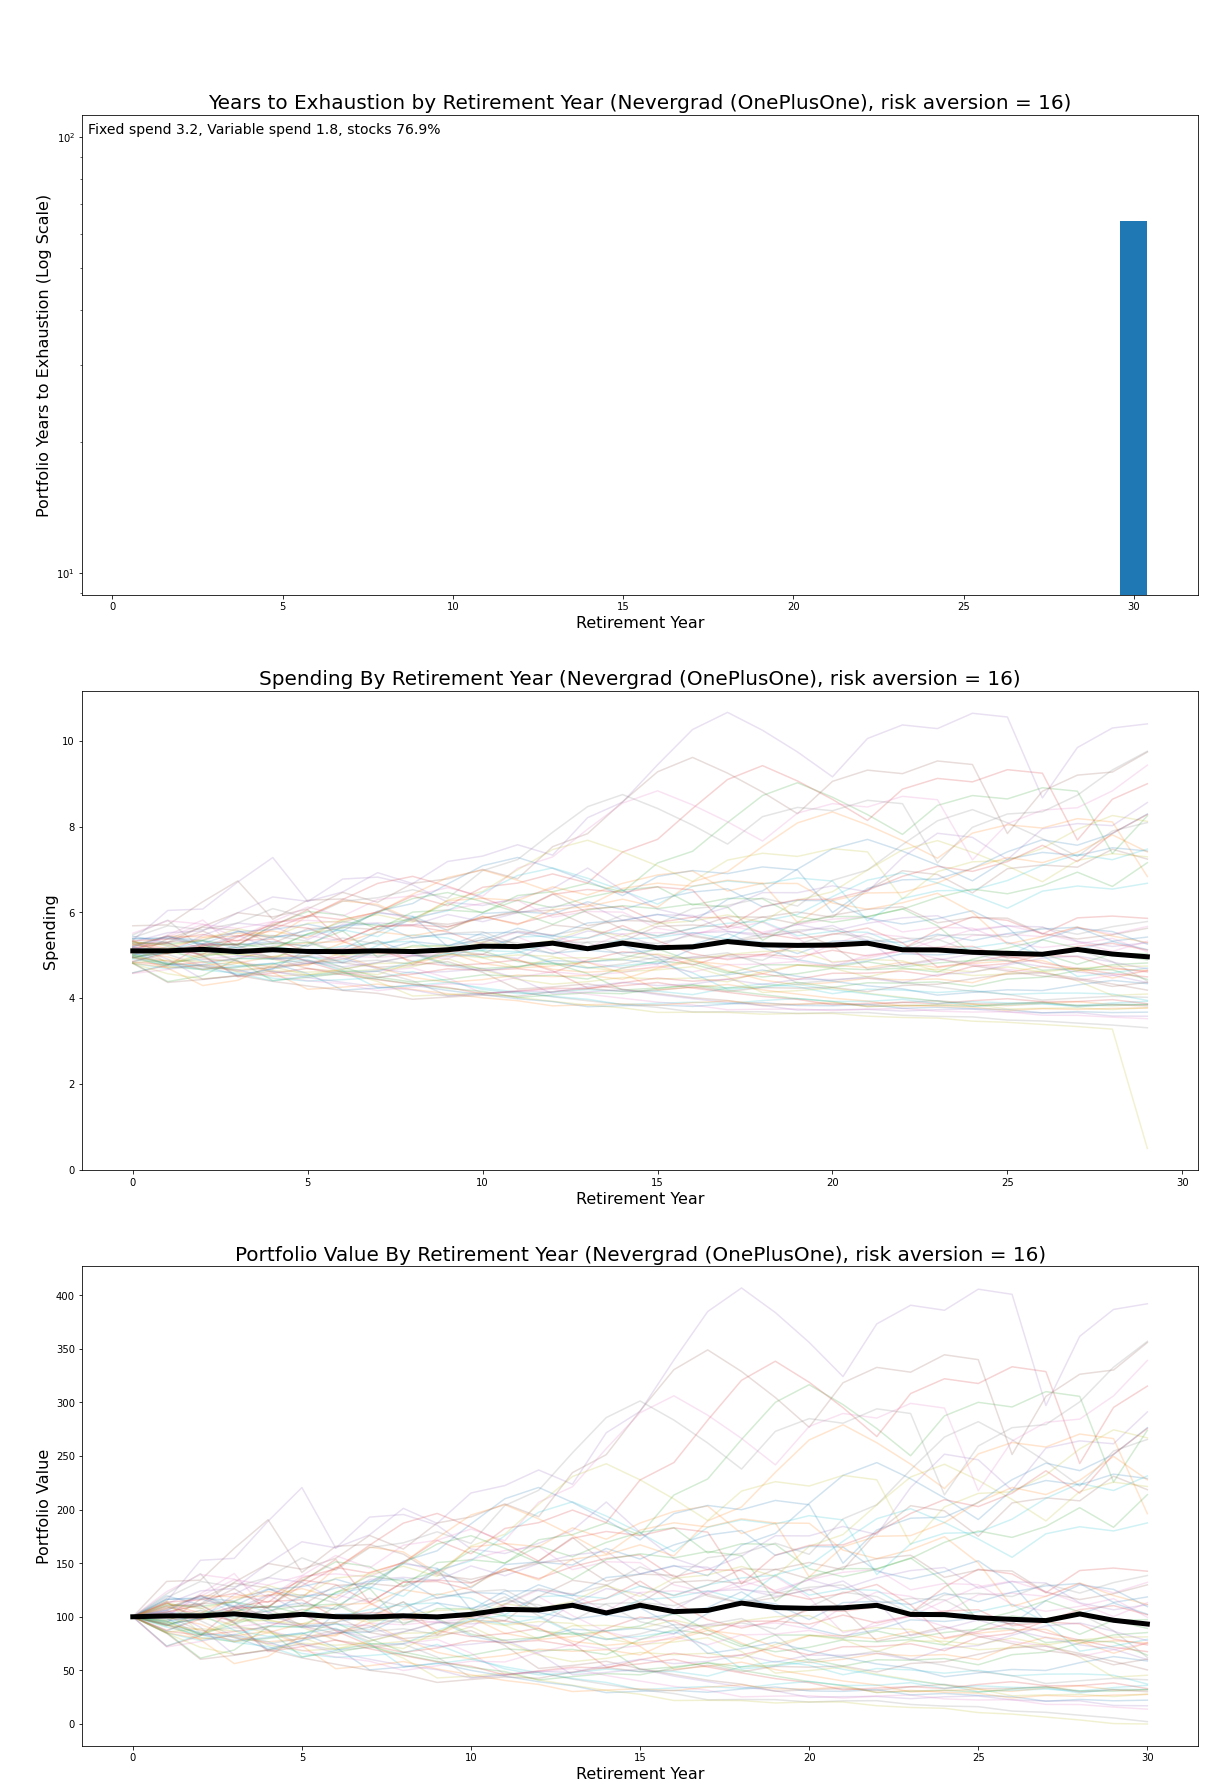

In [24]:
run_strategy(results.iloc[-1]).visualize()


### Ax
https://ax.dev/

In [39]:
print("%s %s" % ("ax", ax.__version__))

n_trials = N_TRIALS // 3  # otherwise very slow
optimizer = "Ax (defaults)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    aobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    
    best_parameters, best_values, experiment, model = ax.optimize(
        parameters=[
            {
                "name": "fixed_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 5.0],
            },
            {
                "name": "variable_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 10.0],
            },
            {
                "name": "alloc_stocks",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 1.0],
            },
        ],
        evaluation_function=aobjective,
        minimize=True,
        total_trials=n_trials,
        #verbose_logging=False
    )
    
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)
    
    study_params.append((best_values[0]['objective'], 
                         [best_parameters['fixed_spend'], 
                          best_parameters['variable_spend'], 
                          best_parameters['alloc_stocks']]
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %s" % (datestr(), best_values[0]['objective'], best_parameters))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


[INFO 02-12 03:32:47] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-12 03:32:47] ax.service.managed_loop: Started full optimization with 333 steps.
[INFO 02-12 03:32:47] ax.service.managed_loop: Running optimization trial 1...
[INFO 02-12 03:32:47] ax.service.managed_loop: Running optimization trial 2...


ax 0.1.19
2021-02-12 03:32:47 Starting Ax (defaults), gamma 0, 333 trials


[INFO 02-12 03:32:48] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 03:32:48] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 03:32:48] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 03:32:48] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 03:32:48] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 03:32:49] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 03:32:50] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 03:32:50] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 03:32:50] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 03:32:51] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 03:32:52] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 03:32:53] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-12 03:32:53] ax.service.managed_loop: 

[INFO 02-12 03:33:25] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 03:33:25] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 03:33:26] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 03:33:26] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 03:33:27] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 03:33:27] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 03:33:28] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 03:33:28] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 03:33:28] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 03:33:29] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 03:33:29] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 03:33:30] ax.service.managed_loop: Running optimization trial 117...
[INFO 02-12 03:33:30] ax.ser

[INFO 02-12 03:34:23] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 03:34:23] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 03:34:24] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 03:34:25] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 03:34:25] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 03:34:26] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 03:34:27] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 03:34:28] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 03:34:28] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 03:34:29] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 03:34:30] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 03:34:30] ax.service.managed_loop: Running optimization trial 219...
[INFO 02-12 03:34:31] ax.ser

[INFO 02-12 03:35:49] ax.service.managed_loop: Running optimization trial 310...
[INFO 02-12 03:35:50] ax.service.managed_loop: Running optimization trial 311...
[INFO 02-12 03:35:51] ax.service.managed_loop: Running optimization trial 312...
[INFO 02-12 03:35:52] ax.service.managed_loop: Running optimization trial 313...
[INFO 02-12 03:35:53] ax.service.managed_loop: Running optimization trial 314...
[INFO 02-12 03:35:54] ax.service.managed_loop: Running optimization trial 315...
[INFO 02-12 03:35:56] ax.service.managed_loop: Running optimization trial 316...
[INFO 02-12 03:35:57] ax.service.managed_loop: Running optimization trial 317...
[INFO 02-12 03:35:58] ax.service.managed_loop: Running optimization trial 318...
[INFO 02-12 03:35:59] ax.service.managed_loop: Running optimization trial 319...
[INFO 02-12 03:36:00] ax.service.managed_loop: Running optimization trial 320...
[INFO 02-12 03:36:01] ax.service.managed_loop: Running optimization trial 321...
[INFO 02-12 03:36:02] ax.ser

2021-02-12 03:36:15 Finishing optimizer Ax (defaults), gamma 0, 333 trials in 0:03:27.669672
2021-02-12 03:36:15 best params -15530.586192952058 value {'fixed_spend': 2.303561727422764e-16, 'variable_spend': 6.3147311936828565, 'alloc_stocks': 0.9999999999999986}
2021-02-12 03:36:15 Starting Ax (defaults), gamma 1, 333 trials


[INFO 02-12 03:36:15] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 03:36:15] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 03:36:15] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 03:36:16] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 03:36:16] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 03:36:17] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 03:36:17] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 03:36:17] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 03:36:18] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 03:36:19] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 03:36:19] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 03:36:20] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-12 03:36:20] ax.service.managed_loop: 

[INFO 02-12 03:37:30] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 03:37:31] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 03:37:32] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 03:37:33] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 03:37:34] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 03:37:35] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 03:37:36] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 03:37:37] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 03:37:38] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 03:37:38] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 03:37:39] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 03:37:40] ax.service.managed_loop: Running optimization trial 117...
[INFO 02-12 03:37:41] ax.ser

[INFO 02-12 03:39:34] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 03:39:37] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 03:39:39] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 03:39:41] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 03:39:44] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 03:39:46] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 03:39:49] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 03:39:51] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 03:39:54] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 03:39:56] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 03:39:58] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 03:40:01] ax.service.managed_loop: Running optimization trial 219...
[INFO 02-12 03:40:04] ax.ser

[INFO 02-12 03:43:59] ax.service.managed_loop: Running optimization trial 310...
[INFO 02-12 03:44:02] ax.service.managed_loop: Running optimization trial 311...
[INFO 02-12 03:44:04] ax.service.managed_loop: Running optimization trial 312...
[INFO 02-12 03:44:07] ax.service.managed_loop: Running optimization trial 313...
[INFO 02-12 03:44:10] ax.service.managed_loop: Running optimization trial 314...
[INFO 02-12 03:44:13] ax.service.managed_loop: Running optimization trial 315...
[INFO 02-12 03:44:16] ax.service.managed_loop: Running optimization trial 316...
[INFO 02-12 03:44:19] ax.service.managed_loop: Running optimization trial 317...
[INFO 02-12 03:44:21] ax.service.managed_loop: Running optimization trial 318...
[INFO 02-12 03:44:24] ax.service.managed_loop: Running optimization trial 319...
[INFO 02-12 03:44:27] ax.service.managed_loop: Running optimization trial 320...
[INFO 02-12 03:44:30] ax.service.managed_loop: Running optimization trial 321...
[INFO 02-12 03:44:32] ax.ser

2021-02-12 03:45:08 Finishing optimizer Ax (defaults), gamma 1, 333 trials in 0:08:52.934644
2021-02-12 03:45:08 best params -13517.806276986415 value {'fixed_spend': 0.3407281960314041, 'variable_spend': 6.218125524970074, 'alloc_stocks': 0.9999999993887971}
2021-02-12 03:45:08 Starting Ax (defaults), gamma 2, 333 trials


[INFO 02-12 03:45:08] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 03:45:08] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 03:45:08] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 03:45:08] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 03:45:09] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 03:45:09] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 03:45:10] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 03:45:11] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 03:45:12] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 03:45:13] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 03:45:14] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 03:45:15] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-12 03:45:16] ax.service.managed_loop: 

[INFO 02-12 03:46:24] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 03:46:25] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 03:46:26] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 03:46:26] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 03:46:27] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 03:46:28] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 03:46:29] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 03:46:30] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 03:46:30] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 03:46:31] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 03:46:32] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 03:46:33] ax.service.managed_loop: Running optimization trial 117...
[INFO 02-12 03:46:34] ax.ser

[INFO 02-12 03:48:15] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 03:48:16] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 03:48:17] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 03:48:18] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 03:48:20] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 03:48:21] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 03:48:22] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 03:48:23] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 03:48:24] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 03:48:25] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 03:48:27] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 03:48:28] ax.service.managed_loop: Running optimization trial 219...
[INFO 02-12 03:48:29] ax.ser

2021-02-12 03:51:07 Finishing optimizer Ax (defaults), gamma 2, 333 trials in 0:05:58.971514
2021-02-12 03:51:07 best params -11995.40393542896 value {'fixed_spend': 1.6963641906201978, 'variable_spend': 4.6924384659649645, 'alloc_stocks': 0.9999999999999997}
2021-02-12 03:51:07 Starting Ax (defaults), gamma 4, 333 trials


[INFO 02-12 03:51:07] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 03:51:07] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 03:51:07] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 03:51:08] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 03:51:08] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 03:51:08] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 03:51:09] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 03:51:10] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 03:51:10] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 03:51:11] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 03:51:11] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 03:51:12] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-12 03:51:13] ax.service.managed_loop: 

[INFO 02-12 03:52:13] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 03:52:14] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 03:52:15] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 03:52:15] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 03:52:16] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 03:52:17] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 03:52:18] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 03:52:18] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 03:52:19] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 03:52:20] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 03:52:21] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 03:52:22] ax.service.managed_loop: Running optimization trial 117...
[INFO 02-12 03:52:23] ax.ser

[INFO 02-12 03:54:03] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 03:54:05] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 03:54:06] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 03:54:07] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 03:54:08] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 03:54:09] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 03:54:11] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 03:54:12] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 03:54:13] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 03:54:14] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 03:54:16] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 03:54:17] ax.service.managed_loop: Running optimization trial 219...
[INFO 02-12 03:54:18] ax.ser

[INFO 02-12 03:56:23] ax.service.managed_loop: Running optimization trial 310...
[INFO 02-12 03:56:24] ax.service.managed_loop: Running optimization trial 311...
[INFO 02-12 03:56:26] ax.service.managed_loop: Running optimization trial 312...
[INFO 02-12 03:56:28] ax.service.managed_loop: Running optimization trial 313...
[INFO 02-12 03:56:29] ax.service.managed_loop: Running optimization trial 314...
[INFO 02-12 03:56:31] ax.service.managed_loop: Running optimization trial 315...
[INFO 02-12 03:56:32] ax.service.managed_loop: Running optimization trial 316...
[INFO 02-12 03:56:34] ax.service.managed_loop: Running optimization trial 317...
[INFO 02-12 03:56:36] ax.service.managed_loop: Running optimization trial 318...
[INFO 02-12 03:56:37] ax.service.managed_loop: Running optimization trial 319...
[INFO 02-12 03:56:39] ax.service.managed_loop: Running optimization trial 320...
[INFO 02-12 03:56:40] ax.service.managed_loop: Running optimization trial 321...
[INFO 02-12 03:56:42] ax.ser

2021-02-12 03:57:02 Finishing optimizer Ax (defaults), gamma 4, 333 trials in 0:05:55.209799
2021-02-12 03:57:02 best params -10287.080710730983 value {'fixed_spend': 2.5140507515786896, 'variable_spend': 3.468430237103557, 'alloc_stocks': 0.8689894817252383}
2021-02-12 03:57:02 Starting Ax (defaults), gamma 6, 333 trials


[INFO 02-12 03:57:02] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 03:57:02] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 03:57:03] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 03:57:03] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 03:57:03] ax.modelbridge.transforms.standardize_y: Outcome objective is constant, within tolerance.
[INFO 02-12 03:57:03] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 03:57:03] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 03:57:04] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 03:57:05] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 03:57:05] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 03:57:06] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 03:57:06] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 03:

[INFO 02-12 03:58:21] ax.service.managed_loop: Running optimization trial 105...
[INFO 02-12 03:58:21] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 03:58:23] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 03:58:24] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 03:58:24] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 03:58:26] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 03:58:27] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 03:58:28] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 03:58:29] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 03:58:30] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 03:58:31] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 03:58:32] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 03:58:33] ax.ser

[INFO 02-12 04:00:06] ax.service.managed_loop: Running optimization trial 207...
[INFO 02-12 04:00:07] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 04:00:08] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 04:00:09] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 04:00:10] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 04:00:11] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 04:00:12] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 04:00:13] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 04:00:14] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 04:00:15] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 04:00:16] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 04:00:17] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 04:00:18] ax.ser

[INFO 02-12 04:02:15] ax.service.managed_loop: Running optimization trial 309...
[INFO 02-12 04:02:17] ax.service.managed_loop: Running optimization trial 310...
[INFO 02-12 04:02:19] ax.service.managed_loop: Running optimization trial 311...
[INFO 02-12 04:02:20] ax.service.managed_loop: Running optimization trial 312...
[INFO 02-12 04:02:22] ax.service.managed_loop: Running optimization trial 313...
[INFO 02-12 04:02:24] ax.service.managed_loop: Running optimization trial 314...
[INFO 02-12 04:02:26] ax.service.managed_loop: Running optimization trial 315...
[INFO 02-12 04:02:27] ax.service.managed_loop: Running optimization trial 316...
[INFO 02-12 04:02:28] ax.service.managed_loop: Running optimization trial 317...
[INFO 02-12 04:02:30] ax.service.managed_loop: Running optimization trial 318...
[INFO 02-12 04:02:32] ax.service.managed_loop: Running optimization trial 319...
[INFO 02-12 04:02:33] ax.service.managed_loop: Running optimization trial 320...
[INFO 02-12 04:02:35] ax.ser

2021-02-12 04:02:54 Finishing optimizer Ax (defaults), gamma 6, 333 trials in 0:05:51.885280
2021-02-12 04:02:54 best params -9540.492023756484 value {'fixed_spend': 2.905780932853533, 'variable_spend': 2.4243470080005327, 'alloc_stocks': 0.7718400205891517}
2021-02-12 04:02:54 Starting Ax (defaults), gamma 8, 333 trials


[INFO 02-12 04:02:54] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 04:02:54] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 04:02:55] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 04:02:55] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 04:02:55] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 04:02:56] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 04:02:57] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 04:02:58] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 04:02:58] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 04:02:59] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 04:03:00] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 04:03:01] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-12 04:03:01] ax.service.managed_loop: 

[INFO 02-12 04:04:20] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 04:04:21] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 04:04:22] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 04:04:23] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 04:04:24] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 04:04:25] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 04:04:26] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 04:04:27] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 04:04:28] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 04:04:29] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 04:04:29] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 04:04:30] ax.service.managed_loop: Running optimization trial 117...
[INFO 02-12 04:04:31] ax.ser

[INFO 02-12 04:06:05] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 04:06:06] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 04:06:07] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 04:06:09] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 04:06:10] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 04:06:11] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 04:06:13] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 04:06:14] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 04:06:16] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 04:06:17] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 04:06:18] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 04:06:20] ax.service.managed_loop: Running optimization trial 219...
[INFO 02-12 04:06:21] ax.ser

[INFO 02-12 04:08:23] ax.service.managed_loop: Running optimization trial 310...
[INFO 02-12 04:08:25] ax.service.managed_loop: Running optimization trial 311...
[INFO 02-12 04:08:26] ax.service.managed_loop: Running optimization trial 312...
[INFO 02-12 04:08:28] ax.service.managed_loop: Running optimization trial 313...
[INFO 02-12 04:08:29] ax.service.managed_loop: Running optimization trial 314...
[INFO 02-12 04:08:31] ax.service.managed_loop: Running optimization trial 315...
[INFO 02-12 04:08:32] ax.service.managed_loop: Running optimization trial 316...
[INFO 02-12 04:08:34] ax.service.managed_loop: Running optimization trial 317...
[INFO 02-12 04:08:35] ax.service.managed_loop: Running optimization trial 318...
[INFO 02-12 04:08:36] ax.service.managed_loop: Running optimization trial 319...
[INFO 02-12 04:08:38] ax.service.managed_loop: Running optimization trial 320...
[INFO 02-12 04:08:40] ax.service.managed_loop: Running optimization trial 321...
[INFO 02-12 04:08:41] ax.ser

2021-02-12 04:09:00 Finishing optimizer Ax (defaults), gamma 8, 333 trials in 0:06:05.851226
2021-02-12 04:09:00 best params -9061.787241785105 value {'fixed_spend': 2.907646021045957, 'variable_spend': 2.420657506161561, 'alloc_stocks': 0.7181970476034921}
2021-02-12 04:09:00 Starting Ax (defaults), gamma 10, 333 trials


[INFO 02-12 04:09:00] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 04:09:00] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 04:09:00] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 04:09:01] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 04:09:01] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 04:09:02] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 04:09:02] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 04:09:03] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 04:09:04] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 04:09:04] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 04:09:05] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 04:09:06] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-12 04:09:07] ax.service.managed_loop: 

[INFO 02-12 04:10:30] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 04:10:31] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 04:10:32] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 04:10:33] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 04:10:34] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 04:10:35] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 04:10:36] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 04:10:37] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 04:10:38] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 04:10:39] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 04:10:40] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 04:10:41] ax.service.managed_loop: Running optimization trial 117...
[INFO 02-12 04:10:42] ax.ser

[INFO 02-12 04:12:19] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 04:12:21] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 04:12:22] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 04:12:23] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 04:12:25] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 04:12:26] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 04:12:27] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 04:12:29] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 04:12:30] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 04:12:31] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 04:12:32] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 04:12:34] ax.service.managed_loop: Running optimization trial 219...
[INFO 02-12 04:12:35] ax.ser

[INFO 02-12 04:14:55] ax.service.managed_loop: Running optimization trial 310...
[INFO 02-12 04:14:56] ax.service.managed_loop: Running optimization trial 311...
[INFO 02-12 04:14:58] ax.service.managed_loop: Running optimization trial 312...
[INFO 02-12 04:15:00] ax.service.managed_loop: Running optimization trial 313...
[INFO 02-12 04:15:02] ax.service.managed_loop: Running optimization trial 314...
[INFO 02-12 04:15:04] ax.service.managed_loop: Running optimization trial 315...
[INFO 02-12 04:15:06] ax.service.managed_loop: Running optimization trial 316...
[INFO 02-12 04:15:07] ax.service.managed_loop: Running optimization trial 317...
[INFO 02-12 04:15:09] ax.service.managed_loop: Running optimization trial 318...
[INFO 02-12 04:15:11] ax.service.managed_loop: Running optimization trial 319...
[INFO 02-12 04:15:12] ax.service.managed_loop: Running optimization trial 320...
[INFO 02-12 04:15:14] ax.service.managed_loop: Running optimization trial 321...
[INFO 02-12 04:15:16] ax.ser

2021-02-12 04:15:37 Finishing optimizer Ax (defaults), gamma 10, 333 trials in 0:06:37.364669
2021-02-12 04:15:37 best params -8845.675420423286 value {'fixed_spend': 3.1979216393410645, 'variable_spend': 1.7014521279856427, 'alloc_stocks': 0.7512454065864439}
2021-02-12 04:15:37 Starting Ax (defaults), gamma 12, 333 trials


[INFO 02-12 04:15:37] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 04:15:38] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 04:15:38] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 04:15:38] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 04:15:38] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 04:15:39] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 04:15:39] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 04:15:40] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 04:15:40] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 04:15:41] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 04:15:42] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 04:15:42] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-12 04:15:43] ax.service.managed_loop: 

[INFO 02-12 04:16:57] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 04:16:58] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 04:16:59] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 04:17:00] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 04:17:01] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 04:17:02] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 04:17:03] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 04:17:04] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 04:17:05] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 04:17:06] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 04:17:07] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 04:17:08] ax.service.managed_loop: Running optimization trial 117...
[INFO 02-12 04:17:10] ax.ser

[INFO 02-12 04:18:51] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 04:18:52] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 04:18:53] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 04:18:54] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 04:18:55] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 04:18:56] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 04:18:57] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 04:18:59] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 04:19:00] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 04:19:01] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 04:19:02] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 04:19:03] ax.service.managed_loop: Running optimization trial 219...
[INFO 02-12 04:19:04] ax.ser

[INFO 02-12 04:21:11] ax.service.managed_loop: Running optimization trial 310...
[INFO 02-12 04:21:12] ax.service.managed_loop: Running optimization trial 311...
[INFO 02-12 04:21:14] ax.service.managed_loop: Running optimization trial 312...
[INFO 02-12 04:21:16] ax.service.managed_loop: Running optimization trial 313...
[INFO 02-12 04:21:18] ax.service.managed_loop: Running optimization trial 314...
[INFO 02-12 04:21:19] ax.service.managed_loop: Running optimization trial 315...
[INFO 02-12 04:21:21] ax.service.managed_loop: Running optimization trial 316...
[INFO 02-12 04:21:23] ax.service.managed_loop: Running optimization trial 317...
[INFO 02-12 04:21:25] ax.service.managed_loop: Running optimization trial 318...
[INFO 02-12 04:21:27] ax.service.managed_loop: Running optimization trial 319...
[INFO 02-12 04:21:29] ax.service.managed_loop: Running optimization trial 320...
[INFO 02-12 04:21:31] ax.service.managed_loop: Running optimization trial 321...
[INFO 02-12 04:21:33] ax.ser

2021-02-12 04:21:56 Finishing optimizer Ax (defaults), gamma 12, 333 trials in 0:06:19.238804
2021-02-12 04:21:56 best params -8575.90313441983 value {'fixed_spend': 3.0673887097737955, 'variable_spend': 1.967022910787561, 'alloc_stocks': 0.7529087941297775}
2021-02-12 04:21:56 Starting Ax (defaults), gamma 14, 333 trials


[INFO 02-12 04:21:57] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 04:21:57] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 04:21:57] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 04:21:57] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 04:21:58] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 04:21:58] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 04:21:59] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 04:22:00] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 04:22:00] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 04:22:01] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 04:22:02] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 04:22:02] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-12 04:22:03] ax.service.managed_loop: 

[INFO 02-12 04:23:18] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 04:23:18] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 04:23:19] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 04:23:20] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 04:23:21] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 04:23:22] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 04:23:22] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 04:23:23] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 04:23:24] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 04:23:25] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 04:23:25] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 04:23:26] ax.service.managed_loop: Running optimization trial 117...
[INFO 02-12 04:23:27] ax.ser

[INFO 02-12 04:24:49] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 04:24:50] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 04:24:51] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 04:24:52] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 04:24:53] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 04:24:54] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 04:24:55] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 04:24:56] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 04:24:58] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 04:24:59] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 04:25:00] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 04:25:01] ax.service.managed_loop: Running optimization trial 219...
[INFO 02-12 04:25:02] ax.ser

[INFO 02-12 04:26:45] ax.service.managed_loop: Running optimization trial 310...
[INFO 02-12 04:26:46] ax.service.managed_loop: Running optimization trial 311...
[INFO 02-12 04:26:47] ax.service.managed_loop: Running optimization trial 312...
[INFO 02-12 04:26:48] ax.service.managed_loop: Running optimization trial 313...
[INFO 02-12 04:26:51] ax.service.managed_loop: Running optimization trial 314...
[INFO 02-12 04:26:53] ax.service.managed_loop: Running optimization trial 315...
[INFO 02-12 04:26:55] ax.service.managed_loop: Running optimization trial 316...
[INFO 02-12 04:26:57] ax.service.managed_loop: Running optimization trial 317...
[INFO 02-12 04:27:00] ax.service.managed_loop: Running optimization trial 318...
[INFO 02-12 04:27:02] ax.service.managed_loop: Running optimization trial 319...
[INFO 02-12 04:27:04] ax.service.managed_loop: Running optimization trial 320...
[INFO 02-12 04:27:06] ax.service.managed_loop: Running optimization trial 321...
[INFO 02-12 04:27:08] ax.ser

2021-02-12 04:27:34 Finishing optimizer Ax (defaults), gamma 14, 333 trials in 0:05:37.392171
2021-02-12 04:27:34 best params -8531.143118927586 value {'fixed_spend': 3.2951803897820158, 'variable_spend': 1.57425286343345, 'alloc_stocks': 0.8069551880769581}
2021-02-12 04:27:34 Starting Ax (defaults), gamma 16, 333 trials


[INFO 02-12 04:27:34] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-12 04:27:34] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-12 04:27:34] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-12 04:27:34] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-12 04:27:35] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-12 04:27:36] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-12 04:27:37] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-12 04:27:38] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-12 04:27:39] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-12 04:27:40] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-12 04:27:41] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-12 04:27:42] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-12 04:27:43] ax.service.managed_loop: 

[INFO 02-12 04:28:58] ax.service.managed_loop: Running optimization trial 106...
[INFO 02-12 04:28:59] ax.service.managed_loop: Running optimization trial 107...
[INFO 02-12 04:29:00] ax.service.managed_loop: Running optimization trial 108...
[INFO 02-12 04:29:01] ax.service.managed_loop: Running optimization trial 109...
[INFO 02-12 04:29:02] ax.service.managed_loop: Running optimization trial 110...
[INFO 02-12 04:29:03] ax.service.managed_loop: Running optimization trial 111...
[INFO 02-12 04:29:03] ax.service.managed_loop: Running optimization trial 112...
[INFO 02-12 04:29:04] ax.service.managed_loop: Running optimization trial 113...
[INFO 02-12 04:29:05] ax.service.managed_loop: Running optimization trial 114...
[INFO 02-12 04:29:06] ax.service.managed_loop: Running optimization trial 115...
[INFO 02-12 04:29:07] ax.service.managed_loop: Running optimization trial 116...
[INFO 02-12 04:29:08] ax.service.managed_loop: Running optimization trial 117...
[INFO 02-12 04:29:09] ax.ser

[INFO 02-12 04:30:43] ax.service.managed_loop: Running optimization trial 208...
[INFO 02-12 04:30:44] ax.service.managed_loop: Running optimization trial 209...
[INFO 02-12 04:30:45] ax.service.managed_loop: Running optimization trial 210...
[INFO 02-12 04:30:46] ax.service.managed_loop: Running optimization trial 211...
[INFO 02-12 04:30:47] ax.service.managed_loop: Running optimization trial 212...
[INFO 02-12 04:30:49] ax.service.managed_loop: Running optimization trial 213...
[INFO 02-12 04:30:50] ax.service.managed_loop: Running optimization trial 214...
[INFO 02-12 04:30:51] ax.service.managed_loop: Running optimization trial 215...
[INFO 02-12 04:30:52] ax.service.managed_loop: Running optimization trial 216...
[INFO 02-12 04:30:53] ax.service.managed_loop: Running optimization trial 217...
[INFO 02-12 04:30:55] ax.service.managed_loop: Running optimization trial 218...
[INFO 02-12 04:30:56] ax.service.managed_loop: Running optimization trial 219...
[INFO 02-12 04:30:57] ax.ser

[INFO 02-12 04:32:56] ax.service.managed_loop: Running optimization trial 310...
[INFO 02-12 04:32:58] ax.service.managed_loop: Running optimization trial 311...
[INFO 02-12 04:32:59] ax.service.managed_loop: Running optimization trial 312...
[INFO 02-12 04:33:01] ax.service.managed_loop: Running optimization trial 313...
[INFO 02-12 04:33:03] ax.service.managed_loop: Running optimization trial 314...
[INFO 02-12 04:33:05] ax.service.managed_loop: Running optimization trial 315...
[INFO 02-12 04:33:07] ax.service.managed_loop: Running optimization trial 316...
[INFO 02-12 04:33:09] ax.service.managed_loop: Running optimization trial 317...
[INFO 02-12 04:33:11] ax.service.managed_loop: Running optimization trial 318...
[INFO 02-12 04:33:13] ax.service.managed_loop: Running optimization trial 319...
[INFO 02-12 04:33:15] ax.service.managed_loop: Running optimization trial 320...
[INFO 02-12 04:33:17] ax.service.managed_loop: Running optimization trial 321...
[INFO 02-12 04:33:19] ax.ser

2021-02-12 04:33:42 Finishing optimizer Ax (defaults), gamma 16, 333 trials in 0:06:08.240612
2021-02-12 04:33:42 best params -8267.7834749911 value {'fixed_spend': 3.4627578368976817, 'variable_spend': 1.051635692302903, 'alloc_stocks': 0.45649010560622566}
2021-02-12 04:33:42.479003 Finished Ax (defaults) in 1:00:54.760597


In [40]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks   alloc_bonds   fixed_spend  variable_spend  \
0      0      1.000000  1.443290e-15  2.303562e-16        6.314731   
1      1      1.000000  6.112029e-10  3.407282e-01        6.218126   
2      2      1.000000  3.330669e-16  1.696364e+00        4.692438   
3      4      0.868989  1.310105e-01  2.514051e+00        3.468430   
4      6      0.771840  2.281600e-01  2.905781e+00        2.424347   
5      8      0.718197  2.818030e-01  2.907646e+00        2.420658   
6     10      0.751245  2.487546e-01  3.197922e+00        1.701452   
7     12      0.752909  2.470912e-01  3.067389e+00        1.967023   
8     14      0.806955  1.930448e-01  3.295180e+00        1.574253   
9     16      0.456490  5.435099e-01  3.462758e+00        1.051636   

          value                 timing  
0 -15530.586193 0 days 00:03:27.669672  
1 -13517.806277 0 days 00:08:52.934644  
2 -11995.403935 0 days 00:05:58.971514  
3 -10287.080711 0 days 00:05:55.209799  
4  -9540.492024 0 days 00:05:51.885280  
5  -9061.787242 0 days 00:06:05.851226  
6  -8845.675420 0 days 00:06:37.364669  
7  -8575.903134 0 days 00:06:19.238804  
8  -8531.143119 0 days 00:05:37.392171  
9  -8267.783475 0 days 00:06:08.240612

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f0165b5f200>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.4627578368976812,
 'fixed_pct': 3.4627578368976817,
 'variable': 0.010516356923029031,
 'variable_pct': 1.051635692302903}
mean annual spending over all cohorts 4.89
0.00% of portfolios exhausted by final year


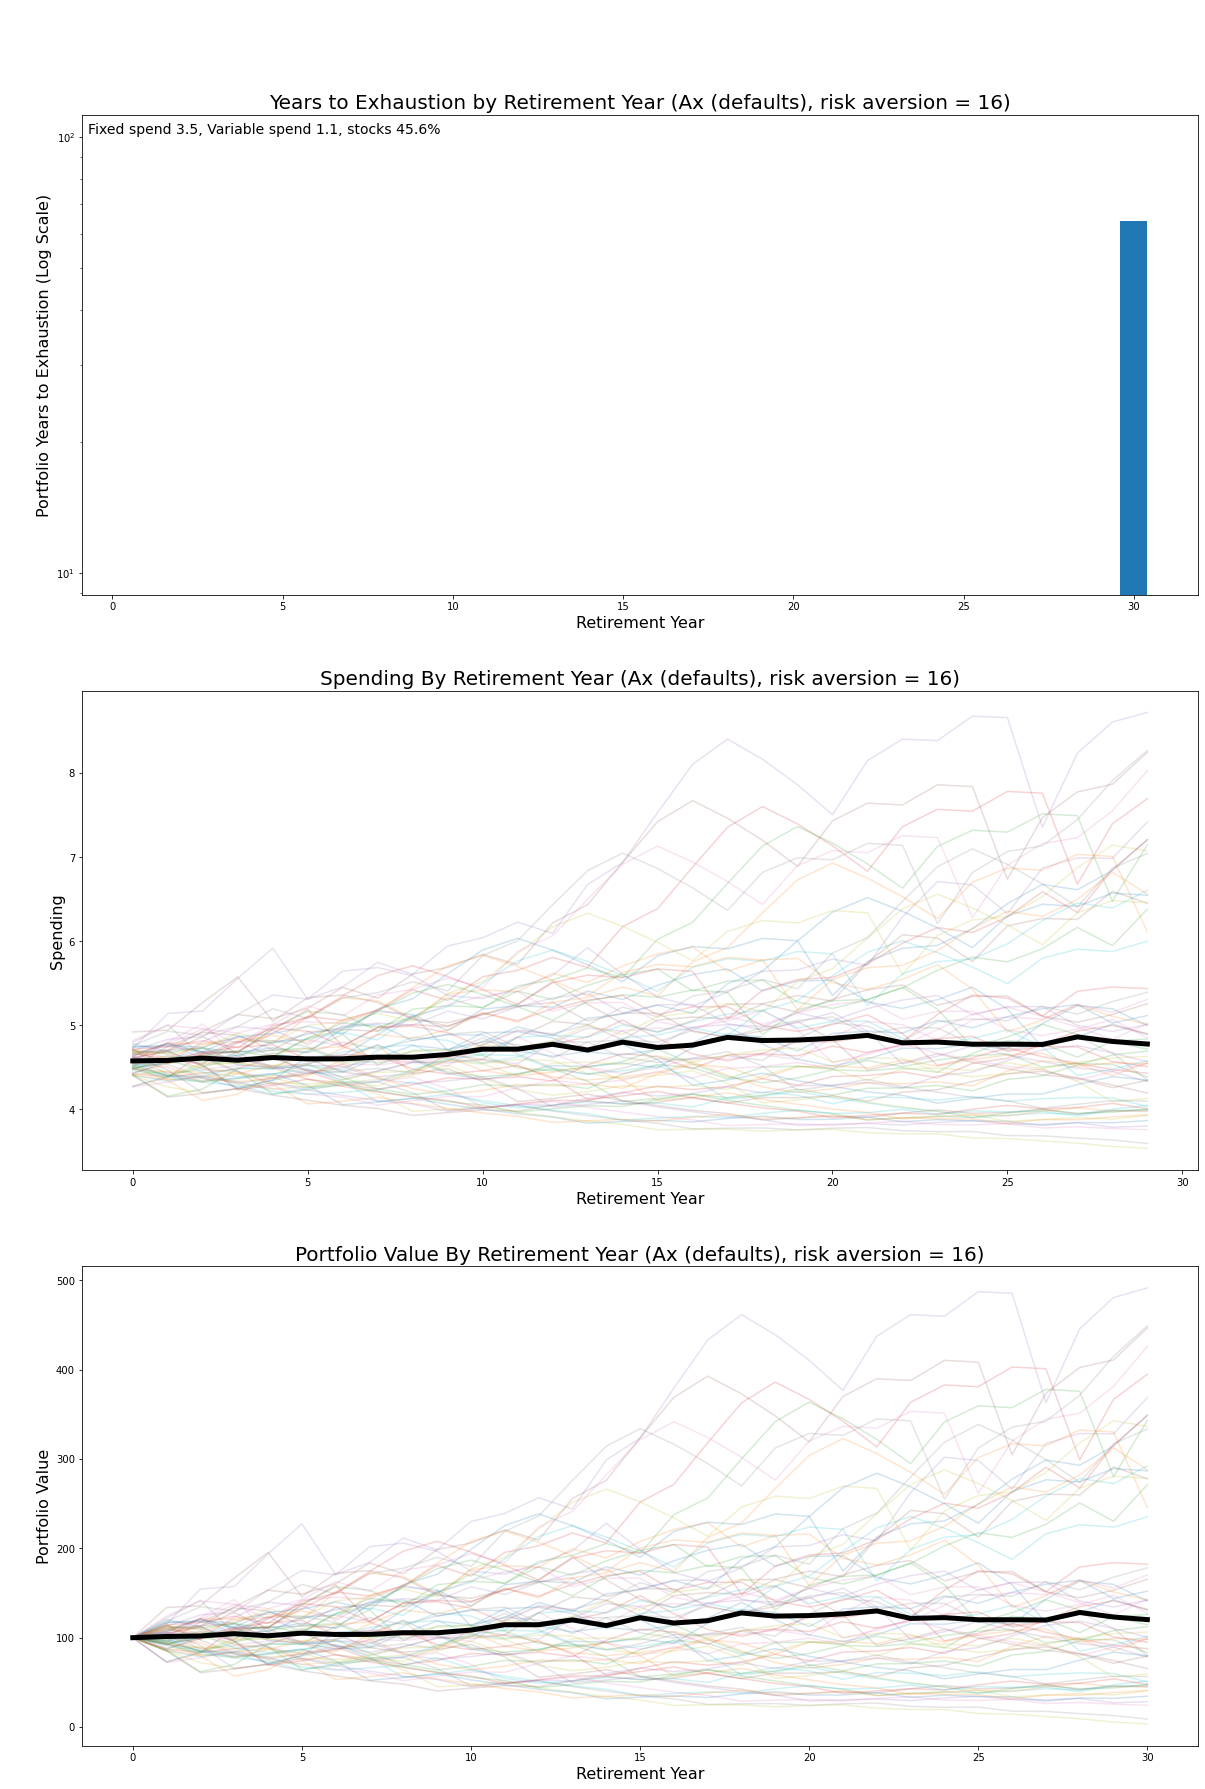

In [41]:
run_strategy(results.iloc[-1]).visualize()


In [42]:
# from scipy.optimize import basinhopping
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html
# slow and performs poorly
# gamma = 1
# x0 = np.array([1.0, 5.0, 0.5])
# optimizer = "basinhopping"

# stepsize = 0.25
# T = 50
# minimizer_kwargs = {"method": "BFGS"}
# MAX_ITER = 100

# def print_fun(x, f, accepted):
#     print("%s at minimum %.4f accepted %d (%s)" % (datestr(), f, int(accepted), x))
        
# class MyBounds(object):
#     def __init__(self, 
#                  xmax=[5.0, 10.0, 1.0], 
#                  xmin=[0.0,  0.0, 0.0] ):
#         self.xmax = np.array(xmax)
#         self.xmin = np.array(xmin)
#     def __call__(self, **kwargs):
#         x = kwargs["x_new"]
#         tmax = bool(np.all(x <= self.xmax))
#         tmin = bool(np.all(x >= self.xmin))
#         return tmax and tmin
# mybounds = MyBounds()

# print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
# start_time = datetime.now()
# bobjective = partial(ce_experiment, N_RET_YEARS, gamma)
# ret = basinhopping(bobjective, x0, minimizer_kwargs=minimizer_kwargs,
#                    niter=MAX_ITER, stepsize=stepsize, T=T,
#                    accept_test=mybounds,
#                    callback=print_fun)



### Visualize combined results

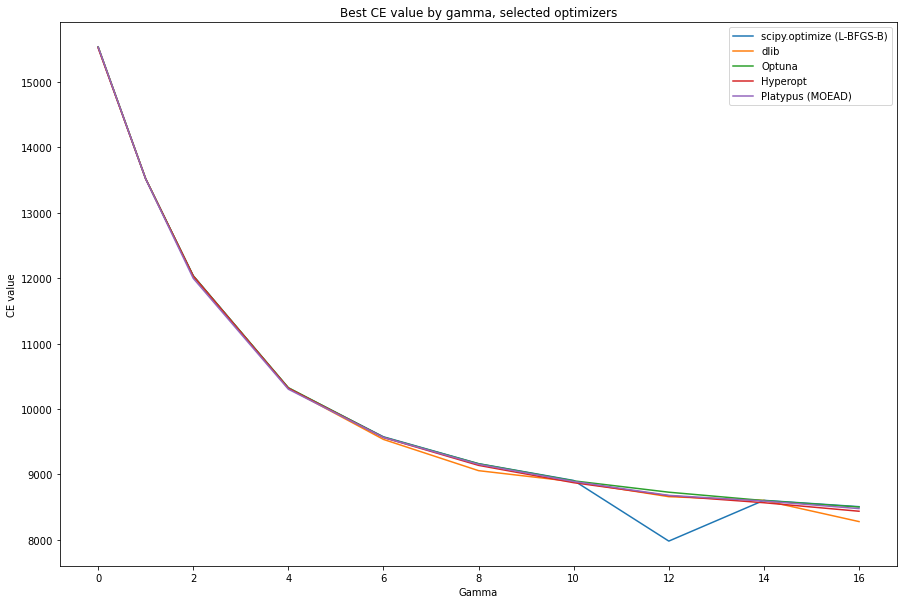

In [43]:
# plot all results

plt.figure(figsize=(15,10))
plt.title('Best CE value by gamma, selected optimizers')
plt.xlabel('Gamma')
plt.ylabel('CE value')
# for opt in results_dict.keys():
# skip last 2 which are more messy and never best
# maybe they need more iterations but they are taking plenty of time already
for opt in ['scipy.optimize (L-BFGS-B)', 'dlib', 'Optuna', 'Hyperopt', 'Platypus (MOEAD)']:
    plt.plot(results_dict[opt]['gamma'], -results_dict[opt]['value'], label=opt)
    
plt.legend();



In [44]:
df_list = []
for optimizer in results_dict.keys():
    results_dict[optimizer]['optimizer'] = optimizer
    df_list.append(results_dict[optimizer])
all_results = pd.concat(df_list)
all_results['value'] = - all_results['value']



In [45]:
mean_spends = []
exhaustions = []

for row in all_results.itertuples():
    s = run_strategy(row, verbose=False)
    mean_spends.append(s.latest_simulation[0]['mean_spend'])
    exhaustions.append(s.latest_simulation[0]['years_to_exhaustion'])
                   
all_results['mean_spend'] = mean_spends
all_results['exhaustion'] = exhaustions
    

In [46]:
all_results['group_gamma_max'] = all_results.groupby(['gamma'])['value'].transform(max)
all_results.loc[all_results['value'] == all_results['group_gamma_max']].sort_values('gamma')

gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      1.000000     0.000000     0.000000        6.204105   
1      1      1.000000     0.000000     0.295292        6.239439   
2      2      1.000000     0.000000     2.064036        4.393697   
3      4      0.884566     0.115434     2.712828        2.962875   
4      6      0.816224     0.183776     3.000151        2.265994   
5      8      0.785915     0.214085     3.188369        1.833849   
6     10      0.770464     0.229536     3.322693        1.534553   
7     12      0.765280     0.234720     3.397728        1.366525   
8     14      0.753637     0.246363     3.498058        1.154462   
9     16      0.754680     0.245320     3.556900        1.029995   

          value                 timing                  optimizer  mean_spend  \
0  15532.416056 0 days 00:00:03.421659  scipy.optimize (L-BFGS-B)    5.587570   
1  13517.859788 0 days 00:02:06.209761                       dlib    5.633694   
2  12036.308515 0 days 00:01:00.480826  scipy.optimize (L-BFGS-B)    5.761026   
3  10325.221414 0 days 00:02:19.161642                     Optuna    5.578543   
4   9574.406303 0 days 00:00:39.308328  scipy.optimize (L-BFGS-B)    5.380178   
5   9163.997255 0 days 00:00:52.053411  scipy.optimize (L-BFGS-B)    5.217585   
6   8906.921628 0 days 00:01:02.392996  scipy.optimize (L-BFGS-B)    5.084155   
7   8727.895684 0 days 00:02:32.920029                     Optuna    4.999830   
8   8603.485064 0 days 00:01:17.927281  scipy.optimize (L-BFGS-B)    4.887307   
9   8506.558108 0 days 00:00:38.263479  scipy.optimize (L-BFGS-B)    4.815823   

   exhaustion  group_gamma_max  
0          30     15532.416056  
1          30     13517.859788  
2          30     12036.308515  
3          30     10325.221414  
4          30      9574.406303  
5          30      9163.997255  
6          30      8906.921628  
7          30      8727.895684  
8          30      8603.485064  
9          30      8506.558108

In [47]:
pd.DataFrame(timings_dict.values(), index=timings_dict.keys(), columns=['timing'])

timing
scipy.optimize (L-BFGS-B) 0 days 00:08:47.361512
dlib                      0 days 00:23:14.385151
Optuna                    0 days 00:24:06.463121
Hyperopt                  0 days 00:25:11.262910
Platypus (MOEAD)          0 days 00:25:44.804019
Nevergrad (OnePlusOne)    0 days 00:39:04.093734
Ax (defaults)             0 days 01:00:54.760597